In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('../../../Code/')
from utils import read_dataset_log
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import log_loss
from scipy.stats import chi2

In [2]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [3]:
gate_list = ['CD4_Naive', 
             'CD8_Naive', 
             'gdT',
            'MAIT', 
             'CD4_EM', 
             'CD8_EM', 
             'CD4_CM', 
             'Treg']

In [4]:
train_dir = '/data/srlab1/TCAT/Data/PerDataset/COMBAT'
test_dir =  '/data/srlab1/TCAT/Data/PerDataset/Sparks2023'

In [5]:
gep_info = read_dataset_log('cGEP_Name')
gep_info.index = gep_info['cGep_Name']
gep_info.head()

,cGep_Name,Old_Short_Name,Long_Name,Short_Name,Shortest_Name,Class,Num_Datasets,Notes,Reviewed,Filter
cGep_Name,,,,,,,,,,
COMBAT_Cytoskeleton,COMBAT_Cytoskeleton,Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytosk.,Functional,7.0,NaN,Y,NaN
CD8_EM,CD8_EM,CD8-EM,CD8 Effector Memory,CD8-EM,CD8-EM,Lineage,7.0,Need to confirm overlap with gating since the ...,Y,NaN
CellCycle-G2M,CellCycle-G2M,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,G2M-phase,Functional,7.0,NaN,Y,NaN
CellCycle-S,CellCycle-S,CellCycle-S,Cell Cycle S Phase,CellCycle-S,S-phase,Functional,7.0,NaN,Y,NaN
Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Functional,7.0,NaN,Y,NaN


In [6]:
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

# Balanced multinomial prediction of lineage only using all GEPs, CD4 + CD8

## Training

In [7]:
lineage_geps = gep_info[gep_info['Class']=='Lineage']['Short_Name'].tolist()
# lineage_geps = gep_info[gep_info['Class']=='Lineage']['cGep_Name'].tolist()
lineage_geps

['CD8-EM',
 'MAIT',
 'Treg',
 'CD4-Naive',
 'TEMRA',
 'CD4-CM',
 'gdT',
 'Th22',
 'Th17-Resting',
 'Th2-Resting',
 'Th1-Like',
 'CD8-Naive',
 'CD8-Trm',
 'Tfh-2',
 'Tph',
 'Tfh-1']

In [8]:
dataset = 'COMBAT'

gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], index_col = 0, sep = '\t',
                     header=0, names = ['cell_gating'])

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
meta['cell_gating'] = gating.loc[meta.index, 'cell_gating']

gates_to_exclude = ['CD4_TEMRA', #'CD8_TEMRA',
                    'DN', 'DP']

meta = meta.loc[-meta['cell_gating'].isin(gates_to_exclude), :]

In [9]:
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

overlap = set(usage_norm.index).intersection(meta.index)
meta_train_all = meta.loc[overlap, ]
usage_train_all = usage_norm.loc[overlap, ]

In [10]:
usage_train_all.head(2)

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
CAGTAACCATATGAGA-1-gPlexA4,0.000055,0.024118,0.002411,0.006377,0.000006,0.000382,0.004414,0.000604,0.005514,0.000841,...,0.253832,0.082877,0.007694,0.006667,0.012774,0.002380,0.025315,0.001882,0.002920,0.000318
CAGGTGCGTAAGAGGA-1-gPlexB3,0.000015,0.189392,0.000624,0.000805,0.012136,0.000396,0.001677,0.000037,0.002481,0.001451,...,0.000725,0.002343,0.013058,0.011921,0.000599,0.000587,0.116109,0.010480,0.000182,0.000112


In [11]:
yasumizu_usage = pd.read_csv('../../../Data/PerDataset/COMBAT/Yasumizu_NMFproject_Usage_TPMscale.tsv', sep='\t', index_col=0)
yasumizu_usage = yasumizu_usage.loc[meta_train_all.index, :]
yasumizu_usage_norm = yasumizu_usage.div(yasumizu_usage.sum(axis=1), axis=0)

In [12]:
gate_list_all = meta_train_all['cell_gating'].unique().tolist()
gate_list_all

['CD4_CM',
 'CD4_Naive',
 'CD8_EM',
 'Treg',
 'CD4_EM',
 'gdT',
 'CD8_TEMRA',
 'CD8_Naive',
 'MAIT',
 'CD8_CM']

In [13]:
len(lineage_geps)

16

In [14]:
dat = usage_train_all.groupby(meta_train_all['cell_gating']).mean()

<AxesSubplot:ylabel='cell_gating'>

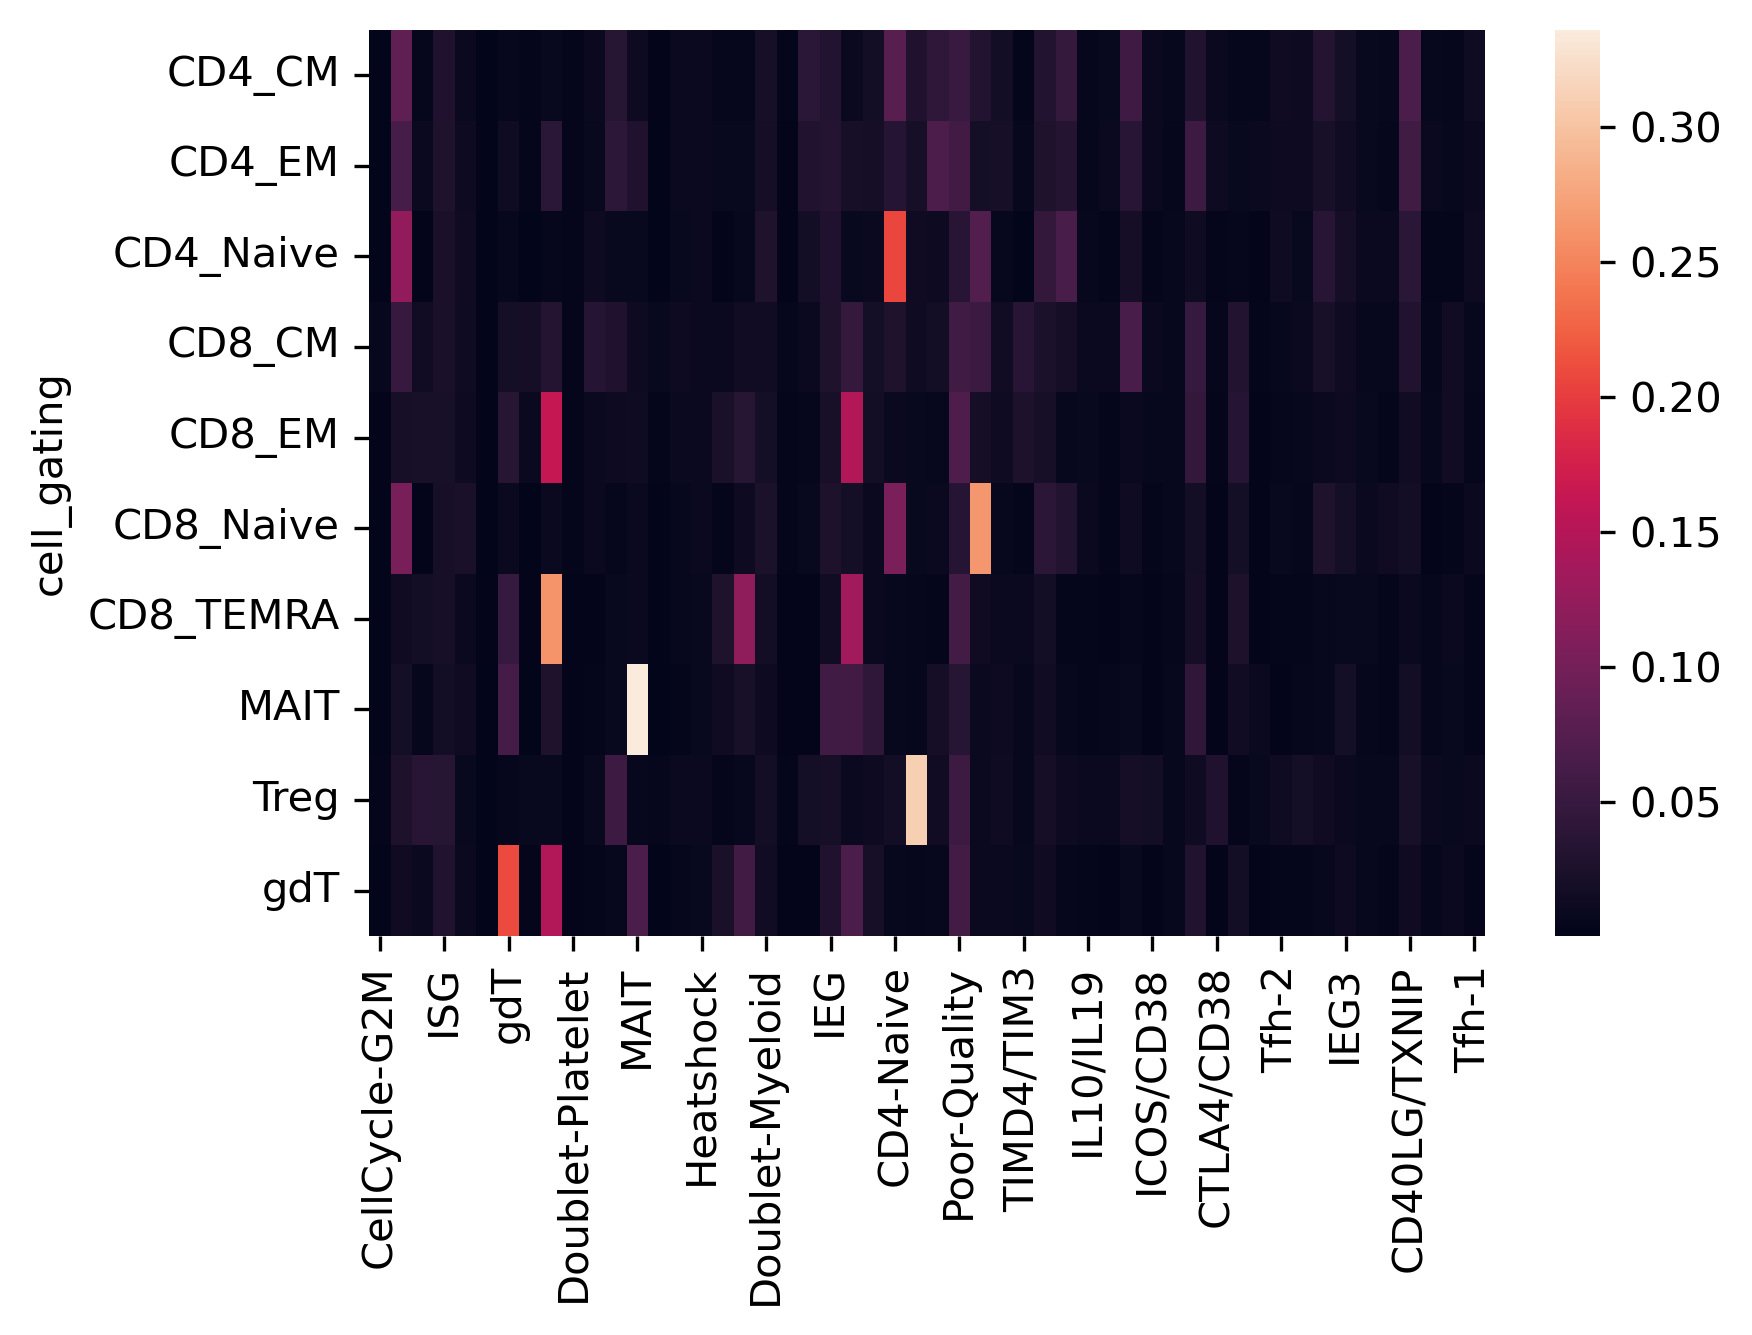

In [15]:
fig, ax = plt.subplots(dpi = 300)
sns.heatmap(dat, ax = ax)

In [16]:
gates_train_all = meta_train_all['cell_gating']
gates_train_all.value_counts().sort_values(ascending = False)

CD4_Naive    115643
CD4_CM        98459
CD4_EM        41023
CD8_TEMRA     36720
CD8_EM        33158
CD8_Naive     25481
Treg          11745
CD8_CM         9694
gdT            6160
MAIT           6042
Name: cell_gating, dtype: int64

In [17]:
gates_train_all.unique()

array(['CD4_CM', 'CD4_Naive', 'CD8_EM', 'Treg', 'CD4_EM', 'gdT',
       'CD8_TEMRA', 'CD8_Naive', 'MAIT', 'CD8_CM'], dtype=object)

In [18]:
scaler_tcat = StandardScaler()
usage_train_all_scaled = scaler_tcat.fit_transform(usage_train_all)
usage_train_all_scaled = pd.DataFrame(usage_train_all_scaled, index=usage_train_all.index, columns=usage_train_all.columns)

train_usage, test_usage, train_gates, test_gates = train_test_split(usage_train_all_scaled, 
                                                                    gates_train_all, 
                                                                    test_size=0.25, random_state=2)

model_tcat = LogisticRegression(solver='lbfgs', random_state=8,
                           multi_class = 'multinomial', class_weight = 'balanced', max_iter=500)
model_tcat.fit(train_usage, train_gates)

pred_tcat = model_tcat.predict(test_usage)
pred_tcat = pd.Series(pred_tcat, index = test_usage.index)
lr_probs_tcat = model_tcat.predict_proba(test_usage)
lr_probs_tcat = pd.DataFrame(lr_probs_tcat, columns=model_tcat.classes_)

(pred_tcat==test_gates).value_counts()

True     27126
False    11287
dtype: int64

In [19]:
vc = (pred_tcat==test_gates).value_counts()
vc / vc.sum()

True     0.706167
False    0.293833
dtype: float64

In [20]:
model_tcat

LogisticRegression(class_weight='balanced', max_iter=500,
                   multi_class='multinomial', random_state=8)

In [21]:
outfn = os.path.join(test_dir, 'model_TCAT_MultinomialLogisticRegression.20240422.pkl')
outfn

'/data/srlab1/TCAT/Data/PerDataset/Sparks2023/model_TCAT_MultinomialLogisticRegression.20240422.pkl'

In [22]:
import pickle
with open(outfn, 'wb') as f:
    # Dump the object into the pickle file
    pickle.dump(model_tcat, f)

In [23]:
usage_train_all.shape

(384125, 52)

In [24]:
scaler_yasumizu = StandardScaler()
yasumizu_usage_train_all_scaled = scaler_yasumizu.fit_transform(yasumizu_usage_norm)
yasumizu_usage_train_all_scaled = pd.DataFrame(yasumizu_usage_train_all_scaled, index=yasumizu_usage_norm.index, columns=yasumizu_usage_norm.columns)

train_usage, test_usage, train_gates, test_gates = train_test_split(yasumizu_usage_train_all_scaled, 
                                                                    gates_train_all, 
                                                                    test_size=0.25, random_state=2)

model_yasumizu = LogisticRegression(solver='lbfgs', random_state=14,
                           multi_class = 'multinomial', class_weight  = 'balanced', max_iter=500)
model_yasumizu.fit(train_usage, train_gates)

pred_yasumizu = model_yasumizu.predict(test_usage)
pred_yasumizu = pd.Series(pred_yasumizu, index = test_usage.index)
lr_probs_yasumizu = model_yasumizu.predict_proba(test_usage)
lr_probs_yasumizu = pd.DataFrame(lr_probs_yasumizu, columns=model_yasumizu.classes_)
(pred_yasumizu==test_gates).value_counts()

True     55050
False    40982
dtype: int64

In [25]:
coef_tcat = pd.DataFrame(model_tcat.coef_, index = model_tcat.classes_, 
                    columns = usage_train_all_scaled.columns)

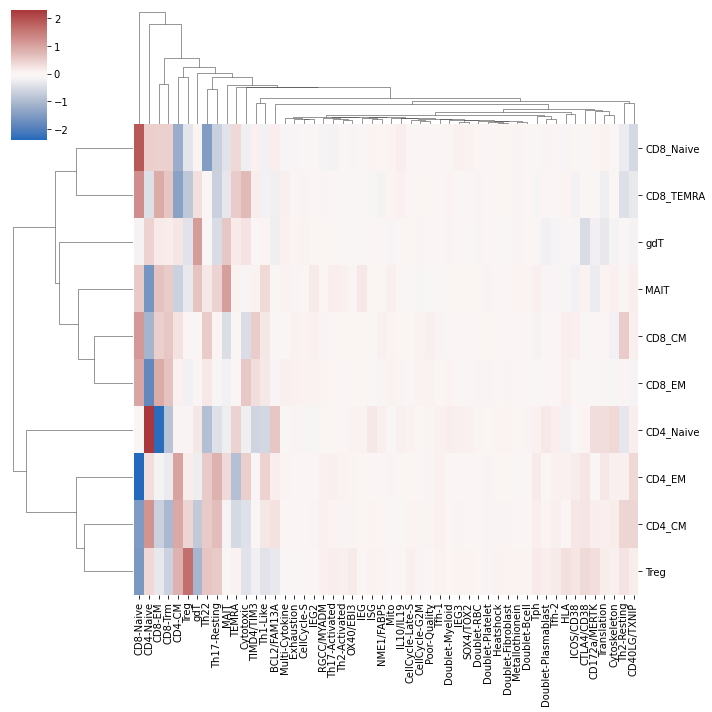

In [26]:
sns.clustermap(coef_tcat, cmap = 'vlag', xticklabels=True)

In [27]:
coef_yasumizu = pd.DataFrame(model_yasumizu.coef_, index = model_yasumizu.classes_, 
                    columns = yasumizu_usage_norm.columns)

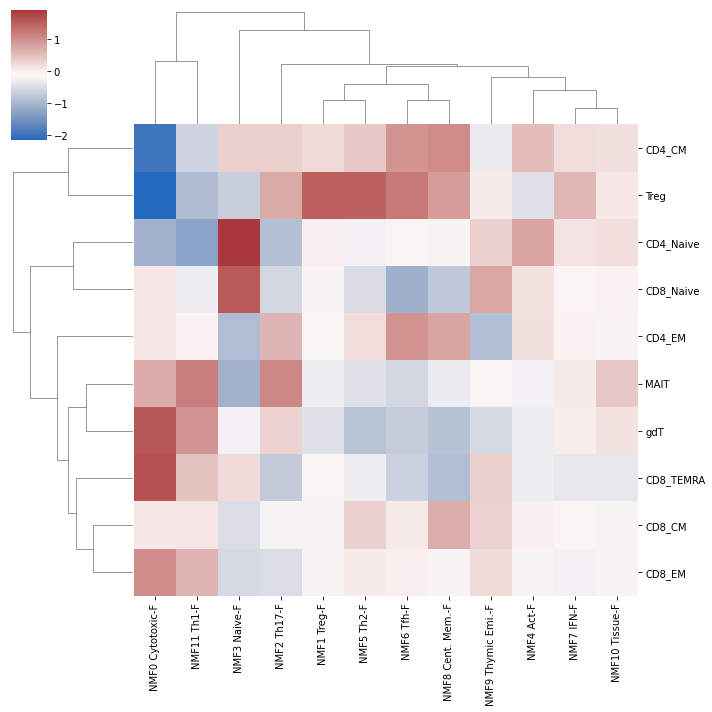

In [28]:
sns.clustermap(coef_yasumizu, cmap = 'vlag')

In [30]:
pred_tcat

CGAGCACAGCTATGCT-1-gPlexB4         Treg
ACATACGCACTGTCGG-1-gPlexB2    CD4_Naive
TGCGCAGAGGCCCGTT-1-gPlexH6       CD4_CM
TGCCCTAGTGGGTCAA-1-gPlexE2    CD4_Naive
AACTGGTGTTCTGTTT-1-gPlexJ5       CD4_EM
                                ...    
TCCACACGTCGGCACT-1-gPlexC5    CD4_Naive
TGAGCATGTCCGAACC-1-gPlexK7    CD8_TEMRA
GCCTCTAAGTAAGTAC-1-gPlexB5    CD4_Naive
GTACTCCTCTGCGGCA-1-gPlexF2    CD4_Naive
TAGAGCTAGCGACGTA-1-gPlexJ7       CD8_EM
Length: 38413, dtype: object

In [31]:
for gate_type in gate_list_all:
    print(gate_type)
    ind = test_gates[test_gates==gate_type].index
    display((pred_tcat[ind]==gate_type).value_counts())

CD4_CM


KeyError: "['CGATGTAAGTGTACGG-1-gPlexH3', 'CCGTACTTCAGCACAT-1-gPlexG5', 'GCATGCGTCTGGTATG-1-gPlexF1', 'GGAACTTTCAACACAC-1-gPlexG7', 'GGGCACTTCTGCTGTC-1-gPlexG3', 'CCGTACTCATGCCCGA-1-gPlexD2', 'CTAATGGGTGTGGCTC-1-gPlexA1', 'CGGAGTCCATGGTAGG-1-gPlexH3', 'TTTGTCACAGTGAGTG-1-gPlexJ7', 'GACAGAGTCATAGCAC-1-gPlexA1', 'AGTTGGTTCGCCAGCA-1-gPlexC6', 'GCGCAGTTCGCCGTGA-1-gPlexB1', 'CTGATCCCATGCATGT-1-gPlexJ3', 'GCGCAGTAGGAGTTTA-1-gPlexH2', 'CAAGGCCTCGACAGCC-1-gPlexE6', 'CTACACCAGACTCGGA-1-gPlexA4', 'TCGGGACCAGGCAGTA-1-gPlexE5', 'CTGTTTATCGACGGAA-1-gPlexB5', 'GGCTGGTCATACTCTT-1-gPlexE4', 'CATGCCTAGAGTAAGG-1-gPlexE7', 'GGGACCTAGGAGTCTG-1-gPlexK4', 'TATTACCAGGTGATTA-1-gPlexJ6', 'ATCTGCCAGTACGTTC-1-gPlexF1', 'CTAAGACCACATTAGC-1-gPlexF6', 'GGGTTGCCAGCATACT-1-gPlexG4', 'CCGTACTGTCGACTAT-1-gPlexE7', 'GACTACAGTCTAAAGA-1-gPlexB7', 'TGATTTCTCAGTGCAT-1-gPlexC3', 'TCGGTAATCTTGCATT-1-gPlexH4', 'CTACACCGTGCCTGTG-1-gPlexG7', 'CGTGTCTTCGGAGGTA-1-gPlexH1', 'TGGGAAGTCCGAATGT-1-gPlexG7', 'GACTACAGTCGCTTTC-1-gPlexK6', 'TCAGCAAAGTTATCGC-1-gPlexK5', 'CCTCAGTCACCCAGTG-1-gPlexH6', 'CGGGTCAAGTCTCGGC-1-gPlexF1', 'CGGCTAGTCCGTTGTC-1-gPlexG3', 'CAAGGCCCACGTTGGC-1-gPlexH6', 'GGAACTTTCTGTGCAA-1-gPlexD1', 'CTAATGGCACGCCAGT-1-gPlexH1', 'CGCTATCGTTAGTGGG-1-gPlexC6', 'ATCACGAGTTCCACAA-1-gPlexA5', 'AGTGGGAGTACCCAAT-1-gPlexE3', 'GCGCAGTGTGCTAGCC-1-gPlexA6', 'CAAGTTGGTAGCGATG-1-gPlexE2', 'GGGCATCGTGGCTCCA-1-gPlexE6', 'CAAGGCCTCTTGCATT-1-gPlexF3', 'GACACGCTCCCTTGTG-1-gPlexK5', 'CTACGTCTCAACCAAC-1-gPlexK2', 'CCTTTCTAGTCATCCA-1-gPlexC4', 'CTGAAACGTTACGCGC-1-gPlexC2', 'GAGGTGAAGCAGGCTA-1-gPlexF3', 'CTGGTCTAGTATCTCG-1-gPlexB3', 'CAACCAACACTGCCAG-1-gPlexF6', 'GGGATGAAGGAGTTTA-1-gPlexC3', 'CGTGTCTTCACAATGC-1-gPlexF4', 'GTACTCCGTTGGGACA-1-gPlexA6', 'ATTATCCTCAGGCGAA-1-gPlexK6', 'TATTACCCATCCCACT-1-gPlexB5', 'AGGCCGTTCTTATCTG-1-gPlexA5', 'GACGCGTTCAGGTAAA-1-gPlexD5', 'GCGCCAAGTCCGACGT-1-gPlexC6', 'AAGGCAGAGGGAGTAA-1-gPlexJ1', 'GACCTGGGTCGACTAT-1-gPlexJ4', 'CCTATTATCAAACAAG-1-gPlexB1', 'TACTTACCACATTAGC-1-gPlexE5', 'GAGCAGAGTACGCTGC-1-gPlexK2', 'GCGCGATAGAGTCGGT-1-gPlexG6', 'TTGTAGGAGTTGTAGA-1-gPlexD2', 'CTTAGGAGTCTTCTCG-1-gPlexD2', 'AACTCCCAGATCGGGT-1-gPlexH7', 'TACTCATGTCAGTGGA-1-gPlexC5', 'GTCCTCACAGTATAAG-1-gPlexA4', 'CAGCGACTCCGTAGTA-1-gPlexA5', 'GCGGGTTGTTAAGGGC-1-gPlexA4', 'CTAATGGTCACCTCGT-1-gPlexE6', 'CTTGGCTTCGCAGGCT-1-gPlexF1', 'GGTGTTAGTACCGGCT-1-gPlexA5', 'GTTCTCGTCGTAGGTT-1-gPlexB4', 'ATTTCTGAGCGATAGC-1-gPlexB3', 'TGGTTAGTCGGATGGA-1-gPlexD3', 'CACACAATCACGAAGG-1-gPlexH7', 'AGTAGTCGTCAATGTC-1-gPlexB5', 'CATATGGAGCCCAGCT-1-gPlexG5', 'ACACCCTGTGCATCTA-1-gPlexJ2', 'AACACGTCATCATCCC-1-gPlexK3', 'CTCTAATCAGATGGCA-1-gPlexH7', 'TAGACCAAGCAGCGTA-1-gPlexC7', 'GTTCATTTCCTTGACC-1-gPlexB1', 'GAACCTACAAGACGTG-1-gPlexJ4', 'GGCTGGTGTGTGGCTC-1-gPlexF6', 'CTGATAGCAGCATGAG-1-gPlexA3', 'AGCTCTCCACAACGCC-1-gPlexB6', 'CCATTCGTCTGAGTGT-1-gPlexJ1', 'TTAGGACGTCTTTCAT-1-gPlexB6', 'CGATCGGCATCCGCGA-1-gPlexB4', 'CTGATCCGTGTGCCTG-1-gPlexD7', 'TTGAACGCAGCCAATT-1-gPlexE2', 'GCATGATAGGTGACCA-1-gPlexC7', 'AGTGAGGCATCCGTGG-1-gPlexC1', 'AGGCCGTTCTGGAGCC-1-gPlexB4', 'ACTGAGTCAAAGGAAG-1-gPlexC5', 'CAACCTCGTTCTGAAC-1-gPlexH5', 'TAGGCATTCTCAAGTG-1-gPlexF1', 'CACAAACCACATCCGG-1-gPlexA1', 'TGCCCATTCCTTGGTC-1-gPlexH7', 'CACAGTATCTCACATT-1-gPlexH1', 'ATAAGAGAGCAAATCA-1-gPlexH2', 'GTACGTATCACTTCAT-1-gPlexD4', 'TGTTCCGTCATGCTCC-1-gPlexD6', 'CTGGTCTGTCTAGTCA-1-gPlexD1', 'CGTGTAAAGCATGGCA-1-gPlexD6', 'TACTCATAGTTACGGG-1-gPlexD5', 'GCACTCTCATACTACG-1-gPlexJ6', 'TCTGAGATCTAGCACA-1-gPlexD1', 'CATCGAAAGGCATGGT-1-gPlexH2', 'CGTAGGCCACATCCGG-1-gPlexK4', 'AATCGGTCAATAAGCA-1-gPlexA2', 'GCATGATTCCTTAATC-1-gPlexA4', 'GTAGTCACATCCAACA-1-gPlexH4', 'CATCAGATCTTACCTA-1-gPlexB1', 'GCATACACAGTATGCT-1-gPlexD2', 'TCTGAGAAGCGTAATA-1-gPlexB3', 'CTACCCAGTCGACTGC-1-gPlexA6', 'AACACGTAGGTGACCA-1-gPlexB6', 'CATGACACAGCATGAG-1-gPlexC6', 'GACAGAGGTCGTCTTC-1-gPlexE3', 'GCGCAACTCAGTCAGT-1-gPlexB2', 'TCATTTGTCACAGTAC-1-gPlexE3', 'GGCGACTCAGACGCCT-1-gPlexC7', 'TCTGGAACAATCGGTT-1-gPlexH2', 'AATCGGTCACACGCTG-1-gPlexE3', 'ACGCCGATCGGAAATA-1-gPlexA5', 'CTAAGACTCAAACCGT-1-gPlexK3', 'CAACCTCAGACTAGAT-1-gPlexA1', 'AGCGTCGCAGCTGTAT-1-gPlexA5', 'TACGGTACAAGGACAC-1-gPlexF4', 'CAGCATAGTGGTTTCA-1-gPlexJ3', 'TCTGGAAAGACAGGCT-1-gPlexJ6', 'TACGGTATCACTTACT-1-gPlexA2', 'TAGAGCTAGGAGTAGA-1-gPlexA5', 'CGTGTCTAGGACAGAA-1-gPlexC6', 'ACATACGTCCAAACTG-1-gPlexH3', 'CCGGTAGGTAACGCGA-1-gPlexK2', 'ACATACGTCAAGGCTT-1-gPlexG7', 'CATATTCCACAGGTTT-1-gPlexD7', 'CACAGGCCATATGCTG-1-gPlexK2', 'AGTGGGATCCTACAGA-1-gPlexB2', 'GTGCTTCCAGCTGGCT-1-gPlexA5', 'AAAGCAAGTCTCGTTC-1-gPlexA5', 'GCATACACAGCTGTGC-1-gPlexC1', 'AGGGATGGTACTCAAC-1-gPlexF3', 'GCTCTGTGTTCCACGG-1-gPlexK3', 'GGTGTTAGTTTACTCT-1-gPlexF7', 'TAGGCATCAAACGTGG-1-gPlexE6', 'TGTTCCGAGCAACGGT-1-gPlexF4', 'ATCACGAGTCGGCACT-1-gPlexE2', 'CGGACTGAGATCCCGC-1-gPlexF5', 'ACGCCGAGTTGGAGGT-1-gPlexH1', 'TTATGCTGTTTGTTGG-1-gPlexF1', 'TTATGCTGTTCTGTTT-1-gPlexB4', 'ATAACGCCAGCTTAAC-1-gPlexB2', 'GCTGCTTGTGTGTGCC-1-gPlexK2', 'GTACGTACACCGAAAG-1-gPlexJ1', 'CGTAGCGCAGGGCATA-1-gPlexE6', 'CTCGTACCATATACCG-1-gPlexD1', 'TGCTACCCAGGAATGC-1-gPlexK2', 'CTTTGCGAGCGCTCCA-1-gPlexG6', 'GGGATGATCGAATCCA-1-gPlexB3', 'CGGGTCACAGTATCTG-1-gPlexB7', 'AACTCCCAGGGATACC-1-gPlexG4', 'CACCAGGTCGTACCGG-1-gPlexK4', 'ACGTCAAGTGCCTGGT-1-gPlexB5', 'TCGCGTTTCACTCTTA-1-gPlexE4', 'GTTCATTAGTCCGTAT-1-gPlexH1', 'TCTATTGCATGCCACG-1-gPlexH1', 'CGACCTTGTTCGTCTC-1-gPlexB7', 'TAGGCATAGACACTAA-1-gPlexK1', 'ACTGATGGTGCGGTAA-1-gPlexA1', 'CTCGTCACAAGTTGTC-1-gPlexE4', 'CAGAATCTCTCCAGGG-1-gPlexA7', 'GCAGTTATCTGAAAGA-1-gPlexB2', 'TACCTTAAGAAGGCCT-1-gPlexH4', 'GCGCCAATCAAACAAG-1-gPlexA7', 'GTTCGGGTCGTCTGCT-1-gPlexH3', 'AACCATGCACACAGAG-1-gPlexA6', 'TCAGGTATCCTGTACC-1-gPlexC7', 'TGATTTCCATTAGGCT-1-gPlexB7', 'TAAGCGTTCGTTTATC-1-gPlexG7', 'GGATGTTCACTGCCAG-1-gPlexK6', 'TTGCCGTGTGTTGGGA-1-gPlexF3', 'CTTAGGAAGGTGCAAC-1-gPlexF4', 'CCTACCATCATCTGCC-1-gPlexF1', 'TCGTACCCAATGCCAT-1-gPlexK4', 'TTCCCAGCAAGGACTG-1-gPlexE3', 'CTCTGGTGTCATCGGC-1-gPlexD6', 'GATCAGTGTGCACCAC-1-gPlexF2', 'GCTTCCAAGGGCATGT-1-gPlexK3', 'CGGTTAAGTTCTGTTT-1-gPlexJ5', 'TGGCGCATCAGAGACG-1-gPlexC6', 'GGTGAAGAGGCTCAGA-1-gPlexH4', 'TATCAGGCAACAACCT-1-gPlexA2', 'CGTCAGGGTACATCCA-1-gPlexJ4', 'GGGTCTGCAGGTTTCA-1-gPlexJ4', 'AAGGTTCTCTGAGGGA-1-gPlexC5', 'CTCGTCAAGTCCAGGA-1-gPlexA1', 'GCATACAAGTCCAGGA-1-gPlexC2', 'CTAACTTCATCACGTA-1-gPlexH1', 'GGGATGACAGTCGATT-1-gPlexC2', 'TATCAGGAGATGAGAG-1-gPlexC1', 'GGGAATGCAGGCGATA-1-gPlexD5', 'TACTCGCAGCTACCGC-1-gPlexD5', 'TTGTAGGGTAGCGTCC-1-gPlexC2', 'TAGGCATCAGGTGGAT-1-gPlexG5', 'GGAACTTAGGGCTTCC-1-gPlexA3', 'CCTTTCTAGAAGATTC-1-gPlexH7', 'CGAGAAGCAGGGATTG-1-gPlexA6', 'GACCTGGAGATAGGAG-1-gPlexE5', 'GTTCTCGGTGGTACAG-1-gPlexJ1', 'CAAGAAAGTGCGCTTG-1-gPlexA1', 'GCATGCGAGTGACTCT-1-gPlexE2', 'CAGATCACAGTATAAG-1-gPlexA1', 'CGGGTCATCTCTTATG-1-gPlexB3', 'TGGCCAGAGTATTGGA-1-gPlexE6', 'GTACTTTTCCACTGGG-1-gPlexB6', 'ATCCGAAAGGATCGCA-1-gPlexE1', 'TCAGGTATCCGTAGTA-1-gPlexE7', 'TATTACCGTCTAAAGA-1-gPlexA2', 'CTCTGGTTCAAACCGT-1-gPlexK2', 'AACTTTCAGAGGTTGC-1-gPlexH3', 'TGTTCCGTCTGCTTGC-1-gPlexA5', 'CCGTTCATCCTACAGA-1-gPlexD1', 'TCTCATAGTTAAGACA-1-gPlexA6', 'GACTACACATATACCG-1-gPlexF2', 'GACCAATCAATTCCTT-1-gPlexE7', 'GTTTCTACAGCATGAG-1-gPlexH4', 'AAGGAGCCATAGGATA-1-gPlexC3', 'CCAGCGAGTACATCCA-1-gPlexJ6', 'GTCATTTGTCGTCTTC-1-gPlexJ2', 'CACCAGGTCGATAGAA-1-gPlexB7', 'ATCCACCCACCCATTC-1-gPlexJ4', 'GTACGTACATAGAAAC-1-gPlexG5', 'GTTTCTAGTTATGCGT-1-gPlexH2', 'CAAGATCTCCAGTATG-1-gPlexB1', 'GTTACAGTCGTGGTCG-1-gPlexE7', 'TCAGCTCAGCCACCTG-1-gPlexF2', 'TTTATGCTCTACCTGC-1-gPlexH3', 'AGAGCTTTCGGTTCGG-1-gPlexC6', 'GATCTAGTCACGACTA-1-gPlexE2', 'TTCGGTCGTGTGAAAT-1-gPlexG2', 'GCAATCAGTTCCATGA-1-gPlexH3', 'AAATGCCGTAAGAGGA-1-gPlexC5', 'GTGTTAGAGCAGCCTC-1-gPlexF5', 'TACGGATGTTCTGGTA-1-gPlexE6', 'CAGCATAGTCCCTACT-1-gPlexK4', 'AGCGGTCGTGTGAAAT-1-gPlexC4', 'TACGGATGTGTGAATA-1-gPlexE4', 'CATATTCTCGCTAGCG-1-gPlexC6', 'GACGTTATCGTCCGTT-1-gPlexA2', 'CAGATCACATCCTTGC-1-gPlexB5', 'TGCCCTAGTGACGGTA-1-gPlexE7', 'TGAAAGACAGATCGGA-1-gPlexB3', 'GCATGTACAGTTCCCT-1-gPlexK7', 'AACTGGTAGACGCAAC-1-gPlexB5', 'GCATGTAAGTCACGCC-1-gPlexE3', 'ATTGGTGTCCCTCAGT-1-gPlexG6', 'AGTGAGGGTGTGACGA-1-gPlexJ6', 'AGTGTCAGTCGAGTTT-1-gPlexD7', 'GTCCTCAAGTCTCAAC-1-gPlexC5', 'GCATGATTCGCAGGCT-1-gPlexG3', 'CAAGGCCTCAGGCGAA-1-gPlexC3', 'CGACTTCGTACCTACA-1-gPlexB4', 'TATCAGGCAAAGCGGT-1-gPlexF3', 'GCCAAATAGGCTAGGT-1-gPlexB3', 'CATATGGCATATGCTG-1-gPlexB5', 'TCATTTGTCACAAACC-1-gPlexD7', 'CACCAGGAGCTTTGGT-1-gPlexF7', 'GTCACGGTCTGATTCT-1-gPlexC2', 'CTGATCCTCATTTGGG-1-gPlexF6', 'GATTCAGAGAGTAATC-1-gPlexC4', 'TCACGAACACATTTCT-1-gPlexF1', 'TACACGATCCACGTGG-1-gPlexC5', 'AGTAGTCGTTGAGTTC-1-gPlexH3', 'AGATCTGTCTGGTTCC-1-gPlexC5', 'CGGACACTCAGTTAGC-1-gPlexG2', 'ACGCCGACAGTCCTTC-1-gPlexA6', 'AAAGTAGTCAAAGACA-1-gPlexF3', 'GGAAAGCCAGGTCCAC-1-gPlexA3', 'CGGCTAGAGAGGTTAT-1-gPlexF6', 'CGAGAAGCAAGCCTAT-1-gPlexA6', 'GTCCTCAAGAGCCTAG-1-gPlexC7', 'GGTGCGTGTCAACATC-1-gPlexE3', 'TGCCCATCAAAGTCAA-1-gPlexH3', 'CGAATGTTCGCGATCG-1-gPlexE3', 'ACGCCAGTCGCACTCT-1-gPlexH1', 'GTGCTTCCACCTCGGA-1-gPlexG5', 'TGGGCGTAGCTCAACT-1-gPlexK1', 'AGCTCCTTCCCTTGTG-1-gPlexJ6', 'GACACGCTCTGGCGTG-1-gPlexH7', 'ACGAGGATCGCTAGCG-1-gPlexF3', 'CACAGTACACTTAAGC-1-gPlexG4', 'ATCCGAATCTCAAACG-1-gPlexK1', 'CCTTCGATCGGCGGTT-1-gPlexC1', 'TAAACCGGTGACTCAT-1-gPlexF5', 'CCTCTGATCCCTAATT-1-gPlexB3', 'GATCGATTCCACGTGG-1-gPlexB1', 'ATCTGCCTCAGCGACC-1-gPlexJ3', 'GAATGAAGTGCTAGCC-1-gPlexF6', 'GTAACTGGTCTCTTTA-1-gPlexK6', 'CTGAAGTAGCCCAATT-1-gPlexF5', 'CTGTGCTCACTGTGTA-1-gPlexF6', 'TCGGGACAGCGATCCC-1-gPlexK6', 'CAAGGCCTCCAAACTG-1-gPlexA1', 'GCTGCTTAGGTGCTAG-1-gPlexK5', 'TGTCCCAAGCACCGTC-1-gPlexD2', 'TGGCCAGAGTAACCCT-1-gPlexC4', 'TACTCATAGAAAGTGG-1-gPlexD7', 'GGGACCTTCTACCTGC-1-gPlexB2', 'AAGACCTGTTTGTTGG-1-gPlexF3', 'GATGAGGTCGAATCCA-1-gPlexC6', 'GACTGCGCACTTCTGC-1-gPlexA7', 'CGCTGGATCGGCGCTA-1-gPlexJ6', 'CGTCTACAGGTACTCT-1-gPlexC5', 'CTTTGCGCATTTCAGG-1-gPlexD7', 'TATCTCATCGAATGCT-1-gPlexB6', 'CATTATCGTCTTCGTC-1-gPlexJ4', 'GTCCTCATCCAAACAC-1-gPlexC5', 'CGTTAGAAGAATGTTG-1-gPlexF6', 'CATATGGAGCCACGCT-1-gPlexC3', 'GGGAATGCAGAGTGTG-1-gPlexB7', 'TCAGGATAGATGTGGC-1-gPlexF5', 'CTTGGCTAGGCTACGA-1-gPlexH4', 'ACGAGGATCATTTGGG-1-gPlexB3', 'ACTGTCCAGAGACTAT-1-gPlexA3', 'GACTGCGAGGCTAGGT-1-gPlexH3', 'CCTACCATCTGTTGAG-1-gPlexF3', 'TGCTGCTCACTGTTAG-1-gPlexH3', 'CAACCTCTCTACTTAC-1-gPlexK4', 'ACATGGTGTAAGCACG-1-gPlexA1', 'AGGTCCGTCTCATTCA-1-gPlexE3', 'GCATGATCAGCTGCTG-1-gPlexD3', 'GTGTTAGTCGCCGTGA-1-gPlexF7', 'GCGCAACTCTACCAGA-1-gPlexG1', 'CAGAATCAGGTGGGTT-1-gPlexC2', 'CATTATCCATCACAAC-1-gPlexC3', 'AGAATAGAGAAGGGTA-1-gPlexG1', 'CTAGTGAAGAGTCGGT-1-gPlexJ3', 'TTATGCTGTCCAACTA-1-gPlexA6', 'CATATTCTCTTCATGT-1-gPlexG2', 'CACCAGGCAGTCAGAG-1-gPlexK5', 'CGCGGTACAAGTAGTA-1-gPlexG3', 'TCACAAGTCTCGCATC-1-gPlexB1', 'CTCGGGAGTGTGACGA-1-gPlexA6', 'GTACGTATCTGTCTCG-1-gPlexJ2', 'GGACGTCCATCTATGG-1-gPlexH6', 'CACCTTGGTACTCTCC-1-gPlexA3', 'TTTGTCAAGATGTCGG-1-gPlexH5', 'AAAGTAGGTTGTTTGG-1-gPlexC6', 'GTAACGTTCATAACCG-1-gPlexE7', 'CGATTGATCACCGGGT-1-gPlexC7', 'ACTTTCAGTAAAGGAG-1-gPlexJ7', 'GTCAAGTCAAAGTGCG-1-gPlexD5', 'GAACATCAGACTCGGA-1-gPlexH6', 'CACCTTGCAAACTGCT-1-gPlexE6', 'TCCACACTCACTTACT-1-gPlexC6', 'ATAAGAGCACGAAATA-1-gPlexA3', 'ACACTGAGTGTCGCTG-1-gPlexF4', 'GGGCATCAGCAGGCTA-1-gPlexA5', 'CCTCAGTGTCAGAGGT-1-gPlexC5', 'TGTATTCCACCGAAAG-1-gPlexD4', 'TTTATGCGTGCCTGGT-1-gPlexB2', 'CCACCTAGTTCGTTGA-1-gPlexC6', 'CCACTACAGCCACCTG-1-gPlexE4', 'GACGCGTGTTCCACGG-1-gPlexG2', 'CGGGTCAAGCGTTCCG-1-gPlexJ2', 'GCTGCAGAGGACAGAA-1-gPlexF4', 'CGATGTACACGTTGGC-1-gPlexA5', 'GGGTTGCTCCCTTGTG-1-gPlexC3', 'GGCTGGTCATGCAACT-1-gPlexG7', 'GCTCTGTAGGTAAACT-1-gPlexA1', 'ACGATGTCAAGAGTCG-1-gPlexD6', 'CGAATGTGTCCAACTA-1-gPlexC2', 'TGCTACCAGTACGCCC-1-gPlexK7', 'TTAGGACGTAGCGATG-1-gPlexA4', 'TGACTAGAGCCGATTT-1-gPlexK3', 'GTAACTGCAAACGCGA-1-gPlexA7', 'AGCCTAACAAGCTGTT-1-gPlexF4', 'GACTGCGGTCCTAGCG-1-gPlexE5', 'ATCCGAATCTGCAGTA-1-gPlexG3', 'CGATGGCCATCGGGTC-1-gPlexA6', 'CCTTTCTGTGTGGTTT-1-gPlexE1', 'TCCACACTCGACGGAA-1-gPlexG7', 'ATCTACTCAGTCGATT-1-gPlexA7', 'CACACAACACAGGCCT-1-gPlexG3', 'CAACCAAAGCCAGTAG-1-gPlexB5', 'CCGTACTAGAGCTATA-1-gPlexK6', 'AAAGTAGAGATACACA-1-gPlexB7', 'CTGAAGTAGCCTCGTG-1-gPlexE4', 'AATCCAGAGCGGATCA-1-gPlexB2', 'CAGAGAGTCCAATGGT-1-gPlexH2', 'CTTAGGACAAGGTGTG-1-gPlexC2', 'CGTGTCTCAGGTGCCT-1-gPlexF3', 'TCTCTAAAGGTGCTTT-1-gPlexE2', 'TGACTTTTCGGAAATA-1-gPlexA5', 'TCTCATATCTAACGGT-1-gPlexC2', 'TCAGGTACAATCAGAA-1-gPlexF1', 'CTCTGGTGTCACCTAA-1-gPlexC6', 'AGGTCCGTCATGTCCC-1-gPlexB7', 'TCCACACAGTGTACTC-1-gPlexB2', 'CGAGAAGCATCGGACC-1-gPlexC4', 'CTGATCCCACTTCTGC-1-gPlexG4', 'TAGACCATCGTATCAG-1-gPlexJ1', 'GCGCAACAGAACAACT-1-gPlexK7', 'GAGGTGAGTGGAAAGA-1-gPlexD4', 'TGAGCCGTCCAAGCCG-1-gPlexK7', 'GAACGGATCGGAATCT-1-gPlexH1', 'TACGGTAAGCTAACTC-1-gPlexF4', 'TAAGAGACATACAGCT-1-gPlexH2', 'GAACCTAAGTCATCCA-1-gPlexE2', 'CACACTCAGCGATAGC-1-gPlexE3', 'CTCGGAGAGGTGCACA-1-gPlexG4', 'GCATGTAAGAGCTGCA-1-gPlexB1', 'GTGTTAGAGAATCTCC-1-gPlexC7', 'TCTCTAAAGGATGTAT-1-gPlexK4', 'ATCGAGTGTGCTGTAT-1-gPlexH1', 'CTTAGGAAGTAGATGT-1-gPlexC4', 'GGTGTTAAGACCTTTG-1-gPlexA6', 'ACTTACTCATTTCACT-1-gPlexB3', 'GAGTCCGCATGGATGG-1-gPlexB5', 'AAATGCCCATTGGGCC-1-gPlexE4', 'TTAACTCGTAAATGAC-1-gPlexJ3', 'GTTCGGGTCTATCGCC-1-gPlexH7', 'AGGTCATAGTGGACGT-1-gPlexA3', 'GGAACTTAGTATCTCG-1-gPlexK5', 'CTAGTGATCTTATCTG-1-gPlexK1', 'TGTATTCCATTGGGCC-1-gPlexG5', 'AACTTTCTCACCTTAT-1-gPlexK6', 'ATCGAGTGTGTGGTTT-1-gPlexH2', 'CGAATGTTCTCGTTTA-1-gPlexD4', 'AACCGCGCATGTCCTC-1-gPlexH4', 'AGCGTATAGCCACTAT-1-gPlexJ7', 'GTAACTGTCCTCATTA-1-gPlexK4', 'CCGTACTTCGTGGGAA-1-gPlexH2', 'CAACCAAGTTAAGATG-1-gPlexB7', 'CCCTCCTTCATCGCTC-1-gPlexA7', 'ACAGCCGGTATAGGGC-1-gPlexE7', 'TAAACCGGTGGTCTCG-1-gPlexC4', 'ACTTACTCAAAGGAAG-1-gPlexC7', 'ACGGCCAAGCTGCCCA-1-gPlexF5', 'ACACCGGCACATCCGG-1-gPlexF7', 'ACCCACTTCACATGCA-1-gPlexA2', 'AAAGCAATCAGAGGTG-1-gPlexG1', 'ATTGGTGCACTGTTAG-1-gPlexF6', 'TGACTAGAGGTGCACA-1-gPlexH4', 'CTCTGGTTCGGTGTTA-1-gPlexK3', 'ACTGTCCAGCGTCAAG-1-gPlexA4', 'AGGGTGATCGGCTTGG-1-gPlexJ5', 'GGAGCAAGTACTTGAC-1-gPlexH6', 'TAAACCGGTCCGTCAG-1-gPlexD2', 'TGAGAGGTCACCCTCA-1-gPlexD2', 'ACATCAGAGGTGTTAA-1-gPlexD6', 'TCATTTGGTCTTGTCC-1-gPlexA4', 'ACACCGGGTTGAGGTG-1-gPlexB2', 'GTGCTTCAGCCACGCT-1-gPlexK4', 'CCTTCCCAGTGACATA-1-gPlexC7', 'GATGCTAGTCCGTCAG-1-gPlexF4', 'ATGGGAGAGCAGCCTC-1-gPlexC4', 'TGCCCATTCGGAAATA-1-gPlexA2', 'AATCGGTCACTTGGAT-1-gPlexE3', 'TTGTAGGTCAGTTTGG-1-gPlexC5', 'AACTTTCAGCGTAATA-1-gPlexH4', 'GTTCGGGCACGGTAGA-1-gPlexJ7', 'CACCACTTCCGGGTGT-1-gPlexH5', 'GACCTGGGTTTAAGCC-1-gPlexB5', 'AAGGCAGGTGTAAGTA-1-gPlexD7', 'TACACGAGTGAAGGCT-1-gPlexB4', 'AAGGCAGTCGGATGGA-1-gPlexA6', 'GTCACAACAGACGCAA-1-gPlexA1', 'CGATGTAGTTACGTCA-1-gPlexG3', 'GATCGATGTTATGCGT-1-gPlexE3', 'TTTACTGGTCACAAGG-1-gPlexH5', 'GTTCGGGCAGCCAATT-1-gPlexJ6', 'GCAATCATCATACGGT-1-gPlexD2', 'GACTACAAGTTATCGC-1-gPlexD4', 'CTAATGGCAGCCTTGG-1-gPlexC4', 'GTCACAAAGAGTCGGT-1-gPlexC4', 'GCATACATCATAACCG-1-gPlexE6', 'AACCGCGTCAACACAC-1-gPlexF3', 'GCGGGTTTCCGTAGTA-1-gPlexE1', 'CCTACCATCCAAACAC-1-gPlexE3', 'CTTAACTAGCGGCTTC-1-gPlexH1', 'GTAACTGCAAGTTAAG-1-gPlexH3', 'GCTTGAAAGTGCGTGA-1-gPlexB5', 'AGGCCACTCGATGAGG-1-gPlexK1', 'TGACTAGTCTCGCATC-1-gPlexF1', 'ATAGACCTCTTTACAC-1-gPlexF1', 'GACACGCGTTGCGTTA-1-gPlexB4', 'CATCAGACATTAACCG-1-gPlexK4', 'CTACCCAGTCAGATAA-1-gPlexG5', 'TGCTGCTTCATCATTC-1-gPlexB5', 'GAACATCGTGGCTCCA-1-gPlexB3', 'CGGACTGAGAGACTTA-1-gPlexG4', 'ACAGCTATCTGAAAGA-1-gPlexK3', 'CATTCGCTCCGTAGGC-1-gPlexJ7', 'TAGTGGTGTCAGAATA-1-gPlexG2', 'AACGTTGCAGCCAATT-1-gPlexK1', 'GCGCAACGTGCAGACA-1-gPlexF3', 'ACACCCTCAAGTTAAG-1-gPlexD4', 'CACTCCATCGGATGGA-1-gPlexK6', 'TGCGGGTGTCGAACAG-1-gPlexD4', 'TTTGGTTGTAGAGTGC-1-gPlexD4', 'CTGTGCTCAAGTAATG-1-gPlexH5', 'ACCGTAAGTAAGTTCC-1-gPlexF6', 'GCCAAATGTCCAGTTA-1-gPlexA3', 'TGAGCATAGAATTCCC-1-gPlexA4', 'GGAAAGCGTGATGATA-1-gPlexK7', 'TAGGCATAGCAGATCG-1-gPlexC4', 'TTCTACAAGAGTAATC-1-gPlexA6', 'ATCTACTAGTAGATGT-1-gPlexB4', 'GTCACGGTCTGTTGAG-1-gPlexA6', 'CTAACTTCAGACTCGC-1-gPlexB3', 'GATCGCGAGTAAGTAC-1-gPlexG5', 'TACACGAAGCTTATCG-1-gPlexB1', 'CGATTGAGTACCGGCT-1-gPlexB5', 'CAGCAGCGTCAATACC-1-gPlexD2', 'TTGGCAATCCTTCAAT-1-gPlexG7', 'ACGCAGCAGAGGTTAT-1-gPlexB5', 'CAGAATCGTAGCGTGA-1-gPlexE7', 'ACCCACTAGCTAGTGG-1-gPlexC5', 'CATCAGAGTCCGAGTC-1-gPlexA3', 'TGCTGCTAGGCCCTCA-1-gPlexH4', 'GGGAATGTCGAACTGT-1-gPlexJ4', 'ACTGCTCAGTGAACAT-1-gPlexA1', 'GGATTACTCCAACCAA-1-gPlexE2', 'CGTCAGGAGAAACGCC-1-gPlexA1', 'TTCGGTCGTTCGAATC-1-gPlexB3', 'CACAGGCAGTAACCCT-1-gPlexH6', 'GGAACTTCATACGCCG-1-gPlexF5', 'CAAGTTGGTAAATACG-1-gPlexJ5', 'ACTTACTCACACTGCG-1-gPlexB1', 'GGACAGACAACTGCGC-1-gPlexG1', 'CTAGAGTGTAAAGTCA-1-gPlexH3', 'GTAACTGTCCCTAACC-1-gPlexJ4', 'CTGATCCAGGGCACTA-1-gPlexJ2', 'TGCTACCCAATGGACG-1-gPlexD1', 'GGATGTTAGATGCCTT-1-gPlexF2', 'TCATTACCATATGCTG-1-gPlexA1', 'GGACGTCCAGGGCATA-1-gPlexE4', 'GACGTTACATTGGGCC-1-gPlexF1', 'TCTCATAGTAAAGTCA-1-gPlexA4', 'CATTCGCCACCTATCC-1-gPlexB3', 'ATCGAGTGTGAAATCA-1-gPlexD3', 'GTTTCTAGTAGAGCTG-1-gPlexF5', 'GCTGCAGTCGTTTAGG-1-gPlexA3', 'GACACGCCAGTCCTTC-1-gPlexF1', 'ACGGCCAGTTAGAACA-1-gPlexF6', 'AGACGTTGTATAAACG-1-gPlexK1', 'TTATGCTCACAGAGGT-1-gPlexB2', 'CTCGTCAAGTTCCACA-1-gPlexC5', 'TCAGCAATCTCGCTTG-1-gPlexD4', 'GGGCATCGTCTCTTAT-1-gPlexJ5', 'CGTGTAAGTCCCTTGT-1-gPlexF4', 'CCACCTAAGCGATCCC-1-gPlexB2', 'AGCGTATTCCTTGCCA-1-gPlexE5', 'CGCTGGAAGTCAAGGC-1-gPlexD5', 'CCGGTAGCACAGGAGT-1-gPlexD6', 'CATATGGGTACGCTGC-1-gPlexF1', 'TCTGAGATCATTGCCC-1-gPlexK5', 'CAGAATCTCACTGGGC-1-gPlexJ3', 'CTGTGCTGTGTGAATA-1-gPlexJ1', 'CCTAAAGGTTGTCTTT-1-gPlexB5', 'AATCGGTCAGTTAACC-1-gPlexB5', 'GCTGCTTTCCCTGACT-1-gPlexK6', 'AGTCTTTCATACGCTA-1-gPlexG1', 'TGAGGGACATTCTTAC-1-gPlexF6', 'ATGTGTGCATGGTAGG-1-gPlexB6', 'GTTAAGCAGGACAGAA-1-gPlexJ4', 'AGGTCATGTGCCTGGT-1-gPlexG4', 'TACTTGTAGTTTAGGA-1-gPlexB2', 'CACACTCCATAGAAAC-1-gPlexD4', 'TATCAGGTCCCAAGAT-1-gPlexF4', 'AGTGAGGAGTTAAGTG-1-gPlexJ5', 'ACGAGGAGTGCAGACA-1-gPlexG1', 'GATGAGGAGTGTCCAT-1-gPlexF7', 'TGAGCATAGCAGGTCA-1-gPlexD6', 'CGTTAGATCTGGCGTG-1-gPlexA6', 'GGACAGATCGCGTAGC-1-gPlexA6', 'TTTGTCAAGGGCTTCC-1-gPlexG7', 'CGATCGGGTGTGCCTG-1-gPlexA4', 'CCATTCGGTGTGCGTC-1-gPlexA7', 'TTGTAGGTCACCACCT-1-gPlexE4', 'AACCGCGGTTAAGACA-1-gPlexF3', 'GTATCTTCAGCGTCCA-1-gPlexJ2', 'TCTTCGGAGCTGTCTA-1-gPlexE6', 'CACATAGTCCAGGGCT-1-gPlexJ1', 'TCAACGAGTTAAAGTG-1-gPlexB1', 'CCTACCACACGACGAA-1-gPlexD1', 'CATGGCGGTATCACCA-1-gPlexD2', 'TCGAGGCCATCCGTGG-1-gPlexG7', 'CAAGGCCCAACCGCCA-1-gPlexC1', 'ACAGCCGCAGCCTTTC-1-gPlexA4', 'TAGCCGGTCGCCAGCA-1-gPlexF3', 'TCAGCTCCACGAGAGT-1-gPlexB6', 'AACTCAGCACCACGTG-1-gPlexE3', 'TAGACCAAGCTTTGGT-1-gPlexC1', 'CCTCAGTCACCGAAAG-1-gPlexC3', 'AGTTGGTGTATCAGTC-1-gPlexB6', 'ACCCACTGTCTTGCGG-1-gPlexH1', 'CATATGGGTCACACGC-1-gPlexB3', 'TTTCCTCAGACGCAAC-1-gPlexD4', 'TTGCCGTAGGCTATCT-1-gPlexA4', 'GAACGGATCGTAGGTT-1-gPlexA1', 'CGATGGCAGTCCGGTC-1-gPlexA3', 'TTTGTCAAGGTTACCT-1-gPlexK4', 'GCGACCATCTTACCTA-1-gPlexE1', 'TTTACTGGTCTGCGGT-1-gPlexA6', 'TGACTAGGTGGAAAGA-1-gPlexG7', 'TAAGTGCAGGTACTCT-1-gPlexB4', 'GAACCTAGTAGAGCTG-1-gPlexC3', 'TACGGTACAGCTTAAC-1-gPlexB3', 'CGTTGGGAGAAACCTA-1-gPlexG4', 'CAGCTAAGTAACGACG-1-gPlexA6', 'TCTTTCCAGCTACCGC-1-gPlexJ7', 'GTCTTCGAGTACGCCC-1-gPlexC7', 'AGAGTGGGTGAACCTT-1-gPlexH7', 'CCTTACGCAAGGTTTC-1-gPlexK6', 'GGGAGATCATAACCTG-1-gPlexJ4', 'GACCTGGAGTTGAGTA-1-gPlexC2', 'AGATCTGAGCGTGAAC-1-gPlexB6', 'AGTCTTTAGAGGACGG-1-gPlexK4', 'GGTGAAGCATGGGAAC-1-gPlexG4', 'CAGCGACTCTCTTGAT-1-gPlexA3', 'AGCATACCACAGACAG-1-gPlexG6', 'CTGTGCTTCAACACCA-1-gPlexC7', 'GAAGCAGTCAATAAGG-1-gPlexJ6', 'TGCCAAAAGGTAGCTG-1-gPlexK1', 'TACCTATAGCTCCCAG-1-gPlexA4', 'AGGGAGTCATCCGCGA-1-gPlexA7', 'AGTGAGGTCCTCCTAG-1-gPlexH3', 'CACAAACGTGTTGGGA-1-gPlexB3', 'GAGCAGATCTCGTATT-1-gPlexF6', 'TCAGCAAAGCAGACTG-1-gPlexA4', 'CTAATGGCAGATCTGT-1-gPlexA7', 'ATTGGTGGTCAGTGGA-1-gPlexC4', 'GGAAAGCGTGCTGTAT-1-gPlexA4', 'CGGAGTCAGGAGTTGC-1-gPlexE7', 'ACATACGTCCTCATTA-1-gPlexG7', 'CTCGGAGTCATGGTCA-1-gPlexC2', 'ATTTCTGTCAACGCTA-1-gPlexB5', 'GCTTCCATCGACGGAA-1-gPlexJ2', 'CTCGAGGGTACCGGCT-1-gPlexB4', 'CGATGTACAATGGATA-1-gPlexK7', 'GTTACAGAGGACTGGT-1-gPlexG3', 'ATAAGAGAGTGACTCT-1-gPlexJ2', 'GATCTAGCAGTAACGG-1-gPlexB6', 'ATCATGGAGTGTGGCA-1-gPlexG1', 'CCGTACTAGAACAACT-1-gPlexE4', 'CTGGTCTGTAAGAGGA-1-gPlexA3', 'GTAACTGGTCTCCATC-1-gPlexF1', 'TCGGTAACAGCTGCAC-1-gPlexJ5', 'GCTGCAGCAACCGCCA-1-gPlexJ5', 'CTGCTGTGTAACGACG-1-gPlexB4', 'GCGGGTTAGATCCGAG-1-gPlexB5', 'AGCCTAAAGATGGCGT-1-gPlexH4', 'AGGGAGTGTAGAGGAA-1-gPlexK3', 'AGCAGCCCAGTACACT-1-gPlexH6', 'GAAGCAGAGAAGGTTT-1-gPlexK3', 'ACGCAGCCAGCTATTG-1-gPlexD3', 'GTGAAGGCATCCTAGA-1-gPlexC3', 'GCTGCAGGTATAGTAG-1-gPlexJ5', 'ACACCCTGTTGTCTTT-1-gPlexG7', 'GGCGACTAGGGCTTCC-1-gPlexA5', 'TCAATCTCATGTTGAC-1-gPlexF3', 'TAGTGGTGTTAGGGTG-1-gPlexE4', 'ATCTGCCCATTCCTGC-1-gPlexC5', 'CACAAACAGTGTCCAT-1-gPlexG7', 'TGGCTGGGTAGCACGA-1-gPlexC5', 'GGACAGAGTTCTGGTA-1-gPlexB7', 'GCATGCGAGTGCGTGA-1-gPlexF5', 'CTGCTGTAGAGTACAT-1-gPlexC3', 'CATATGGCAGGACCCT-1-gPlexC5', 'TTAGGACAGTGCGTGA-1-gPlexE1', 'CTGAAACCAATCAGAA-1-gPlexA7', 'CCACTACAGTAATCCC-1-gPlexF1', 'TACTTACTCGCCAAAT-1-gPlexD4', 'GGGCATCCAACGATGG-1-gPlexH3', 'TACGGTACAGGGTTAG-1-gPlexB3', 'CACACAAGTGAGGGAG-1-gPlexF7', 'GTTCTCGGTCATACTG-1-gPlexF3', 'CAAGAAATCTGTTGAG-1-gPlexD3', 'CTCAGAATCGTACCGG-1-gPlexA3', 'ATCTGCCAGGAGTAGA-1-gPlexJ5', 'CTGCTGTAGACGACGT-1-gPlexC6', 'TCAGCAAGTCCGCTGA-1-gPlexF5', 'TTAGGCAGTGGAAAGA-1-gPlexE3', 'GGACATTCAGATCCAT-1-gPlexG7', 'CATGGCGCACGTAAGG-1-gPlexE4', 'CGCTGGAGTAGAAAGG-1-gPlexD2', 'CTCGTCATCATATCGG-1-gPlexF5', 'AGATTGCGTCGAATCT-1-gPlexD1', 'GCATACAGTGCACTTA-1-gPlexC4', 'CTCGAAATCACCGTAA-1-gPlexG2', 'CATATTCCAGCAGTTT-1-gPlexF4', 'GTACTCCCATTGGCGC-1-gPlexB6', 'AAAGTAGCATCGGACC-1-gPlexC3', 'CCACTACCAGTCAGCC-1-gPlexK6', 'GAATAAGCATTGAGCT-1-gPlexD2', 'TTTATGCGTGACTACT-1-gPlexJ4', 'GATTCAGGTCGATTGT-1-gPlexA7', 'GTATCTTTCATCTGTT-1-gPlexG4', 'CGAATGTTCTGGGCCA-1-gPlexK5', 'AACTCAGAGAGATGAG-1-gPlexH6', 'ACTTTCATCTGCGTAA-1-gPlexG2', 'CGATGGCTCATTGCGA-1-gPlexA4', 'ACATGGTGTAGCGATG-1-gPlexA6', 'GAACGGAGTTTCGCTC-1-gPlexC1', 'GAGGTGAGTACAGTTC-1-gPlexF2', 'GCTCCTACAATAGCGG-1-gPlexG6', 'CACTCCAAGGTAGCCA-1-gPlexG1', 'TGCCCATAGGTCGGAT-1-gPlexA6', 'AAAGTAGGTTAGTGGG-1-gPlexD3', 'GATCGCGTCTGCGTAA-1-gPlexF7', 'GATCTAGCAAGCGCTC-1-gPlexC6', 'GATCAGTTCAGTACGT-1-gPlexE5', 'ACTGAGTAGTGACTCT-1-gPlexG5', 'CATGCCTTCATCGGAT-1-gPlexH1', 'CTACGTCTCCAAGCCG-1-gPlexB4', 'TGGTTCCTCATCGGAT-1-gPlexE4', 'ACGGCCATCTCCCTGA-1-gPlexC1', 'CATGCCTGTCGAATCT-1-gPlexH1', 'GTGCTTCAGGATCGCA-1-gPlexD4', 'CGTTAGACACACATGT-1-gPlexG1', 'GACAGAGCAATGGAAT-1-gPlexG2', 'TCATTTGAGCGAAGGG-1-gPlexG3', 'GCTGCTTGTACTTCTT-1-gPlexA7', 'AGGTCCGTCATGTCTT-1-gPlexG7', 'ACACCAAAGAGCTTCT-1-gPlexJ7', 'CAACCAACATCACGAT-1-gPlexH1', 'ACGAGCCTCATCACCC-1-gPlexB4', 'ATTACTCGTCGCATAT-1-gPlexA2', 'TGTTCCGAGACCGGAT-1-gPlexF3', 'CCTTTCTGTTCGGGCT-1-gPlexD2', 'GGCCGATGTAGCTAAA-1-gPlexA2', 'CGAATGTGTCGCATAT-1-gPlexH5', 'TGATTTCTCCCAGGTG-1-gPlexD1', 'GACGCGTCAAGTAATG-1-gPlexD6', 'TAAGCGTGTTAAGACA-1-gPlexC5', 'CTACACCAGGCACATG-1-gPlexA3', 'AGCCTAAAGGTGCTTT-1-gPlexD1', 'GGATGTTCACAACTGT-1-gPlexH3', 'CAGATCAAGTAGTGCG-1-gPlexD5', 'AGTAGTCAGGTGCAAC-1-gPlexA5', 'TGAAAGAAGTCGCCGT-1-gPlexB2', 'TTGAACGTCGACGGAA-1-gPlexA6', 'AACTGGTCACGTGAGA-1-gPlexC4', 'GTTACAGCATTAGCCA-1-gPlexC7', 'ACCAGTACACCATGTA-1-gPlexD5', 'CTCTAATAGAATTGTG-1-gPlexB3', 'TTCGGTCAGGGTGTTG-1-gPlexB6', 'CAGCCGATCCTTAATC-1-gPlexK4', 'AAACGGGCAGCCTGTG-1-gPlexE7', 'GTTCATTCAACGCACC-1-gPlexC5', 'GACGGCTGTGATGTCT-1-gPlexJ7', 'GTTAAGCTCGTAGATC-1-gPlexF6', 'TTGCCGTAGTGACTCT-1-gPlexE6', 'ACGAGGAAGCTACCTA-1-gPlexB7', 'CATCGGGAGGATGGAA-1-gPlexK6', 'AGACGTTAGACAATAC-1-gPlexK3', 'CATGCCTGTACTCTCC-1-gPlexE7', 'CCTTCGAAGTCATCCA-1-gPlexB3', 'AATCCAGCAGTTTACG-1-gPlexE3', 'GCATGCGGTCTCCATC-1-gPlexH2', 'GATCAGTGTGTTGAGG-1-gPlexH2', 'AACTCCCCAAATACAG-1-gPlexE5', 'TTTGTCAAGAGAGCTC-1-gPlexB1', 'CTTAACTAGGGCTCTC-1-gPlexG3', 'TGCCAAACATTTCAGG-1-gPlexC5', 'GACGGCTCAATAAGCA-1-gPlexK2', 'GCGCGATTCAGAAATG-1-gPlexB4', 'GTTTCTAGTCTAGAGG-1-gPlexD2', 'GGGATGACACATAACC-1-gPlexD2', 'CGTGAGCCACCACGTG-1-gPlexD2', 'ATTACTCTCTTACCTA-1-gPlexA7', 'CGGGTCACATCTCCCA-1-gPlexC6', 'CGAGCACGTCAGATAA-1-gPlexG6', 'GTAACTGTCAGCACAT-1-gPlexA7', 'ACAGCCGGTCGTCTTC-1-gPlexH3', 'GCTCTGTTCATGTAGC-1-gPlexK6', 'CATCGAATCAGTGCAT-1-gPlexH7', 'CATGGCGTCTTGGGTA-1-gPlexK6', 'GATGCTAGTTCACGGC-1-gPlexG2', 'TAAGTGCGTCTAGCGC-1-gPlexG7', 'CTCTACGGTATTCTCT-1-gPlexB1', 'GTACTTTAGAGTACCG-1-gPlexA1', 'CTGCCTACACGAGGTA-1-gPlexK4', 'CCATGTCTCGGCTACG-1-gPlexB4', 'GACCAATCATGTCTCC-1-gPlexH1', 'CGATTGAAGTGCAAGC-1-gPlexJ3', 'GAAATGAGTTCGAATC-1-gPlexB2', 'CTGAAGTCAAACGCGA-1-gPlexA6', 'CATTATCGTTCGTCTC-1-gPlexB5', 'CGTCTACAGTGTACGG-1-gPlexD3', 'CTCAGAATCCCTCAGT-1-gPlexG3', 'GCGCAACTCACAGTAC-1-gPlexA4', 'TGACTAGAGACTGTAA-1-gPlexB7', 'CAGCGACTCGCATGAT-1-gPlexC1', 'ACGCAGCGTTAGAACA-1-gPlexE7', 'CAAGTTGCACACATGT-1-gPlexA7', 'ATCATCTGTTACCGAT-1-gPlexA4', 'TCTCTAATCCAGGGCT-1-gPlexB2', 'GGACAGACAGACGCAA-1-gPlexH6', 'TGTTCCGTCTGTCAAG-1-gPlexJ6', 'ACTGAACTCGCTTAGA-1-gPlexD3', 'GTTCATTAGAATGTTG-1-gPlexG4', 'ACGGCCAGTGACGGTA-1-gPlexJ6', 'GCATGATAGCTAGTGG-1-gPlexG1', 'TACGGATCAAACAACA-1-gPlexJ7', 'CTAAGACTCGGTTAAC-1-gPlexE4', 'CCCAATCCATCGACGC-1-gPlexC5', 'CGGAGCTGTATTCTCT-1-gPlexC4', 'AGTTGGTCAGGCGATA-1-gPlexK2', 'TACCTTAAGTACATGA-1-gPlexK5', 'GACTAACTCATGCAAC-1-gPlexC4', 'GGTATTGTCATGTGGT-1-gPlexE4', 'GTACTTTCACCAGATT-1-gPlexE2', 'AGCATACAGTCCATAC-1-gPlexJ5', 'CTACGTCGTACACCGC-1-gPlexJ5', 'CTTTGCGCACCGCTAG-1-gPlexD7', 'TCTGAGAAGCGGATCA-1-gPlexB6', 'TCAGGATTCGTCCAGG-1-gPlexA5', 'AGAGCGAGTAAGGGCT-1-gPlexJ1', 'CGCTTCAGTTACGTCA-1-gPlexG6', 'GGAATAAAGTACGCGA-1-gPlexE1', 'ACTTTCAGTGGTACAG-1-gPlexA7', 'ATTATCCCATGACGGA-1-gPlexC3', 'TGTCCCATCGGTGTTA-1-gPlexD2', 'CTCGAGGTCTTGCCGT-1-gPlexA1', 'CGAGCCAGTAGCTCCG-1-gPlexC1', 'ATTATCCGTTCACCTC-1-gPlexH4', 'GTGTTAGGTTCCGGCA-1-gPlexH4', 'ACGGGTCCAACAACCT-1-gPlexE5', 'TGGGAAGCAATGGACG-1-gPlexB4', 'GACTAACCACTGTGTA-1-gPlexB5', 'GCCAAATCACCACCAG-1-gPlexD3', 'ACCAGTAAGGACTGGT-1-gPlexK7', 'ATTTCTGTCATGTCCC-1-gPlexH7', 'CATCGGGTCTACTTAC-1-gPlexB2', 'TGAGAGGGTAGTACCT-1-gPlexE2', 'GAGCAGATCAACACCA-1-gPlexB4', 'CGTCAGGCATGCCACG-1-gPlexJ5', 'CATCGGGTCAGCGACC-1-gPlexB5', 'TACTCATGTCGAATCT-1-gPlexJ4', 'CACCAGGAGCAGACTG-1-gPlexF6', 'AGGCCGTTCTCGAGTA-1-gPlexK5', 'CACACCTAGGCACATG-1-gPlexK2', 'ACCTTTATCTCAACTT-1-gPlexC2', 'GGAAAGCAGACAAGCC-1-gPlexA4', 'CGAGAAGGTCACTGGC-1-gPlexB7', 'CTGTTTAAGTTGTAGA-1-gPlexF7', 'TTGACTTTCAACGAAA-1-gPlexE2', 'GAGGTGAAGTGTTTGC-1-gPlexE7', 'AGCGTCGGTCTAGCCG-1-gPlexA7', 'GGTGCGTAGTTAAGTG-1-gPlexC6', 'TGGTTAGTCATGCATG-1-gPlexG5', 'CGGACGTCACCAGATT-1-gPlexK1', 'CCATGTCAGTGTCCCG-1-gPlexB1', 'AAGACCTAGAGCCTAG-1-gPlexB6', 'TGCCAAAAGCGATTCT-1-gPlexE3', 'AGGCCACTCAACCATG-1-gPlexG4', 'CGATCGGGTTTGTTTC-1-gPlexB4', 'GATCTAGAGAAACCGC-1-gPlexB5', 'AACCATGCAGCTTAAC-1-gPlexD2', 'CTACGTCAGAGTGACC-1-gPlexF7', 'CTCGGGATCCTCAATT-1-gPlexF2', 'AAGTCTGCACTTAAGC-1-gPlexA4', 'GCTTCCAAGCTAACTC-1-gPlexG5', 'GGGTTGCGTGTGAAAT-1-gPlexC4', 'CTTAACTAGATAGCAT-1-gPlexF7', 'GTTCATTAGGTGATTA-1-gPlexD1', 'GAATGAACAGTGACAG-1-gPlexB5', 'ACGCCGAGTACTTAGC-1-gPlexF5', 'TGTGTTTTCAGTCCCT-1-gPlexB2', 'TGCGTGGAGAATTCCC-1-gPlexA5', 'GCAGTTAGTGGTCCGT-1-gPlexD3', 'AGGCCACAGCCCAACC-1-gPlexG5', 'CATTCGCTCAAGGTAA-1-gPlexK5', 'TACGGTAAGCAGGTCA-1-gPlexG5', 'ATTCTACTCGTTACGA-1-gPlexC5', 'TCGTAGACACATCTTT-1-gPlexA1', 'GATCGCGAGTTAAGTG-1-gPlexE7', 'AAAGCAAAGAAGCCCA-1-gPlexF5', 'CACACCTGTAGCTGCC-1-gPlexJ5', 'CTGCCTAGTGGCGAAT-1-gPlexB3', 'CGGAGCTAGATGAGAG-1-gPlexG5', 'CACCAGGAGCGTTCCG-1-gPlexJ1', 'CGCCAAGCACTTAAGC-1-gPlexJ5', 'GACTAACGTAGCGTAG-1-gPlexB2', 'AGGTCATCATTAGGCT-1-gPlexC7', 'TCTTCGGCAAGAGTCG-1-gPlexK1', 'CACCTTGCAGATAATG-1-gPlexB5', 'ACTGAACCACAACGCC-1-gPlexD1', 'CGTCACTTCACTCCTG-1-gPlexC3', 'TACGGGCTCCTGCTTG-1-gPlexK7', 'CCTTTCTAGAATAGGG-1-gPlexC6', 'TGCACCTGTTGAGGTG-1-gPlexH1', 'ACTTTCATCGGAGGTA-1-gPlexK3', 'TGGCTGGGTCTTGCGG-1-gPlexH2', 'TGCTGCTAGCGCCTTG-1-gPlexC7', 'GCGGGTTCAGCGAACA-1-gPlexK2', 'TCGAGGCAGCTATGCT-1-gPlexD4', 'CGATGGCCACCGATAT-1-gPlexJ4', 'ATTCTACCAGGGTTAG-1-gPlexH5', 'ACATCAGCAATGGACG-1-gPlexC2', 'AGCCTAACATAGTAAG-1-gPlexH5', 'TGCGCAGAGTTAACGA-1-gPlexE5', 'ACTTACTAGTCGATAA-1-gPlexE6', 'TAGCCGGAGCCGGTAA-1-gPlexF7', 'CCATTCGGTTGTTTGG-1-gPlexG2', 'AGAGTGGGTAAAGGAG-1-gPlexB2', 'GGCTCGACACCTCGGA-1-gPlexK4', 'ATTCTACCATGGTAGG-1-gPlexD7', 'ACATACGTCTCATTCA-1-gPlexJ6', 'ACATACGGTAGGCTGA-1-gPlexC2', 'TCTCTAACAACACCTA-1-gPlexA4', 'AGGGTGAGTCTCTCGT-1-gPlexG2', 'ACTTTCATCCGAACGC-1-gPlexJ6', 'CTTCTCTGTCGCGTGT-1-gPlexF3', 'CGATGTAAGAGTAAGG-1-gPlexB6', 'CCTTACGGTACCGGCT-1-gPlexK6', 'GGACAAGCAATACGCT-1-gPlexB4', 'GTATTCTTCATCGATG-1-gPlexH6', 'CCACTACAGCACAGGT-1-gPlexA1', 'AATCCAGCACCTCGTT-1-gPlexJ5', 'CACCTTGCATAGGATA-1-gPlexH2', 'AGGCCGTCACGAAGCA-1-gPlexC1', 'GTGTTAGCATCGACGC-1-gPlexA5', 'AGTAGTCGTCTTGTCC-1-gPlexC1', 'CATCCACTCGTAGATC-1-gPlexD1', 'TAGTTGGGTCAAGCGA-1-gPlexF4', 'AGGGATGAGAGGTACC-1-gPlexE6', 'CTTGGCTGTGCGGTAA-1-gPlexJ7', 'CTGAAGTAGTGCGATG-1-gPlexH5', 'CGCGGTAGTCGGGTCT-1-gPlexB1', 'CCACGGATCCCTTGTG-1-gPlexE4', 'AAACCTGAGCCTATGT-1-gPlexF6', 'AGCGTCGAGGGCTTCC-1-gPlexA3', 'CGAGAAGCAAGAGTCG-1-gPlexB5', 'GACTGCGCACGGTAGA-1-gPlexC4', 'CATATTCCACCACCAG-1-gPlexF3', 'AACTTTCTCAGGTAAA-1-gPlexF3', 'GTCCTCATCTATCCTA-1-gPlexC4', 'CGTTAGACACCCATGG-1-gPlexC6', 'GCATGTAGTGCGAAAC-1-gPlexA1', 'CCGGGATAGACGCTTT-1-gPlexF2', 'ATAGACCTCTCTGCTG-1-gPlexA4', 'TTGTAGGCAAACGCGA-1-gPlexG2', 'AACTCAGCATATGGTC-1-gPlexB4', 'CTGTTTAGTCAAAGAT-1-gPlexD3', 'AACTCAGCACTGTTAG-1-gPlexC5', 'CAGCAGCAGTGGCACA-1-gPlexH1', 'AGAATAGGTCAAGCGA-1-gPlexK7', 'CATTCGCTCAGGCCCA-1-gPlexA1', 'AGGTCCGGTCAAACTC-1-gPlexH1', 'TACTCATGTAGGGACT-1-gPlexJ5', 'CTGTGCTGTATCGCAT-1-gPlexA2', 'TGGCGCAGTTCCATGA-1-gPlexF1', 'AGTGTCAGTCATATCG-1-gPlexH3', 'AGGGATGCATTCCTCG-1-gPlexE1', 'GAGCAGAGTAAGCACG-1-gPlexC2', 'ATCATGGTCTACCAGA-1-gPlexG1', 'GGAAAGCGTACGACCC-1-gPlexB6', 'GCGACCACACGGCTAC-1-gPlexG7', 'CGTAGCGAGTTAAGTG-1-gPlexE4', 'CGTGTAAAGGATATAC-1-gPlexJ1', 'ACATACGGTCCGAACC-1-gPlexA4', 'GTCACAACAACGCACC-1-gPlexC4', 'CCGGTAGTCGGAAACG-1-gPlexF2', 'CAAGGCCCAAGTAGTA-1-gPlexD1', 'ACCAGTAGTTCGTTGA-1-gPlexG2', 'ACCAGTAGTAAATGAC-1-gPlexA1', 'CTCACACCACGGCCAT-1-gPlexF4', 'GTGTTAGTCTCTGAGA-1-gPlexD2', 'CGAGCACCATACTACG-1-gPlexJ6', 'CGCCAAGAGGAATGGA-1-gPlexH4', 'CTCATTATCAACCAAC-1-gPlexB6', 'TTTGGTTTCTCATTCA-1-gPlexJ5', 'TCTATTGCAACTGCTA-1-gPlexK2', 'GTGCTTCCACACATGT-1-gPlexA2', 'GAACCTAAGGCCCTTG-1-gPlexA6', 'ACAGCTATCGCTAGCG-1-gPlexD1', 'CGAGAAGTCGTCTGCT-1-gPlexE3', 'TGGCGCATCAATACCG-1-gPlexJ3', 'TATCTCAGTTGTGGAG-1-gPlexH1', 'GCGCGATAGCTAACAA-1-gPlexJ1', 'CACAAACTCTGTGCAA-1-gPlexK3', 'ACTGTCCAGTGGAGAA-1-gPlexA2', 'TTGCCGTCACCGATAT-1-gPlexD3', 'AAATGCCCATACGCCG-1-gPlexH7', 'CTAAGACCACTCAGGC-1-gPlexK6', 'AACCATGCACCAACCG-1-gPlexA1', 'GTGTTAGTCCTGTACC-1-gPlexB7', 'CAAGATCAGCGTCAAG-1-gPlexE1', 'GTCACGGGTCCAGTTA-1-gPlexA5', 'GTTACAGAGTAGGTGC-1-gPlexD3', 'TGCGGGTAGTTAGGTA-1-gPlexE5', 'ACTGCTCTCTTCCTTC-1-gPlexA6', 'GAATAAGGTCTGCAAT-1-gPlexB1', 'CTACCCACAACACCCG-1-gPlexB5', 'CTCATTACACAGATTC-1-gPlexF2', 'TTTATGCCACGTGAGA-1-gPlexB1', 'AGATTGCAGAAGGGTA-1-gPlexA2', 'GGGTTGCCAGACGTAG-1-gPlexC4', 'GTCACAAGTATTACCG-1-gPlexA2', 'GTGCGGTCAGGGCATA-1-gPlexF5', 'GTGCATAAGCTAAGAT-1-gPlexE5', 'CAGCAGCCACGGATAG-1-gPlexK4', 'GACTACAGTCAGTGGA-1-gPlexK5', 'TCAATCTAGGCCATAG-1-gPlexD5', 'CTCCTAGGTCTTGCGG-1-gPlexE4', 'CTCATTATCGTAGATC-1-gPlexA1', 'TGACTAGGTTTGCATG-1-gPlexF4', 'CCCAATCTCAGGATCT-1-gPlexA4', 'CATCGAAAGTGGGCTA-1-gPlexA2', 'CATGCCTCAGGAATGC-1-gPlexA1', 'ACGGGTCCAGCCTATA-1-gPlexF5', 'GGTGAAGTCTTTCCTC-1-gPlexH7', 'ATCCGAAAGCCAGTAG-1-gPlexG5', 'GCTGGGTCACAAGTAA-1-gPlexE3', 'CACATTTCAGTGGGAT-1-gPlexH7', 'AGTTGGTTCTTCGGTC-1-gPlexB4', 'CGAGCCACATGCAATC-1-gPlexC2', 'CAGGTGCTCGCCCTTA-1-gPlexB4', 'AATCCAGGTTTGACTG-1-gPlexJ4', 'TTGAACGCAGCTCGCA-1-gPlexF5', 'AGCGTATAGCTGCGAA-1-gPlexH6', 'TTGGCAAAGCCGTCGT-1-gPlexB3', 'CGTCAGGGTCACCCAG-1-gPlexD6', 'AGCTTGATCGAACTGT-1-gPlexH1', 'GGATTACGTCAAAGCG-1-gPlexH5', 'TGGCGCAGTCTAGTGT-1-gPlexG7', 'CATATTCTCCTTCAAT-1-gPlexH5', 'GGACATTAGATCGATA-1-gPlexD1', 'ACACTGAGTACATCCA-1-gPlexG4', 'CGCGGTAAGAACAACT-1-gPlexB2', 'TCAACGAGTGCGATAG-1-gPlexA5', 'TCATTACGTAAGAGAG-1-gPlexJ2', 'CCATGTCGTGCAGGTA-1-gPlexD5', 'GAACGGAAGCGGATCA-1-gPlexK3', 'TCTCATACACATCCAA-1-gPlexC6', 'CATCCACTCTTTACGT-1-gPlexD6', 'AAGACCTGTGTCTGAT-1-gPlexC2', 'GGACGTCGTCTGGTCG-1-gPlexG6', 'AGGCCGTTCCGCATAA-1-gPlexK1', 'CAAGTTGTCCTAGTGA-1-gPlexA4', 'ACGCCGAGTTGGTGGA-1-gPlexE5', 'TCTGAGATCAAACAAG-1-gPlexC4', 'CCACGGACACCTATCC-1-gPlexC4', 'GTCACGGTCAACGAAA-1-gPlexF5', 'TGACGGCTCGATCCCT-1-gPlexJ2', 'AGGCCACGTTCGTGAT-1-gPlexJ7', 'GGGATGAGTCGATTGT-1-gPlexF7', 'AGCGTCGCAGGGATTG-1-gPlexB4', 'TGACAACAGATCACGG-1-gPlexH7', 'TTTGGTTAGGTTCCTA-1-gPlexD5', 'CCTTCCCGTCTAGGTT-1-gPlexD1', 'CGCTTCAAGTACGTAA-1-gPlexF4', 'CATGGCGTCTTGCATT-1-gPlexG7', 'TACGGTAAGCTAGTCT-1-gPlexF3', 'CTAATGGAGCTGATAA-1-gPlexA3', 'TTGAACGCAAGTTCTG-1-gPlexA2', 'TGACTTTGTGTAAGTA-1-gPlexD7', 'GCTGGGTCAGCTTCGG-1-gPlexB3', 'TCGCGTTCAGTTCATG-1-gPlexE5', 'GACGTGCAGGTTCCTA-1-gPlexK7', 'CGTTGGGAGCGAAGGG-1-gPlexD7', 'CTCGAAAAGAGCCCAA-1-gPlexD1', 'CGAGCCAGTTGAGTTC-1-gPlexE7', 'ATCTACTGTCGCGGTT-1-gPlexK1', 'TCAGCAACATGTCGAT-1-gPlexC2', 'AATCGGTGTGTTGGGA-1-gPlexB4', 'TCAGCAAAGCTAGCCC-1-gPlexG6', 'CCGGTAGCAGACAGGT-1-gPlexA7', 'CAGCTAATCTCCGGTT-1-gPlexE4', 'CGACTTCTCTCAAACG-1-gPlexC7', 'GGACAAGTCAGAGACG-1-gPlexG3', 'CGTTGGGGTTGTACAC-1-gPlexK2', 'GGTGAAGCAACGCACC-1-gPlexJ1', 'TCGCGTTCATGCAATC-1-gPlexK6', 'ATCCACCGTCAGGACA-1-gPlexC6', 'GGACAGAGTTGCTCCT-1-gPlexE7', 'GTCACGGAGTACGACG-1-gPlexK1', 'ACGGCCAGTTATGCGT-1-gPlexD7', 'CGCTTCAAGACTAGGC-1-gPlexF6', 'TTTCCTCCATGCCTAA-1-gPlexE6', 'AGTTGGTCAAGTCTAC-1-gPlexJ2', 'GTCCTCAAGTAGGTGC-1-gPlexE2', 'TTAGTTCCAATCGAAA-1-gPlexE7', 'GTAGTCAAGCGTGTCC-1-gPlexK4', 'TACGGATTCCAGATCA-1-gPlexA5', 'AACTCAGCAGCTGTGC-1-gPlexC5', 'ATCGAGTTCGCATGGC-1-gPlexC5', 'ATCATCTAGGCCCGTT-1-gPlexC7', 'CGAGCCAAGTGCTGCC-1-gPlexC3', 'ACTGAACTCGTTGACA-1-gPlexG3', 'ACGCAGCAGGCTCATT-1-gPlexC2', 'GATCAGTCACATCTTT-1-gPlexJ5', 'TCTCTAAGTGCAGTAG-1-gPlexG3', 'CTGATAGAGCACAGGT-1-gPlexB2', 'ATCATCTAGACGCTTT-1-gPlexD3', 'CACAAACGTGTGCCTG-1-gPlexA7', 'TTTCCTCTCCCTTGCA-1-gPlexK1', 'GACCTGGTCCCTAACC-1-gPlexA5', 'GGTGAAGTCCGAATGT-1-gPlexD5', 'ATAACGCGTGCAGGTA-1-gPlexF2', 'GACAGAGAGCGCCTTG-1-gPlexC2', 'CTAAGACCACCAGTTA-1-gPlexB6', 'TGACGGCTCCGTCAAA-1-gPlexH7', 'GTAGTCATCTGCCCTA-1-gPlexA5', 'GTGCGGTCAGGGAGAG-1-gPlexC3', 'AGCTCTCCACCAGGTC-1-gPlexE3', 'AGCGTATAGTAGCCGA-1-gPlexG5', 'TAGGCATCAGCCACCA-1-gPlexC2', 'GCGCAGTCAGGTCGTC-1-gPlexA5', 'GCATGTAGTCCAAGTT-1-gPlexA7', 'ACTGAACTCGTAGGTT-1-gPlexC7', 'GTATTCTTCGGCTACG-1-gPlexG6', 'AAGGTTCGTTTCGCTC-1-gPlexD3', 'GTTTCTATCGACCAGC-1-gPlexC5', 'TGGGCGTCAACGATGG-1-gPlexA3', 'GTAACGTAGGCGACAT-1-gPlexC6', 'GACACGCGTTCAGTAC-1-gPlexE2', 'CTCGAGGTCAGAGGTG-1-gPlexD1', 'TGCCCATTCGCAAGCC-1-gPlexD6', 'GCATACATCTCAACTT-1-gPlexB6', 'AACCGCGGTGCCTTGG-1-gPlexF7', 'GACCAATAGACTAAGT-1-gPlexH4', 'CACATTTTCGCACTCT-1-gPlexC3', 'TCAGCTCCAAAGCGGT-1-gPlexB2', 'TATGCCCGTCGTTGTA-1-gPlexB1', 'CGGCTAGAGTGTACGG-1-gPlexE7', 'GTCCTCATCCACTGGG-1-gPlexF7', 'AAGACCTTCCAAATGC-1-gPlexB2', 'TAAGCGTGTCTCCATC-1-gPlexJ1', 'TGGCGCAGTGGAAAGA-1-gPlexH2', 'AAGACCTAGGTGCAAC-1-gPlexE1', 'GCAATCACATGGTAGG-1-gPlexJ5', 'AGTGAGGCAAAGGAAG-1-gPlexC5', 'CGCGGTAGTCTTCAAG-1-gPlexA4', 'TAGGCATCAGCTCCGA-1-gPlexE2', 'AGATTGCTCAACGCTA-1-gPlexG1', 'TCAACGAGTTTCGCTC-1-gPlexJ3', 'TGGTTAGAGTTAAGTG-1-gPlexD4', 'GATGAGGGTAAACCTC-1-gPlexF5', 'CAGTAACGTGCGGTAA-1-gPlexB4', 'AACGTTGTCACTTATC-1-gPlexJ4', 'GTGGGTCAGTCAAGCG-1-gPlexF6', 'ATCATGGTCTCAAACG-1-gPlexF5', 'CGTTCTGAGTGTCCAT-1-gPlexB1', 'CGGAGCTGTCAGAATA-1-gPlexD3', 'CATTATCGTCTAGTCA-1-gPlexE4', 'CAAGTTGCAGTATAAG-1-gPlexD1', 'CACCACTAGGACGAAA-1-gPlexG2', 'CTACCCAGTGATGTGG-1-gPlexH1', 'TCGTACCCATCCGTGG-1-gPlexD7', 'CGTGTAACATATACCG-1-gPlexA5', 'CGTCCATGTAGCCTAT-1-gPlexE4', 'GATCTAGTCTCGTATT-1-gPlexD5', 'CCTTCGATCACGCGGT-1-gPlexE7', 'TTCGGTCAGGCGCTCT-1-gPlexK2', 'CTACACCGTAGCACGA-1-gPlexD2', 'GGAGCAAGTGCACGAA-1-gPlexF2', 'ACATACGAGAGTACCG-1-gPlexE2', 'CCTAGCTGTTAAGTAG-1-gPlexH5', 'CCTAAAGCAATCCGAT-1-gPlexJ1', 'ATCCACCCAAGAAAGG-1-gPlexJ1', 'CAGAGAGAGTCCGGTC-1-gPlexJ3', 'ATTCTACTCACCAGGC-1-gPlexE2', 'TACGGATAGGCGTACA-1-gPlexC5', 'TCTTCGGCAGTTCCCT-1-gPlexC1', 'TGAGCATTCCTTCAAT-1-gPlexA7', 'GATCTAGTCCGCAAGC-1-gPlexK7', 'GATGAGGCAGACGCTC-1-gPlexK3', 'CTGTTTAAGCTGCCCA-1-gPlexB2', 'CGTAGGCAGTGTTGAA-1-gPlexH5', 'TGACTTTGTCCATCCT-1-gPlexC4', 'CGAACATTCAGTTGAC-1-gPlexB2', 'GCCTCTATCGGATGTT-1-gPlexC1', 'GATTCAGTCTGCAGTA-1-gPlexD5', 'CTACACCTCAAGATCC-1-gPlexK7', 'CGTGTCTCAGATCTGT-1-gPlexG4', 'GCAAACTTCCCTAATT-1-gPlexA5', 'GTTACAGTCATCTGTT-1-gPlexG3', 'GGACAAGCACAGATTC-1-gPlexJ3', 'CACTCCAAGCCAACAG-1-gPlexD1', 'ACACCAAGTATATGAG-1-gPlexC4', 'CGGGTCAAGTGGAGAA-1-gPlexG4', 'CAGGTGCCACGGCTAC-1-gPlexD6', 'TGGCCAGTCACCATAG-1-gPlexC7', 'TAGCCGGAGAGAACAG-1-gPlexC3', 'GAAATGACACAGGCCT-1-gPlexC3', 'CTACACCCACAAGCCC-1-gPlexF5', 'ACCAGTAAGCGATGAC-1-gPlexC1', 'TTCTCAATCTGATACG-1-gPlexB2', 'AGAGTGGCATTTGCTT-1-gPlexB6', 'CGAGCCATCGTCTGCT-1-gPlexB2', 'ATCACGAGTTATTCTC-1-gPlexF7', 'ACGGGCTGTCTTGCGG-1-gPlexA2', 'TGATTTCTCCTTAATC-1-gPlexD2', 'TAGAGCTCATGTCCTC-1-gPlexA4', 'CTCATTAAGATCCGAG-1-gPlexA3', 'TCGCGTTTCAGCTCGG-1-gPlexE3', 'GCCTCTAAGTGTACCT-1-gPlexF3', 'GCGCAACCACTAAGTC-1-gPlexF7', 'CCTACACAGATCCTGT-1-gPlexH4', 'GTGCATATCTACGAGT-1-gPlexH5', 'ACAGCCGCACAGCGTC-1-gPlexA6', 'TATTACCAGTAGATGT-1-gPlexK3', 'TGACTAGAGGCCCTCA-1-gPlexB4', 'TATGCCCCATCACAAC-1-gPlexH1', 'GGGAATGTCGAGAACG-1-gPlexK4', 'CACACCTTCTGCGACG-1-gPlexD7', 'AGGGTGAGTGGTACAG-1-gPlexF2', 'CCGTACTAGTTATCGC-1-gPlexH3', 'GCATGTACACACTGCG-1-gPlexA3', 'CCATTCGAGCTTCGCG-1-gPlexF7', 'TTCTCCTAGAGAGCTC-1-gPlexC1', 'GCTGGGTGTGGTCCGT-1-gPlexJ4', 'TGTATTCCAGACGCTC-1-gPlexD2', 'CCATGTCCATCCCACT-1-gPlexA6', 'TGCTACCGTGCAGGTA-1-gPlexF6', 'GACTAACTCGGTTAAC-1-gPlexB4', 'ATAAGAGCATCAGTAC-1-gPlexC2', 'GTCTTCGGTCATGCAT-1-gPlexF5', 'TGCCAAACACGAAATA-1-gPlexB5', 'TTGACTTTCGTCGTTC-1-gPlexF5', 'TATCTCATCTGCCAGG-1-gPlexG1', 'CACACCTGTGCTAGCC-1-gPlexF4', 'AACTGGTTCCACGTTC-1-gPlexC2', 'AGCTCTCAGTATTGGA-1-gPlexE6', 'GGTGCGTAGGGCACTA-1-gPlexE4', 'GGTGAAGGTTAGGGTG-1-gPlexA4', 'CGCCAAGCAGCATGAG-1-gPlexF5', 'ACCAGTACATCGATTG-1-gPlexG5', 'CACAGGCTCCACTGGG-1-gPlexH7', 'TTTGTCATCACGAAGG-1-gPlexG1', 'CATCGAAAGAAGGCCT-1-gPlexG4', 'TTCGAAGAGGTGGGTT-1-gPlexC2', 'GTTCATTCAGCTGTAT-1-gPlexK4', 'TCTGGAACACGGCCAT-1-gPlexF2', 'CGCTTCATCACAGTAC-1-gPlexH5', 'CAGAGAGTCTTGCAAG-1-gPlexK7', 'GGACGTCAGAGGTTAT-1-gPlexK6', 'AAGCCGCAGTGGCACA-1-gPlexA1', 'TCTTCGGTCTGGTTCC-1-gPlexB1', 'CACAGGCCATAAAGGT-1-gPlexK6', 'GTCAAGTCAGCGTAAG-1-gPlexB3', 'GTAGGCCGTAGCTGCC-1-gPlexD6', 'CGACTTCTCGGCGCTA-1-gPlexE3', 'CGCTGGAAGGGCTTCC-1-gPlexC1', 'GATGAGGCAGTCGTGC-1-gPlexK2', 'GGTGTTACACAGCGTC-1-gPlexF7', 'TACGGGCCAAGTAATG-1-gPlexH2', 'AACTCAGGTGATAAAC-1-gPlexE2', 'ATCGAGTCATTACCTT-1-gPlexJ4', 'CTAGCCTAGCGCTTAT-1-gPlexA6', 'GCAAACTCAGTGGGAT-1-gPlexC6', 'CGATGTATCCTCAACC-1-gPlexB4', 'ACAGCCGGTCATCCCT-1-gPlexJ3', 'GTCTCGTAGCCAGTAG-1-gPlexK2', 'CGGAGCTGTAGCGATG-1-gPlexH1', 'CTAATGGGTTGTGGAG-1-gPlexB6', 'ATCTACTTCAGGTTCA-1-gPlexK6', 'AGGCCGTGTGGTGTAG-1-gPlexJ7', 'GCACATACATTACCTT-1-gPlexF4', 'TTCTTAGGTTAGGGTG-1-gPlexF2', 'GTTACAGAGTCCTCCT-1-gPlexK6', 'GATGAGGTCAGCCTAA-1-gPlexG1', 'CCACTACTCCTGCTTG-1-gPlexG6', 'GGTGCGTAGGATGTAT-1-gPlexF5', 'GAACATCTCATCGCTC-1-gPlexG5', 'CCTAGCTAGGAATCGC-1-gPlexE2', 'AAAGATGCACGTGAGA-1-gPlexK2', 'TCTTCGGTCAACACGT-1-gPlexB6', 'GGGTCTGCACAGTCGC-1-gPlexD3', 'CACATAGCAAGGTGTG-1-gPlexB6', 'TACTTGTTCTTACCGC-1-gPlexC4', 'ATAACGCCATACGCTA-1-gPlexH6', 'TGGCTGGAGTGCCATT-1-gPlexH6', 'CGCGTTTCAATGAAAC-1-gPlexG2', 'AGCCTAAGTTGGAGGT-1-gPlexF5', 'CGTCAGGGTTCAGTAC-1-gPlexH4', 'CGTTCTGGTAGCGATG-1-gPlexH4', 'CACACAACACGGCCAT-1-gPlexE1', 'CTCACACCAGGAATCG-1-gPlexA5', 'GGTGAAGGTAAAGGAG-1-gPlexD1', 'TGGCGCATCGGGAGTA-1-gPlexC4', 'GATGCTAGTACCGAGA-1-gPlexC2', 'AGAGTGGCAAAGGAAG-1-gPlexH6', 'GGGTCTGGTTAGTGGG-1-gPlexH1', 'AAGGAGCTCGTTGCCT-1-gPlexA5', 'GGTGTTAGTTAGAACA-1-gPlexF2', 'GATCAGTGTGTCTGAT-1-gPlexD2', 'AGGTCATGTTGAACTC-1-gPlexJ6', 'CACCTTGTCCGTTGCT-1-gPlexJ5', 'TCACGAAGTGGTGTAG-1-gPlexA7', 'ACTGCTCTCTCCCTGA-1-gPlexD3', 'ACAGCCGTCAGTGTTG-1-gPlexE3', 'TGGTTAGGTCTAAAGA-1-gPlexC4', 'GCCTCTAGTATTCTCT-1-gPlexH2', 'CACCTTGAGCCGTCGT-1-gPlexK7', 'GCGCGATGTTCGGGCT-1-gPlexK4', 'AGGCCGTTCTCCAGGG-1-gPlexJ4', 'ACTTACTAGCTAAGAT-1-gPlexF3', 'TGGACGCGTGACAAAT-1-gPlexG6', 'AGCTTGAGTTTAGGAA-1-gPlexD6', 'CGCTATCCAGGGTTAG-1-gPlexE6', 'GGAAAGCTCCACGACG-1-gPlexF3', 'ATCGAGTGTCCATGAT-1-gPlexB2', 'ACAGCCGAGGTAGCCA-1-gPlexH5', 'ATGCGATGTTCGTGAT-1-gPlexC1', 'AGACGTTTCGGAATCT-1-gPlexH7', 'GTCCTCACACCAGGCT-1-gPlexC3', 'GCTTCCATCTGGGCCA-1-gPlexA1', 'CCTCAGTCAAGCGAGT-1-gPlexA4', 'CGCTATCTCATTGCGA-1-gPlexK1', 'AGCAGCCGTTTAAGCC-1-gPlexC7', 'AGGGAGTAGTACGCCC-1-gPlexB7', 'CTGAAGTAGCCCGAAA-1-gPlexA6', 'GCGGGTTCAGTCAGAG-1-gPlexB5', 'TCTGGAAAGAGCCTAG-1-gPlexK5', 'ATTCTACTCCCGACTT-1-gPlexC6', 'GATCGATGTCCATCCT-1-gPlexK4', 'GGACATTAGATGTCGG-1-gPlexH4', 'GGGACCTAGGGTTTCT-1-gPlexB7', 'CGTAGGCAGCGTTTAC-1-gPlexG4', 'CGCTGGAAGTATCTCG-1-gPlexK3', 'AGAGCTTGTACAAGTA-1-gPlexB5', 'GGACAAGTCCGCAAGC-1-gPlexJ6', 'TCAACGACAAATTGCC-1-gPlexH7', 'ACGATGTGTGTCAATC-1-gPlexA5', 'GAACGGAAGACGCTTT-1-gPlexE5', 'CAAGTTGCAGTGGGAT-1-gPlexC2', 'ATCATCTTCTGCAGTA-1-gPlexG2', 'GGTGTTATCGTGGGAA-1-gPlexE1', 'CTAATGGCATGAGCGA-1-gPlexK2', 'GTCTCGTGTATCACCA-1-gPlexB3', 'CGGACACAGACTAGGC-1-gPlexK1', 'CGTCACTTCTGCCCTA-1-gPlexH7', 'CAACTAGAGGTGCAAC-1-gPlexE4', 'GGGTCTGCACTGTTAG-1-gPlexB6', 'GGACAGACACGGATAG-1-gPlexH1', 'GACGTTAGTTGTGGCC-1-gPlexG7', 'AGGGAGTGTCCGCTGA-1-gPlexD3', 'AAGACCTGTCATGCAT-1-gPlexC6', 'ATCGAGTAGGCGACAT-1-gPlexG2', 'CAAGAAAGTGGCCCTA-1-gPlexC1', 'TCACGAACAGTTCATG-1-gPlexA1', 'AACCATGAGCTGGAAC-1-gPlexB4', 'TATCTCACAAGCCGCT-1-gPlexD4', 'ACGGGCTCACGGTGTC-1-gPlexB7', 'CGATGTAGTGTCCTCT-1-gPlexH1', 'CTCTAATTCGCAAACT-1-gPlexB4', 'ACCAGTACACAAGACG-1-gPlexE5', 'TGGGAAGTCCACTCCA-1-gPlexB4', 'CGATGTATCGTGGACC-1-gPlexH7', 'CCTAAAGAGTGCTGCC-1-gPlexK4', 'TCAATCTTCAGAGCTT-1-gPlexD7', 'CCTTCCCCACCTTGTC-1-gPlexA3', 'AGTTGGTGTACAAGTA-1-gPlexE6', 'CGGACACAGGTGCTAG-1-gPlexJ3', 'GATCTAGCACCATCCT-1-gPlexK5', 'TCCCGATCAGCTTCGG-1-gPlexG4', 'CGTCTACCAGTGGAGT-1-gPlexH1', 'GACACGCCATTGCGGC-1-gPlexB5', 'CATCGGGAGCTGCCCA-1-gPlexH3', 'GCTCTGTAGCGGATCA-1-gPlexE6', 'AAACCTGTCTCTTATG-1-gPlexH4', 'TTCTCCTCAAGCCATT-1-gPlexC3', 'CAGCTAACAAGGTGTG-1-gPlexB5', 'GTCACGGCATAGTAAG-1-gPlexE6', 'CTGATCCCACCAGATT-1-gPlexC2', 'CAACTAGGTGACGGTA-1-gPlexF5', 'AAGTCTGAGAACTGTA-1-gPlexA4', 'CTCGGGAAGACTAGGC-1-gPlexJ6', 'CGGCTAGCAGACGCCT-1-gPlexG3', 'CTCATTATCAGGCCCA-1-gPlexF6', 'CTCGAAAGTTCGGGCT-1-gPlexE2', 'GAACCTAGTGAAATCA-1-gPlexG6', 'AAAGCAACAGTCAGAG-1-gPlexD3', 'TTAACTCAGACTAAGT-1-gPlexE1', 'AGTCTTTAGGGAGTAA-1-gPlexC4', 'CCTACACCAGATAATG-1-gPlexK1', 'GGATGTTCACCACGTG-1-gPlexB2', 'CGACCTTCAGTACACT-1-gPlexB7', 'TTTGTCAAGATAGGAG-1-gPlexG7', 'CAGCTGGGTACATCCA-1-gPlexH5', 'TACTCGCTCACCCTCA-1-gPlexB7', 'AACCATGAGCGTGTCC-1-gPlexE7', 'ATCATCTTCAACGGGA-1-gPlexK4', 'ACTGTCCCAGACAAAT-1-gPlexF7', 'TGACGGCAGTACGCGA-1-gPlexD2', 'TGGCCAGAGCCCTAAT-1-gPlexA1', 'ATCTACTTCATGTAGC-1-gPlexK2', 'CCCAATCTCAGCATGT-1-gPlexF6', 'TGCTGCTCAGGCTCAC-1-gPlexD7', 'GAGTCCGCATTGCGGC-1-gPlexC7', 'AGGGATGGTTCAGGCC-1-gPlexC5', 'GGCGTGTCACAGCCCA-1-gPlexK1', 'ATTATCCTCAGTTTGG-1-gPlexA1', 'CCTAGCTGTGTTCTTT-1-gPlexJ5', 'CCTCTGAAGCGTGTCC-1-gPlexJ7', 'CAACTAGAGCCACGTC-1-gPlexK5', 'TAGACCAGTTCCGTCT-1-gPlexK3', 'CGCTTCATCTTTAGTC-1-gPlexA6', 'CAACCTCAGATCCCAT-1-gPlexH3', 'GGAACTTGTCCAACTA-1-gPlexK7', 'CGCTATCTCAAGATCC-1-gPlexH2', 'GTGCATATCTGTCAAG-1-gPlexK3', 'CAAGTTGCAATGAAAC-1-gPlexD6', 'GGAAAGCCATGCGCAC-1-gPlexK5', 'GCTGCGACATATGCTG-1-gPlexF2', 'AGGTCATCACATTCGA-1-gPlexC1', 'ACCCACTTCAACACTG-1-gPlexH5', 'GCTCTGTCACGGATAG-1-gPlexC2', 'CGTGAGCCATGTCTCC-1-gPlexC2', 'ACTGATGAGCCCAACC-1-gPlexG3', 'AAATGCCGTCATCGGC-1-gPlexG2', 'ACGGGTCAGTCCAGGA-1-gPlexD7', 'CGTAGGCAGAGACGAA-1-gPlexJ4', 'CAGCTAACAGATCGGA-1-gPlexD4', 'CAAGGCCTCAACGAAA-1-gPlexG7', 'ACCCACTTCGTGGACC-1-gPlexF1', 'GTGAAGGTCGTCCAGG-1-gPlexF6', 'CGCGGTACACGCCAGT-1-gPlexA1', 'GTCACGGTCGAGCCCA-1-gPlexK1', 'CGTCAGGAGCCACTAT-1-gPlexC5', 'GCTTGAAAGGTGATAT-1-gPlexD1', 'ATTGGACAGACAATAC-1-gPlexB5', 'CACAGTACATCCCATC-1-gPlexK2', 'CATGACACATCACCCT-1-gPlexG1', 'GACAGAGGTGCACTTA-1-gPlexD1', 'CTACATTGTTCAGACT-1-gPlexC5', 'GCATGCGCACGGCCAT-1-gPlexB1', 'TGAAAGAAGACACGAC-1-gPlexB1', 'TACTCATCAGCCTATA-1-gPlexH5', 'GTGCGGTGTTCAGTAC-1-gPlexH2', 'TCAGCTCAGTGTCCCG-1-gPlexE6', 'ATTGGACCATATGGTC-1-gPlexE5', 'CAGAGAGTCTTGCCGT-1-gPlexD3', 'GAAATGATCTCCAGGG-1-gPlexE7', 'CCTACCAAGATGTGTA-1-gPlexK6', 'GTGGGTCTCAGCTTAG-1-gPlexC6', 'TCTTTCCTCTCGGACG-1-gPlexF1', 'CAACCTCAGAGGGCTT-1-gPlexD6', 'AACTTTCGTGCTAGCC-1-gPlexJ6', 'TGCGTGGCACCAGATT-1-gPlexD3', 'GCTTCCACACGAAATA-1-gPlexB2', 'TTAACTCTCTCGTATT-1-gPlexD6', 'AGTTGGTCATTAACCG-1-gPlexF3', 'CGTCACTTCAGTTAGC-1-gPlexA6', 'ACACCAAGTATCTGCA-1-gPlexJ6', 'AGCATACAGCCCAGCT-1-gPlexD7', 'ACTATCTAGGGAGTAA-1-gPlexF6', 'CTCTAATCATGAAGTA-1-gPlexA6', 'CGTTCTGCAACGCACC-1-gPlexA3', 'CGGACACGTCTTCAAG-1-gPlexF2', 'GGACGTCGTCCTCCAT-1-gPlexF3', 'CCATTCGTCGAACTGT-1-gPlexA2', 'ATCGAGTGTGCAGACA-1-gPlexC4', 'GAAATGAGTTCATGGT-1-gPlexD1', 'ATCATCTCATTGGGCC-1-gPlexB7', 'AAAGATGAGCAGCCTC-1-gPlexG4', 'TCAACGACATCCTTGC-1-gPlexE7', 'GCGCAACTCCTAGTGA-1-gPlexG3', 'AACTTTCGTAGGCATG-1-gPlexC6', 'CGGTTAACAAAGGCGT-1-gPlexC1', 'TGCGTGGTCAGTGCAT-1-gPlexA5', 'AAAGATGTCGGATGTT-1-gPlexE4', 'TGATTTCTCTCGCTTG-1-gPlexD4', 'CGACTTCTCCCTTGCA-1-gPlexC7', 'TTCTCAACAGCTGTGC-1-gPlexD6', 'AGGGTGATCATGGTCA-1-gPlexK3', 'GGTGTTAAGGGCTCTC-1-gPlexF1', 'TGCGTGGCATGTAAGA-1-gPlexC7', 'AGTGTCAAGCCCAATT-1-gPlexK7', 'ATGCGATCAGACAAAT-1-gPlexD3', 'GCAGCCAAGTGGAGTC-1-gPlexD5', 'CGAATGTTCTCTGTCG-1-gPlexB2', 'CAGGTGCAGGACATTA-1-gPlexC5', 'ACGATGTGTGAGTATA-1-gPlexF5', 'ACGGGCTCAAGTTAAG-1-gPlexB7', 'TTCTCCTTCCCAGGTG-1-gPlexB3', 'CCATTCGCACCATGTA-1-gPlexC1', 'GTCACAAAGAGCTTCT-1-gPlexJ5', 'GCTGCTTCACCGATAT-1-gPlexC7', 'CACAGGCAGATCGGGT-1-gPlexB2', 'ATGGGAGAGAGATGAG-1-gPlexE2', 'CAGGTGCTCCACGCAG-1-gPlexK6', 'TACACGAGTCTTCAAG-1-gPlexD3', 'AACTTTCAGGTGACCA-1-gPlexA2', 'GCTTGAAAGAAGGCCT-1-gPlexC1', 'AGGGAGTTCCTCCTAG-1-gPlexG1', 'ACATGGTTCAGTTGAC-1-gPlexK7', 'ATTTCTGCACTTCTGC-1-gPlexE7', 'GAATGAAAGCTACCGC-1-gPlexK1', 'CTTGGCTCAGTATCTG-1-gPlexC5', 'CCGTTCACAGTCCTTC-1-gPlexF3', 'CCGTACTCAAACTGCT-1-gPlexJ4', 'ATGCGATCACGTCTCT-1-gPlexB6', 'AACTCTTCAAGAGGCT-1-gPlexE1', 'CTACACCGTAAATACG-1-gPlexJ3', 'GTTCTCGAGAGTGAGA-1-gPlexJ1', 'GTTCATTGTCTCCACT-1-gPlexK6', 'ATCCACCAGCTCCCAG-1-gPlexK6', 'GTGGGTCTCTGCCAGG-1-gPlexH6', 'GGGAGATTCTGGCGAC-1-gPlexF5', 'CTGAAGTAGCAATCTC-1-gPlexG6', 'TCTGAGAGTTTAAGCC-1-gPlexA6', 'CGATGTAGTTCAACCA-1-gPlexK7', 'CTCGAAACAGTACACT-1-gPlexB4', 'AGCGTATTCACCATAG-1-gPlexH6', 'CTCGTCAAGGGATACC-1-gPlexB6', 'TCTGGAATCCGTACAA-1-gPlexF3', 'AGCTCTCTCAGCGATT-1-gPlexF4', 'ACACCCTAGGCATGGT-1-gPlexB5', 'GCCTCTAGTACAGTGG-1-gPlexK6', 'CACAGTAGTACGCTGC-1-gPlexA6', 'GGGACCTCAGATGGCA-1-gPlexH4', 'CTTACCGGTTAGGGTG-1-gPlexB2', 'GGACAAGTCTGGTGTA-1-gPlexA3', 'ACATCAGAGAGCTTCT-1-gPlexA7', 'GCATACATCTATCCTA-1-gPlexG5', 'CAAGATCCACGAGAGT-1-gPlexA6', 'GAATGAAGTTGTACAC-1-gPlexE7', 'CGTAGCGGTGACCAAG-1-gPlexG5', 'CGGTTAAAGAGCTGGT-1-gPlexH4', 'ACGATACGTGAGCGAT-1-gPlexH7', 'CAAGAAAGTTTAGGAA-1-gPlexF7', 'GATCGCGTCTGCGTAA-1-gPlexG7', 'CCGGGATTCGCACTCT-1-gPlexA4', 'GTAGTCAAGCCGGTAA-1-gPlexC6', 'GTTCGGGGTACTCGCG-1-gPlexD7', 'CTAGAGTAGCGGCTTC-1-gPlexB2', 'CTGAAGTCAGATCTGT-1-gPlexA7', 'CTTGGCTTCCCACTTG-1-gPlexD7', 'TCACGAAAGTTACCCA-1-gPlexG3', 'GTCGGGTCAGCTGTTA-1-gPlexA5', 'GAAACTCCACTACAGT-1-gPlexA4', 'GTACTCCGTCTAGCCG-1-gPlexB6', 'TTATGCTCAGACGCTC-1-gPlexF5', 'TCTCTAAGTGAAAGAG-1-gPlexD3', 'TCAGATGCAGTATGCT-1-gPlexA5', 'AAATGCCCACAGACTT-1-gPlexD1', 'GCACTCTAGATGCCTT-1-gPlexK3', 'AAAGTAGGTCCATCCT-1-gPlexB4', 'CGAATGTTCTGCAGTA-1-gPlexJ1', 'CAGCTAATCGCCATAA-1-gPlexB7', 'CAGTAACGTAGAGGAA-1-gPlexG6', 'ACGCAGCAGTCGCCGT-1-gPlexG5', 'CTCTACGGTAACGCGA-1-gPlexB2', 'TGATTTCCAGTCGTGC-1-gPlexJ6', 'GTAACTGAGACAGGCT-1-gPlexE3', 'CGCTGGACACTATCTT-1-gPlexK3', 'TATTACCTCAAGCCTA-1-gPlexE7', 'CCTATTAAGTGTCCAT-1-gPlexA2', 'ACATACGTCCCAAGAT-1-gPlexH1', 'AGGTCCGTCCTCCTAG-1-gPlexJ3', 'TTCTCAATCTTCATGT-1-gPlexB4', 'GACCAATGTGTGAATA-1-gPlexE4', 'GCTTGAACATACGCTA-1-gPlexJ6', 'TCGGTAAAGGGCTCTC-1-gPlexF4', 'GATCTAGGTCAATACC-1-gPlexJ4', 'GCACATAAGCCCGAAA-1-gPlexF1', 'GTACTCCAGTGGGCTA-1-gPlexJ4', 'CACCAGGCAAATTGCC-1-gPlexJ5', 'AAAGCAAAGCTCCTTC-1-gPlexG5', 'GTACTCCTCGTTTGCC-1-gPlexF5', 'TACGGTACATAACCTG-1-gPlexB4', 'ACCCACTAGTCTCAAC-1-gPlexC1', 'TTCGGTCTCCGCAGTG-1-gPlexJ3', 'AGCGGTCTCGTTTATC-1-gPlexE2', 'CGATGGCCACACTGCG-1-gPlexF6', 'GACGTTAGTCTTTCAT-1-gPlexH5', 'GACACGCTCTTCAACT-1-gPlexB2', 'AGATTGCCAGCCTTTC-1-gPlexD6', 'ATCCACCGTTGGTTTG-1-gPlexE7', 'TTGCCGTCAGGTCTCG-1-gPlexK1', 'AGGTCATTCAGAAATG-1-gPlexE6', 'GTCACAAAGACTAGGC-1-gPlexK6', 'GTCAAGTTCAACACAC-1-gPlexB3', 'ACGATACTCGGCGCAT-1-gPlexA1', 'GACGTGCAGGAGTCTG-1-gPlexE2', 'GGGTCTGAGTTACGGG-1-gPlexH6', 'CGACTTCTCCATTCTA-1-gPlexH5', 'CATCAGATCAGTTCGA-1-gPlexE6', 'GGGCACTTCAGATAAG-1-gPlexE3', 'AGCTCTCTCTTGCAAG-1-gPlexB5', 'AACGTTGGTCTCATCC-1-gPlexJ3', 'GGAAAGCCAGAAGCAC-1-gPlexB5', 'AGCTCCTAGCAGATCG-1-gPlexB5', 'TTTACTGTCTATCCTA-1-gPlexD6', 'GTGAAGGGTCGGCATC-1-gPlexE4', 'TTAGGCACAGTCGTGC-1-gPlexD6', 'GTTACAGCACACTGCG-1-gPlexE2', 'GCATACAGTCTGCCAG-1-gPlexE7', 'TGCTGCTCAATCCGAT-1-gPlexD6', 'CAGAGAGCACATTTCT-1-gPlexC4', 'CGGAGCTGTTGGACCC-1-gPlexC7', 'CTGATCCCAGACGCTC-1-gPlexB4', 'AGGGAGTCATAGGATA-1-gPlexH3', 'GGGATGAGTTTGACTG-1-gPlexJ6', 'ATGGGAGAGTAATCCC-1-gPlexD3', 'GGCGACTAGGCCCTTG-1-gPlexF3', 'TTTACTGAGCCACCTG-1-gPlexC5', 'CACAAACTCTGGCGAC-1-gPlexE5', 'TCAGATGCACACTGCG-1-gPlexE1', 'TTAGGACAGTAGATGT-1-gPlexK3', 'CAACTAGAGTCCAGGA-1-gPlexB2', 'ACCAGTAAGTACCGGA-1-gPlexH4', 'CTGAAACAGCTAGTTC-1-gPlexC5', 'AATCCAGTCGATGAGG-1-gPlexF1', 'ACACCCTAGATGGCGT-1-gPlexD7', 'GTTCTCGAGGGTTCCC-1-gPlexH2', 'CAACTAGAGGTGGGTT-1-gPlexG2', 'TGAGGGAGTCAAAGAT-1-gPlexE6', 'AGTGTCACAAATTGCC-1-gPlexK2', 'GTACTCCCAGGTGCCT-1-gPlexJ1', 'GTGCATAGTCTCTCTG-1-gPlexK3', 'GCAGTTAAGTTACGGG-1-gPlexD1', 'CGTAGGCTCTCTAGGA-1-gPlexH4', 'ACGATGTCAAGTACCT-1-gPlexC1', 'CAGCTGGAGTGTACCT-1-gPlexJ3', 'GATCGCGAGCCAGTTT-1-gPlexB6', 'CGCGGTACACCGGAAA-1-gPlexC5', 'GTTCATTCAGTTTACG-1-gPlexF4', 'CGACCTTGTTTGTTGG-1-gPlexA6', 'CCACCTACAAAGGTGC-1-gPlexK7', 'GTATTCTTCCATGAAC-1-gPlexB5', 'CGTAGGCGTGAGGGTT-1-gPlexG7', 'ATTTCTGCACCAGGCT-1-gPlexK5', 'ACCAGTAGTGTTAAGA-1-gPlexG6', 'GCGCAGTAGATATGGT-1-gPlexC1', 'CTCAGAACACTTCGAA-1-gPlexD2', 'ATTCTACCAGCAGTTT-1-gPlexD1', 'AGGGAGTAGGTTCCTA-1-gPlexB2', 'TAGCCGGCAAGCCGTC-1-gPlexJ7', 'ACGGGCTCACTAGTAC-1-gPlexK4', 'TAAGCGTGTTTGTGTG-1-gPlexB3', 'GACGGCTAGTTGCAGG-1-gPlexK3', 'GCATGTACACAGGCCT-1-gPlexE1', 'TTGGAACAGGGTCGAT-1-gPlexD5', 'CCTTCGACACCGATAT-1-gPlexA1', 'ACTGATGGTCATCGGC-1-gPlexD2', 'TTTGTCAGTGAGGCTA-1-gPlexH2', 'CTTAACTCAGTTCCCT-1-gPlexE2', 'AAAGTAGGTTGAGGTG-1-gPlexH2', 'CGTAGGCCAACCGCCA-1-gPlexB2', 'TCGGGACAGTCTCCTC-1-gPlexE6', 'GTAACTGAGTGCCATT-1-gPlexF4', 'TGAGCCGGTCCAGTTA-1-gPlexK7', 'CGAACATCATTGCGGC-1-gPlexB3', 'GTCTTCGCATCGATTG-1-gPlexK6', 'CTACGTCTCTTTAGTC-1-gPlexF4', 'CTACCCAAGGTGGGTT-1-gPlexD7', 'AACTTTCTCCTAGTGA-1-gPlexB3', 'AGGTCCGAGGCAAAGA-1-gPlexB6', 'TCGTACCTCAAGAAGT-1-gPlexK3', 'CGAGCACTCAGGTAAA-1-gPlexH6', 'TGCGTGGAGCAGCGTA-1-gPlexH2', 'CGACCTTAGTGGTCCC-1-gPlexF1', 'GTGCATATCCAAGTAC-1-gPlexC6', 'CTACCCACAATCCAAC-1-gPlexF4', 'CATGGCGGTGTGTGCC-1-gPlexD7', 'TCAATCTGTCGCTTTC-1-gPlexA1', 'ATCGAGTAGTAGCCGA-1-gPlexK7', 'GATGAGGAGCGAGAAA-1-gPlexE4', 'GGTGTTAGTTGATTCG-1-gPlexA6', 'CAGCGACCAAAGTGCG-1-gPlexK4', 'TCAGCAATCCACGAAT-1-gPlexE6', 'CATGGCGCACGAGGTA-1-gPlexC2', 'GGACAAGAGATCTGCT-1-gPlexF5', 'AGTGAGGAGTACCGGA-1-gPlexB6', 'CGGCTAGTCTCACATT-1-gPlexH3', 'TATCTCATCAGGCAAG-1-gPlexG2', 'TAAGAGAAGTGCCATT-1-gPlexB3', 'TTAGGACGTTGGACCC-1-gPlexA3', 'GATCGCGTCTCCTATA-1-gPlexE6', 'TCACGAACAAGACGTG-1-gPlexH4', 'CTACCCATCCCACTTG-1-gPlexH6', 'GGGATGATCTGTCCGT-1-gPlexA3', 'GTTCTCGGTGTGGCTC-1-gPlexE4', 'TGTTCCGTCGTAGGTT-1-gPlexC2', 'GCATGCGTCATAGCAC-1-gPlexH4', 'GTGAAGGTCCGCTGTT-1-gPlexA3', 'ATCATGGGTTCTGGTA-1-gPlexD1', 'CAGATCAGTGCCTTGG-1-gPlexC7', 'GCATGATCATCGATGT-1-gPlexA7', 'AACACGTGTGGTTTCA-1-gPlexG6', 'TCAGGATCACATCCAA-1-gPlexA2', 'GCGAGAACAGGGAGAG-1-gPlexG3', 'TCGAGGCCATATGGTC-1-gPlexE7', 'CGGGTCATCCTACAGA-1-gPlexH5', 'TCTTTCCAGACTAGGC-1-gPlexH3', 'GTTACAGGTGCGATAG-1-gPlexA7', 'TACGGTATCCTGTAGA-1-gPlexC3', 'TGGCCAGTCGACCAGC-1-gPlexD1', 'ACGAGCCTCCGTTGCT-1-gPlexC7', 'TGGTTCCGTCGCTTCT-1-gPlexD4', 'GTACTTTAGATCGGGT-1-gPlexF3', 'CGCGTTTCATGATCCA-1-gPlexA1', 'TCATTACCAGTCAGAG-1-gPlexA5', 'GGACATTAGTGTTTGC-1-gPlexA6', 'GCAGTTATCCTGCAGG-1-gPlexJ2', 'GACTACAAGGTAGCCA-1-gPlexH3', 'CACACTCGTTCCACAA-1-gPlexF4', 'TGCCAAACAGTCAGCC-1-gPlexK6', 'CTCGTCAGTGCAGTAG-1-gPlexD4', 'GGAGCAAGTACTCAAC-1-gPlexD5', 'GTATTCTGTAAATGAC-1-gPlexF7', 'GGTGTTATCATAACCG-1-gPlexF5', 'ACTGAGTCATTCTTAC-1-gPlexF1', 'ATGCGATAGAGGACGG-1-gPlexK7', 'GACGGCTAGCCACTAT-1-gPlexD6', 'GATGAAACATACTCTT-1-gPlexB3', 'AGCTTGATCGGAAATA-1-gPlexA3', 'GTCTTCGTCGGCGCAT-1-gPlexC4', 'GGACAGAAGTTAACGA-1-gPlexK4', 'CCTTCCCTCCAAACTG-1-gPlexK7', 'TTCCCAGTCGAGAGCA-1-gPlexE2', 'AGTGAGGTCTCATTCA-1-gPlexH1', 'AGGCCGTAGAGTGACC-1-gPlexK3', 'AAACCTGCATTCCTCG-1-gPlexB3', 'ATAACGCAGCATCATC-1-gPlexK4', 'ACACCCTCACCTGGTG-1-gPlexB5', 'GGCTGGTAGACTCGGA-1-gPlexJ5', 'TCGGTAAAGCGCCTCA-1-gPlexJ5', 'TTGAACGTCCACGTGG-1-gPlexJ6', 'CACAGGCAGTCCTCCT-1-gPlexE3', 'ACCGTAAGTAGAGGAA-1-gPlexE2', 'CATTATCTCGAATGGG-1-gPlexA2', 'GTAGTCACAAGGTGTG-1-gPlexB5', 'CTCGGGATCAGATAAG-1-gPlexC6', 'GGGATGACATACTACG-1-gPlexE7', 'GCTTCCACATCGACGC-1-gPlexG3', 'GACCTGGCACGTTGGC-1-gPlexA2', 'GAACCTATCTCCCTGA-1-gPlexB1', 'CCCAGTTGTATGGTTC-1-gPlexK6', 'GGGAATGAGAGGGCTT-1-gPlexG7', 'CGAGCACGTAAGAGAG-1-gPlexD2', 'GACAGAGCACTAGTAC-1-gPlexA3', 'GGTATTGAGACAGGCT-1-gPlexG5', 'AGCGGTCTCGGTTAAC-1-gPlexK7', 'GTAGTCAGTGCCTGTG-1-gPlexA4', 'GTCACAAAGTGAAGAG-1-gPlexK4', 'CACATTTGTTCGGCAC-1-gPlexD1', 'CAAGTTGTCTCGCTTG-1-gPlexK1', 'TTGCCGTTCAAGGCTT-1-gPlexA3', 'TAAACCGCAAGAAGAG-1-gPlexG2', 'AGCTTGACATCTACGA-1-gPlexE1', 'GATGCTATCCCACTTG-1-gPlexB3', 'CTCAGAAGTGCCTGTG-1-gPlexK3', 'GGAATAACAGACGCCT-1-gPlexK4', 'CCTACACAGTTTCCTT-1-gPlexA5', 'AGTCTTTCAAACCTAC-1-gPlexA4', 'CACAAACGTAGTAGTA-1-gPlexD6', 'GCGCAGTGTGTTAAGA-1-gPlexJ3', 'TCGAGGCAGTCCTCCT-1-gPlexH6', 'CACCTTGAGCTCCCAG-1-gPlexG6', 'GTCATTTAGGCGATAC-1-gPlexB4', 'GGTGTTAAGCTGCGAA-1-gPlexK3', 'TACGGTAAGTGGGTTG-1-gPlexB2', 'GGGACCTTCACGAAGG-1-gPlexF7', 'GATCTAGGTCCGTCAG-1-gPlexA6', 'TACGGGCTCGTGGGAA-1-gPlexA6', 'CACAGGCGTAGGCATG-1-gPlexJ1', 'ACGCCGAGTAATAGCA-1-gPlexA6', 'TACGGTAGTAACGTTC-1-gPlexA4', 'CACACTCAGCCAGTAG-1-gPlexG2', 'GTCATTTGTTCACGGC-1-gPlexE1', 'TAGCCGGAGGTGGGTT-1-gPlexG5', 'AGGGATGTCTAACGGT-1-gPlexF3', 'GCTCTGTGTCTGGTCG-1-gPlexB7', 'CTAATGGAGTTGTCGT-1-gPlexG1', 'TCCACACGTAAATGAC-1-gPlexC4', 'GCTGCGAGTTATCGGT-1-gPlexA2', 'TTGAACGAGGCGTACA-1-gPlexA2', 'CAAGATCTCCGATATG-1-gPlexB6', 'TGACTAGCATCATCCC-1-gPlexJ1', 'ATAACGCAGGTCGGAT-1-gPlexG2', 'TGCGGGTGTCCGAACC-1-gPlexJ2', 'CTCATTAGTATTAGCC-1-gPlexA4', 'ACAGCTAAGCGATAGC-1-gPlexJ1', 'TCTATTGGTCACACGC-1-gPlexG7', 'ACTGAACAGATGCCTT-1-gPlexF6', 'ATAAGAGCAAGCTGAG-1-gPlexK7', 'GTAACGTAGAATTGTG-1-gPlexA6', 'CCTCAGTTCCCGGATG-1-gPlexD5', 'AGCAGCCAGAAGCCCA-1-gPlexE7', 'GTGTGCGGTGCAGACA-1-gPlexF7', 'ACATGGTTCTACTTAC-1-gPlexH5', 'TGATTTCCAAAGCGGT-1-gPlexF2', 'TTCTCAAGTATAATGG-1-gPlexA6', 'TGGGAAGAGCCGATTT-1-gPlexK1', 'CACACTCAGACAATAC-1-gPlexJ7', 'CCATTCGAGCCGCCTA-1-gPlexG7', 'ATTTCTGAGATGTTAG-1-gPlexA2', 'ACGGCCAAGGCAAAGA-1-gPlexB4', 'CTACACCAGTCTCGGC-1-gPlexG7', 'AGTCTTTTCCGCATAA-1-gPlexH1', 'AGGCCGTTCACCGTAA-1-gPlexD3', 'TGCGTGGCACTTAAGC-1-gPlexG5', 'ATGCGATTCCTATTCA-1-gPlexJ4', 'AATCGGTCAATGCCAT-1-gPlexJ7', 'CAGCTAAAGAGAACAG-1-gPlexK5', 'CTGATCCGTGTCAATC-1-gPlexF7', 'TATTACCGTTGAGGTG-1-gPlexJ3', 'GACGCGTTCTGGCGAC-1-gPlexC2', 'GCCTCTATCGGCTTGG-1-gPlexD6', 'CCGTGGAAGATGCGAC-1-gPlexG5', 'CTTTGCGAGGCTATCT-1-gPlexK7', 'AGAGTGGTCGTAGGTT-1-gPlexJ2', 'TGCGCAGAGCCCGAAA-1-gPlexB6', 'AGAGCTTGTTCACGGC-1-gPlexJ6', 'GCAAACTGTCCGTCAG-1-gPlexH7', 'ATGAGGGTCATGTCCC-1-gPlexD7', 'GACGCGTAGATCACGG-1-gPlexC2', 'CCTAGCTGTCACCCAG-1-gPlexB6', 'GAACCTAAGAGACGAA-1-gPlexA6', 'GTATTCTGTGTCCTCT-1-gPlexC5', 'GGGACCTGTAGATTAG-1-gPlexJ1', 'GACAGAGAGGAGTAGA-1-gPlexK6', 'CCCAATCGTGGCAAAC-1-gPlexE4', 'TTGCGTCAGCGACGTA-1-gPlexK4', 'TGCCCATGTCCATCCT-1-gPlexD6', 'ACATCAGTCGCTAGCG-1-gPlexJ1', 'TGGTTAGGTCGAGTTT-1-gPlexE1', 'TAAGTGCCATGTAAGA-1-gPlexB4', 'TGGACGCGTAGCTCCG-1-gPlexK1', 'GAGTCCGTCAGTACGT-1-gPlexA3', 'CACAGGCAGCCCTAAT-1-gPlexJ1', 'GCTCCTAAGTACATGA-1-gPlexC6', 'CTGAAGTAGTTCCACA-1-gPlexK7', 'CAGGTGCAGCTGAACG-1-gPlexK5', 'CTACATTGTTACCAGT-1-gPlexK4', 'GTAACTGCACCACGTG-1-gPlexF1', 'GGGCACTAGGACAGAA-1-gPlexG3', 'CATGGCGCACTCGACG-1-gPlexC1', 'GGTGAAGGTCAGAGGT-1-gPlexA2', 'TCATTTGTCGTGGGAA-1-gPlexK5', 'TGGGCGTAGTGACATA-1-gPlexJ1', 'TTTGCGCGTACATCCA-1-gPlexK1', 'TAGACCACATTTCAGG-1-gPlexB7', 'ATTGGACTCGAGGTAG-1-gPlexG6', 'CATTATCAGAAACGCC-1-gPlexF5', 'ACACTGACACTCTGTC-1-gPlexJ3', 'TCTGGAACAAGTCATC-1-gPlexG3', 'CCAATCCGTTAAGGGC-1-gPlexK3', 'GTGCATACACAGCGTC-1-gPlexB5', 'CTCGAGGGTTCTGTTT-1-gPlexD2', 'CTGATCCGTTGTTTGG-1-gPlexF2', 'AGTGAGGAGTTCGCAT-1-gPlexJ7', 'CTCTAATTCTTAGAGC-1-gPlexD5', 'GTCACAATCCGCATCT-1-gPlexF1', 'TGAGGGATCGTAGGTT-1-gPlexC4', 'AACTCTTGTAGGCATG-1-gPlexA3', 'GTTAAGCAGACTAAGT-1-gPlexF3', 'TGTGTTTTCTGTCCGT-1-gPlexA6', 'TAGGCATCACTTAACG-1-gPlexK2', 'GTGCTTCAGTCTCAAC-1-gPlexD4', 'ACTGCTCTCACTCCTG-1-gPlexC3', 'TAAGCGTGTCAGCTAT-1-gPlexE5', 'CTCGGAGAGTGGGTTG-1-gPlexA5', 'GGTATTGAGCATCATC-1-gPlexC6', 'GACGCGTAGGGATACC-1-gPlexA1', 'TCGAGGCGTGTTGGGA-1-gPlexB6', 'AGCGTCGCATGGGACA-1-gPlexF3', 'ATCACGATCTACTCAT-1-gPlexA7', 'CGATCGGAGCGCCTCA-1-gPlexK1', 'AGGGATGGTTAAGATG-1-gPlexJ1', 'ATCGAGTTCGGCCGAT-1-gPlexH2', 'ATTTCTGCATTGGCGC-1-gPlexB7', 'ACGCAGCGTGAAAGAG-1-gPlexD5', 'TTCGAAGGTGCTCTTC-1-gPlexC7', 'TGAGGGATCCCATTAT-1-gPlexA6', 'TGAAAGAAGCCAACAG-1-gPlexH3', 'TCTCATAAGCCCTAAT-1-gPlexD7', 'AAATGCCCAAATCCGT-1-gPlexF5', 'TGCTGCTCAATGGTCT-1-gPlexE2', 'CTCAGAACACTGCCAG-1-gPlexE7', 'TGCTACCGTGCGAAAC-1-gPlexA7', 'GTAACTGTCTTCAACT-1-gPlexK7', 'GAATAAGGTGTTAAGA-1-gPlexG5', 'TCAACGATCAAGGCTT-1-gPlexK4', 'GGACAGATCCAAGTAC-1-gPlexJ5', 'AGCTCTCCAACTTGAC-1-gPlexG6', 'CTAACTTAGAACTGTA-1-gPlexB1', 'GACGCGTCAATGTAAG-1-gPlexG7', 'ACTGAACGTGGCGAAT-1-gPlexC6', 'CAACCTCAGAGGTTAT-1-gPlexJ5', 'AAAGCAATCAGCTGGC-1-gPlexB6', 'CCCAGTTAGTCAAGCG-1-gPlexB5', 'AAACCTGGTGTGCGTC-1-gPlexK2', 'GGCTCGAGTCTTCGTC-1-gPlexH7', 'CCACTACGTTCGGGCT-1-gPlexE5', 'GGTGAAGAGCCACCTG-1-gPlexF2', 'CGAATGTAGTTGAGTA-1-gPlexC2', 'GGTGCGTCAGGAATCG-1-gPlexC2', 'GCTGCTTTCGGCGGTT-1-gPlexF7', 'ATGAGGGAGAGGACGG-1-gPlexB5', 'CGAGCCACATATACCG-1-gPlexF3', 'CTCCTAGAGTGGACGT-1-gPlexJ3', 'CAAGAAAGTCTGCAAT-1-gPlexA2', 'GTCACAACACATCTTT-1-gPlexE4', 'TGAAAGATCTCGGACG-1-gPlexH5', 'GCATGCGTCGGTTCGG-1-gPlexB4', 'ACAGCCGAGGTCATCT-1-gPlexE5', 'GTTACAGAGTTAGGTA-1-gPlexC7', 'GGGCACTAGTACGTTC-1-gPlexD7', 'ACGATACGTACAAGTA-1-gPlexC5', 'CGATTGATCAGAGCTT-1-gPlexB7', 'GGGCATCAGCTGTTCA-1-gPlexE3', 'GGACAAGAGTTAGGTA-1-gPlexK6', 'CTAACTTTCAACTCTT-1-gPlexG7', 'AGACGTTTCAAACCGT-1-gPlexA1', 'AGTGGGACAAGTCTGT-1-gPlexK4', 'AAACGGGGTTGGTGGA-1-gPlexC6', 'GACGCGTAGTCCAGGA-1-gPlexC7', 'CTCTAATGTTGCGCAC-1-gPlexK2', 'GGTGCGTGTGGTTTCA-1-gPlexD3', 'TCTTCGGCAGGAATGC-1-gPlexG5', 'TGTATTCCAGCCTATA-1-gPlexB3', 'TCAGCTCAGTTAGCGG-1-gPlexH4', 'ATCACGAGTCATTAGC-1-gPlexJ3', 'GATCGATGTGGCCCTA-1-gPlexG4', 'GATCGTAAGCAGATCG-1-gPlexJ1', 'GAACCTATCAACTCTT-1-gPlexH2', 'GTAGTCAAGCCTTGAT-1-gPlexK3', 'TTAGGACGTGACTACT-1-gPlexB3', 'CGTCTACCACTGTTAG-1-gPlexG3', 'TTCTTAGCAGCCAGAA-1-gPlexG4', 'AAGCCGCGTTACAGAA-1-gPlexJ3', 'TCATTTGCATTGGGCC-1-gPlexD4', 'TTTGCGCAGTTGTAGA-1-gPlexJ3', 'AAACCTGAGTGACATA-1-gPlexD4', 'ACTGATGCACTCAGGC-1-gPlexH3', 'CCCAATCTCGATGAGG-1-gPlexH1', 'GTGCGGTGTAGTAGTA-1-gPlexH5', 'TTAGGCACAAAGCGGT-1-gPlexJ1', 'CCTACACAGTCGATAA-1-gPlexH7', 'AACACGTAGAGGGATA-1-gPlexC1', 'GAACCTAGTGGGTCAA-1-gPlexC7', 'CGTCCATCACTAAGTC-1-gPlexJ1', 'CACACTCTCCTCGCAT-1-gPlexF2', 'GCAATCACAAGCGATG-1-gPlexB6', 'CAGCTAAAGTGTGGCA-1-gPlexH4', 'ACAGCCGTCGTGGGAA-1-gPlexE5', 'GCTGCTTCAATAGAGT-1-gPlexG2', 'CTGATAGGTCGCATCG-1-gPlexC6', 'TGACGGCGTCGGATCC-1-gPlexA6', 'GGATTACAGCTGGAAC-1-gPlexE1', 'AGTCTTTTCGTGGGAA-1-gPlexK3', 'TGAGAGGTCTCTGAGA-1-gPlexD1', 'AAAGCAATCAACACCA-1-gPlexB3', 'AATCGGTCAGACGCTC-1-gPlexJ3', 'GGCAATTAGGACCACA-1-gPlexA4', 'CAAGGCCGTTCACCTC-1-gPlexC2', 'AACTCCCAGACGACGT-1-gPlexD2', 'TCTTCGGAGAGGTTGC-1-gPlexE6', 'ATGGGAGGTAAAGTCA-1-gPlexD4', 'CCAGCGAAGGCATTGG-1-gPlexA2', 'TTTGTCACACAGCCCA-1-gPlexB4', 'CGATGGCAGAGTACCG-1-gPlexB1', 'CTGGTCTGTTCCCTTG-1-gPlexA4', 'TCATTTGAGTGCCAGA-1-gPlexJ7', 'CGAGCCATCTGCGTAA-1-gPlexJ3', 'CAACCAAGTACGCACC-1-gPlexB1', 'TGGACGCAGATTACCC-1-gPlexH3', 'CCTTCCCCAAGAGTCG-1-gPlexD4', 'TTGGCAACATTCGACA-1-gPlexC4', 'AAATGCCTCGTCGTTC-1-gPlexD2', 'ACGCCAGCATGCCTTC-1-gPlexK5', 'GCTTGAACAAAGCAAT-1-gPlexG7', 'GCATACATCGGCTTGG-1-gPlexK4', 'CACTCCAGTAGAGCTG-1-gPlexE4', 'CATCAAGTCACGATGT-1-gPlexC7', 'GGCGTGTTCAACCATG-1-gPlexB2', 'CAGCTAATCAACACTG-1-gPlexC5', 'CATTATCGTTAAGTAG-1-gPlexD2', 'AGTGTCATCGTCACGG-1-gPlexF5', 'CAAGTTGCACGGCGTT-1-gPlexH7', 'CATGACACATACGCTA-1-gPlexC4', 'CGGAGCTCACCAACCG-1-gPlexC2', 'AGCGGTCTCAAGAAGT-1-gPlexK7', 'TGAGCCGCACTTCGAA-1-gPlexH7', 'CAGAGAGTCCAAAGTC-1-gPlexC7', 'CTACGTCGTCCATCCT-1-gPlexB7', 'TATTACCAGTGAACAT-1-gPlexE1', 'GGATTACCATGCAACT-1-gPlexG3', 'ACGGAGAGTCAATACC-1-gPlexF2', 'TGGCGCACACGGTAGA-1-gPlexH5', 'AGAGCTTCAGTTTACG-1-gPlexH3', 'ACATACGTCGACAGCC-1-gPlexD3', 'AGTGTCAAGTGGGCTA-1-gPlexK2', 'GTATTCTAGAGGTTGC-1-gPlexK4', 'CCGGGATGTTTCGCTC-1-gPlexE7', 'GACTACAAGCTCTCGG-1-gPlexE4', 'CAGTCCTCAACTTGAC-1-gPlexA4', 'GCAGTTAGTGCCTGCA-1-gPlexB5', 'GAGGTGATCTGATTCT-1-gPlexB4', 'TACCTTACAACGATGG-1-gPlexF5', 'CCATGTCTCCCACTTG-1-gPlexB5', 'AGAGCTTTCCTTTACA-1-gPlexK6', 'GGTGAAGAGATGTTAG-1-gPlexC2', 'ATCATCTAGTGTACGG-1-gPlexJ2', 'TCATTTGCAGGGTACA-1-gPlexD7', 'ACACCGGTCTAAGCCA-1-gPlexJ3', 'CAGTCCTTCTTGCAAG-1-gPlexE3', 'TTCTTAGAGTTACGGG-1-gPlexH7', 'GTGCAGCGTTGTGGCC-1-gPlexD6', 'ACACCGGTCACGATGT-1-gPlexJ1', 'CATTCGCCATATGCTG-1-gPlexK2', 'TCTGAGAGTGACTCAT-1-gPlexG6', 'CCACTACGTAGCGCTC-1-gPlexK5', 'TTGTAGGAGGACAGAA-1-gPlexJ7', 'CATGGCGGTAGCGTGA-1-gPlexK3', 'CTTCTCTCACGTCTCT-1-gPlexH2', 'GACGTGCCAGATCTGT-1-gPlexG7', 'ATTGGACCAACGATCT-1-gPlexA5', 'GCTTCCACAGCGAACA-1-gPlexA6', 'CCTATTAGTCACCCAG-1-gPlexG1', 'CTGATAGCACATCCGG-1-gPlexE2', 'CACCACTTCCTATGTT-1-gPlexH3', 'TCGAGGCAGTACGACG-1-gPlexE5', 'GCTCCTACAGATCCAT-1-gPlexJ3', 'GTCAAGTCAGTGGAGT-1-gPlexB7', 'ACGATGTGTTCAGGCC-1-gPlexB6', 'GCAGCCAGTATTCGTG-1-gPlexA3', 'TCTTTCCCATCCTAGA-1-gPlexF2', 'CATGCCTTCGCGTAGC-1-gPlexD1', 'TCGCGAGCAGCTGTGC-1-gPlexH4', 'CCTACACCAATAGCAA-1-gPlexC4', 'TTTGGTTTCGGACAAG-1-gPlexD5', 'GAAGCAGTCAAGGTAA-1-gPlexE4', 'CCTACACCACGGTGTC-1-gPlexG6', 'CATCAGACACACATGT-1-gPlexJ6', 'AGTAGTCAGGTGATTA-1-gPlexE2', 'CGATGTAAGACTTTCG-1-gPlexG1', 'TGGGCGTGTCTCGTTC-1-gPlexH1', 'TCAGCAATCCTGCCAT-1-gPlexA3', 'GGATTACAGTAACCCT-1-gPlexD2', 'GAACCTAGTGAGGCTA-1-gPlexD2', 'TATCAGGTCAGAGGTG-1-gPlexG5', 'CTTTGCGTCACAGTAC-1-gPlexJ5', 'ACTGAGTAGACAGAGA-1-gPlexG1', 'GAATGAATCAACACAC-1-gPlexH7', 'ACGCCAGAGCTTTGGT-1-gPlexK1', 'CCTTCCCTCCGAACGC-1-gPlexB6', 'TCAATCTGTCAGATAA-1-gPlexA1', 'TACCTATCACCATGTA-1-gPlexG3', 'ATCCACCCACACCGAC-1-gPlexF6', 'GTTACAGGTAAACGCG-1-gPlexH4', 'TGTTCCGTCTGTGCAA-1-gPlexG4', 'AGACGTTAGGTAGCTG-1-gPlexE2', 'GCGAGAACAGCGTAAG-1-gPlexE1', 'GACTAACCATAGTAAG-1-gPlexF6', 'GCAGCCATCAGCATGT-1-gPlexG5', 'CGCTGGACACATCTTT-1-gPlexC6', 'ATTCTACGTAATAGCA-1-gPlexB4', 'TTCTACATCGGGAGTA-1-gPlexE2', 'GACTGCGCAGCTGCAC-1-gPlexC1', 'TGACTAGTCCCAGGTG-1-gPlexC1', 'TCTTTCCTCCTCTAGC-1-gPlexC3', 'CACCAGGAGTATCGAA-1-gPlexE1', 'CCTTCGATCCTGTAGA-1-gPlexC6', 'TACCTTACACGAAACG-1-gPlexD4', 'GTCTCGTCATCTACGA-1-gPlexD6', 'CCTTCGAGTCAGGACA-1-gPlexH2', 'GATGCTATCTGGTGTA-1-gPlexB3', 'GGGAATGCACTAAGTC-1-gPlexG3', 'ACAGCTATCGCGGATC-1-gPlexA2', 'GCAATCAAGGAATTAC-1-gPlexC6', 'ATTACTCCAAGGGTCA-1-gPlexE3', 'CTGAAACAGCCGCCTA-1-gPlexC3', 'TCTCTAATCCGCAGTG-1-gPlexH5', 'CCTTACGCATCGATTG-1-gPlexH5', 'AGAGCGAAGAAGGGTA-1-gPlexC3', 'ATCATGGTCAGGCAAG-1-gPlexB5', 'GGGTTGCCAAGCCGTC-1-gPlexA1', 'AAACGGGGTGAGGGTT-1-gPlexF2', 'GGGTCTGTCAGCTCTC-1-gPlexH5', 'TTAGGCACAGGCAGTA-1-gPlexA7', 'CAGCGACAGAAACCTA-1-gPlexF1', 'TTTGCGCAGAGGTTGC-1-gPlexK4', 'GTCTTCGTCAGCATGT-1-gPlexG5', 'ACGCCAGAGTAGATGT-1-gPlexB6', 'CAGCTGGTCCTTTCTC-1-gPlexC7', 'GTGCAGCTCGAACTGT-1-gPlexA5', 'CAAGATCGTGTCGCTG-1-gPlexE6', 'TTCTTAGAGCCAGTAG-1-gPlexA4', 'ACGCCAGAGCTTTGGT-1-gPlexE4', 'TGACTTTTCAATCACG-1-gPlexJ4', 'AGAGCGACACAGGCCT-1-gPlexC6', 'TGCGCAGAGAGCTGGT-1-gPlexC6', 'GGATGTTCAAGGGTCA-1-gPlexD6', 'GCATGCGCAAAGTGCG-1-gPlexA1', 'TGGGAAGGTCACTTCC-1-gPlexA2', 'TGGTTAGTCATCGCTC-1-gPlexK1', 'CGAACATAGCTACCGC-1-gPlexK5', 'ATCTACTGTGACTCAT-1-gPlexK5', 'TGCCCATCAGAGCCAA-1-gPlexK3', 'AGAGCGAAGTTACCCA-1-gPlexK5', 'CTGCTGTAGGAGTTGC-1-gPlexJ5', 'GTTCATTGTACCGGCT-1-gPlexK3', 'AACGTTGCAGTCAGAG-1-gPlexF3', 'GCACTCTTCTACCTGC-1-gPlexD7', 'TGAGCCGCAAACTGCT-1-gPlexB4', 'ATAGACCCAATGTTGC-1-gPlexC1', 'ATAAGAGTCGTAGATC-1-gPlexE6', 'GCTTGAACATCTACGA-1-gPlexD1', 'CCGGGATCAGGTCGTC-1-gPlexF2', 'CTCGTCACACACGCTG-1-gPlexG5', 'TTAACTCTCGCCAGCA-1-gPlexA7', 'ATCACGAGTTGTGGCC-1-gPlexD2', 'GTAGTCACAATGCCAT-1-gPlexJ4', 'CCACGGACATGGTCAT-1-gPlexC4', 'GCGACCATCCGCAAGC-1-gPlexB4', 'GTGGGTCCACGTAAGG-1-gPlexC3', 'CTCATTAGTTCGAATC-1-gPlexF1', 'CGAGCACTCTGCTGTC-1-gPlexF1', 'ACGCAGCTCTTTCCTC-1-gPlexH7', 'CAGCTGGTCGTACGGC-1-gPlexK4', 'TGGTTCCGTTGTGGCC-1-gPlexH5', 'TGTCCCAGTCGTCTTC-1-gPlexE2', 'ACGAGGAGTACATCCA-1-gPlexC6', 'TGCGTGGCAATCGGTT-1-gPlexE6', 'GTCATTTTCGTGGACC-1-gPlexJ5', 'GTCATTTAGCGCTCCA-1-gPlexE1', 'CCTCAGTGTGACCAAG-1-gPlexD3', 'CATCAGACACTCGACG-1-gPlexK1', 'CTAGAGTCAATTCCTT-1-gPlexA6', 'CACACTCAGTGAATTG-1-gPlexJ3', 'CTAAGACCAATCGGTT-1-gPlexD2', 'ATCATGGTCACCATAG-1-gPlexB3', 'GGAACTTGTCATTAGC-1-gPlexC6', 'ATGTGTGCACTGCCAG-1-gPlexH1', 'ACATGGTCAATGGACG-1-gPlexE3', 'GGGACCTCAATAGAGT-1-gPlexJ6', 'GGAATAAGTCTTGATG-1-gPlexD7', 'CCAGCGAAGTCACGCC-1-gPlexE1', 'CCACTACAGTGAAGAG-1-gPlexG4', 'CTTGGCTAGATCCTGT-1-gPlexJ3', 'TGCACCTCACTGTCGG-1-gPlexF7', 'CAACTAGTCAGTTAGC-1-gPlexA3', 'CTACACCTCGCGTAGC-1-gPlexE1', 'CTCGTCACATTTCAGG-1-gPlexK2', 'ATGAGGGCATACTCTT-1-gPlexK6', 'GGAGCAAGTTCAGCGC-1-gPlexJ5', 'CATTATCAGTCGTACT-1-gPlexH2', 'GGGCATCAGCACCGTC-1-gPlexE2', 'GGCGACTAGGCTAGAC-1-gPlexA2', 'CCTCAGTTCACTCTTA-1-gPlexE5', 'CGTCCATAGGTGCAAC-1-gPlexK6', 'GCGCGATTCCTTTCGG-1-gPlexB5', 'CCTTTCTAGAGACGAA-1-gPlexH3', 'GTAGTCAAGAGGGCTT-1-gPlexA4', 'ATTGGACTCTTGAGAC-1-gPlexG7', 'ATAACGCCATACTACG-1-gPlexE3', 'GGCGACTTCACGGTTA-1-gPlexK3', 'TTCCCAGGTTAGTGGG-1-gPlexH2', 'CTCGAGGAGGGCTTGA-1-gPlexC3', 'AGAGTGGGTTGGAGGT-1-gPlexA3', 'CGGACTGGTACTTGAC-1-gPlexG7', 'CGGCTAGTCGTCCGTT-1-gPlexF3', 'AACTCTTGTAAGAGGA-1-gPlexD7', 'ACCCACTAGCGGATCA-1-gPlexE6', 'ATAGACCCAATAGAGT-1-gPlexG3', 'ACACCAATCAGCTTAG-1-gPlexD4', 'CAGAATCAGTCCCACG-1-gPlexD3', 'CTGTGCTAGCATGGCA-1-gPlexH3', 'GCTCTGTTCGTGGGAA-1-gPlexF1', 'AAGGCAGAGGTGCTTT-1-gPlexF6', 'CCTCTGAGTAAAGGAG-1-gPlexF1', 'GGACATTTCACGACTA-1-gPlexA1', 'GTACTTTGTCGCATAT-1-gPlexA7', 'CAGCCGAGTCTTCGTC-1-gPlexG7', 'CAGCTGGGTCCGACGT-1-gPlexF7', 'GGAGCAAAGTGTTTGC-1-gPlexG1', 'CGTGAGCAGCCAGTAG-1-gPlexK2', 'GCTGCTTGTTCCCTTG-1-gPlexE1', 'TAAGAGACAGTCCTTC-1-gPlexK3', 'GTCTTCGTCACCGGGT-1-gPlexB1', 'GGGATGAGTAAGAGAG-1-gPlexC6', 'AACACGTCAGCTTAAC-1-gPlexF7', 'TGAGCATGTTGTTTGG-1-gPlexA5', 'GGGCACTTCAATAAGG-1-gPlexJ2', 'TGGCGCAAGGCGCTCT-1-gPlexG7', 'CTTACCGAGTAAGTAC-1-gPlexC3', 'TTGCCGTTCGTTTAGG-1-gPlexC4', 'ATGGGAGAGTGTTGAA-1-gPlexF6', 'GATCGATCATTAACCG-1-gPlexC3', 'ACCCACTAGGACACCA-1-gPlexH5', 'GATCGATAGTTACCCA-1-gPlexG5', 'CTGAAGTCACTAGTAC-1-gPlexG5', 'GAAACTCTCCGCAGTG-1-gPlexC7', 'GTCATTTTCTACCAGA-1-gPlexC2', 'GTCGGGTCACGACGAA-1-gPlexJ3', 'TCGGTAAAGCCAACAG-1-gPlexG7', 'GTCACGGAGGGTCGAT-1-gPlexB3', 'AAACCTGGTCTTGATG-1-gPlexG6', 'TGAGCCGCACTATCTT-1-gPlexD6', 'CTGCCTACAGCCTTTC-1-gPlexC5', 'ATCTACTTCGGCTACG-1-gPlexK7', 'GTATCTTGTCGTCTTC-1-gPlexH4', 'CGATGTATCGTCACGG-1-gPlexH3', 'TGACTAGTCAGCTTAG-1-gPlexG6', 'CTCAGAACAAGTCTAC-1-gPlexA1', 'AGGCCACTCAGGCCCA-1-gPlexC3', 'GAAGCAGCAGAGCCAA-1-gPlexA5', 'CCACTACAGCCCAGCT-1-gPlexF6', 'TGGCGCAGTCTCTTAT-1-gPlexF7', 'CGGAGTCAGAGCTGCA-1-gPlexF2', 'GACACGCCATTTCAGG-1-gPlexC4', 'GTGTTAGCATCGATTG-1-gPlexC3', 'CCTCAGTCACTCGACG-1-gPlexB4', 'GGTATTGAGAATGTTG-1-gPlexF3', 'ATGGGAGGTCCGTGAC-1-gPlexK4', 'CAAGAAAAGGGTTTCT-1-gPlexF6', 'CCTATTATCTGCAGTA-1-gPlexB3', 'AAAGTAGCAAGGACTG-1-gPlexJ3', 'CGTCCATCACGGATAG-1-gPlexA5', 'TGTCCCATCTAGCACA-1-gPlexA2', 'TCAATCTTCCAAACAC-1-gPlexC7', 'TGGCCAGAGTAGCCGA-1-gPlexK1', 'CGTGTAACACGACGAA-1-gPlexE2', 'ATGCGATAGAGGGCTT-1-gPlexB3', 'GATGCTAAGGTGATAT-1-gPlexH6', 'GCAAACTAGCTGATAA-1-gPlexK6', 'GGCGACTGTGTGTGCC-1-gPlexH3', 'ATTGGACCAAGCCGCT-1-gPlexA6', 'TCAGGTACACAACGTT-1-gPlexF6', 'CTGATCCTCTTGCAAG-1-gPlexJ6', 'TAGTTGGGTGTAAGTA-1-gPlexF3', 'CGTGTAAAGGACACCA-1-gPlexF5', 'CGTCAGGAGACGCTTT-1-gPlexC2', 'ATCTGCCCATACAGCT-1-gPlexF5', 'ATCGAGTAGGTAGCTG-1-gPlexC6', 'GAATGAAGTTATTCTC-1-gPlexE4', 'AACTGGTAGCGTCAAG-1-gPlexJ5', 'TCTCTAAAGATATGGT-1-gPlexE4', 'GGGAGATTCCAAGTAC-1-gPlexG2', 'TGGGAAGGTCAGAATA-1-gPlexC3', 'CGATTGATCGGGAGTA-1-gPlexH6', 'ACACCAACACGACGAA-1-gPlexD6', 'GTCTTCGGTATATCCG-1-gPlexF5', 'ACGCCAGTCACCGTAA-1-gPlexE3', 'CAGTAACGTCATTAGC-1-gPlexD7', 'AGGTCCGGTAAGTTCC-1-gPlexK4', 'GGTGCGTGTCATATGC-1-gPlexB2', 'TGAGGGAAGACATAAC-1-gPlexD7', 'TTCTTAGGTGATGTCT-1-gPlexA1', 'CACCTTGGTCTAGTCA-1-gPlexE1', 'TCAGCAAGTCGCTTCT-1-gPlexD6', 'GACTACAAGATCCCGC-1-gPlexE7', 'TCCCGATCAGTATAAG-1-gPlexF2', 'ATTGGTGTCAAGGCTT-1-gPlexK2', 'TAGACCAAGGTAGCTG-1-gPlexF3', 'AGCAGCCTCATTGCGA-1-gPlexG5', 'GTGCATACAAGGTTTC-1-gPlexB3', 'ACGCAGCAGTGTCTCA-1-gPlexC6', 'ACGCCAGCACGGTGTC-1-gPlexG2', 'GACTACATCACGAAGG-1-gPlexB1', 'GTGTGCGGTACATGTC-1-gPlexB4', 'GGCGACTTCTGCGTAA-1-gPlexJ3', 'CAGTCCTGTGCATCTA-1-gPlexH4', 'CAACTAGAGGAATGGA-1-gPlexA2', 'GAAACTCGTTCTGAAC-1-gPlexG7', 'ACGATACCATATGCTG-1-gPlexD6', 'AGCCTAACACCCAGTG-1-gPlexD1', 'AGATTGCAGTTTAGGA-1-gPlexB5', 'GTCATTTCAGGGTACA-1-gPlexB5', 'ATTACTCCAATGGATA-1-gPlexJ1', 'AAAGCAATCCCAAGTA-1-gPlexD3', 'ATGTGTGTCTTGTATC-1-gPlexF4', 'TGGTTCCTCAGCTCTC-1-gPlexE5', 'AGATCTGCACAAGCCC-1-gPlexK6', 'GGGTTGCGTCTCATCC-1-gPlexG1', 'GGAATAAGTAGCGCTC-1-gPlexA5', 'GGGATGATCACTGGGC-1-gPlexG3', 'GACTGCGCATTACGAC-1-gPlexD6', 'TACTCATCACAAGACG-1-gPlexK3', 'CTAACTTGTGGGTATG-1-gPlexK1', 'TTGAACGAGCGTGAGT-1-gPlexG3', 'TCTCTAATCACGCATA-1-gPlexC7', 'GTGGGTCAGTCAATAG-1-gPlexA4', 'CCGTGGAGTCCGAACC-1-gPlexA4', 'ACGCAGCAGGGCACTA-1-gPlexF1', 'CGTCACTAGGACCACA-1-gPlexD1', 'GTCTCGTTCAGAGACG-1-gPlexC7', 'AGATTGCTCACGCATA-1-gPlexC4', 'ACTATCTAGCAATATG-1-gPlexD1', 'TGACTAGAGGATTCGG-1-gPlexE2', 'ACGCCAGTCTAACTCT-1-gPlexA5', 'GACGGCTTCGGCGCAT-1-gPlexG3', 'CGGTTAAAGTGCGATG-1-gPlexH1', 'TCAGGATGTACAGCAG-1-gPlexD4', 'CTCGTCAAGATGAGAG-1-gPlexA2', 'TCGCGAGAGGGTTTCT-1-gPlexB5', 'TCATTTGTCTTAACCT-1-gPlexB6', 'TGCCCTAAGCGGATCA-1-gPlexG1', 'AAGCCGCTCCGCATCT-1-gPlexA4', 'ATCTGCCGTTATGCGT-1-gPlexB7', 'CATGCCTGTAGGAGTC-1-gPlexC5', 'GTGCGGTTCAGCTCTC-1-gPlexC5', 'GTATCTTGTAACGCGA-1-gPlexA2', 'AGTGTCATCCGAACGC-1-gPlexH3', 'AACTCAGAGCAACGGT-1-gPlexE2', 'CAAGGCCTCTTGTTTG-1-gPlexD6', 'TACACGAAGACGCAAC-1-gPlexC7', 'GGACATTAGTCCTCCT-1-gPlexA6', 'ACGGCCAAGCGAGAAA-1-gPlexE2', 'TTAGGACGTGAGGCTA-1-gPlexB3', 'CGGTTAAGTTATGTGC-1-gPlexA5', 'GTTACAGCAGGAATGC-1-gPlexA1', 'TACTCATTCCGGCACA-1-gPlexC7', 'CTCCTAGCACTGTGTA-1-gPlexK7', 'ATAGACCTCGTTTATC-1-gPlexH6', 'ACTGAACTCAGTTGAC-1-gPlexD3', 'CCAGCGAAGCCGATTT-1-gPlexD6', 'CATCCACCACTGTGTA-1-gPlexC4', 'TTAGTTCAGCGAAGGG-1-gPlexH5', 'TATTACCCAAGTCTAC-1-gPlexC5', 'TTCTCAATCGTGGACC-1-gPlexB3', 'CAGCTAATCCACTCCA-1-gPlexF7', 'GTTACAGGTCTGATCA-1-gPlexB4', 'AGCCTAAAGAGGGATA-1-gPlexK2', 'CTCGTCATCCACGCAG-1-gPlexF7', 'TTGAACGAGTCTCGGC-1-gPlexE2', 'CATGACAGTTTAGGAA-1-gPlexB6', 'GAGCAGAGTTCCCGAG-1-gPlexD3', 'AGCTTGAAGCAATCTC-1-gPlexF5', 'GGCAATTTCACAGTAC-1-gPlexB7', 'CCGTGGAGTTGGTGGA-1-gPlexB3', 'AGCGTATAGATATACG-1-gPlexF2', 'CCTACCATCAGCTGGC-1-gPlexK5', 'CTAGTGATCAGTTGAC-1-gPlexJ4', 'TGACTAGAGTTACCCA-1-gPlexH5', 'GACCTGGAGCTACCTA-1-gPlexF2', 'TCAGATGCAAGTCATC-1-gPlexD6', 'CATTATCTCTGGAGCC-1-gPlexG6', 'GGACATTCAAATTGCC-1-gPlexB2', 'TGACTTTAGCCCAATT-1-gPlexD3', 'GGGAGATTCAGTCAGT-1-gPlexG7', 'CAGCTAACATTGAGCT-1-gPlexB2', 'ATAGACCGTCGAGTTT-1-gPlexB6', 'GGGTCTGAGTCAATAG-1-gPlexK2', 'TATCTCAAGCTTATCG-1-gPlexK7', 'CCAATCCGTATATCCG-1-gPlexB6', 'GTTAAGCTCCACGTGG-1-gPlexA5', 'CTGCTGTAGGTTACCT-1-gPlexG3', 'AGGGTGACAGTATAAG-1-gPlexC2', 'AACTCCCAGTGTACCT-1-gPlexE7', 'TCTGGAACACCGATAT-1-gPlexD3', 'AGCATACTCAGCCTAA-1-gPlexE7', 'ATCCACCTCTACTCAT-1-gPlexF7', 'CACAGTATCTGATTCT-1-gPlexJ7', 'CGACTTCGTCTAAAGA-1-gPlexC3', 'CACAGTAGTAGGGACT-1-gPlexK2', 'CATATGGGTGAAGGCT-1-gPlexE6', 'TGCCCTATCCGTTGTC-1-gPlexB2', 'ACATGGTCAGGGTATG-1-gPlexD2', 'GACGCGTCACAGACAG-1-gPlexD1', 'ATTGGACGTTTAGGAA-1-gPlexA6', 'TAAGAGAGTCATTAGC-1-gPlexD4', 'CAACCAACATCCCATC-1-gPlexF1', 'AGTGAGGCATCGATGT-1-gPlexB1', 'ACACTGAGTGACAAAT-1-gPlexE1', 'TGCTGCTGTTTAGCTG-1-gPlexA6', 'CATCGAATCCTTCAAT-1-gPlexD5', 'GACCTGGAGGAGTACC-1-gPlexH5', 'TGGCGCATCTCGTTTA-1-gPlexD2', 'TGCACCTTCGTACGGC-1-gPlexB1', 'TTAACTCCAGCTGGCT-1-gPlexG2', 'GAACCTAAGAATGTGT-1-gPlexA3', 'AAAGATGAGCGTGAGT-1-gPlexG6', 'TTTGCGCCATGTCGAT-1-gPlexK6', 'AGATCTGAGTGTACCT-1-gPlexC1', 'TGTGTTTTCGTCCGTT-1-gPlexE7', 'GCGCGATGTCAGAAGC-1-gPlexC2', 'GCCAAATTCGGCCGAT-1-gPlexJ7', 'CGTTAGAGTTGCGCAC-1-gPlexD1', 'TCACAAGGTCATGCCG-1-gPlexG5', 'CTTCTCTGTGGTTTCA-1-gPlexH2', 'AGGCCGTCAGTAACGG-1-gPlexH2', 'CCTCAGTAGAGCAATT-1-gPlexD4', 'CGAGAAGGTTAAGAAC-1-gPlexB3', 'GATGCTAAGCGCCTCA-1-gPlexF7', 'GCGCGATAGAGTCGGT-1-gPlexB5', 'CGAATGTGTTACTGAC-1-gPlexC5', 'CACACTCGTCAGTGGA-1-gPlexK2', 'GCTGCGAGTCCGTTAA-1-gPlexG5', 'CTTACCGAGATAGCAT-1-gPlexA7', 'CCGTACTGTCGACTAT-1-gPlexE2', 'CTAGAGTCAGACAGGT-1-gPlexJ3', 'CCCTCCTGTGGCAAAC-1-gPlexC2', 'AAAGATGAGCACCGTC-1-gPlexA3', 'CGACCTTTCACATGCA-1-gPlexB6', 'GTGTGCGAGACTACAA-1-gPlexB4', 'TTTACTGGTTCGGGCT-1-gPlexG7', 'GCCAAATGTAAATGAC-1-gPlexK4', 'CGGACGTGTCCGTGAC-1-gPlexG7', 'GCATACAAGTTAACGA-1-gPlexC7', 'CAGGTGCGTGCACCAC-1-gPlexC5', 'ACGGGCTAGAGGGCTT-1-gPlexD6', 'CGTGTCTTCTATCCTA-1-gPlexB4', 'CTAGTGATCAATCTCT-1-gPlexC2', 'AACCATGCAAAGTGCG-1-gPlexK5', 'TGACGGCAGCCACCTG-1-gPlexH1', 'CACAGTAGTGTAATGA-1-gPlexB5', 'TATCTCAAGACAGACC-1-gPlexE6', 'GGGCACTCACGTAAGG-1-gPlexA3', 'CTCGTCACACGACTCG-1-gPlexD3', 'GAGCAGAGTGCTAGCC-1-gPlexF1', 'ACAGCCGAGTTGCAGG-1-gPlexA1', 'TTTGGTTTCTTGAGGT-1-gPlexD1', 'AACACGTCATGTCTCC-1-gPlexA3', 'AGACGTTGTGTGAATA-1-gPlexH1', 'AGTGAGGCACGGTAAG-1-gPlexG6', 'CAACCTCCACATCCGG-1-gPlexC2', 'ATTGGTGAGTCTTGCA-1-gPlexB2', 'GTATTCTGTTTGTTTC-1-gPlexH3', 'TCTGGAATCCGCAGTG-1-gPlexK1', 'CAACCAATCTTCTGGC-1-gPlexB6', 'TACCTATGTTCACCTC-1-gPlexC5', 'ACTATCTTCCCTAACC-1-gPlexB7', 'GGAGCAACACTATCTT-1-gPlexH6', 'CGACTTCGTAACGACG-1-gPlexG4', 'GGCGACTCAATGAAAC-1-gPlexK3', 'TCGGTAAGTTCCGTCT-1-gPlexD4', 'CTGGTCTTCGAGAGCA-1-gPlexH2', 'GTTCGGGTCATCACCC-1-gPlexD2', 'TCGTAGATCTTGGGTA-1-gPlexK1', 'GAAATGATCGGTTAAC-1-gPlexB3', 'TATTACCTCAATACCG-1-gPlexK3', 'GAATAAGCACAAGCCC-1-gPlexF5', 'CATATTCAGTGGACGT-1-gPlexA7', 'GATCGCGAGAATAGGG-1-gPlexA5', 'CCTTACGCATACTCTT-1-gPlexH5', 'TGACTAGAGGACCACA-1-gPlexK1', 'CGGACTGTCAGGATCT-1-gPlexK3', 'CGAACATGTTAAGATG-1-gPlexE2', 'ATGTGTGAGGTCGGAT-1-gPlexK5', 'CACAGTATCGTTGCCT-1-gPlexJ4', 'TTCTTAGCAGCAGTTT-1-gPlexK7', 'TAGTTGGTCTAACGGT-1-gPlexC5', 'CCAATCCAGACCCACC-1-gPlexJ7', 'CAACTAGGTGGGTCAA-1-gPlexA1', 'CGCTATCAGGCATGGT-1-gPlexK5', 'GCGAGAACAAGCGTAG-1-gPlexE7', 'TTCGGTCCATCGATTG-1-gPlexE4', 'CTGATCCTCTCGCATC-1-gPlexC6', 'TGCTACCGTAGCGTGA-1-gPlexA4', 'TGCGCAGCAAACTGCT-1-gPlexJ5', 'GTCGTAACATGTAGTC-1-gPlexK5', 'TAAGAGAGTGACTCAT-1-gPlexG1', 'GGGCACTTCCACGTTC-1-gPlexF2', 'CTGCGGAAGCTTCGCG-1-gPlexD2', 'CGGCTAGAGAGTCTGG-1-gPlexK6', 'CCACGGATCACCACCT-1-gPlexB7', 'GGACAAGCAGACTCGC-1-gPlexD2', 'CCGTGGAAGAGACTTA-1-gPlexA5', 'GCGAGAAAGGGCATGT-1-gPlexJ6', 'GCAGCCACAGGGCATA-1-gPlexC6', 'CGTCAGGGTCTCCATC-1-gPlexB3', 'GCGACCACATTCACTT-1-gPlexB6', 'AGGTCATCATTTCACT-1-gPlexD4', 'CTTGGCTGTTCACGGC-1-gPlexK1', 'CAGGTGCTCCGCGTTT-1-gPlexK6', 'CGACCTTGTGGTTTCA-1-gPlexK7', 'GTCAAGTGTCCTAGCG-1-gPlexD7', 'GTACTCCAGTATCGAA-1-gPlexG6', 'GACCAATCAAGCTGTT-1-gPlexD1', 'TGTGTTTTCCGCGCAA-1-gPlexF5', 'GCAGTTATCCCTTGCA-1-gPlexH5', 'CGAGAAGCACGGACAA-1-gPlexD5', 'GGCAATTGTCATGCAT-1-gPlexK2', 'GGTGTTACAGTGGGAT-1-gPlexB4', 'TTTACTGGTAAGCACG-1-gPlexB7', 'AGGGTGATCACTATTC-1-gPlexK1', 'AACTCCCTCCTAGGGC-1-gPlexE7', 'ATAACGCGTGCATCTA-1-gPlexF7', 'AGCTCCTGTAGGGTAC-1-gPlexH6', 'AAACCTGGTAAACACA-1-gPlexD6', 'TACGGTAGTATCGCAT-1-gPlexB1', 'CTCCTAGCAATACGCT-1-gPlexF3', 'CTGAAGTTCAACACGT-1-gPlexC6', 'CTCAGAAGTACTTCTT-1-gPlexB2', 'CGATTGAAGGATGCGT-1-gPlexA4', 'CGTTCTGAGACTAGAT-1-gPlexC2', 'GGAGCAAGTTATTCTC-1-gPlexJ5', 'CTACATTTCATCTGTT-1-gPlexD4', 'TCAGATGGTCACACGC-1-gPlexF1', 'TCTTCGGCAGCATACT-1-gPlexC3', 'TGGCTGGGTTCCCTTG-1-gPlexH4', 'GATCGTACATATACGC-1-gPlexK7', 'TATTACCTCTGAGGGA-1-gPlexD6', 'CTCGAGGTCGTCTGCT-1-gPlexC4', 'TCTCTAAGTCAACATC-1-gPlexE3', 'CTGCCTATCACCTTAT-1-gPlexA1', 'CAAGAAAGTCGGGTCT-1-gPlexD6', 'AAGGCAGAGTTCGCGC-1-gPlexC3', 'CAGCGACTCAAGCCTA-1-gPlexA7', 'TTTGGTTTCAGTCAGT-1-gPlexK1', 'ATTGGACAGAGTCGGT-1-gPlexD1', 'TCAGCAAAGACTAGAT-1-gPlexB5', 'ACTGTCCGTTCTGAAC-1-gPlexC4', 'GGGAGATTCGGACAAG-1-gPlexG2', 'ACGCCGACAAGCTGAG-1-gPlexF7', 'CACACAATCCTTTCTC-1-gPlexA2', 'GGGAGATGTCAACTGT-1-gPlexC5', 'AGAGCTTAGCAGCCTC-1-gPlexJ4', 'GACGGCTGTCTGCCAG-1-gPlexH6', 'CATGCCTCATATACCG-1-gPlexC5', 'CAGCTAACATGCCCGA-1-gPlexH4', 'GAACGGAGTACCCAAT-1-gPlexE6', 'AGGCCACGTATAGGTA-1-gPlexK4', 'GATGAAAAGATCGGGT-1-gPlexH5', 'GTATCTTGTGATAAGT-1-gPlexC3', 'CTCGAAACACCTCGGA-1-gPlexH5', 'TTTGCGCCACCATGTA-1-gPlexB1', 'AAATGCCCACCAGGTC-1-gPlexA1', 'GCATGCGTCAATAAGG-1-gPlexF3', 'TTAGGACGTTGATTGC-1-gPlexG6', 'GAGCAGAGTCGTTGTA-1-gPlexC6', 'TAGACCACAAGAAAGG-1-gPlexA1', 'TGGTTAGCAGACGCCT-1-gPlexE6', 'GTCTTCGTCGTTTAGG-1-gPlexG3', 'GGTGAAGCAGTAGAGC-1-gPlexE5', 'CCGGTAGTCAGAGGTG-1-gPlexF1', 'GTCAAGTCATTGGGCC-1-gPlexC3', 'GATTCAGAGTAGTGCG-1-gPlexD4', 'CCTTCGATCATGGTCA-1-gPlexH4', 'GACTAACCACATCCGG-1-gPlexA6', 'CGTCCATCAGCTATTG-1-gPlexC4', 'GAATAAGAGCCCTAAT-1-gPlexK2', 'AGGGAGTTCGCCTGTT-1-gPlexK1', 'CGGGTCACACCACGTG-1-gPlexG2', 'CCATTCGAGAAGGCCT-1-gPlexC3', 'GGCTGGTTCCGTTGCT-1-gPlexH7', 'CTGTGCTAGGGATGGG-1-gPlexJ2', 'ACGGGTCCACTAAGTC-1-gPlexG5', 'GGCTGGTTCTCCCTGA-1-gPlexB7', 'GAAGCAGAGAGAACAG-1-gPlexJ7', 'GAGCAGAGTGTGCGTC-1-gPlexA6', 'CTCGAGGCATCCCACT-1-gPlexK5', 'TGGGAAGGTCAGAAGC-1-gPlexK7', 'CTGCCTAAGTGTACTC-1-gPlexE2', 'TGACTTTGTGAAATCA-1-gPlexB4', 'CCTTACGTCAGGTTCA-1-gPlexD6', 'GCTGCAGGTCTAACGT-1-gPlexA2', 'GTGTGCGTCTCCTATA-1-gPlexH1', 'GGGACCTCAATGGTCT-1-gPlexG5', 'GTTCGGGCAGCGTTCG-1-gPlexD3', 'TTAGGCACAGGATCGA-1-gPlexF3', 'TGATTTCTCAACTCTT-1-gPlexA3', 'TAAACCGTCCCTCTTT-1-gPlexJ1', 'AGGCCACCAGATTGCT-1-gPlexE3', 'TGAAAGAAGCGATAGC-1-gPlexA3', 'TCGAGGCAGCGAAGGG-1-gPlexH5', 'CAAGAAACAATCGGTT-1-gPlexK6', 'CGTGTCTGTTCGTTGA-1-gPlexF5', 'CGAGAAGTCATGTCTT-1-gPlexG4', 'GATCGCGAGAGTCGGT-1-gPlexG6', 'CAACTAGGTCTGGAGA-1-gPlexF4', 'GCGACCAAGGAGTACC-1-gPlexD3', 'TTGGCAACACATGTGT-1-gPlexA3', 'CTAGCCTTCAATAAGG-1-gPlexC3', 'TAAGCGTAGAGCAATT-1-gPlexD2', 'GGGAGATAGGATGTAT-1-gPlexC7', 'ACGCCGATCTCTAGGA-1-gPlexE2', 'TTCGGTCCAGCCTTGG-1-gPlexB1', 'TCGCGAGTCTCATTCA-1-gPlexJ4', 'CGTTCTGCAGCTCGAC-1-gPlexA3', 'CTCCTAGGTTGCGCAC-1-gPlexB5', 'CCACTACCAGATCCAT-1-gPlexD3', 'GATGAGGGTGTGCCTG-1-gPlexK5', 'ACGCCAGCAAAGTGCG-1-gPlexD6', 'TAGCCGGTCTGGCGAC-1-gPlexD5', 'AGCGGTCTCTCCAGGG-1-gPlexA6', 'AACTCCCCAGACGCCT-1-gPlexA6', 'ATAGACCGTTATCCGA-1-gPlexE4', 'TGGCCAGAGAAGGCCT-1-gPlexE4', 'GGGTCTGCATGCCTTC-1-gPlexF1', 'GGCCGATTCTCTTATG-1-gPlexE6', 'ACTGCTCGTCGAATCT-1-gPlexG1', 'GACCTGGAGGCTCTTA-1-gPlexA3', 'TTCTCAAAGCTTTGGT-1-gPlexC1', 'GGAACTTAGATCCCAT-1-gPlexC4', 'CATTATCTCAGAAATG-1-gPlexK5', 'GCATGCGCAATTGCTG-1-gPlexF5', 'GGGCATCAGTGAAGTT-1-gPlexJ6', 'GTCTCGTGTTTCGCTC-1-gPlexK4', 'CTGAAGTTCACCTCGT-1-gPlexE3', 'CTCGAAACAATAAGCA-1-gPlexB4', 'CGTAGGCGTATGCTTG-1-gPlexE5', 'GGACGTCTCTATCCCG-1-gPlexC7', 'ATTGGTGGTCAAAGAT-1-gPlexJ1', 'GCCAAATTCCGCATCT-1-gPlexE6', 'TCGTAGATCACGATGT-1-gPlexA2', 'TCATTTGGTATGAAAC-1-gPlexJ2', 'TGAGGGATCGAGCCCA-1-gPlexE5', 'GCGGGTTGTAAGCACG-1-gPlexB7', 'ACGCAGCCAAGCCTAT-1-gPlexB7', 'AGTGTCAAGCTGATAA-1-gPlexJ1', 'TCTTTCCGTCCGTCAG-1-gPlexC6', 'ACGCCGACATACTACG-1-gPlexA2', 'AACTTTCCAATCCAAC-1-gPlexF3', 'TATGCCCAGGACACCA-1-gPlexE1', 'CGATCGGTCGTTTGCC-1-gPlexE5', 'CCACGGAGTGCCTGGT-1-gPlexC4', 'AGAGCGACAATGGTCT-1-gPlexJ5', 'AACTCCCAGCTGCCCA-1-gPlexE7', 'ACGGGCTAGTGAACAT-1-gPlexJ5', 'AGGGTGAGTCCGAACC-1-gPlexK3', 'TCATTTGGTACTTCTT-1-gPlexA1', 'ACACCCTTCAACTCTT-1-gPlexC4', 'GCGCAACTCTGGAGCC-1-gPlexC1', 'CCTACACCAGGAATGC-1-gPlexA5', 'ACTGCTCCATTGAGCT-1-gPlexC6', 'CCGTTCAAGATCCTGT-1-gPlexA4', 'CAGCATATCCGCGCAA-1-gPlexA2', 'AAGGAGCCACTACAGT-1-gPlexB4', 'AGGTCATCAACACGCC-1-gPlexE7', 'GACGGCTAGATAGTCA-1-gPlexH1', 'TTCTACACACGACTCG-1-gPlexJ3', 'GATCGCGGTTTCGCTC-1-gPlexA2', 'TATTACCTCACATGCA-1-gPlexF5', 'CCTACCAGTGCAGTAG-1-gPlexK7', 'TGGACGCAGTACATGA-1-gPlexA6', 'ACACCCTCATGGGACA-1-gPlexG5', 'GCTTGAACAAGTTAAG-1-gPlexA5', 'TACGGGCAGATCACGG-1-gPlexD7', 'CAACCAAGTTCCAACA-1-gPlexE4', 'CCGTGGAGTTCGAATC-1-gPlexB2', 'ACGCCAGAGACTAGAT-1-gPlexD3', 'GTCATTTAGATCCTGT-1-gPlexC7', 'TTAGGACAGGTTACCT-1-gPlexK4', 'CACAGTAAGAGTTGGC-1-gPlexA5', 'GGATTACGTAGCCTCG-1-gPlexA2', 'AACTTTCTCGTCCAGG-1-gPlexE2', 'CCTTCGATCTCTGCTG-1-gPlexJ4', 'AGAGTGGAGGGAGTAA-1-gPlexE6', 'TATCAGGCAATGAAAC-1-gPlexB3', 'CTCTACGGTCTCTTAT-1-gPlexB6', 'CACACTCCACGAAATA-1-gPlexA2', 'GGGAGATAGCTGCGAA-1-gPlexF2', 'GCTGCTTCATGGGACA-1-gPlexC5', 'GCAGCCATCGGCTACG-1-gPlexB5', 'CTTTGCGCACTCTGTC-1-gPlexF6', 'GGAATAAAGATCTGCT-1-gPlexJ4', 'TAGGCATTCCACGTTC-1-gPlexA2', 'GACGCGTTCTCTGTCG-1-gPlexF5', 'ACTGATGGTCCGTCAG-1-gPlexB5', 'TCGAGGCTCGGTCTAA-1-gPlexK3', 'ATGAGGGGTTTGACTG-1-gPlexA6', 'CGGACTGGTGGTACAG-1-gPlexB3', 'ACGGCCAGTTCGAATC-1-gPlexD4', 'TGCCCATAGATGTTAG-1-gPlexD3', 'CTCGTCACAGCTGCAC-1-gPlexK2', 'TAAGTGCTCGCGTAGC-1-gPlexH5', 'ACTTTCAGTGCACGAA-1-gPlexC5', 'TAGTGGTTCGTACGGC-1-gPlexK2', 'CTTTGCGAGTGTACCT-1-gPlexJ6', 'GGTATTGCAACGATCT-1-gPlexF7', 'ACAGCTAAGGACAGCT-1-gPlexB5', 'CAACTAGCACGTAAGG-1-gPlexC2', 'CCTCTGACACATCTTT-1-gPlexE3', 'CCTACCACAAGCCTAT-1-gPlexA3', 'ATTACTCCAACACCCG-1-gPlexB6', 'TCGTACCCAGGCGATA-1-gPlexJ6', 'ACATCAGTCTGGAGCC-1-gPlexF1', 'TTGTAGGGTGGAAAGA-1-gPlexF6', 'TTTACTGAGCTAACTC-1-gPlexF7', 'TCGTAGAGTGCTAGCC-1-gPlexF5', 'TCGGTAAGTTCCACTC-1-gPlexF7', 'CTACATTAGGCCGAAT-1-gPlexC6', 'GGACATTGTCGTGGCT-1-gPlexG1', 'TGGTTCCGTCTGGTCG-1-gPlexB5', 'CCACCTACATTATCTC-1-gPlexG2', 'ATCCGAAGTACCGCTG-1-gPlexD5', 'TGGCGCATCTGCGACG-1-gPlexJ3', 'GATGAAACATAAGACA-1-gPlexE6', 'CGTAGGCCATGCCTTC-1-gPlexH5', 'TGCCAAACATTCTTAC-1-gPlexK5', 'TGAGCATTCGTGGGAA-1-gPlexH5', 'AGCTTGAGTCCGTGAC-1-gPlexD4', 'AGAGCTTTCTGATTCT-1-gPlexB4', 'GGTGCGTAGTATCTCG-1-gPlexG1', 'CAGAGAGGTCCTCCAT-1-gPlexF6', 'TTCGGTCTCTTGAGGT-1-gPlexA3', 'GTGTTAGCAAGTAGTA-1-gPlexK6', 'ACATCAGTCCCTGACT-1-gPlexH2', 'CTGCCTACAGTCAGCC-1-gPlexF1', 'CCTTACGTCAGCGACC-1-gPlexE6', 'CAAGAAATCCCAAGTA-1-gPlexF3', 'AGACGTTCAGCCTATA-1-gPlexE6', 'AAGCCGCAGGCTAGAC-1-gPlexH3', 'GCGCGATAGATGTGTA-1-gPlexC6', 'CCGTTCAGTCTGATTG-1-gPlexH7', 'CCACGGAGTGTTAAGA-1-gPlexC1', 'CTCCTAGCAATGGTCT-1-gPlexB7', 'CTCTACGAGGGTCTCC-1-gPlexB2', 'CTGCGGAGTAAGAGAG-1-gPlexF5', 'TTGGAACCATGACGGA-1-gPlexB7', 'GAACATCAGGATCGCA-1-gPlexH2', 'CGACTTCCAATACGCT-1-gPlexB7', 'GCATACATCCTAGAAC-1-gPlexC2', 'ACTATCTGTGACGCCT-1-gPlexF5', 'ACACCGGAGATATGGT-1-gPlexF2', 'GTAACGTAGTGGGCTA-1-gPlexA1', 'CGCGTTTAGTTGTAGA-1-gPlexJ4', 'TCAATCTAGGTGCTAG-1-gPlexG3', 'TACCTATCATTCACTT-1-gPlexB5', 'GTCACGGTCTGCGTAA-1-gPlexA6', 'CCACGGATCTGTTGAG-1-gPlexE5', 'GCTGGGTAGATATGGT-1-gPlexB5', 'CAGATCACACGGTAAG-1-gPlexJ6', 'ACTATCTGTCACTTCC-1-gPlexK3', 'CCGTACTGTAGATTAG-1-gPlexC6', 'CTGTTTACAGTATCTG-1-gPlexD5', 'GCCAAATGTGTTAAGA-1-gPlexJ4', 'GGGAATGGTATGAATG-1-gPlexG2', 'CGTTGGGTCAGGATCT-1-gPlexB3', 'CACAAACCACTTCGAA-1-gPlexD4', 'CTCAGAATCAAACAAG-1-gPlexG3', 'CGCGGTATCACGACTA-1-gPlexK5', 'ATTTCTGTCCGAGCCA-1-gPlexA1', 'CGGACTGTCCGTTGTC-1-gPlexG3', 'CAGAGAGCACGAGGTA-1-gPlexC1', 'GGGCATCCATTGGCGC-1-gPlexE6', 'AGGTCCGAGGATGGTC-1-gPlexA3', 'CTCTAATGTACGAAAT-1-gPlexA3', 'ATCGAGTAGTTCGCAT-1-gPlexK2', 'TTAGTTCGTCTCATCC-1-gPlexG2', 'TGGGCGTCAAAGAATC-1-gPlexA4', 'GCATACAAGTAAGTAC-1-gPlexJ5', 'CTGTGCTCATTAGGCT-1-gPlexJ1', 'GCATGATCACGCATCG-1-gPlexK7', 'ACTTACTTCAAACGGG-1-gPlexE4', 'GGGAGATGTCACTGGC-1-gPlexE4', 'GGGAATGCACATCCGG-1-gPlexD6', 'GGCCGATTCTAACTTC-1-gPlexB5', 'ACGATACAGCACCGCT-1-gPlexA2', 'ATTGGACAGGCAGTCA-1-gPlexC3', 'GTTCTCGGTATAGGGC-1-gPlexG3', 'TAAGAGATCATCTGTT-1-gPlexD6', 'GAACATCCAAGGACAC-1-gPlexE2', 'CAGATCATCAACGAAA-1-gPlexF5', 'CTTGGCTGTAAGCACG-1-gPlexE3', 'TTTACTGTCCGCGTTT-1-gPlexB7', 'GTAGTCAAGAGTCTGG-1-gPlexG7', 'CGGTTAACAATCACAC-1-gPlexG6', 'TGACTAGGTGTAACGG-1-gPlexC7', 'CTCAGAACACGTCTCT-1-gPlexD3', 'TAGACCAAGTCACGCC-1-gPlexA2', 'CCACCTATCACTATTC-1-gPlexB2', 'ACGATGTGTTAAGGGC-1-gPlexC3', 'GGCGTGTCAACACCTA-1-gPlexD1', 'TTGGAACAGGATCGCA-1-gPlexA6', 'CGGACGTCAAACCCAT-1-gPlexE2', 'GTTCATTAGTGCGTGA-1-gPlexE2', 'TGTCCCAGTCAGGACA-1-gPlexB6', 'AACTCTTAGAAGGCCT-1-gPlexH3', 'TAAGCGTCACAGATTC-1-gPlexA4', 'CGGGTCACACTCTGTC-1-gPlexD3', 'ACGGCCAAGGTAGCCA-1-gPlexE7', 'CGGCTAGCACTGTCGG-1-gPlexC3', 'TCAATCTAGCCCAGCT-1-gPlexE7', 'GTAGGCCAGCCAGGAT-1-gPlexJ3', 'TGCACCTCAGTGAGTG-1-gPlexE2', 'CTCCTAGTCCATGCTC-1-gPlexK1', 'CGTAGGCGTCACTTCC-1-gPlexJ6', 'AGCGTATTCACCCTCA-1-gPlexJ3', 'CGCTATCTCTTGACGA-1-gPlexG2', 'CGGGTCATCGATGAGG-1-gPlexD5', 'CAGTAACTCAATCTCT-1-gPlexK5', 'GGGACCTCAACCGCCA-1-gPlexC4', 'CGCTTCACAAGTAGTA-1-gPlexJ6', 'TCGCGAGCACAGACAG-1-gPlexF1', 'CCATTCGCACACTGCG-1-gPlexA6', 'CACATAGGTTACCAGT-1-gPlexB4', 'GCTCCTAAGGTAAACT-1-gPlexH7', 'GACGTGCCAAGACGTG-1-gPlexG2', 'AGAGCGACACATTTCT-1-gPlexJ7', 'CCGTTCAGTCGCGGTT-1-gPlexK6', 'AGACGTTTCGCCGTGA-1-gPlexB5', 'ATTGGACGTTTAGCTG-1-gPlexB3', 'TAGTTGGAGGGCTTCC-1-gPlexH2', 'AGTTGGTGTCGACTAT-1-gPlexB6', 'GCGACCATCCTTGGTC-1-gPlexJ5', 'CTCGAAACAGCGATCC-1-gPlexD1', 'TCAATCTAGCGTTCCG-1-gPlexH4', 'TACTTACGTACTCGCG-1-gPlexB4', 'GGGTTGCAGATAGTCA-1-gPlexC5', 'TCAGCAATCACCATAG-1-gPlexC3', 'CTGAAGTAGCTGTTCA-1-gPlexE5', 'TGTCCCAGTTCCGTCT-1-gPlexG4', 'GTATCTTGTTGCTCCT-1-gPlexB7', 'TGCGCAGGTTCAGGCC-1-gPlexC7', 'TCACGAATCACGAAGG-1-gPlexJ1', 'GGCTCGAAGTGTTGAA-1-gPlexD2', 'GGTGTTACAAGCCGTC-1-gPlexG1', 'ATGTGTGAGTGAATTG-1-gPlexD7', 'CATATTCGTACAGACG-1-gPlexD7', 'AGCTTGAAGCAACGGT-1-gPlexE1', 'AAAGCAAGTCAGGACA-1-gPlexB2', 'CGATGTAAGTGTCCAT-1-gPlexA2', 'AAAGCAAAGAAGAAGC-1-gPlexD3', 'GACTGCGCATTCCTGC-1-gPlexA6', 'CATCAGAAGTGAAGAG-1-gPlexD6', 'TTTCCTCTCCCTGACT-1-gPlexH7', 'CACACTCCAGTAGAGC-1-gPlexK1', 'AAAGATGTCACATACG-1-gPlexD4', 'GAACGGATCTGGTATG-1-gPlexF7', 'CCTCAGTTCTGCCCTA-1-gPlexH6', 'CCTTACGTCACAACGT-1-gPlexJ1', 'GTGTGCGAGTGGTAGC-1-gPlexF2', 'AGGTCCGGTTCTGAAC-1-gPlexA5', 'GTGCATATCGTTTGCC-1-gPlexJ6', 'TTATGCTAGCAGACTG-1-gPlexK4', 'GCGCGATAGTCCCACG-1-gPlexK1', 'TCGGTAATCGAACGGA-1-gPlexF4', 'AGGGTGAAGTGGTCCC-1-gPlexD6', 'ACGGCCAAGGTAGCCA-1-gPlexG7', 'CGGCTAGGTGATAAGT-1-gPlexF7', 'TGATTTCAGGGTATCG-1-gPlexH3', 'CAGGTGCCACCTCGTT-1-gPlexK6', 'GATCGATGTTGTCGCG-1-gPlexD3', 'CGTGTAATCGGCCGAT-1-gPlexA1', 'GACCAATGTCGCGGTT-1-gPlexA1', 'GTTAAGCCAGTATCTG-1-gPlexA6', 'ACTGATGAGCCCTAAT-1-gPlexG2', 'AGCATACTCCCAAGAT-1-gPlexG1', 'ACGCCAGTCGCCCTTA-1-gPlexH3', 'CGGACGTAGCGGATCA-1-gPlexC2', 'CACATTTAGCAATATG-1-gPlexC2', 'GAAACTCAGAGGTACC-1-gPlexA2', 'TTAACTCCAGCATACT-1-gPlexG7', 'AAACCTGTCAAGGTAA-1-gPlexE5', 'CGCCAAGCACCTTGTC-1-gPlexC3', 'TGTGGTACACAGGAGT-1-gPlexA7', 'CCGTACTAGCCGGTAA-1-gPlexF3', 'TAGACCAGTCGAATCT-1-gPlexJ4', 'GTCGGGTCAGTATAAG-1-gPlexJ1', 'CTCAGAAAGTAATCCC-1-gPlexB1', 'ATCTGCCGTTCACGGC-1-gPlexE7', 'AGGCCACTCAGTTTGG-1-gPlexF1', 'TCGCGAGTCGAGAACG-1-gPlexF6', 'CCTAAAGTCTTATCTG-1-gPlexH4', 'GAGGTGATCCGTAGGC-1-gPlexG2', 'GCGCAGTCAAGCCCAC-1-gPlexA6', 'GCATACACATGGAATA-1-gPlexA5', 'TAGAGCTAGACCGGAT-1-gPlexB2', 'AGACGTTCATGGTAGG-1-gPlexA6', 'TCGTAGATCAGTTTGG-1-gPlexK1', 'CAGCAGCCAGTATCTG-1-gPlexJ7', 'AAGGCAGAGTGGCACA-1-gPlexH3', 'CTAGCCTAGCCACCTG-1-gPlexG2', 'AGTAGTCTCGTTTAGG-1-gPlexG3', 'ACTTACTTCTCCTATA-1-gPlexG3', 'GCTCTGTAGTCCGTAT-1-gPlexF5', 'CGTCCATTCTTTAGGG-1-gPlexA2', 'TCTTTCCTCGCCGTGA-1-gPlexA5', 'ATCCACCCAGGTGCCT-1-gPlexK6', 'TACACGAAGGAGCGAG-1-gPlexD6', 'CATGCCTGTGTGTGCC-1-gPlexE4', 'CAGGTGCAGAAGCCCA-1-gPlexF7', 'TTGGAACGTCCTAGCG-1-gPlexB7', 'TACAGTGGTCCGTCAG-1-gPlexF6', 'CGGAGTCAGTTCCACA-1-gPlexC2', 'TGCCAAAAGGAGTTGC-1-gPlexA6', 'AGGCCACGTCTCTCTG-1-gPlexE6', 'CTCTAATAGTCATCCA-1-gPlexE1', 'CAAGAAAAGCACCGTC-1-gPlexE5', 'GGCGACTTCTTGTACT-1-gPlexK7', 'CTCAGAATCACAACGT-1-gPlexC6', 'TGCGGGTTCGAATCCA-1-gPlexE5', 'GGTGTTAGTAGCGTAG-1-gPlexE7', 'CAACTAGAGCCGATTT-1-gPlexK5', 'CTGAAGTTCCTCAACC-1-gPlexJ6', 'ATCATCTGTACTTGAC-1-gPlexJ4', 'AGTCTTTGTTGCGTTA-1-gPlexE3', 'AACCGCGGTTCCGTCT-1-gPlexF5', 'GTCTTCGAGGAATGGA-1-gPlexB3', 'CGTCACTCACCGGAAA-1-gPlexD2', 'CGATGGCAGCTAAGAT-1-gPlexA2', 'CTACCCACAGCCACCA-1-gPlexF2', 'ATAACGCTCAGGCGAA-1-gPlexF6', 'CCACGGAGTCTCTCGT-1-gPlexG1', 'TTTACTGGTCAGTGGA-1-gPlexB2', 'CGTCTACTCAGGTAAA-1-gPlexJ6', 'TCTGAGACAGGGCATA-1-gPlexC2', 'TACACGAGTCCGACGT-1-gPlexA3', 'CGGTTAATCATGCTCC-1-gPlexA1', 'CACCTTGTCGATAGAA-1-gPlexE4', 'CTGCTGTCATGCCTAA-1-gPlexB5', 'TAGACCATCGTGGACC-1-gPlexD5', 'AAGGTTCGTTCTGTTT-1-gPlexH7', 'CGACTTCCAGATCGGA-1-gPlexB3', 'GGACAGACAACTGCGC-1-gPlexE5', 'CATTCGCTCTACCTGC-1-gPlexD2', 'TGTCCCACAAGCTGGA-1-gPlexJ4', 'CAGCATACATAAAGGT-1-gPlexC2', 'TCGTACCTCAATAAGG-1-gPlexA4', 'CCCAATCGTGGCAAAC-1-gPlexE5', 'CGTTCTGAGTGTTAGA-1-gPlexC4', 'CGTTCTGAGTGAACGC-1-gPlexA4', 'CAGCTGGCAAGCTGTT-1-gPlexA1', 'AAGCCGCCAAACGCGA-1-gPlexC2', 'TCAATCTTCGGATGGA-1-gPlexC3', 'CTACCCAAGGCTCTTA-1-gPlexG2', 'TCTCTAAGTATAGGTA-1-gPlexB2', 'CACAGGCAGAAGGTTT-1-gPlexK1', 'CTGATCCTCGTCCGTT-1-gPlexH3', 'CACACCTTCTGCCAGG-1-gPlexJ7', 'CTGATCCTCATTGCCC-1-gPlexK4', 'AGATCTGTCAATCTCT-1-gPlexB1', 'TGGTTAGGTGCCTGCA-1-gPlexK4', 'ACTATCTGTGCAGGTA-1-gPlexA4', 'AGTGTCATCTGATTCT-1-gPlexK3', 'CGCTATCGTGGCGAAT-1-gPlexK4', 'TGACAACCAGATGAGC-1-gPlexG6', 'GTCTTCGTCAGTTGAC-1-gPlexB7', 'CTCTAATGTCTCAACA-1-gPlexH4', 'TACACGATCGGCCGAT-1-gPlexE1', 'CCTACACAGACAGACC-1-gPlexH6', 'CGAGCCAGTCTGATTG-1-gPlexJ6', 'GTGCTTCAGGAGTAGA-1-gPlexB3', 'CACAGGCGTTAAGATG-1-gPlexC7', 'GGGAGATAGCGTCAAG-1-gPlexC2', 'AACTGGTCAGGGATTG-1-gPlexD7', 'AGGGAGTAGATCTGCT-1-gPlexK4', 'CAGCTGGTCAGTCCCT-1-gPlexD3', 'CTAAGACCAAACGCGA-1-gPlexK5', 'GCGCAGTCACTCTGTC-1-gPlexA7', 'CACAAACTCTAACTGG-1-gPlexB5', 'TAAGAGACACCAACCG-1-gPlexA4', 'GACCTGGCATCCGGGT-1-gPlexE6', 'GCATGATGTTCGTCTC-1-gPlexC2', 'CCGGTAGCACGGCCAT-1-gPlexB3', 'CTCAGAATCTTTACGT-1-gPlexE5', 'CGAGAAGCACAGCCCA-1-gPlexA6', 'CATGCCTCAGGTGGAT-1-gPlexK5', 'AACTCAGAGTCATGCT-1-gPlexK7', 'GTCACAATCTCCGGTT-1-gPlexF5', 'GCAATCAGTGACCAAG-1-gPlexE2', 'CACTCCATCTTCGGTC-1-gPlexK4', 'CATCCACTCGCAAACT-1-gPlexB2', 'GCATACATCTGCTTGC-1-gPlexF4', 'GACCTGGGTGACGCCT-1-gPlexK3', 'CATGGCGCAAGGTTCT-1-gPlexA4', 'TACGGTATCGGACAAG-1-gPlexH7', 'CTACCCATCAGCTCGG-1-gPlexJ4', 'GCAGCCAAGAAGGACA-1-gPlexF5', 'TTCGAAGCATAGTAAG-1-gPlexA5', 'GTATCTTGTTAAAGAC-1-gPlexH3', 'TTGGAACCAGATGGGT-1-gPlexB6', 'GTGTTAGGTACCCAAT-1-gPlexA3', 'CCGGTAGCACATGACT-1-gPlexG3', 'TTTGTCAGTATCTGCA-1-gPlexG2', 'GTGGGTCGTACAAGTA-1-gPlexB3', 'GGCGACTCAGGCTCAC-1-gPlexE3', 'ATGAGGGCACATCCGG-1-gPlexD1', 'TCATTTGGTCCCTTGT-1-gPlexH7', 'CTGCTGTAGATATGGT-1-gPlexD1', 'TAGCCGGAGGTAAACT-1-gPlexC2', 'GCGCAGTAGCGAAGGG-1-gPlexF6', 'CTACACCTCCTCGCAT-1-gPlexK4', 'CTTACCGAGACAAGCC-1-gPlexG3', 'AGGGATGTCGGCCGAT-1-gPlexA5', 'CGGTTAAAGACGCACA-1-gPlexA4', 'CATGACACAGCGAACA-1-gPlexA3', 'GATCGCGTCACTTCAT-1-gPlexE6', 'TGGCTGGGTCATTAGC-1-gPlexA1', 'CACAAACCACGAAATA-1-gPlexB7', 'ACCGTAACAACGCACC-1-gPlexC4', 'GGAATAAAGTGGACGT-1-gPlexK4', 'TTCTCCTCACCAGCAC-1-gPlexJ5', 'CATCAGAAGTGCGATG-1-gPlexJ2', 'CTCGGAGAGAGTCTGG-1-gPlexG3', 'TATCAGGCATCCTTGC-1-gPlexD7', 'TCCCGATGTGGTCTCG-1-gPlexD3', 'CAGCGACGTATTAGCC-1-gPlexC3', 'CGGTTAAGTGAGGGAG-1-gPlexD2', 'AAGGAGCAGCAGCGTA-1-gPlexG4', 'GTGGGTCCACGTCTCT-1-gPlexB3', 'TGCCCATTCCTAAGTG-1-gPlexK5', 'GGAGCAAAGCCACGCT-1-gPlexD6', 'TTCTACACAGACAAAT-1-gPlexC5', 'CACAGTACATGGATGG-1-gPlexB1', 'CGATTGATCCGTCATC-1-gPlexF7', 'AGGCCACTCGCGCCAA-1-gPlexB4', 'TGCGCAGCAGGGAGAG-1-gPlexA4', 'TGCTGCTCAGGACGTA-1-gPlexH1', 'CATGCCTCAAGTCTGT-1-gPlexK7', 'TGATTTCAGTAGGCCA-1-gPlexD5', 'TGCGTGGAGTGGCACA-1-gPlexF2', 'AGGCCGTCATCATCCC-1-gPlexB2', 'GGTGTTAAGCTGCCCA-1-gPlexA3', 'CAGTAACTCTTGTATC-1-gPlexK5', 'CAACTAGTCAGCCTAA-1-gPlexA5', 'ACATACGCATCTGGTA-1-gPlexD2', 'CTAGCCTGTAAAGTCA-1-gPlexF2', 'CAGCGACTCGATAGAA-1-gPlexA5', 'AGATTGCAGAATAGGG-1-gPlexK3', 'GACGCGTCACGTCTCT-1-gPlexE4', 'CGTCCATCACCGAAAG-1-gPlexC2', 'CCCAGTTAGACCTAGG-1-gPlexC6', 'CGTCTACCAGGACGTA-1-gPlexA4', 'CACACTCAGTTGAGAT-1-gPlexF3', 'GACGCGTAGCTTTGGT-1-gPlexE3', 'TAGTGGTTCCTGCTTG-1-gPlexJ6', 'GCCTCTAAGGTGATAT-1-gPlexA2', 'TCTGGAAGTCACCCAG-1-gPlexH6', 'TATGCCCTCACCGTAA-1-gPlexG3', 'TACTTGTCATCGTCGG-1-gPlexB6', 'ATTGGACGTTAGTGGG-1-gPlexF5', 'CGTCTACCACCACCAG-1-gPlexG6', 'CATCAAGGTCCATCCT-1-gPlexC2', 'AGATCTGAGCGTGTCC-1-gPlexE2', 'CTCTACGGTAGCTCCG-1-gPlexE1', 'ACGGAGAAGGCATTGG-1-gPlexG2', 'ACTTTCACATCGGAAG-1-gPlexD3', 'TACAGTGGTCAGGACA-1-gPlexA6', 'TTAGTTCTCAAAGTAG-1-gPlexB4', 'GTAGTCATCCACTCCA-1-gPlexF4', 'CGTGAGCTCCGATATG-1-gPlexJ5', 'CTCAGAACACGCGAAA-1-gPlexG2', 'CTCGGGACATTGCGGC-1-gPlexE4', 'CGGCTAGCACGAAACG-1-gPlexK7', 'ACTTACTTCTCAAGTG-1-gPlexB5', 'GGCGTGTCATTCGACA-1-gPlexD4', 'ACGCAGCTCTAGCACA-1-gPlexG7', 'CGGAGTCGTACAGTTC-1-gPlexC6', 'TATTACCAGAGAACAG-1-gPlexB7', 'ACGATGTTCGAATGGG-1-gPlexD3', 'TGCCCATAGCTGAAAT-1-gPlexB7', 'CTGATCCAGTTAACGA-1-gPlexB5', 'TGGACGCGTGTGACGA-1-gPlexK2', 'TACAGTGCAAAGTGCG-1-gPlexK1', 'CTGCTGTGTGTTAAGA-1-gPlexD2', 'TACCTATCAGTATGCT-1-gPlexF5', 'CAGCCGACAGGATTGG-1-gPlexH3', 'CGTCACTGTGTTGAGG-1-gPlexE2', 'CCGTTCATCTGAAAGA-1-gPlexJ5', 'CATCCACGTTTGTGTG-1-gPlexB2', 'AACTCTTTCCACGAAT-1-gPlexK3', 'TGTCCCACACACAGAG-1-gPlexH7', 'CTTGGCTTCTATCCTA-1-gPlexB3', 'GGAGCAATCACAATGC-1-gPlexD7', 'GTTTCTACACATTCGA-1-gPlexH5', 'GGATGTTGTATGGTTC-1-gPlexD2', 'GCTGGGTAGCCCAGCT-1-gPlexK2', 'TGCTACCGTGTGACGA-1-gPlexB4', 'CGCTATCAGAGTCTGG-1-gPlexB3', 'CTTAACTGTTCAACCA-1-gPlexB1', 'TATTACCAGCCAACAG-1-gPlexC3', 'GTCTTCGTCTGCAGTA-1-gPlexA6', 'CTCGAAAGTCAGAAGC-1-gPlexF7', 'GTTCTCGCACGGCCAT-1-gPlexJ4', 'GGTATTGAGTATCGAA-1-gPlexD7', 'GCAAACTAGTGGTAAT-1-gPlexA2', 'GATCTAGTCTGGTTCC-1-gPlexH7', 'GCATGATAGAGTACCG-1-gPlexD3', 'TACTTACGTTACGTCA-1-gPlexB6', 'TACGGATAGGGCTTGA-1-gPlexC2', 'CTGTGCTAGGGCTTCC-1-gPlexK1', 'ACTTTCATCGTAGATC-1-gPlexF2', 'ACACCAACAAGTTGTC-1-gPlexE5', 'ATCTACTGTCAACTGT-1-gPlexA5', 'TCAATCTCAATCTGCA-1-gPlexB5', 'AGGGATGTCCCTGACT-1-gPlexF2', 'AACCATGCACAGGCCT-1-gPlexA4', 'ACGGCCAGTCAAACTC-1-gPlexF6', 'CCTACACCATTGCGGC-1-gPlexF1', 'AGGGTGATCCGTACAA-1-gPlexF7', 'AGAGCGAGTTTAGGAA-1-gPlexK5', 'GAGTCCGGTTCCATGA-1-gPlexJ5', 'ATTATCCGTAAGCACG-1-gPlexA5', 'CACAAACTCAGATAAG-1-gPlexD2', 'GGCAATTTCGGTGTCG-1-gPlexD2', 'TACTCGCCACAAGCCC-1-gPlexE4', 'AACTTTCTCGATAGAA-1-gPlexB3', 'CTGATAGAGGACACCA-1-gPlexF6', 'GAGCAGACACACCGCA-1-gPlexD7', 'CATGACACATCAGTCA-1-gPlexF7', 'AAATGCCGTTCACGGC-1-gPlexG3', 'CCTTACGAGACATAAC-1-gPlexE3', 'ACTTTCACAGGGTTAG-1-gPlexJ4', 'GATCAGTCACTGTTAG-1-gPlexB4', 'CTAGCCTTCCGCGTTT-1-gPlexE4', 'CGAACATCAAAGCAAT-1-gPlexA5', 'GAGCAGATCCCATTAT-1-gPlexH5', 'CAGGTGCGTGTGAATA-1-gPlexB3', 'CTCGAGGCATTGGCGC-1-gPlexD4', 'AGTAGTCTCGTATCAG-1-gPlexB2', 'TTGCGTCTCTCCAACC-1-gPlexK2', 'CATCGAATCCCGGATG-1-gPlexH7', 'GCCTCTAGTGAGGGAG-1-gPlexA2', 'GAGGTGATCGCTAGCG-1-gPlexD1', 'TGCTGCTCATTATCTC-1-gPlexA6', 'CATTATCAGGCAGGTT-1-gPlexF5', 'TGCCCTAAGACTTTCG-1-gPlexC5', 'GGAGCAACACGGTTTA-1-gPlexD1', 'AACACGTGTGCCTGTG-1-gPlexK2', 'GTCGGGTTCTCAACTT-1-gPlexH6', 'GGGCATCGTACAGTGG-1-gPlexJ3', 'TATTACCGTGAGTATA-1-gPlexF6', 'TTCGGTCCATGACGGA-1-gPlexF6', 'CCTTCCCGTGACCAAG-1-gPlexD3', 'GCGCAGTGTCATACTG-1-gPlexC2', 'CTCGTACCACCGATAT-1-gPlexC6', 'GCATGATGTCGCTTCT-1-gPlexH5', 'GAACGGAAGTAGCGGT-1-gPlexA2', 'GCAAACTAGCCCAACC-1-gPlexA6', 'GGACATTGTCATATCG-1-gPlexD6', 'ACTGATGGTCAGAGGT-1-gPlexE4', 'TGCGCAGAGAGCTATA-1-gPlexH1', 'GAAGCAGGTAATCACC-1-gPlexD6', 'ACGAGGATCAGTTTGG-1-gPlexC5', 'GACACGCCAAACGTGG-1-gPlexB4', 'AAACGGGAGATGTCGG-1-gPlexC5', 'ACTGAACAGCGCCTTG-1-gPlexD5', 'GACACGCCAATGGACG-1-gPlexB4', 'AGGGATGTCGGTTAAC-1-gPlexB6', 'TAGAGCTTCGATCCCT-1-gPlexH7', 'CTCACACAGCGGATCA-1-gPlexB2', 'GATCGATTCTGCGTAA-1-gPlexG2', 'ATAACGCGTGTGCGTC-1-gPlexC3', 'CTAAGACAGGCAGGTT-1-gPlexD5', 'GATGAGGTCATCATTC-1-gPlexH4', 'TTAACTCCAAACCCAT-1-gPlexA3', 'ACAGCCGTCCTAGGGC-1-gPlexB4', 'TGTGTTTTCTTCATGT-1-gPlexH1', 'GTCTCGTTCATATCGG-1-gPlexA2', 'AATCGGTGTCGCTTCT-1-gPlexC2', 'CGACCTTTCTGTCTCG-1-gPlexB7', 'TTTATGCTCCTGTACC-1-gPlexK2', 'GAGGTGAGTTGATTCG-1-gPlexA5', 'CACCTTGGTAGTGAAT-1-gPlexG1', 'TCGGGACTCAACACAC-1-gPlexC4', 'TGCGGGTGTGAGCGAT-1-gPlexK4', 'GTGCGGTTCCTGCCAT-1-gPlexK6', 'AAGGCAGTCTCGATGA-1-gPlexD4', 'CTGGTCTAGACTGTAA-1-gPlexB6', 'TGCTGCTGTGTGTGCC-1-gPlexF7', 'GTAGGCCTCTGCAGTA-1-gPlexB5', 'GTCATTTGTGACCAAG-1-gPlexA4', 'CATGCCTAGCCTATGT-1-gPlexH7', 'TTATGCTAGTCCGGTC-1-gPlexA7', 'AGGGATGTCGAACGGA-1-gPlexB2', 'CTGCCTACATACTCTT-1-gPlexG7', 'CACACTCCACTTCGAA-1-gPlexD5', 'AGGTCATGTAGCGCAA-1-gPlexJ4', 'AGCTCCTAGGCCCTCA-1-gPlexA6', 'TAGCCGGCAGGATTGG-1-gPlexG1', 'GGAATAAGTCATATGC-1-gPlexD4', 'CAAGAAACACTTCGAA-1-gPlexB3', 'CAGAATCCATGCATGT-1-gPlexG3', 'TCGCGTTAGTGACTCT-1-gPlexJ3', 'TACGGGCAGTGTCCAT-1-gPlexD1', 'TGTGTTTAGTGGAGTC-1-gPlexH5', 'TTGGAACGTAAAGGAG-1-gPlexH4', 'CTACATTAGGATGGTC-1-gPlexG2', 'GGGCACTTCGTAGGTT-1-gPlexB6', 'CTTGGCTCACGACGAA-1-gPlexF5', 'TTCGAAGAGTTCGATC-1-gPlexA7', 'GACTAACCACGAAATA-1-gPlexJ2', 'GGATTACAGCCAGTAG-1-gPlexD5', 'AAATGCCTCATACGGT-1-gPlexC2', 'TACGGATCACTTAAGC-1-gPlexJ3', 'AGAATAGTCTACTCAT-1-gPlexC7', 'CATCAGATCTCTAAGG-1-gPlexC6', 'GTAGTCAAGCTAGTCT-1-gPlexC6', 'GGATTACTCAACGAAA-1-gPlexC3', 'GTACTCCGTTTGTTTC-1-gPlexC6', 'GCTGCAGCACCTATCC-1-gPlexG3', 'GGGATGAGTTCTGGTA-1-gPlexD2', 'TAAGTGCAGATATACG-1-gPlexE4', 'GACCAATGTTGGGACA-1-gPlexF3', 'TGGGCGTGTGCACGAA-1-gPlexH7', 'TGAGCATCAGTACACT-1-gPlexF3', 'GCATGTAAGGCTACGA-1-gPlexG4', 'CGGTTAAAGCGCCTTG-1-gPlexA4', 'CTACCCACAAGCGTAG-1-gPlexD3', 'AGCATACAGGAACTGC-1-gPlexG1', 'GGGCACTTCCTGTAGA-1-gPlexH4', 'GGCCGATCACCGTTGG-1-gPlexE4', 'GGGTCTGGTGAAAGAG-1-gPlexJ5', 'AGCGTATGTTGAGGTG-1-gPlexF5', 'TCAGGATAGCGATATA-1-gPlexB3', 'TAGAGCTAGCTAGTGG-1-gPlexJ5', 'GCAGCCAAGGTGATTA-1-gPlexB4', 'TCCCGATAGAGTCTGG-1-gPlexD3', 'ACATCAGTCCTCATTA-1-gPlexF3', 'CCCAATCGTGTAACGG-1-gPlexE3', 'TATGCCCTCCAAGTAC-1-gPlexE6', 'GGATTACAGTCGCCGT-1-gPlexJ2', 'AGGTCATGTCTCCACT-1-gPlexF4', 'ACGTCAATCAAACCGT-1-gPlexH4', 'CGAGCACCAGACGCAA-1-gPlexD5', 'AACTGGTAGCAGGCTA-1-gPlexG4', 'AGATCTGGTACCGCTG-1-gPlexJ7', 'ACCTTTAGTCGCATCG-1-gPlexH4', 'TAGAGCTTCATGCATG-1-gPlexF3', 'TGGGAAGGTAAATACG-1-gPlexK5', 'ACTATCTGTGCGAAAC-1-gPlexG2', 'GATGCTAAGCAGGCTA-1-gPlexK6', 'GACGTTAAGACACGAC-1-gPlexJ7', 'CGTGTCTAGAAGGACA-1-gPlexC6', 'CGGAGTCCAGCTTCGG-1-gPlexJ2', 'GACGGCTAGCCGTCGT-1-gPlexE2', 'TTCTACACAGGTGGAT-1-gPlexK7', 'ATAGACCTCACGCGGT-1-gPlexH1', 'CCCTCCTAGTACCGGA-1-gPlexA5', 'GGTGAAGGTTACCAGT-1-gPlexA1', 'TCGAGGCCAAGCTGTT-1-gPlexE6', 'CAACTAGAGATCACGG-1-gPlexF5', 'CTAAGACAGCTGCGAA-1-gPlexE5', 'GGACAGAGTTACAGAA-1-gPlexH4', 'AACTGGTTCTTTAGGG-1-gPlexD2', 'CTGTTTATCAGGTAAA-1-gPlexC6', 'ATCCACCGTTAAGAAC-1-gPlexF3', 'CACAGTACACATTAGC-1-gPlexA7', 'CCTATTAAGTGTACCT-1-gPlexB1', 'TCTGAGAGTCTGCAAT-1-gPlexE3', 'CTCATTACACGTTGGC-1-gPlexC5', 'TACTTGTAGGACGAAA-1-gPlexG7', 'CTTCTCTAGTGGAGTC-1-gPlexF7', 'ACGATACTCGACGGAA-1-gPlexK4', 'GAAACTCTCTTGCCGT-1-gPlexK3', 'GTAGGCCGTCAGATAA-1-gPlexA6', 'CTTACCGAGTACGTTC-1-gPlexH6', 'CGTTGGGTCCTTGACC-1-gPlexD1', 'GGCAATTGTGACGGTA-1-gPlexA5', 'ATCTGCCCAAGCGTAG-1-gPlexG4', 'ACGATACCATGTTGAC-1-gPlexC5', 'CTCGAAAAGCTTCGCG-1-gPlexA3', 'AGTGAGGGTTCCGGCA-1-gPlexA5', 'ACTATCTCAAGCGTAG-1-gPlexJ7', 'AGAGCTTCATGCTGGC-1-gPlexE2', 'GGATTACGTTAGATGA-1-gPlexC5', 'CCTTACGGTGCGGTAA-1-gPlexA1', 'GTTCTCGAGACTTTCG-1-gPlexB6', 'GTCTCGTCAGATCTGT-1-gPlexA5', 'GGCCGATGTTAGATGA-1-gPlexC7', 'TGAGGGAAGACTTTCG-1-gPlexA2', 'CGGGTCAGTACTCTCC-1-gPlexG4', 'TGCGTGGAGAGGGCTT-1-gPlexC6', 'TTTATGCTCGCTAGCG-1-gPlexH7', 'TTCTCAAGTCTAACGT-1-gPlexA3', 'CACACCTAGACTTGAA-1-gPlexE7', 'TGTGGTACACGCATCG-1-gPlexG5', 'AAAGTAGCACCTTGTC-1-gPlexD2', 'GAGTCCGGTACGCTGC-1-gPlexC7', 'ATGTGTGCAAGACGTG-1-gPlexA1', 'GCGCGATAGCTAGTTC-1-gPlexK1', 'TAAGTGCGTTCTGTTT-1-gPlexK4', 'AGCGGTCCAAGAGGCT-1-gPlexH5', 'CATCAGAGTCTGGAGA-1-gPlexK3', 'GTATCTTAGTACGTTC-1-gPlexA7', 'CGACCTTGTGGGTATG-1-gPlexJ1', 'CTTGGCTCAGGTCTCG-1-gPlexB3', 'ACGATACTCTGTTTGT-1-gPlexD6', 'GAAGCAGTCGGTCCGA-1-gPlexD1', 'GGACAAGCAATGGAGC-1-gPlexK5', 'CACCACTCAATGGAAT-1-gPlexK4', 'GTCACAAAGAGTGAGA-1-gPlexA5', 'GGGACCTTCAAGGCTT-1-gPlexJ7', 'GTCACGGTCCCTCTTT-1-gPlexJ2', 'GCGAGAAAGGTGCAAC-1-gPlexF6', 'AGTGTCACAGCGAACA-1-gPlexA2', 'ACCCACTGTCCCGACA-1-gPlexC2', 'ACGGGTCAGTGGTAGC-1-gPlexH7', 'GGCTGGTTCTTTACGT-1-gPlexG2', 'TGGTTAGAGCAATCTC-1-gPlexF3', 'TGTTCCGGTGTTGGGA-1-gPlexC3', 'CAGTCCTTCTCCGGTT-1-gPlexF7', 'ATCTGCCTCATGGTCA-1-gPlexF2', 'GCGAGAATCGGAGCAA-1-gPlexE2', 'GTGAAGGAGAAACCTA-1-gPlexC7', 'GCACTCTCATCGGACC-1-gPlexB6', 'AAGCCGCTCTCGTTTA-1-gPlexD6', 'GTCTTCGGTTAAGTAG-1-gPlexE6', 'ACACCCTTCATTTGGG-1-gPlexG4', 'TCAGATGGTCGTCTTC-1-gPlexG1', 'AAATGCCCACAGTCGC-1-gPlexH5', 'AATCCAGAGCCCAGCT-1-gPlexA3', 'CTCGAGGTCCGCGGTA-1-gPlexD1', 'TCTGAGAGTCTCTCTG-1-gPlexC5', 'CATATTCAGGTAGCTG-1-gPlexF4', 'GTGCTTCCACACAGAG-1-gPlexC3', 'CATATGGTCACGATGT-1-gPlexH7', 'ATGAGGGTCAGATAAG-1-gPlexK3', 'GTGTGCGTCGAGAGCA-1-gPlexB5', 'ACGCAGCTCATGCAAC-1-gPlexF7', 'GAGCAGACAAGTCTAC-1-gPlexB4', 'CAGTAACTCCACGTGG-1-gPlexF6', 'TTGCCGTGTCACCCAG-1-gPlexD7', 'CTAACTTTCCGCAGTG-1-gPlexF1', 'CTCGGAGGTCCAACTA-1-gPlexG2', 'CTACATTAGGTGCTTT-1-gPlexK5', 'TGCTACCGTCGGCTCA-1-gPlexE2', 'TTCTTAGTCTGAAAGA-1-gPlexF4', 'ATCATGGAGCTCCTCT-1-gPlexH7', 'GAACCTACAACACGCC-1-gPlexB3', 'GCTGCGAAGTGGACGT-1-gPlexA5', 'GCACTCTTCCCTGACT-1-gPlexA3', 'CTGATAGCATCGATGT-1-gPlexG3', 'ACTGAGTGTAGCGTGA-1-gPlexC6', 'ATCTGCCTCCCAAGAT-1-gPlexG1', 'TTGGCAATCGCAAGCC-1-gPlexK3', 'TCTGGAATCGTTGCCT-1-gPlexG5', 'CGCTGGAAGCGTAATA-1-gPlexC3', 'TTCTCCTAGGGATCTG-1-gPlexA6', 'CCAGCGATCACGAAGG-1-gPlexG5', 'ATCATCTCAACGATGG-1-gPlexG3', 'ACATGGTTCCCTTGTG-1-gPlexE7', 'TATTACCAGGCTCTTA-1-gPlexC5', 'GATTCAGTCCTAGTGA-1-gPlexC2', 'CAGCGACAGCAGCCTC-1-gPlexE7', 'TGGCCAGAGATCACGG-1-gPlexB7', 'ACGGAGACAGGTCTCG-1-gPlexC3', 'CCCAGTTGTTGTGGCC-1-gPlexJ3', 'GCAAACTTCGCCTGTT-1-gPlexB5', 'TTTATGCTCAGCTTAG-1-gPlexE1', 'GCGCGATAGCGATTCT-1-gPlexF7', 'CTCGAGGGTCTTCTCG-1-gPlexF2', 'TCAGATGAGTGCTGCC-1-gPlexA2', 'ACGCCAGAGCGATAGC-1-gPlexA5', 'CTCGAGGTCTCTTATG-1-gPlexG2', 'CTGGTCTTCTACCTGC-1-gPlexB6', 'ACTGAGTCACGCCAGT-1-gPlexF5', 'CTCCTAGCATCCCACT-1-gPlexK7', 'CTAATGGCAGGTCGTC-1-gPlexE2', 'ACGGAGAAGTAGGTGC-1-gPlexB5', 'GTATTCTCAGGTCTCG-1-gPlexK4', 'TGTCCCACAAACCTAC-1-gPlexD2', 'GCATGTAAGGCTATCT-1-gPlexK2', 'GGAGCAACACGACTCG-1-gPlexH3', 'GAAACTCGTCATGCAT-1-gPlexA4', 'TAGCCGGTCAGTACGT-1-gPlexD7', 'CGAACATCACCAACCG-1-gPlexE4', 'GGAAAGCTCTGGCGAC-1-gPlexB5', 'ACACCGGAGGCATGTG-1-gPlexE7', 'TCTTTCCGTACGACCC-1-gPlexC4', 'ACTGAACAGAACTCGG-1-gPlexJ2', 'ACCGTAAAGTGTACGG-1-gPlexD7', 'CTCATTAGTATTACCG-1-gPlexH3', 'ACAGCTATCCAAATGC-1-gPlexE4', 'GCAAACTTCGGTGTTA-1-gPlexE1', 'CTGATCCTCTCTTATG-1-gPlexC3', 'CGAGAAGGTTCAGGCC-1-gPlexC7', 'ACAGCCGTCCGTAGGC-1-gPlexD6', 'GTTCATTTCAGGTAAA-1-gPlexA4', 'CATCGAAAGGCGACAT-1-gPlexE5', 'CGTCTACCACCGATAT-1-gPlexF2', 'CTACATTAGGACCACA-1-gPlexK7', 'GCTTGAAGTTTGGCGC-1-gPlexE7', 'GGCTGGTTCTTAGCCC-1-gPlexA1', 'GGGAATGAGTGTACTC-1-gPlexJ2', 'GATGAGGGTCTTGCGG-1-gPlexF4', 'TAGCCGGAGATGTTAG-1-gPlexB6', 'TACGGATCAATGACCT-1-gPlexC6', 'TTGACTTCAAGGTGTG-1-gPlexK6', 'TAAGAGATCTGCGGCA-1-gPlexE4', 'ACTGCTCGTATCAGTC-1-gPlexD7', 'ATCACGATCGAGCCCA-1-gPlexD7', 'ATTTCTGGTCCTAGCG-1-gPlexF5', 'GTGCTTCCACTTAACG-1-gPlexB5', 'CGTGTAACAATAGCGG-1-gPlexC1', 'CCATGTCTCTGTCTAT-1-gPlexH3', 'AGACGTTGTCGCTTTC-1-gPlexD4', 'TCGTACCGTCTAGCGC-1-gPlexJ7', 'GTCTTCGGTCTCCCTA-1-gPlexA6', 'GCACATAAGCCATCGC-1-gPlexE1', 'AACCATGCATGTAGTC-1-gPlexJ5', 'AAAGCAAAGTAAGTAC-1-gPlexD6', 'CTACATTCACCAGATT-1-gPlexF5', 'AGGGATGAGCTGCCCA-1-gPlexF4', 'TGGCCAGTCCAAACTG-1-gPlexK6', 'GTGTTAGGTGCGAAAC-1-gPlexA1', 'GGGTCTGGTCAAAGCG-1-gPlexC3', 'ACAGCCGGTGAAAGAG-1-gPlexG7', 'GTTAAGCTCGCGATCG-1-gPlexB5', 'TTTATGCGTCTAGGTT-1-gPlexF4', 'ACTTGTTCAATGCCAT-1-gPlexA1', 'CAACCAATCACAGGCC-1-gPlexJ3', 'TCGCGTTAGGATTCGG-1-gPlexB5', 'ACGCAGCTCTTATCTG-1-gPlexJ6', 'CTCGAGGGTTCCTCCA-1-gPlexB5', 'GTACTTTAGTGAAGTT-1-gPlexJ2', 'TGGCTGGAGTGGTCCC-1-gPlexH1', 'CGACCTTTCTATCGCC-1-gPlexK6', 'GTCGTAACAAGAGTCG-1-gPlexH7', 'ACACCAAGTCGTTGTA-1-gPlexG5', 'ACTGAGTAGCCAGAAC-1-gPlexK3', 'ACATCAGAGTTAGCGG-1-gPlexA6', 'TGCCCATGTGGCAAAC-1-gPlexF6', 'GGGAATGTCCCTAACC-1-gPlexH6', 'CCTACACCAGCGATCC-1-gPlexB1', 'CATTATCCACCACCAG-1-gPlexC3', 'CACATTTAGAAACCTA-1-gPlexC2', 'CAGCTGGTCTGTACGA-1-gPlexA1', 'CCGTTCATCGTCACGG-1-gPlexG4', 'GTAACTGTCAGTTCGA-1-gPlexE2', 'ACCGTAATCATACGGT-1-gPlexB7', 'AAGACCTTCCTTTACA-1-gPlexC7', 'ACTTACTGTTCTGGTA-1-gPlexE1', 'GGCGTGTAGGCTAGAC-1-gPlexE5', 'GGACATTTCTGCGACG-1-gPlexJ3', 'TGCCAAAGTTAAGAAC-1-gPlexB7', 'AGCATACTCGCCGTGA-1-gPlexA7', 'CCTATTAGTGGAAAGA-1-gPlexD6', 'TAAGCGTAGAGTAAGG-1-gPlexE7', 'CTGGTCTTCCTTCAAT-1-gPlexD3', 'TTTACTGCATGTAGTC-1-gPlexE5', 'GTACTTTGTAGGAGTC-1-gPlexE1', 'GAACCTATCTGTTGAG-1-gPlexC7', 'TGGACGCGTTTAGGAA-1-gPlexC6', 'GTTACAGTCCCTCAGT-1-gPlexH2', 'AACTGGTAGCAGATCG-1-gPlexB7', 'CTACATTCACGTCAGC-1-gPlexK2', 'AGGGTGACACAGGAGT-1-gPlexA4', 'TCAGATGAGCTGCAAG-1-gPlexG2', 'AAGCCGCCATTGAGCT-1-gPlexH7', 'TACGGATGTCTGCAAT-1-gPlexB2', 'TCGCGTTCACTAAGTC-1-gPlexH5', 'GTATCTTCACAGGCCT-1-gPlexB6', 'ACGGGTCTCTACCTGC-1-gPlexB6', 'CGGCTAGCAGCTGTAT-1-gPlexE4', 'TGGGCGTTCCAACCAA-1-gPlexB1', 'TAGAGCTCAAGCGATG-1-gPlexF2', 'CTAGTGAGTTCGCTAA-1-gPlexC7', 'CGATTGAGTCCCTTGT-1-gPlexK1', 'CTAAGACAGTCTTGCA-1-gPlexC4', 'CAAGATCAGTAGGCCA-1-gPlexC6', 'GTTCGGGTCGGAAACG-1-gPlexA7', 'ACCCACTAGGATATAC-1-gPlexB6', 'GCAATCACACACATGT-1-gPlexF4', 'AGAGCGAAGTGACTCT-1-gPlexJ6', 'CGGACTGAGGAGCGTT-1-gPlexA1', 'CCTTTCTAGCACCGCT-1-gPlexD7', 'ACTTACTAGCGATCCC-1-gPlexD2', 'GGATGTTCATAAAGGT-1-gPlexG7', 'CCTCAGTCAATGCCAT-1-gPlexG5', 'TCTCATACAACACGCC-1-gPlexA5', 'GACACGCCAACGATGG-1-gPlexJ2', 'TCAACGACACATCTTT-1-gPlexB2', 'CAGTAACGTGTTTGGT-1-gPlexC3', 'CTCGTCAAGATGTTAG-1-gPlexE5', 'AGCTTGAAGAGTACCG-1-gPlexA5', 'TAGACCAAGGCAGGTT-1-gPlexE3', 'ATCACGACAAGCCGCT-1-gPlexA5', 'TAGTGGTTCACATAGC-1-gPlexA4', 'AGATTGCTCAACACTG-1-gPlexK1', 'TGACTAGCATGTAAGA-1-gPlexD6', 'AGCTCCTGTGACAAAT-1-gPlexA5', 'CCTTACGCACGGTTTA-1-gPlexK1', 'TCTCTAATCCAGAGGA-1-gPlexB6', 'GACGCGTAGATGCCTT-1-gPlexE4', 'AAAGATGAGTTAGGTA-1-gPlexK3', 'CCTAGCTTCGTAGATC-1-gPlexB5', 'TGCGTGGGTCAACTGT-1-gPlexB1', 'GAGCAGATCAAACAAG-1-gPlexB2', 'CTGCCTAGTTCCTCCA-1-gPlexG3', 'TCATTTGGTTCCGGCA-1-gPlexJ7', 'CTCTAATTCAACACGT-1-gPlexD7', 'TGGCGCACAGGGTTAG-1-gPlexH4', 'GGACAGATCGGATGTT-1-gPlexC3', 'CGGACGTCACACTGCG-1-gPlexK5', 'AGTGGGATCATGCAAC-1-gPlexF1', 'TTGAACGTCTGGCGAC-1-gPlexA6', 'AGCTCCTCAACCGCCA-1-gPlexD7', 'TGTTCCGCATTACCTT-1-gPlexG7', 'TACGGATGTATAGGGC-1-gPlexE1', 'CATCCACAGTTCGCAT-1-gPlexF7', 'GGTGTTACAGCGTAAG-1-gPlexH6', 'TGACTAGAGTGTGGCA-1-gPlexB2', 'CAAGAAAGTTGCTCCT-1-gPlexC3', 'GTTTCTATCGGTTCGG-1-gPlexA5', 'CTCAGAAGTCACTGGC-1-gPlexK2', 'TGGCTGGGTCATATGC-1-gPlexC2', 'GATGAGGTCCCTCAGT-1-gPlexC2', 'CATGCCTAGATCCCGC-1-gPlexG2', 'CGAACATAGCCGGTAA-1-gPlexC5', 'CCTACACCAAATTGCC-1-gPlexD1', 'ATCTGCCGTATATGAG-1-gPlexF3', 'ACGGGCTGTTGAACTC-1-gPlexG4', 'CCCAGTTTCGAGAGCA-1-gPlexF2', 'CTTGGCTCACTTCGAA-1-gPlexJ7', 'GTGGGTCGTCTGCCAG-1-gPlexA7', 'GTCGTAAGTTACGACT-1-gPlexJ3', 'CTGCGGATCACGGTTA-1-gPlexA5', 'GTCACGGTCTGCGGCA-1-gPlexH2', 'AGTGAGGTCATGCATG-1-gPlexA3', 'TCTCATAAGTCTTGCA-1-gPlexC6', 'TGCCCATAGAAGCCCA-1-gPlexF4', 'TACTTACGTCTTGCGG-1-gPlexB4', 'AAACGGGTCCAGAGGA-1-gPlexJ3', 'CTGATAGTCTACGAGT-1-gPlexG1', 'ATGGGAGTCGCACTCT-1-gPlexH3', 'TTAGGACTCAACTCTT-1-gPlexE3', 'ATAACGCGTGTATGGG-1-gPlexG1', 'CTCGAGGCACAGCGTC-1-gPlexA7', 'GGGAGATGTGGGTCAA-1-gPlexJ7', 'CTAGCCTCACATCCGG-1-gPlexG6', 'CCGTTCACAGTACACT-1-gPlexA1', 'CGATCGGCAGCTGTTA-1-gPlexD2', 'TTAGGACGTATTAGCC-1-gPlexC2', 'CTCTACGGTAATCGTC-1-gPlexG3', 'CGGTTAAAGGTCGGAT-1-gPlexA6', 'CTAAGACTCAGTCCCT-1-gPlexE5', 'AGTGAGGGTGAGGGTT-1-gPlexG6', 'AAGACCTGTCATCCCT-1-gPlexE4', 'TCTATTGAGGCAGTCA-1-gPlexF4', 'GCATGATTCATCGCTC-1-gPlexF4', 'ATCTACTAGTCCTCCT-1-gPlexE7', 'AACACGTGTGAACCTT-1-gPlexH7', 'CCTACACTCATGTAGC-1-gPlexG6', 'ACACCGGTCGTTTAGG-1-gPlexC6', 'GTACGTAAGCTGTCTA-1-gPlexJ1', 'AACGTTGCAAGTTAAG-1-gPlexK6', 'TAGACCAGTATTCGTG-1-gPlexC1', 'CGGCTAGTCCCAACGG-1-gPlexC6', 'CACCTTGCACATGTGT-1-gPlexF6', 'ATTCTACTCTACCAGA-1-gPlexJ1', 'AAAGATGTCGCATGAT-1-gPlexA5', 'ATGCGATGTTACCGAT-1-gPlexG6', 'TACGGGCGTTACGGAG-1-gPlexE2', 'CTACATTTCGGCTTGG-1-gPlexA6', 'CTCGAGGTCTTGTATC-1-gPlexG3', 'AATCCAGCAAGCTGGA-1-gPlexB7', 'CATGACAAGTGATCGG-1-gPlexD5', 'GAACCTATCGGCTTGG-1-gPlexE3', 'AGCAGCCCAGGCGATA-1-gPlexD3', 'TGTGGTAGTGGTTTCA-1-gPlexJ2', 'GGCCGATGTCAAACTC-1-gPlexD3', 'TCAGATGCAAGCCTAT-1-gPlexC6', 'GCTCCTATCCATGAGT-1-gPlexA5', 'ACGCCAGCAACGATCT-1-gPlexF5', 'GCTCCTAAGCAGGCTA-1-gPlexD3', 'CCGGGATTCAGCTCGG-1-gPlexD2', 'GATTCAGAGGTAAACT-1-gPlexH3', 'ACATGGTTCCTCCTAG-1-gPlexD2', 'CGACTTCTCTCCGGTT-1-gPlexG1', 'GAATGAAGTCATCGGC-1-gPlexB1', 'GGGCATCTCCTTGACC-1-gPlexA6', 'ACTTTCATCTTCATGT-1-gPlexK4', 'TCCACACCACTGTTAG-1-gPlexK6', 'CGGCTAGCAATGTTGC-1-gPlexH6', 'TGCGCAGGTGTGGCTC-1-gPlexC1', 'CAGGTGCGTAGTAGTA-1-gPlexC7', 'GTAACTGAGTGGGTTG-1-gPlexE4', 'CAGTAACTCAAAGACA-1-gPlexC2', 'CGTCAGGAGGCTCTTA-1-gPlexD6', 'GATGCTAGTTCTGGTA-1-gPlexA1', 'GATTCAGAGGACAGCT-1-gPlexA3', 'ACGCCGATCTAACTTC-1-gPlexA1', 'CTGGTCTCATACTCTT-1-gPlexE2', 'CCGGGATCAGCGTTCG-1-gPlexC1', 'GAAATGATCTCTTATG-1-gPlexA2', 'CAGCAGCGTTAAGACA-1-gPlexF4', 'AGCGTATTCATTGCCC-1-gPlexB5', 'ACATACGTCTACGAGT-1-gPlexJ6', 'CATCGGGGTGACAAAT-1-gPlexA6', 'ATCACGATCGGCGCAT-1-gPlexK4', 'CACATAGAGAATGTGT-1-gPlexA4', 'ATAACGCTCCTATGTT-1-gPlexG4', 'TGGCTGGCATAAGACA-1-gPlexK3', 'TCAATCTCAGCTGTTA-1-gPlexK4', 'GAACCTATCAACACCA-1-gPlexE1', 'TCTGGAACACTTAAGC-1-gPlexH5', 'TGGACGCGTGATAAGT-1-gPlexB6', 'GCGGGTTTCAAACCAC-1-gPlexD4', 'CATCGAAGTATAAACG-1-gPlexJ4', 'CGCCAAGTCACAGTAC-1-gPlexB7', 'ACACCCTCAGTGACAG-1-gPlexD3', 'GGACAAGCAGGAATCG-1-gPlexF3', 'CTTGGCTTCACTTATC-1-gPlexB5', 'CAGATCAAGGGCTTGA-1-gPlexG2', 'CACATAGTCCTCCTAG-1-gPlexC5', 'CAGTCCTGTCCCTTGT-1-gPlexK1', 'AACACGTCATACCATG-1-gPlexB6', 'CGGACTGCATCACGTA-1-gPlexK7', 'ATGCGATTCCTCAATT-1-gPlexB1', 'CTCGAGGCACGCCAGT-1-gPlexJ4', 'CTCGGGACACGAAACG-1-gPlexA4', 'TCTGAGAGTCTCTTTA-1-gPlexK5', 'CGTTCTGGTGGCAAAC-1-gPlexH7', 'ATCTACTGTGAGCGAT-1-gPlexF4', 'CGGAGCTTCACTTATC-1-gPlexF5', 'TCAGGTATCCACGAAT-1-gPlexK3', 'GAAACTCTCGGAGGTA-1-gPlexH4', 'AGGGATGAGGCATGGT-1-gPlexD4', 'CATTATCTCGTTTATC-1-gPlexD1', 'TCTGGAATCACTTACT-1-gPlexB4', 'ACTGATGTCAGCTGGC-1-gPlexH3', 'GACGGCTGTCCGTTAA-1-gPlexK1', 'CCTTCCCGTGTGAATA-1-gPlexG4', 'ACGCCGACAGGGAGAG-1-gPlexE6', 'GGGAATGCATCGGGTC-1-gPlexB7', 'CCCAGTTGTTGTCTTT-1-gPlexB4', 'TCAGCTCTCACTGGGC-1-gPlexK2', 'CCAGCGATCCTAGGGC-1-gPlexA2', 'CTACATTCAATGGAAT-1-gPlexE7', 'GGAACTTCAAGTACCT-1-gPlexG5', 'GCCTCTAAGCTGAACG-1-gPlexF7', 'GGGCACTGTATCTGCA-1-gPlexK4', 'AGGGAGTTCAGGATCT-1-gPlexB5', 'AAAGTAGCAGCATGAG-1-gPlexJ1', 'GTGCTTCCAATGCCAT-1-gPlexD4', 'GTACTCCTCGCAGGCT-1-gPlexG1', 'GGCTCGATCTAACGGT-1-gPlexG3', 'GGAAAGCGTCTGCGGT-1-gPlexC2', 'CTGCGGAGTTCCACAA-1-gPlexK1', 'TATTACCTCACAAACC-1-gPlexE3', 'AAAGATGAGGGTGTTG-1-gPlexA4', 'CTGCCTAGTAGCTGCC-1-gPlexH6', 'TTCTCCTCATATGAGA-1-gPlexJ3', 'GTCGGGTGTGCCTTGG-1-gPlexB7', 'GGGCACTCATACGCTA-1-gPlexA7', 'CAGTCCTGTCTAACGT-1-gPlexC5', 'TACCTATGTTCCACGG-1-gPlexB7', 'GATCGCGGTTCTGTTT-1-gPlexF5', 'GGGAGATTCAGAAATG-1-gPlexB2', 'TTCTACAAGTGACATA-1-gPlexE6', 'AGTCTTTGTTCCGGCA-1-gPlexJ3', 'AAGTCTGCATTCGACA-1-gPlexB6', 'GGAATAACACTCGACG-1-gPlexJ3', 'CATGCCTGTCAATACC-1-gPlexH3', 'CGGGTCAGTCTGATCA-1-gPlexE6', 'TGAGAGGAGCTAGGCA-1-gPlexK7', 'CCTCTGACAGTAGAGC-1-gPlexD7', 'AGCGGTCCAGTGACAG-1-gPlexE7', 'AGAGTGGCATATGAGA-1-gPlexE1', 'ACACCCTCATATGGTC-1-gPlexJ3', 'CCGGTAGGTAGGCTGA-1-gPlexF1', 'TCACGAATCCAACCAA-1-gPlexJ1', 'GCTCCTAAGCCAGTAG-1-gPlexB6', 'CCACGGATCTTCATGT-1-gPlexF1', 'GTGTTAGAGATCCTGT-1-gPlexC4', 'GGGTTGCGTCGGCACT-1-gPlexF4', 'TATCTCAAGCTGTCTA-1-gPlexC2', 'GCGAGAAAGCGTCAAG-1-gPlexJ6', 'CAGCCGAGTTTGACTG-1-gPlexE4', 'AGCTTGAAGAAACCAT-1-gPlexC5', 'ACGGAGACATCTCCCA-1-gPlexB7', 'CGGTTAAAGGAACTGC-1-gPlexA2', 'CATGCCTCATTGCGGC-1-gPlexF7', 'GCAAACTGTTACGTCA-1-gPlexF7', 'GCATACAGTACCGAGA-1-gPlexA3', 'TCGTACCGTGCAACTT-1-gPlexA3', 'ACATACGGTCCCTTGT-1-gPlexF4', 'TTATGCTAGACTGGGT-1-gPlexD7', 'CCACGGAAGACAAAGG-1-gPlexE1', 'GGGCATCCATTAGGCT-1-gPlexA3', 'ATCCACCTCCAAGTAC-1-gPlexA5', 'CTGTTTAAGCCCTAAT-1-gPlexE5', 'AAGTCTGAGGATGTAT-1-gPlexH3', 'GGGCACTGTGTGACCC-1-gPlexB3', 'TCAGGATAGGTAGCTG-1-gPlexJ5', 'CACACAAAGGTGCACA-1-gPlexK3', 'CTTAGGAGTCAAAGAT-1-gPlexD2', 'GTCATTTTCCCTTGCA-1-gPlexK3', 'GGACATTTCGCTTGTC-1-gPlexH1', 'CATATTCCAATCTGCA-1-gPlexJ1', 'CTCGAGGAGAGAGCTC-1-gPlexG1', 'AGCTCCTAGGAATTAC-1-gPlexH3', 'TGCTGCTCAGGAATGC-1-gPlexD3', 'GTCACAAGTACTCGCG-1-gPlexF5', 'CTCAGAACACATAACC-1-gPlexC2', 'GATGAGGCACGTTGGC-1-gPlexC6', 'GTTCTCGGTTGCTCCT-1-gPlexJ1', 'GGCGTGTTCAGTACGT-1-gPlexC3', 'GTGCGGTCATCGATGT-1-gPlexD3', 'GACTACAGTTAAGATG-1-gPlexB1', 'GAACGGATCTTTACAC-1-gPlexD4', 'CTAACTTCACATCTTT-1-gPlexK7', 'CGGACACTCCCACTTG-1-gPlexA6', 'CTGCTGTAGGCTATCT-1-gPlexD4', 'CCCTCCTTCTCTAAGG-1-gPlexA4', 'ACGCCAGGTCGAATCT-1-gPlexE5', 'AGCTTGACAATGTTGC-1-gPlexA1', 'AGCTCCTAGGATTCGG-1-gPlexG1', 'GGGAATGGTTCCACAA-1-gPlexF6', 'CGTGAGCCAAAGGTGC-1-gPlexA3', 'GGTATTGTCTTCATGT-1-gPlexC1', 'AGTCTTTAGTCTCCTC-1-gPlexK5', 'AACACGTAGTCCGTAT-1-gPlexH7', 'GGGAGATAGGCTCAGA-1-gPlexB2', 'AGTGAGGCATTTGCTT-1-gPlexC7', 'ATGAGGGAGGGAGTAA-1-gPlexA7', 'CGACCTTAGTTGTAGA-1-gPlexJ4', 'TCGGGACGTTTGGCGC-1-gPlexE1', 'ATTCTACTCCTAGTGA-1-gPlexD2', 'CAGTCCTCATGCCACG-1-gPlexB6', 'GGTGTTAAGACTACAA-1-gPlexA5', 'GACGCGTGTCTTCAAG-1-gPlexG4', 'GTAACGTAGTCGCCGT-1-gPlexB4', 'GCATGTAGTCGACTAT-1-gPlexG3', 'GGACATTCATCCGTGG-1-gPlexB7', 'TGACTAGTCTTGGGTA-1-gPlexK2', 'CTTTGCGTCAGGTTCA-1-gPlexE1', 'CCACCTACAAGCCATT-1-gPlexK6', 'GCAATCAAGCAAATCA-1-gPlexG4', 'GTGCGGTGTTTGGGCC-1-gPlexC4', 'CAGCTAATCCACTGGG-1-gPlexJ2', 'GTATTCTAGATAGGAG-1-gPlexA2', 'GGTATTGTCACCCGAG-1-gPlexB6', 'ACTATCTGTATGAATG-1-gPlexD7', 'CACATTTAGGTGCTAG-1-gPlexK2', 'AGGCCACTCACTCCTG-1-gPlexG7', 'GTCGGGTCAGACGTAG-1-gPlexA1', 'TTAGTTCGTCTCACCT-1-gPlexF5', 'CATCGAAAGAGTGACC-1-gPlexE7', 'GTATTCTAGACATAAC-1-gPlexF3', 'CTGATCCAGCTTCGCG-1-gPlexE4', 'CGGACACCAGTAAGCG-1-gPlexH1', 'ACTGAGTAGCGATTCT-1-gPlexJ6', 'ATGTGTGTCTGAGTGT-1-gPlexK1', 'TTGCCGTCACGGACAA-1-gPlexB7', 'GACACGCCATCTCGCT-1-gPlexC1', 'ACAGCCGCAATGGATA-1-gPlexJ2', 'TTGAACGCAATAGCGG-1-gPlexC5', 'GTGGGTCGTACCGGCT-1-gPlexK6', 'CACACCTTCCGTTGTC-1-gPlexA6', 'GTCACGGAGCCACGTC-1-gPlexC4', 'TACGGGCGTGGCGAAT-1-gPlexF7', 'GCTGGGTAGGGTATCG-1-gPlexB2', 'CCATGTCCAAGTACCT-1-gPlexB1', 'GTAACTGAGTACGCGA-1-gPlexE5', 'CTGCGGACATTCCTGC-1-gPlexJ1', 'GCAGTTACAAAGGCGT-1-gPlexK6', 'CTTCTCTTCACCTTAT-1-gPlexJ6', 'GGACAGAAGGTACTCT-1-gPlexE1', 'CTGATCCGTGCCTTGG-1-gPlexA6', 'GTAACTGCAGCTTAAC-1-gPlexD5', 'AGCCTAACATGAACCT-1-gPlexC2', 'GCCTCTACAGCTATTG-1-gPlexJ4', 'TCTGGAACACAGACAG-1-gPlexG2', 'ATTATCCTCTCTAGGA-1-gPlexB7', 'CAGATCACATCCGTGG-1-gPlexG4', 'TTAACTCGTCTTGCGG-1-gPlexC1', 'TCTGAGAAGTCCAGGA-1-gPlexA5', 'TGCCCTACAGGTGGAT-1-gPlexA4', 'ACGGGCTGTCCTAGCG-1-gPlexC7', 'CTGTTTAGTGCCTTGG-1-gPlexK5', 'ACGATGTTCGTTACAG-1-gPlexJ7', 'GTGGGTCCACGGTAAG-1-gPlexE3', 'ACGTCAAAGGTGCACA-1-gPlexF1', 'GTAGTCACAGCGTCCA-1-gPlexC2', 'CCGTACTAGGAGTTGC-1-gPlexG3', 'AAGTCTGTCGAATCCA-1-gPlexH1', 'TCGGGACCACGAGAGT-1-gPlexC2', 'GTCGGGTTCGTGGGAA-1-gPlexG1', 'ACTTGTTAGTGTTGAA-1-gPlexC4', 'CGTTCTGAGACAGGCT-1-gPlexA5', 'TAGAGCTTCTACTTAC-1-gPlexJ7', 'TAGTTGGGTGCCTGTG-1-gPlexE4', 'ACTTACTGTTCTGTTT-1-gPlexE3', 'TCAATCTCAAGGGTCA-1-gPlexK6', 'TCAGATGAGGGTGTTG-1-gPlexE7', 'TGTCCCACACTGAAGG-1-gPlexK1', 'CAGAGAGGTCGATTGT-1-gPlexD5', 'CGCTGGACACATTCGA-1-gPlexC3', 'TGAGAGGGTCAATGTC-1-gPlexK3', 'GTTCATTGTGACCAAG-1-gPlexA6', 'GTTCGGGTCCTTTCTC-1-gPlexG7', 'TGACGGCAGCTCCTTC-1-gPlexD7', 'CTCGTACGTCCAAGTT-1-gPlexG3', 'CGTCAGGGTTGGTAAA-1-gPlexD2', 'TAGTTGGTCACCTCGT-1-gPlexE3', 'CCTCAGTGTGTTAAGA-1-gPlexA6', 'TGACTTTCATCTACGA-1-gPlexG1', 'AGAGCTTAGAGCTATA-1-gPlexK7', 'AGAATAGCATCCCACT-1-gPlexD6', 'CGCGTTTAGCCAGAAC-1-gPlexJ3', 'GGGTTGCTCCGTCATC-1-gPlexA5', 'TATTACCCACCGAAAG-1-gPlexB5', 'CGGACGTAGTAACCCT-1-gPlexA5', 'ATTGGTGCAAGCGATG-1-gPlexE1', 'TCAGCTCCAGGGCATA-1-gPlexJ2', 'GTTAAGCAGTTACCCA-1-gPlexK1', 'TTAGTTCTCTTTAGGG-1-gPlexC6', 'AAGCCGCTCCGAAGAG-1-gPlexH5', 'GCGCAACAGATGCCTT-1-gPlexC5', 'TGCGCAGGTGAGTGAC-1-gPlexJ2', 'CACAAACCAGGGTATG-1-gPlexC7', 'GATCGTACATTGGTAC-1-gPlexA5', 'TTGTAGGAGACTCGGA-1-gPlexJ3', 'AACTCCCGTTACGGAG-1-gPlexC5', 'TGTCCCAGTCAGATAA-1-gPlexA1', 'AACTGGTTCATCTGTT-1-gPlexD4', 'TATGCCCAGAAGATTC-1-gPlexF7', 'TATCTCAGTGGACGAT-1-gPlexA4', 'TCATTACAGAAGGCCT-1-gPlexB3', 'CACACTCAGGAATTAC-1-gPlexA3', 'TAGAGCTGTAAATACG-1-gPlexB2', 'CATTATCCATCGATTG-1-gPlexB6', 'ACTTTCATCTTACCGC-1-gPlexD4', 'CCAGCGAAGCGATAGC-1-gPlexC6', 'ACGTCAAGTTCAGTAC-1-gPlexG3', 'TTGGCAAAGGGTCGAT-1-gPlexC2', 'ATTACTCTCCGTAGTA-1-gPlexB7', 'GGGTTGCTCGCCTGTT-1-gPlexC4', 'TGCACCTGTCATGCAT-1-gPlexG1', 'GAACGGAAGTCAAGCG-1-gPlexA6', 'ATCCGAATCGACCAGC-1-gPlexA6', 'TACGGTATCTAACGGT-1-gPlexA6', 'CAGTCCTCAGTAACGG-1-gPlexH7', 'CAGCAGCGTACATGTC-1-gPlexE4', 'GCCTCTACACCATGTA-1-gPlexJ6', 'CGATGGCCACCACGTG-1-gPlexB6', 'ACGATACTCGAGAGCA-1-gPlexH1', 'AGAATAGGTACAGTGG-1-gPlexA3', 'GTACTTTTCCCTAACC-1-gPlexK7', 'GTATTCTAGGGCATGT-1-gPlexD6', 'TCAGCAAGTTGGTAAA-1-gPlexG7', 'ATGAGGGAGTACGCCC-1-gPlexJ4', 'AAGGCAGTCCACGACG-1-gPlexC7', 'GTAACGTCAAAGTGCG-1-gPlexE7', 'ACTGATGAGAGTTGGC-1-gPlexH7', 'TTTGCGCAGCGATCCC-1-gPlexG6', 'GCTTCCACATCGGAAG-1-gPlexA7', 'CCTCTGAGTTTGTGTG-1-gPlexD2', 'TTGGAACGTCCGTTAA-1-gPlexH6', 'CCTACCATCGTGGACC-1-gPlexK6', 'AAGACCTTCACATACG-1-gPlexD5', 'CTGAAGTAGCGATCCC-1-gPlexJ3', 'GCATGTACAAAGGTGC-1-gPlexF3', 'CGGACGTGTCCATCCT-1-gPlexD7', 'TAGTTGGGTTGCGTTA-1-gPlexC7', 'ATGTGTGCAATCCGAT-1-gPlexB4', 'CAACTAGGTCCGAATT-1-gPlexB6', 'TATGCCCAGCAGGCTA-1-gPlexH2', 'GGACATTGTCTTGTCC-1-gPlexK4', 'GGCAATTCACGCCAGT-1-gPlexC5', 'ATCACGAAGTGCAAGC-1-gPlexK5', 'CCGTACTTCCAAGCCG-1-gPlexB1', 'ATCCGAACAGATGAGC-1-gPlexK7', 'CAGTCCTAGCGACGTA-1-gPlexD7', 'CGGCTAGAGATAGCAT-1-gPlexH5', 'CCCAGTTTCCATTCTA-1-gPlexA3', 'GTGCGGTGTATTCGTG-1-gPlexD5', 'TTCCCAGGTCCATGAT-1-gPlexA4', 'TCAGATGAGAGATGAG-1-gPlexC5', 'TGACGGCAGCCTTGAT-1-gPlexK4', 'ACTTTCACAATGGATA-1-gPlexB3', 'ATGCGATTCCTTTACA-1-gPlexF4', 'GCATGCGAGCACACAG-1-gPlexC7', 'CACCACTAGGGTCTCC-1-gPlexG7', 'TGACTTTTCTTTAGTC-1-gPlexB3', 'CGCGGTAAGATGCCAG-1-gPlexC4', 'GCATGATTCATTGCCC-1-gPlexF6', 'GACGGCTTCATGGTCA-1-gPlexE7', 'CGCTATCTCAGTTCGA-1-gPlexH6', 'TAAGCGTCACCTTGTC-1-gPlexJ5', 'GACTACACAAACGTGG-1-gPlexD7', 'CGTCTACAGAGTAAGG-1-gPlexC6', 'ACTGATGAGCCAGTTT-1-gPlexE6', 'GGGTCTGTCCAAACTG-1-gPlexE2', 'CAGGTGCCAAGGTGTG-1-gPlexD6', 'ACGATACTCGGTTCGG-1-gPlexG6', 'CGGCTAGCAGCTTAAC-1-gPlexK2', 'ACGCCGATCGGCATCG-1-gPlexB7', 'CGCTGGACACAGGAGT-1-gPlexD4', 'TCAACGATCACTTCAT-1-gPlexB6', 'CTCATTACAGATTGCT-1-gPlexF2', 'TAAGTGCGTGTAAGTA-1-gPlexC6', 'TAAGAGACATTAGCCA-1-gPlexD6', 'TTCTCCTTCTAACGGT-1-gPlexC6', 'ATCCGAACAGATTGCT-1-gPlexG7', 'CGATGGCTCCACTGGG-1-gPlexJ5', 'CACCACTAGTTATCGC-1-gPlexB5', 'GGCGTGTCAAACGCGA-1-gPlexK7', 'TGTTCCGGTCAACATC-1-gPlexC7', 'GAACATCTCACGGTTA-1-gPlexC1', 'GTTCTCGGTGAACCTT-1-gPlexA1', 'GGGAGATTCGGGAGTA-1-gPlexA5', 'GCATGATAGAGAACAG-1-gPlexE4', 'ACATGGTGTATATGAG-1-gPlexE1', 'GTAACGTCAGCCACCA-1-gPlexK2', 'GTCCTCAAGAGCAATT-1-gPlexA7', 'TTATGCTCACCACGTG-1-gPlexJ2', 'GCTTCCACATGTTGAC-1-gPlexG1', 'CATTATCCATCGATGT-1-gPlexA1', 'TGCGGGTAGTGTACTC-1-gPlexD3', 'CCACGGAGTCCGAACC-1-gPlexJ4', 'AACTCCCGTGAAGGCT-1-gPlexA2', 'ACACCCTAGGAGTAGA-1-gPlexK5', 'TATCTCATCGGCGGTT-1-gPlexF2', 'ACGGGCTCATATACCG-1-gPlexD6', 'GTCATTTCATGCAATC-1-gPlexK3', 'ACACCGGGTCGTGGCT-1-gPlexB7', 'TGACAACTCGGACAAG-1-gPlexE5', 'ACCCACTCAGCGTTCG-1-gPlexB3', 'ACTGAACCAAGGTTTC-1-gPlexK5', 'CATGCCTTCAGTGCAT-1-gPlexK3', 'GACCAATAGAATGTTG-1-gPlexF4', 'TCATTTGTCCCATTAT-1-gPlexD5', 'GCGAGAATCCTTTCTC-1-gPlexF5', 'CCTTCGACAAGCCGCT-1-gPlexD2', 'GCTTGAACAGCCAGAA-1-gPlexH6', 'TCAATCTAGGACTGGT-1-gPlexB3', 'GGACATTGTCATGCAT-1-gPlexK2', 'CGTCACTCACCATCCT-1-gPlexC6', 'TCTATTGTCACTCTTA-1-gPlexA5', 'TCAGGATAGGTGATAT-1-gPlexC3', 'TACTCATCATTGCGGC-1-gPlexF6', 'CCACCTAGTCCTCTTG-1-gPlexC6', 'ATAAGAGAGGTGCTAG-1-gPlexH5', 'AGATTGCTCTTGAGAC-1-gPlexC6', 'CAAGTTGCAATGGATA-1-gPlexA6', 'CTCGTACTCCGTCAAA-1-gPlexH2', 'TCGTAGACACGCATCG-1-gPlexD5', 'GCGGGTTGTAGTACCT-1-gPlexK5', 'GGTATTGTCTGTCCGT-1-gPlexD3', 'CACCACTAGGGCTTCC-1-gPlexJ2', 'AGAGCTTAGCACAGGT-1-gPlexH1', 'ATAGACCAGAATTGTG-1-gPlexK7', 'TAGGCATCACGCCAGT-1-gPlexF6', 'ACGATGTAGACCCACC-1-gPlexB1', 'GCGAGAAAGGCATTGG-1-gPlexB7', 'AGTGGGAGTAGGCATG-1-gPlexB2', 'CCGTGGACAATCAGAA-1-gPlexK4', 'TATCAGGTCTCTGTCG-1-gPlexJ7', 'CTGATAGTCACTCCTG-1-gPlexB7', 'CGGTTAACAGACTCGC-1-gPlexE6', 'GTAACGTCAAACCTAC-1-gPlexH5', 'TCGTACCCAAACTGTC-1-gPlexD5', 'CTCATTATCACTCTTA-1-gPlexD7', 'GGAACTTAGCGTTGCC-1-gPlexJ3', 'AACTCAGCACGAGAGT-1-gPlexH4', 'ACACCCTCAAGAAGAG-1-gPlexF1', 'TGACTAGAGAACAATC-1-gPlexC7', 'GGTGTTAAGACAAGCC-1-gPlexK6', 'GTGAAGGAGTACGACG-1-gPlexK2', 'CGGTTAAAGTGGCACA-1-gPlexE2', 'ACATACGTCTGGCGTG-1-gPlexE3', 'GCAAACTCAGGTCTCG-1-gPlexF7', 'ATCTGCCAGTGGAGTC-1-gPlexB2', 'GCGCGATCATGCCACG-1-gPlexA6', 'AACACGTAGCTAGGCA-1-gPlexC7', 'GGACAAGCAACGATCT-1-gPlexB3', 'GCACATACATGCGCAC-1-gPlexE5', 'ACATGGTTCCACGAAT-1-gPlexD7', 'CAACTAGTCGTTGACA-1-gPlexJ7', 'TGGTTCCCATCATCCC-1-gPlexJ1', 'ACCAGTAAGTCCTCCT-1-gPlexB1', 'CTTACCGTCCTTTACA-1-gPlexD5', 'TCATTACAGTAAGTAC-1-gPlexC2', 'CTTTGCGAGAGACGAA-1-gPlexK6', 'CCTATTACATATGAGA-1-gPlexG3', 'CAGTCCTAGCGTTCCG-1-gPlexC3', 'TGGCCAGGTAAGGATT-1-gPlexK4', 'GTCACAATCATGCAAC-1-gPlexJ7', 'AGCCTAATCCAAACAC-1-gPlexB1', 'GCATGTAGTATATCCG-1-gPlexB6', 'CTCCTAGCAGTGACAG-1-gPlexJ2', 'AGGGATGTCTCATTCA-1-gPlexE7', 'CAAGATCTCCGCGGTA-1-gPlexK6', 'GGGTTGCGTCACTTCC-1-gPlexJ4', 'CAGTAACGTGTCCTCT-1-gPlexB6', 'GCACATAAGATGGGTC-1-gPlexD4', 'TGGTTAGAGTAACCCT-1-gPlexH4', 'AAACGGGGTTTCGCTC-1-gPlexC1', 'TATTACCAGACTGTAA-1-gPlexA2', 'CCACGGAGTCCATGAT-1-gPlexG1', 'TTTACTGCACCCTATC-1-gPlexA4', 'CGGTTAACAATCTACG-1-gPlexC6', 'GCTGGGTAGAGCTGCA-1-gPlexB3', 'CCCAATCAGAATCTCC-1-gPlexE7', 'CAGCTGGGTGCCTTGG-1-gPlexE6', 'GTGCGGTAGCCGGTAA-1-gPlexF4', 'CTTCTCTGTAACGACG-1-gPlexB6', 'CCTACACAGGCTACGA-1-gPlexC5', 'TGATTTCGTCTTGTCC-1-gPlexA2', 'GGGCACTGTCGAAAGC-1-gPlexH7', 'GCAGTTAAGATAGCAT-1-gPlexD7', 'GACACGCGTGACGGTA-1-gPlexA4', 'CACCTTGGTGCTAGCC-1-gPlexD1', 'AGCAGCCCAAACGTGG-1-gPlexA7', 'GGCTGGTCACAGCGTC-1-gPlexF7', 'GTCACGGGTGACGGTA-1-gPlexG5', 'TGCCAAACATCGGGTC-1-gPlexA4', 'TACACGAAGGGCTTCC-1-gPlexA1', 'TCAACGATCCTGCAGG-1-gPlexG7', 'TGTGGTAGTCGGCTCA-1-gPlexG1', 'GAATGAACAGTCGATT-1-gPlexB3', 'GCATACATCTGTCTCG-1-gPlexA7', 'TCATTACGTGTTAAGA-1-gPlexC3', 'GAAACTCCAGCTATTG-1-gPlexF3', 'TGCTGCTCAAAGTGCG-1-gPlexB6', 'TAGGCATGTGTATGGG-1-gPlexC4', 'CAACCAAAGTCATCCA-1-gPlexH4', 'ACGGGTCGTTGGTTTG-1-gPlexA6', 'GCTCTGTGTGCGGTAA-1-gPlexE6', 'GAATAAGCAGGACGTA-1-gPlexF5', 'CAGAGAGAGAGAACAG-1-gPlexG3', 'CAACTAGGTTTGTGTG-1-gPlexA6', 'CGGAGTCTCTTCGGTC-1-gPlexG6', 'CATGCCTAGCGATAGC-1-gPlexA5', 'CTGCTGTTCACGACTA-1-gPlexF5', 'ACCCACTGTTCGTCTC-1-gPlexB3', 'GTAGTCAAGTAGCGGT-1-gPlexF7', 'GGCCGATGTCTTCAAG-1-gPlexH5', 'CATATGGAGCACACAG-1-gPlexD3', 'CTCACACGTTAGTGGG-1-gPlexA3', 'TACGGTATCACCTCGT-1-gPlexD6', 'TACCTTAAGCCGTCGT-1-gPlexC3', 'TGTGTTTTCTTGTCAT-1-gPlexF6', 'GCTTCCACATTGAGCT-1-gPlexB5', 'GCTCTGTGTCCATCCT-1-gPlexD1', 'AGGTCATGTCTTCGTC-1-gPlexK5', 'CTCGTACTCAGATAAG-1-gPlexE3', 'GGACAGATCGGTGTCG-1-gPlexH7', 'CTCGTCAAGGATATAC-1-gPlexE5', 'GAGGTGATCGCCCTTA-1-gPlexD6', 'CAGCCGAGTACAGTGG-1-gPlexD6', 'ACGCCAGAGCTAAACA-1-gPlexB3', 'CGCTTCAAGTACCGGA-1-gPlexD6', 'TTTACTGGTAACGACG-1-gPlexD5', 'GATCAGTCACCATCCT-1-gPlexC5', 'TGGGCGTCATCGATGT-1-gPlexA6', 'TACGGATCATACAGCT-1-gPlexA6', 'CAAGTTGAGACTTTCG-1-gPlexC2', 'TGCCAAATCTGACCTC-1-gPlexE2', 'GTATTCTGTCCGAAGA-1-gPlexH6', 'CTGCGGAGTACTCGCG-1-gPlexB1', 'GACTACAGTGTGTGCC-1-gPlexE5', 'TTGGCAAAGCCATCGC-1-gPlexK3', 'GATCGTATCTCCAGGG-1-gPlexH6', 'AGAGTGGCAAGCGCTC-1-gPlexC3', 'GGACATTGTTAAGAAC-1-gPlexH5', 'GACTACATCAGTACGT-1-gPlexK6', 'TGCCAAATCCACGTGG-1-gPlexF6', 'GAACCTACACAAGACG-1-gPlexK3', 'CACATTTTCACTCTTA-1-gPlexH4', 'ACACTGACATCGGTTA-1-gPlexD3', 'GCAATCACAAGTTAAG-1-gPlexD1', 'TCATTTGTCTGATTCT-1-gPlexG5', 'GTAGTCACACACTGCG-1-gPlexD7', 'CGCCAAGCATCGGGTC-1-gPlexD5', 'ACATGGTTCGAGCCCA-1-gPlexF2', 'TAAGCGTCAGTTCCCT-1-gPlexC1', 'TGCACCTAGATCACGG-1-gPlexB2', 'CACCAGGCAATGGAGC-1-gPlexC6', 'AACTCCCGTACAGTGG-1-gPlexA2', 'TCAATCTAGTACGCCC-1-gPlexH5', 'CACAGTATCTCAACTT-1-gPlexK6', 'AGCAGCCCACAGCGTC-1-gPlexK7', 'TTCTTAGCAAGAGGCT-1-gPlexA4', 'CTCATTATCACCATAG-1-gPlexC7', 'CACAAACGTGTTTGTG-1-gPlexD2', 'ACGGCCATCCGAATGT-1-gPlexJ3', 'TGCTACCCACCAGCAC-1-gPlexG1', 'AGGGATGTCGTCCGTT-1-gPlexC3', 'ACTTGTTAGGCACATG-1-gPlexE6', 'GAACATCGTTGGACCC-1-gPlexF3', 'CTTAGGACATGTTCCC-1-gPlexB1', 'AGAGCGAAGTGGACGT-1-gPlexF5', 'CTGATCCCAAGTTGTC-1-gPlexB1', 'CTTCTCTCAGCTGGCT-1-gPlexE5', 'GCATGTAGTCGCCATG-1-gPlexK2', 'CTAGCCTTCGTCACGG-1-gPlexD5', 'TGACTAGGTTACGACT-1-gPlexE5', 'TTTGCGCAGATCCTGT-1-gPlexF3', 'CTGAAGTGTATCAGTC-1-gPlexA2', 'CGCGGTAAGTCATGCT-1-gPlexC6', 'CTTACCGAGCGTAGTG-1-gPlexD5', 'TCATTTGGTTAAGATG-1-gPlexD6', 'CGCTATCTCCCGACTT-1-gPlexG3', 'CCTACACAGCGCCTTG-1-gPlexJ2', 'ATTCTACCAGATAATG-1-gPlexA4', 'AATCGGTCACACAGAG-1-gPlexK6', 'CGACCTTGTCACAAGG-1-gPlexH1', 'AACCATGAGAGTAATC-1-gPlexA5', 'TCACGAAAGTATTGGA-1-gPlexJ5', 'TAAGAGATCATGTGGT-1-gPlexH6', 'TCGCGAGGTGCAACTT-1-gPlexB7', 'GGCAATTAGACGACGT-1-gPlexE2', 'GATCTAGAGAGTTGGC-1-gPlexK6', 'TGGCGCATCCCTCTTT-1-gPlexF4', 'CGTAGCGCAAGTCTGT-1-gPlexC2', 'CGAATGTCACGGTAGA-1-gPlexD4', 'GCATGCGCATGCGCAC-1-gPlexG2', 'TTGCGTCGTTAAGATG-1-gPlexB4', 'CAGCCGACAAGGGTCA-1-gPlexH6', 'ACATACGTCTCAAACG-1-gPlexD6', 'TCAGCTCGTCAGGACA-1-gPlexA5', 'GACGCGTGTGGAAAGA-1-gPlexE7', 'GTGCATAGTGTGGTTT-1-gPlexA2', 'GGCAATTAGCCGTCGT-1-gPlexA7', 'ACTGCTCGTCATTAGC-1-gPlexG6', 'CCTAGCTAGGGTGTGT-1-gPlexB7', 'GAAACTCCAATTCCTT-1-gPlexF5', 'GGCGTGTGTAGGGACT-1-gPlexH3', 'CTTTGCGAGAGCAATT-1-gPlexC7', 'CGATCGGAGGCGATAC-1-gPlexH4', 'CGGTTAAGTCCAAGTT-1-gPlexB5', 'TGGGAAGCATTCGACA-1-gPlexA7', 'ACTTACTAGTATGACA-1-gPlexF1', 'TACCTTAAGGAGTAGA-1-gPlexH3', 'ATAACGCTCACAGTAC-1-gPlexK6', 'CAGCTAACACCTATCC-1-gPlexF6', 'CACTCCAGTAAACACA-1-gPlexB1', 'TTATGCTGTCTACCTC-1-gPlexD4', 'AACTCAGTCGGTTAAC-1-gPlexF6', 'AAATGCCCACCAGCAC-1-gPlexK5', 'TACGGGCAGTGTACGG-1-gPlexG6', 'CCATTCGCACGCCAGT-1-gPlexA2', 'AGTTGGTTCGTGGACC-1-gPlexE2', 'GACCTGGCACGCTTTC-1-gPlexG2', 'GGGAATGAGTCTCAAC-1-gPlexA6', 'TACCTATCACGACGAA-1-gPlexG6', 'TACCTTATCGGCTACG-1-gPlexC1', 'GATCGATAGGTGTTAA-1-gPlexG7', 'TGGGCGTCAGGGAGAG-1-gPlexC1', 'CATATGGAGGAATGGA-1-gPlexH1', 'GATCGATAGTCTCCTC-1-gPlexF7', 'ACGATACGTGGCCCTA-1-gPlexD1', 'CCTATTAAGGACAGAA-1-gPlexC5', 'TGTGGTATCTTCCTTC-1-gPlexH6', 'GCACTCTTCCGCTGTT-1-gPlexE7', 'GACGGCTAGTGGAGTC-1-gPlexA3', 'AGAGTGGAGAGTCTGG-1-gPlexB7', 'GCATGCGTCCCTGACT-1-gPlexK2', 'CTGGTCTGTGTTTGGT-1-gPlexK1', 'TCGGGACAGATCGGGT-1-gPlexA2', 'CACCACTGTGGGTATG-1-gPlexB6', 'CCGTACTTCTGTCAAG-1-gPlexK3', 'GCAGCCAAGTAACCCT-1-gPlexC4', 'AATCGGTTCCACGACG-1-gPlexK2', 'TGACGGCAGCCATCGC-1-gPlexC4', 'GAGGTGAAGAGAACAG-1-gPlexG6', 'TTGACTTAGAGGTTGC-1-gPlexG2', 'AACGTTGAGTGTTGAA-1-gPlexB4', 'CATTCGCAGAGGTAGA-1-gPlexH1', 'GGCTCGATCAATACCG-1-gPlexB3', 'TGGACGCAGAAGATTC-1-gPlexB6', 'AGCAGCCGTAAACGCG-1-gPlexE6', 'GTCCTCAAGACGCACA-1-gPlexA5', 'TGAGAGGAGGCATGTG-1-gPlexC6', 'CGCTATCAGATGTTAG-1-gPlexA2', 'TGCACCTCAGATGGCA-1-gPlexK6', 'TTAGTTCTCTGCTGCT-1-gPlexE6', 'TCTCTAAGTGATGTCT-1-gPlexJ7', 'AGTGGGAAGTGGGTTG-1-gPlexF5', 'CTAGTGAAGCGATGAC-1-gPlexJ4', 'CGCGTTTCACGTCAGC-1-gPlexG1', 'ATGGGAGAGTGGTAAT-1-gPlexK1', 'CCTTACGAGTGTCTCA-1-gPlexF4', 'CTTCTCTAGTGAACGC-1-gPlexG3', 'ATGGGAGGTATGCTTG-1-gPlexB7', 'AGCAGCCTCAAGAAGT-1-gPlexJ3', 'TGGCTGGAGACGCAAC-1-gPlexA5', 'CATCCACAGGGTGTGT-1-gPlexA3', 'GGACGTCAGTGAACGC-1-gPlexA3', 'CGATGGCCAAACTGCT-1-gPlexB3', 'GTGTGCGGTATCAGTC-1-gPlexH4', 'ACGATACCAGGGTACA-1-gPlexF7', 'CCATGTCAGGCTAGGT-1-gPlexK6', 'AGATTGCCACGACTCG-1-gPlexB6', 'GTCCTCACAGGTCTCG-1-gPlexG2', 'TGGGCGTGTGAAATCA-1-gPlexF2', 'TACTCGCAGTGCCATT-1-gPlexB3', 'CGCTGGAAGTACGTAA-1-gPlexK2', 'CTGGTCTCAGGTTTCA-1-gPlexA4', 'TGGACGCAGTGGCACA-1-gPlexJ6', 'GACGTGCTCGCCCTTA-1-gPlexJ7', 'AGCGGTCGTCATCGGC-1-gPlexA1', 'TTAGGCATCCACGACG-1-gPlexC4', 'CACACTCAGTCTTGCA-1-gPlexC7', 'CGACCTTAGCGTGTCC-1-gPlexJ7', 'CTCTAATGTCGCTTCT-1-gPlexF7', 'TATCTCATCCTACAGA-1-gPlexG7', 'GACTGCGCAAACCTAC-1-gPlexK4', 'GAAGCAGAGGCATGGT-1-gPlexB3', 'AAGGCAGTCACTATTC-1-gPlexB4', 'TGCGCAGCAGTAACGG-1-gPlexB6', 'ACATCAGAGTACGCCC-1-gPlexE6', 'GTTCATTCAGCTGGCT-1-gPlexK1', 'TGGTTAGTCCAGAAGG-1-gPlexC6', 'TATCTCATCTTTCCTC-1-gPlexF6', 'CACTCCATCAGCACAT-1-gPlexA4', 'CCGTGGAAGGCGACAT-1-gPlexF2', 'TCTTTCCGTTCCCTTG-1-gPlexJ2', 'ATGTGTGGTACGCACC-1-gPlexJ3', 'ATAGACCGTGGTCCGT-1-gPlexD5', 'TGGTTCCTCTTTAGTC-1-gPlexA5', 'ATTGGACAGCTGTTCA-1-gPlexE5', 'GTACTTTTCGATGAGG-1-gPlexD7', 'CTGCGGAGTATAGGTA-1-gPlexD6', 'AGCATACTCGACGGAA-1-gPlexG5', 'CTACATTAGAGTGACC-1-gPlexF5', 'GAGCAGAGTTTGTGTG-1-gPlexC3', 'CGGAGCTCATATGAGA-1-gPlexE2', 'TGACAACCACTTAACG-1-gPlexG5', 'AGTAGTCAGAGGTTAT-1-gPlexE6', 'AACTCTTCAAACCTAC-1-gPlexJ5', 'TCGTACCGTCCAAGTT-1-gPlexF3', 'TATCTCAGTTCTGTTT-1-gPlexA4', 'ATTACTCTCCGTCAAA-1-gPlexG2', 'TCAGGATGTGTGAAAT-1-gPlexC4', 'CACTCCAAGTGACTCT-1-gPlexF7', 'ACTGAACAGCGTCAAG-1-gPlexH6', 'TGTTCCGGTTACCAGT-1-gPlexK4', 'ATCATCTCAGATAATG-1-gPlexB1', 'GTTCTCGAGCGTAATA-1-gPlexK2', 'CTCGGAGCATGGTCAT-1-gPlexA3', 'TGACAACAGTCAAGGC-1-gPlexA2', 'CGTCACTAGGAATTAC-1-gPlexF3', 'CTAATGGTCATAACCG-1-gPlexC2', 'GTCATTTTCGTCGTTC-1-gPlexH7', 'AAATGCCCACGAGAGT-1-gPlexE4', 'TACTCATAGTTGAGAT-1-gPlexD5', 'ACGGAGATCGTGGGAA-1-gPlexG6', 'ATTACTCCAAATTGCC-1-gPlexF7', 'AAGTCTGGTTGGAGGT-1-gPlexJ4', 'TATCTCAGTTCCACAA-1-gPlexH1', 'AAGTCTGCATTCCTGC-1-gPlexA6', 'GATTCAGAGCGTTTAC-1-gPlexB7', 'AGCAGCCCATACTCTT-1-gPlexA7', 'AAGGAGCGTTAGAACA-1-gPlexC6', 'GCAATCACACAGGCCT-1-gPlexH1', 'GTTCTCGCAGTGGGAT-1-gPlexB1', 'TCTCATACACAGGAGT-1-gPlexA2', 'TGGTTCCCATGCTAGT-1-gPlexC5', 'GCTGCTTCAGCATGAG-1-gPlexB5', 'ATCTGCCAGTACCGGA-1-gPlexD7', 'ACACCAAAGACACTAA-1-gPlexA7', 'ACACTGATCAAAGACA-1-gPlexG4', 'CTAGCCTTCAAGAAGT-1-gPlexC6', 'ACTTTCAGTATTCTCT-1-gPlexF1', 'AACTGGTAGATTACCC-1-gPlexG7', 'TACTTGTCATCGGACC-1-gPlexB2', 'GGAAAGCGTTGGAGGT-1-gPlexD1', 'GGCGACTTCTGGCGAC-1-gPlexC4', 'GGCCGATCATACGCTA-1-gPlexB7', 'GGGATGATCAGTTCGA-1-gPlexD3', 'ACATACGCAAGAAGAG-1-gPlexC2', 'AATCGGTGTCATATGC-1-gPlexE1', 'CTAGAGTCATCGTCGG-1-gPlexE7', 'TCGGGACGTCGGCACT-1-gPlexC3', 'CTCGTACTCAACACCA-1-gPlexC4', 'AGAGCTTAGCAGACTG-1-gPlexK3', 'AAGACCTTCTTCAACT-1-gPlexH7', 'CCACTACGTCGGCATC-1-gPlexG6', 'CAGTAACAGTATCGAA-1-gPlexA6', 'AACTGGTGTCGCATCG-1-gPlexA2', 'GCGACCATCACGGTTA-1-gPlexK1', 'GTTACAGAGGATGGTC-1-gPlexA7', 'TACAGTGTCAACGAAA-1-gPlexK7', 'CTTCTCTTCCAGTATG-1-gPlexD7', 'GTAACTGAGTACGCCC-1-gPlexH1', 'GTACTCCAGTCCATAC-1-gPlexK2', 'GGGTTGCAGATCTGAA-1-gPlexA6', 'TTTGGTTTCGAGCCCA-1-gPlexF7', 'TAAGTGCCATGCTAGT-1-gPlexB5', 'CAGCATAGTAGATTAG-1-gPlexF1', 'GTGTGCGGTTTGTGTG-1-gPlexK6', 'ACGATGTGTGCACTTA-1-gPlexA3', 'ATCCGAACACGGACAA-1-gPlexG6', 'TGGCTGGGTTGCTCCT-1-gPlexJ4', 'AACTCTTAGGCCATAG-1-gPlexG4', 'TACCTATTCTTGAGGT-1-gPlexH4', 'AGCGTATTCTGTTGAG-1-gPlexK1', 'CCATTCGGTTCCATGA-1-gPlexJ1', 'TACGGTAAGAAGGTTT-1-gPlexG6', 'AGTCTTTGTCCATCCT-1-gPlexH1', 'GCCTCTAAGATCCGAG-1-gPlexK3', 'AAAGATGGTCGCATAT-1-gPlexB1', 'ACCTTTATCGAACGGA-1-gPlexG2', 'TACTTGTAGAGCTGCA-1-gPlexA7', 'TCGTACCGTAAGGGAA-1-gPlexC1', 'ACGAGCCAGAGGTACC-1-gPlexC5', 'AGGCCGTGTTGACGTT-1-gPlexA5', 'ACGCAGCGTCTTCGTC-1-gPlexD1', 'AAAGTAGAGCGATAGC-1-gPlexA3', 'GTTACAGGTTAAGATG-1-gPlexF3', 'ATCCACCTCTATCCTA-1-gPlexG5', 'CAAGGCCGTGAGGGTT-1-gPlexF3', 'TTCTCAACACAAGACG-1-gPlexF4', 'CAGCATAGTCGGCTCA-1-gPlexB7', 'AAAGTAGTCATGTCCC-1-gPlexG3', 'CAGCTAAAGCCCTAAT-1-gPlexE5', 'GATCGTAAGGGAAACA-1-gPlexK1', 'TGACAACAGTGGGTTG-1-gPlexD3', 'GGGTTGCCAGTTCATG-1-gPlexK2', 'CGTGTCTAGTACGCGA-1-gPlexE2', 'GACTGCGGTATCAGTC-1-gPlexK1', 'CTCGGGATCATGCAAC-1-gPlexF5', 'TACGGATCACTGTCGG-1-gPlexA2', 'TGTATTCAGTTAAGTG-1-gPlexA3', 'CTAATGGAGAGCAATT-1-gPlexG2', 'CGTTCTGTCGAATGGG-1-gPlexF3', 'TCACAAGAGAGGTACC-1-gPlexG1', 'CTGTGCTCAACTGGCC-1-gPlexB1', 'AACGTTGTCGACAGCC-1-gPlexB4', 'TAAGAGATCAATACCG-1-gPlexJ3', 'TTCGAAGGTGCATCTA-1-gPlexJ6', 'ACTTGTTTCCGCAGTG-1-gPlexE7', 'GTGGGTCGTGTGGCTC-1-gPlexB5', 'CATTCGCTCGTCTGAA-1-gPlexB5', 'TAGTGGTAGTACGCGA-1-gPlexG1', 'GTGAAGGAGCTGATAA-1-gPlexD2', 'TGAGAGGGTGTGACGA-1-gPlexJ5', 'GACGGCTGTGCTGTAT-1-gPlexB4', 'TAAGAGAAGAGTTGGC-1-gPlexH7', 'TTTGCGCTCACCGGGT-1-gPlexD7', 'CACAGTAGTCTCAACA-1-gPlexC6', 'GAGTCCGAGAGCTGGT-1-gPlexH2', 'TCTTTCCCATCGATTG-1-gPlexG2', 'CTGATAGCACCAGGCT-1-gPlexG4', 'CAACCTCTCCGAGCCA-1-gPlexK6', 'AACTCTTTCAACCATG-1-gPlexA5', 'ACGGGTCTCTAACTTC-1-gPlexK3', 'CGTTCTGCAGCGTCCA-1-gPlexG1', 'TGGGCGTAGCAGACTG-1-gPlexK1', 'GCTGCGAGTGATGCCC-1-gPlexE1', 'CGGGTCACAAGAAGAG-1-gPlexG6', 'GAAATGAAGGACTGGT-1-gPlexJ5', 'CAACCAATCAGAAATG-1-gPlexC5', 'CACAGTAAGTAAGTAC-1-gPlexB4', 'GGACAAGGTGCTCTTC-1-gPlexC1', 'AGGTCATAGTGTTGAA-1-gPlexD5', 'CTTTGCGTCACTTACT-1-gPlexE5', 'TATTACCAGATCCCAT-1-gPlexK4', 'TCAGATGTCAGCATGT-1-gPlexD6', 'ACGCAGCTCCGAACGC-1-gPlexH1', 'GCGACCAGTAGCGATG-1-gPlexC5', 'TATCAGGGTCTTGTCC-1-gPlexH4', 'AGCTCTCTCAGGCGAA-1-gPlexB6', 'AAATGCCCATACGCCG-1-gPlexD4', 'AAGGCAGAGATGGGTC-1-gPlexE7', 'CACACCTCAGTAGAGC-1-gPlexK5', 'ACGATACCATGCCACG-1-gPlexC6', 'GCGGGTTAGACGCAAC-1-gPlexE4', 'CCTTTCTAGTACACCT-1-gPlexB4', 'CACAGTATCGACAGCC-1-gPlexK1', 'TCTCATAAGACGCACA-1-gPlexF2', 'GTCGTAAAGAGCTGGT-1-gPlexD1', 'CTACGTCAGCGACGTA-1-gPlexB5', 'CCACTACGTTGGTAAA-1-gPlexJ3', 'CTGCCTACAATCACAC-1-gPlexA6', 'GCGCAACAGATGTTAG-1-gPlexD7', 'TGTGGTACACATCCAA-1-gPlexK7', 'TGACTAGAGGACAGAA-1-gPlexF2', 'TGACTTTCACACCGAC-1-gPlexA6', 'TGTGGTATCTGCGGCA-1-gPlexH5', 'CTAAGACAGAGACGAA-1-gPlexB5', 'CGGACTGCATCAGTAC-1-gPlexD6', 'GCATACAAGAGGACGG-1-gPlexK2', 'CTTGGCTGTCTAGAGG-1-gPlexD7', 'ACCCACTCAGATGAGC-1-gPlexJ5', 'CAGCATAAGAATTGTG-1-gPlexJ1', 'CGTCAGGGTGTTTGTG-1-gPlexB2', 'TTCGAAGTCTTAACCT-1-gPlexG6', 'TACGGTAGTAAGTTCC-1-gPlexE6', 'CGTGTCTGTGAGTGAC-1-gPlexE3', 'TGCTGCTGTAAATGAC-1-gPlexA4', 'GGGAGATGTCTCTTTA-1-gPlexE6', 'CCTTCGAAGACTAAGT-1-gPlexF7', 'TCGTACCCATAGACTC-1-gPlexA7', 'TTTGCGCGTAGCTCCG-1-gPlexJ7', 'CTGGTCTTCCTGCAGG-1-gPlexB4', 'ACGAGGAGTTATGCGT-1-gPlexA1', 'CTGCTGTCAAGTACCT-1-gPlexG2', 'AACTCTTAGCGTTCCG-1-gPlexA4', 'CCACGGATCTTCGGTC-1-gPlexG6', 'CAAGTTGAGTGTCCCG-1-gPlexB2', 'ACACCGGCACTCTGTC-1-gPlexC5', 'TCGCGTTGTGGCTCCA-1-gPlexD3', 'CTACGTCTCAAGATCC-1-gPlexG4', 'AAATGCCAGCAAATCA-1-gPlexH2', 'ACTTACTGTCTTGTCC-1-gPlexK6', 'AGATTGCGTGCCTGCA-1-gPlexB2', 'CCTTACGCAGGGATTG-1-gPlexA7', 'TGGGCGTGTTTGGGCC-1-gPlexK4', 'GTGTGCGGTCGAGTTT-1-gPlexG4', 'ATCCGAACAGTCCTTC-1-gPlexE2', 'TTGGAACAGACTGTAA-1-gPlexA2', 'TGACGGCCACGGCCAT-1-gPlexC5', 'CAGATCATCTTCGGTC-1-gPlexC4', 'TTCCCAGCAAGCGTAG-1-gPlexC3', 'TTTGGTTTCCACGTTC-1-gPlexF6', 'TGTGGTACAGCCACCA-1-gPlexC2', 'GGTGTTAAGGAATGGA-1-gPlexG6', 'GGTGCGTTCGTTTATC-1-gPlexH3', 'GTCACGGCATATGCTG-1-gPlexK3', 'AAACCTGTCCGTACAA-1-gPlexE5', 'CCAATCCGTATAAACG-1-gPlexC5', 'CGAGAAGGTAGCGTGA-1-gPlexA5', 'GCTCTGTTCGGGAGTA-1-gPlexJ6', 'GTTCGGGTCCAGGGCT-1-gPlexB7', 'CGCTTCAGTTAAGAAC-1-gPlexD3', 'GAAGCAGCACTCTGTC-1-gPlexK6', 'GCGCAGTTCAGAGGTG-1-gPlexA6', 'TAGCCGGGTCTAGGTT-1-gPlexG6', 'AAGGTTCTCATTTGGG-1-gPlexD1', 'ACGAGGATCATCTGTT-1-gPlexD1', 'GATCGATAGACCGGAT-1-gPlexJ5', 'CTAACTTTCACTCTTA-1-gPlexA7', 'CCGTGGATCAACGGCC-1-gPlexD2', 'GAACCTACAAGAGGCT-1-gPlexD5', 'TTTGTCAAGGTAGCCA-1-gPlexG3', 'TGAGCATTCATTGCCC-1-gPlexA5', 'CATTCGCAGCCGCCTA-1-gPlexB7', 'TGCCCATTCCGCAGTG-1-gPlexA1', 'ATGCGATAGACGCTTT-1-gPlexK4', 'CTCGAGGCACCGTTGG-1-gPlexH1', 'AAGTCTGCAGTCCTTC-1-gPlexC2', 'TATCAGGAGCGTAATA-1-gPlexA5', 'CGAGAAGCATCGATTG-1-gPlexE4', 'TTAGTTCGTTCGGGCT-1-gPlexB1', 'CGATGTACACTTGGAT-1-gPlexG2', 'GATCTAGAGGTCATCT-1-gPlexH4', 'CTCGAGGCAAGTCATC-1-gPlexC4', 'TCGGGACTCAGGCGAA-1-gPlexG5', 'CTAACTTTCTAAGCCA-1-gPlexK3', 'CGTCACTCAATGGAGC-1-gPlexK5', 'TGTATTCGTAGCTAAA-1-gPlexD3', 'ACACTGAGTCCGAACC-1-gPlexH3', 'ATGAGGGGTTCCAACA-1-gPlexH5', 'ACGAGCCAGCACGCCT-1-gPlexH2', 'TAGTTGGCATCGGGTC-1-gPlexC7', 'CCACTACCATTGGGCC-1-gPlexC7', 'ACACCCTTCCCAGGTG-1-gPlexC7', 'ACGTCAAAGTCGAGTG-1-gPlexH4', 'AGGGTGAGTGATGTCT-1-gPlexJ3', 'CACACAATCACGGTTA-1-gPlexB2', 'CTCTAATAGGGTATCG-1-gPlexK2', 'CAACCAAGTCGCGAAA-1-gPlexJ3', 'AGCGTATCAATGACCT-1-gPlexC1', 'CATGACAAGCGTGAGT-1-gPlexF7', 'GGACAGAAGCTTATCG-1-gPlexB6', 'GGACATTTCTGTACGA-1-gPlexB5', 'TGCTACCCAGCTGCTG-1-gPlexJ3', 'GCGAGAATCCACGAAT-1-gPlexJ6', 'CGACTTCGTTGAACTC-1-gPlexJ4', 'GGGAGATAGATGGGTC-1-gPlexJ2', 'CTAACTTTCTGTCTCG-1-gPlexH6', 'CAGCTGGCATAACCTG-1-gPlexH1', 'AGGGATGTCCTACAGA-1-gPlexE3', 'CTAGAGTGTGATGTCT-1-gPlexH4', 'CATGGCGCACACTGCG-1-gPlexD1', 'CTGCCTACATATGCTG-1-gPlexJ4', 'CTCAGAAGTTCCAACA-1-gPlexA4', 'CCTTCGAAGGCCATAG-1-gPlexD6', 'CACCACTCAGGGCATA-1-gPlexK2', 'ATCTACTAGGATTCGG-1-gPlexE6', 'CGTCTACCACATGGGA-1-gPlexH2', 'ATGTGTGCAGTTCATG-1-gPlexC6', 'ACCAGTAAGTGTCTCA-1-gPlexK7', 'TCTATTGTCCCTTGTG-1-gPlexC1', 'ACATCAGTCTTTACAC-1-gPlexK5', 'GTGCATATCCCTGACT-1-gPlexB7', 'AGATCTGTCCTTTACA-1-gPlexB2', 'CCCTCCTAGCGAGAAA-1-gPlexA1', 'CTGCTGTAGGACCACA-1-gPlexJ6', 'ATTCTACAGGATGCGT-1-gPlexJ2', 'GGGTTGCGTAAAGGAG-1-gPlexA2', 'CTACGTCTCGGCTACG-1-gPlexD1', 'GGAATAACATTGGCGC-1-gPlexH5', 'CCGTACTCACGGTAGA-1-gPlexB1', 'TCCCGATAGAACTGTA-1-gPlexA6', 'GACCAATCATGGTCTA-1-gPlexH3', 'TGTTCCGTCAGCAACT-1-gPlexH3', 'CGTTAGAAGCATCATC-1-gPlexD1', 'CACACTCGTGACTACT-1-gPlexB6', 'CTGATAGGTGAGGGTT-1-gPlexJ1', 'TAGGCATTCGGTCTAA-1-gPlexH3', 'TTTGTCAGTGCACGAA-1-gPlexC6', 'AGGTCATTCTGTGCAA-1-gPlexA2', 'CCTTCCCAGACTTGAA-1-gPlexG1', 'TTCTACAAGACTAGAT-1-gPlexF5', 'GTGTGCGCAGTATGCT-1-gPlexB4', 'GCCAAATTCCCACTTG-1-gPlexA4', 'TGGCCAGAGCGCCTCA-1-gPlexB7', 'ACGTCAACAGGTCCAC-1-gPlexJ4', 'CTACGTCCAGGTGCCT-1-gPlexB5', 'GTACTCCTCCAGATCA-1-gPlexE3', 'AGGGATGTCCTTGACC-1-gPlexE3', 'GATGCTAGTCTACCTC-1-gPlexC1', 'CTCAGAATCTTGTATC-1-gPlexC4', 'GTCTCGTAGCCCAACC-1-gPlexF7', 'AGGCCGTGTTGTTTGG-1-gPlexH4', 'ATCACGAGTGCACGAA-1-gPlexC2', 'ATGAGGGTCCGTCAAA-1-gPlexE3', 'GACACGCCATGTAGTC-1-gPlexD5', 'TTGACTTGTATAATGG-1-gPlexE7', 'CGATCGGAGGACAGAA-1-gPlexA4', 'TGAGAGGCACGTCAGC-1-gPlexC1', 'TCTCATAAGTGTCCCG-1-gPlexG4', 'CGACTTCGTAAACACA-1-gPlexB2', 'TAAGCGTGTCCGAAGA-1-gPlexE7', 'CTGTGCTCAAGCTGTT-1-gPlexH4', 'GGGAATGCACGAAAGC-1-gPlexH3', 'CTCGGGATCTTGCCGT-1-gPlexC4', 'CCTACACAGGACGAAA-1-gPlexK4', 'GACTGCGGTTGATTCG-1-gPlexH7', 'AGCGTATCAAGTTAAG-1-gPlexH5', 'AAAGCAACAGTACACT-1-gPlexF2', 'AACGTTGGTATCAGTC-1-gPlexC5', 'CGTCACTCAGCCACCA-1-gPlexJ6', 'CTTCTCTGTGATGCCC-1-gPlexK4', 'CGCTATCTCTTACCTA-1-gPlexE1', 'GGCTGGTTCCGTAGTA-1-gPlexA1', 'AAGTCTGTCTCGCATC-1-gPlexA1', 'CCGTGGACAGGCAGTA-1-gPlexG3', 'CACAGTATCGCGATCG-1-gPlexC5', 'AACACGTTCGCTGATA-1-gPlexK2', 'CTTAGGACAAATCCGT-1-gPlexB2', 'CCTTCGAGTACCAGTT-1-gPlexD3', 'CACCTTGAGATGTGTA-1-gPlexF7', 'CCACGGAAGCCATCGC-1-gPlexK6', 'TATGCCCGTCTAGCCG-1-gPlexE4', 'CGATTGATCAATAAGG-1-gPlexF4', 'GGCGTGTGTACCGCTG-1-gPlexJ2', 'TGGGCGTTCCAGATCA-1-gPlexF7', 'TAAGCGTTCGTCACGG-1-gPlexK2', 'GCTGGGTTCGCGTAGC-1-gPlexG3', 'AGTCTTTGTATTCTCT-1-gPlexB2', 'GTCACGGCAGACAGGT-1-gPlexK7', 'CATCAAGCATTGGTAC-1-gPlexA4', 'CGCTATCCACGAAACG-1-gPlexD6', 'TCTTCGGTCGCTTGTC-1-gPlexA6', 'CCGGGATGTACATGTC-1-gPlexB1', 'GGATTACGTCTACCTC-1-gPlexC1', 'TTCTCAAAGGGTGTGT-1-gPlexK4', 'CTTTGCGTCCACGACG-1-gPlexG7', 'TTGGCAAGTTTGACTG-1-gPlexF7', 'CTCTAATCAAGTAATG-1-gPlexJ7', 'CGATTGATCATTGCGA-1-gPlexD4', 'CGATCGGAGCTTATCG-1-gPlexC3', 'GATGAGGCACCGAAAG-1-gPlexA2', 'AGTGGGACAGTGGAGT-1-gPlexF6', 'GCTTCCAGTGGTTTCA-1-gPlexD2', 'TTTGTCATCAGGCGAA-1-gPlexH3', 'CAGCCGACACTCGACG-1-gPlexB2', 'AATCGGTAGACAGACC-1-gPlexC4', 'TGTGTTTCATTGAGCT-1-gPlexK3', 'CTGATAGAGTACCGGA-1-gPlexA6', 'GTGCATACAAACAACA-1-gPlexA1', 'GAAATGAGTACCGAGA-1-gPlexA5', 'TACGGGCTCCAAAGTC-1-gPlexA2', 'CGTCAGGTCTGGCGAC-1-gPlexH2', 'CTTACCGAGTCCCACG-1-gPlexK1', 'ATGCGATGTCTAAAGA-1-gPlexF3', 'CACAAACAGTTGAGTA-1-gPlexA1', 'GTATCTTTCAGGATCT-1-gPlexJ3', 'CTCGTACGTATCTGCA-1-gPlexE5', 'TTGCCGTAGTGAACAT-1-gPlexF5', 'ATAGACCAGGTGCAAC-1-gPlexA2', 'TTCTCAAGTTATGCGT-1-gPlexC7', 'ATGAGGGGTGCATCTA-1-gPlexA6', 'GTGCGGTGTCGGATCC-1-gPlexB1', 'TGACTAGTCGGATGTT-1-gPlexD4', 'ATCCACCTCCCTGACT-1-gPlexH2', 'GTTCTCGCATCATCCC-1-gPlexD4', 'CACCTTGAGTGCAAGC-1-gPlexK5', 'GGAAAGCGTGCTTCTC-1-gPlexH6', 'TTCCCAGAGCAACGGT-1-gPlexD6', 'CTTCTCTAGCGGCTTC-1-gPlexK6', 'ACATACGCAGGGTATG-1-gPlexC6', 'AGGGATGCATTGGTAC-1-gPlexH3', 'GAGTCCGAGTGTACCT-1-gPlexF3', 'ATTGGTGCATCGATGT-1-gPlexG5', 'TATGCCCTCAGTTAGC-1-gPlexK4', 'CTCGTACCAAAGCAAT-1-gPlexH1', 'CGAACATTCAAGGTAA-1-gPlexF6', 'CATCAGAAGATCGATA-1-gPlexH2', 'TAGTTGGAGGTAGCTG-1-gPlexB1', 'GGGAATGTCAGCTCTC-1-gPlexG7', 'TTGGAACCATTGTGCA-1-gPlexJ4', 'ACTATCTCAATCACAC-1-gPlexG6', 'CGTCTACCAGTATGCT-1-gPlexG5', 'ATGAGGGGTCAGGACA-1-gPlexC7', 'AAAGCAACACTTAAGC-1-gPlexB4', 'GTCTCGTAGCTGCCCA-1-gPlexA7', 'TGACTAGGTACTCAAC-1-gPlexC6', 'CCTTCGATCACTCCTG-1-gPlexE2', 'GCGCGATCAGCCAATT-1-gPlexE2', 'AGCGGTCTCAGCACAT-1-gPlexG3', 'ACTTGTTTCTTCATGT-1-gPlexB1', 'ACTATCTGTTTCCACC-1-gPlexA6', 'TAAGTGCGTCACAAGG-1-gPlexB5', 'CATCAGATCCTTTCTC-1-gPlexG6', 'TACCTTAAGCCAACAG-1-gPlexJ4', 'CCAATCCTCCGAAGAG-1-gPlexF7', 'GATGAAATCCCATTTA-1-gPlexJ2', 'CTCGAGGGTCGCGTGT-1-gPlexA3', 'AGCTCTCGTACCATCA-1-gPlexB2', 'GTGCGGTTCAGCTTAG-1-gPlexG5', 'TGCCAAATCCACGTTC-1-gPlexE5', 'GAGCAGATCTCTGTCG-1-gPlexF5', 'TGAGCATGTCAATACC-1-gPlexA7', 'TCGGGACAGGCTAGAC-1-gPlexK6', 'TCCCGATTCATCTGCC-1-gPlexB7', 'GTATTCTCAAATTGCC-1-gPlexK3', 'CAACCTCAGCGTCAAG-1-gPlexG5', 'CCAGCGAGTGTTCGAT-1-gPlexC5', 'TGACGGCCAAGGTTTC-1-gPlexG3', 'GGCCGATTCGTGGACC-1-gPlexA3', 'TGGGCGTGTGTGCGTC-1-gPlexK3', 'TAGACCAAGGTCGGAT-1-gPlexH5', 'CGAGAAGCACTTAACG-1-gPlexA4', 'TGAGGGATCTATCCCG-1-gPlexC4', 'AAGACCTTCTACTTAC-1-gPlexE7', 'CAACCTCTCTCGAGTA-1-gPlexH6', 'GGCTCGATCCAAGCCG-1-gPlexB5', 'TCACAAGGTGCACGAA-1-gPlexB7', 'TTAACTCAGGAGTACC-1-gPlexF6', 'TGTTCCGTCGGTTAAC-1-gPlexK3', 'CCTTTCTGTGCCTGTG-1-gPlexF4', 'CCACTACTCAACCATG-1-gPlexC5', 'TTCTCCTGTTAGAACA-1-gPlexE2', 'CCATGTCAGTTGAGAT-1-gPlexA7', 'ACACCCTCAATCAGAA-1-gPlexK4', 'GCTCCTAGTTTGTTTC-1-gPlexD7', 'CCGTTCATCATGTAGC-1-gPlexK1', 'AACTGGTAGCGTAGTG-1-gPlexB5', 'CTCGTACGTACAGACG-1-gPlexB7', 'ACTTTCACAGGTCGTC-1-gPlexF6', 'GGGCACTTCTTCGAGA-1-gPlexB2', 'GGACATTAGAGCAATT-1-gPlexB2', 'TGAGCATTCTCTAGGA-1-gPlexH1', 'ACATCAGGTTCAGACT-1-gPlexG2', 'CTACATTGTTGCGTTA-1-gPlexB4', 'AATCGGTTCTTCGGTC-1-gPlexA4', 'GTACGTAAGTGAACGC-1-gPlexA7', 'GTGTTAGAGATCGATA-1-gPlexA6', 'TTCTTAGGTTAAAGTG-1-gPlexC1', 'CTCCTAGAGAGGTAGA-1-gPlexB6', 'CAACCAATCATTTGGG-1-gPlexJ3', 'ACGAGCCGTTGGAGGT-1-gPlexH6', 'GACGTTAAGGCAGTCA-1-gPlexE7', 'GAAACTCCAATCCAAC-1-gPlexH1', 'ACTGCTCAGAGTCGGT-1-gPlexF6', 'CTAGAGTAGTAAGTAC-1-gPlexB2', 'CTCGTCAGTGGTAACG-1-gPlexB1', 'CGACCTTGTGAGTATA-1-gPlexB3', 'CCACTACTCGGTCCGA-1-gPlexD2', 'TATCTCACACACAGAG-1-gPlexE4', 'ATCGAGTGTGACGCCT-1-gPlexB7', 'CAGCAGCTCTGTTGAG-1-gPlexJ3', 'AGCTTGAGTAGGCATG-1-gPlexF7', 'TCTATTGCACATCCGG-1-gPlexC1', 'ACGGGCTAGCTTATCG-1-gPlexC1', 'GTTCATTGTTAGATGA-1-gPlexC6', 'ATAACGCTCCAGATCA-1-gPlexB7', 'CAGAATCGTGTTCGAT-1-gPlexC2', 'TCATTTGAGGCTCTTA-1-gPlexJ2', 'TCCACACGTCTACCTC-1-gPlexB6', 'AATCGGTAGACAGACC-1-gPlexC3', 'AGCGGTCTCCGTTGTC-1-gPlexD2', 'TCGTACCGTATAGGGC-1-gPlexH4', 'GCTGCAGAGAGTACAT-1-gPlexH7', 'ATCCACCGTAATCGTC-1-gPlexH4', 'ACGGCCAAGTGTTTGC-1-gPlexK7', 'ATGAGGGCACCAGGCT-1-gPlexB5', 'TGTATTCCAGTAAGCG-1-gPlexB3', 'TGCGCAGTCTCCAACC-1-gPlexA4', 'CATCAAGCACAGCCCA-1-gPlexB6', 'CTCGGGATCGTCACGG-1-gPlexH2', 'TGTATTCCACCGTTGG-1-gPlexD6', 'ACGGAGACATTGGTAC-1-gPlexG3', 'GGGCATCGTCTTGTCC-1-gPlexG3', 'CTCGGGAAGTGTCCAT-1-gPlexC6', 'TGAGCATCAATGGTCT-1-gPlexG6', 'CTCGGAGAGCTAGTCT-1-gPlexD4', 'CCCAATCCAATAGCAA-1-gPlexC3', 'GCACTCTCAAACGCGA-1-gPlexG2', 'TTGACTTAGGAGCGTT-1-gPlexB6', 'GTGCGGTTCCTCGCAT-1-gPlexK1', 'TAAGTGCGTGCCTTGG-1-gPlexF6', 'AGATCTGAGGATGGAA-1-gPlexC5', 'AACTCAGCAGGTCGTC-1-gPlexD3', 'ACGGGTCGTATAGGGC-1-gPlexK2', 'GGTGAAGAGCGTTCCG-1-gPlexG2', 'AGAATAGCAGTTAACC-1-gPlexA4', 'GGCGACTCACCAGTTA-1-gPlexD2', 'CTGAAGTTCAGTGTTG-1-gPlexK4', 'GGCGTGTGTACCATCA-1-gPlexF5', 'ACGTCAATCAGCATGT-1-gPlexC6', 'ACGCCGATCGCTTGTC-1-gPlexE4', 'TCAGCTCGTACAGTTC-1-gPlexE5', 'TGTATTCGTAACGACG-1-gPlexG6', 'TGACTTTTCGCCAAAT-1-gPlexC2', 'TCGTACCGTCGAATCT-1-gPlexK6', 'TTTGTCATCAGGATCT-1-gPlexH1', 'TACGGTAAGATCCCGC-1-gPlexB7', 'GCACTCTGTATAATGG-1-gPlexA3', 'TTGCGTCAGGTGATAT-1-gPlexH4', 'CATATTCCATAGTAAG-1-gPlexC1', 'GTAGTCACACGACGAA-1-gPlexB1', 'TACCTTACAGTGGGAT-1-gPlexB4', 'GTGCGGTTCTTACCTA-1-gPlexG2', 'AAGGTTCTCGCAAACT-1-gPlexD3', 'TCTCTAATCTTTAGGG-1-gPlexG3', 'TATCAGGCATCAGTAC-1-gPlexD7', 'GCGCAACCAAGAAGAG-1-gPlexC2', 'GTGCTTCTCATACGGT-1-gPlexH3', 'CGGAGCTGTGCCTGTG-1-gPlexF4', 'CCTACCAAGCTCTCGG-1-gPlexJ3', 'AACTCTTCAATCAGAA-1-gPlexH1', 'CGTAGGCTCCGCAAGC-1-gPlexF1', 'GATCAGTTCACCCGAG-1-gPlexC3', 'AATCCAGTCGTTGACA-1-gPlexD7', 'CAGCGACCAGGATTGG-1-gPlexK2', 'ACTGATGGTGCGCTTG-1-gPlexC2', 'GTAACTGAGCGTTCCG-1-gPlexH2', 'AATCGGTTCAGAAATG-1-gPlexJ6', 'AGTGTCAGTGACCAAG-1-gPlexB1', 'TCTGAGAGTACAGTTC-1-gPlexJ2', 'AGGTCCGGTCCTGCTT-1-gPlexC1', 'TGACTAGCACATCCGG-1-gPlexG1', 'TACCTTAAGACGACGT-1-gPlexJ6', 'TTAGGCAAGCACGCCT-1-gPlexB2', 'AATCCAGCATAAGACA-1-gPlexA2', 'TCGTAGAAGGCTAGCA-1-gPlexD5', 'GACGCGTCATGTAAGA-1-gPlexB7', 'GTGGGTCAGAAACCGC-1-gPlexD7', 'CCCATACTCCTTTCTC-1-gPlexJ2', 'CATCCACAGGCAAAGA-1-gPlexA3', 'CAGAATCAGCGTCAAG-1-gPlexJ1', 'ACTGCTCAGTGTGGCA-1-gPlexK4', 'AAATGCCCATTGTGCA-1-gPlexJ2', 'TTGGCAATCCACGTTC-1-gPlexJ4', 'ACAGCCGCAAGAGGCT-1-gPlexA4', 'ATAAGAGTCTGCAGTA-1-gPlexB3', 'CCACCTACACAGGAGT-1-gPlexA5', 'GGGCACTGTCGCGGTT-1-gPlexB3', 'CCTATTACACGCGAAA-1-gPlexK5', 'CATGGCGGTGACTACT-1-gPlexD7', 'CAACTAGGTCTAGTCA-1-gPlexF6', 'CAAGAAAAGTGTACGG-1-gPlexB2', 'GAATGAATCAATCACG-1-gPlexD4', 'CTCGTCAGTTGTGGCC-1-gPlexK2', 'GTGCAGCGTCATATCG-1-gPlexK6', 'GGACAAGTCTCTAGGA-1-gPlexD1', 'TGACGGCCATGTCTCC-1-gPlexF5', 'GGTGCGTGTGTGAAAT-1-gPlexK6', 'TTAACTCGTCTCTCGT-1-gPlexC4', 'GAGGTGAGTCCAGTGC-1-gPlexD3', 'TACACGATCCCAACGG-1-gPlexJ4', 'GTGGGTCAGGCATGTG-1-gPlexK4', 'GGTGAAGAGATATGGT-1-gPlexK3', 'TTAGTTCCAATAGCGG-1-gPlexE1', 'CAAGAAATCTTTACAC-1-gPlexK1', 'CGGGTCAAGGCATTGG-1-gPlexA1', 'CTTCTCTCAAGTCATC-1-gPlexB3', 'TTTATGCAGATGTAAC-1-gPlexH3', 'CGACCTTCACGCTTTC-1-gPlexB5', 'GCATACATCTGTTGAG-1-gPlexA6', 'AAGGAGCCAAAGGTGC-1-gPlexH2', 'TCAGGTACAACGATGG-1-gPlexF2', 'GATCGATGTGCGAAAC-1-gPlexB4', 'TGAGCCGTCTTGAGAC-1-gPlexD1', 'ATCATGGAGATGAGAG-1-gPlexJ7', 'CCTTTCTCACTTAACG-1-gPlexB6', 'CTACCCAGTTGAGTTC-1-gPlexE6', 'TGTTCCGCAGGTGGAT-1-gPlexA7', 'ATAAGAGCACTGAAGG-1-gPlexA3', 'AGGTCCGGTAGCTGCC-1-gPlexB2', 'CACAGTAAGAACAATC-1-gPlexB5', 'AGTTGGTAGTGATCGG-1-gPlexB1', 'CTTCTCTGTTCGGGCT-1-gPlexK2', 'AGTAGTCAGCTAGTGG-1-gPlexA3', 'GGTATTGTCCTATGTT-1-gPlexF7', 'GGTATTGGTGTGGTTT-1-gPlexE3', 'ACATCAGTCCGTCAAA-1-gPlexA1', 'GTCTCGTAGAGCTATA-1-gPlexF5', 'TGGACGCAGATCGATA-1-gPlexA7', 'TCAGCAAGTCTTGCGG-1-gPlexA7', 'CAGCATACAGTCCTTC-1-gPlexC6', 'GCAGCCAAGCTCCCAG-1-gPlexD1', 'ACCTTTAAGACTTGAA-1-gPlexE2', 'CGTGTAAAGCGGATCA-1-gPlexJ7', 'CCTAGCTTCTTGAGGT-1-gPlexG5', 'TCTCATATCTGTGCAA-1-gPlexA6', 'AGAATAGAGCGAAGGG-1-gPlexC7', 'GACTAACCAGTAACGG-1-gPlexJ4', 'TAAGTGCCACTTACGA-1-gPlexE6', 'ATGTGTGGTCACAAGG-1-gPlexE7', 'GGAGCAAAGGTAGCCA-1-gPlexA6', 'CCTTCGATCATCACCC-1-gPlexK4', 'TTTGGTTTCAGAGGTG-1-gPlexA5', 'CGATGTAGTTCTCATT-1-gPlexG3', 'CACCACTGTACCGCTG-1-gPlexF5', 'CCTTACGAGCGATAGC-1-gPlexK4', 'ATCTGCCAGAGCTGGT-1-gPlexB2', 'GATCGCGAGCCACGCT-1-gPlexB2', 'CTTAACTGTGGGTATG-1-gPlexC4', 'CTTAACTCAGCCAATT-1-gPlexC5', 'AATCGGTTCCGGGTGT-1-gPlexA1', 'ACAGCTAAGATAGCAT-1-gPlexE2', 'GGAACTTTCATGTGGT-1-gPlexF3', 'CGTTAGAGTCTCCATC-1-gPlexH6', 'CATGACAAGCTGTTCA-1-gPlexH6', 'TTAACTCAGGAATGGA-1-gPlexJ6', 'CGAACATCAGGCAGTA-1-gPlexA4', 'GTGCTTCAGGTCGGAT-1-gPlexK1', 'CTGTTTACATTGTGCA-1-gPlexJ7', 'ACGTCAAGTGACGCCT-1-gPlexC7', 'GCTTGAATCATCGATG-1-gPlexA3', 'TGCCCTACATGGTAGG-1-gPlexE3', 'CCTTACGGTCTCGTTC-1-gPlexA6', 'GCATGTATCGATGAGG-1-gPlexK1', 'AGCTCTCAGGCCGAAT-1-gPlexC5', 'TTATGCTTCTGTCCGT-1-gPlexG6', 'CTGAAACAGTGGAGTC-1-gPlexH3', 'CTTCTCTTCTTGAGAC-1-gPlexE2', 'CACCAGGTCTACTCAT-1-gPlexC2', 'CAGCAGCAGCGTGTCC-1-gPlexJ2', 'ACTGTCCGTTACGTCA-1-gPlexK1', 'GGGTTGCTCCTCGCAT-1-gPlexJ4', 'ACTATCTTCCAGAGGA-1-gPlexH5', 'CGTAGCGAGCAACGGT-1-gPlexC1', 'GGAACTTCACCAGGTC-1-gPlexK7', 'GAATGAACACGTAAGG-1-gPlexF1', 'AGACGTTCACCAGATT-1-gPlexK1', 'AGAATAGCAGCCAGAA-1-gPlexG3', 'AGGGTGATCTCCCTGA-1-gPlexH6', 'CACTCCATCCAGAAGG-1-gPlexE2', 'AGTGAGGAGGCTATCT-1-gPlexD6', 'GGCGTGTAGCCAACAG-1-gPlexD4', 'ACCCACTTCATGCTCC-1-gPlexB7', 'GATCGATTCAGAGACG-1-gPlexJ4', 'TAGAGCTCAGACGCTC-1-gPlexB4', 'AATCCAGTCCGCATCT-1-gPlexA1', 'GGGACCTGTATGCTTG-1-gPlexH6', 'GTCGGGTGTATAATGG-1-gPlexK6', 'TGGACGCAGCGTCAAG-1-gPlexB4', 'CTGATCCGTTCGGCAC-1-gPlexA6', 'GTGCATAGTACCGGCT-1-gPlexC5', 'CTCGTACTCAATCTCT-1-gPlexB2', 'CTCGAGGGTCGCTTTC-1-gPlexF4', 'TCGCGAGTCGAGAACG-1-gPlexJ5', 'CCATGTCAGTGCGATG-1-gPlexK5', 'GATCAGTAGAATAGGG-1-gPlexG7', 'TGTGGTAGTGGTCTCG-1-gPlexE7', 'GAAGCAGTCTGAAAGA-1-gPlexE7', 'ATCACGAAGTGGGTTG-1-gPlexG3', 'TACACGACAGGTCCAC-1-gPlexD4', 'CGTCACTTCGTGGGAA-1-gPlexK7', 'TCGCGAGTCTGGTGTA-1-gPlexE5', 'CCTTTCTCACATTAGC-1-gPlexB4', 'GACCTGGCACCGGAAA-1-gPlexE5', 'ACATCAGAGAAGCCCA-1-gPlexK4', 'CAAGTTGCACTTCTGC-1-gPlexF4', 'GAACATCGTTTCGCTC-1-gPlexH7', 'AGGGAGTCATCCGTGG-1-gPlexB5', 'GCTTCCAAGTCGTACT-1-gPlexG7', 'CAGCATATCATAGCAC-1-gPlexA2', 'AGGCCACAGATCCCAT-1-gPlexF4', 'CGTAGCGCACAACTGT-1-gPlexJ7', 'GCGCAGTTCGGCTTGG-1-gPlexA4', 'GTTCTCGGTCGAGATG-1-gPlexE1', 'TGGGCGTCATCTACGA-1-gPlexB5', 'CACCTTGTCACCCGAG-1-gPlexF4', 'GCGCGATCAGTCTTCC-1-gPlexC5', 'ACCCACTTCGGCTACG-1-gPlexA6', 'AAGGTTCCATGCTAGT-1-gPlexB3', 'TCGCGTTAGCTAACTC-1-gPlexD6', 'CGCTATCAGTGTACGG-1-gPlexK4', 'CAGCCGACAGACGCCT-1-gPlexK1', 'ACGGAGAGTTGATTGC-1-gPlexK6', 'ATCCGAATCGAATGCT-1-gPlexF2', 'GGCAATTAGTACACCT-1-gPlexA3', 'TACACGACAGGCTGAA-1-gPlexG7', 'TCTCATAAGTTGAGTA-1-gPlexG1', 'AGCTTGATCAGGTTCA-1-gPlexH5', 'GTTAAGCTCATCATTC-1-gPlexE7', 'CAGCAGCCACTAGTAC-1-gPlexJ5', 'TAAGAGAGTGTCGCTG-1-gPlexF5', 'TAGTTGGGTTCCACAA-1-gPlexJ6', 'GTACTCCAGAAGGTGA-1-gPlexA2', 'ACATGGTAGTCGTACT-1-gPlexD2', 'CACACTCCACGGACAA-1-gPlexK5', 'GTTCGGGCATTTCAGG-1-gPlexC5', 'CTCGAAACATTGGCGC-1-gPlexH1', 'TACACGATCCCTAACC-1-gPlexG6', 'GGCGTGTTCGCCAGCA-1-gPlexH7', 'CTCAGAAAGAGTGAGA-1-gPlexB3', 'ACGGGCTTCTCTTGAT-1-gPlexH6', 'CGTCCATCATCGATGT-1-gPlexC3', 'TTTCCTCGTTATCACG-1-gPlexC5', 'GGTGCGTCACCCTATC-1-gPlexC4', 'CACACTCGTTCCCGAG-1-gPlexK3', 'TAAACCGCACCCATGG-1-gPlexH6', 'CTCAGAAAGTCAAGCG-1-gPlexH3', 'GAGCAGACACAGGTTT-1-gPlexD3', 'AGCGTATCATTCTCAT-1-gPlexA3', 'ACGCCGACATTGAGCT-1-gPlexK4', 'GCATACAAGGTGATAT-1-gPlexJ6', 'TTTACTGAGGAGTACC-1-gPlexF2', 'GTATCTTAGTCTTGCA-1-gPlexC1', 'GATCGTACATGTTCCC-1-gPlexG6', 'TACGGGCTCAGCACAT-1-gPlexG1', 'CGTCACTCAATAAGCA-1-gPlexH2', 'ACCTTTAGTCCGAAGA-1-gPlexF4', 'TCAACGACAGCTGTAT-1-gPlexJ7', 'CCTTCGAAGTTACCCA-1-gPlexD1', 'ACTATCTCAGACTCGC-1-gPlexJ5', 'ATGAGGGGTATATGGA-1-gPlexD6', 'TCAGATGGTCTCCACT-1-gPlexC2', 'AGGCCACGTACTTAGC-1-gPlexA4', 'ATGTGTGCAGCCTTGG-1-gPlexC7', 'AGCTCCTAGTGGAGTC-1-gPlexA3', 'GAGTCCGTCACTTATC-1-gPlexJ7', 'AGGGAGTCAAGAAAGG-1-gPlexB1', 'TATCAGGAGGGATACC-1-gPlexH1', 'TACACGACAGGCTGAA-1-gPlexB5', 'TATTACCCATTGAGCT-1-gPlexK5', 'TTCTACAGTGGCCCTA-1-gPlexK2', 'AGATCTGCAATCAGAA-1-gPlexD6', 'GCACATATCCACGTGG-1-gPlexA6', 'CAAGGCCAGGCAGGTT-1-gPlexF4', 'TTGCCGTCAAGGTTCT-1-gPlexB4', 'AAAGATGTCGGACAAG-1-gPlexG1', 'GTGCGGTGTTAAAGAC-1-gPlexA6', 'CATCGAACAGCCAATT-1-gPlexC5', 'CACCAGGCATGGTAGG-1-gPlexE4', 'CTCTACGCATTAGCCA-1-gPlexB6', 'CGAATGTGTAGCTCCG-1-gPlexG6', 'AGCGTATGTGATGATA-1-gPlexJ5', 'CGTGAGCTCCGCGGTA-1-gPlexF2', 'AGGTCATGTGTAACGG-1-gPlexE7', 'CAAGATCTCTTGGGTA-1-gPlexB1', 'CTGATAGAGGGTTTCT-1-gPlexG5', 'TCTATTGAGGCTCAGA-1-gPlexA4', 'AAGGAGCGTTTGCATG-1-gPlexA6', 'GACGGCTGTCAGTGGA-1-gPlexK4', 'CCATGTCTCCCACTTG-1-gPlexD3', 'CACACAAAGGCTAGCA-1-gPlexD2', 'CTGCCTAAGCTTCGCG-1-gPlexJ6', 'ACTGATGCAGTCTTCC-1-gPlexC7', 'CCTCTGACAAAGTCAA-1-gPlexB2', 'CGCGTTTTCGCCAGCA-1-gPlexC3', 'TGAGAGGTCGACCAGC-1-gPlexD2', 'GGGAGATCACTGTTAG-1-gPlexA3', 'CCTATTAGTCATCGGC-1-gPlexK7', 'CATGCCTCAAGCCGCT-1-gPlexH6', 'TGAGCCGTCGTTTAGG-1-gPlexA3', 'CAGCTGGCACGCGAAA-1-gPlexE3', 'TATTACCGTATCTGCA-1-gPlexG1', 'CGGACACTCGTTTAGG-1-gPlexC6', 'GGTATTGGTTTGTTTC-1-gPlexF4', 'CCTTCGACAAGGCTCC-1-gPlexJ7', 'CCACGGAAGTGAATTG-1-gPlexK4', 'GGTGAAGAGATGGCGT-1-gPlexA3', 'GCATGCGGTTAAGTAG-1-gPlexC2', 'TCTCTAAGTATCACCA-1-gPlexA2', 'CTGATAGCACAACGTT-1-gPlexG1', 'CGCTGGACATGCAACT-1-gPlexB6', 'TGACAACGTTTGGGCC-1-gPlexB5', 'TACTTACCATTGGTAC-1-gPlexH6', 'TGAGAGGCAAACGCGA-1-gPlexA6', 'CGAGAAGCACCAGGCT-1-gPlexB1', 'ATAAGAGAGTGCCATT-1-gPlexC5', 'GTCAAGTAGGCGACAT-1-gPlexA5', 'ATCATGGCAGCTTAAC-1-gPlexD4', 'GTCTCGTCAGATTGCT-1-gPlexE3', 'GAATGAATCGGTGTTA-1-gPlexC3', 'ACGTCAACATCTACGA-1-gPlexB3', 'GTATCTTTCATCTGCC-1-gPlexB2', 'GTCACAAGTAGAAAGG-1-gPlexJ2', 'GCGACCACATTTGCTT-1-gPlexD6', 'CGCTATCTCACAGGCC-1-gPlexF7', 'ATGTGTGAGTGTTAGA-1-gPlexB1', 'TCCACACCAAGGACTG-1-gPlexB4', 'GTGCAGCCATTTGCTT-1-gPlexK3', 'GATGAGGGTTATCCGA-1-gPlexE2', 'CCCAGTTCACGCCAGT-1-gPlexA4', 'CAGAATCTCAGAAATG-1-gPlexJ7', 'ATAAGAGCATGAAGTA-1-gPlexJ5', 'GGGTTGCGTGTCCTCT-1-gPlexB5', 'AGGGTGACATGGTCTA-1-gPlexB3', 'CTGTGCTGTCCGAGTC-1-gPlexJ1', 'AAGGCAGTCGTTGCCT-1-gPlexA2', 'TGCGTGGCATCCCACT-1-gPlexF7', 'AGGGTGAAGAGTCTGG-1-gPlexA5', 'CTCTACGTCTGTGCAA-1-gPlexC4', 'TACTTGTTCTTCAACT-1-gPlexC7', 'TAAGTGCAGGCATGTG-1-gPlexF5', 'GGGCACTCAGTATAAG-1-gPlexA4', 'CTACACCAGCAAATCA-1-gPlexA2', 'GGACATTGTCTAACGT-1-gPlexE5', 'ACTGAACGTAAACGCG-1-gPlexA1', 'CGTCTACCAGCCTTGG-1-gPlexE3', 'ACCCACTCACGAAGCA-1-gPlexA5', 'CAAGATCCACTGTTAG-1-gPlexB6', 'GTTTCTATCGGAAATA-1-gPlexD6', 'CTAGAGTCAGCGTCCA-1-gPlexJ2', 'TGTGGTAGTGAGGCTA-1-gPlexE3', 'GCGGGTTTCCGGGTGT-1-gPlexG7', 'TACGGATGTAGTAGTA-1-gPlexG4', 'AATCCAGTCATCTGTT-1-gPlexE6', 'TGGACGCAGAATTGTG-1-gPlexF3', 'GCTGCAGTCTCTTGAT-1-gPlexA7', 'TACTCGCTCGCCCTTA-1-gPlexB5', 'TAGTTGGCAACGATGG-1-gPlexG3', 'TCTCATATCACCATAG-1-gPlexJ2', 'CGGGTCAGTCTTTCAT-1-gPlexD3', 'CACATTTCATCATCCC-1-gPlexD7', 'TCTATTGCAGCCAGAA-1-gPlexE7', 'AACTCTTAGAAGGTTT-1-gPlexE7', 'AAAGATGCACACCGCA-1-gPlexD5', 'TTAGGCACAGCTATTG-1-gPlexC7', 'ACTTACTTCCTTGGTC-1-gPlexD2', 'TAGAGCTCACTCAGGC-1-gPlexJ1', 'TCCCGATAGAAGGCCT-1-gPlexK1', 'AAAGTAGGTTCAGCGC-1-gPlexJ3', 'TTGGAACAGTCTCGGC-1-gPlexA4', 'CTGCTGTAGCAGACTG-1-gPlexH5', 'CGATTGAGTCGAAAGC-1-gPlexJ2', 'TTCTACAAGGGATCTG-1-gPlexB3', 'CTTACCGAGATGTCGG-1-gPlexC7', 'TTCGAAGAGAGGTTGC-1-gPlexJ4', 'GCCTCTACAGCCTATA-1-gPlexC3', 'AGGGATGGTCATGCAT-1-gPlexF3', 'AATCGGTTCCTTGGTC-1-gPlexK6', 'GGTATTGAGGGTCGAT-1-gPlexB1', 'CACATAGCATTCTTAC-1-gPlexG1', 'AACCGCGTCTGCCCTA-1-gPlexG6', 'GACCAATAGGTAAACT-1-gPlexE4', 'TCATTTGGTCTCGTTC-1-gPlexK3', 'TGAAAGACACCCATGG-1-gPlexG3', 'CGTCTACCAATGGAGC-1-gPlexE3', 'AGAATAGCATCTCGCT-1-gPlexJ4', 'CCAGCGACAGGCTGAA-1-gPlexC1', 'CCAGCGAAGTGACATA-1-gPlexK6', 'AACCGCGTCAGAAATG-1-gPlexH1', 'CAACTAGGTTAAGTAG-1-gPlexG5', 'CTCATTACAGTAAGCG-1-gPlexE6', 'TGTCCCAAGACCCACC-1-gPlexG1', 'CCACTACAGTGTCTCA-1-gPlexB6', 'CTGAAGTGTCGAATCT-1-gPlexK6', 'CAGCAGCTCGTTACGA-1-gPlexA3', 'TGCCCTATCCTTGGTC-1-gPlexH2', 'CTGAAGTCACACGCTG-1-gPlexB2', 'GGGAATGGTCTAAAGA-1-gPlexF2', 'GCACATAAGGAGTTTA-1-gPlexK2', 'TCAGGATTCTTGCCGT-1-gPlexG4', 'ATCCGAAAGCGAAGGG-1-gPlexH3', 'TACCTATAGTTGAGAT-1-gPlexK4', 'AGCCTAACAGTATGCT-1-gPlexJ4', 'GCATACAGTGATGTGG-1-gPlexF6', 'ACCTTTACATGCATGT-1-gPlexC3', 'AGCTTGAAGTCAAGGC-1-gPlexH1', 'TATTACCTCAGCGATT-1-gPlexK4', 'GCTCTGTGTCGTTGTA-1-gPlexD3', 'ACTTTCAAGGGATCTG-1-gPlexE6', 'CATTATCAGCCAACAG-1-gPlexC5', 'CTGATCCGTTCTGTTT-1-gPlexH2', 'CGTAGGCTCTAAGCCA-1-gPlexD3', 'GAAATGATCCTGCTTG-1-gPlexG4', 'TCAGGTAAGCCCTAAT-1-gPlexH3', 'ATTACTCCACGGATAG-1-gPlexC6', 'GGGTTGCCACAGGTTT-1-gPlexG3', 'GGCTGGTGTGTATGGG-1-gPlexF5', 'CAGTAACAGAGCTTCT-1-gPlexH6', 'AGCGTATCATGCCCGA-1-gPlexK1', 'AGTCTTTAGATCACGG-1-gPlexB3', 'TAGAGCTAGCGTGAAC-1-gPlexJ2', 'GGTATTGGTTATGTGC-1-gPlexG3', 'TAGTGGTCAATGACCT-1-gPlexF2', 'TCGGGACAGGGTTCCC-1-gPlexH6', 'GTGAAGGCAGCTCGCA-1-gPlexJ3', 'TACCTATTCTGCGGCA-1-gPlexK3', 'ATTGGACCACCATGTA-1-gPlexD4', 'CGTCTACGTTCAGCGC-1-gPlexD7', 'GGGACCTCACGAAAGC-1-gPlexC5', 'TTAGGCAAGCGTGAAC-1-gPlexB6', 'AGAGTGGGTGTTTGTG-1-gPlexK6', 'AAACGGGCATTCTTAC-1-gPlexD7', 'ACCGTAACATGCCCGA-1-gPlexE1', 'CTCGAAACACTAGTAC-1-gPlexA1', 'CCTAAAGGTAGCGCAA-1-gPlexF2', 'TCATTACAGTCGTTTG-1-gPlexC4', 'GATCGTATCCGAAGAG-1-gPlexF6', 'TGACAACGTAGCCTAT-1-gPlexA7', 'GATCAGTCATTGGTAC-1-gPlexB6', 'GTCTTCGAGTACGCGA-1-gPlexC7', 'TGCCCATGTGTGACGA-1-gPlexC6', 'CTTAACTTCCCTCTTT-1-gPlexJ4', 'TTCGAAGCAAGTTCTG-1-gPlexA6', 'ACGATACAGGTGCACA-1-gPlexC7', 'ACATGGTTCTCTTATG-1-gPlexH3', 'GCTCTGTTCGCACTCT-1-gPlexJ4', 'CTCGAAATCCCAGGTG-1-gPlexC2', 'ATGCGATCAATAGAGT-1-gPlexJ2', 'ACTTGTTAGAAGGCCT-1-gPlexD1', 'ACGCAGCAGGGATACC-1-gPlexD7', 'ACTGTCCGTCTCCATC-1-gPlexH5', 'CATCAAGGTCGCGTGT-1-gPlexK7', 'GCAGCCAGTCACCCAG-1-gPlexE5', 'CTCAGAACAGTCCTTC-1-gPlexE5', 'AGCCTAAGTCGCTTCT-1-gPlexD4', 'GTGCATATCTGTCAAG-1-gPlexH6', 'GGTGCGTTCAGGCAAG-1-gPlexF3', 'AGCGTCGAGCGCCTCA-1-gPlexK2', 'ATCATCTCACATTAGC-1-gPlexC6', 'TCGTAGAGTAGTGAAT-1-gPlexF3', 'TCATTACAGCGTAATA-1-gPlexF5', 'TACCTATCATGTCCTC-1-gPlexC5', 'CAGAGAGTCTCGCATC-1-gPlexB2', 'ACCTTTATCACTTACT-1-gPlexG2', 'ATGCGATCAATCAGAA-1-gPlexJ7', 'TGCTGCTTCGCGTTTC-1-gPlexE3', 'CCAGCGACACCACCAG-1-gPlexK3', 'AAGTCTGTCTGTTGAG-1-gPlexA6', 'GGAGCAATCACCATAG-1-gPlexJ7', 'CGGACTGAGTTACCCA-1-gPlexG6', 'GGGATGAAGGGCTCTC-1-gPlexC4', 'GTCCTCATCTACTTAC-1-gPlexJ3', 'GGGCACTTCAGTTAGC-1-gPlexC4', 'TGGACGCGTCGCGGTT-1-gPlexB3', 'AGCTCCTGTCTCGTTC-1-gPlexG7', 'GGTGCGTGTTTAGGAA-1-gPlexD4', 'CTCGTCATCCGATATG-1-gPlexC2', 'GCGACCAGTTACGGAG-1-gPlexE1', 'AACTTTCCACACATGT-1-gPlexB2', 'CGTGTAATCCACGTGG-1-gPlexB4', 'ATCACGAAGAGCTATA-1-gPlexH1', 'TCGAGGCCATTCACTT-1-gPlexJ7', 'ACTGCTCCACCATCCT-1-gPlexK7', 'GAAACTCTCAGTGTTG-1-gPlexA7', 'TATCAGGCACTTACGA-1-gPlexB4', 'CATCGAATCTCCTATA-1-gPlexG5', 'CCTCTGATCAGGATCT-1-gPlexE1', 'AGCGTCGCAGGCTGAA-1-gPlexF5', 'CAGAATCCAAACTGTC-1-gPlexF1', 'CACCACTCATCACGAT-1-gPlexB4', 'CATCGAAAGTTAGGTA-1-gPlexG7', 'CAGTAACTCTTGCAAG-1-gPlexC2', 'GGTGCGTAGGCGACAT-1-gPlexE7', 'TGTATTCCATCGATTG-1-gPlexK2', 'GATGAGGCATTGAGCT-1-gPlexB2', 'CGTCTACGTGAAATCA-1-gPlexH6', 'CATCCACGTAAATGTG-1-gPlexC2', 'GATCAGTTCACCGGGT-1-gPlexD3', 'CGTGTCTTCTGTTGAG-1-gPlexK5', 'AAAGATGGTAAGTGGC-1-gPlexH2', 'TTGCCGTGTGGTTTCA-1-gPlexJ4', 'AATCCAGTCACAGGCC-1-gPlexF1', 'AGGGAGTTCACCACCT-1-gPlexD5', 'ATTTCTGAGGAGCGTT-1-gPlexH5', 'GTTTCTAAGCCACTAT-1-gPlexD1', 'AGGGAGTCATTTCAGG-1-gPlexB6', 'GGTGCGTCATGCCTAA-1-gPlexJ2', 'AGCTCCTCAAAGAATC-1-gPlexD6', 'CATATGGAGTTGAGAT-1-gPlexB4', 'ACGAGCCAGATGTGTA-1-gPlexG3', 'ACTGCTCGTTGCGTTA-1-gPlexF5', 'AAATGCCGTTGCTCCT-1-gPlexB3', 'CGTCCATGTTACGCGC-1-gPlexA5', 'ATCTGCCAGGCTCAGA-1-gPlexG1', 'GGAACTTCACAGGAGT-1-gPlexF6', 'ACCAGTAGTTTACTCT-1-gPlexE5', 'TGAGAGGAGAATCTCC-1-gPlexB2', 'CTTTGCGGTCATACTG-1-gPlexD2', 'TGCCCATTCGCAAGCC-1-gPlexJ2', 'GATCGATAGTCAATAG-1-gPlexH6', 'GCTTCCACAAGCGAGT-1-gPlexB2', 'CAAGTTGCATCTCGCT-1-gPlexD1', 'CGTCACTAGAAGGTGA-1-gPlexH2', 'AGCTTGAAGATCGATA-1-gPlexG3', 'AGGCCACGTATGAAAC-1-gPlexJ1', 'CGATTGAAGCTAGGCA-1-gPlexE5', 'AGGCCACAGAATGTTG-1-gPlexH1', 'CACAGTAGTTGTGGAG-1-gPlexF4', 'GGGATGAGTAACGTTC-1-gPlexK4', 'GGGATGAAGACTAGAT-1-gPlexC7', 'TTCCCAGCACATGTGT-1-gPlexJ7', 'CATTCGCGTACCAGTT-1-gPlexF2', 'GGTGTTAGTAAACACA-1-gPlexF6', 'GATGAGGAGCTAACAA-1-gPlexG7', 'GATCGCGAGTACTTGC-1-gPlexA1', 'ATGTGTGCATCCGGGT-1-gPlexG6', 'ACGCCGAGTAGAAGGA-1-gPlexA1', 'GGGACCTGTGTTTGGT-1-gPlexK3', 'CGTCACTCAGGCAGTA-1-gPlexC3', 'AGAGCTTGTGTGCCTG-1-gPlexF2', 'CTCAGAATCACCACCT-1-gPlexC1', 'CGGACACCAGACAGGT-1-gPlexJ2', 'CCATGTCCACTCGACG-1-gPlexE6', 'TCTCTAAGTCCATCCT-1-gPlexD6', 'ACCTTTAGTATGGTTC-1-gPlexA7', 'TACACGATCCGCAGTG-1-gPlexA7', 'CAGAATCAGAGACGAA-1-gPlexH3', 'TGCCCATAGATACACA-1-gPlexK6', 'GTCATTTGTTACGTCA-1-gPlexG7', 'CTTACCGGTGGTACAG-1-gPlexJ1', 'GCTGCTTCAGATTGCT-1-gPlexF4', 'CGGTTAACACTACAGT-1-gPlexA2', 'ACTGAGTCACGAAATA-1-gPlexA1', 'ATTCTACTCTATCCCG-1-gPlexF1', 'ACACCGGTCTTGTCAT-1-gPlexK6', 'TGCGCAGTCGGCGGTT-1-gPlexA1', 'GCAAACTGTACAAGTA-1-gPlexJ7', 'ATCCACCTCACTCTTA-1-gPlexC4', 'TTTACTGAGACGCTTT-1-gPlexC3', 'ACAGCCGTCCTGCTTG-1-gPlexB2', 'CTCTAATCATTGGCGC-1-gPlexA5', 'ATCATCTGTCGGCATC-1-gPlexE5', 'GACGCGTAGGGCACTA-1-gPlexE4', 'CGAGCCAAGGGCTTGA-1-gPlexH4', 'CCCATACTCTGCTGCT-1-gPlexK1', 'CTTAACTCAACACCCG-1-gPlexE5', 'CATCAAGGTGCCTGCA-1-gPlexG2', 'GTGCGGTAGCTGAAAT-1-gPlexB2', 'TTTGGTTAGGGTCTCC-1-gPlexF1', 'TGAGCCGTCTCATTCA-1-gPlexA5', 'GTGGGTCTCCACGCAG-1-gPlexG6', 'TCAGGATCAGTTTACG-1-gPlexD6', 'AGAGTGGAGCGTCAAG-1-gPlexJ6', 'GGGTCTGAGGCCCTCA-1-gPlexC4', 'CGACCTTCACGAAACG-1-gPlexD7', 'GGATGTTAGAGGTAGA-1-gPlexH2', 'ACTGAGTCACATCCGG-1-gPlexF7', 'GCCAAATAGTAGCGGT-1-gPlexB5', 'AGGGTGACACACTGCG-1-gPlexD5', 'CCTACCACAATGGAGC-1-gPlexB4', 'AACTCTTTCGTTGCCT-1-gPlexC6', 'CTTAACTGTGCTCTTC-1-gPlexA4', 'GTACTCCTCAGAAATG-1-gPlexJ7', 'CACACAAGTGCGCTTG-1-gPlexH6', 'CGTCACTAGGTAGCCA-1-gPlexA7', 'CAGTCCTGTGTCAATC-1-gPlexG1', 'CTAGTGATCTCTTGAT-1-gPlexK3', 'TCAGGATAGGGAGTAA-1-gPlexF6', 'TACGGATCACGGTTTA-1-gPlexE5', 'GTGTGCGAGCAATATG-1-gPlexF3', 'CGTGTAACAATCGAAA-1-gPlexJ7', 'TGACTAGAGTCTCCTC-1-gPlexK4', 'TGCCCATAGATCTGCT-1-gPlexF2', 'ACAGCCGAGAGTGAGA-1-gPlexJ1', 'CCTAGCTAGATCGGGT-1-gPlexF2', 'GGGCACTCACCGTTGG-1-gPlexA7', 'GCGCGATGTGGTTTCA-1-gPlexA3', 'TCTATTGCAACGCACC-1-gPlexB1', 'GTTAAGCCATGTTGAC-1-gPlexE6', 'ACGGAGAGTGATGTCT-1-gPlexC5', 'CGAGCCAGTTCCGGCA-1-gPlexK4', 'CACAAACCAAGGTTTC-1-gPlexE7', 'CTCGGGACAGATTGCT-1-gPlexB3', 'AAAGATGGTCCGAATT-1-gPlexC7', 'GTTTCTAAGGTCGGAT-1-gPlexH4', 'CAAGAAATCTGCTGTC-1-gPlexA4', 'CACACCTGTCAACTGT-1-gPlexB3', 'GCGCGATTCAAGCCTA-1-gPlexG7', 'TGAGCCGCACAGAGGT-1-gPlexK6', 'CACAGGCCAGAAGCAC-1-gPlexH7', 'GTACTTTAGCTCCTTC-1-gPlexK6', 'CTTCTCTGTAAATGTG-1-gPlexE5', 'TTCTCAAAGTCTTGCA-1-gPlexJ2', 'AAGTCTGAGCTGCGAA-1-gPlexE3', 'ATGAGGGTCTTACCGC-1-gPlexK5', 'CGATTGATCTGCCAGG-1-gPlexB7', 'TTGGCAATCACGAAGG-1-gPlexA6', 'CGACCTTCAGTATAAG-1-gPlexK6', 'TCAGCTCTCAGTTAGC-1-gPlexA2', 'TGGTTAGAGCAGACTG-1-gPlexH5', 'AGATTGCCACAGACAG-1-gPlexA2', 'GGCCGATGTAGATTAG-1-gPlexB4', 'CAGATCACAAGTCTGT-1-gPlexG3', 'CGTTAGATCGATCCCT-1-gPlexA6', 'GTACGTATCATCATTC-1-gPlexH5', 'TCAGGTATCGTTGACA-1-gPlexJ1', 'ATTATCCTCTTGCAAG-1-gPlexB2', 'ACTTACTTCGGCTTGG-1-gPlexC3', 'CCACGGAGTCATACTG-1-gPlexA5', 'CTTAACTCACGGTGTC-1-gPlexB6', 'ACACCCTCATGGTCTA-1-gPlexG4', 'CTCGTCACACCATCCT-1-gPlexB3', 'TCTCTAAAGCATGGCA-1-gPlexC6', 'TCATTACCATGTTCCC-1-gPlexC4', 'GGTGAAGGTGAGTGAC-1-gPlexG6', 'CCTACCACATTTGCTT-1-gPlexA5', 'CGCTGGATCACCAGGC-1-gPlexF3', 'TGGCCAGAGATTACCC-1-gPlexE4', 'ATCTGCCCACATCTTT-1-gPlexK6', 'TTTCCTCGTACCGCTG-1-gPlexA6', 'CTCGTACCACATTCGA-1-gPlexJ6', 'ACGGAGAGTATTCGTG-1-gPlexE1', 'TTGTAGGCACCAACCG-1-gPlexG4', 'TGCTGCTGTGTGACGA-1-gPlexD1', 'GGGTCTGGTGGTACAG-1-gPlexF6', 'CACATAGGTCTAACGT-1-gPlexE4', 'TTATGCTTCTGAAAGA-1-gPlexG2', 'TGTGGTACATATGGTC-1-gPlexC1', 'AGTGAGGGTGTCCTCT-1-gPlexD6', 'CCTATTAAGCACGCCT-1-gPlexC3', 'TGCCCTAGTCGCGGTT-1-gPlexF2', 'CTAATGGGTAGTACCT-1-gPlexB2', 'TGCTACCAGCTGTTCA-1-gPlexE2', 'CAGAGAGAGACTTGAA-1-gPlexJ4', 'CGGGTCAGTTCAGGCC-1-gPlexE7', 'TGAGCCGTCTGGTATG-1-gPlexH2', 'CAGCAGCCAGCGAACA-1-gPlexK3', 'GATGCTAGTTCCATGA-1-gPlexA5', 'ACGGCCATCCAACCAA-1-gPlexF7', 'CTGCTGTAGTCGAGTG-1-gPlexG3', 'TTCGAAGGTTACTGAC-1-gPlexC6', 'TCGAGGCCAAACAACA-1-gPlexA7', 'GCATACATCCCAACGG-1-gPlexG5', 'CTTCTCTCACAGGAGT-1-gPlexA6', 'TTAGGCAAGATGGCGT-1-gPlexJ5', 'CCCTCCTGTTAGAACA-1-gPlexD7', 'CGAGCCACATAAGACA-1-gPlexC5', 'TAAGAGAAGGAGCGAG-1-gPlexK2', 'GACCAATCAGGGTACA-1-gPlexB1', 'TCTGGAACAGACGCTC-1-gPlexH7', 'GGCGTGTCAGCCTTGG-1-gPlexF2', 'GCTGCGATCTGTACGA-1-gPlexE5', 'ATCTGCCAGTACGCGA-1-gPlexA7', 'CTCTGGTAGACTTGAA-1-gPlexA1', 'CCTTACGTCGTACCGG-1-gPlexE6', 'AACTCAGAGCGATATA-1-gPlexA4', 'GAACCTAAGTACACCT-1-gPlexJ5', 'TAGAGCTTCTGCAAGT-1-gPlexA6', 'AGAGCTTCACAGCCCA-1-gPlexF4', 'CGTTGGGTCTGTCAAG-1-gPlexA6', 'CGCGTTTGTCTCTTAT-1-gPlexB2', 'ATTTCTGCAAATTGCC-1-gPlexB1', 'CAAGGCCAGCGTGAAC-1-gPlexJ5', 'GGACAGACATTACGAC-1-gPlexJ5', 'CTGCCTAGTAGCACGA-1-gPlexA6', 'CCGGGATAGGCAATTA-1-gPlexC3', 'ATAACGCTCCTCATTA-1-gPlexG1', 'GTTCTCGCAGCAGTTT-1-gPlexC6', 'CCTCTGAAGTTTAGGA-1-gPlexC2', 'GTGTTAGAGCTAAACA-1-gPlexB7', 'ACCAGTACATCTACGA-1-gPlexG5', 'ATTGGTGAGTCGCCGT-1-gPlexC4', 'CGAGCCACACAGACAG-1-gPlexK5', 'AAGACCTCAGATGGGT-1-gPlexH5', 'TCTGAGAGTCCAGTGC-1-gPlexE7', 'ACGAGCCGTGCGATAG-1-gPlexF5', 'TACGGTAAGCAGGTCA-1-gPlexA4', 'TCTCTAAGTAGCTGCC-1-gPlexJ2', 'CTACATTAGTGTACCT-1-gPlexB7', 'TTCGAAGAGGACAGAA-1-gPlexA1', 'CTTAACTAGTAGATGT-1-gPlexC1', 'TGCTGCTAGACACTAA-1-gPlexA5', 'CGAGCCACAAGAAGAG-1-gPlexH3', 'TTAGGCAGTGCTGTAT-1-gPlexH4', 'GTATCTTGTGCGCTTG-1-gPlexC1', 'TGACAACCATAGAAAC-1-gPlexJ2', 'ACGGGCTGTCTCATCC-1-gPlexE6', 'ATCCGAAGTGGACGAT-1-gPlexB5', 'CACCTTGGTGAGCGAT-1-gPlexG5', 'CAGAATCCACATTCGA-1-gPlexA4', 'CACCTTGGTTCCGTCT-1-gPlexC3', 'GTCATTTGTGGTCTCG-1-gPlexF2', 'CACAGTACAAATTGCC-1-gPlexE1', 'ATGGGAGAGCGTAGTG-1-gPlexB5', 'CTTGGCTTCGGGAGTA-1-gPlexG2', 'CTAAGACCAGCGTCCA-1-gPlexB3', 'GAACGGACAAAGCGGT-1-gPlexK4', 'GAACGGAGTCGAACAG-1-gPlexH6', 'GACAGAGAGTGCGTGA-1-gPlexH7', 'CATCAAGCACGAGGTA-1-gPlexG4', 'GGACAAGAGGACATTA-1-gPlexE5', 'CAGTAACGTAATAGCA-1-gPlexD3', 'GTACTTTCAGGATCGA-1-gPlexG3', 'AGGGAGTAGAAACCTA-1-gPlexA2', 'CCTACACTCGGAGGTA-1-gPlexG5', 'GGACGTCCACAGAGGT-1-gPlexE1', 'TTCCCAGGTGGCCCTA-1-gPlexD2', 'AACTCAGCAAATTGCC-1-gPlexE4', 'GGTGAAGTCGCGTTTC-1-gPlexK4', 'TTGCCGTAGTGTTTGC-1-gPlexF7', 'ACTTACTTCTCACATT-1-gPlexK5', 'ACACCAAAGTGGTAAT-1-gPlexF2', 'GTCGTAAAGTTCGCAT-1-gPlexF6', 'GTCTTCGTCTACCAGA-1-gPlexJ2', 'CATCGAAAGCGATGAC-1-gPlexA2', 'ACACCAAAGCTATGCT-1-gPlexF5', 'TCAGGTAGTAGGCTGA-1-gPlexH1', 'AAAGATGAGAGTAATC-1-gPlexK7', 'CTTACCGTCAGCAACT-1-gPlexD4', 'TCGCGTTGTGGTACAG-1-gPlexA5', 'CCCTCCTGTTATCACG-1-gPlexD1', 'ACATACGTCTGGTGTA-1-gPlexH3', 'GTGTTAGAGGCAAAGA-1-gPlexD7', 'CTAGCCTCAGCCTTGG-1-gPlexH6', 'CAGAATCCACCACCAG-1-gPlexC7', 'CTAAGACCAGTGACAG-1-gPlexG4', 'CCCAATCGTCGTCTTC-1-gPlexF6', 'ACACCGGCACTGTGTA-1-gPlexE3', 'ACGATGTTCAGGCGAA-1-gPlexC3', 'CGCGTTTGTGTGGCTC-1-gPlexB6', 'ATCATGGTCACCGGGT-1-gPlexK3', 'TATCAGGCAGTATAAG-1-gPlexE6', 'CTAAGACTCGAACTGT-1-gPlexK1', 'CAGCGACCATGAACCT-1-gPlexC7', 'CCGGGATTCACAATGC-1-gPlexF7', 'CCGGTAGCATGTCGAT-1-gPlexH3', 'ACGGGCTCAAACGTGG-1-gPlexF5', 'ACGCCAGAGCCGTCGT-1-gPlexE7', 'GCAAACTCAGTCACTA-1-gPlexK3', 'AAGTCTGCAGCCACCA-1-gPlexD4', 'CGTGTCTGTCAAAGAT-1-gPlexG2', 'GATCGTATCTGTCCGT-1-gPlexJ6', 'ACGCCGACAAGACACG-1-gPlexB3', 'GTGTTAGCAGGGTACA-1-gPlexF4', 'CTCAGAATCGTGGACC-1-gPlexE2', 'ACGGGTCAGTCTCGGC-1-gPlexK4', 'GTGCTTCTCTCAAACG-1-gPlexK6', 'GCGCGATAGAAACCTA-1-gPlexG2', 'GGACAGAGTCTACCTC-1-gPlexH3', 'TTCTCCTCACACCGCA-1-gPlexE3', 'GATCAGTGTCCTGCTT-1-gPlexJ4', 'GCTGCAGGTGTAAGTA-1-gPlexH4', 'TCACGAAGTTCTGGTA-1-gPlexC7', 'CCACGGAAGCGCTCCA-1-gPlexB2', 'GACGGCTTCTCAAACG-1-gPlexA1', 'ACGCAGCGTTCCATGA-1-gPlexF4', 'CCATGTCAGAGGGATA-1-gPlexC7', 'TATCTCAAGGATGGAA-1-gPlexH6', 'TCAATCTCACGCTTTC-1-gPlexH7', 'TAAGTGCAGAGCTTCT-1-gPlexJ7', 'TCTATTGCACTTACGA-1-gPlexG6', 'GACGTTACAGTTCATG-1-gPlexD2', 'GACGCGTGTCCAACTA-1-gPlexH1', 'CAGAATCTCTTTACAC-1-gPlexD3', 'ATAACGCTCTTAGAGC-1-gPlexH3', 'TTTGGTTGTAAACGCG-1-gPlexK7', 'CTCTAATGTTTAGGAA-1-gPlexC2', 'ATTATCCAGACACGAC-1-gPlexE4', 'CAGTCCTCAATAGAGT-1-gPlexB4', 'AGGTCCGTCTTGGGTA-1-gPlexG3', 'TCAGGTACACGTCTCT-1-gPlexB6', 'ATCATGGGTAGCTTGT-1-gPlexC4', 'TTCTCCTAGTCCATAC-1-gPlexC2', 'GTCTCGTCAAAGGCGT-1-gPlexF7', 'CGTAGGCAGTGAAGTT-1-gPlexF6', 'CACCACTCAGCTGTTA-1-gPlexK3', 'CATATGGTCTTGTACT-1-gPlexB6', 'GCGAGAAGTTTAGCTG-1-gPlexB2', 'ACCTTTATCAAGGCTT-1-gPlexA3', 'GCTCTGTTCTGTCTCG-1-gPlexK3', 'TTGTAGGAGTACGTAA-1-gPlexK2', 'TATCAGGAGCACCGTC-1-gPlexA6', 'ATGCGATTCCTAGGGC-1-gPlexB5', 'GTATCTTAGGATATAC-1-gPlexC3', 'GGACAGAGTCTAGTCA-1-gPlexJ6', 'CGAATGTTCCAAAGTC-1-gPlexD7', 'TGGGCGTCATAGGATA-1-gPlexK7', 'ACTTTCATCTTTCCTC-1-gPlexD4', 'TGACGGCCATCCTTGC-1-gPlexA3', 'TTAACTCTCGTAGGTT-1-gPlexE3', 'ATGCGATCATCGATGT-1-gPlexK6', 'CATCCACTCCTGCTTG-1-gPlexA2', 'ACGGGTCCAGATGAGC-1-gPlexD1', 'TCTTTCCGTCGGGTCT-1-gPlexB1', 'CTCTACGTCTGTCCGT-1-gPlexH3', 'GCATGATTCGATAGAA-1-gPlexD4', 'CTTAACTTCCAGATCA-1-gPlexE3', 'TGTCCCACATTGCGGC-1-gPlexC2', 'GAACGGATCTGCAAGT-1-gPlexC7', 'GGCTCGAGTCTCACCT-1-gPlexC4', 'CACAAACTCAGCTGGC-1-gPlexC3', 'CGTCCATGTAGCGTCC-1-gPlexA7', 'AACGTTGAGAAGGTTT-1-gPlexB6', 'ACTTACTGTCGAGTTT-1-gPlexC6', 'ATCCGAACATACCATG-1-gPlexC2', 'AGCGTATCAATTGCTG-1-gPlexF2', 'ACGCAGCGTATGAATG-1-gPlexA1', 'AATCGGTGTAGCGTAG-1-gPlexE5', 'CGATCGGCACAACTGT-1-gPlexJ5', 'TACGGGCCAGGTGCCT-1-gPlexK6', 'CCTACCAGTTTGGCGC-1-gPlexB5', 'AACTTTCAGGAGTAGA-1-gPlexH4', 'CAGTAACGTCATGCCG-1-gPlexE6', 'GGAGCAATCACGCATA-1-gPlexH7', 'GAACGGAGTAAACCTC-1-gPlexJ7', 'GTCTCGTTCGTTACGA-1-gPlexC7', 'TGTTCCGGTTCAGCGC-1-gPlexE4', 'CGATCGGTCTTATCTG-1-gPlexA2', 'AGCTTGAGTGATGATA-1-gPlexH4', 'GCAATCAGTGTTTGGT-1-gPlexA6', 'ACCCACTTCTGTACGA-1-gPlexB2', 'CATCAGACAGACGTAG-1-gPlexF1', 'TACCTATCACCAGGCT-1-gPlexE7', 'GTCGGGTTCACCAGGC-1-gPlexF4', 'TTGTAGGCACCATCCT-1-gPlexB2', 'TACGGTAAGAGGTAGA-1-gPlexK4', 'CGTTCTGCAAGAGGCT-1-gPlexE4', 'GCGAGAAAGTGCTGCC-1-gPlexE6', 'TCTGGAACACTTCTGC-1-gPlexG2', 'GCACTCTTCAATAAGG-1-gPlexD7', 'CGCTGGAGTGCGAAAC-1-gPlexH1', 'TCCACACAGTCACGCC-1-gPlexB5', 'CATGGCGTCCGCGTTT-1-gPlexB4', 'GTGTGCGAGGGCTTCC-1-gPlexE7', 'GGGAATGAGTGTACGG-1-gPlexE3', 'CCTTACGCAAAGGTGC-1-gPlexH5', 'CGACTTCGTAGTAGTA-1-gPlexJ7', 'CAGCATAGTCACTGGC-1-gPlexB3', 'TAGTGGTGTCATGCCG-1-gPlexC7', 'GAACATCCAGGGTTAG-1-gPlexA6', 'TGGCCAGGTCGCGAAA-1-gPlexD1', 'GCGCCAAAGCTAAACA-1-gPlexC6', 'AGGCCACTCAACGGCC-1-gPlexC1', 'CTGATAGAGGCAGTCA-1-gPlexD7', 'AGGGATGCAGGGAGAG-1-gPlexA2', 'TGGGCGTCAGGCTCAC-1-gPlexG1', 'GTCGTAAGTAGAGCTG-1-gPlexC7', 'TAAGCGTTCAACTCTT-1-gPlexD1', 'CCTAGCTAGAGCTGGT-1-gPlexB2', 'GACTAACCAAGCGAGT-1-gPlexJ1', 'GGTGAAGAGTCCAGGA-1-gPlexG4', 'ACTTGTTAGCTCTCGG-1-gPlexD3', 'GATCGTAGTCAACTGT-1-gPlexB6', 'TACGGATCACCGAATT-1-gPlexJ2', 'GATCTAGCACCCAGTG-1-gPlexC5', 'GTCGGGTCAGGGTTAG-1-gPlexJ3', 'TGACTAGGTAGAAGGA-1-gPlexD2', 'CATTATCAGCTGATAA-1-gPlexB5', 'TGTGTTTGTACGAAAT-1-gPlexA4', 'CGTGTCTTCTACTTAC-1-gPlexC4', 'GGAACTTGTATAAACG-1-gPlexK3', 'TGACAACCACAACGCC-1-gPlexB7', 'TATGCCCTCCAGTAGT-1-gPlexA6', 'GGACAGAGTCGCGTGT-1-gPlexA6', 'CCACCTACACGGCCAT-1-gPlexD3', 'GTTCGGGGTTCCATGA-1-gPlexC5', 'GCTGCTTGTCTTGCGG-1-gPlexD7', 'GCGCAGTGTATTCGTG-1-gPlexB1', 'AAGTCTGCAGGGATTG-1-gPlexB1', 'GTAACGTCATGATCCA-1-gPlexB3', 'GGACATTTCCGAAGAG-1-gPlexA6', 'CTGCGGACAGTGGGAT-1-gPlexF6', 'CGCGGTATCGGTGTTA-1-gPlexC4', 'CTCTACGAGAAGGGTA-1-gPlexE7', 'CGCTGGAGTGGTCTCG-1-gPlexG2', 'CGCCAAGAGGCGTACA-1-gPlexH6', 'GAACGGAAGCCATCGC-1-gPlexF4', 'GTAACTGTCGTCCAGG-1-gPlexH4', 'GAACCTAAGAGGTACC-1-gPlexD3', 'TCAACGAAGACTGTAA-1-gPlexK4', 'TCTCTAAGTCACCTAA-1-gPlexK6', 'ACCAGTAGTCAACTGT-1-gPlexJ4', 'CATTCGCAGGGTTTCT-1-gPlexK1', 'CATCGAACAAGGGTCA-1-gPlexC3', 'TCTTTCCCACCTCGTT-1-gPlexF7', 'TCTGGAAAGGGTTCCC-1-gPlexF5', 'ACTGAACCACATGACT-1-gPlexF6', 'CGGAGTCAGGTGCACA-1-gPlexG1', 'CTACGTCGTCTAAACC-1-gPlexH1', 'CAACCTCAGACTAGAT-1-gPlexC7', 'CTCGTACAGCGCTTAT-1-gPlexK6', 'TTAGGCAGTCTCAACA-1-gPlexK4', 'GCTCCTAGTCAGATAA-1-gPlexB4', 'ACCCACTCAAGTCATC-1-gPlexD5', 'CTGAAACGTTATCGGT-1-gPlexD6', 'GCCAAATAGATCCTGT-1-gPlexA4', 'ATCGAGTAGAAACCGC-1-gPlexA5', 'CACCAGGCAATCAGAA-1-gPlexA6', 'CACAGGCAGACAGGCT-1-gPlexC6', 'CTTGGCTGTACAAGTA-1-gPlexE6', 'CAGCAGCAGAACTGTA-1-gPlexE4', 'CGTAGGCGTAGCAAAT-1-gPlexK4', 'CAAGAAACATTTCAGG-1-gPlexB5', 'CGTTAGATCCGCTGTT-1-gPlexE1', 'CCACTACTCCTCTAGC-1-gPlexJ6', 'CATTATCTCAGGCAAG-1-gPlexD2', 'GTTTCTAAGACCACGA-1-gPlexC1', 'TACTCATCAAGTTCTG-1-gPlexE5', 'ACCAGTAAGGAGTACC-1-gPlexJ7', 'CCTACCATCAACGGCC-1-gPlexA1', 'GCGACCACATCGGGTC-1-gPlexB2', 'CGCGTTTTCCCTCAGT-1-gPlexJ7', 'CACTCCACAAAGGCGT-1-gPlexJ7', 'CTTACCGGTGATGTGG-1-gPlexC7', 'AAGGTTCGTTTAGGAA-1-gPlexJ3', 'GCGCAACTCAAACGGG-1-gPlexK2', 'GAATGAACAGCATGAG-1-gPlexE6', 'CGTTCTGAGTCCCACG-1-gPlexE5', 'TTCCCAGTCTAGAGTC-1-gPlexB2', 'CACATAGTCCGCGTTT-1-gPlexK2', 'ACATACGAGTCGCCGT-1-gPlexJ4', 'GTATCTTGTCAATACC-1-gPlexE2', 'AAGGCAGAGATAGTCA-1-gPlexF2', 'TACGGTAGTCGTCTTC-1-gPlexE2', 'TCGCGTTTCACGGTTA-1-gPlexD6', 'CGAGCCAAGCGTGAGT-1-gPlexC3', 'CACACAAGTAGGCATG-1-gPlexD2', 'TGCCCATTCACCGTAA-1-gPlexB7', 'CGGCTAGAGGATGTAT-1-gPlexC2', 'GTGCTTCAGAATTGTG-1-gPlexB1', 'AGGCCGTTCACGAAGG-1-gPlexK5', 'GTAACTGCATGTAGTC-1-gPlexD7', 'GGAGCAATCCCAGGTG-1-gPlexJ3', 'CGTAGCGCATGTTCCC-1-gPlexJ7', 'CTGTGCTTCATGCAAC-1-gPlexD5', 'CTTTGCGGTACTTCTT-1-gPlexK3', 'CATCGAAAGTCGTACT-1-gPlexK5', 'TCATTACTCTTACCGC-1-gPlexG6', 'TCTGGAAAGGCAATTA-1-gPlexJ7', 'CGAGAAGTCACAGGCC-1-gPlexF4', 'TAGTTGGAGATGCCTT-1-gPlexF7', 'ATAACGCTCATGTAGC-1-gPlexE2', 'TGAGCCGTCCAAGTAC-1-gPlexE2', 'GACTGCGCAATTCCTT-1-gPlexA5', 'AATCCAGCAAACGTGG-1-gPlexF2', 'GCGCAGTAGTTCGCGC-1-gPlexJ1', 'GTCGGGTTCCTTTCTC-1-gPlexK1', 'TTCGAAGCATAGACTC-1-gPlexD7', 'CAGTAACAGAGGTACC-1-gPlexD4', 'CGGAGCTAGAATAGGG-1-gPlexA2', 'GGAATAATCCGATATG-1-gPlexA6', 'ACGGGCTAGTCCCACG-1-gPlexH6', 'AAGGTTCGTCGAAAGC-1-gPlexG3', 'AGTTGGTGTATTACCG-1-gPlexK7', 'GTGAAGGAGGCATGTG-1-gPlexB5', 'TCCACACAGCGATCCC-1-gPlexG3', 'GACCAATTCACATACG-1-gPlexG3', 'GGGATGACATGCTGGC-1-gPlexB4', 'TTAGGCAAGAACTCGG-1-gPlexA2', 'GCTCCTAGTACTCAAC-1-gPlexC2', 'AGCTCCTGTTGGTGGA-1-gPlexA6', 'CGTTAGATCTCTGTCG-1-gPlexD1', 'TGAGCCGAGAGCTATA-1-gPlexA5', 'ATAACGCTCAAGGTAA-1-gPlexF6', 'ACCAGTACACAGCGTC-1-gPlexF6', 'GGCTGGTCAAAGGTGC-1-gPlexB2', 'AGGGATGCACCGCTAG-1-gPlexB3', 'AGACGTTTCACAAACC-1-gPlexA3', 'TTGAACGCACGGACAA-1-gPlexC4', 'CAAGAAACATCTCCCA-1-gPlexD4', 'GTACGTATCAGTTTGG-1-gPlexF1', 'CGACCTTAGAGGTAGA-1-gPlexH3', 'TGAGCCGCACGACTCG-1-gPlexB1', 'CAGTAACGTGTTGGGA-1-gPlexC1', 'GCCAAATGTGCGCTTG-1-gPlexC2', 'TGTATTCCACGAAGCA-1-gPlexA5', 'CGGACACCATTACGAC-1-gPlexK2', 'GCTGCGATCAATACCG-1-gPlexA7', 'AGAGCTTTCCGGGTGT-1-gPlexD3', 'TAGCCGGTCATAAAGG-1-gPlexB6', 'GACCTGGTCAGGATCT-1-gPlexC2', 'ACACCGGGTAGCAAAT-1-gPlexF4', 'GACTAACAGCTAAGAT-1-gPlexK5', 'CAGCGACAGACTTGAA-1-gPlexA6', 'GGGTCTGAGTGAAGAG-1-gPlexA7', 'GCTGCTTAGAAACCTA-1-gPlexB6', 'CAGGTGCTCCTCAATT-1-gPlexH1', 'AGCATACAGATCCTGT-1-gPlexK2', 'GACCTGGTCCAAACAC-1-gPlexC5', 'TAAGTGCCACGGTTTA-1-gPlexB4', 'AATCGGTAGGAATGGA-1-gPlexJ1', 'GCGCGATCAGTCCTTC-1-gPlexB4', 'TGTGGTACATGCAACT-1-gPlexJ3', 'CATCAGAAGTCTCGGC-1-gPlexB2', 'CGGACACTCGTGACAT-1-gPlexJ3', 'GACAGAGAGACCTTTG-1-gPlexG7', 'TTTATGCGTGTGACGA-1-gPlexH3', 'TAGAGCTAGATGTGGC-1-gPlexA4', 'AGGGATGAGGTCGGAT-1-gPlexB1', 'ATAAGAGTCGGATGGA-1-gPlexE7', 'GAGGTGAAGCTGATAA-1-gPlexG5', 'CCATGTCCACCGCTAG-1-gPlexD4', 'CCCATACAGCTGAACG-1-gPlexD6', 'AGAGTGGAGATCTGAA-1-gPlexE2', 'TTGAACGCAATGGAGC-1-gPlexA1', 'ACAGCTACAGATGGCA-1-gPlexB2', 'CCGTTCAAGAAGATTC-1-gPlexB2', 'GGAATAATCATGTCCC-1-gPlexE4', 'CGAGCACGTAAGAGGA-1-gPlexB2', 'CGTAGCGCAGCTGCTG-1-gPlexF6', 'TGGGCGTTCTCTTGAT-1-gPlexA5', 'CCATGTCGTGTTAAGA-1-gPlexH5', 'GCTGCAGTCCCGACTT-1-gPlexB4', 'CGATGTATCGTTTGCC-1-gPlexB1', 'AAATGCCGTTCTCATT-1-gPlexH4', 'CACACAAAGAAGATTC-1-gPlexB3', 'TGGCCAGTCCTTGGTC-1-gPlexE3', 'GGTGTTATCCTATTCA-1-gPlexA4', 'AGAGCGAGTAGCAAAT-1-gPlexB6', 'CGTGTCTGTCTGCGGT-1-gPlexA7', 'CTCTACGCACAAGCCC-1-gPlexH6', 'GCGCAACAGCTGCCCA-1-gPlexF1', 'TACCTATAGGCTATCT-1-gPlexF7', 'CTGTTTATCCAATGGT-1-gPlexC4', 'CGATGTACAAGAGGCT-1-gPlexH5', 'ATCTACTTCGCCATAA-1-gPlexC1', 'ACGCCGAAGCTGCAAG-1-gPlexA6', 'CCCTCCTGTATGCTTG-1-gPlexG1', 'CTCGAGGAGACGCTTT-1-gPlexE3', 'GATGAAAGTTGGTGGA-1-gPlexD7', 'TACCTATAGCGTGTCC-1-gPlexC3', 'GGCTCGAGTCGCATCG-1-gPlexG2', 'GTCACAAAGATCCCGC-1-gPlexB5', 'CCTTCCCGTCTTCAAG-1-gPlexJ2', 'ATCTGCCAGCTTATCG-1-gPlexD7', 'ACACCAAGTCCCGACA-1-gPlexG2', 'AGTAGTCAGCAGCGTA-1-gPlexC1', 'GTCAAGTCAGCGTCCA-1-gPlexK6', 'CTGCTGTTCTCTAGGA-1-gPlexC2', 'ACCGTAACATTATCTC-1-gPlexJ6', 'GGTGTTAGTCGAAAGC-1-gPlexD4', 'CTGTTTATCTATCCTA-1-gPlexK2', 'CTGTGCTTCTCTTGAT-1-gPlexG6', 'TACTCATGTGATAAGT-1-gPlexB7', 'GCAGCCATCCGCGTTT-1-gPlexF1', 'ATGTGTGTCGTTACGA-1-gPlexG1', 'AGGCCGTAGTTACGGG-1-gPlexB1', 'TAAACCGAGCGTCTAT-1-gPlexG6', 'GAAACTCAGACAGGCT-1-gPlexK3', 'ATCCGAAGTACAGTTC-1-gPlexK7', 'CCGGTAGCAGCTATTG-1-gPlexG3', 'AGCTCCTGTTGGAGGT-1-gPlexA6', 'CTTACCGTCCTATGTT-1-gPlexH5', 'CTCGAAAAGCGAAGGG-1-gPlexA5', 'TTCGGTCAGACTAGAT-1-gPlexK3', 'GCCTCTATCCACTCCA-1-gPlexD5', 'TCACAAGTCCTACAGA-1-gPlexA6', 'ACAGCCGGTTTGACAC-1-gPlexF2', 'GTCATTTGTGATGCCC-1-gPlexD3', 'GGACGTCCATGGGACA-1-gPlexJ2', 'CGGGTCAGTACTCAAC-1-gPlexA6', 'GTATTCTCATGTCTCC-1-gPlexF4', 'CTCTGGTCACCGATAT-1-gPlexA6', 'AGCATACAGTCATGCT-1-gPlexJ6', 'TGACGGCTCTACTTAC-1-gPlexF2', 'ACGGGTCTCATCACCC-1-gPlexJ5', 'GCCAAATGTGTTTGGT-1-gPlexG3', 'CGATGTATCGTTGACA-1-gPlexH2', 'ATAACGCTCGTTTGCC-1-gPlexG4', 'TAGTTGGAGGCCCGTT-1-gPlexG4', 'ACATGGTGTCTTCTCG-1-gPlexA7', 'GCTTCCAGTAAAGTCA-1-gPlexG3', 'GCACATATCTGCTGCT-1-gPlexF5', 'AAAGCAACACAAGCCC-1-gPlexF6', 'GGCGTGTCAAGCGCTC-1-gPlexB2', 'GAAACTCTCCATGAAC-1-gPlexF4', 'TTAACTCCATCTCCCA-1-gPlexG7', 'CCCAATCCAATTCCTT-1-gPlexF5', 'GTGGGTCGTCTTGTCC-1-gPlexE2', 'CTTCTCTGTTCATGGT-1-gPlexG5', 'CGCTTCATCTAGCACA-1-gPlexE1', 'TGGACGCTCTTTAGGG-1-gPlexG2', 'ATCATGGTCAGCCTAA-1-gPlexE5', 'ATTACTCGTATAGGGC-1-gPlexG6', 'CTCTACGCATGTCCTC-1-gPlexD4', 'ACACTGACAGACGCCT-1-gPlexE4', 'CAGGTGCGTCCATCCT-1-gPlexA3', 'TTTGTCAGTCGTTGTA-1-gPlexF2', 'GACGCGTGTGTGCGTC-1-gPlexC1', 'GAAGCAGTCCGCGTTT-1-gPlexB1', 'TTGAACGTCTCCCTGA-1-gPlexE3', 'CCCTCCTTCACGCGGT-1-gPlexH6', 'TGACTAGGTCTACCTC-1-gPlexB6', 'TTCGGTCAGCACGCCT-1-gPlexC7', 'TTAGTTCTCTTCGAGA-1-gPlexG5', 'CCTAAAGCAAACTGTC-1-gPlexK5', 'GGCAATTGTCTGATTG-1-gPlexC3', 'GATGAGGCAGCGATCC-1-gPlexB3', 'TACTTGTTCTACCAGA-1-gPlexH3', 'TTGAACGGTCCCTTGT-1-gPlexG2', 'GGTGCGTAGCGATGAC-1-gPlexG3', 'GTCGGGTTCTTTAGTC-1-gPlexC7', 'TAGGCATGTCTAACGT-1-gPlexF4', 'GCCAAATGTAAAGTCA-1-gPlexK7', 'AACTCAGAGGGCTCTC-1-gPlexF7', 'TTAACTCCATGGTAGG-1-gPlexK4', 'TCAGGATGTGGTTTCA-1-gPlexE2', 'GTAGGCCGTCCGTTAA-1-gPlexF5', 'ATGGGAGGTTACTGAC-1-gPlexG4', 'CCACTACGTAGCTCCG-1-gPlexA2', 'CCGTTCATCTCATTCA-1-gPlexE2', 'GGACGTCAGGACGAAA-1-gPlexJ6', 'AACTGGTTCCAAGCCG-1-gPlexK6', 'ACCGTAACAGATGAGC-1-gPlexA5', 'GGTGCGTTCCGCATAA-1-gPlexE2', 'GATCGTACAGTTCATG-1-gPlexG2', 'TAAACCGTCCACGTTC-1-gPlexD1', 'GATCGCGAGGATCGCA-1-gPlexD2', 'TTCTCAACAGTGACAG-1-gPlexF2', 'AAGGAGCCAACACGCC-1-gPlexH5', 'TTTGCGCAGTGCCAGA-1-gPlexE6', 'CAACCAAAGCTTCGCG-1-gPlexK7', 'TTTATGCTCTGTTTGT-1-gPlexE4', 'CCCAATCGTTTGTGTG-1-gPlexH3', 'CTACGTCAGAGTGACC-1-gPlexG1', 'CCGGGATTCTGAGGGA-1-gPlexE1', 'AACTTTCAGAGCTATA-1-gPlexE5', 'GATCGATGTCGGGTCT-1-gPlexJ2', 'GTTAAGCTCCTCCTAG-1-gPlexB7', 'ACGGGCTTCAGGTAAA-1-gPlexB6', 'TCAGGTAAGTCATCCA-1-gPlexK3', 'GGACGTCCACGTCTCT-1-gPlexK6', 'CTAGCCTAGGGATCTG-1-gPlexB4', 'GAGGTGAAGAATAGGG-1-gPlexC7', 'CGGTTAAGTCTGCGGT-1-gPlexF2', 'ACACCAAAGGGTTTCT-1-gPlexD2', 'TCCACACTCGGACAAG-1-gPlexC2', 'TAAGTGCCAGTGGGAT-1-gPlexJ3', 'CGGAGTCAGGCCCTCA-1-gPlexA4', 'ACACCGGAGATGTAAC-1-gPlexH2', 'CGGACACCACTGCCAG-1-gPlexD3', 'ATAAGAGCAAGGTTTC-1-gPlexB4', 'TGAGAGGAGAGTCTGG-1-gPlexH2', 'CGATGTATCTGAGTGT-1-gPlexA7', 'CGTTGGGGTACGCACC-1-gPlexD5', 'CATGGCGAGATCCGAG-1-gPlexA6', 'TAGAGCTGTAATCGTC-1-gPlexF5', 'GTCACGGTCGCCCTTA-1-gPlexA6', 'GCGGGTTCATATGGTC-1-gPlexA3', 'GATTCAGGTTCCATGA-1-gPlexA5', 'CAACTAGCACGAAATA-1-gPlexC3', 'TTGCCGTTCCGCGGTA-1-gPlexE5', 'CTCGGGATCAACGCTA-1-gPlexF6', 'TCAACGACATTGCGGC-1-gPlexG3', 'ATTCTACTCCAGAAGG-1-gPlexC6', 'CTACATTAGTTTGCGT-1-gPlexB1', 'TGTATTCTCGGCATCG-1-gPlexH6', 'CTAATGGTCATCTGTT-1-gPlexH5', 'GCGACCAGTGACGGTA-1-gPlexC3', 'GCCTCTAAGGCCCTCA-1-gPlexG2', 'ATTCTACGTACTTAGC-1-gPlexK5', 'ACGAGCCTCTCCTATA-1-gPlexJ5', 'GCGACCATCGACAGCC-1-gPlexE4', 'CCTAGCTAGCCAGTAG-1-gPlexK7', 'TCCCGATGTACCGCTG-1-gPlexJ3', 'GCTGCAGAGCGATTCT-1-gPlexD7', 'CACAGGCGTCGTTGTA-1-gPlexE4', 'GTGTTAGGTGCTAGCC-1-gPlexB2', 'TCTCTAACATGACGGA-1-gPlexH4', 'TCGCGAGGTAAGTTCC-1-gPlexC4', 'TAGTGGTTCGTAGGTT-1-gPlexC5', 'GGCAATTTCGTCACGG-1-gPlexK5', 'ATCTGCCCAAGAGGCT-1-gPlexA6', 'ATAACGCTCCAGTATG-1-gPlexD6', 'GAAGCAGTCAGCGATT-1-gPlexA5', 'CACAAACGTACGCTGC-1-gPlexC6', 'CGGACACAGCCAACAG-1-gPlexF6', 'CAGGTGCCAGGATTGG-1-gPlexD7', 'CATATTCAGAGTCTGG-1-gPlexK2', 'CGTGTCTGTAGAAAGG-1-gPlexB4', 'AGCTCCTAGGCTCTTA-1-gPlexC6', 'CCGTGGATCTAAGCCA-1-gPlexK3', 'TGAGCATTCGTCACGG-1-gPlexJ3', 'TAGGCATAGGTAGCTG-1-gPlexH7', 'GCGCAGTTCAACGAAA-1-gPlexH3', 'TCAGCAAGTCCGTGAC-1-gPlexK7', 'CCTCAGTTCGTCCAGG-1-gPlexD6', 'TAGCCGGTCTTTAGGG-1-gPlexC5', 'TTGTAGGCACCCTATC-1-gPlexC2', 'TACCTTACAGCATACT-1-gPlexC6', 'GAACATCGTGATGCCC-1-gPlexA3', 'GGGCATCGTACAAGTA-1-gPlexJ6', 'CATTATCAGATACACA-1-gPlexA7', 'GTTTCTATCGTTGCCT-1-gPlexH6', 'ATGAGGGTCACCTTAT-1-gPlexG6', 'ACGCCAGGTTCGTTGA-1-gPlexD5', 'CATGGCGTCGGAGCAA-1-gPlexK5', 'GGACATTTCGTAGGTT-1-gPlexA7', 'AACTCAGCACGTGAGA-1-gPlexC6', 'TTCTACACAGATGGGT-1-gPlexB4', 'AGTGAGGTCGTTGCCT-1-gPlexK6', 'CGTGTCTAGGGCTTCC-1-gPlexF7', 'CCCAGTTTCGCCATAA-1-gPlexE2', 'ACGGCCAAGTACGATA-1-gPlexJ3', 'AGCTCCTTCGTTACGA-1-gPlexF2', 'ATAACGCTCATATCGG-1-gPlexG7', 'TAGACCAGTTGGTTTG-1-gPlexF6', 'CGATGGCCAATGAATG-1-gPlexG3', 'ACGGAGATCATGTCTT-1-gPlexD2', 'TGGTTCCAGCTAGGCA-1-gPlexD3', 'AAATGCCAGTCATGCT-1-gPlexC4', 'CTCGGAGCATCACGTA-1-gPlexD4', 'GATCTAGAGGCCGAAT-1-gPlexB4', 'GGAAAGCTCCCTCAGT-1-gPlexB4', 'CACCACTGTGCTTCTC-1-gPlexA3', 'TAGTTGGCATCCGGGT-1-gPlexD5', 'TGAGAGGAGGCAAAGA-1-gPlexA4', 'CAACCAACATCGGTTA-1-gPlexJ4', 'ATTATCCCATGCAACT-1-gPlexD4', 'TCAACGAGTCTTTCAT-1-gPlexC5', 'CTTCTCTGTCGGCACT-1-gPlexJ3', 'TCAACGAGTATCGCAT-1-gPlexF5', 'GCTCCTACATGCAACT-1-gPlexF5', 'CTAGCCTAGAGACTAT-1-gPlexB4', 'ACTGAGTAGTTGTCGT-1-gPlexG5', 'CCGGTAGGTGGCCCTA-1-gPlexG7', 'CTCTAATTCAACACCA-1-gPlexG1', 'CGAGCACCAAGTTGTC-1-gPlexE5', 'GTTAAGCAGACAGGCT-1-gPlexE3', 'CTGCGGACAGACAAAT-1-gPlexK7', 'CAAGTTGCACAGCGTC-1-gPlexF7', 'CGGACTGCACCCATTC-1-gPlexE6', 'GGCTCGATCTTAGAGC-1-gPlexA4', 'GTGCTTCCAGGGTACA-1-gPlexJ3', 'GAAGCAGAGTCACGCC-1-gPlexD4', 'AAGGAGCCATTCGACA-1-gPlexA1', 'ACACCGGGTTACAGAA-1-gPlexK5', 'ACTGAGTGTTTGACAC-1-gPlexG5', 'AGATCTGCACGAAACG-1-gPlexA3', 'CAACCTCAGAACTGTA-1-gPlexK2', 'AACTCTTTCCAAACTG-1-gPlexB2', 'TACGGTACACGCCAGT-1-gPlexB2', 'GATCGATCATCGTCGG-1-gPlexK7', 'ACGATACGTCCGAATT-1-gPlexH3', 'GGATGTTGTCCATGAT-1-gPlexB3', 'TCAGCAAGTAGAGGAA-1-gPlexF4', 'TAGACCATCAGCAACT-1-gPlexE6', 'GACGTTACATCGGAAG-1-gPlexB2', 'CACCAGGCAGCTGCTG-1-gPlexC2', 'ACGCAGCAGATATGGT-1-gPlexG1', 'ACGGGTCAGGCGTACA-1-gPlexJ5', 'ACACCCTAGGGCTTCC-1-gPlexA6', 'TTCTTAGGTGAAAGAG-1-gPlexJ4', 'CGTGTCTTCAAGGCTT-1-gPlexA5', 'CTAGTGACAGTACACT-1-gPlexJ6', 'TTTCCTCGTCCTAGCG-1-gPlexH6', 'TCGGTAATCCGTCAAA-1-gPlexC1', 'GCTGCGATCCTACAGA-1-gPlexK4', 'GGCGTGTTCGAACTGT-1-gPlexB2', 'AGGGAGTCAAAGAATC-1-gPlexA3', 'TTCTTAGAGTGCGATG-1-gPlexE7', 'AAGCCGCAGAATAGGG-1-gPlexA7', 'ATTACTCCACCTCGGA-1-gPlexG3', 'AAAGTAGTCGGCTACG-1-gPlexH7', 'TGACAACGTATAGGTA-1-gPlexF1', 'GTGCATAAGGCCGAAT-1-gPlexK4', 'GCAGTTATCAGTGTTG-1-gPlexF4', 'ACCCACTAGACCCACC-1-gPlexB6', 'CGTCAGGCACCTGGTG-1-gPlexC1', 'TAAGCGTGTATTCGTG-1-gPlexA2', 'CAGATCACATGCCTTC-1-gPlexH4', 'GACGTGCGTAGATTAG-1-gPlexK3', 'AGCATACAGATGGCGT-1-gPlexC1', 'TCGCGAGAGGGCATGT-1-gPlexG7', 'CGGAGCTCAGACAGGT-1-gPlexE4', 'AGTCTTTTCAGAGCTT-1-gPlexC2', 'CCACGGAGTAGCGTAG-1-gPlexJ3', 'GAGTCCGGTTGAGGTG-1-gPlexK4', 'CGTGAGCAGAGGGCTT-1-gPlexC1', 'GGATTACAGAGACTTA-1-gPlexK5', 'TTGGAACCATAAGACA-1-gPlexB4', 'TAGTGGTAGTTGTCGT-1-gPlexA5', 'TTCCCAGTCCGCGGTA-1-gPlexF3', 'CATTCGCTCATGTCCC-1-gPlexE3', 'GACGTTATCGTGACAT-1-gPlexB3', 'CCCAATCGTACTTAGC-1-gPlexG2', 'GGGTTGCAGACAATAC-1-gPlexK3', 'CCATTCGTCTTTAGTC-1-gPlexB3', 'CGTTCTGTCGTGGGAA-1-gPlexA7', 'TGGCTGGCACGCCAGT-1-gPlexK1', 'ACGCAGCCAGCTATTG-1-gPlexG3', 'TAAGCGTCAAGTTAAG-1-gPlexG1', 'ATCGAGTTCGAGGTAG-1-gPlexJ6', 'TGACAACCAGACACTT-1-gPlexB2', 'TTTGGTTGTAGCTGCC-1-gPlexE1', 'CACACAACATCATCCC-1-gPlexK6', 'GACACGCTCACGAAGG-1-gPlexC1', 'TAAGCGTAGCTTTGGT-1-gPlexE3', 'CTCACACCACACGCTG-1-gPlexE5', 'CAGCATATCCTAAGTG-1-gPlexG2', 'GGAATAAAGGATGCGT-1-gPlexF1', 'CCCAATCCATTACCTT-1-gPlexK2', 'TTAGGACTCAAAGACA-1-gPlexA4', 'TGAGCCGCAGGACGTA-1-gPlexF1', 'GTCAAGTTCCAACCAA-1-gPlexG5', 'CTCGAAAAGATAGCAT-1-gPlexD6', 'CTCGGAGGTCGGCTCA-1-gPlexE6', 'ATCGAGTGTCACAAGG-1-gPlexK1', 'CTGATAGCACATTAGC-1-gPlexA3', 'GGGATGACAATGGAAT-1-gPlexG6', 'GGAATAAGTATAAACG-1-gPlexB3', 'GCGAGAACATTAACCG-1-gPlexH3', 'CTGCCTAAGGTGATAT-1-gPlexB5', 'CTTGGCTTCGCTTAGA-1-gPlexA7', 'TATGCCCAGCTAGCCC-1-gPlexJ5', 'CTCGGAGTCAGGTTCA-1-gPlexB3', 'CTTACCGCATGTCGAT-1-gPlexC1', 'GGCCGATCACGCATCG-1-gPlexK6', 'GTACGTAGTACACCGC-1-gPlexD2', 'CTGTGCTAGTTCCACA-1-gPlexJ5', 'CTGCTGTGTGTTTGTG-1-gPlexH6', 'CGGACACTCATATCGG-1-gPlexE2', 'GATGAGGCATCCGTGG-1-gPlexF4', 'TCGGTAACAGCTGTAT-1-gPlexE2', 'TGTGTTTTCACGATGT-1-gPlexJ1', 'ATTCTACAGCCGGTAA-1-gPlexF4', 'CCGTACTAGTTTCCTT-1-gPlexK2', 'CTGCCTATCCGCGCAA-1-gPlexF5', 'ATTGGTGGTCATGCAT-1-gPlexB7', 'GTCCTCATCCGCATAA-1-gPlexF6', 'TTCTCCTGTTACAGAA-1-gPlexA3', 'ACGATGTGTTCCGTCT-1-gPlexA1', 'TAGGCATAGCCCAACC-1-gPlexC3', 'CACACAAGTCCGTCAG-1-gPlexF7', 'ACTGCTCGTAGCGCAA-1-gPlexC5', 'ACGGGTCAGGACATTA-1-gPlexJ5', 'CCGTGGACACAACGCC-1-gPlexH5', 'TTCTCAAGTTCGAATC-1-gPlexE4', 'TGCACCTAGGCCCTCA-1-gPlexH6', 'AGATTGCAGTCATGCT-1-gPlexE3', 'AAGACCTTCACCCGAG-1-gPlexC3', 'ATAGACCGTAGAGCTG-1-gPlexA1', 'CGGAGCTAGAGATGAG-1-gPlexD3', 'TGACTAGTCGTCTGAA-1-gPlexF6', 'GATGAAACAGCTCGCA-1-gPlexK3', 'AAACCTGCAAGAGTCG-1-gPlexJ6', 'CAGCATAAGCTAGTGG-1-gPlexE4', 'CCACGGAAGGACCACA-1-gPlexC5', 'CTAATGGGTGGTGTAG-1-gPlexC3', 'AGCATACTCGGATGTT-1-gPlexE5', 'TTGGAACAGGGTTCCC-1-gPlexK1', 'GTCCTCATCCGCTGTT-1-gPlexE7', 'CGACTTCAGGGATGGG-1-gPlexD4', 'GCAGCCAAGTCCAGGA-1-gPlexB5', 'GATCTAGGTATATGAG-1-gPlexH4', 'AGCTTGACACAGACTT-1-gPlexC1', 'TGGTTAGTCCCACTTG-1-gPlexD3', 'CCTAGCTCAAGAAGAG-1-gPlexH6', 'ATTGGACTCTTTAGTC-1-gPlexC6', 'CGCGGTAGTTAAGATG-1-gPlexB3', 'TGTGGTAGTTGTGGCC-1-gPlexC2', 'CTTACCGGTTAGGGTG-1-gPlexD1', 'GATCTAGGTACGAAAT-1-gPlexE4', 'CCAGCGACATTATCTC-1-gPlexB1', 'TTCTACATCGGTCTAA-1-gPlexH6', 'AGTGAGGAGACAAAGG-1-gPlexB4', 'CAGCATAGTCATGCAT-1-gPlexA6', 'CCGGTAGCATCACAAC-1-gPlexB6', 'GACCAATGTCGCATAT-1-gPlexC7', 'AGGTCATAGTTTAGGA-1-gPlexE4', 'ATCCGAAGTGAGCGAT-1-gPlexG4', 'TACCTTATCTCTAAGG-1-gPlexC6', 'TACACGATCTCTAAGG-1-gPlexJ7', 'CAGCGACCAAGCGAGT-1-gPlexD6', 'GTATCTTGTACTTCTT-1-gPlexC7', 'CTAGTGAGTTCGAATC-1-gPlexB2', 'ATAACGCAGTGATCGG-1-gPlexA3', 'TCTGAGAAGTCGATAA-1-gPlexB2', 'ATTACTCTCATGGTCA-1-gPlexB3', 'TGCCAAAGTCAATACC-1-gPlexB3', 'CGTTAGATCAAAGTAG-1-gPlexA4', 'GGCTGGTCACGAAAGC-1-gPlexA3', 'TACGGGCTCCTTGACC-1-gPlexD3', 'CATATTCTCGGCTTGG-1-gPlexG6', 'GGCTCGACATCCGGGT-1-gPlexF6', 'CCTACACCATGGTCTA-1-gPlexC4', 'TAGTTGGTCTTACCTA-1-gPlexJ2', 'AGGCCGTGTGCACGAA-1-gPlexD2', 'TTCCCAGTCGGCTTGG-1-gPlexK5', 'AGCGTATCACAACGTT-1-gPlexC6', 'TGAGCATAGAGCCCAA-1-gPlexE3', 'CACAGGCCAGAAGCAC-1-gPlexG2', 'GCATGTATCCTAAGTG-1-gPlexF6', 'CGGCTAGAGCGATGAC-1-gPlexF4', 'TAGAGCTAGCGTTTAC-1-gPlexF2', 'AACGTTGGTCACAAGG-1-gPlexB7', 'CAGGTGCCAATTCCTT-1-gPlexK5', 'CATTCGCAGGCCCGTT-1-gPlexB2', 'CCATGTCGTGATGCCC-1-gPlexE3', 'TTTATGCAGGAGTTGC-1-gPlexC6', 'CACCAGGTCGATAGAA-1-gPlexD4', 'ATCGAGTAGGATGGAA-1-gPlexH3', 'AGACGTTCACGAAAGC-1-gPlexA6', 'GTCCTCAAGGACCACA-1-gPlexD6', 'ACTGAACGTGATAAAC-1-gPlexK4', 'CTGCCTACAAACTGTC-1-gPlexD2', 'GGATTACGTCACAAGG-1-gPlexK2', 'GATCAGTCAGTGACAG-1-gPlexH2', 'AGTGTCAGTCCTCCAT-1-gPlexE1', 'TCTTCGGCAATGGAAT-1-gPlexE2', 'CTCGTCATCGTGGTCG-1-gPlexF1', 'TGCACCTTCGGTTCGG-1-gPlexJ5', 'CAGCATACAGCATGAG-1-gPlexC7', 'CAAGAAATCATCACCC-1-gPlexB3', 'CTGCGGACACGTCTCT-1-gPlexG6', 'CTCTACGTCCAAATGC-1-gPlexB5', 'CACACCTAGGACATTA-1-gPlexK6', 'TATCTCAAGTGTCCAT-1-gPlexJ2', 'AGAGTGGGTGCCTGCA-1-gPlexG7', 'CCGTTCATCGAATGGG-1-gPlexF5', 'GACACGCGTTGATTGC-1-gPlexA1', 'ACGGCCAGTTGGAGGT-1-gPlexK5', 'GTAGTCATCCGCGTTT-1-gPlexF2', 'TTTGCGCCATGGATGG-1-gPlexJ7', 'CATCAAGCAGGAATGC-1-gPlexG2', 'GATCGTAAGACACGAC-1-gPlexG4', 'ACTTGTTTCCGCATCT-1-gPlexA6', 'CCACCTACATCTCGCT-1-gPlexF1', 'TACGGATAGAGGGATA-1-gPlexB4', 'GTTTCTAGTAGCAAAT-1-gPlexC5', 'CTCCTAGAGGATCGCA-1-gPlexH3', 'TAGAGCTGTCTAGAGG-1-gPlexA3', 'GATCTAGTCACTCCTG-1-gPlexG5', 'GGGTTGCCACCTATCC-1-gPlexA4', 'TGTATTCTCGGAGCAA-1-gPlexB1', 'GACTGCGTCGAGCCCA-1-gPlexA4', 'ATTCTACGTTGAGGTG-1-gPlexB5', 'GGGTCTGTCTTGCATT-1-gPlexK5', 'TACGGATGTTGGTAAA-1-gPlexC6', 'CACCAGGTCCACTGGG-1-gPlexJ5', 'GCGCAGTAGAAACGAG-1-gPlexE5', 'ATGAGGGAGTTAAGTG-1-gPlexJ3', 'CCGGTAGAGCTACCTA-1-gPlexC2', 'GGCGACTAGACTAGAT-1-gPlexC7', 'GCTGGGTGTTGTACAC-1-gPlexG5', 'TAAGAGATCCACGACG-1-gPlexJ6', 'CGAGCCATCTAGAGTC-1-gPlexA7', 'GGCTGGTGTGCTGTAT-1-gPlexF1', 'CTGCCTAGTAAGAGGA-1-gPlexK5', 'GCATACATCCAAACAC-1-gPlexD2', 'CGAGCCAAGGCGTACA-1-gPlexH1', 'CGCTGGAGTGCCTGGT-1-gPlexA7', 'CAAGTTGTCGCCAGCA-1-gPlexC4', 'CATTCGCAGCTACCGC-1-gPlexK6', 'TTCGGTCGTACGAAAT-1-gPlexG5', 'AACGTTGCAGTCTTCC-1-gPlexG7', 'GCATGCGTCGTAGGAG-1-gPlexA5', 'GATCGTAAGTATCTCG-1-gPlexF5', 'GTATTCTAGTCGTACT-1-gPlexH4', 'CGTAGGCTCGACAGCC-1-gPlexA6', 'GCCAAATTCAGGCGAA-1-gPlexE7', 'TGCGTGGAGTGTGAAT-1-gPlexA5', 'CATCGAAGTCTAAACC-1-gPlexF3', 'CAGCTAAAGGCGCTCT-1-gPlexC3', 'TCTCATAGTCCGAAGA-1-gPlexK2', 'GCATGCGGTGCTAGCC-1-gPlexG1', 'GCACTCTGTATGCTTG-1-gPlexK6', 'GTCGGGTGTACTTAGC-1-gPlexB7', 'ACATACGTCAGCATGT-1-gPlexG2', 'CTCGTACGTAGCAAAT-1-gPlexA4', 'ACCTTTAGTACCTACA-1-gPlexF4', 'GTCGTAATCGGCTACG-1-gPlexK7', 'ACGAGCCAGCAGATCG-1-gPlexJ3', 'AAAGCAAGTCGACTAT-1-gPlexA5', 'GGACATTAGGAGTTTA-1-gPlexC2', 'CCACTACTCTGTTGAG-1-gPlexJ7', 'TTTGCGCAGGGTCTCC-1-gPlexB7', 'CGGAGCTCAGTCAGAG-1-gPlexK2', 'AGTGAGGTCTGGCGTG-1-gPlexJ2', 'TGATTTCAGGCTCTTA-1-gPlexF1', 'ACCAGTATCCTCATTA-1-gPlexE7', 'CTCCTAGCACCAGCAC-1-gPlexC2', 'CTTACCGTCTGATTCT-1-gPlexD3', 'CGCGGTACAATCGAAA-1-gPlexB7', 'CTAGCCTGTGTGCGTC-1-gPlexK5', 'TGAAAGACACAAGTAA-1-gPlexA4', 'CGCGTTTGTCTTCTCG-1-gPlexD6', 'CAGCTAAGTTACAGAA-1-gPlexD6', 'GGGCATCTCTGTCTAT-1-gPlexK2', 'CTGCTGTGTAAATGTG-1-gPlexF3', 'TCTCATACAGTCTTCC-1-gPlexE4', 'CGTCCATAGTGGTAAT-1-gPlexB1', 'ACGAGGAAGTACATGA-1-gPlexA2', 'GTGGGTCGTCATACTG-1-gPlexE4', 'TCTCATACAATACGCT-1-gPlexD7', 'CGTCAGGTCACCTCGT-1-gPlexK2', 'CGACCTTAGACAAAGG-1-gPlexD6', 'GATGAGGTCGCTTAGA-1-gPlexG6', 'TAGACCATCAGTTCGA-1-gPlexE7', 'CTGCGGATCGAATCCA-1-gPlexK6', 'TCTGAGACATGCCCGA-1-gPlexB4', 'TCGCGTTCAACAACCT-1-gPlexH4', 'CCCTCCTTCACCCTCA-1-gPlexB5', 'CCTTTCTGTGAGTATA-1-gPlexC2', 'GCAGTTATCCATGAAC-1-gPlexA6', 'GGACGTCCATGCCTAA-1-gPlexA5', 'GAACATCCAGTGGAGT-1-gPlexB6', 'TTTACTGTCACGCGGT-1-gPlexE2', 'AGCATACCACAGACTT-1-gPlexA2', 'AGGGAGTTCCCGACTT-1-gPlexD1', 'AGAATAGGTTTCCACC-1-gPlexF5', 'TTATGCTTCCGATATG-1-gPlexK3', 'GGACGTCAGAAACGAG-1-gPlexG1', 'ATCCGAAAGGCGATAC-1-gPlexF5', 'GGCTCGAAGTACACCT-1-gPlexF4', 'GACACGCCATGTCCTC-1-gPlexC4', 'AACTCCCCACTACAGT-1-gPlexG3', 'TGGACGCAGACAATAC-1-gPlexA7', 'GGGTCTGTCCTGTAGA-1-gPlexD3', 'AGAGCTTAGACTGTAA-1-gPlexC3', 'CTAGTGAGTCTCCCTA-1-gPlexD3', 'GTGGGTCAGGGTATCG-1-gPlexH3', 'CGCGGTACAAACCCAT-1-gPlexC7', 'TTCTCAACAGCTTAAC-1-gPlexD1', 'CTAACTTCAGATCTGT-1-gPlexC3', 'ACTGAACTCCGAGCCA-1-gPlexA2', 'CAGCAGCCAAGGCTCC-1-gPlexK1', 'CGGCTAGAGCTCCTTC-1-gPlexE7', 'GATCAGTCATACAGCT-1-gPlexC7', 'CTAAGACCACGGTGTC-1-gPlexA6', 'GTGCTTCTCAGATAAG-1-gPlexB3', 'TCTCTAACAAGAAGAG-1-gPlexB2', 'CTGCGGACATTCTTAC-1-gPlexB2', 'TGGCCAGGTTGGAGGT-1-gPlexC4', 'ATCATCTGTTCTGTTT-1-gPlexE3', 'TGGCCAGTCGGAAATA-1-gPlexA5', 'CACCAGGCAAACAACA-1-gPlexB7', 'CTGATCCAGTTACGGG-1-gPlexA1', 'TGGCCAGCAGGCTCAC-1-gPlexA4', 'AGATCTGCAACACCCG-1-gPlexE6', 'TTAGGACCATGAACCT-1-gPlexB7', 'TCGTAGAAGCGCCTCA-1-gPlexB6', 'GTACGTATCCTGCAGG-1-gPlexA4', 'AGAGCGAGTATGAATG-1-gPlexE4', 'GGGTTGCCATCGGGTC-1-gPlexF7', 'AAGGCAGGTGAACCTT-1-gPlexH1', 'CTACCCACAACAACCT-1-gPlexC6', 'ACTGATGAGTGCAAGC-1-gPlexC3', 'AACACGTGTGACTCAT-1-gPlexC7', 'CCTCTGAGTGGTACAG-1-gPlexC5', 'AAGCCGCTCGCTAGCG-1-gPlexH1', 'TGTGGTAAGAAGCCCA-1-gPlexB7', 'GCTTCCACAATAACGA-1-gPlexC5', 'GCCTCTAAGTCTCCTC-1-gPlexA5', 'CACAGTAGTACCGCTG-1-gPlexA1', 'CAACCAACAGCCAATT-1-gPlexJ5', 'ATCTACTTCGCTTAGA-1-gPlexK2', 'CGAGAAGTCGCGTAGC-1-gPlexB4', 'TTTACTGGTACCCAAT-1-gPlexE4', 'GGCAATTAGCAACGGT-1-gPlexG6', 'GACTACACAGGACGTA-1-gPlexB7', 'CCCAGTTGTTAGTGGG-1-gPlexA1', 'CTAAGACTCATCATTC-1-gPlexB3', 'ACATGGTCATGACGGA-1-gPlexD3', 'GTGAAGGAGGCTAGCA-1-gPlexD2', 'GAGTCCGAGAGGTAGA-1-gPlexA3', 'CTTAGGAAGGGTGTTG-1-gPlexE7', 'GGCGTGTTCGTGGACC-1-gPlexB5', 'ACGGGCTAGGAATCGC-1-gPlexE7', 'GCAGCCACAATCTGCA-1-gPlexE3', 'AACACGTTCTCGTTTA-1-gPlexE5', 'ATAACGCAGGACATTA-1-gPlexA2', 'TGTATTCCAGCCTGTG-1-gPlexB4', 'AGAGCTTTCTTACCTA-1-gPlexJ1', 'CCATTCGTCCTCATTA-1-gPlexE7', 'GCAATCAGTCTTCAAG-1-gPlexB6', 'TGTTCCGCACAAGCCC-1-gPlexC7', 'TTTACTGCAAGTCTGT-1-gPlexD1', 'TTCGGTCTCCGTACAA-1-gPlexA3', 'CATGCCTGTCGGCACT-1-gPlexB4', 'AAAGTAGTCTGTCAAG-1-gPlexA4', 'CTAAGACCACGGTGTC-1-gPlexB6', 'CGTGAGCCACTGAAGG-1-gPlexC2', 'CGGTTAAAGCCAGGAT-1-gPlexB5', 'TACCTATAGCTAGCCC-1-gPlexA5', 'AAATGCCAGTGCAAGC-1-gPlexJ3', 'CGTGTAATCGAACGGA-1-gPlexF1', 'CGCGGTAAGCTAACTC-1-gPlexH1', 'AGCATACGTTCGTCTC-1-gPlexC1', 'GTGGGTCCACACATGT-1-gPlexB7', 'TAAGTGCCATCTACGA-1-gPlexA1', 'GGCGTGTTCATCGATG-1-gPlexK7', 'CTCAGAAGTCCTAGCG-1-gPlexE2', 'GTCGTAATCTTGCAAG-1-gPlexC2', 'CTCGAGGCAAGGACTG-1-gPlexD3', 'CCTAGCTGTCTGCCAG-1-gPlexC4', 'GGGACCTTCTCTGCTG-1-gPlexA1', 'TGCGTGGTCCATTCTA-1-gPlexA2', 'AGAGCTTCACGTTGGC-1-gPlexB7', 'TCCACACTCTACGAGT-1-gPlexJ3', 'GGCAATTGTGTGTGCC-1-gPlexC2', 'GAATGAAAGTGTCTCA-1-gPlexB3', 'TTTGCGCTCAGATAAG-1-gPlexA7', 'AGAATAGGTTGAACTC-1-gPlexA4', 'TACCTATAGTTGAGAT-1-gPlexH6', 'AGGGAGTGTGTAAGTA-1-gPlexB3', 'ACTTGTTTCCGTACAA-1-gPlexH2', 'GGTGTTATCACGAAGG-1-gPlexC4', 'AGGCCGTTCGCTAGCG-1-gPlexC3', 'TACTCATCACGGCGTT-1-gPlexB6', 'TAGGCATAGATCGATA-1-gPlexF1', 'GGCCGATGTCCATCCT-1-gPlexD1', 'TGAAAGAGTACGAAAT-1-gPlexA4', 'ACGGAGAGTATATCCG-1-gPlexB7', 'GAAACTCCACTAGTAC-1-gPlexB6', 'GATGCTATCAACACCA-1-gPlexF7', 'GCGCAGTTCGTCACGG-1-gPlexE5', 'CCGTTCAAGAGAGCTC-1-gPlexJ3', 'AAATGCCAGGTAAACT-1-gPlexA2', 'GACCAATGTACGCTGC-1-gPlexK4', 'GGTGTTATCCAAGCCG-1-gPlexA2', 'GGAAAGCCAAGTCATC-1-gPlexC1', 'GTTAAGCGTTTGACAC-1-gPlexF2', 'TTGTAGGCAGCATACT-1-gPlexG2', 'CTTAGGAAGAATTCCC-1-gPlexE5', 'CATCAGACACTAAGTC-1-gPlexB3', 'TAAGTGCAGTCTCGGC-1-gPlexH6', 'TTTCCTCGTTAAGACA-1-gPlexA1', 'TTTGCGCCAGTATGCT-1-gPlexB3', 'AGTAGTCCATCTCGCT-1-gPlexC4', 'TCCCGATTCCATGAAC-1-gPlexK5', 'GCTGGGTTCCGCGGTA-1-gPlexG2', 'TCTTTCCAGTAGCCGA-1-gPlexB7', 'ACACTGAGTATGGTTC-1-gPlexJ7', 'AGCTCCTAGGTAGCCA-1-gPlexA5', 'CGCTGGACACAACGCC-1-gPlexK2', 'GAGGTGAAGAAACGCC-1-gPlexH7', 'CGATTGACACTAGTAC-1-gPlexA3', 'TGACTTTTCATCGGAT-1-gPlexD2', 'CGAGCACCACTGTCGG-1-gPlexA3', 'CCCTCCTCAAAGAATC-1-gPlexE6', 'GTGGGTCTCAACACAC-1-gPlexH7', 'GTGTGCGAGTACACCT-1-gPlexE2', 'TTAACTCAGGTGACCA-1-gPlexE1', 'AGAGCGATCGGCATCG-1-gPlexD5', 'CCAATCCCAGTATCTG-1-gPlexG7', 'CCGTGGACACAGACAG-1-gPlexF3', 'CTGCTGTGTGACGGTA-1-gPlexC2', 'ACGATGTGTCTTGATG-1-gPlexC4', 'CCTCTGATCTGCTGTC-1-gPlexB6', 'GAGCAGACACCAGTTA-1-gPlexG7', 'TGCCCATTCCTTGACC-1-gPlexG2', 'CTCATTAAGCTTTGGT-1-gPlexC1', 'TACGGTACAGCATGAG-1-gPlexB3', 'GTGGGTCTCCGCGTTT-1-gPlexB7', 'GGCAATTCATCGGACC-1-gPlexB5', 'ACCCACTAGCTATGCT-1-gPlexK3', 'TCTTTCCAGTGAACGC-1-gPlexJ6', 'CGGACTGAGCCGGTAA-1-gPlexJ4', 'GCGCGATGTCCCTACT-1-gPlexF1', 'GAAATGAAGTAGCCGA-1-gPlexF3', 'TGATTTCGTCTCCATC-1-gPlexB3', 'CCTTCCCGTCTCCACT-1-gPlexJ7', 'GTATCTTGTTCAGACT-1-gPlexH7', 'AGAGCTTAGGGAGTAA-1-gPlexG7', 'AATCGGTTCTCAAGTG-1-gPlexE2', 'ACTTGTTGTTTGTTGG-1-gPlexA7', 'CGGAGCTGTCATCCCT-1-gPlexH3', 'GCTTGAAGTAAATACG-1-gPlexA3', 'CACACAAGTTCACGGC-1-gPlexJ5', 'ACGATGTCACCACGTG-1-gPlexE5', 'CCGTGGAAGAGTACCG-1-gPlexA6', 'TGACTAGTCTGCGTAA-1-gPlexK6', 'TAGACCAGTTAAGAAC-1-gPlexB6', 'CAAGATCGTACATGTC-1-gPlexF4', 'CCTATTAGTCGAGATG-1-gPlexB2', 'CGGAGTCTCAGTTCGA-1-gPlexJ7', 'GTTCATTGTTGGTTTG-1-gPlexH2', 'GAGTCCGAGGCACATG-1-gPlexK2', 'TTAGTTCAGCCAGTAG-1-gPlexB5', 'TCGGGACTCCTGCCAT-1-gPlexA5', 'CCGGGATAGGCAAAGA-1-gPlexG3', 'GCTGCAGCAGTAAGAT-1-gPlexH7', 'GATCGATTCTACCAGA-1-gPlexC3', 'TGACTAGGTCGAGTTT-1-gPlexF5', 'TACTTGTCAGCTCCGA-1-gPlexJ2', 'AGGGATGCACAGCGTC-1-gPlexK2', 'GGAAAGCTCATTCACT-1-gPlexA5', 'CCCAGTTGTCATACTG-1-gPlexE4', 'CGGAGTCTCGAATGGG-1-gPlexF1', 'TGGCCAGGTGAGGGTT-1-gPlexB1', 'GCGCCAAAGGATCGCA-1-gPlexJ5', 'CACCACTGTCACTTCC-1-gPlexC4', 'CACATTTGTACCGTTA-1-gPlexD6', 'CATTCGCAGAAACCAT-1-gPlexJ3', 'GGAACTTAGCCACCTG-1-gPlexD5', 'GGACATTCATCACGAT-1-gPlexA2', 'GTGTGCGGTCGCGTGT-1-gPlexJ3', 'AGAGCTTTCCGAAGAG-1-gPlexJ6', 'ATCATGGTCATAGCAC-1-gPlexF5', 'CTCGAAATCGTCCGTT-1-gPlexG1', 'GGGTTGCCAGTGGGAT-1-gPlexJ7', 'GGACAAGAGTGTCTCA-1-gPlexA6', 'ATAACGCAGGAATGGA-1-gPlexG5', 'AACCATGCATGCTGGC-1-gPlexJ4', 'AGCGTATTCCGCGGTA-1-gPlexD7', 'CACACCTTCTCTTGAT-1-gPlexG7', 'TCGCGTTGTGTGACGA-1-gPlexC3', 'CTCTGGTGTTAAAGAC-1-gPlexC4', 'TATGCCCAGACAAGCC-1-gPlexG2', 'CCTTCGATCCGTAGGC-1-gPlexA7', 'AGAGCGAGTGATAAGT-1-gPlexE6', 'TCAGCAAGTCTAAAGA-1-gPlexB7', 'CCCAGTTAGTCGATAA-1-gPlexB2', 'TCGGGACCAGCTGGCT-1-gPlexA1', 'CACCACTTCTACTATC-1-gPlexF6', 'TAAGCGTAGCCCGAAA-1-gPlexK7', 'GACGTGCTCAGCAACT-1-gPlexJ4', 'TATCAGGGTCCCTACT-1-gPlexC4', 'CTGAAACCAGTTAACC-1-gPlexD5', 'CTGCGGATCTGCGGCA-1-gPlexB4', 'GAGGTGACACTAAGTC-1-gPlexF2', 'AACTCAGAGAGACTAT-1-gPlexC2', 'AAGCCGCGTCTTCGTC-1-gPlexD2', 'GGCAATTTCCGGGTGT-1-gPlexG2', 'TTGGCAACACATCCGG-1-gPlexE3', 'CTTTGCGTCTGGCGTG-1-gPlexC7', 'CGGACGTCATTGTGCA-1-gPlexJ4', 'TACTCATGTCTGCAAT-1-gPlexF7', 'CTGCGGAGTAGAGTGC-1-gPlexG2', 'TTGGAACAGCCTTGAT-1-gPlexG6', 'CATCGAATCTGTACGA-1-gPlexK7', 'AAACGGGCAGGGCATA-1-gPlexB3', 'CACCAGGCAAGAGTCG-1-gPlexK2', 'CAAGAAACATTTGCCC-1-gPlexA3', 'CTGCTGTCAAACAACA-1-gPlexK6', 'TTCGAAGCAATCAGAA-1-gPlexA5', 'TCGCGAGCACGGTAAG-1-gPlexK1', 'TACGGTACAAACGTGG-1-gPlexG5', 'AGAGCTTCACGTTGGC-1-gPlexF7', 'CTCCTAGTCAAGATCC-1-gPlexC6', 'CGCGGTATCAAAGTAG-1-gPlexK2', 'TGCCCTAGTCAAGCGA-1-gPlexK3', 'CACATAGGTCTCAACA-1-gPlexD5', 'GGACGTCAGCTGAACG-1-gPlexE4', 'AGCAGCCCAATACGCT-1-gPlexF5', 'CGTAGCGTCTACCTGC-1-gPlexK1', 'ACGAGGAAGCCTTGAT-1-gPlexF7', 'CACAAACTCAGTCCCT-1-gPlexJ3', 'CGCTTCATCACGACTA-1-gPlexA2', 'CTGATAGAGTGCCAGA-1-gPlexB5', 'AGTCTTTAGTGTTAGA-1-gPlexG3', 'CAGCGACCAATTGCTG-1-gPlexB6', 'CTCGTCACATCCGGGT-1-gPlexC6', 'GTTAAGCCACCGTTGG-1-gPlexE3', 'CTCCTAGGTACTCGCG-1-gPlexK2', 'GGACAGAGTCTTCAAG-1-gPlexG2', 'CGTCTACCAGCGTCCA-1-gPlexB7', 'CAGTCCTAGGCAAAGA-1-gPlexK6', 'CCTATTAGTAGCTCCG-1-gPlexB6', 'CAGCCGAAGATCGATA-1-gPlexJ1', 'CATATGGGTGATAAAC-1-gPlexJ7', 'TACGGATTCGCTTGTC-1-gPlexB4', 'CAAGGCCAGTAAGTAC-1-gPlexB1', 'ACGGAGATCGTAGGTT-1-gPlexB4', 'GGGATGAAGTCCCACG-1-gPlexK3', 'TGTCCCATCCTTGGTC-1-gPlexC3', 'TCAGATGAGTAGCCGA-1-gPlexJ7', 'CTAACTTAGTTGAGTA-1-gPlexD6', 'AAGACCTTCACCCTCA-1-gPlexB4', 'CTGGTCTAGAGTGAGA-1-gPlexB5', 'AGATCTGTCGCTGATA-1-gPlexB7', 'CGTGAGCAGGTAGCCA-1-gPlexC6', 'TTGTAGGTCAATAAGG-1-gPlexK5', 'GCAATCACAATTCCTT-1-gPlexB1', 'GTCTCGTCAAGCCTAT-1-gPlexF7', 'CGATTGACATAGGATA-1-gPlexF5', 'CGTAGCGGTAAGAGGA-1-gPlexD4', 'ACGGGCTTCACTGGGC-1-gPlexE2', 'GGACAAGAGTGATCGG-1-gPlexH6', 'GCTTGAATCTTATCTG-1-gPlexC1', 'TGGGAAGCAGTTCCCT-1-gPlexD2', 'CGTTCTGGTTCACCTC-1-gPlexA3', 'GGGCACTGTCAATACC-1-gPlexK5', 'CGCGGTAGTATGGTTC-1-gPlexA7', 'CCACCTAAGCTCCTCT-1-gPlexE6', 'GGGAGATAGCTGCAAG-1-gPlexC7', 'CCGGGATCAGGTTTCA-1-gPlexF1', 'GACTAACTCAATAAGG-1-gPlexD3', 'ACAGCTAAGGGCTTGA-1-gPlexF4', 'GTTACAGAGACTGTAA-1-gPlexJ4', 'CCGTTCAAGTCTCCTC-1-gPlexK1', 'GGGATGACATCCCATC-1-gPlexG2', 'GCTCTGTGTTCGGCAC-1-gPlexG4', 'AACCATGTCCAAACTG-1-gPlexJ2', 'CACATTTCACGCATCG-1-gPlexG3', 'ACGCCAGCATTACCTT-1-gPlexA7', 'CGTCAGGGTCATGCCG-1-gPlexE4', 'TAGGCATAGTTTGCGT-1-gPlexG1', 'TACGGATGTCTAGTGT-1-gPlexA7', 'ACGGGCTTCTCTGTCG-1-gPlexE5', 'GCAAACTGTACTTAGC-1-gPlexD3', 'CGGGTCATCGTTTAGG-1-gPlexJ4', 'CACCAGGAGTGTACGG-1-gPlexD5', 'TCACAAGGTTTGTGTG-1-gPlexB6', 'TGACGGCTCGAGGTAG-1-gPlexE1', 'GCAGTTATCTAGAGTC-1-gPlexK4', 'GCGCGATAGAATTGTG-1-gPlexJ2', 'CACCTTGAGTTAGGTA-1-gPlexC2', 'AGGTCCGAGCCACCTG-1-gPlexH1', 'GTACTCCCAGGTGCCT-1-gPlexE6', 'GGAATAAAGTTTCCTT-1-gPlexK4', 'GTGCAGCAGAGCCCAA-1-gPlexB7', 'ACGATGTTCCCAACGG-1-gPlexE7', 'AGAATAGGTAGTGAAT-1-gPlexA4', 'GCATACAAGTTGAGAT-1-gPlexB6', 'GGCCGATGTCAACATC-1-gPlexB6', 'GCGCGATTCTAACCGA-1-gPlexB7', 'TATTACCAGGAGTCTG-1-gPlexD1', 'AACTTTCAGCAGCCTC-1-gPlexG5', 'AGTAGTCTCCGTTGTC-1-gPlexB3', 'ACCCACTGTCCGACGT-1-gPlexC3', 'AAGGAGCCACACATGT-1-gPlexB6', 'ACACCCTGTTATCACG-1-gPlexA5', 'TGGCCAGAGGACAGCT-1-gPlexC4', 'GCGCCAATCTGAGTGT-1-gPlexC5', 'CGATCGGTCTGCAGTA-1-gPlexB1', 'TGAGCCGAGCAATCTC-1-gPlexK7', 'CAGTAACAGGACAGAA-1-gPlexE6', 'GCATGCGAGTTCGCAT-1-gPlexJ2', 'TACGGATAGGAGCGAG-1-gPlexH5', 'TATCAGGGTTACTGAC-1-gPlexG7', 'CTACATTAGCTTCGCG-1-gPlexJ3', 'GTGGGTCGTTACGGAG-1-gPlexF5', 'CTTAACTTCTCTAAGG-1-gPlexB7', 'CGTGTCTCAGAGTGTG-1-gPlexB6', 'TGAAAGACACCTCGGA-1-gPlexC5', 'TAGCCGGGTTATCACG-1-gPlexF3', 'CGATGTATCCCTCAGT-1-gPlexB4', 'TACTCGCCACCAGTTA-1-gPlexK7', 'AAGGTTCTCTGCGTAA-1-gPlexE7', 'CGGAGTCTCTGTTTGT-1-gPlexF5', 'TGACAACAGCACGCCT-1-gPlexA4', 'ATCATCTCACTGTCGG-1-gPlexB6', 'CAGTAACGTCGAGTTT-1-gPlexH3', 'TTGAACGCATTGCGGC-1-gPlexE5', 'CTACCCACATTTCACT-1-gPlexH1', 'TTCTCCTAGATCCCAT-1-gPlexC5', 'GCATGATGTCTTCGTC-1-gPlexB6', 'AAGGCAGCAAGAAGAG-1-gPlexE2', 'ACTGAGTTCTTGAGAC-1-gPlexE4', 'CCTAGCTTCAACACGT-1-gPlexE2', 'TCGAGGCGTTGCTCCT-1-gPlexA5', 'AACCATGTCTGCTTGC-1-gPlexC6', 'TACTTGTCAGATAATG-1-gPlexD2', 'ATAGACCGTGCTAGCC-1-gPlexG2', 'TCTATTGAGGCCCGTT-1-gPlexG5', 'GGAAAGCTCAGTTAGC-1-gPlexB6', 'CGCTTCACACTTGGAT-1-gPlexK4', 'TACCTATAGCTGGAAC-1-gPlexA7', 'ACGCCGAAGACCACGA-1-gPlexF1', 'TGCCCATGTCTTGCGG-1-gPlexB3', 'CATATTCTCGGTTCGG-1-gPlexB5', 'GGACAGAGTAGCCTCG-1-gPlexD3', 'AACTGGTGTGCCTGCA-1-gPlexF4', 'AATCCAGAGTCCTCCT-1-gPlexB3', 'CACAGGCAGTCTCGGC-1-gPlexG7', 'CGTTGGGTCCATTCTA-1-gPlexA4', 'GCCAAATCAGCCTTGG-1-gPlexB4', 'AAAGCAAAGCTACCTA-1-gPlexB2', 'CATCCACTCTCTGTCG-1-gPlexG7', 'TTCTCCTTCAATCACG-1-gPlexD3', 'CATCAAGTCCGCTGTT-1-gPlexG3', 'TGAGAGGTCTCGTTTA-1-gPlexG3', 'ATGCGATAGATATGCA-1-gPlexE4', 'GAAACTCCACCCATGG-1-gPlexB2', 'GTGCAGCCATGGAATA-1-gPlexE2', 'TTCGGTCTCTGCAGTA-1-gPlexE2', 'CTGAAGTAGCGAAGGG-1-gPlexF3', 'CTTGGCTAGAGTCTGG-1-gPlexA3', 'GTCTCGTAGGAGTTGC-1-gPlexB3', 'CGCGGTAGTCGAACAG-1-gPlexC6', 'CAAGAAACAATCCGAT-1-gPlexH2', 'TTTGGTTGTCCGCTGA-1-gPlexB3', 'AAGTCTGCAGCCTTGG-1-gPlexA5', 'ATCGAGTAGAGTCGGT-1-gPlexB1', 'GTAACGTCAGATGGCA-1-gPlexA7', 'CGATGTATCAGCGATT-1-gPlexK3', 'GACTGCGAGATGCCTT-1-gPlexC6', 'TTTACTGAGGCGATAC-1-gPlexK2', 'GTGTGCGAGGGAAACA-1-gPlexD2', 'AGGGATGCACCAGGCT-1-gPlexK1', 'GGGATGAGTGAAGGCT-1-gPlexB1', 'TGCACCTCAACCGCCA-1-gPlexF7', 'TCAGCAAGTCTACCTC-1-gPlexE1', 'TGACAACGTAGCGATG-1-gPlexE4', 'TTTATGCGTACTTCTT-1-gPlexE6', 'CCGTGGACAATGAAAC-1-gPlexA7', 'CAAGAAAAGCTAGGCA-1-gPlexH4', 'TCTATTGCACCGGAAA-1-gPlexH4', 'CACCTTGGTCCTCTTG-1-gPlexB4', 'GCGACCAAGTTGAGTA-1-gPlexC4', 'CATTATCGTCTTTCAT-1-gPlexK3', 'CTCATTATCAGCACAT-1-gPlexF4', 'CTGCTGTCATGTCTCC-1-gPlexA4', 'ACGATACTCTTTAGTC-1-gPlexF1', 'TGCGGGTCAATGGAAT-1-gPlexK7', 'CGTCTACGTGCACCAC-1-gPlexB3', 'AACTTTCAGAGGTAGA-1-gPlexH5', 'GGGTTGCGTTACGACT-1-gPlexC6', 'GTCAAGTCATTTCACT-1-gPlexC3', 'TGAGCCGGTTCTGTTT-1-gPlexD3', 'CTAGCCTCAGGACCCT-1-gPlexF4', 'ACTATCTCATAACCTG-1-gPlexC4', 'AACACGTCACGAGGTA-1-gPlexE5', 'GGAACTTGTCCGTTAA-1-gPlexB1', 'GCGCAGTGTAGAAGGA-1-gPlexE4', 'GACAGAGCAGCTATTG-1-gPlexF2', 'GATGCTACACCGAATT-1-gPlexK6', 'GCAATCATCCCTAACC-1-gPlexG7', 'CGGACGTCACGCCAGT-1-gPlexC4', 'TTTCCTCAGGCGTACA-1-gPlexG3', 'TCAGGTAAGCGCTTAT-1-gPlexD6', 'TAAGCGTCACGTGAGA-1-gPlexA2', 'GGTGAAGCAGCTGGCT-1-gPlexJ7', 'CCTTCGACATACTACG-1-gPlexF2', 'TAAGAGATCTAGCACA-1-gPlexH5', 'CGAGCCAGTCTAGAGG-1-gPlexH5', 'GATCGTACACACTGCG-1-gPlexA4', 'CATGCCTAGCTTTGGT-1-gPlexB3', 'CAGAATCCACACCGAC-1-gPlexK4', 'GTTCGGGAGGTAAACT-1-gPlexE3', 'AATCCAGAGAGACGAA-1-gPlexD7', 'GACGCGTTCGTTTGCC-1-gPlexF4', 'CATGGCGCAGGCGATA-1-gPlexA6', 'CTCAGAACAAACGCGA-1-gPlexH1', 'AGTCTTTGTACCCAAT-1-gPlexG4', 'TGACAACAGTTCGCAT-1-gPlexA5', 'TGCCCATGTCTGATCA-1-gPlexD3', 'AGTAGTCAGGGTATCG-1-gPlexB4', 'GCTTGAACATGCAATC-1-gPlexC7', 'CAGCTAAAGCGTTTAC-1-gPlexJ5', 'GGTGAAGCATCGACGC-1-gPlexD5', 'TCTGGAATCTGGCGAC-1-gPlexA1', 'ATCTACTCAGTCTTCC-1-gPlexD4', 'GGACAGATCGCAAACT-1-gPlexC5', 'TCAGATGCACCATGTA-1-gPlexC5', 'CGGACGTCATCATCCC-1-gPlexC3', 'GATCGATTCCACTGGG-1-gPlexK5', 'GCTGGGTCAAGCCGCT-1-gPlexA4', 'GATCAGTAGAGGTACC-1-gPlexE6', 'CGAATGTCAGCTCCGA-1-gPlexC3', 'CGCGGTAAGTGCCATT-1-gPlexK4', 'ACCGTAAGTGTGTGCC-1-gPlexH6', 'CACCAGGAGCTATGCT-1-gPlexA5', 'GACTGCGGTAGCACGA-1-gPlexK5', 'CGCTTCAAGTGTACCT-1-gPlexD1', 'CATTCGCGTAGCTGCC-1-gPlexK2', 'TTGGCAATCGACAGCC-1-gPlexG5', 'ATAACGCAGGCTAGAC-1-gPlexB5', 'ATCTGCCCACGAAACG-1-gPlexB5', 'GCTCCTAAGATGAGAG-1-gPlexA3', 'GCTCTGTTCGTTACGA-1-gPlexG2', 'TCTGGAATCATCACCC-1-gPlexH3', 'CTCGTACAGCTAAACA-1-gPlexG3', 'GACTACACATCAGTCA-1-gPlexJ1', 'AATCCAGTCCGTCATC-1-gPlexK4', 'CGTCTACGTCTCCATC-1-gPlexK4', 'CCGTTCACACGAAATA-1-gPlexK1', 'TTTGCGCTCTCATTCA-1-gPlexC7', 'CGCTATCAGGGTGTTG-1-gPlexH5', 'GGAACTTCATATGCTG-1-gPlexE6', 'ATAACGCTCATCGGAT-1-gPlexH6', 'CGCTATCGTATTAGCC-1-gPlexJ1', 'ATCACGATCCTATTCA-1-gPlexK3', 'TCGTACCTCAGCTCGG-1-gPlexK1', 'CCCAGTTGTCTAAAGA-1-gPlexJ3', 'CTAGTGAAGGGCTCTC-1-gPlexB6', 'TGTATTCAGCGCCTTG-1-gPlexB3', 'TGACAACGTTCGCGAC-1-gPlexB5', 'CCTACCAAGTGTGAAT-1-gPlexD4', 'GCTCCTATCATTATCC-1-gPlexC2', 'GTTAAGCTCTCCGGTT-1-gPlexH2', 'ATCTACTTCTCTGTCG-1-gPlexE5', 'ACGCCGAGTACTCTCC-1-gPlexG3', 'CGTCCATTCTAAGCCA-1-gPlexJ2', 'CAGCTGGTCAATAAGG-1-gPlexB2', 'CGATGGCAGAGGTAGA-1-gPlexC4', 'CGTCACTAGAGTGAGA-1-gPlexE4', 'TATCAGGGTGCACCAC-1-gPlexB7', 'TGCCCTAGTCATGCAT-1-gPlexF2', 'GCGCAGTAGGGTCTCC-1-gPlexF3', 'GCAGTTACAAATACAG-1-gPlexH6', 'TGTCCCATCACAGTAC-1-gPlexJ7', 'CGTGTCTTCTGTTTGT-1-gPlexA6', 'CGAGAAGGTGTTCGAT-1-gPlexA5', 'AGCCTAAGTGCACGAA-1-gPlexE1', 'CTAGTGAAGGTGCAAC-1-gPlexH6', 'ATTGGTGCATGGATGG-1-gPlexE7', 'TACGGGCGTGATAAGT-1-gPlexE5', 'GTACTTTGTACCGGCT-1-gPlexH1', 'ACTGCTCGTAGGGTAC-1-gPlexK5', 'TTCTCCTGTTCCTCCA-1-gPlexB2', 'AACTCTTTCCACGTGG-1-gPlexA4', 'CCTTCGAGTCGTGGCT-1-gPlexF4', 'CTGTGCTCATGCATGT-1-gPlexA1', 'TTTGTCAGTGTGGTTT-1-gPlexB4', 'TGAGCCGTCCTGCAGG-1-gPlexA7', 'CATATGGGTTTGCATG-1-gPlexC5', 'CTCGAGGTCCCATTAT-1-gPlexB6', 'TATGCCCGTGAGCGAT-1-gPlexE4', 'GACAGAGTCTAGCACA-1-gPlexC2', 'CACCAGGCATGGTCTA-1-gPlexK4', 'CCCAATCCAATGCCAT-1-gPlexG1', 'TTCTCAACACTATCTT-1-gPlexC2', 'ACGAGGAGTACACCGC-1-gPlexB1', 'CTGTTTAAGCTAGTTC-1-gPlexC6', 'GTATTCTCATCGATGT-1-gPlexK3', 'AAGGCAGAGCAGCCTC-1-gPlexK5', 'GAACATCCATACTCTT-1-gPlexC2', 'GCATACACAGACGCAA-1-gPlexA1', 'TGCGCAGCAAGTCTAC-1-gPlexK6', 'GCATGTACACTGAAGG-1-gPlexK2', 'TCCCGATCAATCACAC-1-gPlexJ5', 'GTCCTCACACATCCGG-1-gPlexH5', 'TTCTCCTAGTAGATGT-1-gPlexB2', 'ACATGGTAGTACGATA-1-gPlexG7', 'CTGTGCTCATGGTCTA-1-gPlexK5', 'TTTATGCAGTAATCCC-1-gPlexA3', 'TAGACCAGTGCAGGTA-1-gPlexD4', 'CAGATCAAGTTGCAGG-1-gPlexC7', 'CACAAACTCATCATTC-1-gPlexD1', 'TGCGCAGGTCGGCTCA-1-gPlexK4', 'CAGCGACAGTAGTGCG-1-gPlexA4', 'TGTATTCCATGGAATA-1-gPlexB4', 'CCTACCAGTCGCATAT-1-gPlexA3', 'GTACGTACAACTGGCC-1-gPlexD7', 'AACCATGGTTTGTGTG-1-gPlexB6', 'CAGCATATCTGCTGTC-1-gPlexG7', 'CACAGTAGTACCGCTG-1-gPlexF5', 'GCTGCGACATTTCACT-1-gPlexC2', 'CACACTCAGCCTATGT-1-gPlexB7', 'CTACACCAGACGCTTT-1-gPlexA1', 'GGGCACTCACCGGAAA-1-gPlexE3', 'CATCCACTCTGTTGAG-1-gPlexA4', 'CCGGGATCAGAGTGTG-1-gPlexC1', 'TTATGCTGTAGTACCT-1-gPlexC7', 'TACCTATAGATAGGAG-1-gPlexF7', 'CATGGCGAGCCGTCGT-1-gPlexB6', 'TCTTCGGAGTATTGGA-1-gPlexD2', 'TCATTTGAGACAAAGG-1-gPlexF1', 'CTCTGGTAGCGATGAC-1-gPlexA1', 'TTGCGTCGTTGGTAAA-1-gPlexC7', 'CATATGGGTAGCCTAT-1-gPlexH1', 'GTCACAATCTGGAGCC-1-gPlexF3', 'TAGTTGGAGTGAACAT-1-gPlexF7', 'GGAAAGCGTTTCCACC-1-gPlexG6', 'CGTGTAAAGAAACCGC-1-gPlexG7', 'CTTAGGATCGATGAGG-1-gPlexD3', 'GGTGTTATCGGGAGTA-1-gPlexB6', 'TGCTGCTTCACCGGGT-1-gPlexF5', 'CTGCGGACAATCCAAC-1-gPlexB2', 'AACTCAGAGAAGGCCT-1-gPlexE6', 'GCAGTTAGTCCCGACA-1-gPlexB3', 'ACTGATGTCTCGAGTA-1-gPlexA2', 'CAGCTGGTCAGTGTTG-1-gPlexE6', 'GTAACTGGTGGGTCAA-1-gPlexK3', 'CGCGTTTCATCAGTCA-1-gPlexB6', 'GGGATGACAGATGGGT-1-gPlexA1', 'CATATGGGTCTAAACC-1-gPlexB4', 'AGGGTGAAGCGTGAAC-1-gPlexF1', 'AAAGATGGTAAGGGAA-1-gPlexC4', 'ACATGGTCACACCGCA-1-gPlexC6', 'GTAACGTTCAGCGATT-1-gPlexD3', 'CGGCTAGGTTCCCGAG-1-gPlexC2', 'CGCTGGACATAGAAAC-1-gPlexA4', 'AAGTCTGCATCGATGT-1-gPlexA1', 'TGAGAGGGTACCGAGA-1-gPlexD4', 'AGGCCGTGTCGCTTTC-1-gPlexE5', 'CGAGCCAAGACATAAC-1-gPlexB7', 'GTATTCTAGGTGCTTT-1-gPlexE7', 'CATTCGCTCAAACCGT-1-gPlexJ2', 'CTCGGAGCAAAGGCGT-1-gPlexB5', 'GAAATGAAGCTACCTA-1-gPlexD4', 'TCGTAGAGTAGCTCCG-1-gPlexD7', 'GAATAAGGTCGAAAGC-1-gPlexG6', 'GTCAAGTCAAGTTCTG-1-gPlexA5', 'GGCTGGTCAAGCTGGA-1-gPlexE3', 'TAGAGCTAGCGACGTA-1-gPlexB6', 'GCATGTAGTTGGTTTG-1-gPlexF3', 'CATCGGGCACAGACAG-1-gPlexF5', 'GGCGACTGTCAGAATA-1-gPlexH3', 'TGCGGGTAGATGCCAG-1-gPlexK5', 'TGGTTCCCACTATCTT-1-gPlexB7', 'ACGTCAAAGCGCTTAT-1-gPlexE2', 'CAGCGACAGGTGATTA-1-gPlexF4', 'CTCGGAGGTTGCGCAC-1-gPlexB3', 'GTTAAGCGTGCGGTAA-1-gPlexC1', 'GAAGCAGCAGATCTGT-1-gPlexC6', 'GCGACCATCCGATATG-1-gPlexH6', 'CTTAACTGTTAGGGTG-1-gPlexA7', 'CAGGTGCCAGTATCTG-1-gPlexA7', 'CCAGCGAGTGAACCTT-1-gPlexD7', 'CGTGTCTTCCTTGCCA-1-gPlexD7', 'ACGGCCATCGTGACAT-1-gPlexB6', 'TACACGAGTACAGACG-1-gPlexC1', 'GTACGTACAAGAAAGG-1-gPlexD5', 'GGAAAGCTCAGTTTGG-1-gPlexA4', 'CTGCGGATCCGAATGT-1-gPlexD6', 'GGCTGGTTCCGATATG-1-gPlexB7', 'GCATGCGGTCAAACTC-1-gPlexF2', 'CCCAGTTTCATGCAAC-1-gPlexA6', 'CATGACAAGGGTCGAT-1-gPlexB6', 'CTCTGGTCAATGGACG-1-gPlexJ2', 'CACATTTTCTTGACGA-1-gPlexE1', 'GATCGCGGTTCCACAA-1-gPlexB4', 'CAGCTGGCAGCAGTTT-1-gPlexA2', 'TTTGCGCTCCTATGTT-1-gPlexJ2', 'GCCAAATAGCCTTGAT-1-gPlexE6', 'TAAACCGTCGATAGAA-1-gPlexA4', 'ACGTCAACATCGTCGG-1-gPlexD1', 'GCAGCCAGTCAAAGCG-1-gPlexD5', 'TACTTGTTCCGCATCT-1-gPlexB5', 'TCAGGTAGTCCAAGTT-1-gPlexK2', 'AGGTCATGTACTTGAC-1-gPlexA4', 'GGTGCGTAGAAACGCC-1-gPlexK4', 'ACTGTCCCATCCTTGC-1-gPlexE3', 'GAACCTATCCTTGACC-1-gPlexB3', 'TCGTACCAGGATGGTC-1-gPlexB2', 'CACCAGGGTATTAGCC-1-gPlexB1', 'TAAACCGAGAATGTTG-1-gPlexC1', 'TAAGAGACAAATCCGT-1-gPlexF3', 'AGACGTTCACGAAACG-1-gPlexG6', 'CTTACCGTCTGGTGTA-1-gPlexK1', 'ATCACGATCAGCACAT-1-gPlexB7', 'TCTGAGAGTGACTACT-1-gPlexD4', 'CAGCATAAGCTGCAAG-1-gPlexF6', 'AACCGCGCATCGTCGG-1-gPlexB4', 'CGAGCCACAGCCTTGG-1-gPlexC2', 'AGCTCTCAGCTAACAA-1-gPlexF7', 'CTCTGGTCACAGACTT-1-gPlexC3', 'GCTTGAACACACATGT-1-gPlexC3', 'TTGGCAATCGTTTGCC-1-gPlexE4', 'GTGCTTCTCAGTGCAT-1-gPlexE7', 'GCATGCGTCCAGGGCT-1-gPlexB3', 'GACCTGGCAGTCCTTC-1-gPlexC3', 'TCTGGAATCAACGGGA-1-gPlexD5', 'GGTATTGGTCGAACAG-1-gPlexF2', 'ACACCGGCACGTCAGC-1-gPlexJ5', 'AAAGCAAAGTCCCACG-1-gPlexF6', 'GGGAATGCATCAGTCA-1-gPlexE7', 'GTGGGTCTCTTCGGTC-1-gPlexA6', 'CTGCGGATCGCCAGCA-1-gPlexG6', 'TGCGCAGTCGGAAATA-1-gPlexF5', 'GCTTGAAAGTGAAGTT-1-gPlexH7', 'TCATTACAGTGTCTCA-1-gPlexJ3', 'TTGAACGTCTTTACAC-1-gPlexG2', 'AGTTGGTGTGGTCCGT-1-gPlexK2', 'GATGAAATCCTTTCGG-1-gPlexF2', 'GAAGCAGGTATCTGCA-1-gPlexK6', 'GGGCATCTCCACTCCA-1-gPlexC1', 'CTCCTAGAGCACAGGT-1-gPlexE6', 'CGGAGTCGTTCGGGCT-1-gPlexG2', 'CATTCGCTCCTCGCAT-1-gPlexF5', 'TCAGGTACAGCGAACA-1-gPlexG4', 'TGACGGCCATCGATTG-1-gPlexE3', 'AGGCCGTCAGTGGAGT-1-gPlexF2', 'CATTATCTCAGCGATT-1-gPlexK7', 'CTTAGGATCGCTTGTC-1-gPlexE7', 'GAACATCCACCTCGTT-1-gPlexC2', 'ACGCCAGTCAAAGTAG-1-gPlexE1', 'GTGGGTCGTCCGAACC-1-gPlexC4', 'AGACGTTAGGAGTACC-1-gPlexB3', 'TTGTAGGAGTGTACGG-1-gPlexG7', 'CTAGAGTTCAGCTCGG-1-gPlexG4', 'ATGAGGGTCCCTGACT-1-gPlexH3', 'CGAATGTAGGCAAAGA-1-gPlexC4', 'TGAGGGACACGGACAA-1-gPlexC3', 'CTTGGCTCACAGGCCT-1-gPlexC1', 'CATGCCTGTTATTCTC-1-gPlexG3', 'TACGGGCAGGGAGTAA-1-gPlexC6', 'GTCACAACACGACTCG-1-gPlexE5', 'TGTATTCTCCAGTAGT-1-gPlexK6', 'CATCAGAGTCCATCCT-1-gPlexA5', 'CGTAGCGGTATTCTCT-1-gPlexJ1', 'CAGCCGATCAACGCTA-1-gPlexD7', 'AGCCTAATCAGGCAAG-1-gPlexF4', 'GGAACTTGTGATGTGG-1-gPlexK5', 'CTTAACTCAGCGTTCG-1-gPlexK4', 'TCGAGGCAGCGATCCC-1-gPlexH5', 'GGTGCGTGTGTTTGTG-1-gPlexH7', 'TCAGCAAGTATCAGTC-1-gPlexD7', 'GGAACTTGTAGCGCAA-1-gPlexJ2', 'TTGGAACAGAGTACAT-1-gPlexD1', 'ATCATCTTCACATGCA-1-gPlexJ2', 'TGGACGCAGGAGCGAG-1-gPlexB3', 'GGAATAAAGGACAGCT-1-gPlexH7', 'AAAGCAAGTGCCTGTG-1-gPlexA1', 'AGCCTAACAAGACACG-1-gPlexG6', 'ACTGATGCAATGGAAT-1-gPlexA1', 'GGAGCAAAGCAGGTCA-1-gPlexB6', 'GGGTTGCTCTGGTGTA-1-gPlexC6', 'AAGACCTGTTGGAGGT-1-gPlexF6', 'CGCGGTAAGGGAGTAA-1-gPlexD1', 'ACGGGCTGTGTTAAGA-1-gPlexB1', 'TGAGAGGAGTTAAGTG-1-gPlexD1', 'AAGGCAGCATTATCTC-1-gPlexJ3', 'TGGTTCCCACGGCCAT-1-gPlexC1', 'TTGTAGGTCTTGACGA-1-gPlexJ5', 'AGCTTGACAAGGGTCA-1-gPlexG6', 'CGGTTAATCAATCTCT-1-gPlexF6', 'GTAACGTGTCTTCGTC-1-gPlexE6', 'AAGCCGCGTACAGACG-1-gPlexJ2', 'TCGTAGAAGGTGCAAC-1-gPlexE3', 'TTTGTCAAGGCATGGT-1-gPlexA3', 'CGAGCACCAGTATGCT-1-gPlexJ5', 'CATCAAGGTAACGACG-1-gPlexD5', 'TACTCATCAGGAATCG-1-gPlexC5', 'TTGCCGTAGCACGCCT-1-gPlexA5', 'TACCTTAAGACACTAA-1-gPlexH3', 'TCTGGAATCCGGCACA-1-gPlexE5', 'ATAAGAGGTTACGCGC-1-gPlexC5', 'GCCAAATTCACGACTA-1-gPlexH7', 'CAGTCCTGTGTCAATC-1-gPlexB1', 'AACTGGTAGTGTACGG-1-gPlexK4', 'CACTCCAAGAAGGGTA-1-gPlexC4', 'TCAGGATAGTTAGGTA-1-gPlexK3', 'TTAGGCACAAGCGTAG-1-gPlexH4', 'CTCGAAATCGGAGCAA-1-gPlexJ3', 'TTATGCTGTTAAAGAC-1-gPlexA4', 'AGGCCACTCAGTTCGA-1-gPlexK2', 'CCGGTAGAGCTAAACA-1-gPlexD4', 'ACTTACTTCGCGTTTC-1-gPlexK6', 'GTCATTTAGTCAAGCG-1-gPlexB7', 'CACAGGCCATGGTCTA-1-gPlexH6', 'GCAAACTCAAGACACG-1-gPlexC5', 'TGACGGCGTGCCTGCA-1-gPlexE1', 'GAATAAGCATGGATGG-1-gPlexC2', 'CGTTCTGAGAAGGCCT-1-gPlexK2', 'TGAGGGACATTTCAGG-1-gPlexH1', 'AGCTCTCGTCCTGCTT-1-gPlexJ3', 'GACCTGGAGGACCACA-1-gPlexB3', 'GGCGACTCATTTGCTT-1-gPlexH5', 'CCTACCACATTACCTT-1-gPlexJ2', 'AGCTCTCCAATCCAAC-1-gPlexC3', 'TACACGACAAGGTTCT-1-gPlexH3', 'TCTTTCCCAGGTGCCT-1-gPlexD7', 'AGATTGCAGTACGTAA-1-gPlexF3', 'CACACCTCAAACAACA-1-gPlexK7', 'GAACCTAGTGCCTGTG-1-gPlexA6', 'ACTGAGTTCAGCCTAA-1-gPlexH4', 'GCGCCAAAGCAGGTCA-1-gPlexC3', 'GTCCTCAAGTACGATA-1-gPlexD3', 'GTGCGGTTCGAACGGA-1-gPlexB3', 'CTCGAGGGTGTCGCTG-1-gPlexG1', 'CCAATCCCACCGGAAA-1-gPlexK5', 'GTCATTTTCTTCCTTC-1-gPlexB2', 'CTCGTACTCGTTACGA-1-gPlexF1', 'TTCGAAGAGCTTATCG-1-gPlexB2', 'TCAACGACATATACCG-1-gPlexA3', 'AGTTGGTCAGGGTACA-1-gPlexH6', 'TGTATTCAGGGCATGT-1-gPlexD7', 'GTTCATTCATCGGGTC-1-gPlexB3', 'CAGCCGAAGATTACCC-1-gPlexA7', 'TACGGTATCCTACAGA-1-gPlexD7', 'AACCGCGCACATCCAA-1-gPlexK1', 'CTGCTGTTCTAACCGA-1-gPlexH2', 'CAACCTCAGGCTCTTA-1-gPlexH3', 'ATCTGCCTCTGTTGAG-1-gPlexE7', 'AGCCTAAAGTCAAGCG-1-gPlexK6', 'CGAGCACAGGGCTTCC-1-gPlexB5', 'AACTCCCTCTAACTTC-1-gPlexA6', 'GGGTTGCGTTACGACT-1-gPlexG1', 'CCATTCGGTCAGAATA-1-gPlexF1', 'AGCAGCCCAAGCTGTT-1-gPlexB5', 'CACATTTAGCTACCGC-1-gPlexA4', 'CAGCTAAAGTATTGGA-1-gPlexB1', 'TCAGCTCTCCCATTTA-1-gPlexH3', 'CAGCTAACATACTCTT-1-gPlexK3', 'ACTTGTTGTAAGAGGA-1-gPlexB5', 'GTGCATAAGCTAAACA-1-gPlexD4', 'AAGACCTCAAGAGTCG-1-gPlexE7', 'GCTGGGTCACAGCCCA-1-gPlexB3', 'CAAGTTGTCACCCTCA-1-gPlexG2', 'TAGACCATCCAGTAGT-1-gPlexC4', 'CACAAACGTTAAGGGC-1-gPlexA6', 'GATCGCGTCACGAAGG-1-gPlexD5', 'TCAATCTAGAGCCCAA-1-gPlexD3', 'GCGCAACGTTAAGGGC-1-gPlexF6', 'CTGGTCTAGATGTTAG-1-gPlexE5', 'AAAGATGGTGCAGGTA-1-gPlexC2', 'ATTACTCGTTATCGGT-1-gPlexG4', 'GATCTAGGTTCGTGAT-1-gPlexB3', 'CTGCTGTAGCTGGAAC-1-gPlexA3', 'GCCAAATGTATAAACG-1-gPlexC6', 'GACACGCTCTAGAGTC-1-gPlexB2', 'CTCTGGTGTAAAGGAG-1-gPlexC1', 'TACTTACGTTCCAACA-1-gPlexG6', 'TGATTTCCAAATACAG-1-gPlexD7', 'CCCAGTTCAGGACGTA-1-gPlexC6', 'AGATTGCGTAAATGTG-1-gPlexA6', 'GCATACATCTGCAAGT-1-gPlexJ3', 'TCTATTGTCTTTAGGG-1-gPlexB3', 'CATCAGACACACAGAG-1-gPlexK2', 'AACCGCGTCAGCCTAA-1-gPlexC5', 'TTGTAGGCATAGACTC-1-gPlexB1', 'AGAGTGGTCGGAGCAA-1-gPlexD7', 'GCTTCCAAGATATGCA-1-gPlexF1', 'TCTTTCCTCGTTACAG-1-gPlexE3', 'CAGGTGCAGCCACGCT-1-gPlexK1', 'GCACTCTGTAGCGTCC-1-gPlexF6', 'AACTCTTAGGTGATTA-1-gPlexJ7', 'CAACCTCAGATGTAAC-1-gPlexD4', 'CACATAGGTGGCCCTA-1-gPlexB6', 'GATCTAGCAAGTTCTG-1-gPlexB3', 'TCAGGATTCCCTTGCA-1-gPlexB2', 'CAGCATACAAGTCATC-1-gPlexG3', 'GTAGGCCCATGGTCAT-1-gPlexD1', 'CAGCATAGTTGTCGCG-1-gPlexG3', 'CGATGTACACACCGCA-1-gPlexD2', 'ATAAGAGTCACTTACT-1-gPlexC4', 'AGCATACTCGGCATCG-1-gPlexC6', 'ACTGCTCCATGGTAGG-1-gPlexH5', 'GCAAACTTCTCGGACG-1-gPlexK4', 'CGAGAAGCAAGTCATC-1-gPlexA4', 'ACGCAGCGTACCGGCT-1-gPlexF5', 'CCAGCGATCAGGCGAA-1-gPlexE5', 'GCCTCTAGTTGGTGGA-1-gPlexK6', 'GCGCCAATCAGAGCTT-1-gPlexJ1', 'GACGCGTAGGACATTA-1-gPlexA4', 'GCAAACTAGCAGGTCA-1-gPlexK2', 'GTGTGCGCATGCATGT-1-gPlexB5', 'CAAGAAAGTTCGTCTC-1-gPlexC3', 'TCTCTAACAGATCTGT-1-gPlexF6', 'GGGAGATCAAGTAATG-1-gPlexG3', 'CTTACCGGTGTGGTTT-1-gPlexF6', 'CACTCCACACCGTTGG-1-gPlexE4', 'GCATACAGTTCCACAA-1-gPlexD3', 'CCTTTCTTCTCAAGTG-1-gPlexA5', 'GGGAGATGTAGCGCAA-1-gPlexB5', 'GTTCGGGAGTCAATAG-1-gPlexB3', 'ATCGAGTTCTATCGCC-1-gPlexD7', 'ACGCCAGAGATGGGTC-1-gPlexB7', 'TGCGTGGAGACCTTTG-1-gPlexE1', 'CGTTGGGTCGGAAATA-1-gPlexB7', 'CTAAGACCACACATGT-1-gPlexB4', 'AGGCCGTGTTGGTGGA-1-gPlexD1', 'AGTGTCAAGCATCATC-1-gPlexC4', 'ACGCCAGCAGGAACGT-1-gPlexB7', 'TTAACTCCACGTCTCT-1-gPlexK7', 'GGACGTCCACAGAGGT-1-gPlexF2', 'GCATGCGGTGGCAAAC-1-gPlexA5', 'ACTGTCCAGAGCAATT-1-gPlexK2', 'CTCGAGGTCCAAGTAC-1-gPlexB1', 'GACCTGGGTTCGGGCT-1-gPlexK3', 'CCGTGGAAGTCAAGGC-1-gPlexG5', 'TAGAGCTGTTAAGAAC-1-gPlexA3', 'CAGGTGCCAAGCTGGA-1-gPlexC6', 'GATCAGTCAGTACACT-1-gPlexA4', 'AAAGTAGCACGCTTTC-1-gPlexC4', 'ATCGAGTCACTGCCAG-1-gPlexB3', 'TGGTTAGCATCACGAT-1-gPlexC5', 'ACAGCCGGTGGTAACG-1-gPlexD1', 'ATTGGTGTCACCGGGT-1-gPlexJ4', 'AGCATACAGGCCATAG-1-gPlexC6', 'AAGGAGCCATCACGAT-1-gPlexK4', 'GATCGATTCTCAAGTG-1-gPlexG5', 'GCTCCTAGTGCAGGTA-1-gPlexA3', 'ATTACTCAGCCAGGAT-1-gPlexD6', 'TCCCGATAGCCTTGAT-1-gPlexD1', 'ATCCGAATCAGCATGT-1-gPlexD5', 'TTTCCTCTCTTGTCAT-1-gPlexA2', 'CTCTGGTCACAACTGT-1-gPlexA3', 'GCTGCAGAGTTATCGC-1-gPlexF5', 'CTTGGCTGTCACAAGG-1-gPlexD3', 'CATCGGGAGCAAATCA-1-gPlexE2', 'GGACGTCAGGGCACTA-1-gPlexC1', 'ACCGTAATCCAGAGGA-1-gPlexC3', 'AACACGTTCCAGGGCT-1-gPlexC7', 'CATCGGGTCCGAATGT-1-gPlexJ2', 'CTCTACGGTGCTGTAT-1-gPlexJ2', 'CCAGCGACAATTCCTT-1-gPlexA1', 'CTTAGGACATCACAAC-1-gPlexH1', 'TGACGGCAGTGCGATG-1-gPlexG2', 'CGTCTACTCAAAGACA-1-gPlexG1', 'AGTAGTCCACAACTGT-1-gPlexB2', 'TGTTCCGAGAAGGTTT-1-gPlexJ4', 'GGGTTGCCAAATACAG-1-gPlexG5', 'TCCACACAGTCCTCCT-1-gPlexD4', 'CTGATCCCAGACGCCT-1-gPlexA7', 'CACCAGGCAAGGTTTC-1-gPlexA2', 'CGAGCACGTACTCAAC-1-gPlexA3', 'CAGCCGACATCTGGTA-1-gPlexH5', 'CTACACCAGTGCAAGC-1-gPlexH4', 'TCAGATGAGTCTCAAC-1-gPlexA1', 'CTGCGGAAGAGTTGGC-1-gPlexF6', 'CATATTCTCGTAGGTT-1-gPlexJ4', 'CGGACGTAGGCGATAC-1-gPlexE6', 'GAGCAGACAGTTTACG-1-gPlexG5', 'GCTCTGTGTGTCGCTG-1-gPlexC6', 'TGCGTGGAGCAACGGT-1-gPlexC4', 'CCGTGGAGTCTCTTAT-1-gPlexB4', 'TGAGCCGCACTATCTT-1-gPlexC5', 'CCATGTCCATCCTAGA-1-gPlexE3', 'AAAGCAACAGCAGTTT-1-gPlexE2', 'CTCGTACGTAAGTAGT-1-gPlexD7', 'AACACGTTCCCATTTA-1-gPlexA3', 'AAGGCAGGTGCAGTAG-1-gPlexD6', 'ATCATCTCACATCCAA-1-gPlexA1', 'TGCGCAGGTGTATGGG-1-gPlexK3', 'GTCCTCAGTTTACTCT-1-gPlexB1', 'ACACCCTGTAGCTGCC-1-gPlexH2', 'CGAATGTTCTCTTATG-1-gPlexK4', 'ACTTTCACAAGGTTTC-1-gPlexE6', 'TGGCTGGCATTACGAC-1-gPlexD3', 'TGTGTTTTCTACGAGT-1-gPlexH6', 'TAAGCGTAGCTGAACG-1-gPlexE2', 'TGTGGTACACTTCTGC-1-gPlexC7', 'CGTTAGAAGATGCGAC-1-gPlexJ4', 'CGCGGTACATCCAACA-1-gPlexB5', 'ATTGGACCAAGCCGCT-1-gPlexK2', 'CGTGAGCCACATGGGA-1-gPlexE3', 'CGACCTTCATCGATGT-1-gPlexB2', 'GTACGTATCACATGCA-1-gPlexK2', 'TCGTAGACAATCGAAA-1-gPlexD5', 'AAGCCGCAGATGTGTA-1-gPlexG3', 'GTCACGGCATATGCTG-1-gPlexC3', 'GCTTGAATCACCATAG-1-gPlexH5', 'CATGCCTTCGCATGAT-1-gPlexA6', 'AAGACCTTCCTCGCAT-1-gPlexF4', 'GGGACCTCACAACGTT-1-gPlexC1', 'TAAGTGCAGCGTTCCG-1-gPlexG4', 'AACTGGTCATGCCTTC-1-gPlexE3', 'AGGCCGTGTGGACGAT-1-gPlexK6', 'CGGAGTCGTCGGCACT-1-gPlexF5', 'CTACGTCTCTGTCTAT-1-gPlexE6', 'AGAGCTTAGACTTGAA-1-gPlexG7', 'GGACAAGAGCGTGTCC-1-gPlexC2', 'ACGGAGATCTGAGGGA-1-gPlexC7', 'CGCTGGACAGGTCGTC-1-gPlexC1', 'TCACGAAAGCAGGTCA-1-gPlexB1', 'GATCGTATCTTCTGGC-1-gPlexD5', 'TGGCGCAAGTTATCGC-1-gPlexA6', 'CGTTAGAAGTGGGCTA-1-gPlexE1', 'CCTTTCTGTGCATCTA-1-gPlexB6', 'CCACCTAGTTGCCTCT-1-gPlexK5', 'GTACTCCCAATCCGAT-1-gPlexC2', 'CATCAAGTCTCAACTT-1-gPlexB4', 'CCTTCGAAGTCTCAAC-1-gPlexJ4', 'GACTAACTCCGCGCAA-1-gPlexF6', 'CATTATCCAGTACACT-1-gPlexD2', 'CAAGATCCACTTACGA-1-gPlexK5', 'GACCTGGTCAGCGACC-1-gPlexF3', 'GAACGGACATGAAGTA-1-gPlexH2', 'GGTGCGTCACGAAAGC-1-gPlexH7', 'ACGCCAGCAAGAAAGG-1-gPlexC6', 'GAAACTCGTAAATACG-1-gPlexC4', 'AAGGAGCGTGACAAAT-1-gPlexE3', 'GTACTCCTCGATGAGG-1-gPlexG1', 'ATCGAGTTCGGACAAG-1-gPlexA6', 'TGGCCAGGTGCCTTGG-1-gPlexD7', 'GGAAAGCGTCATGCCG-1-gPlexA5', 'GTTTCTAGTTTGACTG-1-gPlexJ7', 'TCCCGATAGCCCAACC-1-gPlexH7', 'TCATTACTCTGCCAGG-1-gPlexE3', 'ACTGTCCTCCTAGTGA-1-gPlexJ2', 'AGCATACTCTTGTATC-1-gPlexK7', 'CGCTGGAAGCTTATCG-1-gPlexB7', 'CCTTCGAAGTAAGTAC-1-gPlexB3', 'CCTTCCCTCTCAAGTG-1-gPlexB7', 'GCTGCAGCATCGTCGG-1-gPlexF4', 'ACTGATGGTGCAGGTA-1-gPlexF6', 'AACACGTAGTTCCACA-1-gPlexA4', 'GGCGTGTCAAGTTCTG-1-gPlexG1', 'GGTGTTAGTTTGTGTG-1-gPlexA4', 'GTCACAACACACCGAC-1-gPlexK3', 'TGGTTCCGTGCGGTAA-1-gPlexB5', 'GCAATCATCAGAGCTT-1-gPlexK6', 'CAGAGAGTCACCATAG-1-gPlexG2', 'TTGAACGAGCGTTCCG-1-gPlexB3', 'CAAGGCCGTTGCTCCT-1-gPlexK3', 'TAGACCACAGGGCATA-1-gPlexD4', 'TTGACTTCATCTATGG-1-gPlexA6', 'GACCAATAGACGCACA-1-gPlexC3', 'CTCGAAACAGCTCGAC-1-gPlexF2', 'CTCTACGAGGGCTTGA-1-gPlexB2', 'GCGGGTTTCAGTTGAC-1-gPlexA4', 'ATGTGTGGTACTCGCG-1-gPlexF1', 'TCGAGGCCAGACTCGC-1-gPlexG5', 'TTCTACACAAGCCGCT-1-gPlexD6', 'CCTAAAGGTTGAGGTG-1-gPlexJ6', 'TAGTGGTTCAGTTTGG-1-gPlexH5', 'CTACATTCATCGGACC-1-gPlexC4', 'TCACAAGCAGTCAGCC-1-gPlexA2', 'TATCTCAGTCGCGGTT-1-gPlexC1', 'GACGGCTGTGTGTGCC-1-gPlexA6', 'GATCGTATCCGCAAGC-1-gPlexE3', 'TCATTTGAGCTCCTCT-1-gPlexC3', 'CTACCCATCCTTGACC-1-gPlexG1', 'ATTGGTGCATTTGCCC-1-gPlexB3', 'ATGGGAGAGTAGGCCA-1-gPlexG6', 'CAGATCAAGCCGGTAA-1-gPlexC6', 'TGTGTTTGTCGAGTTT-1-gPlexC5', 'GCTTGAACAAACGCGA-1-gPlexE3', 'CAGCAGCGTCAGAGGT-1-gPlexG2', 'GGCTCGATCGTTACAG-1-gPlexH5', 'CTGCGGAGTTATCGGT-1-gPlexJ3', 'GAACGGAGTAGCACGA-1-gPlexH1', 'GCTTCCACAAGACACG-1-gPlexH1', 'AGCTCCTCAGTATAAG-1-gPlexG1', 'GGCAATTAGATCCTGT-1-gPlexA7', 'ACAGCTAGTATTACCG-1-gPlexJ3', 'CATCGAACAGGGCATA-1-gPlexJ3', 'GTTCATTAGCTAGTGG-1-gPlexF1', 'CACAAACGTCGAACAG-1-gPlexE5', 'AACTGGTAGTGTCTCA-1-gPlexK3', 'TACTTACCAAGTCATC-1-gPlexG4', 'CTGATAGTCGGAAATA-1-gPlexC6', 'GCGACCACAGCCACCA-1-gPlexG4', 'CTAAGACTCTTCCTTC-1-gPlexC7', 'GCGGGTTGTACTCTCC-1-gPlexH5', 'GGTGAAGCACTAAGTC-1-gPlexH5', 'GTCTCGTTCCGCATAA-1-gPlexK1', 'TCGCGAGGTTTCGCTC-1-gPlexF1', 'CATATTCTCCCTAACC-1-gPlexF7', 'GAGGTGACACCATCCT-1-gPlexK1', 'ACGGGCTAGCTAGGCA-1-gPlexA4', 'TTCGAAGAGCCAGAAC-1-gPlexD7', 'GACACGCCAGGCAGTA-1-gPlexA1', 'CGTCACTAGGCAAAGA-1-gPlexE2', 'TTCGGTCCACAGGAGT-1-gPlexA7', 'TTTATGCTCAACGGCC-1-gPlexH3', 'GACGTTAAGACAAGCC-1-gPlexF6', 'AGGCCGTCAAGCCCAC-1-gPlexK5', 'CCATGTCAGTGGGCTA-1-gPlexJ4', 'AACTTTCTCCTTCAAT-1-gPlexK7', 'GGTGAAGGTAGAAGGA-1-gPlexE1', 'CCGTGGATCCGCATAA-1-gPlexG7', 'TTGGCAACAACTTGAC-1-gPlexG2', 'GTGTTAGAGTTAACGA-1-gPlexE1', 'GATGAAATCCTATTCA-1-gPlexC4', 'ACACTGAAGCCGATTT-1-gPlexG2', 'TCTGGAACAAAGCGGT-1-gPlexE3', 'CACAGTAAGATCACGG-1-gPlexH6', 'GGAGCAAGTCTTCGTC-1-gPlexG4', 'TAGCCGGGTTACGCGC-1-gPlexA7', 'GGCGACTGTCTCTTAT-1-gPlexC3', 'GCATGATGTTCGGGCT-1-gPlexK1', 'AGAGCTTAGTGGCACA-1-gPlexJ4', 'GCGCAACAGTAGATGT-1-gPlexK4', 'GTTAAGCAGGGTCGAT-1-gPlexA3', 'ATCCACCGTGAGCGAT-1-gPlexK5', 'CCGGTAGCACCATGTA-1-gPlexF1', 'TCTGGAAAGGAGCGTT-1-gPlexE1', 'TCTGGAATCAGCGACC-1-gPlexG6', 'CGGAGCTAGCCACGCT-1-gPlexB1', 'GAACCTACAGATTGCT-1-gPlexJ5', 'GTCCTCAAGACCTTTG-1-gPlexA7', 'TTGACTTGTCTTCGTC-1-gPlexD7', 'AAGTCTGTCGAGAACG-1-gPlexA7', 'TAGACCATCCTCATTA-1-gPlexG6', 'CCTAAAGTCCGCAAGC-1-gPlexJ4', 'AGATTGCCAGCCAGAA-1-gPlexB3', 'ACAGCCGGTTGCGCAC-1-gPlexF1', 'GGATGTTCAGGTGCCT-1-gPlexD5', 'GCCAAATCATCGATTG-1-gPlexB6', 'CAACCAATCGTACGGC-1-gPlexJ5', 'GTACGTAAGCCCGAAA-1-gPlexC4', 'GCGCCAAAGTGAAGAG-1-gPlexF6', 'CGTAGGCCAGCGAACA-1-gPlexA7', 'AGCTTGAGTCAGCTAT-1-gPlexE1', 'CGCGTTTAGACACGAC-1-gPlexF2', 'ACGATGTAGGATGTAT-1-gPlexA1', 'CAGCCGACATTCACTT-1-gPlexJ6', 'CCCTCCTAGTACGACG-1-gPlexA7', 'CCTCAGTAGTCTCGGC-1-gPlexK2', 'GAACCTAAGCACACAG-1-gPlexH5', 'AGTAGTCGTTCTGAAC-1-gPlexJ5', 'CTAATGGCAAAGCAAT-1-gPlexF3', 'ACCGTAATCGTAGGAG-1-gPlexJ1', 'CCTTTCTAGCCGTCGT-1-gPlexE7', 'GTTAAGCCATGGTCAT-1-gPlexK2', 'TTCTCCTGTGAGTATA-1-gPlexA2', 'AGAGCGATCCTAGGGC-1-gPlexK7', 'CATTCGCTCCGGCACA-1-gPlexE4', 'TCTTCGGCATCCGGGT-1-gPlexG5', 'TGAGAGGAGGGCTTGA-1-gPlexF5', 'GAAACTCGTCGAATCT-1-gPlexB5', 'CAGCTGGGTCATACTG-1-gPlexC4', 'GCATGCGTCCTTGCCA-1-gPlexD1', 'CATCGGGCACGCGAAA-1-gPlexF2', 'CGGGTCATCTCCCTGA-1-gPlexK7', 'GTATTCTCATGCAACT-1-gPlexA5', 'GGGCACTAGCGAGAAA-1-gPlexK1', 'GACTGCGAGGCTAGGT-1-gPlexG7', 'GAACGGATCTTACCTA-1-gPlexD1', 'ACTGAACAGACAGGCT-1-gPlexC5', 'ACACCGGTCGGAGCAA-1-gPlexF6', 'AACACGTAGGGTCGAT-1-gPlexJ2', 'GTGAAGGGTCCCTACT-1-gPlexG2', 'GGGCACTGTCGAGATG-1-gPlexA4', 'TGGTTCCCACCGCTAG-1-gPlexB4', 'ATCGAGTGTCGCATAT-1-gPlexD2', 'GTAACTGCACAACTGT-1-gPlexG7', 'CGTTCTGGTTTGTTGG-1-gPlexG5', 'ACGGGTCTCTATGTGG-1-gPlexF3', 'TGCCCTAGTTGCGCAC-1-gPlexF4', 'ATTATCCCAGATCTGT-1-gPlexB2', 'GCTGCTTCATTCCTGC-1-gPlexJ4', 'CTCTACGGTTTGACTG-1-gPlexE4', 'TCGAGGCCATTGAGCT-1-gPlexG2', 'CTCGTACGTATCGCAT-1-gPlexB6', 'GCGCCAACAGGATCGA-1-gPlexE4', 'GCGACCAAGAGGTAGA-1-gPlexH7', 'GTGTTAGGTAGCGCTC-1-gPlexH4', 'TGAGAGGGTTCGCTAA-1-gPlexK5', 'CAGATCAGTGCTGTAT-1-gPlexB3', 'AGTAGTCCAGATCTGT-1-gPlexC4', 'GTCATTTAGAGGTAGA-1-gPlexA6', 'ACGATACGTTGCGCAC-1-gPlexG7', 'TGGCTGGGTAGGAGTC-1-gPlexB2', 'CTCAGAAGTTGGTTTG-1-gPlexC2', 'CGATGGCGTTACGGAG-1-gPlexF7', 'CGTTAGAGTCCTGCTT-1-gPlexF5', 'ATGAGGGGTCTCGTTC-1-gPlexE3', 'CGTTGGGCACATGGGA-1-gPlexB2', 'TCGCGAGGTATTCGTG-1-gPlexF1', 'TGCTACCCAAGGTTCT-1-gPlexH4', 'CTAGCCTTCAGCTCTC-1-gPlexF6', 'CTGAAGTCACTGTTAG-1-gPlexJ2', 'CAAGGCCTCGCCAAAT-1-gPlexD6', 'CCTTACGAGCCCTAAT-1-gPlexF5', 'CAACCAAAGAGGACGG-1-gPlexK6', 'GGCTCGACATACTACG-1-gPlexH4', 'CACCACTTCATCGGAT-1-gPlexC6', 'ATTCTACCAGAGCCAA-1-gPlexB3', 'GTCGTAACAGCGATCC-1-gPlexB2', 'AAAGATGCAATGTTGC-1-gPlexA2', 'CATGACAAGTACGCGA-1-gPlexC7', 'AGAATAGTCCAACCAA-1-gPlexJ5', 'CAGATCAAGAAACCTA-1-gPlexK3', 'TACACGACACATGGGA-1-gPlexD2', 'AGAGCGAGTCCGCTGA-1-gPlexJ5', 'TGGTTAGTCAGTTTGG-1-gPlexJ3', 'ACACCGGAGGCGCTCT-1-gPlexH6', 'CGTGTAAGTAAAGGAG-1-gPlexJ7', 'AGGTCATTCATCTGCC-1-gPlexF7', 'CCCAATCTCGCATGGC-1-gPlexA4', 'CTAGTGACAAATCCGT-1-gPlexA5', 'GGGAGATGTTACCGAT-1-gPlexE5', 'ACGAGCCCAGCGTTCG-1-gPlexB3', 'CCTATTATCACTCCTG-1-gPlexJ3', 'TATGCCCGTTGACGTT-1-gPlexE1', 'CGTTAGACATAGTAAG-1-gPlexK5', 'GGGTTGCCATCTACGA-1-gPlexA6', 'TTCGAAGAGAAACCTA-1-gPlexE6', 'GGCGTGTGTCAGAGGT-1-gPlexA1', 'GACGTTAGTTATGTGC-1-gPlexA1', 'AACACGTCACAGATTC-1-gPlexA3', 'GGAACTTTCTGCTGCT-1-gPlexB4', 'ATAACGCGTACCGCTG-1-gPlexD3', 'TGGCCAGCAAAGAATC-1-gPlexE2', 'CGATCGGAGTTTAGGA-1-gPlexB6', 'TACACGAAGAAACCGC-1-gPlexJ3', 'ACGGGTCGTCCATCCT-1-gPlexJ6', 'TAAACCGAGTTGTAGA-1-gPlexA1', 'GACCTGGTCATGCAAC-1-gPlexE3', 'CATCAGAAGCTAGTCT-1-gPlexJ5', 'AGAGCGATCTGTCTCG-1-gPlexH4', 'CGACTTCGTGGTCCGT-1-gPlexE6', 'AAAGATGAGATCTGAA-1-gPlexD5', 'CTGTGCTCAAACTGTC-1-gPlexB2', 'CGCGTTTCAGATGAGC-1-gPlexB4', 'TAAGAGACAAGCGCTC-1-gPlexK5', 'CTTGGCTCATCGGTTA-1-gPlexK5', 'TGTTCCGAGGTGGGTT-1-gPlexK1', 'ACGAGCCCAAGGACAC-1-gPlexF3', 'CAACTAGCACGCCAGT-1-gPlexK4', 'ATCCACCGTAAACACA-1-gPlexB5', 'TGTTCCGGTAAGTTCC-1-gPlexJ7', 'GGGAATGGTCAGAAGC-1-gPlexJ3', 'CCTACACAGAGCTGCA-1-gPlexC6', 'TTGCGTCAGACTGGGT-1-gPlexB7', 'GCGCAACCACTTAAGC-1-gPlexB5', 'TTAGGACTCTGGGCCA-1-gPlexE1', 'GATGCTATCATGGTCA-1-gPlexD4', 'CTGGTCTTCATCACCC-1-gPlexF1', 'CAGCATAAGCGGATCA-1-gPlexE6', 'CACACTCAGATGTGTA-1-gPlexA1', 'TCAATCTTCCTCTAGC-1-gPlexC4', 'TACGGTATCCTACAGA-1-gPlexF1', 'CACCTTGTCATCGGAT-1-gPlexA4', 'GAACCTAGTCCTCCAT-1-gPlexH5', 'AGAATAGAGGTGCACA-1-gPlexE3', 'GCTTGAACATATACGC-1-gPlexA4', 'GATGAGGCAGAGTGTG-1-gPlexA4', 'CCTACACAGCGGCTTC-1-gPlexK5', 'CAACCTCGTACAGCAG-1-gPlexK1', 'CCACTACGTAGAGTGC-1-gPlexJ6', 'CAGAGAGGTCTAAAGA-1-gPlexG5', 'GTAGGCCCAAATTGCC-1-gPlexA5', 'CTGCCTACAGACAAGC-1-gPlexD3', 'GGGTTGCAGCGTTCCG-1-gPlexF5', 'CACTCCACAATGAAAC-1-gPlexA5', 'CAGCCGAAGCCAGTTT-1-gPlexE4', 'CAAGTTGTCTTCATGT-1-gPlexK7', 'CTTGGCTGTGCGGTAA-1-gPlexD6', 'CGTCACTCATAGGATA-1-gPlexK5', 'CTCTACGCAGTATGCT-1-gPlexC1', 'CTACATTAGTGGTCCC-1-gPlexF6', 'CACCTTGTCGCATGGC-1-gPlexD1', 'CCAATCCGTCATTAGC-1-gPlexB3', 'CTCAGAAGTCACCCAG-1-gPlexK7', 'AACTCTTGTGAGGGAG-1-gPlexD4', 'AGCCTAAAGATCCCGC-1-gPlexG5', 'GTGCATATCACGCGGT-1-gPlexK3', 'CACATAGGTACGAAAT-1-gPlexD3', 'GATGAGGGTACAGACG-1-gPlexJ3', 'AAGACCTTCCCTCTTT-1-gPlexA7', 'AAAGCAAGTCCCGACA-1-gPlexJ1', 'ACGATACTCAGCACAT-1-gPlexC5', 'GTTTCTAGTTACGTCA-1-gPlexF4', 'GTGGGTCTCCGTAGGC-1-gPlexH5', 'CATCGGGGTCTAAACC-1-gPlexJ6', 'TACGGATAGATGCGAC-1-gPlexF7', 'CCTTTCTCAAGAAAGG-1-gPlexK7', 'ACGCCAGTCCTCCTAG-1-gPlexB3', 'CGCTTCACACCTATCC-1-gPlexH6', 'CCTTACGAGTCTCGGC-1-gPlexG3', 'TAGACCACAATCTACG-1-gPlexB3', 'ATTGGACTCATTCACT-1-gPlexC1', 'ACGGGCTAGTGGCACA-1-gPlexC1', 'ATTCTACAGCTACCTA-1-gPlexA1', 'CAGTCCTTCCACTGGG-1-gPlexC1', 'GACCAATCACATGGGA-1-gPlexB5', 'AAAGCAACAGGATTGG-1-gPlexA3', 'GTGCAGCAGCGTCTAT-1-gPlexB1', 'TCACAAGAGATAGTCA-1-gPlexF3', 'CACATTTTCTATCCCG-1-gPlexA4', 'AAAGATGAGGTCGGAT-1-gPlexG3', 'GCTGCAGTCGATAGAA-1-gPlexF4', 'CTGTTTAAGAGGGCTT-1-gPlexA1', 'TTGACTTGTAGCTTGT-1-gPlexF4', 'CTTAACTAGAACAACT-1-gPlexC1', 'AGATTGCCACCAGGCT-1-gPlexE6', 'TCACGAAGTAACGTTC-1-gPlexJ3', 'ATGGGAGCACGGATAG-1-gPlexJ4', 'ACAGCCGGTTCCAACA-1-gPlexF5', 'TCAACGAGTAATTGGA-1-gPlexC7', 'CGTTAGAGTCGGGTCT-1-gPlexE6', 'TCTCTAACAGGAATCG-1-gPlexC7', 'GTTCATTGTACAAGTA-1-gPlexD4', 'CGGCTAGAGACGCTTT-1-gPlexB5', 'GACGTTAGTTCACGGC-1-gPlexG7', 'CTCACACCAAGTTCTG-1-gPlexB5', 'ACATCAGTCCGCGGTA-1-gPlexB2', 'GTCATTTCATCACAAC-1-gPlexG4', 'TACGGATCACGACGAA-1-gPlexA4', 'CGGTTAAGTTCCGGCA-1-gPlexB7', 'CGCTATCCAAACCCAT-1-gPlexD5', 'GATCGTAAGTGGGATC-1-gPlexH3', 'CACCAGGGTGTTTGTG-1-gPlexB4', 'TTAGGACCACAAGACG-1-gPlexH7', 'CTGTGCTAGCCACGCT-1-gPlexC4', 'ACCAGTACAGGTGCCT-1-gPlexC6', 'CCCATACGTCATCGGC-1-gPlexC3', 'CATTCGCTCTACTATC-1-gPlexC4', 'GTACTTTGTTACGTCA-1-gPlexB4', 'TTGGAACGTCCCGACA-1-gPlexG1', 'TAGACCATCGCGTAGC-1-gPlexJ2', 'CTGCCTAGTCCCGACA-1-gPlexK3', 'TCGTACCAGAGAACAG-1-gPlexE3', 'AGTCTTTGTAAATACG-1-gPlexK7', 'CCGGTAGGTATCGCAT-1-gPlexC3', 'AACACGTTCAGCACAT-1-gPlexK4', 'GACTGCGGTACCGGCT-1-gPlexH3', 'GGAGCAAAGGGCTTGA-1-gPlexB6', 'GACTACATCCAAGTAC-1-gPlexA4', 'CCATGTCCATGGTTGT-1-gPlexA6', 'AAATGCCAGCGTCAAG-1-gPlexG2', 'ACTGAGTCAGGGTACA-1-gPlexK6', 'TGGTTAGTCGTTGCCT-1-gPlexG7', 'TGCTACCTCCGTAGTA-1-gPlexJ5', 'TGCGTGGTCGTATCAG-1-gPlexK7', 'ATAGACCGTTGTCTTT-1-gPlexD1', 'ATCACGAAGATTACCC-1-gPlexD2', 'GTTACAGTCGTATCAG-1-gPlexF2', 'AACCATGCACGGTAGA-1-gPlexE1', 'CACAGTAAGACTGTAA-1-gPlexK5', 'GTCACAAAGCTAGTTC-1-gPlexF3', 'TTTGTCATCCACGACG-1-gPlexH3', 'ACGTCAACACATTCGA-1-gPlexF7', 'AAACGGGTCTTGTATC-1-gPlexH6', 'TGAAAGACAAGACACG-1-gPlexJ3', 'GTAACTGTCGGCCGAT-1-gPlexF6', 'CGGCTAGGTATCGCAT-1-gPlexC2', 'CGTTAGATCCGATATG-1-gPlexD1', 'GCGCAGTAGAGACTTA-1-gPlexG1', 'TACGGGCAGCTGAAAT-1-gPlexA1', 'CGTGTCTAGCAGCGTA-1-gPlexG4', 'ATAAGAGCACCAACCG-1-gPlexE3', 'CAACCTCCATTTCAGG-1-gPlexD3', 'GTCACAATCAAGATCC-1-gPlexF5', 'GCTGGGTCAGACGTAG-1-gPlexD1', 'CACACTCGTTTGGCGC-1-gPlexJ1', 'GATCGATGTTACGTCA-1-gPlexA4', 'GCACATACAATCGGTT-1-gPlexF3', 'AGGCCACCAAGAGGCT-1-gPlexB7', 'CATATTCAGCGATAGC-1-gPlexC7', 'ACTTGTTGTCTAACGT-1-gPlexD2', 'TCTGAGAGTGCGAAAC-1-gPlexH4', 'GGCCGATTCGCAAGCC-1-gPlexB3', 'TACTTGTGTGCTCTTC-1-gPlexE6', 'GGCTGGTAGTGCTGCC-1-gPlexC2', 'TGGGCGTCATCCCATC-1-gPlexJ7', 'CACTCCATCAAACCAC-1-gPlexK2', 'CGCTATCGTTTGTTTC-1-gPlexD3', 'CGTCCATCAGTCAGAG-1-gPlexD3', 'TTTCCTCTCAGTTAGC-1-gPlexC4', 'CATCCACAGCTGAAAT-1-gPlexD2', 'CCTCTGAAGTAAGTAC-1-gPlexD2', 'ACTGAACGTTAGATGA-1-gPlexG3', 'AGACGTTGTTGCGTTA-1-gPlexH7', 'GTATTCTCAAGCTGGA-1-gPlexE4', 'CTGTGCTTCAACGGCC-1-gPlexG6', 'ATCGAGTAGTCGATAA-1-gPlexC7', 'CCTCAGTAGGTGCTTT-1-gPlexD4', 'CGTGAGCTCTAACTCT-1-gPlexB3', 'TAGTTGGGTAAGAGAG-1-gPlexJ3', 'CGTCACTTCTGCTGTC-1-gPlexF5', 'GCGCAGTAGTGAAGTT-1-gPlexA3', 'TTCTACACAGCTGTTA-1-gPlexK1', 'CTCGGAGGTTAAGAAC-1-gPlexH5', 'CGTCAGGGTTGTCGCG-1-gPlexA7', 'CATCGGGTCATGTAGC-1-gPlexH6', 'GTATTCTGTCTAAAGA-1-gPlexA4', 'CTGATAGAGTAGGTGC-1-gPlexH3', 'CCTTCCCTCAGATAAG-1-gPlexG7', 'TGCGTGGAGCTCTCGG-1-gPlexH7', 'CACCACTTCGTACCGG-1-gPlexB6', 'GGAGCAATCCAAACTG-1-gPlexA4', 'CAGAATCAGCTACCTA-1-gPlexC1', 'GACTACAAGCGTAATA-1-gPlexG2', 'AGAGCGAAGGCATGTG-1-gPlexA3', 'AGCTCTCAGTGCAAGC-1-gPlexB7', 'ACATCAGCAAGTAGTA-1-gPlexF3', 'CGTGTAAAGAAGAAGC-1-gPlexJ2', 'CCAATCCAGACAGAGA-1-gPlexC2', 'TGATTTCTCCAGGGCT-1-gPlexA4', 'GTTCATTAGAACAACT-1-gPlexB2', 'CACACTCCATTGTGCA-1-gPlexF7', 'GGGCATCCAGGCTGAA-1-gPlexB3', 'GTGCTTCAGTCCTCCT-1-gPlexF1', 'CTAAGACCACATGACT-1-gPlexD2', 'GTGCAGCTCTGTTTGT-1-gPlexA1', 'CACAGGCGTCCGCTGA-1-gPlexB2', 'AACGTTGAGATATGCA-1-gPlexB6', 'TCTTCGGGTCATATCG-1-gPlexC5', 'GACTAACGTTCCCGAG-1-gPlexD6', 'CTAACTTCATATGGTC-1-gPlexD5', 'GATCGTATCGTGGACC-1-gPlexK4', 'AGGTCATTCAGTGCAT-1-gPlexG2', 'CATATTCAGTACTTGC-1-gPlexB4', 'GAACCTAAGAAGGCCT-1-gPlexG1', 'TACGGGCGTAGCGTAG-1-gPlexB2', 'TAGACCATCCTGCCAT-1-gPlexA5', 'GCATGCGTCCGTCAAA-1-gPlexK5', 'TGGTTAGGTTAAGATG-1-gPlexC5', 'GTCACGGCATGCTAGT-1-gPlexD3', 'GTTCGGGTCCAGAAGG-1-gPlexK1', 'CAACCAAAGACAAGCC-1-gPlexE2', 'CTAAGACTCTTGTATC-1-gPlexJ2', 'GCGCCAATCCTAAGTG-1-gPlexC6', 'GCGCGATTCAAACCGT-1-gPlexC3', 'AATCGGTCATTGAGCT-1-gPlexH7', 'CATGGCGTCAGGCCCA-1-gPlexF7', 'CGTGTCTGTCAAGCGA-1-gPlexJ3', 'GACCAATAGGTGCAAC-1-gPlexJ5', 'GTCGTAAAGAGGGCTT-1-gPlexH1', 'CAGCTGGCATATGGTC-1-gPlexE1', 'CTTCTCTCAGCCTGTG-1-gPlexB1', 'GAAATGAGTGGTGTAG-1-gPlexK1', 'AGGGAGTAGCCCAACC-1-gPlexG7', 'TTGGAACTCTGAAAGA-1-gPlexD5', 'CCTCAGTAGTACGTAA-1-gPlexD5', 'ATTCTACCACTCAGGC-1-gPlexE2', 'CGAATGTAGAATAGGG-1-gPlexB5', 'TGTCCCACACCAGGCT-1-gPlexK2', 'GGCCGATTCTCAAACG-1-gPlexJ4', 'CTGATAGGTTGGAGGT-1-gPlexF7', 'TTAGGCAAGAACTGTA-1-gPlexC2', 'TTTATGCAGTTGAGTA-1-gPlexH4', 'TAAGAGAAGATCCCGC-1-gPlexD2', 'TATGCCCAGCCCGAAA-1-gPlexF4', 'ACTTGTTCATCAGTCA-1-gPlexF7', 'TCTGAGAGTCCGTCAG-1-gPlexF2', 'GAACGGATCTCGTTTA-1-gPlexB1', 'TGCACCTCATGTCTCC-1-gPlexA7', 'ATCGAGTTCTGTTGAG-1-gPlexF7', 'CCGTACTCACTAGTAC-1-gPlexB3', 'GATCGTATCTGCTGCT-1-gPlexC5', 'ACTTACTAGGAACTGC-1-gPlexJ7', 'AAGCCGCGTCTACCTC-1-gPlexA5', 'TGTTCCGTCGTGGTCG-1-gPlexH4', 'CGTCACTGTTATGCGT-1-gPlexC6', 'TTTACTGGTTTGTGTG-1-gPlexD4', 'ACGGAGATCATCGGAT-1-gPlexD5', 'TCAGCAACACCGAATT-1-gPlexF6', 'GTGCATAAGAATTGTG-1-gPlexF2', 'GGGCATCAGATCTGAA-1-gPlexJ5', 'CTGTTTAGTTCACCTC-1-gPlexC7', 'TTAACTCCAAGTAATG-1-gPlexE7', 'GACGTGCAGCGTAGTG-1-gPlexE7', 'AGCAGCCGTAAGTAGT-1-gPlexK2', 'CCACCTAAGGATGGTC-1-gPlexC1', 'TACGGATTCAGCTCTC-1-gPlexD7', 'AACACGTTCATCTGCC-1-gPlexH7', 'GATCGTACATCTCCCA-1-gPlexA7', 'CTAGAGTCATATACGC-1-gPlexJ2', 'CAGAGAGAGTCGTTTG-1-gPlexB2', 'TTGAACGAGTACGACG-1-gPlexE4', 'GTTCGGGTCTATCGCC-1-gPlexE3', 'CGTGTAAGTCTTTCAT-1-gPlexJ3', 'CATTATCTCTACTCAT-1-gPlexH5', 'TCATTACGTACAGTGG-1-gPlexC4', 'ACGGGCTTCCTCTAGC-1-gPlexK2', 'CGACCTTCACCAGCAC-1-gPlexB6', 'CATGCCTTCTTTACAC-1-gPlexA3', 'ACTATCTAGGGCTTCC-1-gPlexH2', 'GTTCATTGTGGTCTCG-1-gPlexA5', 'TCTATTGAGTCGCCGT-1-gPlexB1', 'ATTTCTGGTGATGATA-1-gPlexD2', 'GGACAGAGTCTGCGGT-1-gPlexD3', 'TCATTACCAGAGCCAA-1-gPlexJ3', 'ATGAGGGAGGCAATTA-1-gPlexF1', 'CAGCAGCTCCGCGGTA-1-gPlexD1', 'CATGCCTAGCTTATCG-1-gPlexB6', 'CTTAACTCAATCGGTT-1-gPlexC7', 'AGGCCACTCGCCGTGA-1-gPlexB5', 'TTCCCAGGTATGGTTC-1-gPlexF1', 'ATAGACCCATGTCTCC-1-gPlexE3', 'CACTCCACATGCCCGA-1-gPlexA4', 'TACTTACGTATGGTTC-1-gPlexK7', 'TGGCGCATCTTCAACT-1-gPlexB3', 'TACTTGTAGAGATGAG-1-gPlexE7', 'CATATTCCACCGAAAG-1-gPlexD1', 'CTGATCCGTTCCCGAG-1-gPlexA6', 'GAAGCAGGTATAAACG-1-gPlexG4', 'CATATGGGTTTAGCTG-1-gPlexC3', 'CATCAGAGTCGGCACT-1-gPlexC7', 'GGAATAATCTTCTGGC-1-gPlexH5', 'GTATTCTTCCCTTGCA-1-gPlexB3', 'TGACGGCGTCCCTTGT-1-gPlexH6', 'CGGGTCATCGACGGAA-1-gPlexE3', 'ATTTCTGCACATGACT-1-gPlexJ7', 'AGTGGGACAGAGTGTG-1-gPlexK5', 'TGGCTGGTCTCGAGTA-1-gPlexA3', 'CGCCAAGAGACTTTCG-1-gPlexA5', 'TTGTAGGGTCAGCTAT-1-gPlexF3', 'CCCTCCTTCAGGCAAG-1-gPlexE2', 'ACGCCGAAGCTGCGAA-1-gPlexJ4', 'TCTTTCCAGGTCGGAT-1-gPlexA6', 'GTCAAGTTCTTGCCGT-1-gPlexB3', 'ATCTACTTCACTGGGC-1-gPlexE2', 'GCGCAACGTAGAGGAA-1-gPlexH3', 'ACTGAGTCATTCTCAT-1-gPlexD5', 'AACTTTCCAAACAACA-1-gPlexE4', 'TAGGCATGTCAGTGGA-1-gPlexD2', 'AGTGTCAAGGCAAAGA-1-gPlexC1', 'CTCGGGAGTAAGAGAG-1-gPlexD2', 'CAAGGCCCAAAGCAAT-1-gPlexA5', 'ACTGCTCTCACTTATC-1-gPlexK4', 'GCAGCCAAGTCCTCCT-1-gPlexH1', 'ATTTCTGTCTAACGGT-1-gPlexB4', 'CTGCGGACACTGAAGG-1-gPlexJ7', 'TTGACTTAGAATTGTG-1-gPlexD2', 'CTTACCGTCTTGAGGT-1-gPlexF7', 'TCGGGACCAAAGCAAT-1-gPlexD6', 'TACAGTGAGAGACTTA-1-gPlexG7', 'GTCTTCGTCTCAAGTG-1-gPlexK4', 'AAGGCAGCAAGAGGCT-1-gPlexA3', 'CAAGATCGTATATCCG-1-gPlexB6', 'CCGTTCAGTTCGTCTC-1-gPlexF1', 'CGTCTACAGGAATTAC-1-gPlexH3', 'TCAGGATTCCGTCAAA-1-gPlexA6', 'CTACACCGTATCTGCA-1-gPlexJ3', 'CACATTTTCCGTTGCT-1-gPlexA3', 'AGCATACTCTGCTGCT-1-gPlexE5', 'TACTCGCTCATAACCG-1-gPlexH6', 'ACGGGTCAGCTAAGAT-1-gPlexK2', 'GCTCTGTAGGTGTGGT-1-gPlexD7', 'CCTACACCAATGGAGC-1-gPlexH6', 'GATGAGGAGCCACCTG-1-gPlexF3', 'TCTCATAAGGCATTGG-1-gPlexJ2', 'CAGCCGATCAGGCAAG-1-gPlexA1', 'GCAAACTCAAAGTGCG-1-gPlexH1', 'TACGGATCAGTATAAG-1-gPlexA7', 'AACTTTCGTCAGAATA-1-gPlexC3', 'TGCTGCTGTGTTGGGA-1-gPlexJ1', 'CTTCTCTTCATCGGAT-1-gPlexJ4', 'AGGCCACCATGTCTCC-1-gPlexB3', 'TACCTTAGTACGACCC-1-gPlexB5', 'TACCTATTCTATCCTA-1-gPlexF7', 'AGATCTGTCTATGTGG-1-gPlexH3', 'CTCGTCAGTGTTGAGG-1-gPlexK4', 'GAGTCCGGTCGAACAG-1-gPlexH5', 'CTACATTAGAGGTTAT-1-gPlexA5', 'CAACCAAGTTCCCGAG-1-gPlexB3', 'GATCTAGTCGTTACAG-1-gPlexC5', 'GTGCAGCTCTGCAGTA-1-gPlexG7', 'TGCGCAGGTCTAACGT-1-gPlexA5', 'ATCATGGAGTGTACGG-1-gPlexB7', 'CTCTGGTCATGCCTTC-1-gPlexG4', 'TACGGGCGTCTTTCAT-1-gPlexK4', 'TACTTACCACCATCCT-1-gPlexH4', 'CCTTACGAGACAGGCT-1-gPlexK6', 'AGGTCCGCAGGTGCCT-1-gPlexJ3', 'CTTAACTCAAGTACCT-1-gPlexC5', 'GCACATAAGCGTTTAC-1-gPlexD7', 'GTGCATAAGCTGGAAC-1-gPlexC6', 'CGTCAGGGTCGGCTCA-1-gPlexA2', 'CAGCTGGCACTTCGAA-1-gPlexF7', 'TACCTTAAGTTACGGG-1-gPlexE3', 'CAGTCCTTCGTCCGTT-1-gPlexK1', 'GATCGATAGCCAACAG-1-gPlexG5', 'TACACGACAAGCTGAG-1-gPlexC4', 'TCAGGATTCAACGGGA-1-gPlexA3', 'TGGACGCGTGTAAGTA-1-gPlexE3', 'TTTACTGCAGTATCTG-1-gPlexA4', 'ATGCGATCATCGACGC-1-gPlexB2', 'TGAGGGACAATACGCT-1-gPlexB5', 'CGGAGTCAGCCGGTAA-1-gPlexB6', 'CAAGATCTCTACTCAT-1-gPlexK5', 'GATGCTACACCGGAAA-1-gPlexG2', 'GACACGCCAGTTCATG-1-gPlexA5', 'CCTTCCCCAGGGTTAG-1-gPlexK5', 'GTAACGTGTCGAAAGC-1-gPlexG5', 'GTGAAGGGTAGGCTGA-1-gPlexG7', 'ATCATCTAGTTGCAGG-1-gPlexF2', 'CAGCTAACAAGTCATC-1-gPlexJ3', 'ATCGAGTCAGTTTACG-1-gPlexH6', 'GTTACAGAGATCCCAT-1-gPlexA3', 'GTCTTCGTCGAGAACG-1-gPlexF3', 'GCATGTAGTTTAGGAA-1-gPlexK5', 'CAGGTGCTCCTTCAAT-1-gPlexD5', 'GGTGCGTGTGAAATCA-1-gPlexA3', 'TCGGTAATCTCACATT-1-gPlexA4', 'GACCTGGCAATGACCT-1-gPlexB6', 'AGCCTAAAGACGCACA-1-gPlexF3', 'AAGGCAGAGATGGCGT-1-gPlexJ3', 'CCGGGATAGTGGGATC-1-gPlexJ5', 'TGCGGGTGTAACGCGA-1-gPlexD3', 'CGTTGGGCAGTAAGAT-1-gPlexB1', 'GCAGCCAGTGTTAAGA-1-gPlexJ7', 'CTAGTGACAGCCTGTG-1-gPlexB1', 'TCGGTAACATAAAGGT-1-gPlexE5', 'CCGGTAGCATACTCTT-1-gPlexC2', 'GAACGGAGTGTGACGA-1-gPlexA7', 'GATCAGTAGATCTGAA-1-gPlexE2', 'AACTCTTCACAAGTAA-1-gPlexC6', 'CCTAGCTAGGCCCTCA-1-gPlexB5', 'CATGGCGCACAGGCCT-1-gPlexG4', 'TGTGGTATCACGACTA-1-gPlexD7', 'TGAGCCGGTATTACCG-1-gPlexF2', 'TCAGGTACATGTAGTC-1-gPlexD7', 'GACTAACGTCTAAACC-1-gPlexC1', 'ATTCTACAGCTAGGCA-1-gPlexH4', 'GTGCATACAGTCTTCC-1-gPlexK3', 'CTGCTGTAGCCCAATT-1-gPlexK4', 'CCATGTCTCGATGAGG-1-gPlexF6', 'CTACGTCCACAGACTT-1-gPlexJ2', 'TTGGCAAGTAGAAGGA-1-gPlexA2', 'AGAGCGAGTAGCGTGA-1-gPlexC4', 'ATCACGACAAATACAG-1-gPlexK5', 'CGGAGCTAGGACACCA-1-gPlexE6', 'AACTCCCGTCCAAGTT-1-gPlexC6', 'GTACTTTAGTACTTGC-1-gPlexH2', 'CATCGAATCGACAGCC-1-gPlexA5', 'TAAGAGATCTCTGTCG-1-gPlexG6', 'GATGAAAGTAAACACA-1-gPlexB1', 'TCTGAGATCACCGGGT-1-gPlexK6', 'CAAGGCCCACAGGTTT-1-gPlexJ7', 'GTCACGGGTACTTAGC-1-gPlexK2', 'CTACCCATCGATAGAA-1-gPlexB1', 'TTTGTCAGTATGCTTG-1-gPlexG5', 'CGCGGTACACGTCTCT-1-gPlexK4', 'GTCATTTTCGTTACGA-1-gPlexA2', 'CGTTCTGTCTTGGGTA-1-gPlexA2', 'TACTTACTCTCCCTGA-1-gPlexB4', 'CGGACGTAGGCTAGAC-1-gPlexE7', 'GAATGAAGTGCCTGTG-1-gPlexE6', 'ACTTGTTCATAGGATA-1-gPlexF3', 'TCGAGGCTCCGCGTTT-1-gPlexC6', 'CGAATGTGTCGTCTTC-1-gPlexK2', 'ATCATGGAGACGCAAC-1-gPlexH7', 'ACCGTAACAGCTGCAC-1-gPlexE2', 'GCTTCCAAGGTAGCTG-1-gPlexB2', 'TCCCGATGTTTCCACC-1-gPlexG2', 'GGGATGACAATCCAAC-1-gPlexE5', 'AATCGGTTCGTCCGTT-1-gPlexC3', 'GACACGCTCCACTGGG-1-gPlexK6', 'CGCTATCGTTACTGAC-1-gPlexC2', 'GTAACTGTCTTCGGTC-1-gPlexA1', 'CGGACTGAGCCTATGT-1-gPlexJ2', 'ATCATGGAGGAATGGA-1-gPlexB1', 'CTTCTCTTCAGGCAAG-1-gPlexC4', 'GCAGTTACAGCTGCAC-1-gPlexH1', 'ACGGAGAGTGTTGAGG-1-gPlexB3', 'GGATGTTTCTTAGCCC-1-gPlexG7', 'TGATTTCGTTAAAGAC-1-gPlexK1', 'TGATTTCAGATGTCGG-1-gPlexB6', 'ACGCCAGTCGAGGTAG-1-gPlexJ5', 'CGGAGCTTCTGGTGTA-1-gPlexK3', 'ATTGGACCATGCCCGA-1-gPlexA4', 'GCGACCAAGGTGATAT-1-gPlexJ1', 'GCGCGATCAATGGATA-1-gPlexJ7', 'CGCTTCATCATCTGTT-1-gPlexE1', 'TAGGCATTCATTCACT-1-gPlexJ5', 'AACTGGTCACCCTATC-1-gPlexD3', 'ATGTGTGCAGGTCCAC-1-gPlexE5', 'AAACGGGGTAGCTGCC-1-gPlexE4', 'CTACACCTCTAACGGT-1-gPlexE4', 'TAGACCACAGATCGGA-1-gPlexG7', 'TCATTTGGTTGAACTC-1-gPlexB4', 'CGCTATCTCAACACCA-1-gPlexC5', 'GTAGGCCTCTCGTTTA-1-gPlexF5', 'AGCTTGAGTCTTCGTC-1-gPlexC3', 'AGCTCTCTCGCTTAGA-1-gPlexK4', 'CGTAGGCGTCGGCACT-1-gPlexD1', 'CGCTTCAAGAACAATC-1-gPlexF5', 'AACACGTTCGCTGATA-1-gPlexC1', 'AAACCTGTCCGCTGTT-1-gPlexG6', 'CCTCAGTAGTCGAGTG-1-gPlexB5', 'GTTAAGCGTAAGTGTA-1-gPlexE4', 'AGAATAGTCGAATCCA-1-gPlexK2', 'GTCATTTGTTCGTTGA-1-gPlexJ5', 'CTCTGGTAGGACATTA-1-gPlexG6', 'CACCTTGAGACCACGA-1-gPlexD3', 'GTTCATTGTAGCCTAT-1-gPlexG1', 'CGGTTAATCTCTGAGA-1-gPlexC6', 'AATCGGTTCTGGTATG-1-gPlexH1', 'AGCATACAGCGCCTCA-1-gPlexB4', 'TGCCAAAAGTGTGAAT-1-gPlexH5', 'CGACTTCGTCCGTGAC-1-gPlexA4', 'CCTACACGTTCAGTAC-1-gPlexG3', 'ACAGCCGAGCCAACAG-1-gPlexG4', 'GCTCCTAAGGAGCGTT-1-gPlexD7', 'GATTCAGCATTGTGCA-1-gPlexK3', 'TGAGAGGTCGGCATCG-1-gPlexJ3', 'GTGCAGCCAGAGCCAA-1-gPlexB1', 'AAAGCAATCCCAAGAT-1-gPlexH2', 'ACTATCTAGTGTTTGC-1-gPlexH7', 'CCGGGATCAGGAATGC-1-gPlexA6', 'CGTAGGCAGCTGGAAC-1-gPlexK4', 'TAAGAGAGTCTTCTCG-1-gPlexG4', 'TCGGTAATCACTTCAT-1-gPlexC3', 'CTACATTTCCTCCTAG-1-gPlexE7', 'AAGCCGCAGAGTAAGG-1-gPlexK6', 'TTAGGACTCGGTCCGA-1-gPlexA6', 'CACAGTAAGAGTCTGG-1-gPlexD6', 'CACAAACCAACGATCT-1-gPlexE3', 'CGCTTCACAGCGTCCA-1-gPlexK4', 'CGCTGGAAGACCTTTG-1-gPlexC3', 'CGATCGGTCATTGCGA-1-gPlexB6', 'GGGTTGCTCCTTGGTC-1-gPlexC4', 'GTCTTCGAGACAAAGG-1-gPlexJ3', 'TTGAACGTCTGATACG-1-gPlexE3', 'TTGACTTCACCACGTG-1-gPlexB3', 'ACTGAACGTCACCTAA-1-gPlexE5', 'CATCAGAAGATCCCGC-1-gPlexF7', 'CCACTACCACCCATGG-1-gPlexC7', 'GAAACTCTCTGGCGTG-1-gPlexF6', 'TCTGGAAGTAGGACAC-1-gPlexA6', 'AGTAGTCCAAGGTTTC-1-gPlexF5', 'ATCCACCAGGCTCTTA-1-gPlexC5', 'ACAGCTAAGAGTAATC-1-gPlexJ5', 'TACCTATTCTCCAACC-1-gPlexE3', 'GCATGTAGTAATCACC-1-gPlexD7', 'TGCACCTAGTTTAGGA-1-gPlexH2', 'CGAGAAGAGGATTCGG-1-gPlexJ2', 'CGCTGGACAAGTAATG-1-gPlexB6', 'CACCACTAGGACATTA-1-gPlexB1', 'AAGGTTCCACAACGTT-1-gPlexB6', 'TACTTGTAGATCCCGC-1-gPlexC3', 'TGCTGCTAGCGATAGC-1-gPlexC4', 'TCTCATACATCCTAGA-1-gPlexC4', 'TAGGCATAGGTGCTTT-1-gPlexJ4', 'CGGGTCACACAGCCCA-1-gPlexB2', 'CACCAGGAGTGAAGTT-1-gPlexC3', 'GTGTTAGCAATCCGAT-1-gPlexB7', 'ATCATCTGTTGTACAC-1-gPlexC1', 'CATCAAGCAGTCACTA-1-gPlexB7', 'TAGTTGGGTAGGGTAC-1-gPlexK2', 'ACGATGTAGTTATCGC-1-gPlexJ3', 'GCAGTTAAGGAGCGAG-1-gPlexG1', 'CTTCTCTAGTCAAGCG-1-gPlexD3', 'CCAGCGACAGTTCCCT-1-gPlexA7', 'CCACCTACAGACGCAA-1-gPlexA4', 'TTAGGACCAGGTCTCG-1-gPlexH4', 'ATTGGACCAGCTGTAT-1-gPlexH7', 'CTGATCCTCATTGCCC-1-gPlexF3', 'AGGCCGTAGTATTGGA-1-gPlexK3', 'CGTCAGGGTCACCCAG-1-gPlexK6', 'ATCGAGTTCAGCAACT-1-gPlexJ4', 'TCTCTAAAGCTAGCCC-1-gPlexF5', 'ATCATGGGTCAACATC-1-gPlexE7', 'GCCTCTACAATAGCGG-1-gPlexB6', 'GGACAGATCGTTTATC-1-gPlexD1', 'GTCACAAGTAGCGCTC-1-gPlexD3', 'GTGCAGCTCTACTTAC-1-gPlexA5', 'ATGAGGGAGTGCCAGA-1-gPlexA6', 'TTCTTAGCATGTTGAC-1-gPlexC6', 'ACTGCTCCACATTAGC-1-gPlexE2', 'TGGCTGGTCATTATCC-1-gPlexB5', 'ATCGAGTAGTCCCACG-1-gPlexG7', 'GATCGCGAGCTAGTTC-1-gPlexH3', 'AGATTGCAGCACCGCT-1-gPlexD6', 'CCTCTGAAGTTAAGTG-1-gPlexB2', 'CAGATCACACTTAAGC-1-gPlexA7', 'CATTATCCACTTAAGC-1-gPlexE3', 'CGAGCCAGTGATGCCC-1-gPlexB3', 'TCAGGTATCGGTGTTA-1-gPlexH5', 'TTTATGCCAGGTTTCA-1-gPlexD1', 'CGTCCATCATGGGAAC-1-gPlexB3', 'AATCCAGTCCACGTTC-1-gPlexH5', 'GGAACTTAGGGTGTGT-1-gPlexA3', 'ACTGTCCTCGAACGGA-1-gPlexD5', 'TCGGGACCATCACGAT-1-gPlexB2', 'GACAGAGTCACCGTAA-1-gPlexG6', 'GGACAAGTCCCTCTTT-1-gPlexJ5', 'TGTCCCATCGGATGTT-1-gPlexG2', 'TGAGCATCAGGGAGAG-1-gPlexF4', 'ACATCAGGTACGACCC-1-gPlexA7', 'TGAGCATAGTTTAGGA-1-gPlexK3', 'ATGTGTGAGGTGCAAC-1-gPlexG3', 'AGACGTTCAGCTGCTG-1-gPlexD5', 'AGCAGCCCAGCGTAAG-1-gPlexJ2', 'GCGACCAGTCTAGTCA-1-gPlexK4', 'CCTCAGTTCTGACCTC-1-gPlexG2', 'AGACGTTAGGCCATAG-1-gPlexA2', 'GATGAAAAGCGATAGC-1-gPlexG1', 'CTACCCAAGGCGACAT-1-gPlexJ6', 'AGATTGCGTGGGTCAA-1-gPlexH4', 'TTCTTAGGTCGCTTCT-1-gPlexC4', 'GACCTGGTCGTCGTTC-1-gPlexA4', 'TCCCGATGTTCTGGTA-1-gPlexB4', 'ACAGCCGAGTCTCGGC-1-gPlexG1', 'CGCTGGATCACGAAGG-1-gPlexC6', 'GACCAATGTCGGATCC-1-gPlexC3', 'TCGGGACGTTCTGGTA-1-gPlexK5', 'TGACTTTTCGCTGATA-1-gPlexA4', 'GCGCGATCATATACGC-1-gPlexD3', 'GGCGTGTTCTCGTATT-1-gPlexK4', 'ACACCGGAGCCCAGCT-1-gPlexF3', 'CAGCCGAGTTCCTCCA-1-gPlexC2', 'CATGGCGCAACGCACC-1-gPlexF3', 'GAATGAAAGAAGCCCA-1-gPlexB5', 'CGGGTCATCTGCCCTA-1-gPlexD5', 'CAACTAGGTTAAGATG-1-gPlexE1', 'CCGTACTCAGGTGGAT-1-gPlexE6', 'TCGGTAACAGTCAGCC-1-gPlexF6', 'AGAGTGGGTAGCTCCG-1-gPlexE4', 'CTACACCAGGTGCTAG-1-gPlexB1', 'TAGTTGGGTCATATCG-1-gPlexF6', 'CTGGTCTGTGCACGAA-1-gPlexD7', 'AGAGTGGCAAACCTAC-1-gPlexG2', 'GTCGTAACACACGCTG-1-gPlexA1', 'AGTTGGTAGGTGGGTT-1-gPlexE5', 'GACGCGTAGGGTGTTG-1-gPlexG7', 'GATGAAAGTCCAACTA-1-gPlexA7', 'TATCAGGCAGCCAATT-1-gPlexD5', 'ACTTACTAGGCATGGT-1-gPlexE5', 'AGTGTCAAGCTTATCG-1-gPlexB5', 'TCATTACCAATCGGTT-1-gPlexA4', 'CATCGAAGTCTGCAAT-1-gPlexC3', 'CCAGCGAGTGCTTCTC-1-gPlexB5', 'CCTTACGGTCGCGTGT-1-gPlexA7', 'GAATAAGTCCACGTTC-1-gPlexE2', 'GACACGCCATTCTCAT-1-gPlexA1', 'GGAACTTAGGAGTCTG-1-gPlexE6', 'CTTAGGATCGTCCGTT-1-gPlexD1', 'CGATTGATCCTGCCAT-1-gPlexG3', 'GACGGCTCAGATCCAT-1-gPlexA7', 'AGCTCTCAGAGCTTCT-1-gPlexJ4', 'ACATGGTTCGTGGGAA-1-gPlexK5', 'TCGTACCGTTTCGCTC-1-gPlexA7', 'GGACGTCAGGCGTACA-1-gPlexK3', 'ATAAGAGGTAACGTTC-1-gPlexE5', 'CTCGGGATCTAACGGT-1-gPlexA7', 'TTAGGACAGCCGATTT-1-gPlexD7', 'GACTGCGGTAACGACG-1-gPlexA3', 'AAGGAGCGTATTCTCT-1-gPlexG5', 'AAGGAGCCATCGGTTA-1-gPlexG2', 'TCAGGATGTCAACATC-1-gPlexD1', 'TACGGTACAAGCCGTC-1-gPlexK2', 'GGTGTTAAGTAGCCGA-1-gPlexD7', 'GGTGCGTTCCTCTAGC-1-gPlexB7', 'TAGTGGTCACTATCTT-1-gPlexB7', 'CTCTACGCAGACGTAG-1-gPlexF1', 'CGGACGTGTTGCGCAC-1-gPlexG1', 'CTAAGACCAGGACCCT-1-gPlexB3', 'CACAGGCAGGAACTGC-1-gPlexE5', 'CAACCAACAGACGCAA-1-gPlexA5', 'TCATTACAGCTAGTGG-1-gPlexC3', 'TGCCCATCATCACAAC-1-gPlexB7', 'CCGGGATAGAGTACAT-1-gPlexF7', 'GTGTTAGGTGTAAGTA-1-gPlexA2', 'CAGATCAAGCCCTAAT-1-gPlexC3', 'CGTTCTGAGCCAGTTT-1-gPlexG2', 'GGACAGAAGATGAGAG-1-gPlexF4', 'TCTGAGACAGACACTT-1-gPlexJ7', 'ATTATCCGTCTGATCA-1-gPlexG3', 'CGGTTAAGTATTCTCT-1-gPlexD5', 'TGGACGCAGGAACTGC-1-gPlexD2', 'CTGGTCTTCTAACGGT-1-gPlexK5', 'CGGTTAATCGAGCCCA-1-gPlexK1', 'AGCTCCTGTAAGTTCC-1-gPlexC3', 'TGGACGCCAGACAAAT-1-gPlexD6', 'CGCGTTTGTGGTCTCG-1-gPlexC3', 'CAAGTTGGTCCAGTGC-1-gPlexB3', 'CGATCGGAGAGGTACC-1-gPlexJ4', 'TAAGCGTGTCTGATTG-1-gPlexE6', 'GTTACAGGTCTCCATC-1-gPlexA5', 'GATGCTACACTTGGAT-1-gPlexC3', 'ACTTACTTCGCTGATA-1-gPlexK2', 'CGCTTCACATGGTCTA-1-gPlexH1', 'AGCGGTCGTTGCGTTA-1-gPlexC1', 'CGGCTAGGTTCACGGC-1-gPlexG7', 'AAAGATGTCGGTGTTA-1-gPlexG1', 'CGACTTCAGATTACCC-1-gPlexC6', 'CTCAGAAAGTCAATAG-1-gPlexA7', 'CTTACCGTCATCATTC-1-gPlexD5', 'GGGAGATCACGACTCG-1-gPlexB2', 'CATCGAAGTCGACTGC-1-gPlexH7', 'TACGGTATCACTTACT-1-gPlexF6', 'AGAGCGACATGCAACT-1-gPlexD7', 'CAGCAGCCACGACTCG-1-gPlexH2', 'TTAGGCAGTGTTGGGA-1-gPlexB4', 'CTCGAGGAGTGTTGAA-1-gPlexD3', 'CATGCCTAGCGTAATA-1-gPlexA1', 'CACAGGCGTCCGAACC-1-gPlexK4', 'CTAAGACTCATAAAGG-1-gPlexA2', 'GATCAGTCATGACGGA-1-gPlexG2', 'GTGAAGGGTAGAGCTG-1-gPlexC6', 'TAAGTGCTCCTAGAAC-1-gPlexK3', 'CTTAGGATCTACTATC-1-gPlexC4', 'CACAGTAGTTCAGCGC-1-gPlexD1', 'AACTGGTCAGCTTCGG-1-gPlexB3', 'GCTCCTATCACATAGC-1-gPlexA4', 'ATCCGAAAGTTGTCGT-1-gPlexD4', 'CAGAGAGGTGACCAAG-1-gPlexG1', 'CAGAATCGTTAAGTAG-1-gPlexB1', 'TTCTTAGGTCCAGTTA-1-gPlexK7', 'AGAATAGAGCTAACTC-1-gPlexD7', 'TTTATGCCAGCCTGTG-1-gPlexE4', 'AAATGCCAGTTAACGA-1-gPlexG5', 'TTTGCGCGTTAGTGGG-1-gPlexG6', 'GGTGCGTCAGGCGATA-1-gPlexG5', 'GCGCGATCATTGAGCT-1-gPlexB2', 'TAGTGGTGTGCAGTAG-1-gPlexK5', 'CCACTACCAGCTGGCT-1-gPlexE4', 'ATTCTACTCCCTAACC-1-gPlexA6', 'TCTCATACAAGGTTTC-1-gPlexB7', 'GTTTCTAGTGAAAGAG-1-gPlexG1', 'TCAGGTACATGCCACG-1-gPlexH1', 'GGACAGAGTTTGTTGG-1-gPlexJ1', 'AGATTGCAGACTGTAA-1-gPlexG7', 'ATGGGAGTCCACGTTC-1-gPlexA3', 'GTATCTTTCGACAGCC-1-gPlexE1', 'ACACCGGGTCTCCATC-1-gPlexA5', 'ATGGGAGGTACGACCC-1-gPlexG3', 'AGGTCCGGTAAGTAGT-1-gPlexB2', 'ACGATACTCTTTAGGG-1-gPlexJ1', 'TGATTTCGTCTTCTCG-1-gPlexB2', 'AAGCCGCTCGTAGGAG-1-gPlexD7', 'GTGGGTCTCTAACTTC-1-gPlexH6', 'CGAGAAGCAGCTGTAT-1-gPlexD7', 'CTGGTCTCACGTCTCT-1-gPlexC6', 'AGCTTGAAGCGTCTAT-1-gPlexD6', 'GGATGTTAGGACAGCT-1-gPlexH5', 'CAGCCGACAGCGAACA-1-gPlexH1', 'GAAACTCTCTTTCCTC-1-gPlexJ4', 'TAGGCATGTGAGTATA-1-gPlexA1', 'TGAAAGACATAGACTC-1-gPlexH6', 'GGACAGACAAGTAGTA-1-gPlexG6', 'CGAACATCAGGACCCT-1-gPlexG2', 'CTCATTATCAGGTTCA-1-gPlexA5', 'ACATACGCACTAAGTC-1-gPlexJ3', 'TCAACGAGTAGCTCCG-1-gPlexF7', 'TGACGGCTCCGATATG-1-gPlexJ3', 'AGCTCTCGTCTCAACA-1-gPlexA7', 'CGATTGAGTACACCGC-1-gPlexB4', 'CACTCCAGTTACGGAG-1-gPlexC5', 'AGCGGTCCATTATCTC-1-gPlexJ5', 'CTCTACGAGATGTAAC-1-gPlexF2', 'CACAGTACATTTCACT-1-gPlexG7', 'CTCTACGAGATGAGAG-1-gPlexD6', 'TGTGTTTGTAGTAGTA-1-gPlexB2', 'CCTACCACATGTCGAT-1-gPlexC5', 'AGCAGCCTCAGTGCAT-1-gPlexC7', 'GCTGGGTGTGTCAATC-1-gPlexK6', 'CCAATCCAGGAATCGC-1-gPlexA6', 'CAAGAAAAGACATAAC-1-gPlexB2', 'TTTATGCCAAGCCATT-1-gPlexE1', 'AACTTTCTCGGCTTGG-1-gPlexC5', 'GCCAAATCAGACGCAA-1-gPlexD7', 'CTGCGGATCAGGTAAA-1-gPlexJ7', 'GAAATGAAGACCTTTG-1-gPlexA7', 'AGGTCATCATGCAACT-1-gPlexG3', 'ACCTTTACACTAAGTC-1-gPlexB6', 'GAAATGAGTATCAGTC-1-gPlexD1', 'TCAGATGCACTTAAGC-1-gPlexD4', 'GTTCGGGGTCTTCAAG-1-gPlexG5', 'TTCTCAAAGGGAGTAA-1-gPlexA7', 'GAGTCCGCAGTAAGAT-1-gPlexF1', 'GACGGCTTCCTGTAGA-1-gPlexD1', 'CTGGTCTCATGTAGTC-1-gPlexE6', 'TGGCTGGGTTGCCTCT-1-gPlexK5', 'GCTCCTATCATGCTCC-1-gPlexK5', 'AGTGAGGCAACCGCCA-1-gPlexA7', 'AACTCTTCACATTTCT-1-gPlexH6', 'GCATGCGCAAGAAGAG-1-gPlexJ7', 'CAAGATCTCGAACGGA-1-gPlexB1', 'CAGAGAGTCCCTAACC-1-gPlexJ6', 'TTGAACGAGCTCTCGG-1-gPlexC5', 'CATCGAAGTATTCGTG-1-gPlexB7', 'ACTGCTCCAAGGGTCA-1-gPlexE1', 'GATGCTACATCGGGTC-1-gPlexH2', 'GACGCGTGTCCGAAGA-1-gPlexJ3', 'TCTGGAAGTTCGTCTC-1-gPlexJ7', 'GGCGTGTCATCTCGCT-1-gPlexH1', 'GCTGCTTTCTCCAACC-1-gPlexF5', 'GCGGGTTGTCACTTCC-1-gPlexH4', 'AGGTCATTCTGAAAGA-1-gPlexH3', 'GCAGCCACAAGGTGTG-1-gPlexG1', 'TCATTTGGTTCTGAAC-1-gPlexC3', 'TCAGCTCCAAACTGCT-1-gPlexD4', 'TATTACCAGATGCCAG-1-gPlexA5', 'TGGCGCAGTCTCAACA-1-gPlexB3', 'TGTCCCATCCAAATGC-1-gPlexC6', 'GAACATCGTTTAGGAA-1-gPlexH1', 'TGGTTCCCAGATGGGT-1-gPlexE2', 'ACGATGTGTGCACGAA-1-gPlexB4', 'ACGATACGTCCGTCAG-1-gPlexD4', 'CACAGTATCGTAGATC-1-gPlexF7', 'CTGTTTACAGCTCGCA-1-gPlexF7', 'CTAATGGTCGCTTAGA-1-gPlexD3', 'ATGCGATTCTGTCTCG-1-gPlexA2', 'CCTTCCCAGACTCGGA-1-gPlexG7', 'GCGGGTTGTATAGGTA-1-gPlexB4', 'TTGTAGGTCGACCAGC-1-gPlexA4', 'TCACAAGGTCTCCACT-1-gPlexK4', 'GGGTTGCAGTGCCAGA-1-gPlexF6', 'GCACTCTGTACAGTTC-1-gPlexD7', 'CAAGTTGGTGTTCGAT-1-gPlexB2', 'CCTACACCACATCCAA-1-gPlexF7', 'AATCGGTAGTCAAGCG-1-gPlexK3', 'CGTCTACTCTACCAGA-1-gPlexA1', 'ATTTCTGCACCGGAAA-1-gPlexC6', 'CCGTACTTCGCGTAGC-1-gPlexG5', 'AAACGGGGTCCGACGT-1-gPlexE2', 'GTCATTTTCTGCAGTA-1-gPlexC1', 'GCAGTTACAAGGTGTG-1-gPlexD4', 'AGGGTGACACGAGGTA-1-gPlexD3', 'GCAAACTGTTCGGGCT-1-gPlexD1', 'CGGACACTCCCAAGTA-1-gPlexA3', 'GTGCTTCGTAAGTAGT-1-gPlexA3', 'CTTACCGCAATGGTCT-1-gPlexG2', 'CTTGGCTCACCTCGTT-1-gPlexA3', 'GTTCATTAGGGCACTA-1-gPlexB4', 'GGATGTTGTAGCGTAG-1-gPlexH5', 'TGTCCCATCTTTAGGG-1-gPlexD1', 'CAGCTAACACTGAAGG-1-gPlexH3', 'GTTACAGCAACTGCGC-1-gPlexD6', 'ACACCAAAGAAGGCCT-1-gPlexJ3', 'CTACGTCGTCATCGGC-1-gPlexK1', 'TGCCAAATCAGTCCCT-1-gPlexJ4', 'ACTGCTCAGATGCCAG-1-gPlexK3', 'ACCGTAACAGCTTCGG-1-gPlexH4', 'AAGGCAGAGGCTCAGA-1-gPlexE2', 'CTGAAGTCATGTTGAC-1-gPlexE6', 'GGACAGACAGTCGTGC-1-gPlexF6', 'AGAGCGATCATAACCG-1-gPlexJ5', 'TCTTCGGGTTCGGGCT-1-gPlexB7', 'CATCGAAGTCCTCTTG-1-gPlexE7', 'TACACGAGTCAATGTC-1-gPlexK3', 'CCTAGCTAGGTACTCT-1-gPlexB4', 'TCAGCTCTCTCCGGTT-1-gPlexA5', 'GACCAATCATCACAAC-1-gPlexB2', 'AGCCTAATCCTGCCAT-1-gPlexG5', 'TACCTTAGTCCCTACT-1-gPlexJ1', 'GAGCAGATCGACAGCC-1-gPlexH4', 'ATAAGAGTCTAACGGT-1-gPlexB3', 'ATTTCTGAGGGATGGG-1-gPlexG7', 'CCCAGTTGTTACGTCA-1-gPlexG1', 'AGCCTAACATGGGAAC-1-gPlexF6', 'TCCCGATAGCCACCTG-1-gPlexE6', 'GTCACGGCAGCGAACA-1-gPlexC1', 'AATCCAGTCATCGGAT-1-gPlexC2', 'TGCGTGGAGTTCGCGC-1-gPlexJ7', 'AAGGAGCTCCTCCTAG-1-gPlexA3', 'GTCGGGTCAAGGTTTC-1-gPlexD6', 'CACACTCCAGCTGCAC-1-gPlexB6', 'GTCCTCATCAGCACAT-1-gPlexJ7', 'GGAGCAATCTATCCCG-1-gPlexB7', 'TCGTAGACACCACCAG-1-gPlexE4', 'GTTAAGCGTCACACGC-1-gPlexJ2', 'CTCAGAATCTACTATC-1-gPlexG5', 'GGATGTTAGTTGCAGG-1-gPlexH4', 'GGCTCGAGTAGGGACT-1-gPlexC2', 'TTGTAGGAGCAATATG-1-gPlexC6', 'TACTTGTCAGGCTGAA-1-gPlexB4', 'CCTTACGGTAAGAGAG-1-gPlexA3', 'CACACCTCACGAGAGT-1-gPlexG3', 'GGGTCTGAGATGTGTA-1-gPlexA4', 'CAACCAAAGTGGTAAT-1-gPlexJ2', 'TTGCCGTAGAGTACAT-1-gPlexB2', 'GCCAAATGTGCACGAA-1-gPlexH5', 'ACGAGGAAGGAGTACC-1-gPlexC7', 'TGCTACCTCGCTAGCG-1-gPlexA3', 'AAGGTTCCAAGTTAAG-1-gPlexE5', 'CAGCAGCTCACTCCTG-1-gPlexC1', 'ACCTTTACACTGTTAG-1-gPlexE1', 'ACCCACTCAGGACGTA-1-gPlexK2', 'CCTAAAGTCGCTAGCG-1-gPlexD1', 'ATGGGAGAGAGTACCG-1-gPlexG4', 'GAACGGAGTCAAAGCG-1-gPlexK1', 'AGAATAGCAATAGCAA-1-gPlexJ5', 'ATAAGAGAGTGAAGAG-1-gPlexE5', 'AGAATAGAGTGATCGG-1-gPlexB2', 'CGAACATAGCTACCGC-1-gPlexB7', 'ATGCGATTCTTGAGAC-1-gPlexG5', 'TCTGAGATCGCGATCG-1-gPlexA6', 'CCTAGCTCACTCAGGC-1-gPlexB3', 'GGCCGATCATGGTTGT-1-gPlexD4', 'TATCAGGCAAGCTGGA-1-gPlexC7', 'CTGCTGTGTCAAAGCG-1-gPlexB2', 'GTTAAGCCATGGATGG-1-gPlexC4', 'GTGGGTCCAGCGTTCG-1-gPlexE3', 'CCGGGATGTCTCATCC-1-gPlexD3', 'CCTTACGGTGTAACGG-1-gPlexC4', 'CAGCCGAGTGTGAAAT-1-gPlexB1', 'ATTACTCCAGGCGATA-1-gPlexK3', 'AGAGCGACACTGCCAG-1-gPlexH1', 'CTCGAAAGTTCACGGC-1-gPlexC5', 'GACTACAAGTTCGATC-1-gPlexJ6', 'GCTGGGTGTGTTTGGT-1-gPlexB7', 'AGAGCTTCAGCGATCC-1-gPlexD7', 'GTAACTGCATAACCTG-1-gPlexG5', 'ATGAGGGTCATTTGGG-1-gPlexH5', 'GGATGTTCAGGGCATA-1-gPlexB1', 'GAACATCGTCTCCATC-1-gPlexD5', 'CATATGGCAGTGAGTG-1-gPlexD7', 'TGCCCATGTAATCGTC-1-gPlexA1', 'CGTCACTAGCCGATTT-1-gPlexJ5', 'AAGGTTCAGAGTGAGA-1-gPlexB5', 'CCTAGCTAGAAGCCCA-1-gPlexG5', 'AGGGTGATCAGAGACG-1-gPlexD7', 'CAGGTGCCACCTCGTT-1-gPlexJ3', 'GAAGCAGGTGCCTGCA-1-gPlexK5', 'GGCTGGTCACTGAAGG-1-gPlexJ5', 'CGGAGTCCAATCACAC-1-gPlexB1', 'GGATTACAGAGGACGG-1-gPlexA6', 'AAGGAGCGTAGATTAG-1-gPlexE1', 'CATTCGCCATCGATGT-1-gPlexE7', 'ACAGCCGAGCCAGAAC-1-gPlexK4', 'CTCGGGATCGCCAAAT-1-gPlexA1', 'GCGCAGTAGAGGTTAT-1-gPlexA2', 'GTATTCTAGGCTCTTA-1-gPlexK2', 'CATCGGGTCATCGGAT-1-gPlexJ4', 'GACGGCTTCAACACTG-1-gPlexA2', 'CAGAATCCAGCCAGAA-1-gPlexC7', 'CGGACTGTCCTTGGTC-1-gPlexA2', 'GGAAAGCAGCTATGCT-1-gPlexK1', 'AAGGCAGTCTTACCTA-1-gPlexJ6', 'ACTTGTTTCGCCCTTA-1-gPlexB4', 'TGCCCTATCTAACGGT-1-gPlexH7', 'GGGTTGCAGCTAGTGG-1-gPlexE3', 'GTAGTCAGTTTACTCT-1-gPlexC6', 'GCTCCTACAACACCTA-1-gPlexC1', 'CTGTTTAAGGGATGGG-1-gPlexD2', 'CTACCCATCATCATTC-1-gPlexA3', 'TGACGGCTCAGCTCGG-1-gPlexK1', 'GGATGTTAGTACTTGC-1-gPlexE2', 'AAAGATGAGCGATGAC-1-gPlexD1', 'GTAACGTAGTGTGGCA-1-gPlexG7', 'CTGTGCTAGCCCAGCT-1-gPlexG1', 'ATTCTACGTTACCGAT-1-gPlexB5', 'CGTAGGCAGTAAGTAC-1-gPlexE1', 'TTCTCAACAAGCCCAC-1-gPlexE5', 'TGGCCAGTCGCATGAT-1-gPlexG6', 'GTGCAGCTCGAATGGG-1-gPlexH7', 'AGTGGGAAGAGAGCTC-1-gPlexC7', 'CAAGTTGTCGTCTGAA-1-gPlexE4', 'GTGCATACAGCAGTTT-1-gPlexC1', 'TTGGAACGTTACCGAT-1-gPlexF3', 'TTGAACGAGGCCGAAT-1-gPlexC5', 'TATGCCCAGCCACGCT-1-gPlexF4', 'TGGTTAGGTCCGAACC-1-gPlexA4', 'CTCTAATAGTGCAAGC-1-gPlexB5', 'AGTCTTTTCCATGAGT-1-gPlexF6', 'TGGCCAGCATGCCACG-1-gPlexH6', 'ATCTACTGTCCGCTGA-1-gPlexD6', 'CGGTTAAGTAGCTGCC-1-gPlexD6', 'ATTATCCCAGACTCGC-1-gPlexG4', 'CATGGCGCAGCCTGTG-1-gPlexH3', 'GGCGTGTTCCCGGATG-1-gPlexB5', 'AAAGATGGTAGGGACT-1-gPlexE7', 'GTGCTTCTCGGCTACG-1-gPlexF5', 'TACTCATTCCGCATAA-1-gPlexF2', 'CTACATTTCCTCTAGC-1-gPlexD2', 'CTGTTTAAGCGTTGCC-1-gPlexF4', 'ACCTTTACACGAAACG-1-gPlexK6', 'TGAGCATTCTACCTGC-1-gPlexB4', 'AACTTTCCAACGATCT-1-gPlexG2', 'AACTGGTAGTGAAGTT-1-gPlexK3', 'CATGACATCAGCTGGC-1-gPlexC1', 'CAGATCAAGTAGCGGT-1-gPlexG7', 'AACCATGAGTTAGGTA-1-gPlexA4', 'CAGAGAGTCTGATACG-1-gPlexA5', 'GATCAGTCAATCTGCA-1-gPlexB4', 'CAGCGACAGCCGGTAA-1-gPlexB2', 'GTTCGGGGTGGTCCGT-1-gPlexD1', 'TCGTACCGTTCCACAA-1-gPlexB3', 'GCGGGTTAGCAATCTC-1-gPlexG2', 'TGAGCATCAAGGTGTG-1-gPlexJ3', 'CACCTTGGTGTGGTTT-1-gPlexC2', 'TGAGGGACATGGTCTA-1-gPlexK6', 'CCCTCCTCATATGCTG-1-gPlexA6', 'TTGAACGTCTTGACGA-1-gPlexG2', 'AAATGCCAGGCTCAGA-1-gPlexA1', 'CGACCTTGTTTGACAC-1-gPlexF5', 'CCTCTGACAACTGCTA-1-gPlexJ5', 'GACTGCGGTTCGGGCT-1-gPlexF1', 'GATTCAGTCTGTCAAG-1-gPlexJ3', 'CTCAGAAGTGGTCTCG-1-gPlexA3', 'CTCGTACGTCGCCATG-1-gPlexA3', 'TGCGTGGCAAGACGTG-1-gPlexD2', 'CTCAGAAAGATCCGAG-1-gPlexA4', 'AGCTCTCGTCCAAGTT-1-gPlexB7', 'ATCACGATCTGTCTAT-1-gPlexF5', 'TTCGGTCCACAGCGTC-1-gPlexF1', 'GGATTACAGATTACCC-1-gPlexJ4', 'TACACGAAGGGTGTGT-1-gPlexH4', 'CACACTCAGATGAGAG-1-gPlexC3', 'CTGAAGTCAGCATGAG-1-gPlexJ6', 'TCGGGACCAGCCAATT-1-gPlexE1', 'TGACTTTAGTTACGGG-1-gPlexD2', 'TACCTATGTAGCCTAT-1-gPlexE6', 'AGCGTATTCTAACGGT-1-gPlexE5', 'GGTGTTAGTTACAGAA-1-gPlexG3', 'GATCTAGAGAAACCAT-1-gPlexD1', 'CAGCCGACACTGTTAG-1-gPlexC4', 'CTTAGGATCACATACG-1-gPlexG6', 'AGTAGTCTCCCAGGTG-1-gPlexF2', 'GTTCTCGTCTTGTTTG-1-gPlexC2', 'CTCGGAGCAGACGCTC-1-gPlexK3', 'GCTCTGTAGATCCCGC-1-gPlexF4', 'TGTGGTAAGCTAACAA-1-gPlexB3', 'TCTGGAAAGAGGTACC-1-gPlexK3', 'GTAACGTGTCTGGTCG-1-gPlexC3', 'CTGCGGATCTCTTATG-1-gPlexJ6', 'CGTGTAACAGGGTACA-1-gPlexA1', 'CCGGTAGAGTCCTCCT-1-gPlexF6', 'CAGTCCTGTGTGGCTC-1-gPlexC2', 'GAATAAGCACAACGTT-1-gPlexD3', 'GGGATGATCAGTCCCT-1-gPlexD2', 'GCGAGAACACTTACGA-1-gPlexH3', 'AACACGTCATCACCCT-1-gPlexF5', 'ACCAGTAAGTACCGGA-1-gPlexB1', 'CGATGTATCTAACCGA-1-gPlexG7', 'CGATGGCAGTAACCCT-1-gPlexB5', 'GCCAAATTCGGCTACG-1-gPlexC7', 'CCGGGATGTCTCTTAT-1-gPlexE3', 'TCTCTAAAGAGTCTGG-1-gPlexG5', 'GAATAAGCAGGGTACA-1-gPlexB4', 'GCCTCTAGTCTCAACA-1-gPlexB3', 'GCATGTAAGGACAGAA-1-gPlexF2', 'ATTACTCGTAACGACG-1-gPlexD7', 'GCTTGAACAAGGTTTC-1-gPlexK3', 'CAGCATACATGCCTTC-1-gPlexB6', 'GTCACAACATGGAATA-1-gPlexF7', 'AACACGTGTCGTTGTA-1-gPlexJ5', 'TTTGGTTAGGCAGTCA-1-gPlexK7', 'AAGCCGCCATTGTGCA-1-gPlexD5', 'TTAGGACAGGGAAACA-1-gPlexH6', 'ATCTGCCAGAACAATC-1-gPlexH2', 'ATCCGAACAGATGGGT-1-gPlexD1', 'TTGTAGGGTACATCCA-1-gPlexA6', 'ACTTTCAAGTGTGGCA-1-gPlexJ5', 'GCGCAACTCTGGTATG-1-gPlexJ7', 'ATGCGATTCCTGCCAT-1-gPlexB5', 'CTTTGCGTCATTGCCC-1-gPlexJ4', 'ACACTGACAAGGACAC-1-gPlexD7', 'CCGTACTGTACAAGTA-1-gPlexF7', 'TATTACCGTATAGGTA-1-gPlexK7', 'GTCATTTGTGTGGCTC-1-gPlexB7', 'CAGCCGAAGAATCTCC-1-gPlexG1', 'CTACACCAGAGCAATT-1-gPlexG4', 'TGGTTCCTCCTCAACC-1-gPlexK3', 'GCGCGATGTGGCGAAT-1-gPlexA4', 'CAAGAAACATGTCGAT-1-gPlexJ5', 'TCGTACCGTTACGCGC-1-gPlexA3', 'TACGGATAGAGCCTAG-1-gPlexE7', 'GGAACTTAGCTCTCGG-1-gPlexB1', 'AGCGTATCAGCGTAAG-1-gPlexF7', 'CAAGGCCTCGCGTAGC-1-gPlexK4', 'AGGCCGTGTCTTCTCG-1-gPlexF5', 'TTTCCTCAGAAGATTC-1-gPlexE5', 'CTGATCCTCCGCGGTA-1-gPlexH1', 'TTTATGCTCCCTGACT-1-gPlexE4', 'AACACGTCAGATCGGA-1-gPlexF4', 'ACCCACTTCTTCGAGA-1-gPlexD1', 'ACTGAACAGCCAGTAG-1-gPlexK3', 'AAATGCCAGTCCAGGA-1-gPlexC4', 'TCCACACAGGTAGCTG-1-gPlexK2', 'GCTCCTAAGGAGTACC-1-gPlexC5', 'AACGTTGCACGTCTCT-1-gPlexC6', 'AACCATGCAACACCCG-1-gPlexF6', 'ACGATACCAAGCCTAT-1-gPlexG5', 'ACTGCTCCAACGCACC-1-gPlexE7', 'ATTCTACCATCTCCCA-1-gPlexD5', 'CTACATTCAAGAAAGG-1-gPlexJ3', 'GCAGCCAGTTCCAACA-1-gPlexG5', 'CGAACATAGCTGAAAT-1-gPlexA3', 'AACTCAGAGCCAGGAT-1-gPlexH4', 'GTTTCTACAATGTTGC-1-gPlexG5', 'CGTTCTGTCTTACCGC-1-gPlexG4', 'GGCTCGAAGGCAGGTT-1-gPlexE7', 'TAAGAGAGTCCCTACT-1-gPlexA2', 'TTCGGTCAGTATCTCG-1-gPlexG2', 'ACGCAGCGTGTGCCTG-1-gPlexE5', 'CCCAGTTTCTCGTATT-1-gPlexH3', 'AAAGATGCATATACGC-1-gPlexD2', 'CATCCACCAGTTTACG-1-gPlexF5', 'CTGATAGAGACTGTAA-1-gPlexC6', 'AACCATGAGATGAGAG-1-gPlexB5', 'CCTCTGAGTAGCTGCC-1-gPlexG7', 'TCACAAGGTACAGTGG-1-gPlexK7', 'CGAACATCACGGCCAT-1-gPlexF3', 'GCGCAGTGTCGAATCT-1-gPlexE1', 'CTAGTGAGTCCAGTGC-1-gPlexD6', 'CGCTATCTCTTAACCT-1-gPlexB7', 'CAACCTCAGCAATCTC-1-gPlexD3', 'GTAGTCAAGTCCGTAT-1-gPlexF3', 'CAGGTGCAGTACGTAA-1-gPlexF4', 'GACCTGGTCTTACCGC-1-gPlexG2', 'TAAGTGCCACCATCCT-1-gPlexF3', 'TGCCCATGTTCGGCAC-1-gPlexJ6', 'GCTTGAATCTCTTGAT-1-gPlexG7', 'GCTCTGTCACGACGAA-1-gPlexA5', 'CCTAGCTTCTCTGCTG-1-gPlexH6', 'CGTTAGATCACCTCGT-1-gPlexH3', 'ACGTCAAAGAAGGGTA-1-gPlexE6', 'GGTGTTAAGCACCGCT-1-gPlexB3', 'TTGCGTCCATACGCTA-1-gPlexJ2', 'CTCATTACAGCGTCCA-1-gPlexK3', 'CAAGTTGTCTTTACGT-1-gPlexB3', 'TACACGAAGAACAACT-1-gPlexB6', 'CATCGAAAGGGAAACA-1-gPlexC4', 'CTAAGACGTATCTGCA-1-gPlexD1', 'CCACCTAGTGCACCAC-1-gPlexK3', 'CTGTTTATCATTTGGG-1-gPlexJ1', 'TTCGGTCAGAGGTACC-1-gPlexE6', 'ATAGACCTCCTGTACC-1-gPlexJ3', 'GCACTCTCAAGGACTG-1-gPlexE2', 'TATTACCCAGTCTTCC-1-gPlexA4', 'CCTAAAGCAGCTTAAC-1-gPlexJ5', 'CCTAGCTCACGGTTTA-1-gPlexG5', 'TCGTAGAAGAGCAATT-1-gPlexF2', 'TGGTTAGAGACCTTTG-1-gPlexB2', 'GTGCGGTTCTCAAGTG-1-gPlexF6', 'GATGCTATCATGGTCA-1-gPlexG6', 'GAACATCAGCGATTCT-1-gPlexA3', 'TGACAACTCTTTCCTC-1-gPlexB2', 'ACGATGTCAATAGAGT-1-gPlexB1', 'AGTGAGGCACAACTGT-1-gPlexA4', 'GGACAGACACGCGAAA-1-gPlexA6', 'GTATCTTGTATAGGGC-1-gPlexF4', 'GTCGGGTTCAGCTCTC-1-gPlexC4', 'GGCGACTGTCGTTGTA-1-gPlexJ7', 'CTGCTGTGTAATCACC-1-gPlexE4', 'AGGGTGACAGTCTTCC-1-gPlexD2', 'GCATGATGTCTGATCA-1-gPlexB5', 'TCTTTCCAGGCGTACA-1-gPlexC5', 'GCAATCAGTAAGTTCC-1-gPlexH1', 'TCACGAAGTGAGCGAT-1-gPlexC6', 'TCGGGACAGAGATGAG-1-gPlexC6', 'TCCACACTCTGCGTAA-1-gPlexB1', 'ACGGAGATCTGCGGCA-1-gPlexH3', 'CAGAGAGCATATGCTG-1-gPlexH2', 'TCGGTAATCCGATATG-1-gPlexK1', 'CTCGTACCATTGCGGC-1-gPlexB6', 'TGAGGGATCGTCTGAA-1-gPlexE6', 'ACGAGCCTCGGTGTTA-1-gPlexB7', 'AGCAGCCCAAGACGTG-1-gPlexD6', 'CCTCTGACAAGCCGCT-1-gPlexA6', 'TACTTGTCACGGATAG-1-gPlexC6', 'CCTTCCCCATACTACG-1-gPlexD3', 'TCACAAGAGTGGTAAT-1-gPlexC5', 'CGACCTTGTCTAAAGA-1-gPlexJ5', 'TCGGTAATCATAACCG-1-gPlexK6', 'AGCGTATTCGCCCTTA-1-gPlexC1', 'CAGTCCTAGTATCTCG-1-gPlexE3', 'AACTCCCAGGCTCAGA-1-gPlexA7', 'CCTTACGTCGTCCAGG-1-gPlexH2', 'GCGCCAACAAGAGTCG-1-gPlexA1', 'GTGTTAGTCTTTACGT-1-gPlexC5', 'GGGACCTAGGCGCTCT-1-gPlexJ2', 'CTGCCTAAGCCGATTT-1-gPlexF6', 'CGAGAAGAGACACGAC-1-gPlexF2', 'CGTCCATCACTCTGTC-1-gPlexD3', 'CCGTGGATCTTGCCGT-1-gPlexB6', 'TTTATGCGTAGTACCT-1-gPlexJ4', 'TGCCCTACAGTCGTGC-1-gPlexJ4', 'ACGATACTCGGACAAG-1-gPlexF4', 'GCGCAACGTTGACGTT-1-gPlexF1', 'CGACTTCTCCACGAAT-1-gPlexA2', 'CGTTAGATCCATGAGT-1-gPlexE3', 'TTGACTTCATCGTCGG-1-gPlexB6', 'CGACCTTAGTGGCACA-1-gPlexG1', 'GCTTCCACACTTCGAA-1-gPlexG3', 'GTCGTAAAGCCAACAG-1-gPlexD3', 'CAGCCGAAGCCATCGC-1-gPlexA3', 'ATTACTCTCCATGCTC-1-gPlexE5', 'AGTGGGATCGGCGGTT-1-gPlexB7', 'GGACAAGTCACGCGGT-1-gPlexC2', 'TTAGGACGTGCCTGTG-1-gPlexE4', 'TCTCATATCTCTTATG-1-gPlexA6', 'GGAAAGCTCTTAACCT-1-gPlexB2', 'ACATGGTTCAAACAAG-1-gPlexD7', 'CAGAGAGCACCTCGGA-1-gPlexC5', 'GTAACTGTCGCGGATC-1-gPlexD4', 'GGCTCGATCAATAAGG-1-gPlexB3', 'CCATGTCCACATTTCT-1-gPlexC1', 'ATCACGAGTCATACTG-1-gPlexF4', 'AGTAGTCTCCTCAATT-1-gPlexJ7', 'TGCCCTACAAAGGCGT-1-gPlexE1', 'AACTCTTAGGCCCTTG-1-gPlexC7', 'TCATTACGTCTAGGTT-1-gPlexA4', 'TGCGTGGCACAACTGT-1-gPlexC1', 'GAACCTAGTCCGTTAA-1-gPlexF2', 'ATCTACTAGTCCCACG-1-gPlexD1', 'GACGCGTAGTCATCCA-1-gPlexK7', 'CTACCCATCGCGTTTC-1-gPlexA6', 'CGAACATGTTCCACAA-1-gPlexB6', 'GAAACTCAGAAGGACA-1-gPlexA1', 'ATCTACTAGTGACATA-1-gPlexA3', 'CAACCTCAGACCTTTG-1-gPlexE3', 'CCATTCGTCATCTGTT-1-gPlexH5', 'TGCGTGGAGGAATTAC-1-gPlexA4', 'CCATGTCGTGAGCGAT-1-gPlexA1', 'CGAGCCACAGGTCTCG-1-gPlexK5', 'CACTCCAAGGTGCAAC-1-gPlexK1', 'CTAGCCTAGAAACGCC-1-gPlexC7', 'GGTATTGAGCACCGCT-1-gPlexB6', 'TCAGCAACAGTCTTCC-1-gPlexC6', 'TTTGTCATCACCGTAA-1-gPlexJ1', 'TTCTCCTCAGTCTTCC-1-gPlexF7', 'CACAGGCAGAAACCTA-1-gPlexD7', 'GGGTTGCCACAGATTC-1-gPlexA2', 'CTTACCGGTGAGGCTA-1-gPlexH7', 'CATCGGGAGCCACCTG-1-gPlexG4', 'ACTGAGTTCAGCACAT-1-gPlexB4', 'ACGAGCCTCTCGGACG-1-gPlexA3', 'TAGACCAAGCGAGAAA-1-gPlexC7', 'GTATTCTGTACTCGCG-1-gPlexB1', 'ACGGGTCGTCATATGC-1-gPlexH6', 'ACGAGGACAAACTGTC-1-gPlexG4', 'AAGGAGCAGTGCTGCC-1-gPlexD7', 'CATCGGGGTTGGTGGA-1-gPlexB5', 'GTCGTAACAGTAACGG-1-gPlexB7', 'TTTGTCACAGATGGGT-1-gPlexK6', 'ATCTGCCTCATATCGG-1-gPlexB6', 'CGGCTAGGTCTTCGTC-1-gPlexF2', 'TTCTCCTGTAGTGAAT-1-gPlexC1', 'CACATAGGTTACGACT-1-gPlexF6', 'CAGAGAGGTAACGTTC-1-gPlexF6', 'TCGGGACTCGGCTTGG-1-gPlexJ5', 'ACGTCAACAAAGCAAT-1-gPlexC6', 'CAGCATACACATTAGC-1-gPlexF3', 'TTCGAAGCATTGAGCT-1-gPlexG2', 'CACACAACATAGGATA-1-gPlexA4', 'ACTTTCAAGGAGCGAG-1-gPlexC1', 'GATGCTAGTAGTGAAT-1-gPlexG1', 'GTGGGTCTCGGAAATA-1-gPlexF1', 'CGGACTGAGGAGCGAG-1-gPlexA1', 'CGGAGTCCACAAGACG-1-gPlexC2', 'TGGTTAGTCTACCAGA-1-gPlexC6', 'CGTCAGGGTCGAGTTT-1-gPlexC2', 'GCTGCAGTCCTTTCGG-1-gPlexA5', 'CACCAGGCAGGCAGTA-1-gPlexC3', 'ATCATCTGTCGGGTCT-1-gPlexB4', 'CACATTTAGGGATACC-1-gPlexB5', 'TCAGGTATCTGGTATG-1-gPlexE2', 'GTGCAGCAGCAATATG-1-gPlexG7', 'TACTTGTGTGCCTGGT-1-gPlexB3', 'AGCAGCCCACGGTGTC-1-gPlexJ2', 'TCGGTAAAGCTTCGCG-1-gPlexA1', 'ACGGCCAGTTCTGAAC-1-gPlexE6', 'GATGAGGGTGCAGTAG-1-gPlexB5', 'ACTATCTTCGAATGGG-1-gPlexK5', 'GGGCACTTCGCACTCT-1-gPlexH1', 'AACTCAGCATGGTAGG-1-gPlexJ4', 'GTCCTCATCTTGGGTA-1-gPlexA6', 'GGAACTTAGCGTGTCC-1-gPlexK2', 'GTCACAACAGGTGGAT-1-gPlexK3', 'AGAATAGCATGTCCTC-1-gPlexE7', 'CAACCTCGTTACTGAC-1-gPlexF2', 'CACACTCAGAAGCCCA-1-gPlexF5', 'GTTACAGGTGAAGGCT-1-gPlexK2', 'GCTCTGTGTCACTGGC-1-gPlexB5', 'CTGCGGAGTTCATGGT-1-gPlexC7', 'ACGGGTCAGATATACG-1-gPlexE4', 'CCATTCGAGACTAGGC-1-gPlexD5', 'GTATTCTGTCAACTGT-1-gPlexJ3', 'TTCTCCTCACCTATCC-1-gPlexA7', 'CGTGAGCTCACCTCGT-1-gPlexC2', 'TGGACGCCAGATGGGT-1-gPlexK3', 'CGTCTACAGCCTCGTG-1-gPlexK2', 'CTGAAGTGTCCTGCTT-1-gPlexC7', 'ATTTCTGCACCATCCT-1-gPlexC4', 'CGGGTCAGTCGATTGT-1-gPlexK3', 'ACGGGCTAGTAGCCGA-1-gPlexF3', 'GACACGCGTGATAAGT-1-gPlexD1', 'GCTGCAGTCTCAAACG-1-gPlexE5', 'GACACGCAGCTTCGCG-1-gPlexG4', 'TTAGTTCGTTAAGACA-1-gPlexA2', 'ACTGTCCAGGGATACC-1-gPlexA6', 'TCAACGATCCGTTGTC-1-gPlexF1', 'TCCCGATCATGTAGTC-1-gPlexD7', 'GCAGTTACATTGCGGC-1-gPlexF5', 'CTCTAATCATCGTCGG-1-gPlexE1', 'AAGCCGCAGACGCAAC-1-gPlexF3', 'AAATGCCTCTTGTACT-1-gPlexB2', 'GCATACACATAAGACA-1-gPlexH6', 'CAGTCCTAGCCCAATT-1-gPlexK3', 'GAATAAGCAAGGTTTC-1-gPlexB3', 'GAGTCCGGTACCGTTA-1-gPlexD2', 'CTTAACTTCGGCTTGG-1-gPlexA7', 'ACTGAGTGTGCACGAA-1-gPlexF4', 'GCATGATCACTCAGGC-1-gPlexG4', 'GCGCAGTTCTTCGAGA-1-gPlexB1', 'AACTCCCAGCACGCCT-1-gPlexB7', 'CCAGCGACAGCTGTAT-1-gPlexA2', 'GTCGGGTTCGACAGCC-1-gPlexC2', 'TTCTCAATCTGGTGTA-1-gPlexB1', 'TGCCCATCATGCAATC-1-gPlexB1', 'GTTACAGGTCCGTTAA-1-gPlexJ4', 'AGTGTCATCGTTACGA-1-gPlexB5', 'CATGCCTCAATGGAAT-1-gPlexJ6', 'CATATTCGTCGAGTTT-1-gPlexA1', 'AAGTCTGGTTGGTAAA-1-gPlexB1', 'GGGCACTGTCAACATC-1-gPlexA5', 'ATCATGGGTTACAGAA-1-gPlexD5', 'GGACAAGTCGCCAAAT-1-gPlexD4', 'CGACTTCTCTGGTTCC-1-gPlexE3', 'TTATGCTGTGCGCTTG-1-gPlexJ3', 'GTATCTTGTCCCGACA-1-gPlexG1', 'CCACTACGTGGGTCAA-1-gPlexJ1', 'GCGGGTTTCATCTGTT-1-gPlexB1', 'TGCCCATGTCGGATCC-1-gPlexH5', 'TTATGCTCATGGTTGT-1-gPlexJ6', 'CTGATCCCACAGGTTT-1-gPlexB1', 'ATGTGTGCATTAGGCT-1-gPlexC3', 'GGAGCAATCACTATTC-1-gPlexG7', 'GGATTACAGATAGTCA-1-gPlexE6', 'TGCCCATTCCGTTGTC-1-gPlexA1', 'CGCCAAGAGGCCGAAT-1-gPlexC5', 'TCAGCAAGTCACCCAG-1-gPlexG7', 'CCCAATCCAAATTGCC-1-gPlexC5', 'TGCCCTAAGAAGCCCA-1-gPlexH5', 'ATCTGCCAGCATGGCA-1-gPlexJ7', 'ACCCACTGTAGCTGCC-1-gPlexA6', 'TGAGCATCAGACAAGC-1-gPlexH5', 'TCTGAGAAGATCCGAG-1-gPlexC4', 'ACACCCTCAGCGAACA-1-gPlexG1', 'TCGTAGAGTCACTGGC-1-gPlexE1', 'CGGACGTCACAGACAG-1-gPlexJ1', 'GCGCGATAGCGATCCC-1-gPlexG7', 'AGAGCTTAGGGCTCTC-1-gPlexK4', 'GGTGTTACACAGTCGC-1-gPlexG3', 'TATCAGGCAAGCTGAG-1-gPlexB7', 'AAGGCAGTCGTTACAG-1-gPlexE5', 'GGAGCAAAGATAGGAG-1-gPlexE1', 'TTGCCGTGTTCGAATC-1-gPlexB7', 'CCCATACCATGCTAGT-1-gPlexB5', 'CGACCTTTCCCATTAT-1-gPlexB4', 'CGTTCTGGTGAGTATA-1-gPlexB7', 'CCCAGTTCAAACCCAT-1-gPlexD7', 'TCCCGATAGGGCATGT-1-gPlexC5', 'TGAGGGATCTTACCGC-1-gPlexG5', 'GGTGTTATCATACGGT-1-gPlexB7', 'ACTTACTTCGATAGAA-1-gPlexB1', 'CCACTACCATTTCACT-1-gPlexF3', 'CTCGTCACACTCAGGC-1-gPlexB3', 'TCTGAGAAGAGTAAGG-1-gPlexA3', 'CTTACCGTCTGGAGCC-1-gPlexB1', 'CGACTTCTCCGGGTGT-1-gPlexJ5', 'GCGCGATTCAATCACG-1-gPlexD2', 'GGAACTTGTGGTCCGT-1-gPlexB2', 'ATTGGTGGTAATTGGA-1-gPlexB1', 'GACTACATCTTGACGA-1-gPlexB1', 'GCGCGATAGATCGGGT-1-gPlexB3', 'CTCTAATAGCCCGAAA-1-gPlexE7', 'CGGTTAAGTCTCTTAT-1-gPlexE1', 'GCGAGAATCAATAAGG-1-gPlexB5', 'ATTATCCTCATAAAGG-1-gPlexF5', 'CACAGGCAGTGAATTG-1-gPlexB5', 'GACCAATAGGCCATAG-1-gPlexE6', 'TAGACCACAAGCCTAT-1-gPlexE3', 'CGTCACTCACCTATCC-1-gPlexE1', 'GAAACTCCAAGCCGCT-1-gPlexG7', 'GTAACGTGTCAGATAA-1-gPlexA6', 'TGCTGCTCAAGTCTGT-1-gPlexJ4', 'CCCAGTTAGCACGCCT-1-gPlexC1', 'AACCATGGTAAATGTG-1-gPlexF4', 'CACACAATCGTGACAT-1-gPlexB4', 'TCATTACAGACTTTCG-1-gPlexB5', 'GGGCACTCAGGGTACA-1-gPlexH6', 'ATAACGCGTGGTTTCA-1-gPlexH6', 'CGATGTACAGCTGGCT-1-gPlexB1', 'CGTGTCTTCCTGTACC-1-gPlexK3', 'TTATGCTTCTTGTACT-1-gPlexG6', 'GACGCGTTCAATACCG-1-gPlexE7', 'GGACAAGAGGACAGAA-1-gPlexE5', 'ACGAGCCCAAAGAATC-1-gPlexE7', 'CATGACAGTAACGCGA-1-gPlexG1', 'CCTCTGAGTAGCGCTC-1-gPlexH7', 'GGAATAAGTCAGAGGT-1-gPlexC2', 'GGAGCAAAGCAGACTG-1-gPlexB6', 'ATAGACCCAGCTCGCA-1-gPlexG1', 'CGCTGGATCAGCAACT-1-gPlexA2', 'GCTCCTATCTACCAGA-1-gPlexA2', 'AAGGAGCTCAACACTG-1-gPlexB1', 'GCTTGAAAGCAACGGT-1-gPlexC2', 'GATTCAGCAGCCTGTG-1-gPlexB1', 'CGAGAAGTCTGTGCAA-1-gPlexA2', 'CACATAGCACGAAGCA-1-gPlexD7', 'CTGAAACGTATAAACG-1-gPlexC7', 'GTGCGGTGTACTTAGC-1-gPlexA2', 'GATGAAAGTCGCGAAA-1-gPlexK2', 'GAACATCGTTCGCGAC-1-gPlexK1', 'TTGGAACCAGCCTTTC-1-gPlexA7', 'TACCTTAGTATTAGCC-1-gPlexF5', 'GAAGCAGAGAAGGACA-1-gPlexE4', 'AGTGAGGGTAGCTTGT-1-gPlexA4', 'CTTCTCTAGGCATGTG-1-gPlexA7', 'ACCTTTACAAGACGTG-1-gPlexC5', 'AGTGTCAGTAGGCTGA-1-gPlexA7', 'CAACCTCTCAACTCTT-1-gPlexB7', 'ACGAGGACATAGAAAC-1-gPlexA3', 'CCGGTAGCAGTTCCCT-1-gPlexB2', 'CATATGGTCAGATAAG-1-gPlexB3', 'CTCACACAGTGACATA-1-gPlexC3', 'CTCAGAATCGGCGCTA-1-gPlexB5', 'CGTGTCTCAGACTCGC-1-gPlexK7', 'TTCCCAGGTCAATACC-1-gPlexK7', 'GCAGCCACAAACGTGG-1-gPlexH3', 'CGTTAGATCAGCTGGC-1-gPlexB7', 'CATTATCGTTTGCATG-1-gPlexA3', 'CTGATAGAGCTAGTGG-1-gPlexD5', 'TTCGGTCCATGAAGTA-1-gPlexJ2', 'ACTGAACTCACCTTAT-1-gPlexH5', 'GAAACTCTCGGTTCGG-1-gPlexK4', 'ACCTTTAAGCACGCCT-1-gPlexB3', 'TTAGGCACAGCTCGCA-1-gPlexG6', 'CACCACTCACGGTGTC-1-gPlexG7', 'CTGTGCTAGATTACCC-1-gPlexD5', 'AGAGCTTAGTAGCCGA-1-gPlexB1', 'TCGCGAGGTCCCGACA-1-gPlexE3', 'CCTCTGAAGCTCCCAG-1-gPlexA1', 'CGGAGCTAGGGTGTGT-1-gPlexG6', 'GCGACCAGTAGGCATG-1-gPlexJ3', 'TCAGCTCCAACTGCTA-1-gPlexH1', 'AACCATGTCCTATTCA-1-gPlexK7', 'GACAGAGTCGAGAGCA-1-gPlexC5', 'ATCACGAGTGAGTGAC-1-gPlexC2', 'ACATGGTCACTGTTAG-1-gPlexC4', 'GTCTCGTCACTTCGAA-1-gPlexF7', 'GGGTCTGCATCCTTGC-1-gPlexE7', 'CTGCGGATCCAGATCA-1-gPlexD4', 'CTACGTCGTCAACATC-1-gPlexH3', 'CGTGTCTAGCACAGGT-1-gPlexA3', 'TATCTCAGTTTGGCGC-1-gPlexK5', 'GAATGAACACAACTGT-1-gPlexG6', 'GTGTGCGTCGCGGATC-1-gPlexH3', 'AATCGGTGTCCAAGTT-1-gPlexC2', 'ACGCCGAGTCCGCTGA-1-gPlexG7', 'TTTACTGGTGTTCGAT-1-gPlexD1', 'TTCGGTCTCTGCTTGC-1-gPlexF5', 'TGAGGGATCACCAGGC-1-gPlexB2', 'TTCCCAGGTATTAGCC-1-gPlexH2', 'TGAGCCGCAGGCTGAA-1-gPlexB7', 'CTAACTTCAGCTGCAC-1-gPlexG3', 'AAACCTGCACCTCGGA-1-gPlexA5', 'TCGCGTTGTCAACATC-1-gPlexB4', 'CGATCGGCAAAGTCAA-1-gPlexD4', 'AGGGTGAAGGTAGCTG-1-gPlexF5', 'GATCGTAAGGCCGAAT-1-gPlexC3', 'AATCCAGCAGATGGGT-1-gPlexB3', 'CCCTCCTAGGTGGGTT-1-gPlexK5', 'CCTCAGTAGGCATGTG-1-gPlexE3', 'AAAGTAGTCAACGCTA-1-gPlexB2', 'CGGAGTCGTAGGCTGA-1-gPlexA6', 'CTAATGGGTGAGGGTT-1-gPlexF4', 'CATGACAAGCTTTGGT-1-gPlexD5', 'ACGGAGATCTATCGCC-1-gPlexF7', 'CGTTCTGCAAACAACA-1-gPlexG3', 'AAGGTTCCAAGTCATC-1-gPlexB3', 'CACATTTGTAAGTTCC-1-gPlexD4', 'CCACTACGTACAGTTC-1-gPlexC2', 'TGATTTCCATGGATGG-1-gPlexD6', 'ATAACGCGTGTCGCTG-1-gPlexA4', 'CGTGTCTGTGAACCTT-1-gPlexF5', 'AACACGTGTTGAGTTC-1-gPlexA7', 'GTGTGCGCAGACAAAT-1-gPlexC4', 'GTATCTTTCGGCATCG-1-gPlexE4', 'AATCGGTTCAATACCG-1-gPlexG7', 'CCACGGATCACGCATA-1-gPlexD7', 'TGAGCCGGTAGCAAAT-1-gPlexC4', 'CGATCGGGTCCTGCTT-1-gPlexK4', 'ACTGAGTCAAACGTGG-1-gPlexG7', 'GCTCCTATCCTCCTAG-1-gPlexB7', 'CACCAGGCATCGGTTA-1-gPlexH1', 'GGACAAGTCTCGCATC-1-gPlexD6', 'AACCGCGGTCTTCGTC-1-gPlexJ6', 'GCACATAGTCTTGTCC-1-gPlexB2', 'ACTGATGTCACTCCTG-1-gPlexB5', 'CGAGCACAGAAGGTGA-1-gPlexK5', 'GGCAATTTCTGATTCT-1-gPlexD3', 'TTCTACACAAGAAGAG-1-gPlexF7', 'GCGCCAACAGACAAAT-1-gPlexF1', 'TGAGCATGTATGGTTC-1-gPlexD4', 'TTAGGCAGTGCCTGCA-1-gPlexK5', 'CGTGAGCGTTATGTGC-1-gPlexK7', 'TTGGCAATCGCTAGCG-1-gPlexG7', 'CGTCCATCACGGTAAG-1-gPlexJ6', 'TGCCAAAAGCGGCTTC-1-gPlexE1', 'GGGTCTGGTGTGACCC-1-gPlexK3', 'GCCAAATGTAGCACGA-1-gPlexA3', 'CTAGCCTAGTATCGAA-1-gPlexB1', 'GAAATGAGTAACGTTC-1-gPlexA4', 'GGCGACTGTAAAGTCA-1-gPlexB2', 'GAAACTCTCAGCTCGG-1-gPlexD3', 'AAGACCTTCCGCGCAA-1-gPlexC5', 'TAGTTGGCAGCTGCTG-1-gPlexH3', 'CTTAGGAGTGTTCGAT-1-gPlexA6', 'AGTGGGATCGGCGCAT-1-gPlexK6', 'CGATGGCAGAGGTTAT-1-gPlexD5', 'ACGATGTAGATGTTAG-1-gPlexJ7', 'GGGTCTGTCCCGACTT-1-gPlexF4', 'AACTCTTTCTGCTGTC-1-gPlexA5', 'CAGTCCTTCACAATGC-1-gPlexD7', 'GACCTGGAGTTATCGC-1-gPlexC2', 'TGCGTGGGTTAGATGA-1-gPlexK4', 'GTCGGGTAGTTAACGA-1-gPlexC2', 'TTTACTGTCTGATACG-1-gPlexB6', 'TTTGTCAAGATAGTCA-1-gPlexE7', 'AGTGGGATCCCAAGTA-1-gPlexJ4', 'GATGAGGCAGTGAGTG-1-gPlexA6', 'CGAATGTGTGCAACTT-1-gPlexB4', 'TTTATGCTCTAACTCT-1-gPlexB2', 'GTATTCTGTGGCCCTA-1-gPlexA4', 'GATCGATAGATCGGGT-1-gPlexJ6', 'CTGAAGTAGATGTGTA-1-gPlexH4', 'TTCTCAAGTTCTGAAC-1-gPlexB2', 'TAAGTGCTCAGAGGTG-1-gPlexC4', 'CTCTGGTAGGGTATCG-1-gPlexF3', 'CCGTACTAGATGGGTC-1-gPlexA7', 'ATTGGACGTCCTCTTG-1-gPlexG2', 'GTGCAGCAGAATGTGT-1-gPlexA2', 'TCGAGGCCAGGCTGAA-1-gPlexH1', 'GTCATTTAGGCCCTTG-1-gPlexJ7', 'GCTGGGTGTACAGACG-1-gPlexJ6', 'CGGAGTCGTTTGGCGC-1-gPlexH5', 'GTATCTTTCCAAATGC-1-gPlexA1', 'GACCAATGTGTGCCTG-1-gPlexB6', 'ACCAGTACATGCTAGT-1-gPlexB7', 'GTCGTAATCAAGGCTT-1-gPlexJ7', 'GTCAAGTGTTCCATGA-1-gPlexH7', 'CCCATACAGCCGGTAA-1-gPlexC3', 'TGACTTTCATGCAATC-1-gPlexB2', 'CACTCCACACGAGAGT-1-gPlexK7', 'TGATTTCGTGCCTGTG-1-gPlexK6', 'ATCATGGAGGTGCTAG-1-gPlexB4', 'CACATTTTCGTATCAG-1-gPlexA1', 'CGGACGTCAAAGGAAG-1-gPlexK7', 'ATCATGGCAAGGGTCA-1-gPlexG7', 'ATAACGCAGCTGAAAT-1-gPlexC2', 'TTTGTCAGTCTTGATG-1-gPlexA5', 'CCTACACCAGTTTACG-1-gPlexD2', 'GTGCATAGTATAGGTA-1-gPlexD7', 'TCAGATGAGCCACCTG-1-gPlexD2', 'CCCAGTTCAAAGTCAA-1-gPlexA2', 'CTTCTCTCAGTTCCCT-1-gPlexB2', 'CATTCGCTCGCTGATA-1-gPlexE2', 'GTCGTAAGTCTTTCAT-1-gPlexK6', 'TGACTAGAGAATTGTG-1-gPlexK2', 'GGGCACTCACGTGAGA-1-gPlexG7', 'TGTCCCACAATCTGCA-1-gPlexK2', 'GCGCGATAGCTAGTCT-1-gPlexD7', 'ACTTTCATCCAATGGT-1-gPlexD5', 'GCAATCATCTAGAGTC-1-gPlexF5', 'TAAACCGTCTCACATT-1-gPlexE1', 'AGCATACGTACCGAGA-1-gPlexH6', 'GTAACGTAGCTAGCCC-1-gPlexA3', 'TACGGATAGCCCGAAA-1-gPlexB6', 'TCAGATGGTCGAGTTT-1-gPlexA6', 'GTGCAGCCAACACCTA-1-gPlexD2', 'CACCACTCACTGTTAG-1-gPlexD2', 'AAACCTGCAATGGAAT-1-gPlexG7', 'GTAACGTGTAAGTTCC-1-gPlexJ7', 'ACGGGCTCATCCCACT-1-gPlexB2', 'ATTGGACTCCGAAGAG-1-gPlexG2', 'CTACATTCAAGCCATT-1-gPlexF4', 'TAGAGCTTCCGAAGAG-1-gPlexJ6', 'GGGACCTAGTGTGAAT-1-gPlexH2', 'GTCACAAGTTCGTGAT-1-gPlexD6', 'TACCTTATCTTATCTG-1-gPlexG6', 'CCTATTAGTCCGCTGA-1-gPlexH6', 'TTCGAAGGTTCGGCAC-1-gPlexC6', 'ACATACGCAAGGCTCC-1-gPlexC4', 'CGAACATCAATCCAAC-1-gPlexA3', 'CGGAGCTTCGTTGCCT-1-gPlexA4', 'TAGTTGGGTCATTAGC-1-gPlexH7', 'ATGCGATGTACTCAAC-1-gPlexF7', 'GGCCGATGTGTCCTCT-1-gPlexE4', 'AAATGCCCAAAGTGCG-1-gPlexD4', 'CAACCAAGTAGCGATG-1-gPlexB7', 'CGGAGCTTCCAGTAGT-1-gPlexB1', 'TGAGCATAGCTGCAAG-1-gPlexJ4', 'GCTTGAAGTTTGTTGG-1-gPlexC3', 'TTCTCAACATAGGATA-1-gPlexG4', 'TTCTCAATCTCGATGA-1-gPlexB3', 'CTTAACTTCTGCCCTA-1-gPlexK4', 'ACTGCTCGTTGGTGGA-1-gPlexC2', 'TTCCCAGTCACCGTAA-1-gPlexC1', 'GCTTGAATCTTGTCAT-1-gPlexB6', 'TCGGTAAAGGTACTCT-1-gPlexH1', 'CTAGAGTTCTCGTATT-1-gPlexB4', 'AGTGGGAAGTAATCCC-1-gPlexK6', 'GTCTTCGAGAAGGGTA-1-gPlexA3', 'GATGCTATCTGGAGCC-1-gPlexJ3', 'TTGACTTTCAAACGGG-1-gPlexD4', 'TAGCCGGGTGCAACTT-1-gPlexH2', 'GGGAGATGTAAGTGGC-1-gPlexB3', 'GTACTTTGTCAAAGCG-1-gPlexJ6', 'CCTTCGACAGGCGATA-1-gPlexC3', 'TCTCTAATCGGATGTT-1-gPlexA6', 'TAAACCGGTGCTAGCC-1-gPlexA7', 'TACGGTATCGCGCCAA-1-gPlexF1', 'GTGCATAGTAATAGCA-1-gPlexB2', 'GTGCTTCTCACTTACT-1-gPlexG1', 'TTCGGTCCAAACCTAC-1-gPlexA6', 'GCGCAGTTCATTATCC-1-gPlexE7', 'TGAGGGATCATCATTC-1-gPlexF7', 'GAGCAGAGTGTTGAGG-1-gPlexA3', 'ACATCAGAGGCTAGAC-1-gPlexB6', 'TTGCGTCTCTGGTTCC-1-gPlexC5', 'GGCGACTTCCACTGGG-1-gPlexA5', 'TGATTTCCATCGGACC-1-gPlexA5', 'CCAGCGAAGTGATCGG-1-gPlexA3', 'CACCTTGTCTTATCTG-1-gPlexA2', 'TAGTTGGAGCTAGCCC-1-gPlexB5', 'TAAACCGCAAAGTGCG-1-gPlexJ7', 'TGACTAGAGTTGAGTA-1-gPlexC4', 'GCAGCCAAGTGTTTGC-1-gPlexE1', 'CGCTGGAGTTACAGAA-1-gPlexH5', 'CGATGGCTCATCTGTT-1-gPlexA2', 'TCAGGATGTGTGCGTC-1-gPlexB2', 'AACTCTTCAATTGCTG-1-gPlexC6', 'CATCGGGAGGAATCGC-1-gPlexJ3', 'CCACGGACAAGTAATG-1-gPlexH6', 'AACTGGTTCTTGGGTA-1-gPlexF6', 'GGGTTGCTCGGTGTCG-1-gPlexB1', 'ATAAGAGCAGACGCTC-1-gPlexG5', 'GGGACCTGTTGAACTC-1-gPlexF4', 'CAGCCGATCCATTCTA-1-gPlexD1', 'CTAGAGTCACTGTGTA-1-gPlexK6', 'CAGATCACATGTTCCC-1-gPlexD7', 'GTGTGCGTCACCACCT-1-gPlexK7', 'CTCCTAGTCGGCCGAT-1-gPlexB1', 'TCGCGTTTCGGCATCG-1-gPlexB4', 'CACTCCACAGGAATGC-1-gPlexJ2', 'AGTTGGTGTCCGTTAA-1-gPlexA7', 'TAGACCAGTGCTCTTC-1-gPlexA1', 'CGACTTCAGCGCTCCA-1-gPlexD1', 'CGTAGCGGTCAGCTAT-1-gPlexC6', 'CTACATTCATGCCTAA-1-gPlexC5', 'AACACGTGTATTAGCC-1-gPlexD6', 'AAGGTTCCAGTAGAGC-1-gPlexA6', 'TACAGTGGTCTTGATG-1-gPlexD5', 'AAATGCCGTCTTGATG-1-gPlexD3', 'TATTACCTCTTCGGTC-1-gPlexD2', 'CGCTGGAGTGTTGAGG-1-gPlexD5', 'TGCACCTCAGTTAACC-1-gPlexD5', 'CCAGCGAGTGTAAGTA-1-gPlexA7', 'TCGTACCTCCAGAGGA-1-gPlexG3', 'TACTTGTAGAAACGAG-1-gPlexK2', 'AACCATGTCATCGGAT-1-gPlexD7', 'GAATAAGCAAATTGCC-1-gPlexE7', 'AACGTTGAGGGAACGG-1-gPlexH3', 'CATGGCGAGTGGAGAA-1-gPlexK6', 'ATCTACTGTGTGAATA-1-gPlexF7', 'ATCTGCCCATGACATC-1-gPlexA6', 'CGAGCACCACAAGCCC-1-gPlexK2', 'GCCTCTACAAGCCCAC-1-gPlexA7', 'CTCGTACAGAGTTGGC-1-gPlexG3', 'CGTGTAATCGGCGGTT-1-gPlexA3', 'CCGTTCAGTTCCACAA-1-gPlexH2', 'GACGCGTGTCACAAGG-1-gPlexK1', 'TAGAGCTTCAGCAACT-1-gPlexG7', 'GCTGCGAAGATAGTCA-1-gPlexD3', 'GCGCGATTCTATCGCC-1-gPlexE4', 'CAAGAAACACAACTGT-1-gPlexA4', 'GTCAAGTGTTGGGACA-1-gPlexD4', 'GGGCATCGTTCCTCCA-1-gPlexE6', 'GTACGTAAGTGAAGTT-1-gPlexG1', 'ATCTACTAGGGCTTGA-1-gPlexH5', 'TCATTACTCAAGATCC-1-gPlexK3', 'GTGGGTCTCAGAAATG-1-gPlexJ6', 'TGATTTCCAGGGTATG-1-gPlexD2', 'AGGCCGTTCTGCCAGG-1-gPlexA1', 'CACATTTCATATGGTC-1-gPlexH5', 'CTCGGAGGTCTAAACC-1-gPlexC4', 'CGTAGCGAGAGTCTGG-1-gPlexK2', 'ACATACGCACCAGTTA-1-gPlexH4', 'GTCACAACACTGTCGG-1-gPlexC1', 'CTGTTTATCTATGTGG-1-gPlexD6', 'CCGTGGAGTTACAGAA-1-gPlexE4', 'CAGCTAAAGAGCCTAG-1-gPlexH3', 'TTAGTTCAGCGAGAAA-1-gPlexE6', 'CTCTACGCAACCGCCA-1-gPlexD1', 'GTTTCTATCTGAGTGT-1-gPlexK6', 'CTAAGACGTTGCGCAC-1-gPlexF2', 'TTGCCGTAGCTGCCCA-1-gPlexB2', 'AAACCTGGTCCGTTAA-1-gPlexG7', 'TAAGAGAGTGTGGCTC-1-gPlexD1', 'ACTTTCACAGAGTGTG-1-gPlexD6', 'CTAAGACTCCATGAGT-1-gPlexE6', 'TGTGGTATCAGCTTAG-1-gPlexC5', 'TGGCTGGGTAGCTTGT-1-gPlexH3', 'ACTGAACAGACCACGA-1-gPlexC7', 'GCAATCAGTCAAAGCG-1-gPlexB1', 'AGAGCTTTCTGACCTC-1-gPlexA7', 'AGGGTGACACCATGTA-1-gPlexB6', 'CACAAACTCCACGTTC-1-gPlexA7', 'CTGAAACGTCAATACC-1-gPlexC5', 'TCTCTAAGTGTGTGCC-1-gPlexD6', 'TGGTTCCCACCAGATT-1-gPlexG3', 'TACAGTGGTCAGTGGA-1-gPlexF5', 'CTAGCCTGTTGATTGC-1-gPlexG3', 'CTCCTAGAGTTAAGTG-1-gPlexG1', 'TTGAACGGTACCAGTT-1-gPlexB2', 'CGCTTCAGTATAAACG-1-gPlexF4', 'CAGCGACTCCTACAGA-1-gPlexD6', 'ACCCACTTCGCGATCG-1-gPlexD5', 'AGGGAGTAGGCTACGA-1-gPlexG6', 'TCGCGTTTCAACCAAC-1-gPlexB7', 'TAGAGCTCATGGGACA-1-gPlexD2', 'CTGCCTACAACACGCC-1-gPlexH2', 'CCGTGGAAGAGTAATC-1-gPlexB4', 'TTGTAGGTCTGAGTGT-1-gPlexH5', 'CTAGTGAGTAATCACC-1-gPlexK3', 'TCACAAGAGGTGACCA-1-gPlexK4', 'ACTGATGGTAGCTAAA-1-gPlexA2', 'TGCCAAAGTATAGGGC-1-gPlexA5', 'CAGCAGCCAGTAAGAT-1-gPlexG7', 'AAACGGGAGGCATTGG-1-gPlexC4', 'TGTTCCGAGTACGATA-1-gPlexB1', 'AGAATAGAGTCATCCA-1-gPlexE3', 'ACTGAGTGTACTTGAC-1-gPlexH1', 'TTCGGTCAGAACTGTA-1-gPlexB4', 'CTGTGCTTCTGTCAAG-1-gPlexG5', 'TTGAACGTCTCAACTT-1-gPlexB1', 'TTGACTTAGAAACCTA-1-gPlexB5', 'TAAGCGTAGAGTACCG-1-gPlexB4', 'AACTGGTCATGTAGTC-1-gPlexG6', 'GAATAAGAGTACGTTC-1-gPlexC2', 'GAATGAAAGATGTTAG-1-gPlexH7', 'ATCTGCCTCACCGGGT-1-gPlexK5', 'GTACTCCGTTACGTCA-1-gPlexD5', 'ACGCAGCTCGTAGGAG-1-gPlexF2', 'CCCTCCTCAATGTTGC-1-gPlexB1', 'GTCGGGTCAGTAACGG-1-gPlexE4', 'TGCGGGTGTAAAGTCA-1-gPlexE2', 'TTGGCAAGTATAGGTA-1-gPlexB6', 'CATCCACCAGGTGGAT-1-gPlexC2', 'ATGTGTGTCCTCGCAT-1-gPlexK2', 'GACACGCAGGTGCAAC-1-gPlexK1', 'CGAACATGTCTGCGGT-1-gPlexB3', 'TAGACCAGTCGAGATG-1-gPlexB7', 'GCAGCCAAGCCTATGT-1-gPlexG6', 'CCTAAAGCACGGTAAG-1-gPlexE4', 'GCAGTTAGTAGGAGTC-1-gPlexB7', 'AGGTCCGCATGAAGTA-1-gPlexC5', 'GTGTTAGCAAGTTCTG-1-gPlexB7', 'GCTGGGTAGTCATCCA-1-gPlexG4', 'AGCCTAATCAGAGGTG-1-gPlexK5', 'ACCTTTATCTTGAGGT-1-gPlexH5', 'AGCTCTCAGTCGTTTG-1-gPlexK1', 'TCGTAGAGTAGCCTAT-1-gPlexD2', 'TTAGGACGTCCGAATT-1-gPlexF4', 'CAGAATCGTAGCTGCC-1-gPlexC4', 'GCATGTAGTCATGCAT-1-gPlexA2', 'CCTAAAGAGTATCTCG-1-gPlexB5', 'CATTATCGTCGGCACT-1-gPlexE6', 'GAACCTAGTCGAACAG-1-gPlexC3', 'GAACGGATCACAGTAC-1-gPlexK3', 'TGTGGTATCGCATGAT-1-gPlexC2', 'TTCTCCTGTTCTGGTA-1-gPlexF1', 'GACGTGCAGCGATCCC-1-gPlexG3', 'CCGGTAGGTAGCTCCG-1-gPlexD3', 'TGGCTGGAGTCCCACG-1-gPlexE2', 'GGGAGATAGAGACGAA-1-gPlexB1', 'GTACGTACACTAGTAC-1-gPlexC5', 'TCGTACCTCCCTTGTG-1-gPlexB6', 'CAGCCGAAGATCCCGC-1-gPlexB6', 'GCACTCTTCCGAAGAG-1-gPlexK6', 'CGTCACTCAGCTTAAC-1-gPlexB5', 'CGTCACTGTTGGTTTG-1-gPlexB2', 'ACCCACTTCTCGTATT-1-gPlexK2', 'CCTACCAAGTGTACTC-1-gPlexD4', 'CATTATCCAGCCTTGG-1-gPlexG4', 'ACTGAGTAGAGCCTAG-1-gPlexF2', 'CTACACCAGTACGATA-1-gPlexH4', 'CGATCGGTCTTGTATC-1-gPlexG5', 'TCTCTAACATCCGGGT-1-gPlexD7', 'GCGACCAAGCGTCAAG-1-gPlexH5', 'GTCTCGTGTTACCAGT-1-gPlexJ4', 'CACATTTAGATAGGAG-1-gPlexD2', 'GGATTACGTTCCGGCA-1-gPlexG3', 'TCAGCTCAGTACTTGC-1-gPlexD3', 'CGTTAGATCGCGTAGC-1-gPlexE5', 'GGCAATTCACGTCTCT-1-gPlexE5', 'ACATCAGAGACCGGAT-1-gPlexA5', 'TCATTACGTGTGCCTG-1-gPlexG5', 'CTGGTCTTCGGTGTCG-1-gPlexC4', 'GAATGAAAGATGTGGC-1-gPlexF7', 'ACCTTTAGTCCGAACC-1-gPlexC5', 'TTGAACGAGACCCACC-1-gPlexE5', 'CTCACACCAATCAGAA-1-gPlexB5', 'CCACGGATCGGCATCG-1-gPlexJ1', 'TGCTACCAGAGCTGGT-1-gPlexC2', 'TACAGTGTCCCTGACT-1-gPlexD7', 'CTGTGCTCATGCAACT-1-gPlexD6', 'AACCATGCAAGCTGGA-1-gPlexA6', 'TGTGGTATCAACTCTT-1-gPlexB3', 'GTAACGTCACCGAAAG-1-gPlexC2', 'TGAGCATAGGCTAGGT-1-gPlexJ5', 'GGTGCGTGTGTATGGG-1-gPlexB1', 'GCTGCAGGTTCCTCCA-1-gPlexH2', 'GGCGACTAGTGGTAAT-1-gPlexA6', 'AATCGGTAGCACACAG-1-gPlexE5', 'TCGTACCTCCCAGGTG-1-gPlexJ4', 'TCTGAGATCGTCACGG-1-gPlexD4', 'GGTGCGTGTCATACTG-1-gPlexC5', 'CTGCGGATCTCGCATC-1-gPlexK3', 'CGTTCTGGTTTGCATG-1-gPlexK6', 'TGGGAAGCATCTCGCT-1-gPlexE4', 'GAAACTCTCTATCGCC-1-gPlexF2', 'GACACGCGTACAGCAG-1-gPlexJ6', 'TCAGATGTCTGTGCAA-1-gPlexD4', 'GTCACAAAGTGAAGAG-1-gPlexE3', 'TACACGACAGTTCCCT-1-gPlexH4', 'GTAACTGGTGACGGTA-1-gPlexA6', 'AGAGTGGTCCTCTAGC-1-gPlexJ1', 'GTGAAGGTCGGTCTAA-1-gPlexD2', 'AGCGTATAGTTGTCGT-1-gPlexC6', 'ATAACGCAGGACAGAA-1-gPlexJ4', 'AGCGTATCAAGCGTAG-1-gPlexC7', 'ACATGGTAGTATCGAA-1-gPlexA1', 'AGTGGGACACAGCCCA-1-gPlexG2', 'CCAATCCTCAACGAAA-1-gPlexG1', 'CCTTCGATCATAAAGG-1-gPlexF4', 'GGCTCGAAGGGAAACA-1-gPlexA1', 'TCAATCTTCAACACCA-1-gPlexF2', 'TGATTTCAGTCTCGGC-1-gPlexH6', 'GGTGCGTGTCTAAACC-1-gPlexJ2', 'GGACAGACACTATCTT-1-gPlexJ7', 'GCAGCCAAGGACAGCT-1-gPlexD2', 'CATTCGCAGGAGTTGC-1-gPlexA5', 'CGCTATCCAGAGCCAA-1-gPlexE6', 'ACACCCTCAACGATGG-1-gPlexC5', 'CTTCTCTCAATCAGAA-1-gPlexK6', 'TAGTTGGTCTAGCACA-1-gPlexG7', 'GACTACAGTTACTGAC-1-gPlexH2', 'TCCCGATTCGCCATAA-1-gPlexF6', 'CGGTTAAAGCGTGAGT-1-gPlexD4', 'TTGCCGTAGCAGGCTA-1-gPlexJ6', 'GTCATTTTCAACACAC-1-gPlexE6', 'GTGAAGGCACGGCCAT-1-gPlexA4', 'CCTTTCTGTCACTGGC-1-gPlexD3', 'ACACTGAAGGAGCGAG-1-gPlexF6', 'CTTGGCTCATTGTGCA-1-gPlexF4', 'TACCTTACAGGCTCAC-1-gPlexA3', 'TGACGGCAGCATCATC-1-gPlexA5', 'GTTAAGCCATTTCACT-1-gPlexG3', 'AGAATAGTCTTCATGT-1-gPlexA6', 'GACACGCTCAGCAACT-1-gPlexA3', 'CACAGTATCCCGACTT-1-gPlexC2', 'CCCTCCTGTATCACCA-1-gPlexA2', 'TGTGTTTCACCTCGGA-1-gPlexC1', 'ATTATCCCAATCTGCA-1-gPlexD1', 'AAGGCAGTCGCAAACT-1-gPlexK3', 'CGTCCATGTATTACCG-1-gPlexK4', 'TGGACGCCATCACGAT-1-gPlexD1', 'TAGAGCTAGGTAGCTG-1-gPlexD4', 'CGTGAGCTCGCTTAGA-1-gPlexF3', 'ATCGAGTAGGTGCTTT-1-gPlexD4', 'TCATTACGTTCCCGAG-1-gPlexH5', 'CGAATGTAGACAGGCT-1-gPlexJ3', 'ACTTACTTCTGTCAAG-1-gPlexF6', 'ATTGGTGCAATGCCAT-1-gPlexB1', 'CAACCAATCCGCTGTT-1-gPlexC1', 'GCGGGTTGTACCGCTG-1-gPlexG2', 'ACAGCCGTCTAACCGA-1-gPlexA5', 'TAAGAGATCTGCTGCT-1-gPlexF6', 'GTGAAGGTCTGTCCGT-1-gPlexF6', 'GGTATTGAGTACGTTC-1-gPlexG3', 'CGTCAGGAGCACAGGT-1-gPlexF1', 'CATGACAAGCGTGTCC-1-gPlexK2', 'CATTCGCGTCACTTCC-1-gPlexJ5', 'AAGACCTCATACTACG-1-gPlexD6', 'TTTGCGCCAAATCCGT-1-gPlexG1', 'CCTTCCCTCCCGGATG-1-gPlexC3', 'CTCAGAACAGCCTGTG-1-gPlexH6', 'CACACTCCAACGATCT-1-gPlexK4', 'CTTTGCGCATAAAGGT-1-gPlexH5', 'GCGCAGTTCTTAACCT-1-gPlexE4', 'TGAGCATTCATCTGCC-1-gPlexF5', 'ACAGCTAGTACCTACA-1-gPlexA3', 'TATTACCTCCACGACG-1-gPlexB4', 'AAAGATGAGACCGGAT-1-gPlexK6', 'CTGATCCGTCACACGC-1-gPlexB7', 'AGTCTTTGTTCAGACT-1-gPlexK5', 'GACCAATGTAAAGGAG-1-gPlexF1', 'GCTGGGTAGGGATCTG-1-gPlexG6', 'CGGAGCTCACGAGAGT-1-gPlexK6', 'CAGCCGAGTCCTGCTT-1-gPlexC6', 'CCATTCGTCGGAAATA-1-gPlexB7', 'GCGACCACAGTTTACG-1-gPlexB7', 'TACTTGTCAGCGTCCA-1-gPlexF3', 'CGTCCATAGTCTCGGC-1-gPlexK1', 'TGTATTCCACGGCTAC-1-gPlexJ6', 'GTTCATTGTCCTCTTG-1-gPlexA1', 'GAACGGATCTGTCTAT-1-gPlexB1', 'TAGGCATAGCTGAACG-1-gPlexB2', 'GACTACAGTTTACTCT-1-gPlexC2', 'GCGCAACCATGCATGT-1-gPlexD3', 'CCTCTGAGTACCGGCT-1-gPlexJ7', 'ATGGGAGCAAAGCGGT-1-gPlexA6', 'TATGCCCAGCTTATCG-1-gPlexC6', 'ACCTTTACACCACGTG-1-gPlexD1', 'CGCTTCAAGCCCAATT-1-gPlexG2', 'CCACCTAGTTCCACTC-1-gPlexH7', 'CACTCCAAGTCCGGTC-1-gPlexC1', 'ACATACGCATGTTCCC-1-gPlexB7', 'CGATGTAGTGACTACT-1-gPlexB5', 'TGCCCTATCTCTAAGG-1-gPlexG1', 'TCATTTGGTAACGCGA-1-gPlexD7', 'TACGGATCACCGATAT-1-gPlexB5', 'CACACTCAGCCTCGTG-1-gPlexC7', 'AGCATACGTATTACCG-1-gPlexK6', 'ACTGTCCGTCTGATTG-1-gPlexA7', 'CCTCAGTTCTCCGGTT-1-gPlexK1', 'TTTATGCCACGGTAGA-1-gPlexD1', 'AGAGTGGGTTCGCGAC-1-gPlexF3', 'GCGCAACAGTTACCCA-1-gPlexA1', 'CATCGGGTCAGCTCTC-1-gPlexF2', 'CACCACTAGCTGTCTA-1-gPlexC1', 'TAGTGGTTCAAGGCTT-1-gPlexA4', 'CATGGCGAGAGCTGGT-1-gPlexB2', 'CACACTCAGATGTGTA-1-gPlexB3', 'AGTGAGGTCTGAGGGA-1-gPlexD2', 'TTAACTCTCCGGGTGT-1-gPlexG7', 'TGGGAAGCAAAGGCGT-1-gPlexA7', 'GCGCAGTTCGTATCAG-1-gPlexC1', 'GGTGAAGGTGTGCCTG-1-gPlexA2', 'GGAAAGCAGGGTATCG-1-gPlexC6', 'CCTTCCCAGCGAAGGG-1-gPlexA1', 'TGACTTTGTTGAACTC-1-gPlexB2', 'AGAGCGACAGCCACCA-1-gPlexD3', 'TGAGAGGCACCTTGTC-1-gPlexK7', 'CGCGTTTTCATCGGAT-1-gPlexH1', 'ACACCGGAGTAACCCT-1-gPlexE1', 'GTTAAGCAGAGCAATT-1-gPlexC2', 'AGGGAGTTCCGTAGGC-1-gPlexH5', 'AGCTTGAAGTACACCT-1-gPlexJ4', 'TCAGCAAGTTTGTTTC-1-gPlexA4', 'GCTCCTACAGTTCCCT-1-gPlexH6', 'CACACCTGTTAGTGGG-1-gPlexA3', 'CCGTTCATCAGAGACG-1-gPlexG1', 'ACGGCCATCCCAAGAT-1-gPlexJ2', 'GTGTGCGAGATAGGAG-1-gPlexH7', 'ATAACGCAGCGATGAC-1-gPlexA4', 'TTCGAAGGTACCAGTT-1-gPlexB5', 'TTGACTTCAAAGAATC-1-gPlexG7', 'CGGGTCACAGCGTCCA-1-gPlexE1', 'CACCAGGCATGGAATA-1-gPlexJ5', 'GATCAGTCAAGAAGAG-1-gPlexJ5', 'CTCAGAAGTTTGGCGC-1-gPlexD1', 'TCAATCTAGTTTCCTT-1-gPlexD6', 'AGTAGTCGTTGTCGCG-1-gPlexG1', 'AGGTCATTCTTGCCGT-1-gPlexF7', 'CACAAACCATGGTCTA-1-gPlexA1', 'TAGGCATTCGGCTACG-1-gPlexA4', 'CGCGTTTTCTGTCTCG-1-gPlexB2', 'TAAGCGTGTTCAGGCC-1-gPlexE1', 'GTCCTCAAGCACGCCT-1-gPlexB3', 'ACGCCAGAGCGTTTAC-1-gPlexE5', 'TTGGAACAGACTAAGT-1-gPlexC2', 'ACTATCTTCACTGGGC-1-gPlexG3', 'CGAGCCAGTGTCAATC-1-gPlexK3', 'GCGCAACGTCCAGTAT-1-gPlexG7', 'GGAGCAACACCACCAG-1-gPlexA7', 'GGCTCGACAAGAGTCG-1-gPlexA1', 'TGCCCATGTGTGGTTT-1-gPlexE6', 'GTGTTAGCATGACGGA-1-gPlexD1', 'CAGCAGCAGCGATAGC-1-gPlexA2', 'GCTGCTTAGTCGCCGT-1-gPlexC4', 'GCATGCGAGTCTTGCA-1-gPlexK6', 'CCGGGATGTCCGAACC-1-gPlexA4', 'ACGGGCTGTGTGCCTG-1-gPlexB4', 'CATATTCAGAGATGAG-1-gPlexG3', 'ATTACTCCACACTGCG-1-gPlexJ7', 'ACACCCTCAGACGCCT-1-gPlexC2', 'TGGGCGTAGTTTGCGT-1-gPlexD1', 'TGACTTTTCGGTCTAA-1-gPlexD6', 'GGAGCAACAGTCCTTC-1-gPlexA7', 'TCTGAGACACATTCGA-1-gPlexD2', 'CTGGTCTAGCTGCGAA-1-gPlexA7', 'AACTCTTGTCATCGGC-1-gPlexH6', 'ACGATGTCAGTGGGAT-1-gPlexK7', 'CATGGCGCACAGAGGT-1-gPlexA6', 'GCTGCGATCTGCGACG-1-gPlexC6', 'CCTTCCCTCTCGCATC-1-gPlexE7', 'CCTAGCTTCTGGAGCC-1-gPlexF4', 'TCTTCGGAGGGCTTGA-1-gPlexK5', 'GCGCAGTTCCGATATG-1-gPlexD4', 'CGTCTACGTCGACTAT-1-gPlexJ2', 'ATGAGGGCAGGACGTA-1-gPlexE7', 'TCGGTAATCCCACTTG-1-gPlexF5', 'GCAAACTTCGCTTAGA-1-gPlexD7', 'GTGAAGGAGAGGTTGC-1-gPlexJ2', 'TATCTCAAGGTTACCT-1-gPlexG7', 'CTTAACTAGTGTACCT-1-gPlexD3', 'GTATTCTTCACGCATA-1-gPlexE7', 'TGATTTCCAAGTTCTG-1-gPlexG7', 'GTCACAACAACTGGCC-1-gPlexB5', 'CATGGCGGTCAGAGGT-1-gPlexF2', 'CGTCCATAGCGCCTCA-1-gPlexC3', 'AGTCTTTCACCAGGCT-1-gPlexK4', 'GATCTAGGTTGTCTTT-1-gPlexA6', 'TCGTACCCATTGCGGC-1-gPlexC5', 'CTGCCTAGTACGACCC-1-gPlexB7', 'TACTTACAGGACAGAA-1-gPlexK3', 'GTACGTATCGTAGGTT-1-gPlexE6', 'GTGTGCGCATATGGTC-1-gPlexK6', 'GATTCAGCACAACGTT-1-gPlexE6', 'GCGCGATAGTCAAGGC-1-gPlexD7', 'TCACAAGAGTAGCCGA-1-gPlexA2', 'GGGCACTTCCTGCTTG-1-gPlexF7', 'CGTTAGAAGGTGGGTT-1-gPlexF5', 'CGACTTCCATCCGGGT-1-gPlexF2', 'TTAGTTCTCCTGCTTG-1-gPlexE5', 'CGCTGGAAGCACCGCT-1-gPlexK5', 'ACTGTCCTCTGATTCT-1-gPlexK6', 'GCTGCTTCAGCCTTTC-1-gPlexE4', 'GCCTCTAAGAATAGGG-1-gPlexF5', 'ACCAGTATCCAAATGC-1-gPlexA3', 'GGGCACTGTGGTACAG-1-gPlexF2', 'CCGGGATGTTATCCGA-1-gPlexF3', 'AGTGTCATCAGCAACT-1-gPlexH6', 'GACGGCTCACAGACTT-1-gPlexC6', 'CTGTGCTCAGACGCCT-1-gPlexC4', 'CCCAATCTCATGTCCC-1-gPlexG5', 'ACACTGAGTACAGTTC-1-gPlexD7', 'CTACGTCGTATGAAAC-1-gPlexF4', 'TTGGCAAAGGTAAACT-1-gPlexG6', 'GCCAAATAGAATTGTG-1-gPlexE7', 'AGAGTGGGTCCATGAT-1-gPlexD3', 'TAGTTGGCAAGTTGTC-1-gPlexK2', 'CACAGTATCAATAAGG-1-gPlexK5', 'TAGACCAGTAAGTGGC-1-gPlexD4', 'AGTTGGTGTGGCAAAC-1-gPlexF5', 'AGGTCATTCCAGGGCT-1-gPlexA3', 'CGGACGTGTACTCTCC-1-gPlexA5', 'GGAACTTGTCTTTCAT-1-gPlexK7', 'GTGCGGTAGAGCTATA-1-gPlexA3', 'ACTGAACTCCGTCATC-1-gPlexB3', 'CAAGAAAAGGCTATCT-1-gPlexA7', 'AAGGAGCGTACTCTCC-1-gPlexE2', 'ATTGGTGGTGATGCCC-1-gPlexE3', 'AACTCCCCACATCCGG-1-gPlexB2', 'TGAGGGAAGGGTCGAT-1-gPlexB4', 'TCATTTGTCAAACCAC-1-gPlexA4', 'TGACGGCAGTTACCCA-1-gPlexH3', 'CATGGCGGTCATCCCT-1-gPlexD7', 'GAGCAGAGTGGTCCGT-1-gPlexG5', 'TCGCGAGCAATTGCTG-1-gPlexJ6', 'GCTGCTTGTCTACCTC-1-gPlexE4', 'CGGCTAGAGACAGGCT-1-gPlexJ7', 'AAGGTTCGTCTTCGTC-1-gPlexJ7', 'GGGAATGGTGTGCCTG-1-gPlexA3', 'ACAGCCGTCAGAGGTG-1-gPlexJ3', 'GCAATCAGTTGGTAAA-1-gPlexH4', 'TGACTTTGTACCGGCT-1-gPlexG6', 'CACACTCGTTCCATGA-1-gPlexK2', 'CTCGGGAAGGCCCTCA-1-gPlexA6', 'GGGTTGCTCCTTGACC-1-gPlexD2', 'CCGTGGAAGGTGCAAC-1-gPlexC7', 'CTACATTTCTCTGTCG-1-gPlexA4', 'CATCCACTCGAATCCA-1-gPlexJ3', 'GCTGCTTCATGGATGG-1-gPlexJ4', 'TGACAACAGCAATCTC-1-gPlexF5', 'CAGAATCGTAAGAGAG-1-gPlexB6', 'CTTGGCTAGCCCTAAT-1-gPlexB5', 'GGAAAGCCATTCACTT-1-gPlexC2', 'GCTGGGTGTGCTTCTC-1-gPlexF3', 'TGGGCGTCAGGGATTG-1-gPlexK4', 'CGCGGTATCTGGGCCA-1-gPlexA7', 'CAAGTTGGTGTGCGTC-1-gPlexB7', 'ACCCACTCAATAGCAA-1-gPlexB7', 'TGTCCCAGTCAATGTC-1-gPlexB6', 'TCCCGATGTACTCGCG-1-gPlexJ5', 'GCACATAAGCGCTTAT-1-gPlexG2', 'GGGATGAGTCCATGAT-1-gPlexH6', 'CTCGGAGCACCCAGTG-1-gPlexG2', 'TTTGGTTCAGTCAGAG-1-gPlexE2', 'CCGGTAGTCGGCTACG-1-gPlexB5', 'GGGCACTGTCACAAGG-1-gPlexC3', 'CATCAGACACGAGAGT-1-gPlexF2', 'ATCCGAAGTTAGTGGG-1-gPlexD4', 'TTCTTAGCAGACGTAG-1-gPlexH7', 'CTTGGCTCAGTATAAG-1-gPlexC3', 'TTAGTTCAGACCGGAT-1-gPlexF6', 'AACGTTGGTGAAAGAG-1-gPlexE3', 'GAAATGAAGATGGGTC-1-gPlexB6', 'GGACAAGGTAAGGGCT-1-gPlexH7', 'GCAATCATCAGGCAAG-1-gPlexB1', 'CCTTTCTTCGAACGGA-1-gPlexA1', 'TTCTTAGAGGCGACAT-1-gPlexK3', 'GGATGTTGTCACAAGG-1-gPlexB6', 'GGACGTCGTGGTTTCA-1-gPlexA5', 'ATCTACTGTAAGAGGA-1-gPlexG2', 'GCGCGATGTTTGTTTC-1-gPlexG4', 'CCTAAAGGTGATGCCC-1-gPlexH1', 'TGTGTTTGTAGGGACT-1-gPlexA3', 'CTGAAACGTCCATCCT-1-gPlexH4', 'GGAAAGCGTCCGAAGA-1-gPlexF7', 'TCGGGACAGGATCGCA-1-gPlexD5', 'GACTACATCATACGGT-1-gPlexC3', 'GATCGTAAGCAACGGT-1-gPlexB5', 'TCGCGAGAGAACTCGG-1-gPlexK6', 'GGGCATCCACCAGTTA-1-gPlexA5', 'TTGTAGGGTGCTAGCC-1-gPlexH7', 'TAAGCGTAGTAGCCGA-1-gPlexK6', 'GCATACATCACGCATA-1-gPlexB4', 'CCGTTCACAGGGTACA-1-gPlexA7', 'TCGGGACGTTTGCATG-1-gPlexG3', 'AGTGAGGCATATACCG-1-gPlexF1', 'TGACGGCAGCTACCGC-1-gPlexG1', 'ACTGATGGTCTGATTG-1-gPlexK3', 'TGGCGCATCCTATGTT-1-gPlexF3', 'CTCTACGCATGTAAGA-1-gPlexF1', 'GGGAATGAGAGATGAG-1-gPlexB2', 'CATGACACATTGCGGC-1-gPlexE7', 'TCAGCTCTCAACGCTA-1-gPlexJ5', 'TGGTTCCTCTCTAGGA-1-gPlexD1', 'ACTGATGTCACATAGC-1-gPlexC5', 'CAGCGACCATGCAACT-1-gPlexG1', 'GATTCAGTCGCCGTGA-1-gPlexC7', 'GGAAAGCCACGTGAGA-1-gPlexA3', 'CGCTTCACAAAGCAAT-1-gPlexG7', 'AGGCCGTGTGTCTGAT-1-gPlexA7', 'AAGGAGCCAAGCTGTT-1-gPlexD3', 'GACCAATAGCCTATGT-1-gPlexA4', 'TGAGCCGGTCTAGAGG-1-gPlexK6', 'TATGCCCAGCTGATAA-1-gPlexE4', 'CGAACATCAAGGACAC-1-gPlexG4', 'CTACATTAGGCTAGGT-1-gPlexK7', 'CGATGGCCAACACCTA-1-gPlexA7', 'TCTGAGAAGATCCCGC-1-gPlexG1', 'TGAGGGACACAAGCCC-1-gPlexG3', 'GTAGGCCCACGGACAA-1-gPlexC1', 'TGCGCAGAGTTAGCGG-1-gPlexB7', 'GATCGCGGTCAGAGGT-1-gPlexB4', 'GCTGCGAGTAGTAGTA-1-gPlexH3', 'AGCGGTCCAGATCCAT-1-gPlexK7', 'AACTCAGGTGCACGAA-1-gPlexB3', 'TGGACGCTCCACGTTC-1-gPlexB7', 'TGCCCATTCAAAGTAG-1-gPlexA4', 'CATCGAATCTCTTGAT-1-gPlexH7', 'AACTCAGCAAGCCGCT-1-gPlexD7', 'ATAGACCAGATGTGGC-1-gPlexC3', 'ATTGGACGTTGGACCC-1-gPlexC2', 'TCCCGATAGTCGATAA-1-gPlexE1', 'TTTGCGCTCAACTCTT-1-gPlexE5', 'ACCGTAATCCTAGTGA-1-gPlexB5', 'TGACTAGGTACTTGAC-1-gPlexK6', 'AGATTGCAGCGATCCC-1-gPlexE2', 'AAAGCAAAGGCCCGTT-1-gPlexC2', 'TGTGGTAGTGGCAAAC-1-gPlexH6', 'ACGGGTCCACAGATTC-1-gPlexD5', 'AGTCTTTGTTAGAACA-1-gPlexH1', 'TCTGAGATCCGCAAGC-1-gPlexB6', 'ATTGGTGGTAGCCTAT-1-gPlexC1', 'CTAGCCTCACATGGGA-1-gPlexA2', 'CACTCCAGTCAAACTC-1-gPlexC7', 'TCGCGTTAGGAATTAC-1-gPlexK6', 'AACTCAGAGGGTATCG-1-gPlexG6', 'GACCAATAGCTATGCT-1-gPlexK5', 'GGGCACTAGCCACGCT-1-gPlexJ6', 'ATTACTCCATACTCTT-1-gPlexG1', 'CAGCCGACATTACGAC-1-gPlexF4', 'CACATTTCATGCCTTC-1-gPlexJ5', 'GCATACAGTCGTGGCT-1-gPlexK6', 'GGAAAGCCACGAAATA-1-gPlexB1', 'CTGTGCTGTACAGCAG-1-gPlexB3', 'TCGTACCCATCTCGCT-1-gPlexC7', 'GAACGGACAGCCTTTC-1-gPlexF2', 'AGATCTGTCGGAGCAA-1-gPlexH4', 'AGCGTATGTACCGCTG-1-gPlexK6', 'GTCGTAAAGCTCCTCT-1-gPlexD5', 'GCATACATCGCCAGCA-1-gPlexK3', 'GCGAGAATCAACTCTT-1-gPlexJ1', 'CCTATTAGTTCGCGAC-1-gPlexK3', 'TGAGGGAAGACAAAGG-1-gPlexA3', 'TATTACCGTAAAGGAG-1-gPlexB7', 'TGCCAAAGTATGGTTC-1-gPlexE6', 'GGGCACTAGCGATCCC-1-gPlexA5', 'TCCACACAGGGTCGAT-1-gPlexC6', 'ACAGCCGCACTTCTGC-1-gPlexA5', 'GGGACCTAGGTGATTA-1-gPlexK1', 'CTCTAATGTTGAGGTG-1-gPlexA2', 'CTAGAGTTCTGCTTGC-1-gPlexB1', 'CAGAATCTCGCGTAGC-1-gPlexF2', 'GAATGAAGTTCCACGG-1-gPlexC3', 'CTCGTCACACTGAAGG-1-gPlexA4', 'CTACCCACAACGATGG-1-gPlexG5', 'ACACCGGGTGTTCGAT-1-gPlexH3', 'ATCCACCTCCACTCCA-1-gPlexH5', 'TGTATTCCACTGTGTA-1-gPlexG1', 'TCGCGTTAGAGCCTAG-1-gPlexD3', 'CTAGCCTGTAAGTAGT-1-gPlexF2', 'GCTTCCATCGAACTGT-1-gPlexK3', 'CACCACTGTATGAAAC-1-gPlexE6', 'TACTTACCACGAAATA-1-gPlexD3', 'AGACGTTGTAGCTTGT-1-gPlexJ2', 'AAGACCTCACTCAGGC-1-gPlexH6', 'TACACGATCTTGCCGT-1-gPlexG7', 'AACGTTGTCATGTCTT-1-gPlexK2', 'TGTTCCGTCCCGACTT-1-gPlexJ6', 'CAGCATAAGGCGATAC-1-gPlexB2', 'CTGCCTAGTAGGGTAC-1-gPlexD7', 'AGGGTGACAAGTAATG-1-gPlexA2', 'CTCGAGGGTCAGCTAT-1-gPlexB7', 'TGAGCCGTCGGTCTAA-1-gPlexH3', 'CGACTTCTCAGGCCCA-1-gPlexJ3', 'TGTTCCGTCGATGAGG-1-gPlexK1', 'CAGCTAACATGCGCAC-1-gPlexA1', 'TTGCGTCTCTTCAACT-1-gPlexH3', 'CTGTGCTCAGAAGCAC-1-gPlexD6', 'GCAGCCAGTTGTTTGG-1-gPlexF7', 'ATAGACCCAGCCTTTC-1-gPlexH2', 'GCAATCAGTATGCTTG-1-gPlexB1', 'AGCGTATTCCACTCCA-1-gPlexE5', 'ACGGGCTGTACGAAAT-1-gPlexC7', 'ATAACGCTCAACACGT-1-gPlexA6', 'GTTTCTATCTGTCTCG-1-gPlexA4', 'CAAGATCTCCTGCCAT-1-gPlexD3', 'GAACCTAAGGGCACTA-1-gPlexC6', 'CATCGGGTCCTAGTGA-1-gPlexD1', 'TGGTTCCAGAGGGCTT-1-gPlexG4', 'TACAGTGCACAGTCGC-1-gPlexA5', 'TTTCCTCAGGCATTGG-1-gPlexB4', 'GGACATTGTTAGTGGG-1-gPlexA2', 'GCTTCCACAAACAACA-1-gPlexH1', 'GACCAATCACTAGTAC-1-gPlexJ3', 'GACGGCTTCGGCTTGG-1-gPlexG7', 'GTCACGGAGATATGGT-1-gPlexF5', 'GTTCGGGGTAGCGATG-1-gPlexD5', 'ATGTGTGCACAAGACG-1-gPlexA2', 'TTTACTGTCTGCCAGG-1-gPlexH7', 'CGTGAGCTCAATCACG-1-gPlexD7', 'TTCTCCTAGATGCCTT-1-gPlexA1', 'CGAGAAGAGGGCACTA-1-gPlexK7', 'CTGTGCTAGGAGCGTT-1-gPlexB2', 'CATCGGGCAGAAGCAC-1-gPlexH1', 'GGACATTTCATCATTC-1-gPlexK5', 'ATCTACTGTTCCGGCA-1-gPlexC2', 'GGGCACTTCCTGCTTG-1-gPlexC3', 'ACCGTAACAATAGCAA-1-gPlexH5', 'AGGGATGCACATTAGC-1-gPlexB3', 'CTTTGCGGTATTACCG-1-gPlexE5', 'TGACTAGCATCATCCC-1-gPlexD1', 'CATTATCGTCTAGTCA-1-gPlexC7', 'GATCGCGCACACTGCG-1-gPlexD7', 'TGGGCGTAGAGATGAG-1-gPlexD4', 'GACCTGGTCTGCCAGG-1-gPlexH2', 'GGTGCGTGTCGTTGTA-1-gPlexH4', 'CTGCTGTTCGCAAGCC-1-gPlexB3', 'CTGAAGTGTATTACCG-1-gPlexC3', 'GTAGGCCTCGCAGGCT-1-gPlexB6', 'GGTGTTATCGATGAGG-1-gPlexJ5', 'CTACGTCCACCAACCG-1-gPlexB2', 'TCTGAGAGTTAGTGGG-1-gPlexH3', 'CTTCTCTCAGGCTCAC-1-gPlexB2', 'AAAGTAGTCAAACAAG-1-gPlexF3', 'GTGCTTCCAAACAACA-1-gPlexF2', 'GGAATAAAGATGTCGG-1-gPlexA3', 'ACGCCAGTCGCCCTTA-1-gPlexD3', 'TGGACGCGTGACTACT-1-gPlexB7', 'AGCTCCTCAGGCGATA-1-gPlexG1', 'AACTCAGTCCGCTGTT-1-gPlexA2', 'GGACAGATCACGACTA-1-gPlexH2', 'CTTACCGCATACGCTA-1-gPlexG1', 'CGTGAGCAGTTATCGC-1-gPlexE7', 'TGCACCTTCAAACCAC-1-gPlexD1', 'ACCGTAAGTCACACGC-1-gPlexE4', 'GTGGGTCAGACTCGGA-1-gPlexC1', 'CACAAACTCGGAGGTA-1-gPlexB4', 'ACACCCTGTTCTCATT-1-gPlexK1', 'GCATGCGCAGAAGCAC-1-gPlexB1', 'TGCTGCTGTGTTGGGA-1-gPlexD5', 'CGACTTCGTTGGTTTG-1-gPlexB2', 'CAGAATCTCATTTGGG-1-gPlexJ1', 'GTGGGTCTCGATGAGG-1-gPlexA7', 'TTCTCAAGTTATGTGC-1-gPlexG6', 'ATGGGAGGTTGTCGCG-1-gPlexK3', 'TGCCCTATCCTTTCTC-1-gPlexC3', 'CACACCTAGTCATCCA-1-gPlexA4', 'TTCCCAGGTCAGAGGT-1-gPlexB2', 'CGCGTTTCAGTAGAGC-1-gPlexG6', 'TATCTCAAGTCCCACG-1-gPlexE3', 'TCAATCTCAGGGTTAG-1-gPlexA5', 'CGACCTTTCAGCGACC-1-gPlexG4', 'CATTCGCAGAGGTTGC-1-gPlexD7', 'CACACTCTCGCCTGTT-1-gPlexE7', 'GATCTAGAGATCACGG-1-gPlexA2', 'ATCACGACAAACGCGA-1-gPlexC2', 'GCGCCAACAGTCAGCC-1-gPlexC2', 'ATCATCTGTAGGACAC-1-gPlexC7', 'CCACTACTCTCGGACG-1-gPlexJ7', 'CTCGAAAAGAAAGTGG-1-gPlexH4', 'AGTGAGGGTACCATCA-1-gPlexC6', 'GGGAATGCACAGAGGT-1-gPlexG6', 'ATCTACTTCACCAGGC-1-gPlexB6', 'AGGGAGTCAGCCACCA-1-gPlexH5', 'CTGATAGCAAGCTGGA-1-gPlexD5', 'ACGAGGATCTTGTTTG-1-gPlexA1', 'CTTAACTCAGTGGAGT-1-gPlexA1', 'CATCGAACATTTGCCC-1-gPlexC4', 'GGTGTTACAGATTGCT-1-gPlexB1', 'CAGCTGGAGACCCACC-1-gPlexK7', 'CTCATTAGTCTGATCA-1-gPlexE7', 'ACATGGTTCGAACTGT-1-gPlexF3', 'GGAGCAATCTTTAGTC-1-gPlexJ1', 'AGAATAGTCGTGGACC-1-gPlexH7', 'GGATTACCAATGACCT-1-gPlexF5', 'AGATTGCCAAACCCAT-1-gPlexD3', 'CGCGGTATCCCGGATG-1-gPlexA1', 'AGGTCCGCAGCGTTCG-1-gPlexE1', 'AAACCTGTCCGTAGGC-1-gPlexA5', 'GCTTGAACAACGATGG-1-gPlexE6', 'AGTCTTTCAAGTTGTC-1-gPlexF6', 'GGCCGATGTCTCTCGT-1-gPlexE5', 'CCGGTAGAGCAGACTG-1-gPlexA4', 'TGTATTCGTACTCGCG-1-gPlexK5', 'TTCTACAAGCACGCCT-1-gPlexF6', 'CAGCAGCCATAACCTG-1-gPlexG6', 'GATCGATGTGATGATA-1-gPlexE1', 'AAGTCTGTCTAAGCCA-1-gPlexA4', 'CCGGTAGTCCGTACAA-1-gPlexG7', 'GATGAGGGTTGGAGGT-1-gPlexA3', 'ACGCAGCAGCGTAATA-1-gPlexC2', 'CCATTCGAGTGTTTGC-1-gPlexH1', 'CTACGTCCAGGCAGTA-1-gPlexA6', 'CGCGTTTCATCTATGG-1-gPlexF2', 'TAGCCGGTCACTCTTA-1-gPlexD7', 'CGCCAAGAGTGAATTG-1-gPlexD4', 'GCGAGAATCATGTCTT-1-gPlexA5', 'ACTGCTCAGTATGACA-1-gPlexC7', 'ACCGTAATCGGACAAG-1-gPlexG3', 'CCGGGATTCGCAGGCT-1-gPlexH1', 'CTTCTCTAGAGGTTGC-1-gPlexE1', 'ATCCACCCAGGTCGTC-1-gPlexD3', 'CGGCTAGAGCCAGGAT-1-gPlexB7', 'TCGTACCTCAGGCGAA-1-gPlexK6', 'AGATCTGAGGACTGGT-1-gPlexA2', 'AAACGGGCATGTTCCC-1-gPlexB6', 'GTAACGTCACAGCCCA-1-gPlexJ4', 'CGTGAGCTCCAGTAGT-1-gPlexH6', 'TACAGTGAGGGAACGG-1-gPlexB4', 'CTGATAGCAAGACACG-1-gPlexF3', 'GTCTCGTTCAGCTCTC-1-gPlexD4', 'ACGAGCCAGATAGGAG-1-gPlexC7', 'AAACCTGAGTGAAGTT-1-gPlexC4', 'GGATGTTTCGCCGTGA-1-gPlexH6', 'ATAGACCGTCGAGATG-1-gPlexF5', 'CTCTAATGTCTTCAAG-1-gPlexG5', 'GCTTCCAAGAGAGCTC-1-gPlexF7', 'TGGGCGTCAACACGCC-1-gPlexE3', 'CAGTAACTCAGGCAAG-1-gPlexH2', 'GTTACAGGTAACGCGA-1-gPlexB7', 'AGACGTTTCGTAGATC-1-gPlexJ2', 'CGGAGCTCACGTTGGC-1-gPlexE5', 'AGGGATGCACTATCTT-1-gPlexD3', 'GCTGCTTGTGCAGACA-1-gPlexD1', 'GTTACAGGTTCTGTTT-1-gPlexJ6', 'TCTGGAACAATCGAAA-1-gPlexC6', 'GCAATCACAGCCTGTG-1-gPlexK3', 'AGCATACCATCACGTA-1-gPlexB2', 'GGAGCAAAGTAGGTGC-1-gPlexH6', 'TGAGAGGTCAACGCTA-1-gPlexG3', 'ATGAGGGGTGTCGCTG-1-gPlexE6', 'AAACGGGCATGGGAAC-1-gPlexD6', 'TTTACTGCACATCCGG-1-gPlexD2', 'GCTGCTTGTTCATGGT-1-gPlexK3', 'CTAAGACGTGCCTTGG-1-gPlexB1', 'GAACCTATCCCAAGAT-1-gPlexK6', 'AGCCTAAAGGAGTTTA-1-gPlexB6', 'CGCTATCCAATGGATA-1-gPlexA6', 'GCATGTAGTCGATTGT-1-gPlexD1', 'TGGGCGTGTAACGCGA-1-gPlexC4', 'GTCACGGCAATCACAC-1-gPlexJ1', 'CGTCTACGTCAAACTC-1-gPlexJ6', 'ATTTCTGTCTAGCACA-1-gPlexC6', 'GATGAAAAGACGACGT-1-gPlexA6', 'CGTGTCTAGTCTCAAC-1-gPlexG1', 'TCTTCGGCAGCTCCGA-1-gPlexF6', 'ATCCACCTCCAACCAA-1-gPlexB1', 'CCGGTAGGTATTAGCC-1-gPlexB6', 'CCACCTAAGCACACAG-1-gPlexD2', 'GCAGTTAAGATCGGGT-1-gPlexA2', 'TGGGAAGTCTAACTCT-1-gPlexD5', 'CCTCAGTTCGAACTGT-1-gPlexD7', 'CTCGAGGCATGCCTTC-1-gPlexJ4', 'TTCTCCTAGGAATTAC-1-gPlexF4', 'ACGCCGAGTACGAAAT-1-gPlexD1', 'AACTCTTAGTGGTCCC-1-gPlexD6', 'CAAGAAAGTAGCTGCC-1-gPlexA1', 'TACACGAGTAGCAAAT-1-gPlexB2', 'GTTAAGCAGCCATCGC-1-gPlexK7', 'CCGTACTTCAGTACGT-1-gPlexE7', 'GAACGGAAGACCCACC-1-gPlexH3', 'CCTCTGAGTCCGTTAA-1-gPlexC6', 'AAACCTGAGATGGGTC-1-gPlexC2', 'GACTAACTCCCGGATG-1-gPlexF7', 'ACGGGCTGTATATCCG-1-gPlexD3', 'TTAGTTCAGTGAACAT-1-gPlexA4', 'CATGGCGCACGGACAA-1-gPlexJ3', 'TGACGGCTCACGAAGG-1-gPlexA2', 'CCATGTCCATGCGCAC-1-gPlexK5', 'CTAAGACGTTTGGGCC-1-gPlexA4', 'ATTGGTGTCCGCGGTA-1-gPlexA4', 'TGAGAGGCACACATGT-1-gPlexK5', 'TGGACGCGTCCGTGAC-1-gPlexJ3', 'GGAAAGCTCCTAGGGC-1-gPlexC7', 'TCATTACGTTCCACGG-1-gPlexH5', 'GCACATATCTAACCGA-1-gPlexA1', 'GCAATCAGTACCGTTA-1-gPlexG7', 'CATATGGGTTCGCTAA-1-gPlexB1', 'TTGTAGGGTGAGGGTT-1-gPlexB1', 'TCTTTCCTCACAGGCC-1-gPlexE6', 'GCATGCGAGCTGTTCA-1-gPlexE5', 'TACGGGCCAGACAGGT-1-gPlexB6', 'TTATGCTCAATGTAAG-1-gPlexD6', 'TAGTTGGCATCGGTTA-1-gPlexC2', 'ATGGGAGGTTGGAGGT-1-gPlexA6', 'CTGTGCTTCACTATTC-1-gPlexG4', 'TCGCGTTAGCTCAACT-1-gPlexD5', 'GACAGAGCACGGCCAT-1-gPlexD5', 'GAAATGACACGGTAAG-1-gPlexB6', 'GCGCGATGTCGCATCG-1-gPlexG4', 'GTGCGGTGTCCGAACC-1-gPlexG5', 'CGCTGGAAGCACCGTC-1-gPlexB2', 'CCAATCCCAAACTGTC-1-gPlexK7', 'ATAACGCCATCTCGCT-1-gPlexB1', 'ATCGAGTAGATCCCAT-1-gPlexK5', 'AGAATAGGTCATTAGC-1-gPlexE7', 'ACCTTTACAGGGTACA-1-gPlexB5', 'CGCGTTTGTCCAGTGC-1-gPlexC4', 'GGGCATCTCCGTCAAA-1-gPlexD1', 'ATCATGGGTACCATCA-1-gPlexE6', 'CAACCTCCAATAGCAA-1-gPlexC6', 'GGCGTGTTCCAGTAGT-1-gPlexC4', 'TTCGGTCTCTTGCAAG-1-gPlexA2', 'CAAGGCCTCACCCTCA-1-gPlexB5', 'CACACCTAGAAGGTTT-1-gPlexD4', 'CACATAGGTTAAGACA-1-gPlexE4', 'TTGGCAACATGCCTAA-1-gPlexK6', 'AGCCTAAGTTCCCTTG-1-gPlexB4', 'GTCTCGTCATTCCTGC-1-gPlexB5', 'TTTCCTCGTAAGCACG-1-gPlexF6', 'ATCACGAGTCAAAGCG-1-gPlexF5', 'CTGATAGAGCGGCTTC-1-gPlexB4', 'GGGATGATCACATACG-1-gPlexE7', 'CTCATTAGTTTGTGTG-1-gPlexB1', 'GAATGAATCCTGCCAT-1-gPlexD4', 'CAGCCGATCACCCTCA-1-gPlexJ2', 'ACCGTAAGTTCTCATT-1-gPlexK1', 'TCCCGATGTCAACTGT-1-gPlexJ3', 'GCTGCTTTCAATACCG-1-gPlexJ2', 'TGAGCCGGTCGTGGCT-1-gPlexJ5', 'CTAACTTAGGCTCATT-1-gPlexA1', 'GCAGTTAAGACAAGCC-1-gPlexD2', 'CAACTAGAGGTGTGGT-1-gPlexC7', 'AACTTTCAGATGCCTT-1-gPlexA4', 'ACTATCTGTGAGGGAG-1-gPlexJ5', 'AGCCTAAAGATGTCGG-1-gPlexJ4', 'CAGCTAAAGCCGATTT-1-gPlexA6', 'CTTTGCGAGGACGAAA-1-gPlexJ6', 'GTCGTAACATAAAGGT-1-gPlexB1', 'CTCATTATCCCGACTT-1-gPlexC3', 'GTTCGGGCACGTTGGC-1-gPlexD5', 'TTCTCAATCGTATCAG-1-gPlexC6', 'GGGAATGTCCAGAAGG-1-gPlexJ5', 'GCATGATCAAGCGATG-1-gPlexD7', 'CTCAGAAGTTATGTGC-1-gPlexK2', 'CACACCTCAATGGACG-1-gPlexG6', 'ACGATGTTCTCTAGGA-1-gPlexG7', 'ACGAGCCAGAAGGGTA-1-gPlexB3', 'GCCAAATAGAGTACCG-1-gPlexE3', 'CAGCTAAGTTCGTGAT-1-gPlexA1', 'AAAGTAGGTGCAACTT-1-gPlexE7', 'AAGTCTGGTATATCCG-1-gPlexB3', 'AACCATGTCCGCGGTA-1-gPlexE7', 'TGGGAAGGTTATGTGC-1-gPlexC1', 'GCGCAACTCTGGTTCC-1-gPlexC5', 'CGCTATCGTAGCGCAA-1-gPlexJ6', 'CAAGATCAGAATGTTG-1-gPlexA1', 'CCATGTCAGTCTCGGC-1-gPlexE2', 'CCCAATCGTAGAGGAA-1-gPlexH1', 'TACGGTAAGTGTACGG-1-gPlexD6', 'TTATGCTAGTACACCT-1-gPlexK1', 'ACGCCAGGTCTGATCA-1-gPlexA1', 'CCTTCGATCGTGGGAA-1-gPlexH5', 'CTTGGCTCACCGCTAG-1-gPlexF4', 'GGGTTGCTCCAAACTG-1-gPlexB3', 'TAAACCGTCACGACTA-1-gPlexJ6', 'GTTCGGGTCATGCATG-1-gPlexG5', 'CATCCACCAAGCGCTC-1-gPlexG6', 'GGGAATGCATCCGCGA-1-gPlexF5', 'CATGACAAGCCGCCTA-1-gPlexE3', 'AGGGAGTCAAGTCATC-1-gPlexF1', 'GCCAAATCAACTTGAC-1-gPlexE5', 'AGGCCACGTTCAGACT-1-gPlexB1', 'GCGGGTTGTGGGTATG-1-gPlexK5', 'TATTACCAGTCTTGCA-1-gPlexF7', 'CCACTACCATAGACTC-1-gPlexF7', 'TATCAGGAGCTAACTC-1-gPlexD2', 'GCGAGAAAGGTGCACA-1-gPlexG5', 'GCGCGATTCAGCTGGC-1-gPlexA3', 'TGCTACCGTATTAGCC-1-gPlexG1', 'TATCAGGTCGGTTAAC-1-gPlexD5', 'CTACCCAGTGGCGAAT-1-gPlexA7', 'GTGCGGTTCTGTCAAG-1-gPlexK7', 'ACTTTCAAGCGCCTCA-1-gPlexA1', 'TGTGTTTCAAGCCGTC-1-gPlexD3', 'TGGACGCCACGAAACG-1-gPlexK5', 'ATCATGGCAATACGCT-1-gPlexC7', 'ATCATGGAGAGCTTCT-1-gPlexB6', 'CCAGCGATCTTGTCAT-1-gPlexC3', 'CCTTCGACACGGCGTT-1-gPlexA5', 'GCAATCAGTTCGTGAT-1-gPlexB4', 'TACGGTAAGGTGATAT-1-gPlexK3', 'CACACAACATCTACGA-1-gPlexJ2', 'GACCTGGGTCTAGTGT-1-gPlexB7', 'ATGAGGGAGGATATAC-1-gPlexF6', 'TGCGCAGGTTCCCGAG-1-gPlexK3', 'CCACCTATCGACAGCC-1-gPlexD3', 'GTGCGGTGTTCATGGT-1-gPlexB4', 'CCGTGGACATAGTAAG-1-gPlexF7', 'AGCGTCGGTTAAGAAC-1-gPlexD4', 'TGCGTGGGTTAGGGTG-1-gPlexG2', 'CATCCACAGATGAGAG-1-gPlexK4', 'AGCTCTCAGTACGCGA-1-gPlexA4', 'GTGCTTCGTCCGTCAG-1-gPlexB6', 'CTCTACGAGGGATACC-1-gPlexH4', 'AGTGTCAAGCTAGCCC-1-gPlexG6', 'TGAAAGAGTGTGGCTC-1-gPlexB5', 'CGAGAAGAGCAGCGTA-1-gPlexF7', 'CGGTTAATCCGCAGTG-1-gPlexB6', 'GGGAATGTCGGCGGTT-1-gPlexK6', 'CCTTCGACACATGACT-1-gPlexC1', 'AAAGATGGTAAGTGGC-1-gPlexC4', 'CCTCAGTGTTCGGGCT-1-gPlexJ5', 'TCGTACCTCTATCCCG-1-gPlexE7', 'TACACGATCCAGTATG-1-gPlexJ5', 'TAAGAGAAGTGCCAGA-1-gPlexF3', 'GCAATCATCTGTACGA-1-gPlexH6', 'TACAGTGTCACTCTTA-1-gPlexH4', 'CGCTATCAGATCGGGT-1-gPlexH5', 'ATCGAGTAGTGACTCT-1-gPlexB3', 'CCTAAAGAGGCGCTCT-1-gPlexF1', 'GACTAACAGCAGCGTA-1-gPlexK3', 'AGCTCCTCACATGTGT-1-gPlexF3', 'CCATTCGCAGGTCGTC-1-gPlexD6', 'TAGAGCTGTTCACCTC-1-gPlexD5', 'AGGGTGACATATACCG-1-gPlexG1', 'AATCCAGCATCCTTGC-1-gPlexC4', 'CAGCAGCAGTAGGTGC-1-gPlexJ6', 'CTAACTTGTCCGACGT-1-gPlexC7', 'GTTCGGGAGGTTCCTA-1-gPlexA2', 'ACCGTAACACTCAGGC-1-gPlexB7', 'ATCCACCGTATGCTTG-1-gPlexJ2', 'TCATTTGTCGAACTGT-1-gPlexE3', 'ATGAGGGCACGAAATA-1-gPlexA2', 'AAGGCAGGTACGCACC-1-gPlexB5', 'GGAAAGCAGTACGATA-1-gPlexB5', 'GGCAATTTCACTTACT-1-gPlexH1', 'TTGTAGGCATAGACTC-1-gPlexB5', 'TCAGGTAAGTGGTCCC-1-gPlexE3', 'CCTAAAGGTACATGTC-1-gPlexA4', 'TCTGAGATCACAAACC-1-gPlexH3', 'GATCGCGGTCACCTAA-1-gPlexA4', 'CAACTAGAGCCCGAAA-1-gPlexA2', 'CTCCTAGAGAGTGAGA-1-gPlexD7', 'GGCGTGTTCTTGTATC-1-gPlexJ7', 'GTTCTCGAGTGAATTG-1-gPlexJ5', 'CGCGGTATCCCTCTTT-1-gPlexH2', 'TACTCATCATGGTCTA-1-gPlexJ3', 'CCTTACGGTTCGCTAA-1-gPlexA2', 'TGCCAAAGTCTAAACC-1-gPlexE4', 'CACAGTAGTTCGGGCT-1-gPlexA4', 'GGCGTGTGTCGCCATG-1-gPlexD4', 'TTCTCCTCACTGAAGG-1-gPlexJ7', 'GGGTTGCGTCTGCGGT-1-gPlexG2', 'GAACCTACAACACCTA-1-gPlexC1', 'CATGACACAACACCCG-1-gPlexK1', 'GTTACAGAGATGCGAC-1-gPlexG6', 'CACTCCAAGATCCTGT-1-gPlexD4', 'TGCCCTATCGCCCTTA-1-gPlexC7', 'TCTCATAAGAGGGCTT-1-gPlexF1', 'TGTATTCTCACGAAGG-1-gPlexG6', 'ACAGCTACATGGGAAC-1-gPlexD6', 'CTCAGAAAGTACTTGC-1-gPlexK3', 'TCTTCGGGTCATGCAT-1-gPlexD2', 'CACCACTTCACGACTA-1-gPlexG7', 'AGCAGCCTCAGTCAGT-1-gPlexE4', 'ACGAGGAAGCCACGCT-1-gPlexC5', 'GGACGTCAGTAGGTGC-1-gPlexF6', 'GTGCAGCGTTAAGTAG-1-gPlexG4', 'AGAGTGGGTAAAGTCA-1-gPlexJ7', 'GATCTAGGTCCTCCAT-1-gPlexE3', 'CTCACACGTGTGAATA-1-gPlexA4', 'CTCGGAGGTCTAACGT-1-gPlexK2', 'TGCGTGGTCAAACGGG-1-gPlexE4', 'GACTAACAGAAGCCCA-1-gPlexA1', 'GATCGATCAGTGGAGT-1-gPlexA7', 'AGAGCGATCCGCGTTT-1-gPlexB3', 'TTGTAGGTCTTGCCGT-1-gPlexK7', 'ATAAGAGAGGGCTTGA-1-gPlexK6', 'CGCTGGACAGCTCCGA-1-gPlexG2', 'CTTACCGTCAAACCGT-1-gPlexK4', 'GGTGCGTGTACCAGTT-1-gPlexA7', 'GTGTTAGCAAAGGCGT-1-gPlexK4', 'AGGTCATCACCGAATT-1-gPlexC4', 'CCTACCACACGACTCG-1-gPlexB4', 'AAATGCCCACAACGTT-1-gPlexE6', 'GGGAGATTCCAACCAA-1-gPlexD1', 'TGAAAGACATTAGGCT-1-gPlexC1', 'TTGAACGTCAAACCAC-1-gPlexF7', 'TGCGCAGAGACTGGGT-1-gPlexC5', 'TGGGCGTTCACAATGC-1-gPlexH6', 'CGCCAAGAGAAACCGC-1-gPlexE7', 'GGAAAGCCAAGCGATG-1-gPlexB6', 'TTCTCAATCAAAGACA-1-gPlexB7', 'CGTTAGATCTTGCATT-1-gPlexK5', 'GCCAAATCAAGGGTCA-1-gPlexH1', 'ACGATACTCCATGAGT-1-gPlexC2', 'CCCAATCGTTGATTGC-1-gPlexC4', 'TACAGTGCATGGATGG-1-gPlexC5', 'GCTGGGTAGCACCGTC-1-gPlexA2', 'CCTTCGATCGTTACAG-1-gPlexC6', 'AAACCTGTCACTTATC-1-gPlexG1', 'CGTTCTGCATTACGAC-1-gPlexE3', 'ATTGGACTCATGTGGT-1-gPlexF4', 'GCAGCCACAACTGCTA-1-gPlexB4', 'TGGACGCAGAAGGTGA-1-gPlexE5', 'TGACTTTGTTGGGACA-1-gPlexB4', 'ATGAGGGGTTTGTTGG-1-gPlexG7', 'TGCCCATTCTTGAGGT-1-gPlexG3', 'CCGGGATCATGTCGAT-1-gPlexA3', 'ATCTACTGTCAATACC-1-gPlexA4', 'ATGAGGGTCCTTGACC-1-gPlexG3', 'GTGCAGCCAAGCGCTC-1-gPlexF4', 'CCAATCCCACGAGGTA-1-gPlexJ2', 'CTGCCTACATTCCTCG-1-gPlexC6', 'GATCAGTGTTACCGAT-1-gPlexK1', 'CATTCGCTCATCGGAT-1-gPlexD3', 'TCGCGTTAGATGAGAG-1-gPlexD6', 'CGGGTCAGTCTAGCCG-1-gPlexD3', 'TGGTTCCCATCCGTGG-1-gPlexE6', 'AGAGCTTAGTGGACGT-1-gPlexD7', 'TTAGTTCCAGACGCTC-1-gPlexB4', 'GCAGCCAGTTAAGATG-1-gPlexE4', 'CCGTTCAAGAAACCTA-1-gPlexJ7', 'CACCTTGAGATCGGGT-1-gPlexA2', 'TTAGGCACAGCCTGTG-1-gPlexE4', 'ACGGGTCTCTACTCAT-1-gPlexH7', 'GTTCATTTCTCAAGTG-1-gPlexA2', 'CACCTTGCACCTGGTG-1-gPlexC4', 'GTAACGTAGCTAGTTC-1-gPlexD6', 'GACGCGTTCTTGCATT-1-gPlexA2', 'GCGCAACAGCACAGGT-1-gPlexB2', 'ACATACGTCTTTACAC-1-gPlexC7', 'AAAGATGCACCTCGTT-1-gPlexG7', 'ACTTTCAAGATGTTAG-1-gPlexF7', 'AGATTGCGTAAGCACG-1-gPlexE1', 'GATGCTACAACGCACC-1-gPlexB1', 'GAACCTATCAGCGATT-1-gPlexC6', 'CACACAAAGAGTACAT-1-gPlexJ5', 'GCTGCAGCACAACGCC-1-gPlexB7', 'ATCATGGCAAAGGAAG-1-gPlexJ2', 'CCAATCCAGATCCTGT-1-gPlexJ3', 'GAGCAGATCGGCTTGG-1-gPlexG3', 'CATCGGGCATAAAGGT-1-gPlexH2', 'CTAGCCTGTCGCGGTT-1-gPlexA4', 'TAGACCATCTCTTGAT-1-gPlexA1', 'TGACGGCTCCGCATCT-1-gPlexD5', 'AAGGAGCTCGCGTTTC-1-gPlexA5', 'GTTCATTTCATCGATG-1-gPlexE6', 'GCACTCTGTACGACCC-1-gPlexE2', 'CGTTGGGAGGGATCTG-1-gPlexD7', 'TTGCCGTAGCTCCTCT-1-gPlexD6', 'CTCGGGATCTGTCAAG-1-gPlexC4', 'GACGGCTAGAATGTTG-1-gPlexB7', 'TTAACTCGTTCGCGAC-1-gPlexB5', 'CAACCTCGTCGAACAG-1-gPlexD1', 'GTAGGCCTCTGTCTCG-1-gPlexJ7', 'CATTCGCAGATCTGAA-1-gPlexF4', 'CTACCCACATCATCCC-1-gPlexE5', 'GCGCAACTCCCGGATG-1-gPlexH2', 'GCTCTGTAGTGTACCT-1-gPlexG6', 'CCCAGTTTCGTTACGA-1-gPlexB5', 'ACTGCTCGTACAGACG-1-gPlexA3', 'CGGACGTTCGCAGGCT-1-gPlexB3', 'CGTAGCGTCTTAACCT-1-gPlexC4', 'AGATCTGGTGCTGTAT-1-gPlexK7', 'ACAGCTAAGGGCTCTC-1-gPlexD3', 'GCAGTTACAAGGACTG-1-gPlexF7', 'CATATGGTCCATGAGT-1-gPlexE5', 'ATCATGGTCATCGCTC-1-gPlexA3', 'GACGCGTAGACTAGAT-1-gPlexB4', 'TACGGTATCTCGGACG-1-gPlexD7', 'CAAGGCCTCTTGAGAC-1-gPlexF3', 'TCGCGAGTCAGATAAG-1-gPlexJ3', 'AACTCCCTCTGGCGTG-1-gPlexE4', 'TGGGAAGAGGCAGGTT-1-gPlexJ3', 'GCGCAACAGAAACCAT-1-gPlexJ6', 'CTCGTCAAGGACAGAA-1-gPlexE3', 'TTTCCTCAGAATCTCC-1-gPlexA5', 'GACTAACCAGCTGGCT-1-gPlexF7', 'ACGCAGCTCGTGGGAA-1-gPlexK1', 'CGAGCACTCTTGTATC-1-gPlexD5', 'CCTTCCCTCAATCTCT-1-gPlexA1', 'GAAATGATCTCAAACG-1-gPlexJ1', 'GCTGCTTGTACCTACA-1-gPlexA2', 'TCAGGTATCCTTTCTC-1-gPlexE2', 'GACCTGGGTACAGACG-1-gPlexD3', 'TTTGGTTTCTGCTGTC-1-gPlexF5', 'GCTCCTATCGTCACGG-1-gPlexJ1', 'TGAGCATGTCTAAAGA-1-gPlexK1', 'TTTCCTCGTCAACTGT-1-gPlexB1', 'TGGCTGGCAATAGAGT-1-gPlexJ3', 'GCGACCACAGATGGCA-1-gPlexB3', 'ACACTGAAGCGCCTTG-1-gPlexC2', 'CGCTATCCAAGGTGTG-1-gPlexK5', 'TAGAGCTGTCACTGGC-1-gPlexD7', 'CGCTTCACAACTTGAC-1-gPlexE5', 'GCCTCTAGTACAGTGG-1-gPlexE6', 'CGTTCTGCAGTAGAGC-1-gPlexD6', 'GTCATTTCAGCTGTTA-1-gPlexG4', 'ACACTGACAGTATCTG-1-gPlexB1', 'TGCGGGTTCAAGCCTA-1-gPlexK7', 'CATCGGGGTTTGTTGG-1-gPlexB5', 'CAGCGACCAGCCTGTG-1-gPlexF7', 'CTCGTACTCTTGTCAT-1-gPlexK2', 'AGGTCCGGTACCGGCT-1-gPlexJ7', 'GTAACGTTCAAACGGG-1-gPlexE4', 'CCGTGGAAGGTGACCA-1-gPlexJ2', 'ACGATACGTCCAAGTT-1-gPlexA5', 'GCATACAGTTTAAGCC-1-gPlexA6', 'TCGCGTTAGGGCACTA-1-gPlexC7', 'ACACCAAGTGGTTTCA-1-gPlexF4', 'TTTGGTTAGCCCGAAA-1-gPlexB3', 'GAAATGACATGGGACA-1-gPlexA2', 'AACTCAGTCTCTGAGA-1-gPlexD3', 'CATCAAGGTAGAAAGG-1-gPlexC6', 'CATATTCGTTCGGGCT-1-gPlexJ6', 'ACTTACTGTATTAGCC-1-gPlexF6', 'GACGTTAAGGCATGGT-1-gPlexG3', 'AGGCCGTGTGGAAAGA-1-gPlexB2', 'CGTTAGAAGACGCTTT-1-gPlexE6', 'AGAGTGGTCGCGCCAA-1-gPlexK3', 'ACACCGGGTCAGAAGC-1-gPlexF6', 'CCTTTCTGTTGAGGTG-1-gPlexA6', 'CGAACATCACCCATTC-1-gPlexF4', 'ACGAGGAGTAGGGACT-1-gPlexG7', 'GACCAATCAGCGTCCA-1-gPlexE3', 'GCAGCCATCTGTCTAT-1-gPlexJ2', 'CTAGAGTAGCTTCGCG-1-gPlexB6', 'ACTGCTCCAGCGTTCG-1-gPlexB3', 'CATGGCGAGGCCCTCA-1-gPlexK6', 'TTGCCGTAGTCCGGTC-1-gPlexD4', 'TATGCCCGTGTGCCTG-1-gPlexG3', 'GCTCTGTTCCATGAGT-1-gPlexA2', 'GACACGCTCCGTAGGC-1-gPlexH4', 'CATATTCCATCACAAC-1-gPlexC5', 'TCAATCTAGTGAAGTT-1-gPlexB1', 'ACAGCCGGTCTAACGT-1-gPlexF5', 'TTAACTCTCTGACCTC-1-gPlexK5', 'TAAGAGACAGTTTACG-1-gPlexJ7', 'AAATGCCCATGAGCGA-1-gPlexJ7', 'ACGCAGCTCCGAAGAG-1-gPlexB4', 'GGAACTTAGATGTTAG-1-gPlexC6', 'CATCGAACAAGTCATC-1-gPlexK2', 'ATTACTCAGCGAAGGG-1-gPlexC6', 'TACGGATGTCTAACGT-1-gPlexA7', 'GTGCATAGTTACGACT-1-gPlexE7', 'TCTTCGGAGTATTGGA-1-gPlexB5', 'CACATTTAGAGTAAGG-1-gPlexF7', 'GCACTCTCAAGGTTTC-1-gPlexB4', 'CCGTGGAGTCTCAACA-1-gPlexG4', 'ACACTGACATATACCG-1-gPlexG5', 'GTGTGCGCACACCGCA-1-gPlexJ1', 'GGCCGATGTAGCGTAG-1-gPlexC5', 'CTCAGAAGTGCGCTTG-1-gPlexF2', 'CAAGGCCTCATGCAAC-1-gPlexA4', 'GTGCATACAATGAATG-1-gPlexB2', 'GTTTCTATCATCTGCC-1-gPlexA1', 'TATGCCCGTGAAGGCT-1-gPlexC4', 'ACGGAGATCACTCCTG-1-gPlexD6', 'GTAGGCCAGCCCAATT-1-gPlexK7', 'GCTGCTTTCATTGCCC-1-gPlexF3', 'AGGTCATAGTCTTGCA-1-gPlexE7', 'AGTAGTCGTCAAAGCG-1-gPlexH6', 'CCGTTCAAGCTGGAAC-1-gPlexE5', 'TCCCGATAGAGCTGGT-1-gPlexG3', 'GTCATTTGTTTGTGTG-1-gPlexG5', 'TCGGGACTCCTTAATC-1-gPlexJ2', 'TTGGAACGTCTTCGTC-1-gPlexA6', 'TGGACGCAGAAGGACA-1-gPlexG4', 'CGTTGGGAGGTGCAAC-1-gPlexE3', 'CTTAGGAGTCCAAGTT-1-gPlexA4', 'TCGCGTTAGAGGTACC-1-gPlexA3', 'CTTACCGTCTCCAGGG-1-gPlexH6', 'ATGGGAGAGACAGACC-1-gPlexD2', 'CACATTTCACACCGCA-1-gPlexJ5', 'ACCCACTCACGGACAA-1-gPlexG7', 'GTGCATAAGTACGTAA-1-gPlexA3', 'ACACCGGTCAAAGTAG-1-gPlexA7', 'AGCTTGATCTTTAGGG-1-gPlexE5', 'GGAATAACAGATGAGC-1-gPlexF7', 'TACCTATTCAGCTCGG-1-gPlexD5', 'GTCGTAACACGGTAGA-1-gPlexJ6', 'GTCGGGTAGTGGAGAA-1-gPlexC2', 'TTTCCTCCATAAAGGT-1-gPlexC3', 'GACACGCTCTTGTATC-1-gPlexE3', 'GTGCGGTAGCAACGGT-1-gPlexH4', 'TAAGAGAGTCCAGTAT-1-gPlexD6', 'TATCAGGAGTTAGCGG-1-gPlexH2', 'AGCATACAGCTAAACA-1-gPlexB5', 'GTTCGGGTCAACACGT-1-gPlexG3', 'GGAACTTCACAGGAGT-1-gPlexB1', 'TTAACTCGTTAGAACA-1-gPlexC3', 'TACGGATCACAGGCCT-1-gPlexA7', 'CTTAACTCACATTTCT-1-gPlexG1', 'TGAGCATGTCGTGGCT-1-gPlexE6', 'ACACTGAAGGGTCGAT-1-gPlexC5', 'TAGGCATCAAGTCTAC-1-gPlexA4', 'CCACGGAGTGACGCCT-1-gPlexK6', 'GTCTCGTCACGCGAAA-1-gPlexB2', 'GAAGCAGAGGATTCGG-1-gPlexK2', 'GATCGTATCCGATATG-1-gPlexK6', 'GTCTCGTCAATTCCTT-1-gPlexB2', 'AGTGTCACACCGTTGG-1-gPlexC3', 'CCAATCCTCAACTCTT-1-gPlexH6', 'ACGATGTTCTGGGCCA-1-gPlexB7', 'TTCTCAACAATAGCGG-1-gPlexC1', 'GGATTACTCCTGTAGA-1-gPlexK2', 'AAAGATGCACGGCGTT-1-gPlexA4', 'CATTATCGTCATATCG-1-gPlexA7', 'GTCCTCAGTAGCTTGT-1-gPlexE4', 'AAAGTAGAGGCATTGG-1-gPlexG6', 'CTCTGGTGTTCCGTCT-1-gPlexA3', 'ATCTACTTCCAGTAGT-1-gPlexC5', 'TCGTAGAGTCACACGC-1-gPlexB2', 'CATGGCGGTAAGAGAG-1-gPlexH6', 'CCTTCCCTCGGAGCAA-1-gPlexK4', 'TAAGAGAGTATAATGG-1-gPlexB7', 'CTCTGGTGTATGGTTC-1-gPlexE4', 'TACTCATAGTGCGATG-1-gPlexF2', 'TGACGGCTCTGATTCT-1-gPlexA2', 'CTGATAGAGGACACCA-1-gPlexA4', 'CCGTACTGTCAATGTC-1-gPlexJ1', 'ATTCTACAGTATGACA-1-gPlexF1', 'CATCGGGTCACGCGGT-1-gPlexC5', 'GTGCGGTTCTCTGAGA-1-gPlexE5', 'AACTCAGTCATAAAGG-1-gPlexB7', 'CCCTCCTAGAAGATTC-1-gPlexB1', 'CGTGTCTGTGGTACAG-1-gPlexB2', 'CTCGGAGGTACATGTC-1-gPlexA5', 'CATCAAGCAAGAAAGG-1-gPlexJ4', 'GTCATTTGTGAACCTT-1-gPlexH1', 'AGTGTCAGTGTGTGCC-1-gPlexA2', 'CTCTAATTCTTACCTA-1-gPlexB5', 'CCTAAAGGTGCACGAA-1-gPlexA1', 'GCTGCGACACCAGGCT-1-gPlexK4', 'GACGTTAGTAAAGGAG-1-gPlexA6', 'GTCGTAACAGCTCGCA-1-gPlexB6', 'GACGGCTTCAGTTAGC-1-gPlexG7', 'TGCGTGGAGTGGTCCC-1-gPlexC5', 'CCTTACGGTTACGGAG-1-gPlexA5', 'TTAGGCATCCTATTCA-1-gPlexH1', 'CTCTGGTGTCAACTGT-1-gPlexK2', 'ATAGACCAGCTGATAA-1-gPlexC5', 'AGACGTTGTCACCCAG-1-gPlexG6', 'CTAACTTTCAGATAAG-1-gPlexE6', 'TAGAGCTCATATGAGA-1-gPlexA4', 'GAGTCCGAGGACGAAA-1-gPlexD5', 'CGCTTCAAGTGTACTC-1-gPlexD1', 'TGGTTCCAGCTTATCG-1-gPlexD6', 'CCTCAGTGTAAAGTCA-1-gPlexE4', 'GGCTGGTCAAAGCGGT-1-gPlexF6', 'GGGACCTGTTGGTAAA-1-gPlexH5', 'CAACTAGAGTCAATAG-1-gPlexB6', 'TTTGGTTCAGGTGGAT-1-gPlexA6', 'GCATGCGGTAGATTAG-1-gPlexD5', 'GTGTGCGAGGGATACC-1-gPlexD4', 'CACACCTAGAGAGCTC-1-gPlexG5', 'GCATGATGTGGTACAG-1-gPlexE2', 'CAGAATCGTCGGGTCT-1-gPlexJ3', 'TCTTCGGGTGAGCGAT-1-gPlexA3', 'TCGCGAGAGTGCCAGA-1-gPlexH2', 'TGACAACCAGATCCAT-1-gPlexA5', 'CATCGGGTCATTATCC-1-gPlexE1', 'CTGGTCTAGATCCCGC-1-gPlexB1', 'ACACCCTAGCCAGAAC-1-gPlexG4', 'AGCGTATTCACAATGC-1-gPlexC6', 'CATGACATCAACGGGA-1-gPlexH5', 'AGCAGCCTCGGACAAG-1-gPlexJ5', 'GGACAGACAGCCTTTC-1-gPlexA5', 'CAGCAGCGTCTAGTGT-1-gPlexG5', 'ACTGAGTAGTACGACG-1-gPlexA4', 'CATCAAGAGATGTGGC-1-gPlexB3', 'TCTCTAATCTCCAGGG-1-gPlexB5', 'ACTGCTCAGGGTTCCC-1-gPlexD7', 'GGTGCGTGTGACGGTA-1-gPlexG7', 'GTCCTCAGTGCTAGCC-1-gPlexB3', 'CCTATTACACAGGAGT-1-gPlexB1', 'CAGCCGATCGGCGCTA-1-gPlexA1', 'TGACAACGTTCTGGTA-1-gPlexB6', 'ACGAGGAGTGCGCTTG-1-gPlexG6', 'CGCTTCACACCAACCG-1-gPlexJ1', 'CAGGTGCTCATGCTCC-1-gPlexB7', 'ACGATGTGTCTGCGGT-1-gPlexG2', 'CAGGTGCTCTTGTATC-1-gPlexC7', 'TTCTACATCCGCTGTT-1-gPlexJ4', 'CATGACAGTATAGGTA-1-gPlexG1', 'GTAACTGCACCTTGTC-1-gPlexJ3', 'AGACGTTCACAGACAG-1-gPlexK4', 'AAGGCAGTCTGCGGCA-1-gPlexJ4', 'TTCGAAGCAGGGATTG-1-gPlexJ3', 'CACATTTCAGATGAGC-1-gPlexB7', 'AACGTTGGTGCCTGCA-1-gPlexG2', 'CGAATGTGTAGAGGAA-1-gPlexC2', 'CCTTCGATCATGTAGC-1-gPlexH1', 'TGGTTAGCACTGCCAG-1-gPlexG3', 'TATCAGGGTAAGCACG-1-gPlexH7', 'GCTGCTTTCGTTTGCC-1-gPlexH3', 'AGAGCGACAGTGAGTG-1-gPlexE1', 'TTCGGTCTCACATAGC-1-gPlexH1', 'ACTTACTGTTCGCTAA-1-gPlexH5', 'ATCACGAAGACTAGGC-1-gPlexF5', 'CTCGAGGGTATAGGTA-1-gPlexE2', 'GTGCAGCGTACAGCAG-1-gPlexC2', 'ACGGGCTTCGCCCTTA-1-gPlexG1', 'ACCAGTACATGCATGT-1-gPlexF1', 'ACATCAGTCCCATTAT-1-gPlexH7', 'CCCAATCTCCTTCAAT-1-gPlexG1', 'TATTACCGTGCGAAAC-1-gPlexD4', 'GCCTCTACAACCGCCA-1-gPlexC1', 'AACTCTTTCCAAATGC-1-gPlexC2', 'AACCGCGCATCGATTG-1-gPlexE3', 'CATTCGCAGGTGCACA-1-gPlexK1', 'CGAGAAGAGGTCGGAT-1-gPlexA4', 'AACTCTTTCAGGCGAA-1-gPlexC2', 'GCATGCGGTAATTGGA-1-gPlexF3', 'AAACGGGAGTCGTTTG-1-gPlexF6', 'GACGCGTCAAAGTCAA-1-gPlexA2', 'CTGTGCTGTCCAACTA-1-gPlexB1', 'TTCTACAAGGACATTA-1-gPlexC6', 'CTACCCAGTTTGGCGC-1-gPlexD6', 'GCACTCTTCTTGTATC-1-gPlexC1', 'TAAGAGAGTCAATGTC-1-gPlexJ2', 'CTACACCGTGAAAGAG-1-gPlexE4', 'ACACTGATCTACGAGT-1-gPlexJ4', 'GTTAAGCCACAGAGGT-1-gPlexD2', 'CTGCTGTGTGATAAAC-1-gPlexC5', 'CGGTTAACAGACAGGT-1-gPlexK2', 'TGCACCTGTCGACTAT-1-gPlexG3', 'ACGGGTCGTATAGGTA-1-gPlexE4', 'TGGCGCAAGTACGTAA-1-gPlexD6', 'GGTGTTATCAGCTCTC-1-gPlexF2', 'ACTGAGTTCAACACGT-1-gPlexK6', 'CGATCGGCAAGCTGTT-1-gPlexF1', 'CGTCCATTCGTTACGA-1-gPlexH1', 'GTACTTTAGGTGCACA-1-gPlexC5', 'GACTACATCAACTCTT-1-gPlexC2', 'GTACGTAGTGTAACGG-1-gPlexE2', 'TGACTAGTCCGTTGTC-1-gPlexD4', 'CAAGATCTCTCGTTTA-1-gPlexE7', 'TATTACCTCGTAGGTT-1-gPlexB3', 'ATAGACCCAAAGTCAA-1-gPlexB4', 'TGGCGCAAGTAGATGT-1-gPlexC6', 'ACGGGTCCAGGGTATG-1-gPlexA6', 'CATCAAGAGGAGTTGC-1-gPlexK5', 'AGCAGCCCAGCTGCAC-1-gPlexK3', 'TCTTCGGTCTATCCCG-1-gPlexD4', 'GTCTCGTAGGGCTTGA-1-gPlexH1', 'AGAGTGGGTACAAGTA-1-gPlexD7', 'TTTGTCAGTCAACATC-1-gPlexC2', 'AAATGCCAGTGTACCT-1-gPlexH5', 'AAATGCCTCCAATGGT-1-gPlexC2', 'TACAGTGGTGGGTATG-1-gPlexA6', 'TGGTTCCCAATAGCAA-1-gPlexF1', 'CACCTTGTCCTCAACC-1-gPlexH2', 'ATCATGGTCGCCCTTA-1-gPlexD5', 'GGCGTGTTCTTAGCCC-1-gPlexA2', 'CATATTCAGTCTCCTC-1-gPlexB5', 'GGCGACTCAATCCAAC-1-gPlexJ7', 'TTCGAAGGTAGCTGCC-1-gPlexA4', 'CAGCTGGTCTCCAGGG-1-gPlexH3', 'CCTAAAGTCGTACGGC-1-gPlexH7', 'GACCAATGTTTAAGCC-1-gPlexJ1', 'AGAGTGGAGCATCATC-1-gPlexJ4', 'CCTTTCTGTAGAGTGC-1-gPlexG2', 'GGAACTTGTTGAACTC-1-gPlexB2', 'AGTGTCATCGTAGGTT-1-gPlexJ6', 'CAGCAGCCACCCATGG-1-gPlexH7', 'TGCACCTCATTCTCAT-1-gPlexB7', 'TCAGATGGTAAAGGAG-1-gPlexJ6', 'CAGTCCTCACCCAGTG-1-gPlexC4', 'GCAGCCATCCAAATGC-1-gPlexG1', 'GGATTACCACGTAAGG-1-gPlexD3', 'TCCCGATAGAGGTTGC-1-gPlexA3', 'CAAGATCGTTCCCGAG-1-gPlexE5', 'CGATTGAGTGCACGAA-1-gPlexB7', 'GACACGCCAAGCGATG-1-gPlexF1', 'CGTTCTGAGGTTACCT-1-gPlexG3', 'ACATCAGGTCACTTCC-1-gPlexE2', 'ACGGGCTCACGGCCAT-1-gPlexA5', 'ATCGAGTAGCGTGAGT-1-gPlexJ5', 'ACCCACTCATGTAAGA-1-gPlexC6', 'GCTTGAAGTAGGGACT-1-gPlexK1', 'CCAATCCCATCACCCT-1-gPlexD3', 'TAAGAGATCCTGTACC-1-gPlexC1', 'GCATACACAGCATACT-1-gPlexC1', 'GAAGCAGCAGGGATTG-1-gPlexG7', 'GTGCAGCAGATCACGG-1-gPlexA6', 'TCGCGTTCATATGGTC-1-gPlexH6', 'CGATCGGAGAATTGTG-1-gPlexB4', 'CGATCGGGTCCTAGCG-1-gPlexA7', 'GGACGTCCACCAGATT-1-gPlexA6', 'GGTGCGTGTGTTTGTG-1-gPlexE4', 'CTGCCTAGTGATGTCT-1-gPlexB4', 'GCCTCTACAATGGTCT-1-gPlexG2', 'CAGCTGGCAAACTGCT-1-gPlexB2', 'TCGCGTTTCCTAAGTG-1-gPlexD5', 'ACTTGTTGTCCTGCTT-1-gPlexK7', 'TGACTTTTCAACGAAA-1-gPlexE4', 'AGCGTATCAAACAACA-1-gPlexD4', 'TCTGAGATCCTCCTAG-1-gPlexB5', 'ATAGACCCACTAAGTC-1-gPlexH3', 'GACTAACAGTGGGCTA-1-gPlexC2', 'CTTACCGTCGTCACGG-1-gPlexC6', 'GAACGGATCGGAGGTA-1-gPlexK5', 'GACTACAGTCTCCACT-1-gPlexC7', 'ACTTACTAGGGATACC-1-gPlexK1', 'AGCCTAACAGCATGAG-1-gPlexD4', 'GTAGTCATCCGTAGTA-1-gPlexC1', 'TGCCAAAGTAGCGTAG-1-gPlexJ2', 'GGACATTCAATGAAAC-1-gPlexA7', 'CCCATACTCTGTTTGT-1-gPlexG2', 'ACGTCAATCTCCGGTT-1-gPlexF2', 'ACACCCTAGTTCGATC-1-gPlexD4', 'CCATTCGCATTCCTCG-1-gPlexE3', 'CGAGCCAGTATAATGG-1-gPlexE5', 'CGTTCTGAGTACGCCC-1-gPlexC1', 'ACACCCTAGCGATTCT-1-gPlexG2', 'GACTGCGAGCAACGGT-1-gPlexB7', 'ACACCGGAGTACATGA-1-gPlexG3', 'AGAATAGGTAGAGTGC-1-gPlexD5', 'TGCACCTGTCAGAAGC-1-gPlexK4', 'AACCATGTCTCGATGA-1-gPlexE4', 'AAGGAGCTCTTGTATC-1-gPlexF7', 'CATGGCGGTGTAATGA-1-gPlexE2', 'GTGAAGGAGACTAGGC-1-gPlexK2', 'TGGACGCGTTCAACCA-1-gPlexD2', 'CTCATTACACTTAACG-1-gPlexC1', 'GTGAAGGGTCAACTGT-1-gPlexJ5', 'ATGAGGGCATGGTCAT-1-gPlexC1', 'AGCGTATGTTCTGTTT-1-gPlexD3', 'GTGAAGGAGTCCAGGA-1-gPlexH6', 'CGGAGTCGTGGTAACG-1-gPlexJ1', 'AGGCCACGTTACTGAC-1-gPlexK3', 'GAATGAACATCGGGTC-1-gPlexF5', 'TACTTACGTCAATACC-1-gPlexD6', 'CTGCTGTGTGTATGGG-1-gPlexD4', 'CTAGTGATCCTGTACC-1-gPlexA4', 'TTAGGCATCGCTTAGA-1-gPlexH3', 'CACAGTACAGATGAGC-1-gPlexC1', 'AAAGCAAGTCAACTGT-1-gPlexA6', 'CACACAACACCTTGTC-1-gPlexK1', 'AACTTTCGTTTAAGCC-1-gPlexA3', 'GATGCTATCTTTAGGG-1-gPlexH3', 'TGGGAAGTCCTGTAGA-1-gPlexH4', 'GCGGGTTCATGACATC-1-gPlexA6', 'GCACATACAGACACTT-1-gPlexC2', 'ACGGAGATCTGGAGCC-1-gPlexE6', 'TCGGTAACATTTGCCC-1-gPlexK5', 'GAACATCGTTGATTGC-1-gPlexD6', 'AACTTTCAGGCCCGTT-1-gPlexA3', 'AGCCTAATCTTGTACT-1-gPlexE5', 'GGAATAAGTTGCGCAC-1-gPlexB4', 'CGGACGTTCAAGAAGT-1-gPlexA7', 'TGAGCCGAGAGAGCTC-1-gPlexE1', 'GAAACTCAGTGTCTCA-1-gPlexJ3', 'GGCTCGATCTAAGCCA-1-gPlexB2', 'CGAGAAGGTGCAGGTA-1-gPlexC3', 'AGAGCGATCAGTGCAT-1-gPlexD6', 'ATCACGAGTACAGCAG-1-gPlexE6', 'CGGCTAGAGAAAGTGG-1-gPlexC4', 'GGCGTGTTCACAACGT-1-gPlexA1', 'GGAATAACACTGTCGG-1-gPlexC1', 'GCATGATTCAAAGACA-1-gPlexD4', 'TGTCCCACAAATACAG-1-gPlexH5', 'GCGCGATTCTGTCAAG-1-gPlexC4', 'GTGCAGCCAGCTGTAT-1-gPlexD4', 'AGATCTGGTGCCTGTG-1-gPlexA1', 'ACGGAGACAAGCCGCT-1-gPlexA7', 'CAGATCACATCTGGTA-1-gPlexF3', 'ACTGAACAGCGCTCCA-1-gPlexA2', 'GCAATCAGTCCTAGCG-1-gPlexA4', 'CGTTCTGGTTAGTGGG-1-gPlexD4', 'CTGATCCGTTTGACTG-1-gPlexB4', 'GAAACTCAGATGCCTT-1-gPlexB5', 'AAAGCAACAGTTTACG-1-gPlexK2', 'CCTAGCTAGTTACGGG-1-gPlexE6', 'TTAGGCATCGTCACGG-1-gPlexF6', 'TCAGATGAGGACAGAA-1-gPlexJ3', 'CGGAGCTCATCGGGTC-1-gPlexB3', 'GCAGTTAAGCCCAATT-1-gPlexD5', 'AGTGAGGCAGCCACCA-1-gPlexA1', 'ATTGGACAGCTAGTTC-1-gPlexD2', 'CATCAGAGTTACTGAC-1-gPlexC6', 'ACCAGTATCGGACAAG-1-gPlexA5', 'GCATGTACACCCATGG-1-gPlexJ2', 'TATGCCCTCCCAGGTG-1-gPlexK2', 'ATCCACCAGATCGGGT-1-gPlexD3', 'TGACTTTTCCCTCAGT-1-gPlexC2', 'AGTTGGTGTAGCGCAA-1-gPlexE7', 'GTCACGGCAATCGAAA-1-gPlexH1', 'GACCTGGCATGTCGAT-1-gPlexF6', 'TCAGGTAAGAGTACAT-1-gPlexG5', 'ACTGAACGTTCTCATT-1-gPlexB2', 'GTCACGGTCTGTTGAG-1-gPlexH2', 'TATCTCAGTGCAACTT-1-gPlexG4', 'ACTGAGTGTAACGTTC-1-gPlexG4', 'CGGACACTCGCGTTTC-1-gPlexG7', 'TCACAAGAGTCCGTAT-1-gPlexJ1', 'CATGACACAGCTCCGA-1-gPlexG7', 'ACGGGCTTCCATGAGT-1-gPlexC6', 'CATCGGGCATCCGCGA-1-gPlexA5', 'CATGACACATGTAAGA-1-gPlexB7', 'GACACGCTCCTCATTA-1-gPlexF1', 'ACGATGTTCAGTCAGT-1-gPlexK7', 'CGTGTCTGTTTCCACC-1-gPlexB7', 'GAGTCCGGTCGTTGTA-1-gPlexE4', 'TAGAGCTAGGTAAACT-1-gPlexC2', 'CGGAGCTAGGCTCATT-1-gPlexD5', 'CTTACCGCATCACGAT-1-gPlexF5', 'GGCGACTAGGGTATCG-1-gPlexB6', 'CATGACAGTGATAAGT-1-gPlexC2', 'CGTTGGGGTTTGGCGC-1-gPlexC6', 'ACTTGTTTCCCAAGAT-1-gPlexF4', 'CCGTGGATCCGCATAA-1-gPlexA4', 'AGTTGGTCACGTCTCT-1-gPlexK3', 'CGTGTAACAAGAAAGG-1-gPlexB6', 'AGCGTATGTCGGATCC-1-gPlexK1', 'CTGAAACCACCACCAG-1-gPlexH2', 'CCGTGGAGTTCCGGCA-1-gPlexK6', 'TAAGAGAGTAACGACG-1-gPlexD4', 'TGAGCATTCATGCATG-1-gPlexJ3', 'GTTTCTATCAGCACAT-1-gPlexB4', 'ACACTGATCACTTACT-1-gPlexD5', 'GTACGTACATGCATGT-1-gPlexB6', 'TCGCGTTAGTGAAGAG-1-gPlexB2', 'ACACCAAAGCAGACTG-1-gPlexH5', 'CGTGAGCCAACAACCT-1-gPlexG5', 'GGAATAACACAGCCCA-1-gPlexH6', 'CAACCAACAGGTGGAT-1-gPlexA6', 'AGGGAGTTCTTGAGAC-1-gPlexJ4', 'CTGGTCTAGTCGTACT-1-gPlexB1', 'AAACGGGGTGCCTGGT-1-gPlexG4', 'ACACCGGCATCACCCT-1-gPlexH6', 'GATGCTACAAAGCGGT-1-gPlexE5', 'TGACGGCAGTGGAGAA-1-gPlexB4', 'CTCGAGGGTAATTGGA-1-gPlexB5', 'GGCCGATCACACGCTG-1-gPlexD4', 'ACTGATGAGTTAGGTA-1-gPlexH2', 'GTACTTTCAACCGCCA-1-gPlexG2', 'TGCGCAGAGAAGGTTT-1-gPlexC3', 'AGTGGGATCATGTCTT-1-gPlexA2', 'ACTTACTCAATAACGA-1-gPlexH7', 'CATCAGAAGATCCGAG-1-gPlexJ2', 'CACACAATCAAAGACA-1-gPlexA6', 'AAGACCTAGTGGGCTA-1-gPlexF7', 'ACAGCTAAGAGCTGGT-1-gPlexE3', 'TCTGGAAGTAGCGTGA-1-gPlexE3', 'TCACGAAAGGCAAAGA-1-gPlexG1', 'ATCGAGTCAAACGTGG-1-gPlexJ1', 'TCATTTGCATTGAGCT-1-gPlexH5', 'AACGTTGTCGAGAACG-1-gPlexE3', 'ACGCCGAGTTATCACG-1-gPlexK3', 'TCTTTCCAGATAGTCA-1-gPlexC2', 'AACGTTGGTACTCGCG-1-gPlexK5', 'TTGCGTCTCTAGAGTC-1-gPlexA3', 'CTCGAAATCTAGAGTC-1-gPlexF3', 'GAGTCCGTCAGCCTAA-1-gPlexB3', 'CCCAATCGTCGAGTTT-1-gPlexF6', 'AACTTTCGTTCCGGCA-1-gPlexJ6', 'TGCCAAATCGTCTGAA-1-gPlexD4', 'AGCCTAACACCGTTGG-1-gPlexD3', 'ATTCTACTCGAGAGCA-1-gPlexB7', 'CGCCAAGAGGCGCTCT-1-gPlexJ5', 'CGATCGGTCTGCAAGT-1-gPlexG4', 'ACACCAAAGACAGAGA-1-gPlexE7', 'CTTAACTTCCAGAAGG-1-gPlexD1', 'CGAGCACTCACGATGT-1-gPlexH3', 'ACACCGGCAATAACGA-1-gPlexB1', 'GTGTGCGAGACTTGAA-1-gPlexE3', 'CCCTCCTGTCGCATAT-1-gPlexG2', 'ATCACGACACCAGATT-1-gPlexD6', 'CAGCTGGTCTTAACCT-1-gPlexE4', 'TTGAACGAGCCATCGC-1-gPlexB7', 'TAGGCATCAGGCAGTA-1-gPlexH7', 'CCCAGTTGTTCACGGC-1-gPlexB3', 'AGGGTGAGTCGGATCC-1-gPlexC4', 'GTTCATTTCCTGCAGG-1-gPlexF1', 'CCTTACGAGCTAGTTC-1-gPlexG3', 'CAGATCATCCTGCAGG-1-gPlexA6', 'TTCTCCTAGCAGCGTA-1-gPlexC3', 'TTAGTTCAGTTTAGGA-1-gPlexE3', 'TAAGAGATCTTTAGGG-1-gPlexE3', 'AGATCTGGTCAAAGCG-1-gPlexG1', 'CGTGTAAAGCTGAAAT-1-gPlexA1', 'TAGTTGGGTCTCTCGT-1-gPlexF3', 'GATTCAGTCAACGGGA-1-gPlexF7', 'ACGTCAACACATCCGG-1-gPlexG7', 'ACACCGGAGACGACGT-1-gPlexH7', 'GTGGGTCCATCACGAT-1-gPlexD1', 'CCGTTCACATAGACTC-1-gPlexG5', 'AACTCAGGTAAGTGGC-1-gPlexG5', 'CGCGGTAAGCCACTAT-1-gPlexC6', 'TCAATCTGTGTCTGAT-1-gPlexK6', 'TGCTACCTCAAAGTAG-1-gPlexE4', 'GTGAAGGTCAAGATCC-1-gPlexF2', 'GTGCAGCTCTTGCCGT-1-gPlexC6', 'CGGACACGTAGCCTAT-1-gPlexE3', 'AGTTGGTGTGGGTCAA-1-gPlexF7', 'CCCATACTCCCTTGTG-1-gPlexB1', 'ATTACTCGTAGGGACT-1-gPlexA1', 'TCAGCAAGTACAGCAG-1-gPlexK7', 'AACCGCGAGTGTGGCA-1-gPlexA4', 'GGGCATCTCGGATGGA-1-gPlexH1', 'GGATGTTAGGTTCCTA-1-gPlexK2', 'CGTCACTGTGTGACCC-1-gPlexK1', 'CACCAGGAGGGTGTTG-1-gPlexE3', 'AGCAGCCGTAAGTGTA-1-gPlexF4', 'CTACATTGTCACTTCC-1-gPlexC2', 'GTGTTAGCATGACGGA-1-gPlexA4', 'TGCGGGTGTATTACCG-1-gPlexB3', 'GACACGCTCGTAGGAG-1-gPlexD5', 'GGCTGGTTCTTCGAGA-1-gPlexF2', 'GCGCGATCACAGGTTT-1-gPlexJ4', 'TGCTGCTCACTACAGT-1-gPlexE5', 'ATCTACTAGATCACGG-1-gPlexB6', 'CTACGTCTCATGCATG-1-gPlexF5', 'CTAAGACCAGGTCCAC-1-gPlexB4', 'GCAGTTACAGGCTCAC-1-gPlexJ7', 'CTGTGCTCATTGCGGC-1-gPlexG6', 'TTCTCCTAGATCTGAA-1-gPlexK3', 'CCAGCGACAGTTCATG-1-gPlexB5', 'TACGGATCACCGAATT-1-gPlexB2', 'CGAGCACGTTCACGGC-1-gPlexD1', 'CAAGGCCTCAGTGCAT-1-gPlexC1', 'GACCAATCAATGCCAT-1-gPlexC3', 'ACGATACGTTGATTCG-1-gPlexD4', 'CTACATTAGCTAGCCC-1-gPlexF5', 'CGATGGCTCCCGACTT-1-gPlexA4', 'TGAGGGAGTTGTGGAG-1-gPlexA3', 'TAAGAGACATGAACCT-1-gPlexA3', 'AGCATACTCTTCAACT-1-gPlexF4', 'CCCAATCCATGCCACG-1-gPlexA6', 'GACCAATGTTTAGGAA-1-gPlexH7', 'ACGAGGACATTACGAC-1-gPlexE3', 'AGATTGCTCTGCCAGG-1-gPlexC1', 'CTCGTACCAAGACACG-1-gPlexE1', 'AAACCTGCAGGGCATA-1-gPlexB2', 'GTGGGTCCACGCTTTC-1-gPlexC6', 'TATGCCCAGCGATTCT-1-gPlexF6', 'ATTCTACTCGCGTAGC-1-gPlexG3', 'TGACTAGTCGGAGGTA-1-gPlexG2', 'AAGGAGCTCAACACAC-1-gPlexC3', 'GTAGGCCAGGGAAACA-1-gPlexF7', 'CATCGAAGTAGCGCTC-1-gPlexC1', 'CCACTACTCTCAAACG-1-gPlexH4', 'GATCGATCACTCAGGC-1-gPlexD6', 'CTTCTCTAGACTAGAT-1-gPlexD6', 'AAACCTGAGTAGGTGC-1-gPlexA2', 'CATGCCTGTCACTTCC-1-gPlexC7', 'ACACCGGTCTTGTACT-1-gPlexB4', 'TCGCGAGGTCCGACGT-1-gPlexK5', 'CATATTCTCACCCTCA-1-gPlexD7', 'CTTAACTCAAACCTAC-1-gPlexC6', 'CCGTTCACAGATCGGA-1-gPlexA2', 'TGGCGCACATACAGCT-1-gPlexC1', 'TGCACCTTCATTTGGG-1-gPlexJ3', 'GCTTCCATCTTCAACT-1-gPlexC1', 'CGCCAAGCATACGCCG-1-gPlexE4', 'TCGAGGCCACCATGTA-1-gPlexG7', 'CCTTCGAGTACTCAAC-1-gPlexC1', 'TACCTTACAGCTCGCA-1-gPlexD3', 'GGGATGATCCTATGTT-1-gPlexK3', 'CCGTTCACACAGGCCT-1-gPlexF1', 'ACACCAACAGGCTCAC-1-gPlexJ2', 'TCAGGATAGTGATCGG-1-gPlexK4', 'TGATTTCAGGTGTGGT-1-gPlexE3', 'AGAATAGGTCCCGACA-1-gPlexK3', 'CAGCGACCACACTGCG-1-gPlexH6', 'ACATACGGTTTCCACC-1-gPlexC4', 'GGCGTGTCAGAAGCAC-1-gPlexD7', 'CAGATCACATGGTTGT-1-gPlexD4', 'GGACATTAGCTAACTC-1-gPlexB6', 'TTAACTCAGAGTTGGC-1-gPlexD2', 'CTTAGGAGTAGCCTAT-1-gPlexF4', 'GAACGGACACTGTTAG-1-gPlexD1', 'TAAGTGCCAGGGAGAG-1-gPlexA3', 'CACATAGCACACCGAC-1-gPlexF5', 'GAGGTGAGTTTAGGAA-1-gPlexG3', 'AATCCAGTCCACGACG-1-gPlexH7', 'AGCGGTCAGGTGTGGT-1-gPlexE1', 'AGTAGTCTCAGGTTCA-1-gPlexE4', 'CGGACTGCACTTCGAA-1-gPlexA5', 'CGTCAGGGTCTAGTCA-1-gPlexH5', 'GCTGCGAGTGCTCTTC-1-gPlexJ2', 'AACGTTGCACTTCGAA-1-gPlexJ2', 'GCTGCTTCATATACGC-1-gPlexF3', 'AAAGCAATCGTCTGAA-1-gPlexA4', 'CAACCTCAGGATTCGG-1-gPlexF1', 'CTAGAGTTCTGCTGCT-1-gPlexC7', 'CCACTACCACCGGAAA-1-gPlexJ2', 'CTGATCCCACCACGTG-1-gPlexF4', 'TGTATTCGTTAGAACA-1-gPlexB4', 'GTAGGCCAGTATTGGA-1-gPlexB5', 'TGGTTAGGTGAGGGTT-1-gPlexB3', 'CTCTGGTCAGTTCATG-1-gPlexF2', 'ACAGCCGAGGCTATCT-1-gPlexJ1', 'TAGTGGTCACGGTAGA-1-gPlexC2', 'AACCATGAGTCGCCGT-1-gPlexH4', 'TCAGGTAAGTCGATAA-1-gPlexA1', 'GTAACGTAGCGCTCCA-1-gPlexB7', 'CAGAGAGAGAGCTTCT-1-gPlexA2', 'CACCAGGTCTCGCTTG-1-gPlexH3', 'CACCACTCAGCCTATA-1-gPlexJ6', 'TACGGTAGTCGCTTTC-1-gPlexD6', 'GTCTCGTAGAGTAAGG-1-gPlexB6', 'ACGGCCAAGAGGTACC-1-gPlexF6', 'GTCTTCGGTGCCTGTG-1-gPlexC5', 'GCATGTAGTTGAGGTG-1-gPlexE3', 'CCAGCGACAGAGTGTG-1-gPlexC5', 'GGACAGAAGAGTAATC-1-gPlexB2', 'TTCCCAGGTGACCAAG-1-gPlexE6', 'TGCGTGGTCTCTGTCG-1-gPlexK4', 'CTAGAGTAGTTACGGG-1-gPlexB7', 'TCTCTAAGTACCATCA-1-gPlexA3', 'GTCTTCGCAAGGCTCC-1-gPlexF4', 'AATCCAGCACCGGAAA-1-gPlexE4', 'AAGACCTTCAAACGGG-1-gPlexG6', 'CGTTAGATCACGGTTA-1-gPlexE5', 'AGCTTGACATGGTTGT-1-gPlexE1', 'TGCACCTAGGAGTTGC-1-gPlexE7', 'TCATTTGAGGCTAGCA-1-gPlexB2', 'CTCTACGCATCCCACT-1-gPlexA6', 'ACGCCGAGTAGGAGTC-1-gPlexE2', 'TCTTCGGGTTGAGGTG-1-gPlexA3', 'CTGCTGTGTCGTGGCT-1-gPlexD7', 'CCACGGATCCTGCAGG-1-gPlexH7', 'CTCTACGCACACCGAC-1-gPlexA5', 'CAGCAGCCAATCGGTT-1-gPlexJ6', 'ACGGGTCAGCTAAGAT-1-gPlexB4', 'CGTAGGCTCGAATCCA-1-gPlexC2', 'TACACGATCGCCATAA-1-gPlexB7', 'AGACGTTGTATGAATG-1-gPlexB4', 'CCTAGCTGTCATTAGC-1-gPlexA4', 'TCATTACAGTGGAGTC-1-gPlexG4', 'TCAGATGCAGGGATTG-1-gPlexC3', 'CGGCTAGGTACCGTTA-1-gPlexB4', 'CGGGTCATCGTTACAG-1-gPlexE7', 'ATTGGACTCTTGTCAT-1-gPlexC2', 'GATTCAGCAGCTCGAC-1-gPlexE5', 'AGGTCATGTTACCAGT-1-gPlexC7', 'AGCTCTCGTAACGCGA-1-gPlexH4', 'GCTTCCAGTCCATCCT-1-gPlexA7', 'ACGAGGAAGAAACGCC-1-gPlexB7', 'TGGGCGTAGATCTGAA-1-gPlexC1', 'GATGCTAAGCCACGTC-1-gPlexF1', 'ATGTGTGAGGGATACC-1-gPlexK6', 'CAGTAACCATCCCATC-1-gPlexC5', 'CGTCTACAGACTCGGA-1-gPlexJ5', 'CAAGAAACATTAGCCA-1-gPlexA1', 'CGCTGGACATCATCCC-1-gPlexF6', 'CATCAAGTCCGGGTGT-1-gPlexE3', 'AGAGTGGGTCACTGGC-1-gPlexA2', 'AAACCTGGTCCTGCTT-1-gPlexE3', 'GAACATCAGAACAACT-1-gPlexB3', 'ATCATGGTCCTTGACC-1-gPlexD6', 'ACGAGCCAGTGTGAAT-1-gPlexC1', 'TTTGCGCTCACATACG-1-gPlexA1', 'TGGTTCCGTCGCATAT-1-gPlexE5', 'GGACATTGTCATTAGC-1-gPlexF4', 'TATCTCAGTCATCCCT-1-gPlexK5', 'GGCGACTGTAGCGTAG-1-gPlexK6', 'TCTGAGACAGATGGCA-1-gPlexB3', 'TGCGGGTCAAGAGTCG-1-gPlexA5', 'CACAGTATCTTGTATC-1-gPlexH4', 'CGTGTCTTCAGCGATT-1-gPlexF4', 'CGAATGTAGGCTCATT-1-gPlexH4', 'GGCAATTTCATGTCCC-1-gPlexE5', 'TACACGAAGGCATTGG-1-gPlexH6', 'TATCAGGGTGACCAAG-1-gPlexH5', 'GGAAAGCGTCGGCACT-1-gPlexF2', 'GTGTTAGGTGTTTGTG-1-gPlexH6', 'GTGTGCGAGGCGATAC-1-gPlexC5', 'AAGGCAGTCATCACCC-1-gPlexB2', 'GATGCTATCTTAGCCC-1-gPlexB5', 'ATGAGGGTCAGCAACT-1-gPlexK7', 'CTTGGCTTCGCGTAGC-1-gPlexG1', 'GCGCGATGTGTTAAGA-1-gPlexH1', 'CAGCATAAGGCGTACA-1-gPlexE7', 'TGACGGCTCAGAGACG-1-gPlexF4', 'AGGCCGTAGACCACGA-1-gPlexG3', 'TGGGCGTAGTAGGCCA-1-gPlexK4', 'GGAATAATCGCAGGCT-1-gPlexK1', 'CTCCTAGAGTCCATAC-1-gPlexK2', 'GAACGGAGTCTCCATC-1-gPlexB5', 'TCAACGACAATAGCGG-1-gPlexK1', 'AGGGATGGTAAGGATT-1-gPlexH4', 'ATAACGCCAGTAACGG-1-gPlexE5', 'CAACCTCGTACCTACA-1-gPlexA3', 'CGCCAAGAGTTGAGTA-1-gPlexC4', 'CGTCAGGTCCTGTACC-1-gPlexH1', 'CGAATGTCAGACAGGT-1-gPlexE3', 'GGTGCGTAGCTGCCCA-1-gPlexD5', 'CCTTTCTCAATGGAGC-1-gPlexE2', 'ACTGCTCGTGCGGTAA-1-gPlexJ5', 'GTCACAATCTACTCAT-1-gPlexG1', 'GGACGTCGTTGGTGGA-1-gPlexE1', 'ATTATCCGTAGCTAAA-1-gPlexB1', 'GTTTCTACACAGCGTC-1-gPlexH2', 'TCAGCTCGTATCTGCA-1-gPlexA4', 'AGGCCACAGAGTAATC-1-gPlexF1', 'TCGTAGAGTTCACGGC-1-gPlexE3', 'TGCGGGTAGTGGTAGC-1-gPlexB2', 'CCTCAGTAGTCAAGCG-1-gPlexB3', 'GGGACCTGTAATCGTC-1-gPlexA4', 'CAGCATATCTGCGTAA-1-gPlexH2', 'AGGGAGTCATCGACGC-1-gPlexJ2', 'AACTTTCGTCAACTGT-1-gPlexK1', 'ATTATCCTCCGTAGGC-1-gPlexB4', 'AGGCCGTCATGTAAGA-1-gPlexC4', 'ATTTCTGAGTTTCCTT-1-gPlexD5', 'AGTGGGAGTACTCAAC-1-gPlexH5', 'TCAGATGAGACTAAGT-1-gPlexA2', 'TATGCCCCACCCTATC-1-gPlexB2', 'GCTGGGTTCATCGCTC-1-gPlexG6', 'TAGGCATAGCCTCGTG-1-gPlexG3', 'ACTTTCAGTCGCATAT-1-gPlexA3', 'TCATTACCAATGGATA-1-gPlexC1', 'AGGCCGTGTCTTCAAG-1-gPlexA4', 'TACTCATCACGAAGCA-1-gPlexB4', 'CACAGTAAGCTAACTC-1-gPlexJ3', 'CTCGAAACAGGTCCAC-1-gPlexK3', 'GCGCAACAGTTGTCGT-1-gPlexG2', 'TACGGGCCACGAAGCA-1-gPlexC3', 'TAAACCGAGTGTTTGC-1-gPlexG5', 'GTACGTACACATAACC-1-gPlexF3', 'TACGGATAGCAACGGT-1-gPlexJ3', 'AGGCCGTCATGGTTGT-1-gPlexC1', 'CTCGAGGGTCCGAGTC-1-gPlexG5', 'TACTCGCAGTACGTTC-1-gPlexJ6', 'ACAGCTAAGATGTAAC-1-gPlexG1', 'AAGGCAGCAAATTGCC-1-gPlexE6', 'GCAGCCAAGTTGTCGT-1-gPlexG3', 'TACAGTGGTCGAGTTT-1-gPlexJ4', 'TACTCATGTATCACCA-1-gPlexE7', 'CGGACTGTCTTGCCGT-1-gPlexC2', 'CCCAGTTCATAAAGGT-1-gPlexA3', 'AGTTGGTTCACTATTC-1-gPlexK6', 'TACTTGTCACGGCGTT-1-gPlexB4', 'TCTCTAATCCTAGGGC-1-gPlexC5', 'CCTACCAAGACCTAGG-1-gPlexB4', 'AGAGTGGCAGGGATTG-1-gPlexG1', 'GGAGCAAAGAAGGACA-1-gPlexG5', 'ACTGTCCAGTCCATAC-1-gPlexF6', 'ATTACTCCACAACTGT-1-gPlexA7', 'GGCTGGTTCGGAAACG-1-gPlexH3', 'GTACTTTCACGAGAGT-1-gPlexD5', 'CAGCTGGAGTTGTCGT-1-gPlexE2', 'TCCCGATCATTGCGGC-1-gPlexD6', 'TGGGCGTAGCCCAATT-1-gPlexB7', 'CTGAAACTCCGCATCT-1-gPlexA2', 'CACACCTGTTGGACCC-1-gPlexE2', 'AGGTCCGTCCTAGGGC-1-gPlexJ6', 'TCTATTGTCACTATTC-1-gPlexD6', 'CATCAAGAGCGTCAAG-1-gPlexD3', 'AGCGGTCTCGTTGCCT-1-gPlexA1', 'ATTTCTGAGGTAAACT-1-gPlexC2', 'TCAGCTCCATCGGAAG-1-gPlexC6', 'GGTGCGTAGACAATAC-1-gPlexB4', 'CACACAAGTTGATTGC-1-gPlexG3', 'TCCCGATCAGTCAGCC-1-gPlexB7', 'CTAACTTGTCCAACTA-1-gPlexC6', 'GACTAACTCCGTCAAA-1-gPlexB4', 'GCATACACACAGGAGT-1-gPlexD7', 'CTAGAGTTCTGCTGTC-1-gPlexA3', 'GTCAAGTGTACCGTTA-1-gPlexD3', 'TTTATGCAGGTGTTAA-1-gPlexJ2', 'GATGAAACAGTTCATG-1-gPlexA1', 'CGTGTCTCACCGGAAA-1-gPlexA2', 'CACTCCACACAGACAG-1-gPlexD3', 'GGCGTGTGTTCCACTC-1-gPlexA2', 'TGGTTAGTCACTTATC-1-gPlexA5', 'CGAGAAGAGTGCTGCC-1-gPlexH4', 'GCACATAGTTTGGCGC-1-gPlexB3', 'GGTGCGTCATCTCCCA-1-gPlexC4', 'TCGAGGCTCCAAGCCG-1-gPlexB2', 'AGCAGCCCATACAGCT-1-gPlexA5', 'CGTGAGCCATATACCG-1-gPlexG5', 'AACACGTGTCTTGTCC-1-gPlexH5', 'CGTGAGCTCATACGGT-1-gPlexE5', 'ATTCTACCATCACGTA-1-gPlexE4', 'GGACAGACACGGTAAG-1-gPlexJ5', 'TTGACTTCAGTTAACC-1-gPlexF4', 'CAGCGACGTTGTCGCG-1-gPlexE2', 'AAAGATGCATGCTGGC-1-gPlexF2', 'CGACCTTGTTACGACT-1-gPlexD3', 'GGCGTGTGTAAAGGAG-1-gPlexC6', 'ATTGGACCACTTCGAA-1-gPlexC1', 'CTACGTCCATGCCCGA-1-gPlexK2', 'GCGCAGTAGCTGATAA-1-gPlexH5', 'AGCTCCTAGCCAACAG-1-gPlexD3', 'TCAGGATGTAGCTCCG-1-gPlexG3', 'TTTGGTTGTCGAGATG-1-gPlexC6', 'TGCCCTAGTGTCGCTG-1-gPlexH5', 'ACGGGCTAGCTCCCAG-1-gPlexJ7', 'TTCTTAGGTGACAAAT-1-gPlexE4', 'ACGCAGCAGACTTGAA-1-gPlexG5', 'TGGCCAGGTCATATCG-1-gPlexK1', 'AGGCCGTGTATATGAG-1-gPlexB7', 'TTGTAGGGTCCGTCAG-1-gPlexJ2', 'GTCGGGTCACGCTTTC-1-gPlexA3', 'AGGCCGTGTTCAGGCC-1-gPlexK2', 'GAACATCCATTGGCGC-1-gPlexK4', 'CATCAGAGTACAGTTC-1-gPlexF3', 'CTGATAGTCAAACCAC-1-gPlexC2', 'GTTACAGAGTCAAGCG-1-gPlexC2', 'ATGCGATTCTTGCCGT-1-gPlexK2', 'ACGAGGAGTTGACGTT-1-gPlexB3', 'ACGCCAGAGTTAAGTG-1-gPlexC7', 'AACTTTCTCGTTGCCT-1-gPlexC4', 'CTTCTCTAGTGTCCCG-1-gPlexE3', 'TATCTCAAGGCCGAAT-1-gPlexE4', 'GGAGCAATCCGGCACA-1-gPlexK2', 'TCAATCTTCAGTGCAT-1-gPlexD3', 'ACCAGTACACCCATTC-1-gPlexD6', 'CCTTACGCAAGTTGTC-1-gPlexH5', 'CGAGAAGGTAGAGTGC-1-gPlexB2', 'TCGGTAAAGCAATATG-1-gPlexA7', 'TATCTCATCGCCATAA-1-gPlexC3', 'GATCGATCAAGCTGTT-1-gPlexF2', 'CTCCTAGCATCCAACA-1-gPlexJ1', 'CATCGGGCAATGTTGC-1-gPlexK1', 'CTTAGGACACTTCGAA-1-gPlexE1', 'CCTCTGATCGGAGCAA-1-gPlexK4', 'AAGGAGCAGATGTCGG-1-gPlexB5', 'TGCGCAGCATATACGC-1-gPlexK1', 'GGACAGACAGACTCGC-1-gPlexG7', 'GATCGATAGGTCGGAT-1-gPlexJ4', 'AGATCTGCAGTCGTGC-1-gPlexG5', 'CACATTTCAGGCTGAA-1-gPlexD2', 'TGCCCTACAGTGAGTG-1-gPlexJ7', 'GTACGTACATGGTTGT-1-gPlexH7', 'GTTAAGCGTTTGACTG-1-gPlexB5', 'ACTTACTCATCAGTCA-1-gPlexG4', 'ACATGGTAGAGTCTGG-1-gPlexH5', 'GGAAAGCCATTGGTAC-1-gPlexF1', 'TGATTTCAGTCGAGTG-1-gPlexB7', 'TCTTCGGCATGAACCT-1-gPlexB3', 'CACTCCAAGCGATGAC-1-gPlexD5', 'CGGCTAGCATGACATC-1-gPlexB3', 'TTAGGCAAGAGTCGGT-1-gPlexH3', 'GGACGTCGTTACGTCA-1-gPlexD4', 'ACATACGGTACAGTTC-1-gPlexK7', 'AAGACCTAGATGTTAG-1-gPlexA5', 'ACCTTTAGTTCACGGC-1-gPlexA4', 'GGTGCGTTCACTCTTA-1-gPlexE3', 'CACAGGCCACAGACTT-1-gPlexD4', 'CACACTCCAGAGTGTG-1-gPlexC6', 'AGTAGTCTCCAAACAC-1-gPlexG2', 'CTGCCTAAGAGACTTA-1-gPlexB5', 'TCTCATAAGACTAAGT-1-gPlexB4', 'ACATACGAGTTCGCGC-1-gPlexB7', 'AGTGAGGTCGCGTAGC-1-gPlexK2', 'GAACATCCACAGACAG-1-gPlexK2', 'TACTCATCACCAACCG-1-gPlexF4', 'CGTCAGGGTTACGTCA-1-gPlexB6', 'CGAATGTGTTCTGAAC-1-gPlexG7', 'ATTTCTGTCGTAGGTT-1-gPlexG7', 'TTAGGACTCAGCATGT-1-gPlexC6', 'ATAGACCAGAGAGCTC-1-gPlexJ4', 'GTTAAGCGTGACTACT-1-gPlexB2', 'TGAGAGGTCCAAACAC-1-gPlexD3', 'AAGGTTCAGTTTAGGA-1-gPlexH3', 'GCAGCCAAGAGTACCG-1-gPlexB3', 'CATCAAGCAGCGAACA-1-gPlexE6', 'CCGTGGACAGTCAGAG-1-gPlexG6', 'CAAGTTGTCGCAAGCC-1-gPlexC2', 'TGAAAGATCCTATGTT-1-gPlexE7', 'CGTTGGGAGTAGGTGC-1-gPlexC6', 'CCCAATCAGTGGGCTA-1-gPlexJ1', 'AAGTCTGGTACGAAAT-1-gPlexE6', 'CTGAAGTGTCTGGTCG-1-gPlexG3', 'TAAGAGATCTCCGGTT-1-gPlexC7', 'TCGTAGAAGTTTAGGA-1-gPlexJ7', 'TAGGCATGTGTGCCTG-1-gPlexH3', 'CCTTTCTGTTACAGAA-1-gPlexB4', 'GGGCACTCAGACAGGT-1-gPlexB6', 'CACCACTAGATCTGCT-1-gPlexF5', 'GTCTCGTCAAGTCATC-1-gPlexC5', 'ATTGGTGTCCTAGGGC-1-gPlexB5', 'ATGGGAGAGAGTAAGG-1-gPlexA1', 'CTGTTTAAGTTCGCAT-1-gPlexB5', 'TCAGGTAAGGGAGTAA-1-gPlexA1', 'GGTGAAGAGTACTTGC-1-gPlexK7', 'CACAGTAAGTGCCATT-1-gPlexG7', 'TACTCGCCAGGGTATG-1-gPlexC4', 'AGCTTGATCGAACGGA-1-gPlexG3', 'GATGAAAGTCCTCCAT-1-gPlexE5', 'GCAGCCAGTCGATTGT-1-gPlexJ4', 'CTAGAGTCACTTACGA-1-gPlexF1', 'GTGGGTCAGTATCTCG-1-gPlexG7', 'GTGTGCGTCCCTGACT-1-gPlexB4', 'CCTCAGTAGGCGCTCT-1-gPlexH4', 'TTCGAAGAGGTCGGAT-1-gPlexJ5', 'TACGGTAAGCCAGTTT-1-gPlexJ3', 'ACACTGATCAACGCTA-1-gPlexG3', 'GACCAATGTACCATCA-1-gPlexK3', 'CGGAGCTCAGCTCCGA-1-gPlexJ3', 'TTGAACGCAATCGGTT-1-gPlexF7', 'AAAGTAGGTATATGGA-1-gPlexG2', 'CGATCGGAGTTTAGGA-1-gPlexH2', 'GGGATGATCTGAGGGA-1-gPlexA1', 'GCTCTGTGTAGCTGCC-1-gPlexF2', 'TTGGCAACAGGTTTCA-1-gPlexB6', 'CTCTACGAGCAACGGT-1-gPlexJ7', 'AGGTCCGTCAGGTTCA-1-gPlexD1', 'CCACCTAGTGGCTCCA-1-gPlexE4', 'GACGGCTTCCAGTATG-1-gPlexB5', 'GGTGCGTCAATGGTCT-1-gPlexG2', 'AAGGCAGGTAAGCACG-1-gPlexH5', 'CTGGTCTGTAACGTTC-1-gPlexA5', 'CCGTGGAGTAAACACA-1-gPlexK4', 'GTATTCTTCACTATTC-1-gPlexB7', 'CTCGAGGAGCGAAGGG-1-gPlexE3', 'ACGCCGACAGGCAGTA-1-gPlexG5', 'GTAGTCATCCAGATCA-1-gPlexE1', 'TGGGCGTGTTAGGGTG-1-gPlexE3', 'GAATGAAGTGCGATAG-1-gPlexA6', 'GATGAAATCGACGGAA-1-gPlexE3', 'TGCACCTTCAGGCCCA-1-gPlexK2', 'CTCTAATCACTTCGAA-1-gPlexA3', 'CTCGTCAGTAAAGGAG-1-gPlexD2', 'TTAGGACTCCTCAATT-1-gPlexJ1', 'GAGCAGAGTCCAGTTA-1-gPlexA3', 'GCAGTTATCTGCAGTA-1-gPlexF5', 'TGCTACCAGCGCTTAT-1-gPlexA7', 'TGACAACGTCACAAGG-1-gPlexB5', 'CTGCGGAGTTTACTCT-1-gPlexC5', 'AGCTCCTTCAAGAAGT-1-gPlexA3', 'GAACATCTCGAGGTAG-1-gPlexF3', 'AGCTCTCGTACACCGC-1-gPlexB7', 'ACTGTCCAGTTAGGTA-1-gPlexF6', 'GAAATGAGTGCAGGTA-1-gPlexF2', 'CACAGTAGTCTAAAGA-1-gPlexJ6', 'AGTTGGTAGGGCTTCC-1-gPlexA1', 'ATTACTCAGTGAACAT-1-gPlexB2', 'GCTTCCAAGCGATCCC-1-gPlexK1', 'TTATGCTCACAGTCGC-1-gPlexH5', 'CGATTGAAGAGACTAT-1-gPlexD3', 'CAACCTCGTAAGTGGC-1-gPlexA2', 'GTAGGCCCACCCATTC-1-gPlexE6', 'GGGACCTCAGGACGTA-1-gPlexF5', 'TGCGTGGAGGGTTCCC-1-gPlexF7', 'ACTTGTTTCGTTTGCC-1-gPlexG7', 'GGTGAAGTCTCCAGGG-1-gPlexB5', 'GCAAACTAGATGTAAC-1-gPlexH4', 'CTCGTACAGAAACGAG-1-gPlexH5', 'TGCGTGGAGCCGATTT-1-gPlexB6', 'CATCGGGCAGGGAGAG-1-gPlexH4', 'TCTGAGAGTCTAAACC-1-gPlexD2', 'ACAGCCGCAATGAATG-1-gPlexF1', 'ATCACGAGTTAAAGAC-1-gPlexE7', 'GGGCATCTCAAGAAGT-1-gPlexC7', 'TGCCAAAAGACGACGT-1-gPlexK4', 'AAGCCGCGTTCCGGCA-1-gPlexC3', 'TGAGCCGAGGATGGAA-1-gPlexF6', 'GTTCATTAGCCGATTT-1-gPlexA1', 'ACGCAGCGTAAGTAGT-1-gPlexD7', 'CGAACATCAGCTATTG-1-gPlexJ6', 'CGTTCTGAGAGTAAGG-1-gPlexC4', 'TGAGAGGGTAGTAGTA-1-gPlexB5', 'CTAGCCTGTGTGGCTC-1-gPlexK1', 'CTACATTCACGGTTTA-1-gPlexD3', 'TAGTTGGAGCAGGTCA-1-gPlexB2', 'CACACTCTCGGATGGA-1-gPlexF7', 'TAGCCGGTCTGTTTGT-1-gPlexA1', 'GACGTTATCTCCCTGA-1-gPlexF7', 'GGTGCGTTCTCTGAGA-1-gPlexH1', 'TTGTAGGCAAATACAG-1-gPlexE7', 'AACCATGCATTGGTAC-1-gPlexF5', 'GTCGGGTTCTCGATGA-1-gPlexG5', 'TCGCGAGGTCTGCGGT-1-gPlexE2', 'AAAGTAGAGATGTAAC-1-gPlexK1', 'CACACTCAGGTGCACA-1-gPlexJ4', 'CAGCATAAGGATCGCA-1-gPlexE2', 'AGCATACCATGAGCGA-1-gPlexJ5', 'CTGTTTAGTACCAGTT-1-gPlexF5', 'TAGGCATGTTGTGGAG-1-gPlexB5', 'GCGCCAAGTGTTCTTT-1-gPlexB7', 'TGTGGTAGTGAGGCTA-1-gPlexC1', 'GTCACAACAGACGCCT-1-gPlexF4', 'GGAATAAGTCGAAAGC-1-gPlexG6', 'ATAAGAGGTTCGTTGA-1-gPlexE7', 'AAGCCGCTCCTGCTTG-1-gPlexB2', 'CGAACATTCTTGGGTA-1-gPlexH3', 'CTCATTAGTAAGGGAA-1-gPlexC4', 'TTGAACGTCTGGTGTA-1-gPlexG3', 'AGTAGTCAGTGAACAT-1-gPlexA2', 'AGAGCGATCTGCGACG-1-gPlexF1', 'CTGCGGATCTGGAGCC-1-gPlexG2', 'CGGACTGCAGTAAGAT-1-gPlexF2', 'CTCTAATGTACATGTC-1-gPlexH4', 'AAGGTTCGTGAGGGTT-1-gPlexG1', 'ATGAGGGAGCGCCTTG-1-gPlexD2', 'GCTTGAACAGCCTTGG-1-gPlexB7', 'GTTAAGCAGTGACTCT-1-gPlexB4', 'CAGCCGACAGATGGGT-1-gPlexK6', 'TGGTTCCGTCCATCCT-1-gPlexB3', 'TACCTTATCTTACCGC-1-gPlexG3', 'GGTATTGGTGCGATAG-1-gPlexA6', 'TACCTATTCGTCACGG-1-gPlexB4', 'GATGCTACACAGATTC-1-gPlexG6', 'CCTAAAGTCGCTTGTC-1-gPlexG4', 'TTCGGTCCAAGAGGCT-1-gPlexJ2', 'TCACGAACAACAACCT-1-gPlexF4', 'TCGAGGCCAATGGATA-1-gPlexE4', 'CGCCAAGAGAAACGCC-1-gPlexC6', 'CAGCTAAAGAGGTAGA-1-gPlexK2', 'TCATTACTCGGCGCTA-1-gPlexE5', 'ATCATGGGTTCCTCCA-1-gPlexA6', 'CCTACACAGACGACGT-1-gPlexC5', 'ACTGTCCGTAAGTGGC-1-gPlexA3', 'GTGCAGCGTAAAGTCA-1-gPlexJ2', 'CCACTACGTACCGGCT-1-gPlexA7', 'TTAGGCATCCGTAGTA-1-gPlexE5', 'GAAACTCAGCCCTAAT-1-gPlexJ2', 'CCTTCCCAGCTCTCGG-1-gPlexK2', 'TGCTACCTCCTGCCAT-1-gPlexC2', 'GAATGAAGTGCTGTAT-1-gPlexH6', 'CGCGTTTTCAGCACAT-1-gPlexE4', 'GGGAATGCAATGGACG-1-gPlexD7', 'CGTAGGCTCCAAACAC-1-gPlexC4', 'TCAGCTCCAAACAACA-1-gPlexJ5', 'TCCACACTCTGCAGTA-1-gPlexB2', 'ATTTCTGAGCGTTCCG-1-gPlexA6', 'CTAACTTTCAGTGTTG-1-gPlexA1', 'ACGAGGAGTCTTCTCG-1-gPlexA6', 'GACGTTATCCCAGGTG-1-gPlexA7', 'GCTTCCACACCGAAAG-1-gPlexC4', 'GTCACAAAGGGTGTGT-1-gPlexA3', 'TCTGAGAAGCGCCTCA-1-gPlexB5', 'GATCGTAAGATACACA-1-gPlexD2', 'GCATGTAGTGATGATA-1-gPlexF5', 'GCATACAAGGATCGCA-1-gPlexC1', 'GCGCGATCAGGTCTCG-1-gPlexK4', 'CTCGGGAAGACCTAGG-1-gPlexD1', 'TTTGCGCAGGACCACA-1-gPlexE5', 'CGTGTCTAGTCAAGGC-1-gPlexD5', 'GGGTTGCTCAAGGTAA-1-gPlexE4', 'CCTTCCCAGGACATTA-1-gPlexJ4', 'AGGCCACAGGTACTCT-1-gPlexG1', 'TGGCTGGGTAGAGTGC-1-gPlexF2', 'GACTACAGTTACGACT-1-gPlexA4', 'CGCCAAGCAGCTGCAC-1-gPlexF3', 'CTGAAGTTCTCTTATG-1-gPlexJ3', 'CTGTTTAAGCTGTTCA-1-gPlexJ6', 'GGGTCTGAGTCCAGGA-1-gPlexK4', 'GCGCGATAGGCATGTG-1-gPlexB6', 'GGGCATCCAGTCCTTC-1-gPlexB5', 'GGAATAACAGACGCAA-1-gPlexF7', 'GGACAAGCAGAAGCAC-1-gPlexC7', 'GCTTCCATCCAAGTAC-1-gPlexC2', 'CAGCTAATCGGTCCGA-1-gPlexH1', 'TGCGGGTTCGCTTAGA-1-gPlexD5', 'CGAGCCAGTGAACCTT-1-gPlexK7', 'GACCTGGAGCAGGTCA-1-gPlexC4', 'TTCGGTCAGGCTATCT-1-gPlexK2', 'CCAGCGAGTGTATGGG-1-gPlexC6', 'TCGGTAATCAATAAGG-1-gPlexC7', 'GGGACCTCAGTTTACG-1-gPlexC3', 'GTGTTAGTCCTTAATC-1-gPlexJ2', 'CGATCGGTCCCATTTA-1-gPlexJ5', 'TTCTACAGTAGCGTGA-1-gPlexD1', 'GGACAGATCCCTGACT-1-gPlexJ4', 'TTATGCTCAATCTACG-1-gPlexE4', 'ACTATCTAGTGTTTGC-1-gPlexE3', 'GACTAACGTACCAGTT-1-gPlexK4', 'TGTATTCGTTAAGACA-1-gPlexE2', 'TGACTAGAGACATAAC-1-gPlexK6', 'CAACTAGAGCTTTGGT-1-gPlexH6', 'CCCAATCAGAAGGCCT-1-gPlexD7', 'CCGTACTGTTGATTGC-1-gPlexK7', 'AGTGGGATCAGTCAGT-1-gPlexD2', 'CGTCCATCACCCAGTG-1-gPlexA3', 'GTGTGCGGTCTTCTCG-1-gPlexJ5', 'GTCACAAAGCGTTCCG-1-gPlexG5', 'GTTCGGGAGACATAAC-1-gPlexH1', 'TTCGGTCTCAGTACGT-1-gPlexB7', 'TGGGAAGTCTAGCACA-1-gPlexJ1', 'TGAGCATGTGGTCCGT-1-gPlexJ6', 'TACGGGCCAATTCCTT-1-gPlexE5', 'TCAATCTTCGGTCTAA-1-gPlexA2', 'TAGTGGTGTAATCGTC-1-gPlexC2', 'GCTCTGTGTTATCACG-1-gPlexD1', 'GATCGCGGTGGGTATG-1-gPlexA1', 'AGGCCGTGTTGATTCG-1-gPlexK1', 'ACTGTCCAGACTACAA-1-gPlexE4', 'GGTGTTAAGGCAAAGA-1-gPlexD5', 'AGATCTGCATCCGTGG-1-gPlexA7', 'CGCTTCACACATTAGC-1-gPlexA1', 'GCAGTTAAGAGTACAT-1-gPlexF3', 'TAGCCGGCAACGATCT-1-gPlexD7', 'AAAGTAGAGCAGATCG-1-gPlexH4', 'CTGAAGTGTATCGCAT-1-gPlexE5', 'TTGGAACGTGAAAGAG-1-gPlexD3', 'ACCGTAAAGCTAACAA-1-gPlexA3', 'GAGCAGACAGGGTACA-1-gPlexB1', 'CGAGCACCATGCCTTC-1-gPlexF1', 'CGGCTAGAGGAGTACC-1-gPlexK7', 'CGACTTCCAATCTACG-1-gPlexE6', 'GCCTCTAGTGCTTCTC-1-gPlexD5', 'ACTTGTTCAGCGATCC-1-gPlexA3', 'GGTATTGTCCGCAAGC-1-gPlexK7', 'TACGGATTCATCACCC-1-gPlexA5', 'GTAACGTCAACGATGG-1-gPlexH7', 'TGCTACCAGGCCCTCA-1-gPlexE4', 'AGGCCACCACTTGGAT-1-gPlexF2', 'TAGAGCTCAAAGCAAT-1-gPlexA5', 'CGACCTTAGATCCTGT-1-gPlexE1', 'TTGGCAACACACAGAG-1-gPlexK6', 'GATCGATCAAGCTGGA-1-gPlexC1', 'CAACCAACACACAGAG-1-gPlexB4', 'CTAGAGTGTCAGGACA-1-gPlexG6', 'ATTATCCTCAACACAC-1-gPlexF7', 'GCACATAGTAGGAGTC-1-gPlexF3', 'TTCTACATCCAAGTAC-1-gPlexB5', 'TAAACCGAGTGGGTTG-1-gPlexD4', 'CTCGGGATCCATTCTA-1-gPlexC5', 'CGCTATCAGAGCTGCA-1-gPlexC2', 'CCGGGATGTCCAGTGC-1-gPlexD7', 'CTAACTTCAAACGCGA-1-gPlexA7', 'CATCAGATCCCAGGTG-1-gPlexG4', 'CATCAGAAGACTGGGT-1-gPlexE2', 'GATCGCGTCTCTGAGA-1-gPlexC1', 'TTAGTTCAGAACTCGG-1-gPlexA6', 'TGCCCTAAGCGTGAGT-1-gPlexE2', 'GCAATCAAGGGCTTCC-1-gPlexE2', 'TGACAACTCGGAGGTA-1-gPlexB2', 'CACAGGCGTGAGGGAG-1-gPlexB2', 'AAGTCTGAGACTTGAA-1-gPlexA7', 'ACCGTAACACAACTGT-1-gPlexE7', 'CGTCCATGTGGTTTCA-1-gPlexA7', 'CGAGAAGTCGACGGAA-1-gPlexC4', 'ACGAGGATCCTTGGTC-1-gPlexD7', 'TACGGTAGTGTCCTCT-1-gPlexD2', 'GGAGCAAGTCAAAGAT-1-gPlexK3', 'ATAAGAGCAGCTATTG-1-gPlexG6', 'TAAACCGCATTGGGCC-1-gPlexA6', 'ACCTTTATCGGATGTT-1-gPlexD4', 'GCTTCCAAGATCCCGC-1-gPlexJ3', 'TATCAGGTCACTTCAT-1-gPlexD4', 'TCATTTGCAAAGGTGC-1-gPlexJ4', 'GAGCAGACAGCTGTTA-1-gPlexF2', 'GACTAACTCACGATGT-1-gPlexK3', 'CATTCGCAGTTGCAGG-1-gPlexK3', 'TCGGTAATCAGCAACT-1-gPlexE5', 'CCCAATCAGATAGTCA-1-gPlexF1', 'CAGGTGCAGTTTCCTT-1-gPlexA3', 'ATTGGTGAGCTGAAAT-1-gPlexD2', 'GTTTCTACAACACCTA-1-gPlexD4', 'TCAGCAAAGATGAGAG-1-gPlexJ2', 'GCACTCTGTTCAGGCC-1-gPlexA6', 'TGCGCAGCACTTAAGC-1-gPlexH3', 'GATCGTAAGCCACGCT-1-gPlexH4', 'CTCTAATCAGGGCATA-1-gPlexJ3', 'ACGCAGCCATGGATGG-1-gPlexE4', 'CATGACATCTCGATGA-1-gPlexD7', 'ACGGCCATCGACGGAA-1-gPlexJ4', 'CACCTTGGTCTCTCGT-1-gPlexD3', 'TCAATCTTCCAGTATG-1-gPlexE4', 'CACCAGGGTTCCACTC-1-gPlexC7', 'AACTCTTTCCAATGGT-1-gPlexE2', 'AACCATGCAGCAGTTT-1-gPlexG5', 'GCGCAGTGTCCATCCT-1-gPlexJ6', 'GTAGGCCAGCAACGGT-1-gPlexF1', 'GTAACGTAGCTAGTGG-1-gPlexC7', 'TTAACTCCATCTCGCT-1-gPlexK2', 'GGGCACTCATGGGACA-1-gPlexG6', 'AAGGCAGAGCGATATA-1-gPlexE1', 'GTGCTTCGTCCATCCT-1-gPlexA5', 'GGAGCAAGTTCAGACT-1-gPlexF7', 'AGGCCGTTCCGCGGTA-1-gPlexG2', 'CCTAAAGAGTAATCCC-1-gPlexD2', 'GCGCCAACAAGGACAC-1-gPlexF5', 'GGAATAAAGAACTCGG-1-gPlexJ1', 'CGTCCATCAATCCGAT-1-gPlexE4', 'TATCTCACACGTCAGC-1-gPlexK5', 'ACGGGTCTCTGGCGAC-1-gPlexB1', 'ACACCGGAGTATCTCG-1-gPlexK3', 'TTTGCGCGTCTCTCTG-1-gPlexH4', 'TATGCCCGTCAATGTC-1-gPlexA7', 'GACTAACTCAGCTCTC-1-gPlexJ7', 'GCAGCCAAGCGTTTAC-1-gPlexB5', 'CCTAGCTCACATAACC-1-gPlexG2', 'CGTTAGACATACTCTT-1-gPlexE7', 'CGAACATAGGCTCTTA-1-gPlexG5', 'GTTTCTATCAGCTCGG-1-gPlexB1', 'TCAGGTATCAGCTCGG-1-gPlexA7', 'CAGAATCTCCACGAAT-1-gPlexA5', 'ACCCACTTCAACCATG-1-gPlexE6', 'AGCATACTCGTCTGCT-1-gPlexJ3', 'AGGGTGAAGTGGACGT-1-gPlexJ2', 'CATGACAGTAGCTTGT-1-gPlexK3', 'CGAACATTCCAAGTAC-1-gPlexH2', 'AGAGCGAGTTAAAGAC-1-gPlexG4', 'CCCTCCTGTTGTTTGG-1-gPlexB1', 'CAGATCATCTTGGGTA-1-gPlexB7', 'AGGTCCGTCTCAAGTG-1-gPlexG1', 'CCTTTCTTCTACTTAC-1-gPlexB5', 'CTTCTCTGTGTGCGTC-1-gPlexK2', 'AGTGGGAAGGAGTTGC-1-gPlexC7', 'GGAAAGCCACGCTTTC-1-gPlexC4', 'AGGGAGTCACATGACT-1-gPlexJ4', 'TAGTTGGCAGCTCGCA-1-gPlexF6', 'GTATCTTAGGGTCTCC-1-gPlexH4', 'GCAATCATCTGTACGA-1-gPlexH2', 'GTAACGTTCCAGTATG-1-gPlexA5', 'GGGACCTAGACTAAGT-1-gPlexA1', 'CTTCTCTTCACCACCT-1-gPlexJ2', 'AGGGAGTTCATCTGCC-1-gPlexC6', 'CGATTGACAGCATACT-1-gPlexH1', 'GTTCATTTCTTTAGGG-1-gPlexH5', 'GACGCGTCAAGCTGAG-1-gPlexK3', 'GGGTCTGCATCCCATC-1-gPlexA1', 'ACCCACTCAAGAGTCG-1-gPlexA5', 'TCAGCAAAGCGATATA-1-gPlexA7', 'AACTGGTCACTGAAGG-1-gPlexF7', 'CGAGCCACAGCCTGTG-1-gPlexE1', 'CCTATTATCCAGATCA-1-gPlexA1', 'GTTAAGCGTTCAGTAC-1-gPlexB1', 'TTGGAACTCTGCGTAA-1-gPlexK2', 'GGGAATGAGACTGGGT-1-gPlexF3', 'CGATCGGCAGGGTTAG-1-gPlexA1', 'CGACCTTTCACGACTA-1-gPlexG7', 'AATCCAGAGCTTATCG-1-gPlexC6', 'TTTCCTCCAAGCGTAG-1-gPlexC7', 'TATCAGGGTCGGGTCT-1-gPlexB7', 'GATGCTAAGGCCATAG-1-gPlexC7', 'GATCGCGAGTTATCGC-1-gPlexJ3', 'AAGACCTGTCAACTGT-1-gPlexD5', 'CGATGGCCACGTAAGG-1-gPlexD3', 'TCTTTCCTCCATTCTA-1-gPlexF3', 'CTCGAAACAAACGTGG-1-gPlexF7', 'ATAGACCTCTCTTGAT-1-gPlexF3', 'CTTCTCTTCCATTCTA-1-gPlexD5', 'CATCAGACATCTCCCA-1-gPlexB7', 'CCACTACCAGACTCGC-1-gPlexD1', 'CGCTTCAAGAGACTTA-1-gPlexJ2', 'AATCGGTCACCAGTTA-1-gPlexA5', 'ATTACTCGTGTTGGGA-1-gPlexB3', 'ATCGAGTTCTTTACAC-1-gPlexA3', 'AACTCTTCAGCTTCGG-1-gPlexD2', 'CCTACACGTCCATCCT-1-gPlexA2', 'TCACGAACACCGAAAG-1-gPlexB3', 'TTCTCCTTCCGCATCT-1-gPlexB4', 'GGGCATCCAGAAGCAC-1-gPlexC3', 'AACACGTGTGCATCTA-1-gPlexK4', 'TCTGAGAGTTCACCTC-1-gPlexK3', 'GTATCTTGTACTTGAC-1-gPlexC4', 'GGTATTGGTCTGGAGA-1-gPlexD1', 'TGTGTTTCAGGATTGG-1-gPlexD4', 'CTAATGGTCAGCTTAG-1-gPlexC2', 'GTACTCCGTTGCGTTA-1-gPlexC3', 'GCATGCGTCTTGCATT-1-gPlexD1', 'CAGAATCCACTTAAGC-1-gPlexC2', 'AAGTCTGGTGCACGAA-1-gPlexE7', 'GCGCAGTCAAGCCGCT-1-gPlexG2', 'TTAGTTCTCCGAGCCA-1-gPlexB6', 'CTTTGCGCACCATCCT-1-gPlexF4', 'TTCTTAGCACTGAAGG-1-gPlexK1', 'GTAGGCCTCACCCGAG-1-gPlexB7', 'GGGTTGCAGCGTTCCG-1-gPlexA5', 'TACGGGCGTCACAAGG-1-gPlexG2', 'TACGGATAGGATCGCA-1-gPlexF7', 'TGCTACCCATCAGTAC-1-gPlexA5', 'CGCTGGACACAACTGT-1-gPlexC4', 'CTAGAGTTCCACGTGG-1-gPlexB7', 'CTTGGCTGTGAGTATA-1-gPlexG4', 'CCACCTACAGCAGTTT-1-gPlexK3', 'GGGTTGCTCTACCAGA-1-gPlexJ3', 'CGACCTTGTGAGTATA-1-gPlexJ6', 'CTACACCCAATGGACG-1-gPlexB1', 'TCGCGAGCACAGCCCA-1-gPlexA5', 'GGTGAAGGTGAGGGAG-1-gPlexE3', 'CTCGTACTCTTATCTG-1-gPlexD2', 'TAGAGCTCACGAAATA-1-gPlexE1', 'AGAGCTTTCTCAACTT-1-gPlexA1', 'CACCTTGCATCTATGG-1-gPlexG1', 'ACTTACTCATTACCTT-1-gPlexK6', 'GAAGCAGAGCGTGTCC-1-gPlexF6', 'GTGAAGGAGCCACGTC-1-gPlexG5', 'CGTCAGGTCGCCTGAG-1-gPlexG5', 'CTTAACTAGTTAACGA-1-gPlexA2', 'TTGTAGGGTATCTGCA-1-gPlexC5', 'CAGCTGGGTACGAAAT-1-gPlexB3', 'GCTGCAGCACATTTCT-1-gPlexC5', 'CAGAGAGTCAGGATCT-1-gPlexA4', 'ACCTTTAGTCACACGC-1-gPlexA7', 'TGCCCATCAGCGTAAG-1-gPlexF2', 'AGACGTTGTTGACGTT-1-gPlexK1', 'GTAGTCATCTGGTTCC-1-gPlexD3', 'GCTTCCACAGGCGATA-1-gPlexG7', 'GCAAACTGTACATCCA-1-gPlexK7', 'GAACGGACAGCGAACA-1-gPlexE3', 'CGATGTACAAAGTCAA-1-gPlexA2', 'TACTCGCAGCAGCCTC-1-gPlexH6', 'CATGACAGTCTCGTTC-1-gPlexF2', 'CGGACGTTCTGTTTGT-1-gPlexD2', 'GCGCAGTTCAGGCAAG-1-gPlexA7', 'AGCTCTCGTCATATCG-1-gPlexG4', 'TACTTACAGAGGACGG-1-gPlexD6', 'ACAGCCGAGGCGCTCT-1-gPlexH7', 'TAGTGGTAGAGATGAG-1-gPlexA3', 'CGTTAGACATGTAAGA-1-gPlexB1', 'GACGTTATCAGTTCGA-1-gPlexH1', 'CTGATCCGTAGCACGA-1-gPlexD1', 'CGAATGTGTCATTAGC-1-gPlexA2', 'TAGTGGTTCACGCATA-1-gPlexC2', 'GCTCTGTCATACAGCT-1-gPlexD1', 'AACCGCGCACCATGTA-1-gPlexD5', 'TCCCGATAGGCCCTTG-1-gPlexE3', 'CTCGAGGTCATCTGTT-1-gPlexJ4', 'CCATTCGGTGATAAAC-1-gPlexF5', 'AAACCTGAGACGACGT-1-gPlexH1', 'GAGTCCGTCTACTATC-1-gPlexB6', 'CAGCATAGTTGATTGC-1-gPlexD5', 'AGCATACGTAGCGTCC-1-gPlexK5', 'TATTACCAGTAACCCT-1-gPlexD6', 'GAATAAGGTAGCTTGT-1-gPlexK6', 'GGGCACTCACAGCCCA-1-gPlexK6', 'ATCCGAAAGACAAGCC-1-gPlexB4', 'GTAGTCATCTAACTGG-1-gPlexC1', 'GTACGTACACTTACGA-1-gPlexA1', 'GTAACGTGTGCTCTTC-1-gPlexJ4', 'CTCGTACTCACGATGT-1-gPlexG7', 'GAACGGACACCCATGG-1-gPlexB6', 'TGAGGGATCCGGCACA-1-gPlexB4', 'GAATGAACATTGGTAC-1-gPlexG5', 'GGATTACGTTCCACTC-1-gPlexC2', 'CGCCAAGCATGACATC-1-gPlexA1', 'ATGGGAGAGACTTTCG-1-gPlexC3', 'CCTTACGAGTGGCACA-1-gPlexC2', 'ACGCCGAAGCATGGCA-1-gPlexE2', 'GTGCAGCTCTTTAGTC-1-gPlexD3', 'ACTGCTCGTAAACGCG-1-gPlexA2', 'TGTTCCGGTAGTGAAT-1-gPlexH2', 'ACTTGTTTCGGCGGTT-1-gPlexG3', 'GCTCTGTCATTTGCTT-1-gPlexE4', 'ACATCAGGTTGCGCAC-1-gPlexB6', 'TTGACTTAGGTGACCA-1-gPlexA3', 'CCATTCGCATTCACTT-1-gPlexD2', 'CGATGTAGTTATTCTC-1-gPlexB3', 'GTAGGCCGTCCGAACC-1-gPlexG2', 'TGATTTCTCTATCGCC-1-gPlexD6', 'AGTAGTCGTTATCGGT-1-gPlexH3', 'TACCTATAGTGTCCCG-1-gPlexC3', 'CTAATGGGTAAACGCG-1-gPlexH1', 'CAAGAAATCTTGGGTA-1-gPlexF5', 'TCGAGGCAGATGTGGC-1-gPlexF1', 'GGCGACTTCCGCTGTT-1-gPlexK3', 'GATGAGGCAACTTGAC-1-gPlexB6', 'CTCGAGGCAAGGTTTC-1-gPlexH3', 'CCGGTAGAGATGGCGT-1-gPlexK4', 'CGGCTAGGTCATCGGC-1-gPlexF7', 'TCAGGTAAGATGAGAG-1-gPlexA4', 'GTCTTCGGTCAGTGGA-1-gPlexD4', 'CCGGTAGAGAAGAAGC-1-gPlexJ1', 'AGATTGCCACCTTGTC-1-gPlexD6', 'GATTCAGAGTCCATAC-1-gPlexE6', 'AAGGCAGTCCACGTGG-1-gPlexB5', 'GTGTTAGTCACCACCT-1-gPlexA1', 'CGCTTCATCAGCTTAG-1-gPlexK3', 'ACTTTCATCTATGTGG-1-gPlexJ7', 'GTGCTTCGTCTCTCTG-1-gPlexC7', 'CTCATTACAAGGACAC-1-gPlexJ2', 'AAACCTGTCCTAGTGA-1-gPlexK7', 'CGCTATCGTAGGAGTC-1-gPlexC7', 'CATGACAGTCGCGAAA-1-gPlexB4', 'CCTACCAGTGGACGAT-1-gPlexF5', 'TACAGTGGTTCCGTCT-1-gPlexK6', 'CTCGAAAGTCGGCACT-1-gPlexD4', 'GCACATACATATGCTG-1-gPlexA1', 'TACTTACGTTGTCGCG-1-gPlexC6', 'GGAGCAATCTTTCCTC-1-gPlexA5', 'GTCACGGTCACCATAG-1-gPlexH2', 'TACAGTGCAGTCAGCC-1-gPlexB2', 'GGGACCTGTTTGTGTG-1-gPlexG6', 'GCTGCAGCAAGCCTAT-1-gPlexH3', 'CGTAGCGCACGGCTAC-1-gPlexH2', 'GTTCATTAGAGTACCG-1-gPlexK4', 'GGGTCTGAGTTACGGG-1-gPlexB5', 'GTGCTTCTCAACCAAC-1-gPlexB5', 'CTGGTCTGTTCCACGG-1-gPlexC1', 'TTTGGTTTCGGGAGTA-1-gPlexJ3', 'ATCATCTGTGGCAAAC-1-gPlexK4', 'CAGTAACAGCGTAGTG-1-gPlexE7', 'GCTTCCAAGGTAGCCA-1-gPlexE5', 'CCTTCCCGTAAGTTCC-1-gPlexB4', 'CTCTAATGTAGCCTCG-1-gPlexC3', 'CATCAAGAGGATGCGT-1-gPlexF7', 'TGTTCCGGTATTACCG-1-gPlexG6', 'ACGCCGAGTTTGACAC-1-gPlexC4', 'GCGCAGTGTTCCACAA-1-gPlexA5', 'AAACGGGTCGCATGGC-1-gPlexK6', 'GTCACGGCATCATCCC-1-gPlexC4', 'TACGGATGTACCGGCT-1-gPlexC2', 'TCAATCTTCGGACAAG-1-gPlexH1', 'GCTGCTTCACGAGAGT-1-gPlexA4', 'GCGCAGTAGTACATGA-1-gPlexD1', 'GGGAATGGTAGGGACT-1-gPlexE1', 'TAAACCGCAAGTTGTC-1-gPlexG6', 'TGGCCAGTCGCTAGCG-1-gPlexJ7', 'CAGCAGCTCTGAGTGT-1-gPlexG7', 'GAAGCAGCATCGGGTC-1-gPlexG5', 'CAGTAACGTGGTGTAG-1-gPlexA5', 'CTCGAAACATGCTAGT-1-gPlexD7', 'AGGTCCGCAGCCTTTC-1-gPlexK6', 'GTAGTCACATCGGACC-1-gPlexJ5', 'TTGGAACGTGAGTGAC-1-gPlexF5', 'ATCATCTTCCGATATG-1-gPlexF5', 'GACTGCGGTAAGAGGA-1-gPlexD6', 'TGCGCAGAGTTGTAGA-1-gPlexF2', 'GGCAATTTCCTAGGGC-1-gPlexK5', 'ACCGTAATCCGTAGTA-1-gPlexJ4', 'CTAGTGATCTTGCCGT-1-gPlexD5', 'ATTTCTGCAAACGTGG-1-gPlexE2', 'TATCAGGCACGAAATA-1-gPlexE5', 'GACTGCGTCTAGCACA-1-gPlexH6', 'CGATGTATCGCGGATC-1-gPlexB7', 'AAGGCAGAGATCCCAT-1-gPlexH2', 'ATAAGAGAGACGCTTT-1-gPlexK2', 'TGAGGGAGTTACCAGT-1-gPlexJ1', 'ACTTTCACAGGACGTA-1-gPlexE1', 'TTGTAGGCAAGTTAAG-1-gPlexB6', 'GTCACAAAGACTAGAT-1-gPlexF2', 'ACGGAGAGTACAGACG-1-gPlexE4', 'GTCATTTGTATTAGCC-1-gPlexF4', 'ACCTTTACAAACAACA-1-gPlexB5', 'GTGCTTCCAAGCCTAT-1-gPlexH5', 'CATATTCAGGAGTTGC-1-gPlexB6', 'GCCTCTATCGATCCCT-1-gPlexD2', 'CGACTTCGTATCACCA-1-gPlexA2', 'CAGCCGACACCTCGGA-1-gPlexA4', 'GTATCTTAGAAACCTA-1-gPlexG7', 'CGATTGATCACTCTTA-1-gPlexC5', 'CGTAGCGTCTGCTGTC-1-gPlexE5', 'GTATCTTCAAGACGTG-1-gPlexA5', 'TAAGCGTCATTCCTCG-1-gPlexJ2', 'GCGGGTTTCAAGGCTT-1-gPlexK6', 'AGCTCTCCACCTATCC-1-gPlexB6', 'AGAGCGAGTCATCCCT-1-gPlexC1', 'ACGGAGATCTACCAGA-1-gPlexA2', 'ACCAGTATCAGTTTGG-1-gPlexF1', 'GATCGATAGCGTCTAT-1-gPlexF7', 'TCGCGTTAGTGTACGG-1-gPlexJ2', 'ACTTGTTGTACAGACG-1-gPlexA4', 'CATGGCGCATCCCACT-1-gPlexF1', 'TCGGGACCAGATAATG-1-gPlexB1', 'CCACCTAGTTGAGTTC-1-gPlexB6', 'ATCCGAACAAGCCCAC-1-gPlexG1', 'ACGCAGCCAAAGCGGT-1-gPlexE1', 'CTAGCCTGTGTTAAGA-1-gPlexB1', 'GTTCTCGAGCTATGCT-1-gPlexE5', 'CAGAATCGTTGGTAAA-1-gPlexE4', 'TAAGAGATCTGCCAGG-1-gPlexE3', 'AGGTCATAGCACCGCT-1-gPlexB6', 'GCTGCAGTCGTTACGA-1-gPlexG6', 'TACCTTAAGGGTTTCT-1-gPlexG3', 'TTTGGTTCATGGTCAT-1-gPlexF4', 'CATTATCAGTAGCCGA-1-gPlexB1', 'GCTGCGAGTCAAACTC-1-gPlexH2', 'CTAAGACGTTATCCGA-1-gPlexJ2', 'AGGCCGTTCACGCATA-1-gPlexH1', 'TGCACCTCAATGACCT-1-gPlexJ5', 'CGTGAGCTCGGCGCTA-1-gPlexF1', 'ATTATCCTCAGAGGTG-1-gPlexB5', 'CTGCGGAAGACTACAA-1-gPlexK7', 'CACAAACCACACATGT-1-gPlexA6', 'CTAACTTCAGCTGCAC-1-gPlexK7', 'CGCTGGAGTGATGATA-1-gPlexJ5', 'TTTCCTCGTTGGTAAA-1-gPlexB5', 'TCGTACCAGACACGAC-1-gPlexD3', 'CAGCAGCAGTAGTGCG-1-gPlexB5', 'AGTGGGAAGTGAACAT-1-gPlexK2', 'TGCTACCTCCATGCTC-1-gPlexH6', 'CGAGCCAAGAGTCGGT-1-gPlexA6', 'GGTGAAGTCTTCGAGA-1-gPlexB4', 'GCAGTTATCACGCATA-1-gPlexB2', 'ACAGCTACAGTCTTCC-1-gPlexD2', 'GTCGGGTTCAGTTGAC-1-gPlexB6', 'AGATTGCGTCGCATCG-1-gPlexE4', 'GATGAGGAGAACTCGG-1-gPlexA4', 'TCTGAGACATCTGGTA-1-gPlexE2', 'GGGAATGAGGCGACAT-1-gPlexD2', 'CGCTATCTCACAAACC-1-gPlexF5', 'CGATGGCCACAACTGT-1-gPlexD4', 'CATCAGATCCTTAATC-1-gPlexB7', 'CTCGGAGAGGGCTTGA-1-gPlexE4', 'GTCCTCAGTAAATGAC-1-gPlexD4', 'TCTATTGGTTAAGACA-1-gPlexA6', 'ACGAGGAAGCGCTTAT-1-gPlexA5', 'GTGGGTCCATCCGGGT-1-gPlexD7', 'CTAACTTCAAGGTTCT-1-gPlexD6', 'CATATTCCATGTCTCC-1-gPlexA6', 'AATCCAGCAACACCCG-1-gPlexA5', 'CTACATTGTTTCGCTC-1-gPlexA6', 'ATGGGAGTCACATAGC-1-gPlexC5', 'CGATCGGAGAAGGGTA-1-gPlexA4', 'GCTTCCACATTCCTGC-1-gPlexK3', 'ACCTTTACAGGACGTA-1-gPlexG7', 'CGTGTCTCAAAGCGGT-1-gPlexH5', 'CGGCTAGCAGGATTGG-1-gPlexH2', 'GTCGTAACAGTAAGCG-1-gPlexC5', 'CTCGAAATCACCTTAT-1-gPlexB7', 'GTATTCTAGTGCGATG-1-gPlexE5', 'AAGACCTTCAGATAAG-1-gPlexH5', 'CTCGAGGGTACAGTGG-1-gPlexD6', 'GCAATCACAATAAGCA-1-gPlexA6', 'GTGAAGGCATTGGCGC-1-gPlexE4', 'AGCTTGACACTCGACG-1-gPlexF1', 'AACTCCCTCTGCTGCT-1-gPlexB3', 'CGACTTCTCTCGAGTA-1-gPlexB2', 'CGGCTAGAGTGCTGCC-1-gPlexG2', 'GTACGTAGTTCCAACA-1-gPlexF6', 'GAACCTACACCTCGTT-1-gPlexC4', 'CTAACTTCACAAGTAA-1-gPlexC6', 'CGCCAAGCACCTTGTC-1-gPlexE3', 'TTTCCTCAGAGCTTCT-1-gPlexC6', 'TCAGATGGTCATCCCT-1-gPlexJ5', 'GGGACCTTCTGAAAGA-1-gPlexK4', 'AAGGCAGTCACATAGC-1-gPlexD3', 'AGATCTGTCATGGTCA-1-gPlexD5', 'TTTCCTCAGATCGGGT-1-gPlexC5', 'TGCGGGTAGGGTGTGT-1-gPlexB3', 'TAAGTGCGTACCATCA-1-gPlexK6', 'AGAGTGGAGGCTCAGA-1-gPlexJ3', 'CCACCTAAGTGGGATC-1-gPlexH2', 'TTCTTAGCAGGGTACA-1-gPlexE7', 'TGGGCGTAGGGTGTTG-1-gPlexC4', 'AGGCCACAGTATGACA-1-gPlexD3', 'CATCGGGGTACCAGTT-1-gPlexK3', 'CGTGTCTGTAAACGCG-1-gPlexC2', 'CTAGAGTCACGGACAA-1-gPlexA4', 'TGACTAGAGTCAATAG-1-gPlexG3', 'TTGCGTCGTCGGGTCT-1-gPlexK6', 'ACCCACTGTTATCACG-1-gPlexF3', 'GTACTTTAGGGATCTG-1-gPlexE5', 'TACACGACAGGCTGAA-1-gPlexH1', 'CGAGCCACAGATCTGT-1-gPlexF2', 'CGAATGTTCGCCTGAG-1-gPlexB4', 'CCTTTCTCACTGTGTA-1-gPlexK7', 'CGTCAGGGTACAGCAG-1-gPlexC6', 'GATCGATTCTGATTCT-1-gPlexB5', 'ATGGGAGCACCTGGTG-1-gPlexK6', 'GCGCCAATCCCTAACC-1-gPlexB1', 'CCGTTCACAGTGACAG-1-gPlexH3', 'AGAGTGGGTTCGTCTC-1-gPlexC4', 'ACCCACTCAATAGCGG-1-gPlexK3', 'ACGGGTCGTTACTGAC-1-gPlexJ3', 'CAGCCGATCCTGTACC-1-gPlexJ7', 'GTGAAGGTCTTGAGAC-1-gPlexJ2', 'GCGCCAACAATCGAAA-1-gPlexF4', 'TCAATCTGTTCTGGTA-1-gPlexG2', 'CGTAGGCAGGAGCGTT-1-gPlexB7', 'TCAATCTCAAGCCTAT-1-gPlexC3', 'ATCCACCAGATATACG-1-gPlexK4', 'CTTACCGGTAGCCTAT-1-gPlexE3', 'TACGGGCCAAAGAATC-1-gPlexJ4', 'GCGCAGTCACCAGCAC-1-gPlexH7', 'AGGGTGATCCGGCACA-1-gPlexD5', 'GTATTCTAGTTGTCGT-1-gPlexB1', 'TCAACGACAAAGTGCG-1-gPlexA6', 'ACTTGTTAGCGTTGCC-1-gPlexD5', 'CACATAGCACCGTTGG-1-gPlexH6', 'GATGCTATCACCGTAA-1-gPlexC4', 'GACAGAGTCCAGTAGT-1-gPlexC4', 'CAGCATATCTGTGCAA-1-gPlexK6', 'CTTGGCTTCTGTTGAG-1-gPlexH7', 'CATTCGCCATTACCTT-1-gPlexK1', 'AAAGCAAGTCAGTGGA-1-gPlexC6', 'CTGTGCTTCTCTGAGA-1-gPlexA1', 'GGGAATGGTCTCACCT-1-gPlexF7', 'CTTTGCGTCGCATGGC-1-gPlexJ7', 'GTAGTCATCGTTTAGG-1-gPlexG5', 'TACCTTAAGTACTTGC-1-gPlexK6', 'TGACGGCCACCGATAT-1-gPlexE3', 'TACCTTAAGTAGGTGC-1-gPlexE1', 'GATCGATCAAGTCATC-1-gPlexH1', 'TTCCCAGTCGCCAGCA-1-gPlexJ4', 'AGAGTGGAGTGGGCTA-1-gPlexB4', 'TAGTTGGTCAGCAACT-1-gPlexJ7', 'TTCTACATCTCTGTCG-1-gPlexE1', 'CGGGTCAAGCTAGTTC-1-gPlexB4', 'TGCCCATTCCTTAATC-1-gPlexE6', 'AAGCCGCTCACTCTTA-1-gPlexC5', 'ATAGACCAGCGTGAAC-1-gPlexF1', 'CATGGCGTCTCATTCA-1-gPlexK5', 'CATCGGGGTTACGGAG-1-gPlexC7', 'TGGTTAGAGGTTCCTA-1-gPlexA4', 'TTGCGTCTCGTTACGA-1-gPlexB5', 'GCTGCAGAGACGCTTT-1-gPlexE2', 'GACTGCGGTCCATGAT-1-gPlexK6', 'TTGAACGCAAGGACTG-1-gPlexF5', 'AGTCTTTAGTAGGCCA-1-gPlexH6', 'GTCAAGTAGTACACCT-1-gPlexH4', 'AAGTCTGCATGCCACG-1-gPlexC5', 'CATGGCGCAGTAAGAT-1-gPlexA1', 'AAGTCTGAGTAATCCC-1-gPlexG5', 'CATTATCTCAGCGACC-1-gPlexG6', 'CCACGGATCGGCATCG-1-gPlexH7', 'CTCACACAGATGGCGT-1-gPlexE6', 'GTGCGGTTCTACCTGC-1-gPlexJ2', 'ATCATGGCAGCTCCGA-1-gPlexD6', 'CATGACACATTCCTGC-1-gPlexK4', 'ATCCACCGTGTAACGG-1-gPlexA6', 'TCCACACGTGACGGTA-1-gPlexF7', 'CGGACGTTCCGCGGTA-1-gPlexK5', 'TACGGGCAGAGCTGCA-1-gPlexK7', 'AGACGTTAGCTGCCCA-1-gPlexA5', 'TTGCCGTTCAACTCTT-1-gPlexK6', 'TTTACTGCAGAGCCAA-1-gPlexB7', 'CCGTGGACATGGATGG-1-gPlexA7', 'AAGTCTGAGGACGAAA-1-gPlexD3', 'GTGTGCGCAGCTGCAC-1-gPlexF2', 'TGAGCCGCAACTGCTA-1-gPlexC2', 'CTGATCCAGGGTATCG-1-gPlexB7', 'GGTGCGTAGTGTGGCA-1-gPlexF7', 'ACTGAACGTATAGGTA-1-gPlexJ7', 'ACGCCAGAGCTCAACT-1-gPlexK3', 'ACGATACTCTTTAGGG-1-gPlexD4', 'ACATGGTTCAGTGTTG-1-gPlexK1', 'CATCGGGCACGTGAGA-1-gPlexG5', 'GGGTCTGCAGAGTGTG-1-gPlexH1', 'TAGGCATGTCCAGTGC-1-gPlexK1', 'ATAACGCGTCATACTG-1-gPlexC4', 'ACGGGCTTCACAAACC-1-gPlexC4', 'CTGCGGACATCGACGC-1-gPlexD4', 'AACTTTCTCCACTGGG-1-gPlexA2', 'TGGCCAGAGCGATAGC-1-gPlexJ1', 'ATGCGATAGAATAGGG-1-gPlexG1', 'ACCCACTTCTACTTAC-1-gPlexE7', 'CTCGTCATCCTAAGTG-1-gPlexD1', 'AGATTGCGTGTTGAGG-1-gPlexH3', 'TAAGCGTTCATCACCC-1-gPlexB1', 'GCCAAATGTAGCGTAG-1-gPlexF4', 'TTATGCTGTCCTCCAT-1-gPlexK1', 'TTCTCAACATCTACGA-1-gPlexD1', 'TGACAACTCCACGCAG-1-gPlexA1', 'ACGATGTTCAGCATGT-1-gPlexF5', 'ATAGACCCACTCTGTC-1-gPlexK7', 'TATTACCTCAATCTCT-1-gPlexB7', 'CTGGTCTTCCTGTACC-1-gPlexH3', 'AGCTCCTTCGTCTGAA-1-gPlexJ7', 'GCACATAAGCCAACAG-1-gPlexE7', 'ACGGCCACACCAGGTC-1-gPlexH5', 'AGGCCGTAGAGACTAT-1-gPlexE5', 'CGAACATTCAACACTG-1-gPlexE4', 'GGATTACGTACATCCA-1-gPlexJ4', 'GCATGTATCTAAGCCA-1-gPlexB6', 'CTGATAGGTGGCTCCA-1-gPlexD2', 'CTCACACAGACCACGA-1-gPlexF2', 'ATAGACCGTCTCTTAT-1-gPlexD3', 'GACTACACACATTCGA-1-gPlexG2', 'GACCAATCACACATGT-1-gPlexD1', 'CCTATTATCTGGCGAC-1-gPlexJ1', 'GTAACTGTCCCAAGAT-1-gPlexF6', 'CTTCTCTGTGTGTGCC-1-gPlexD7', 'TTAACTCGTCCATGAT-1-gPlexB4', 'ATTGGACAGTTAACGA-1-gPlexK5', 'GCAATCACATGGTAGG-1-gPlexC5', 'CATCAAGAGGAGTACC-1-gPlexD5', 'GCAGTTATCTGATACG-1-gPlexB5', 'CCTACACTCCAAACAC-1-gPlexC5', 'TATCTCAAGTGCGATG-1-gPlexE3', 'TCGAGGCAGCCACGTC-1-gPlexK3', 'CTACCCAGTCCTGCTT-1-gPlexJ7', 'ACCCACTTCCAGAGGA-1-gPlexB5', 'TACTCATGTAAATGAC-1-gPlexH6', 'CAACCAATCAAAGACA-1-gPlexH6', 'GACTGCGGTTCACCTC-1-gPlexB6', 'CGCCAAGTCAGCGACC-1-gPlexE3', 'ATCATGGTCTTGACGA-1-gPlexA4', 'ACATCAGCAAAGTCAA-1-gPlexG3', 'ACTTTCAAGGTAGCCA-1-gPlexF1', 'CAGTCCTCACGCTTTC-1-gPlexG5', 'GACACGCCACCTGGTG-1-gPlexB2', 'GAGCAGACAGACACTT-1-gPlexJ2', 'GCTCCTAAGGAGCGAG-1-gPlexE4', 'TGTCCCAAGACACGAC-1-gPlexH3', 'GTGTTAGCATCTACGA-1-gPlexJ7', 'GTCACGGGTCACAAGG-1-gPlexD7', 'AGCTTGAAGGAGTAGA-1-gPlexA6', 'TGCGCAGAGTATCGAA-1-gPlexC4', 'GTACTTTCACTGTTAG-1-gPlexC4', 'AAGCCGCCACGCTTTC-1-gPlexB1', 'ACTGATGCAAATACAG-1-gPlexD2', 'GCTGCGATCGAATGCT-1-gPlexK4', 'CTGCCTACATTAGGCT-1-gPlexG4', 'GATCAGTTCTTGCAAG-1-gPlexG7', 'AAGGCAGGTTAGTGGG-1-gPlexC1', 'CGGTTAATCTCGCATC-1-gPlexF4', 'TCCACACGTCTGCCAG-1-gPlexH5', 'CCGTTCATCTTACCTA-1-gPlexD7', 'CACCTTGGTAATCACC-1-gPlexF6', 'AAGCCGCCACTTCTGC-1-gPlexD7', 'TTCGGTCAGTGAACGC-1-gPlexG5', 'AGGCCGTCATCTCCCA-1-gPlexE3', 'TCGGTAAAGGGTCTCC-1-gPlexC7', 'CGCTTCAAGCGTTCCG-1-gPlexA6', 'TCAGATGCACCAGGCT-1-gPlexJ6', 'TCAGGATAGTAAGTAC-1-gPlexA3', 'CATCCACAGTGGTAGC-1-gPlexK7', 'AACTCAGAGTGGGTTG-1-gPlexG3', 'TACTCGCAGTCCGGTC-1-gPlexB1', 'CCTTCCCAGAGACTTA-1-gPlexF7', 'GTATTCTTCTCAAACG-1-gPlexB4', 'TCGTACCCAAGTAATG-1-gPlexG6', 'ATAACGCAGGGCTCTC-1-gPlexA3', 'GCAATCAGTGACGGTA-1-gPlexA3', 'GATCGCGAGTGCCAGA-1-gPlexJ4', 'AACCGCGCACACCGAC-1-gPlexJ6', 'CACCACTCATGGTTGT-1-gPlexH4', 'TACAGTGCACCTATCC-1-gPlexF4', 'GTGTGCGTCTGGTATG-1-gPlexF1', 'AACGTTGGTCGCATCG-1-gPlexF6', 'CAACCAAGTACAGTGG-1-gPlexC7', 'ACAGCCGTCAGCACAT-1-gPlexB5', 'CTGAAGTCACACTGCG-1-gPlexA3', 'ACCTTTAAGCACACAG-1-gPlexA5', 'GACGTTACAGCCACCA-1-gPlexA6', 'GTACTCCGTACCTACA-1-gPlexF7', 'TTAACTCCATCACGTA-1-gPlexJ4', 'CGCTTCATCCTGCTTG-1-gPlexH3', 'AGCATACTCTTCATGT-1-gPlexG6', 'AGCGTATGTCTAGCGC-1-gPlexG7', 'CATCCACTCCAAGCCG-1-gPlexH7', 'GTACGTAGTCCTCCAT-1-gPlexK2', 'GTATTCTAGGCCCTTG-1-gPlexH5', 'AGATTGCGTCTCCACT-1-gPlexA2', 'CGTCAGGAGAGACTTA-1-gPlexD1', 'CAGTAACTCCTTTACA-1-gPlexD6', 'TCGGGACTCTAGAGTC-1-gPlexK7', 'CCTTTCTGTGACTACT-1-gPlexK3', 'CAACCTCTCAGAGGTG-1-gPlexD3', 'TGAAAGACAGGCGATA-1-gPlexK3', 'CACCACTGTGAAATCA-1-gPlexC4', 'TGGCTGGCAAACTGCT-1-gPlexG3', 'GACGCGTCATTGGTAC-1-gPlexE4', 'TTTATGCAGAACAACT-1-gPlexF2', 'CGTCTACCACGAAATA-1-gPlexC3', 'TCAGATGCAGGCAGTA-1-gPlexF7', 'ACTGCTCAGGGAACGG-1-gPlexE1', 'GCGCAACTCCCTCAGT-1-gPlexA5', 'ACATCAGAGTCCGGTC-1-gPlexE3', 'CGGAGCTTCAAACGGG-1-gPlexG6', 'ATAACGCGTAATCGTC-1-gPlexE2', 'CATCAGAGTCGAGATG-1-gPlexC5', 'CATCAAGGTGATGATA-1-gPlexH1', 'TGACTAGTCAGCATGT-1-gPlexG1', 'CATCAAGAGTGTTGAA-1-gPlexD1', 'TACCTATTCATAAAGG-1-gPlexB4', 'GTGCATATCTCCCTGA-1-gPlexE7', 'AGGCCGTGTATAATGG-1-gPlexB1', 'TGTGTTTCATCGGGTC-1-gPlexJ1', 'ACGCAGCTCCTTTCTC-1-gPlexF6', 'AAAGTAGTCCAAAGTC-1-gPlexD2', 'CTCGTCAGTCTAGCGC-1-gPlexE7', 'GGCCGATTCCCGACTT-1-gPlexE4', 'CGAGCCACAGAAGCAC-1-gPlexD1', 'TGATTTCTCGTCTGCT-1-gPlexF2', 'GCACTCTGTGGTCCGT-1-gPlexF3', 'AGGGTGATCATTGCCC-1-gPlexE1', 'AGAGTGGTCATGGTCA-1-gPlexB7', 'GCGCCAATCTTGCCGT-1-gPlexF7', 'GATCGTATCCGGGTGT-1-gPlexF4', 'ACACCGGGTTCTCATT-1-gPlexJ3', 'CGTCAGGGTATATGGA-1-gPlexD3', 'GCTCTGTGTGACGGTA-1-gPlexC1', 'GTCTCGTTCTAGCACA-1-gPlexJ5', 'TGTGTTTTCAAACAAG-1-gPlexA4', 'TTTGGTTTCAGTTGAC-1-gPlexD7', 'TTCGGTCGTCTCCCTA-1-gPlexD7', 'GATCGCGAGTACGCGA-1-gPlexD3', 'ACCGTAACACACCGAC-1-gPlexJ2', 'TCGTACCGTTGTGGAG-1-gPlexF6', 'TTCTCAATCAACGGGA-1-gPlexD2', 'CAGAGAGAGCGTGAAC-1-gPlexF1', 'AAAGCAACAGATGAGC-1-gPlexA2', 'CTGATAGTCGCGATCG-1-gPlexJ5', 'TATTACCGTGGTGTAG-1-gPlexK1', 'GATCGCGTCATAGCAC-1-gPlexE6', 'CGTTCTGCATTGGCGC-1-gPlexA2', 'AGGCCACAGACTTTCG-1-gPlexD5', 'CAAGATCAGGCTAGGT-1-gPlexG2', 'ACGGGCTGTCCGTGAC-1-gPlexA5', 'CTGCTGTCACGTCTCT-1-gPlexA2', 'CAACTAGAGGCAGTCA-1-gPlexG6', 'CGTGTAAAGTGAACGC-1-gPlexC5', 'TTCTACAGTCTAGGTT-1-gPlexD2', 'GGGTCTGAGTAACCCT-1-gPlexH4', 'GCATGCGAGCCGATTT-1-gPlexE5', 'TTCGAAGTCAAACCGT-1-gPlexD5', 'GCATGATTCAAACAAG-1-gPlexJ4', 'CAGCGACAGGAGCGTT-1-gPlexB4', 'GTAACGTAGGTGTGGT-1-gPlexF4', 'CCACTACGTAGGAGTC-1-gPlexC4', 'GTGCGGTAGCCAGAAC-1-gPlexH7', 'CAGAGAGCATAAGACA-1-gPlexG7', 'TGACTTTTCTACGAGT-1-gPlexH6', 'GACAGAGGTAAGTGTA-1-gPlexK5', 'GTTCTCGAGGGCTTCC-1-gPlexH2', 'CGTGTCTGTCTAACGT-1-gPlexB2', 'CTCGGAGCACCGCTAG-1-gPlexK1', 'AGAGCTTTCCATTCTA-1-gPlexK1', 'CTGTTTAGTTCACGGC-1-gPlexJ6', 'CCCAGTTCAGCCTTTC-1-gPlexB5', 'TCGCGAGTCGCTAGCG-1-gPlexE5', 'AACTCTTTCAGCTGGC-1-gPlexE1', 'CGACTTCGTCGGCTCA-1-gPlexK2', 'GCTTCCACACGGCCAT-1-gPlexC2', 'GCTTGAATCATTGCCC-1-gPlexK6', 'GGCTCGAAGCTAAACA-1-gPlexF4', 'CCTAGCTCAAAGAATC-1-gPlexD3', 'ATTCTACTCGGAAACG-1-gPlexD3', 'GCTGGGTGTGAGTATA-1-gPlexC7', 'CGGAGCTTCCTAGTGA-1-gPlexC4', 'GGACAGACACTGTGTA-1-gPlexG2', 'TCGCGTTAGACTAAGT-1-gPlexD1', 'CTCGTCAAGCTCCTCT-1-gPlexA1', 'TTGCGTCTCTTGCAAG-1-gPlexA3', 'TGCTGCTTCACAAACC-1-gPlexE4', 'ACTTGTTAGACTAAGT-1-gPlexB7', 'CTCCTAGCAAAGAATC-1-gPlexH2', 'GACTACAGTAAATGTG-1-gPlexF4', 'CATCGGGAGAACAACT-1-gPlexE2', 'CTCATTAAGAAACCGC-1-gPlexC2', 'CGGGTCAAGACACTAA-1-gPlexA2', 'GGCTCGAAGTGTTTGC-1-gPlexK4', 'CTCACACTCTCTGCTG-1-gPlexJ1', 'CCGGGATGTCGGCACT-1-gPlexG7', 'TCGCGAGCACAACGCC-1-gPlexD2', 'GTCGTAAGTCATATGC-1-gPlexE6', 'GACGTTATCATGTCTT-1-gPlexK7', 'CGAGCCATCCTGCAGG-1-gPlexC5', 'ACGGAGAGTGGTCTCG-1-gPlexK3', 'CCTAGCTTCAATCACG-1-gPlexA3', 'CCACGGAGTGCTTCTC-1-gPlexG3', 'CCACCTACACGTCAGC-1-gPlexC6', 'AACGTTGCACTTACGA-1-gPlexE5', 'CGTGAGCTCCAAATGC-1-gPlexB1', 'GCAGTTACACCACGTG-1-gPlexB3', 'GTAACTGAGTCGATAA-1-gPlexJ2', 'CTCTAATAGCTGCGAA-1-gPlexK7', 'CAAGATCGTTGACGTT-1-gPlexA1', 'CGTCAGGTCTTATCTG-1-gPlexD1', 'CGCGTTTGTGTAACGG-1-gPlexH1', 'CTCGAAAAGCTACCTA-1-gPlexE5', 'CGACTTCCACTTACGA-1-gPlexC6', 'AACCGCGAGCCCAATT-1-gPlexB1', 'GACTGCGCACATGACT-1-gPlexC5', 'CTCTACGCAATCACAC-1-gPlexA7', 'ATCACGAAGATGTGTA-1-gPlexB3', 'GCACTCTCACGAAATA-1-gPlexE7', 'GGATTACAGACAGACC-1-gPlexF3', 'CTCGAGGGTTCCGGCA-1-gPlexB7', 'AATCGGTAGCGGATCA-1-gPlexC2', 'TGGGAAGCACCCATGG-1-gPlexG2', 'CCGTTCAAGTCGTTTG-1-gPlexF3', 'CCTTACGTCACATGCA-1-gPlexD3', 'ACTGATGAGCGATGAC-1-gPlexK6', 'GAAACTCCAAACAACA-1-gPlexD2', 'AACTCCCCAGGGCATA-1-gPlexH6', 'GTGAAGGAGGCACATG-1-gPlexA7', 'TCAGCTCGTATAGGTA-1-gPlexJ6', 'TTCTCAAGTCCATCCT-1-gPlexE5', 'CTCGAGGAGGACTGGT-1-gPlexA5', 'CTCACACAGCTCCTTC-1-gPlexJ5', 'AGGGATGCACTGTTAG-1-gPlexC2', 'GACACGCGTTGGGACA-1-gPlexB4', 'CAAGTTGAGCAGATCG-1-gPlexJ2', 'AGACGTTAGGAGTACC-1-gPlexF1', 'ACGGCCAGTTGCCTCT-1-gPlexJ2', 'CTACATTAGACATAAC-1-gPlexB7', 'AAAGCAAAGCCATCGC-1-gPlexD2', 'TACAGTGAGTAATCCC-1-gPlexC2', 'GCTGCTTGTGTTCGAT-1-gPlexB1', 'AATCGGTTCACCATAG-1-gPlexC3', 'GGAAAGCGTAGTAGTA-1-gPlexF7', 'CTGATCCGTAGCGCAA-1-gPlexD5', 'CTGCCTACATTACCTT-1-gPlexB6', 'TGAGCATGTAGGCATG-1-gPlexB1', 'CAAGTTGAGTGTCCAT-1-gPlexH5', 'CTTAACTAGTTACGGG-1-gPlexH3', 'CCGGGATGTCTACCTC-1-gPlexD2', 'CTACCCAAGCGTCTAT-1-gPlexE4', 'CTCTACGCAAATTGCC-1-gPlexH5', 'TCGCGAGAGATGTCGG-1-gPlexD6', 'GGACAAGAGCGATTCT-1-gPlexD2', 'TATGCCCAGGAGTACC-1-gPlexA1', 'TGAGCCGCACGAAACG-1-gPlexJ4', 'CAAGTTGAGATGAGAG-1-gPlexF1', 'GCTGGGTCAATCACAC-1-gPlexH6', 'ACACTGAAGTGCAAGC-1-gPlexA6', 'CGACCTTGTCCCTTGT-1-gPlexE1', 'GAGGTGAAGAAGGCCT-1-gPlexK4', 'AGCAGCCGTCCATCCT-1-gPlexF4', 'CATCAAGTCGTTTGCC-1-gPlexJ3', 'CTCTGGTCAATAACGA-1-gPlexK4', 'CCCAATCCACGGCCAT-1-gPlexA2', 'CGAACATGTTGTCGCG-1-gPlexC5', 'GACTGCGGTCAGTGGA-1-gPlexJ1', 'CACAAACAGATAGTCA-1-gPlexD5', 'GACGGCTAGCGTAGTG-1-gPlexE4', 'CCCATACAGTTGTCGT-1-gPlexJ5', 'GGGCACTCACGTTGGC-1-gPlexB1', 'CTGCTGTAGCTAAACA-1-gPlexF2', 'AGTGGGATCAGAGGTG-1-gPlexK5', 'ATCCGAAAGATCCCAT-1-gPlexG6', 'AACCGCGGTTATCCGA-1-gPlexH7', 'TTAGGCATCAACTCTT-1-gPlexC1', 'CTCGGAGCATGCAACT-1-gPlexE3', 'TAGACCACAGACGCCT-1-gPlexK3', 'TGAAAGAGTACTCTCC-1-gPlexJ6', 'CTGCCTAGTGTGCCTG-1-gPlexD7', 'GTCACAATCAGGTAAA-1-gPlexE4', 'CCGTACTGTAGCTAAA-1-gPlexK1', 'GGGACCTTCGCTAGCG-1-gPlexE2', 'CGTTAGAAGCTAACTC-1-gPlexC5', 'TGGACGCCATGTAGTC-1-gPlexJ4', 'CCATTCGTCACCATAG-1-gPlexC5', 'AAGCCGCGTTGAGTTC-1-gPlexC5', 'GGAACTTTCTAACGGT-1-gPlexJ3', 'TCAGATGAGAAGATTC-1-gPlexA5', 'GCATGCGCACGGCTAC-1-gPlexF7', 'CCTAAAGGTTTAGGAA-1-gPlexF7', 'TTGGAACCATATGCTG-1-gPlexC2', 'TCAGCTCTCATCTGCC-1-gPlexD6', 'TCACGAAGTTAAGACA-1-gPlexA5', 'TGCCCATTCCCAAGAT-1-gPlexJ5', 'GAGTCCGGTGAGGGAG-1-gPlexB6', 'CAAGGCCCATGCGCAC-1-gPlexJ3', 'GGGTTGCTCGAATGGG-1-gPlexB7', 'TCGAGGCAGGTGACCA-1-gPlexB7', 'CTCGTCATCCTTGCCA-1-gPlexK6', 'CGACCTTTCTTCGAGA-1-gPlexA3', 'ATGAGGGCAATCGGTT-1-gPlexE6', 'CTCGTCATCGGAAATA-1-gPlexG4', 'GCACTCTGTTCCCGAG-1-gPlexD5', 'CACAGGCAGTACGCGA-1-gPlexG2', 'ACGGAGAAGTATCTCG-1-gPlexH5', 'GCTTGAAAGTCCAGGA-1-gPlexE6', 'GTCATTTGTAGTAGTA-1-gPlexB7', 'CTACACCTCCGTAGTA-1-gPlexB6', 'ATCATCTCAGCCAATT-1-gPlexE4', 'AGCGGTCCAGCGTTCG-1-gPlexK3', 'CTGCGGATCATCGATG-1-gPlexH1', 'TGCCAAAGTCTAGAGG-1-gPlexA4', 'CGCCAAGAGGGTCTCC-1-gPlexF2', 'GAAACTCCATCCAACA-1-gPlexC7', 'ACATACGGTAACGCGA-1-gPlexB3', 'TGTCCCACACCCATGG-1-gPlexK5', 'AGCTCTCCACCAACCG-1-gPlexA7', 'CCAGCGACAAGCGTAG-1-gPlexG3', 'AAGGCAGGTTGCGCAC-1-gPlexD3', 'GCCAAATTCTTACCGC-1-gPlexH7', 'TTCGGTCCAGCTGTGC-1-gPlexE2', 'TACACGAAGTATCGAA-1-gPlexH2', 'ACGATACTCGCTGATA-1-gPlexH2', 'CGAACATAGAGGGATA-1-gPlexJ1', 'CGATGTACAAGACACG-1-gPlexG3', 'TCACGAAAGTACGCGA-1-gPlexD2', 'GGGTCTGCATCACCCT-1-gPlexD4', 'CGCGTTTAGGCGTACA-1-gPlexC2', 'AACTCTTAGCGATGAC-1-gPlexH6', 'TCGGTAAAGGCGCTCT-1-gPlexK7', 'CTACGTCGTTCGCTAA-1-gPlexA4', 'GACGTGCTCGAGAACG-1-gPlexJ7', 'TGAGGGACATGCCCGA-1-gPlexA7', 'CCGGGATCAAGCGCTC-1-gPlexB7', 'CATCAAGGTCCGTTAA-1-gPlexD2', 'ACCAGTATCTTTAGGG-1-gPlexC2', 'AGCTCTCTCAACCATG-1-gPlexB1', 'CAGCGACTCATAAAGG-1-gPlexJ2', 'GTTCGGGGTGTAAGTA-1-gPlexB5', 'GGGTTGCAGCTTTGGT-1-gPlexD4', 'CTAGTGACAGTCGTGC-1-gPlexG4', 'AACCGCGCAGGATCGA-1-gPlexD6', 'CTCATTATCCAAACTG-1-gPlexK3', 'GGGCACTTCGGAGGTA-1-gPlexJ1', 'TACCTATGTACGCTGC-1-gPlexK6', 'TGAGCATAGTGCCAGA-1-gPlexH5', 'GCAAACTGTACTCGCG-1-gPlexH6', 'GCGCAACGTGATGATA-1-gPlexH3', 'GCTTGAAGTACCGCTG-1-gPlexA7', 'AGCTCCTTCAACACGT-1-gPlexD2', 'CTGATAGCAAGCGAGT-1-gPlexG7', 'ATTATCCCACAGACTT-1-gPlexA4', 'CTCTGGTCAATAGCAA-1-gPlexD1', 'TGTGGTAGTGCACTTA-1-gPlexH2', 'AGTGGGAAGCCAGTAG-1-gPlexH4', 'TTTATGCCAATGGTCT-1-gPlexF7', 'ATTCTACTCCGTAGGC-1-gPlexB1', 'CCCATACTCCCAACGG-1-gPlexK1', 'AGGGTGATCCCTCAGT-1-gPlexA3', 'GACTGCGCAAGCTGAG-1-gPlexH5', 'ACACCAATCACGCGGT-1-gPlexF5', 'GAATGAATCGCAAACT-1-gPlexD7', 'CAACTAGCAGTACACT-1-gPlexJ1', 'GGATGTTTCCCTTGCA-1-gPlexK6', 'CTCACACAGAAGAAGC-1-gPlexG7', 'CGAACATCACGGCGTT-1-gPlexE6', 'CTCGTCACACATTAGC-1-gPlexA4', 'AGAGCGAAGCCTATGT-1-gPlexB4', 'CTGGTCTGTGTCCTCT-1-gPlexJ1', 'CCGTACTCATGCCTAA-1-gPlexD2', 'CATCAAGCACACAGAG-1-gPlexD3', 'TGCGTGGAGCTACCGC-1-gPlexJ6', 'GCGCAGTCAGCTCGAC-1-gPlexK5', 'AGCAGCCAGATTACCC-1-gPlexB2', 'GTGCATATCCACGTGG-1-gPlexB2', 'TACTTACGTTACGCGC-1-gPlexK3', 'CCTAAAGCACGTTGGC-1-gPlexB6', 'GTCACAAGTATTAGCC-1-gPlexH6', 'TAAGAGACACAGGTTT-1-gPlexE3', 'GTACGTACAATCTACG-1-gPlexG5', 'CTGATAGCAGACTCGC-1-gPlexA7', 'GGAATAATCGCTGATA-1-gPlexH7', 'TCGGGACGTGTGGTTT-1-gPlexD4', 'CTGCTGTGTGTGAATA-1-gPlexA6', 'GTGAAGGGTCCTCCAT-1-gPlexG4', 'GCGCCAAAGCACGCCT-1-gPlexB2', 'AGGCCACTCGTGGACC-1-gPlexJ7', 'TACCTATAGGCGATAC-1-gPlexK4', 'GCAAACTGTTAAGAAC-1-gPlexF5', 'CCTTACGGTCCTAGCG-1-gPlexB5', 'TTTGCGCAGGTACTCT-1-gPlexA5', 'GCACATATCTTGGGTA-1-gPlexG7', 'CAAGATCGTGAAATCA-1-gPlexB7', 'TTGACTTTCCGAGCCA-1-gPlexC2', 'TCCCGATCACTTAACG-1-gPlexB2', 'AGGGAGTCATGTAAGA-1-gPlexD4', 'CCTAAAGGTCATGCCG-1-gPlexJ7', 'CAGCCGAGTCGACTAT-1-gPlexA7', 'GGGTTGCCATGCTGGC-1-gPlexE5', 'TTTCCTCAGGTAGCCA-1-gPlexH2', 'GAGCAGAAGATGTGGC-1-gPlexJ4', 'TCAACGACACGGTAGA-1-gPlexF7', 'TTCGAAGAGCCACCTG-1-gPlexK1', 'TGCGGGTCATGCCCGA-1-gPlexK3', 'CGATCGGTCCCAAGTA-1-gPlexD4', 'CTAGAGTTCAGCTGGC-1-gPlexK1', 'CGAGCACTCCGAGCCA-1-gPlexB1', 'CTTCTCTGTGATGTGG-1-gPlexJ2', 'GTAACGTTCATGCATG-1-gPlexK4', 'GCGCAACAGCTAGGCA-1-gPlexB1', 'ACGGGTCCATCACGAT-1-gPlexB4', 'CAGCCGATCACCACCT-1-gPlexA3', 'TACGGATAGGTTACCT-1-gPlexC3', 'AGCATACGTCAAAGAT-1-gPlexD4', 'GTACTTTCAATCCGAT-1-gPlexE4', 'ATGCGATAGGTAGCCA-1-gPlexD5', 'TGGGAAGTCTCAACTT-1-gPlexG2', 'TTTGTCAGTGTGCCTG-1-gPlexE4', 'CTTTGCGGTAAGCACG-1-gPlexH7', 'GCGAGAAAGCAACGGT-1-gPlexA2', 'GCTTGAAAGTACTTGC-1-gPlexA7', 'GGGCACTGTGTAACGG-1-gPlexC7', 'TCAGCTCGTTTGACAC-1-gPlexC3', 'GTGCGGTTCTTAACCT-1-gPlexD4', 'CAGCCGACAACAACCT-1-gPlexF7', 'GCATACACAGGGTTAG-1-gPlexC2', 'GCATGTACACAGGCCT-1-gPlexA4', 'AAAGTAGTCTTGTATC-1-gPlexF4', 'GCTGGGTGTAGCGTCC-1-gPlexE7', 'CCTACACGTCGCATAT-1-gPlexC7', 'GGTGCGTCAGGAACGT-1-gPlexC6', 'TAGGCATCATGAGCGA-1-gPlexJ7', 'AATCCAGCAGGGATTG-1-gPlexK6', 'TGAAAGATCGGAGGTA-1-gPlexE4', 'GTACTTTAGCTACCTA-1-gPlexE5', 'AGTGGGAAGATGCCTT-1-gPlexB5', 'GGTGCGTTCGGAGCAA-1-gPlexC1', 'TGACGGCTCGTTACGA-1-gPlexE1', 'TGCCCATTCCGAAGAG-1-gPlexD4', 'CAAGATCTCGCCAAAT-1-gPlexG5', 'GGGAGATGTGCAGTAG-1-gPlexD4', 'GGCAATTAGTTAGCGG-1-gPlexC6', 'GGGCACTGTGAAGGCT-1-gPlexK4', 'CCTTCGAAGAGTGAGA-1-gPlexK1', 'AAACGGGTCCATGCTC-1-gPlexD7', 'AATCCAGCATTCGACA-1-gPlexG2', 'CCTACCATCCATGCTC-1-gPlexH1', 'TACACGACATCAGTAC-1-gPlexD3', 'TTTACTGAGAGACTTA-1-gPlexB1', 'GCTCCTAAGTGGACGT-1-gPlexC5', 'GGACATTGTGCGAAAC-1-gPlexA5', 'GCGAGAATCGTCGTTC-1-gPlexG1', 'CATGACAGTTGCTCCT-1-gPlexF6', 'TGGACGCGTACTCTCC-1-gPlexE7', 'ATCCACCAGCATGGCA-1-gPlexB5', 'CCACCTATCGGTCTAA-1-gPlexH3', 'AAAGCAAAGGTGATAT-1-gPlexE6', 'CCACGGAAGGTGACCA-1-gPlexE7', 'TGCCCTAAGGACGAAA-1-gPlexK2', 'TCGGGACCAAGGGTCA-1-gPlexD4', 'GTAACGTAGTGAATTG-1-gPlexH7', 'CACCTTGTCCTCAATT-1-gPlexC3', 'TTCTCCTAGCCACCTG-1-gPlexB3', 'AAGGTTCGTAGTACCT-1-gPlexB2', 'TGGCTGGCATTAACCG-1-gPlexH2', 'ATTTCTGCAAAGTCAA-1-gPlexB2', 'TTCCCAGGTTCTGTTT-1-gPlexJ3', 'GATCTAGTCAACCATG-1-gPlexK7', 'AATCCAGAGAGCAATT-1-gPlexG7', 'GTCATTTCAACTGCTA-1-gPlexB5', 'ACTTGTTGTTGTACAC-1-gPlexE7', 'AGTGAGGTCAAGGCTT-1-gPlexA7', 'ATTGGACGTAAGGGCT-1-gPlexH5', 'AACGTTGTCGTCGTTC-1-gPlexB3', 'AGCGTATTCCCAAGTA-1-gPlexA2', 'CACAAACAGCGACGTA-1-gPlexK2', 'ACTATCTAGCTGCCCA-1-gPlexB5', 'GCTGCAGTCTTAGAGC-1-gPlexJ7', 'GGGAGATCACTATCTT-1-gPlexF1', 'GGGTTGCCAAGGGTCA-1-gPlexF4', 'GCTGCAGTCACTTACT-1-gPlexE2', 'TACCTATAGACGCAAC-1-gPlexG6', 'CCTTACGTCGCAAGCC-1-gPlexB3', 'GGGAGATGTTGTTTGG-1-gPlexA1', 'ATTATCCGTTATCACG-1-gPlexF2', 'CGCCAAGAGAAACGAG-1-gPlexB4', 'GTATCTTAGAGACTTA-1-gPlexF1', 'CACACCTCAGCTTAAC-1-gPlexD4', 'TGGTTCCGTGTTAAGA-1-gPlexK7', 'GCAAACTGTAAATGAC-1-gPlexB5', 'TCAGATGGTTTAGGAA-1-gPlexA6', 'GTTCTCGAGGAGTAGA-1-gPlexH4', 'GTGCAGCAGAGTCGGT-1-gPlexD1', 'ACCAGTAGTCTGGAGA-1-gPlexC7', 'GTTCGGGGTTCGTCTC-1-gPlexJ4', 'GCATGTAAGTGCGATG-1-gPlexJ3', 'AAAGATGAGGTGTTAA-1-gPlexC2', 'CTTTGCGGTTCCACAA-1-gPlexH5', 'TGTATTCGTAAACACA-1-gPlexE2', 'GGACGTCTCCGAGCCA-1-gPlexD3', 'TTCTCAATCTTGACGA-1-gPlexB3', 'CGCTATCCAAACTGCT-1-gPlexG5', 'CGCGGTACAATGCCAT-1-gPlexF2', 'GCGCAGTTCTTGGGTA-1-gPlexE2', 'CTGCTGTGTTTGACAC-1-gPlexJ3', 'CGATGGCCACTTGGAT-1-gPlexK5', 'TCTCTAAAGACACGAC-1-gPlexE2', 'GACCTGGTCTCTAAGG-1-gPlexC7', 'GCGCAGTTCACAGGCC-1-gPlexF7', 'AAACCTGGTTTGGCGC-1-gPlexB7', 'TTAACTCTCTAGAGTC-1-gPlexA3', 'TGACTTTCACTAGTAC-1-gPlexK7', 'GGGAGATTCTTCATGT-1-gPlexB7', 'TGGCCAGGTATGAATG-1-gPlexA1', 'CTCATTAAGATCCTGT-1-gPlexH1', 'ACGGGTCTCGGCGCAT-1-gPlexK2', 'TGGACGCGTAGAGTGC-1-gPlexB4', 'GTTTCTATCAGGATCT-1-gPlexA2', 'CGTGTAAAGCAACGGT-1-gPlexE5', 'GTATTCTTCGTCTGAA-1-gPlexH2', 'CAAGATCTCGCTGATA-1-gPlexA3', 'CCACTACAGTTCGATC-1-gPlexD2', 'ATCCACCCACGCCAGT-1-gPlexG3', 'TGCCAAACATCGGGTC-1-gPlexB2', 'CACACTCTCAGCCTAA-1-gPlexK1', 'GGACATTGTCCAAGTT-1-gPlexG7', 'TGGTTCCTCTCAAACG-1-gPlexJ3', 'TTCTCAAAGACGCACA-1-gPlexD6', 'ACCTTTAGTTTCCACC-1-gPlexK6', 'GGTATTGAGGTGATTA-1-gPlexH1', 'TCAGGATTCTGGCGAC-1-gPlexA3', 'GGTGTTATCCCTAATT-1-gPlexG6', 'GTCATTTGTTGGTTTG-1-gPlexG6', 'AACACGTCATGTCTCC-1-gPlexB6', 'ATCCACCAGATCCCGC-1-gPlexD2', 'TGCTGCTGTCTTCTCG-1-gPlexG2', 'TAGTGGTAGCATGGCA-1-gPlexD2', 'GGGAGATCAGGCGATA-1-gPlexE5', 'AGCGGTCAGGATCGCA-1-gPlexK1', 'CGTTAGACACAGTCGC-1-gPlexD6', 'GTCTCGTCATGGTCAT-1-gPlexB3', 'CTGCGGACAAGACGTG-1-gPlexA7', 'CAGAATCGTCTAGAGG-1-gPlexF6', 'CCACTACCAGCGTCCA-1-gPlexH3', 'CACACCTAGTCGTACT-1-gPlexA2', 'CAAGTTGTCACCACCT-1-gPlexF2', 'TGTTCCGAGAGTGAGA-1-gPlexB3', 'CACACAATCTCGCATC-1-gPlexH3', 'GGGTCTGTCAATCTCT-1-gPlexG5', 'ATCATGGCACTGTCGG-1-gPlexC7', 'ACCGTAATCTGTGCAA-1-gPlexD6', 'GGAACTTGTCCCGACA-1-gPlexJ3', 'AGTGAGGAGCTAACAA-1-gPlexC5', 'GATGAGGGTGCCTGTG-1-gPlexA5', 'TCAATCTTCACTTATC-1-gPlexC3', 'GACCAATTCTGTCCGT-1-gPlexE1', 'GCAGTTAGTAACGTTC-1-gPlexH7', 'AGCGGTCAGAAGAAGC-1-gPlexJ5', 'GCTGCAGGTGAAAGAG-1-gPlexA6', 'GACCAATTCCGTTGCT-1-gPlexK7', 'AACGTTGGTTAAGACA-1-gPlexB2', 'CGGTTAAAGCTTTGGT-1-gPlexG7', 'GAATGAAAGTCCTCCT-1-gPlexB2', 'AGTTGGTGTCCAACTA-1-gPlexE5', 'AGCTCTCTCTCCAACC-1-gPlexA6', 'GTTCGGGTCTGGCGAC-1-gPlexB4', 'ATCATCTTCACCCGAG-1-gPlexH7', 'TAGGCATTCGGATGGA-1-gPlexC1', 'GGTATTGAGGTAGCCA-1-gPlexF2', 'CAGATCACAATCAGAA-1-gPlexD1', 'CCACCTAGTAGAGCTG-1-gPlexJ1', 'CTGCGGAGTTCGTCTC-1-gPlexK4', 'CAGGTGCAGCCAACAG-1-gPlexC4', 'ATGAGGGGTATCACCA-1-gPlexG4', 'TAGCCGGAGGGTCGAT-1-gPlexK6', 'CTACACCTCCATGAGT-1-gPlexC4', 'CGATCGGTCTTGTTTG-1-gPlexH3', 'GTAACGTCAGCCTATA-1-gPlexK6', 'GCGCCAAGTCTAAACC-1-gPlexA7', 'GTACTCCCAATGGTCT-1-gPlexD4', 'TAGTGGTTCGTTTAGG-1-gPlexB6', 'CAAGTTGCATGTTCCC-1-gPlexD7', 'CTGGTCTAGTCCCACG-1-gPlexH3', 'CAGGTGCGTATAGGGC-1-gPlexA1', 'TACCTTAAGCCCAATT-1-gPlexB6', 'TACTCATCAGAAGCAC-1-gPlexD2', 'AAGGCAGCAGTGACAG-1-gPlexF7', 'TGTCCCATCAGCGACC-1-gPlexG6', 'TACGGGCTCATGCAAC-1-gPlexA6', 'CGCCAAGGTCGAAAGC-1-gPlexJ7', 'GACGCGTAGTTGAGTA-1-gPlexG6', 'GCTGGGTTCTAACCGA-1-gPlexB6', 'CTTGGCTAGACAAGCC-1-gPlexB4', 'AGTGAGGTCTCCTATA-1-gPlexC2', 'GAATGAAGTCCCTACT-1-gPlexE6', 'CAACCTCGTGTTGGGA-1-gPlexA7', 'AGCATACAGGGTGTGT-1-gPlexE2', 'GTGCAGCGTTTAGGAA-1-gPlexJ5', 'CTGATAGTCGCTTAGA-1-gPlexC4', 'GAAACTCAGACACTAA-1-gPlexB3', 'ACGCCGAAGTGACTCT-1-gPlexB5', 'AAATGCCTCTGACCTC-1-gPlexJ5', 'CTTCTCTTCGTAGGAG-1-gPlexD3', 'CCGTACTGTCAAGCGA-1-gPlexF6', 'ATCTGCCCACCAGGCT-1-gPlexC6', 'TTCGGTCCACTTAAGC-1-gPlexH2', 'AACTCCCGTTGTACAC-1-gPlexJ6', 'CCGTACTAGGGTATCG-1-gPlexH2', 'GGAAAGCGTACCTACA-1-gPlexB5', 'AGCGGTCGTAAAGTCA-1-gPlexA3', 'ATCCGAATCTCTAGGA-1-gPlexB7', 'CTCTAATAGCGTTTAC-1-gPlexJ5', 'ATCTACTTCTTGCCGT-1-gPlexE7', 'CTAGAGTAGAGTAATC-1-gPlexF6', 'GGGTTGCAGTGTCTCA-1-gPlexJ1', 'CATCAAGTCAATAAGG-1-gPlexG2', 'CACACCTGTACTCGCG-1-gPlexJ7', 'ATAACGCCACCAGGTC-1-gPlexC2', 'GATGAGGAGTTGTCGT-1-gPlexC7', 'GCAAACTCACCGAAAG-1-gPlexB3', 'GCATGATAGATACACA-1-gPlexE5', 'AACTCCCTCTCTAAGG-1-gPlexJ7', 'GTGCGGTGTTACCAGT-1-gPlexE4', 'CTAATGGAGTACATGA-1-gPlexA7', 'ACGGAGAAGGAATTAC-1-gPlexA4', 'CCTATTATCAGCGACC-1-gPlexA1', 'AGCGTCGGTGTGACCC-1-gPlexE5', 'CCAATCCCATGGATGG-1-gPlexK4', 'CGTTGGGAGATGTGTA-1-gPlexK2', 'TACTCGCCAATTCCTT-1-gPlexD3', 'TTCTACACATCAGTAC-1-gPlexB4', 'GGCTCGAAGTGGACGT-1-gPlexC1', 'AAGTCTGTCTCCCTGA-1-gPlexD3', 'TGGTTAGTCACCAGGC-1-gPlexK4', 'GAGGTGAAGTTGAGAT-1-gPlexF7', 'AGAGCGAAGATACACA-1-gPlexC6', 'GCATACAGTGTCTGAT-1-gPlexJ4', 'TACCTTAAGTCGATAA-1-gPlexD4', 'CGACTTCTCGTCACGG-1-gPlexG1', 'CACCTTGGTGACAAAT-1-gPlexG5', 'GCCTCTAGTCCAGTAT-1-gPlexH5', 'ACTTACTGTAAACACA-1-gPlexC1', 'CTTAGGAGTCATCGGC-1-gPlexG5', 'GCTGGGTAGCTGAAAT-1-gPlexB3', 'TGGTTCCAGATAGGAG-1-gPlexD3', 'CGGTTAACAGGTGGAT-1-gPlexF5', 'CTGCGGACAAGCTGTT-1-gPlexB4', 'ATCATCTAGTAGGCCA-1-gPlexH1', 'CTCGGAGCATTCCTCG-1-gPlexB5', 'CGGCTAGAGCGTAGTG-1-gPlexF4', 'ACTGAGTTCATGTCTT-1-gPlexC5', 'GACGTGCTCAGGTAAA-1-gPlexF6', 'CCACCTAGTTACGACT-1-gPlexD2', 'TCACGAAAGAGGGATA-1-gPlexF5', 'GGGCATCCACAACGTT-1-gPlexH7', 'GGCTCGATCATTGCCC-1-gPlexB3', 'CCTCAGTCAGATTGCT-1-gPlexA6', 'GCACATAGTTCAGCGC-1-gPlexF2', 'GACTAACGTTCCACAA-1-gPlexF7', 'ATCCGAAAGTGGTCCC-1-gPlexA4', 'TTTGGTTTCGTCCGTT-1-gPlexA1', 'GACGCGTCACGTTGGC-1-gPlexH5', 'AGATCTGGTCTCATCC-1-gPlexG4', 'GGACATTAGAACAATC-1-gPlexK4', 'AGGTCATAGCGATTCT-1-gPlexG4', 'CATCGGGTCGGCTACG-1-gPlexA7', 'TAGTGGTCAAGCGAGT-1-gPlexC3', 'GGCAATTTCGTCTGAA-1-gPlexA7', 'TAGGCATGTTGTACAC-1-gPlexJ7', 'CCTCTGAGTTTGGCGC-1-gPlexH6', 'TGTGGTACAAGCCCAC-1-gPlexG2', 'TTAACTCAGGCCCTTG-1-gPlexB3', 'CTGGTCTTCTCCCTGA-1-gPlexA6', 'CTACATTGTGGACGAT-1-gPlexH7', 'TAGCCGGGTCTAGTGT-1-gPlexD2', 'ACGAGGAGTCCGAGTC-1-gPlexE5', 'TGGGCGTAGGTGTGGT-1-gPlexH5', 'AGCTTGAGTATTAGCC-1-gPlexG6', 'CTTGGCTTCATGCTCC-1-gPlexC3', 'TCGCGAGTCTGCCCTA-1-gPlexJ1', 'CTGCGGAAGGAATTAC-1-gPlexF7', 'GGAATAAGTGTGCCTG-1-gPlexC2', 'TTTGGTTAGCTACCTA-1-gPlexD6', 'CATTCGCTCTCTTGAT-1-gPlexA5', 'TGCGCAGGTTTCCACC-1-gPlexD5', 'TGAGCCGAGCTCCTCT-1-gPlexH3', 'AGCATACGTAGTAGTA-1-gPlexA2', 'GCCAAATGTGTCCTCT-1-gPlexC2', 'CCGTGGAAGATGCCTT-1-gPlexC3', 'ATAGACCGTCTCGTTC-1-gPlexF4', 'AAATGCCAGGATGGAA-1-gPlexD7', 'CACATAGGTCACCCAG-1-gPlexF6', 'CACACAACACCATGTA-1-gPlexJ5', 'ATCCACCAGATCACGG-1-gPlexK2', 'CCTACCACAAAGAATC-1-gPlexE5', 'CTGATAGTCAACCATG-1-gPlexD3', 'TCAGGATTCATTGCCC-1-gPlexB6', 'GTCACAATCACCCTCA-1-gPlexF1', 'AGTGGGAGTTAAGTAG-1-gPlexH1', 'CGGACGTTCAGGTTCA-1-gPlexC6', 'GCTGCAGGTTCGCTAA-1-gPlexE3', 'AAAGATGTCAGCCTAA-1-gPlexF7', 'CCTTACGTCACCTCGT-1-gPlexG7', 'TGTTCCGGTGCCTTGG-1-gPlexD4', 'AGGCCACTCCAGATCA-1-gPlexG6', 'AGCTCTCAGAATGTTG-1-gPlexA1', 'CACACTCGTGATAAAC-1-gPlexC5', 'AGTAGTCAGTGGGCTA-1-gPlexD3', 'GTCGGGTAGGGTTTCT-1-gPlexJ7', 'CGCTATCCACATAACC-1-gPlexG2', 'GTTCTCGAGTCCGTAT-1-gPlexH7', 'CTAGTGAAGTGAATTG-1-gPlexD6', 'GTGAAGGTCCTAGTGA-1-gPlexA3', 'AGGCCACGTTAAAGAC-1-gPlexD4', 'CAACCAACAAAGCGGT-1-gPlexB3', 'CATGCCTCACTGCCAG-1-gPlexK4', 'CCTACACTCAGTTTGG-1-gPlexA3', 'CCGTGGATCGGCGCAT-1-gPlexC6', 'TCATTACTCTATGTGG-1-gPlexF1', 'ACGAGGATCCTAGAAC-1-gPlexD6', 'TCAGCAAGTAAGTGGC-1-gPlexB3', 'ATGGGAGAGAGAGCTC-1-gPlexK5', 'CTGAAGTGTCTAGTCA-1-gPlexB4', 'CGATTGAGTGTGCGTC-1-gPlexE1', 'GGCCGATGTTATGCGT-1-gPlexF4', 'TGCCCATCACCAGGCT-1-gPlexK3', 'TTCTCCTAGGATGCGT-1-gPlexC5', 'GGATGTTCAAGGACAC-1-gPlexE7', 'ATCCACCAGGGTGTTG-1-gPlexA5', 'TAAGTGCGTCCGAACC-1-gPlexK4', 'CACAAACTCGTACCGG-1-gPlexA7', 'TATCAGGGTCTCTTTA-1-gPlexE6', 'AACTTTCGTTTGTGTG-1-gPlexK5', 'GGTGCGTTCCAAATGC-1-gPlexF7', 'CACACCTAGTGTCCCG-1-gPlexC1', 'TTGTAGGGTAGCACGA-1-gPlexA5', 'TGTCCCATCCTTTCGG-1-gPlexE5', 'GCTGGGTAGTCAATAG-1-gPlexJ6', 'AGGTCCGGTCAGAGGT-1-gPlexF2', 'CCTCAGTCAGCTGTGC-1-gPlexC7', 'CCAATCCGTCACAAGG-1-gPlexH1', 'CCACCTACATCTCCCA-1-gPlexE1', 'TATCAGGTCCTAGTGA-1-gPlexK3', 'GACCAATAGGTAAACT-1-gPlexH6', 'CAAGAAACAGATGGCA-1-gPlexH6', 'TGGCTGGTCAAACCAC-1-gPlexF5', 'CTAGTGACAAGCGAGT-1-gPlexG2', 'AGGGATGCACACATGT-1-gPlexG5', 'TGACTAGGTACATCCA-1-gPlexE5', 'CACACCTGTAGTAGTA-1-gPlexG3', 'GCATGCGAGTACGACG-1-gPlexH7', 'TTAGTTCCATATACGC-1-gPlexA4', 'AACTGGTAGCTATGCT-1-gPlexF1', 'TACACGAGTTCCCTTG-1-gPlexG4', 'TCCACACTCGTACCGG-1-gPlexK6', 'GCTGCTTTCGCGCCAA-1-gPlexE6', 'ACTATCTTCAATACCG-1-gPlexG5', 'ACTGCTCAGGATGGAA-1-gPlexJ2', 'GATCGATCAGTACACT-1-gPlexD2', 'ACACCGGTCTGCCAGG-1-gPlexC3', 'CTCCTAGAGACAGAGA-1-gPlexG5', 'GAGGTGACAGGGCATA-1-gPlexD6', 'CCAGCGATCCTAGTGA-1-gPlexK5', 'CACATTTAGTTTAGGA-1-gPlexE5', 'AGGGAGTCACCTTGTC-1-gPlexA6', 'CTTACCGCAAACTGTC-1-gPlexD1', 'GAAGCAGGTCCCGACA-1-gPlexA2', 'TACTCATAGCAGACTG-1-gPlexA2', 'ACTTTCAGTTCAACCA-1-gPlexA3', 'AACCGCGGTAGAGTGC-1-gPlexK1', 'GCGACCAAGACATAAC-1-gPlexH7', 'CTGCTGTTCGCTTGTC-1-gPlexK4', 'GAGTCCGAGGTGCAAC-1-gPlexF4', 'TGACTTTCAGTCGATT-1-gPlexC6', 'GGGCACTGTTCCCGAG-1-gPlexF4', 'CGCTTCAAGAGATGAG-1-gPlexB3', 'CTCTACGGTTCGGCAC-1-gPlexC6', 'TCGCGAGGTTGAACTC-1-gPlexD1', 'GGAAAGCGTGAACCTT-1-gPlexJ1', 'CATGGCGAGAATGTTG-1-gPlexH3', 'TCTTCGGGTATCGCAT-1-gPlexH4', 'CTAGTGAGTCGAAAGC-1-gPlexF4', 'CGCGGTACAAGTCTAC-1-gPlexD3', 'ACGCCGACACTATCTT-1-gPlexE1', 'CTCCTAGAGATCCGAG-1-gPlexJ2', 'CGTCTACTCCTTTACA-1-gPlexF5', 'ACACTGACAAGAAAGG-1-gPlexD7', 'AGGGATGTCCTTTACA-1-gPlexB4', 'TGTTCCGCACCACGTG-1-gPlexF6', 'ATCCGAAAGTCTCGGC-1-gPlexE3', 'CCAATCCTCTTCAACT-1-gPlexH1', 'AAGGCAGCACACATGT-1-gPlexB2', 'CAACCAACATTTCACT-1-gPlexB2', 'TTTGGTTCAATCGAAA-1-gPlexD2', 'CACATTTGTGGCGAAT-1-gPlexD7', 'TGCCAAACAGTTCATG-1-gPlexC1', 'CCGTACTGTGGGTCAA-1-gPlexG2', 'TACTCATGTGTCAATC-1-gPlexC4', 'GACCAATAGCTGCAAG-1-gPlexH2', 'CTACGTCCATTCACTT-1-gPlexC6', 'TTTGTCAGTAGGGTAC-1-gPlexF1', 'CGTCAGGAGTGAACGC-1-gPlexD6', 'ATGGGAGTCCACGTGG-1-gPlexA7', 'AATCCAGCATCGACGC-1-gPlexF6', 'CTCGGGAAGACTAAGT-1-gPlexH1', 'TATTACCAGCCCTAAT-1-gPlexF2', 'AAGTCTGTCACTGGGC-1-gPlexB5', 'CCTACACCATAAGACA-1-gPlexH7', 'TACGGGCTCAGCCTAA-1-gPlexE3', 'TCAATCTAGTACACCT-1-gPlexG6', 'TGGTTAGCACGTTGGC-1-gPlexD5', 'CACCTTGCATCCCACT-1-gPlexD7', 'GTTCGGGTCTCAACTT-1-gPlexD4', 'CTGCCTAGTCGAGATG-1-gPlexK5', 'ATTATCCAGCGCTCCA-1-gPlexJ6', 'AGTGAGGTCCTATTCA-1-gPlexF6', 'CGTGAGCAGGACAGCT-1-gPlexG6', 'CGACTTCTCACATACG-1-gPlexD3', 'GCTCTGTTCACGAAGG-1-gPlexC2', 'CGGGTCAAGACCACGA-1-gPlexH4', 'TCTGGAATCCCTTGTG-1-gPlexF6', 'TTAACTCGTTTGTGTG-1-gPlexB3', 'AGAGCTTTCTGAGGGA-1-gPlexK2', 'GAAGCAGGTGGTTTCA-1-gPlexH1', 'TATCAGGCATTGTGCA-1-gPlexD4', 'AGGCCACCACCTTGTC-1-gPlexJ1', 'TATCAGGGTAGAAGGA-1-gPlexC6', 'TACTTACCATTAACCG-1-gPlexF2', 'TGATTTCAGCTGAACG-1-gPlexF3', 'CCTAAAGCACATGTGT-1-gPlexH4', 'GTTAAGCGTGCTGTAT-1-gPlexG4', 'CTCTAATTCCTTTCTC-1-gPlexD5', 'AGGTCATCACCTTGTC-1-gPlexG5', 'GCGGGTTCAGTGACAG-1-gPlexF6', 'CAGCTAAAGACAATAC-1-gPlexG5', 'ACACTGAAGCTAGTCT-1-gPlexG2', 'CGGAGCTCACACCGCA-1-gPlexF4', 'GGGCACTAGAGTCGGT-1-gPlexD4', 'TGAGGGATCATCACCC-1-gPlexB2', 'CACCTTGAGACTAGGC-1-gPlexE6', 'CTACGTCAGAGCTGCA-1-gPlexK3', 'GGACAGACAAGTTAAG-1-gPlexJ7', 'AGTGGGAGTCTACCTC-1-gPlexE4', 'CACAGTATCAACACTG-1-gPlexB4', 'GACTAACCAAGAGTCG-1-gPlexB6', 'TTTACTGTCTCAAACG-1-gPlexE2', 'CGCTATCGTCCGAATT-1-gPlexD7', 'TTGCGTCGTCCGAAGA-1-gPlexF4', 'TACTCGCGTCGCATAT-1-gPlexA6', 'CCTATTAGTTCAGGCC-1-gPlexB2', 'TGTGTTTTCACAATGC-1-gPlexF3', 'CTCGTACGTGTTGGGA-1-gPlexD7', 'CTAAGACAGCGCCTCA-1-gPlexK5', 'CGGACGTGTTAAAGTG-1-gPlexE3', 'TTGCGTCCACCACCAG-1-gPlexE2', 'CTGATCCCAGCTCGAC-1-gPlexG2', 'GAATGAAAGATGCGAC-1-gPlexC2', 'CAAGATCTCTAGCACA-1-gPlexA3', 'TCTTTCCAGACAGACC-1-gPlexA2', 'TCATTTGCACCGGAAA-1-gPlexH7', 'GCTGCGATCGGAGCAA-1-gPlexA5', 'AGAATAGCACTTCGAA-1-gPlexD6', 'GGACAAGCAGTCGTGC-1-gPlexA7', 'CGTCACTAGCTATGCT-1-gPlexJ3', 'GTACGTATCCGAACGC-1-gPlexB2', 'CAAGAAAGTTGACGTT-1-gPlexE4', 'TCAGATGTCATGTCCC-1-gPlexA4', 'TTATGCTGTGTGTGCC-1-gPlexJ1', 'CCGGGATCAGGAATGC-1-gPlexG5', 'TAGTTGGTCGCAGGCT-1-gPlexH5', 'TGGGCGTCAAGGCTCC-1-gPlexD6', 'TCCACACAGTCCAGGA-1-gPlexK6', 'GACGCGTTCAACGGCC-1-gPlexJ1', 'CACCTTGTCACCGTAA-1-gPlexG1', 'TTTGGTTGTTGGGACA-1-gPlexA6', 'GTTCATTTCCGTAGGC-1-gPlexC3', 'AAAGATGAGTCAAGCG-1-gPlexA7', 'ATCTACTGTAGCCTAT-1-gPlexH1', 'GTATTCTAGTACGCCC-1-gPlexG2', 'GTCAAGTCACACGCTG-1-gPlexD5', 'GTATTCTGTATATGGA-1-gPlexK5', 'CGTAGGCGTCTAGAGG-1-gPlexB7', 'GATCGATAGGTCGGAT-1-gPlexB1', 'AAGGCAGTCGTACGGC-1-gPlexJ2', 'CGAGAAGAGCGTTCCG-1-gPlexB1', 'TGTGGTACACATCTTT-1-gPlexH7', 'CGTTAGAGTCAGTGGA-1-gPlexD4', 'GACACGCGTTCCGGCA-1-gPlexJ4', 'GACTAACTCACCGGGT-1-gPlexA4', 'TACGGATAGCACGCCT-1-gPlexG7', 'CCTATTACAGCCAATT-1-gPlexB6', 'TCGCGTTGTAAATGAC-1-gPlexB1', 'GGGCATCAGGACAGCT-1-gPlexK2', 'AACTCCCAGTATTGGA-1-gPlexK7', 'CAAGGCCGTATAGTAG-1-gPlexJ4', 'GAGGTGAGTGTTGGGA-1-gPlexD1', 'TTTGTCACAGCTGTTA-1-gPlexK1', 'CTCGGGATCGAATGCT-1-gPlexH3', 'TGGCCAGCACCTCGTT-1-gPlexG7', 'GTCTCGTGTTACGACT-1-gPlexA3', 'CATCCACAGATATACG-1-gPlexK3', 'CGAATGTGTGATAAGT-1-gPlexA3', 'GGGAGATTCCTATGTT-1-gPlexG7', 'GGGCATCGTGACGGTA-1-gPlexJ2', 'CAAGTTGCAGTGGGAT-1-gPlexB1', 'TTGGAACGTGGGTATG-1-gPlexB2', 'CACCTTGTCCTAGTGA-1-gPlexF3', 'AACTGGTTCTGGTTCC-1-gPlexD5', 'GAATAAGTCGTCGTTC-1-gPlexD6', 'GCAGCCAAGATGGGTC-1-gPlexB5', 'TCAGCAACACGGTGTC-1-gPlexD5', 'CGGCTAGAGCCAGTAG-1-gPlexA5', 'AGCTCCTTCAATACCG-1-gPlexG7', 'TCCACACGTACGAAAT-1-gPlexD5', 'AAGACCTAGTCTCCTC-1-gPlexE2', 'GTAGGCCGTCAGATAA-1-gPlexK7', 'CACACAAAGAGGGCTT-1-gPlexK3', 'ATTATCCTCCTGCTTG-1-gPlexB6', 'TGGCCAGAGTGCGATG-1-gPlexD7', 'CTCTACGAGCTAGTGG-1-gPlexA5', 'CAGCAGCGTCTCATCC-1-gPlexK3', 'TTAGGACTCCTAGGGC-1-gPlexJ6', 'TTAGTTCTCTCAACTT-1-gPlexE6', 'CCTTCGATCTTCGAGA-1-gPlexG6', 'GATCGCGGTCAGAAGC-1-gPlexC3', 'TAGAGCTGTAGCGCAA-1-gPlexH2', 'CAGCAGCGTAGCGCAA-1-gPlexD7', 'AAACCTGAGTGCGATG-1-gPlexJ4', 'TAAGTGCAGATGCGAC-1-gPlexA5', 'AACCATGAGAGTCGGT-1-gPlexD7', 'CTGCTGTAGTAGTGCG-1-gPlexH6', 'TACGGATGTCGAATCT-1-gPlexK4', 'TTATGCTTCTTCGAGA-1-gPlexB3', 'GTCCTCAGTTGTCGCG-1-gPlexE4', 'CGGAGCTCAGCTTAAC-1-gPlexG5', 'AGAATAGTCTGATACG-1-gPlexG2', 'GTCATTTAGGAATGGA-1-gPlexD2', 'GATGCTAAGCACCGTC-1-gPlexC6', 'TAGAGCTTCGCTAGCG-1-gPlexD6', 'ACCAGTACACTAAGTC-1-gPlexC4', 'TGACTTTGTCTTCTCG-1-gPlexB5', 'TGGCTGGGTTCGGCAC-1-gPlexD4', 'GAACGGATCAGGCCCA-1-gPlexE1', 'CTCTACGCATTTGCTT-1-gPlexE5', 'TTCGAAGAGCGTGAAC-1-gPlexE3', 'TGGCCAGGTTGCGTTA-1-gPlexC4', 'TACCTTATCCTGTACC-1-gPlexJ2', 'GTCTTCGCATCCGGGT-1-gPlexK6', 'TCTTTCCTCCACGACG-1-gPlexK1', 'CGACCTTCACGTAAGG-1-gPlexC3', 'TATTACCCATCGACGC-1-gPlexJ4', 'TGACAACGTGCAGGTA-1-gPlexH5', 'ACCTTTACAATCGAAA-1-gPlexC1', 'GTATTCTTCGTTACAG-1-gPlexK2', 'TGGTTCCTCGAATGGG-1-gPlexB2', 'GAGGTGACATTCACTT-1-gPlexD5', 'CTCATTATCTTCCTTC-1-gPlexB6', 'GGCAATTTCAGCGATT-1-gPlexD6', 'GAGGTGAGTCTCAACA-1-gPlexG7', 'CAAGTTGAGGAATCGC-1-gPlexD4', 'CGCTTCACAGCAGTTT-1-gPlexK1', 'AGATCTGAGGGATGGG-1-gPlexC3', 'GTAGGCCTCTCTAAGG-1-gPlexF1', 'GCCAAATCAAGCTGGA-1-gPlexC4', 'ATGGGAGCATCCAACA-1-gPlexB2', 'GATGAGGCAGGTGCCT-1-gPlexC2', 'CCTTCCCTCCAAGCCG-1-gPlexF7', 'AGGGAGTAGGCGATAC-1-gPlexB7', 'TTAGGACAGGCGTACA-1-gPlexD7', 'ATCATGGCATATGAGA-1-gPlexK4', 'AATCCAGTCAGGTAAA-1-gPlexA3', 'GCAAACTCAATACGCT-1-gPlexE6', 'ACGAGCCCACAGACTT-1-gPlexB5', 'GATCGCGGTGGGTCAA-1-gPlexD7', 'AACCATGTCGCCAAAT-1-gPlexA3', 'ATAAGAGCAACACGCC-1-gPlexF6', 'CGATCGGTCTCTGAGA-1-gPlexJ3', 'GTTCGGGCAGCTGGCT-1-gPlexK4', 'GCAATCAAGTTAGGTA-1-gPlexG5', 'CGGACGTAGCTAGTCT-1-gPlexA1', 'GACTGCGTCAGCGACC-1-gPlexJ2', 'AGATTGCCACGGTGTC-1-gPlexJ3', 'CGGGTCATCCTTTCTC-1-gPlexB3', 'TCAGCTCTCTCCCTGA-1-gPlexG5', 'ACGAGGAAGCGGCTTC-1-gPlexB1', 'CCCAGTTTCTCCGGTT-1-gPlexH5', 'GCGCAGTTCTGATACG-1-gPlexD1', 'TTGAACGTCGGAAACG-1-gPlexJ7', 'CTACACCTCGAATGGG-1-gPlexB7', 'GGCTCGAGTCAAAGCG-1-gPlexG5', 'CCTTCCCTCCGTAGTA-1-gPlexF7', 'TCTCTAAAGAAGGACA-1-gPlexH3', 'TGGGCGTCATAAAGGT-1-gPlexH3', 'ACACCCTGTACCGGCT-1-gPlexC6', 'AGTCTTTCAGCCAGAA-1-gPlexK2', 'AACGTTGAGCAATATG-1-gPlexF1', 'CTGCTGTTCGGCTTGG-1-gPlexB6', 'GCTGCAGTCTGCTTGC-1-gPlexD4', 'TACGGGCTCTGGTATG-1-gPlexH3', 'GCGCAGTAGTACGTAA-1-gPlexC7', 'TAAGCGTGTTAGATGA-1-gPlexF1', 'TGAGCATAGTCCTCCT-1-gPlexB6', 'CCTATTATCCTTTCGG-1-gPlexD1', 'CTGTTTACACGGACAA-1-gPlexK2', 'TCGTAGAGTCGGCTCA-1-gPlexA2', 'ATGTGTGGTGATGCCC-1-gPlexB5', 'GATCGTACACATCCAA-1-gPlexC5', 'TAAGCGTAGAATTGTG-1-gPlexD7', 'AGGGTGACACTAGTAC-1-gPlexH3', 'CTAACTTTCACCCTCA-1-gPlexD7', 'CGTCTACAGATATGCA-1-gPlexH4', 'TCTGGAACACGGATAG-1-gPlexA5', 'TAGTGGTTCCCTCTTT-1-gPlexB5', 'CCACTACTCACTCCTG-1-gPlexE7', 'CTGAAGTCAAGAGGCT-1-gPlexG2', 'TTCTCAATCGAATGGG-1-gPlexD6', 'CTCACACGTTCCACGG-1-gPlexD3', 'CTGTTTACATACGCCG-1-gPlexF7', 'GATCGATAGAGGTTAT-1-gPlexC6', 'GGGAGATGTCTCACCT-1-gPlexA4', 'TTCGGTCGTATCAGTC-1-gPlexA1', 'TGCGCAGCAAAGAATC-1-gPlexA6', 'CCCATACGTACTCGCG-1-gPlexA2', 'CGAGAAGAGTGCGTGA-1-gPlexJ3', 'GGAGCAAGTGGTGTAG-1-gPlexF5', 'GATCGTAAGACAAGCC-1-gPlexA4', 'CGTGAGCCAATTGCTG-1-gPlexF2', 'GCGACCATCCTCGCAT-1-gPlexJ1', 'GAAGCAGTCCTGCTTG-1-gPlexC5', 'CTGCTGTGTCATCGGC-1-gPlexH4', 'CTACATTAGATGCCTT-1-gPlexA5', 'ACGGAGATCCAGTATG-1-gPlexK4', 'GACTGCGAGGCATTGG-1-gPlexD1', 'GACGCGTGTGTCGCTG-1-gPlexJ3', 'GCGGGTTTCTCAAACG-1-gPlexA4', 'CAAGAAAAGATCGGGT-1-gPlexG1', 'GCATGATCAAGAAGAG-1-gPlexA2', 'TTAGTTCCACACTGCG-1-gPlexC5', 'GCTTCCACATTCCTCG-1-gPlexD4', 'TGCCAAAGTCCAACTA-1-gPlexH6', 'ATGAGGGTCCGCGGTA-1-gPlexJ3', 'CTTTGCGAGCACCGCT-1-gPlexB3', 'GTGCTTCTCATAAAGG-1-gPlexH4', 'AACTGGTAGCCAGGAT-1-gPlexB6', 'CCACCTAGTTGTGGAG-1-gPlexA7', 'GTATTCTAGTGCCAGA-1-gPlexK7', 'TGCCCATGTTGCCTCT-1-gPlexB2', 'CCACTACAGATGTGGC-1-gPlexH7', 'ACTGATGGTCTCCATC-1-gPlexA5', 'CAGCAGCAGTCATGCT-1-gPlexC2', 'TTGAACGTCATGGTCA-1-gPlexB5', 'CGTCCATAGACTAGGC-1-gPlexB7', 'CACAGTAAGCACCGCT-1-gPlexH7', 'ATCACGAAGCGCCTTG-1-gPlexK3', 'TCGAGGCCATGGGACA-1-gPlexA1', 'GTTCGGGTCAACGCTA-1-gPlexE1', 'GTAGGCCGTGGTGTAG-1-gPlexE3', 'CACCAGGTCTCCAACC-1-gPlexB2', 'CCGGGATTCGGAAATA-1-gPlexA1', 'ACGGAGACATTCGACA-1-gPlexF5', 'TGACTTTAGGTACTCT-1-gPlexK6', 'CAAGATCTCCCTTGCA-1-gPlexK2', 'GTTCTCGAGTGACATA-1-gPlexH5', 'AGTAGTCGTCAATACC-1-gPlexB2', 'GGGTTGCAGAGTACCG-1-gPlexD4', 'CTACACCGTTCCGTCT-1-gPlexG1', 'ACGCCAGGTCAGCTAT-1-gPlexC3', 'CTAGTGACACGTCTCT-1-gPlexK3', 'AGTAGTCAGGTGCAAC-1-gPlexJ4', 'CGCCAAGTCTTATCTG-1-gPlexH4', 'TAGTTGGCAAGCGCTC-1-gPlexD1', 'ATCTGCCCAAGGGTCA-1-gPlexG3', 'CTTTGCGCAGATGAGC-1-gPlexG3', 'GTAGTCATCGAATCCA-1-gPlexB4', 'CTGCTGTTCTATCCTA-1-gPlexJ6', 'CTCTACGCATTACGAC-1-gPlexB5', 'CCGTACTTCTGTTGAG-1-gPlexJ1', 'ATGAGGGGTCTCTCGT-1-gPlexJ5', 'CTCGGGAAGAGTCTGG-1-gPlexK4', 'CTAACTTTCTGAGTGT-1-gPlexB2', 'ATAGACCGTCAGAATA-1-gPlexJ5', 'GTTTCTAAGTTACGGG-1-gPlexJ6', 'GCTCTGTTCATCATTC-1-gPlexB4', 'ATAAGAGGTTCCGTCT-1-gPlexE1', 'CTGTTTAGTATGAAAC-1-gPlexE5', 'CATCGGGTCACAAACC-1-gPlexB5', 'TCGGTAAAGAGTCGGT-1-gPlexD6', 'CTCTGGTCACCTCGGA-1-gPlexJ7', 'GAAACTCAGCCAGAAC-1-gPlexB7', 'CGACTTCGTTGTACAC-1-gPlexE1', 'TGAGCATCATCGATTG-1-gPlexC3', 'GACTAACTCTGCAGTA-1-gPlexK2', 'AGAGCTTGTACTTAGC-1-gPlexB4', 'GCATGTACAATACGCT-1-gPlexE4', 'TTAGTTCGTTCCACTC-1-gPlexK3', 'CTAACTTAGTTGAGTA-1-gPlexA1', 'CATCGAATCTTACCGC-1-gPlexC4', 'ACTTACTTCTGTTTGT-1-gPlexB6', 'GATCGATCACATAACC-1-gPlexA2', 'GCACTCTCATTTGCTT-1-gPlexE3', 'AGCAGCCAGGCGTACA-1-gPlexH1', 'GGGAGATAGCGATGAC-1-gPlexE5', 'TGCCCATCAAGCGCTC-1-gPlexK4', 'CTAGAGTCACGCCAGT-1-gPlexJ7', 'ACACCCTTCTGTCAAG-1-gPlexC7', 'CATCGAACATTCACTT-1-gPlexG1', 'ATCATGGCAGTTAACC-1-gPlexD6', 'CCTACACGTCGAACAG-1-gPlexG3', 'GCTTCCATCAAACCGT-1-gPlexG4', 'CAACTAGTCCCGACTT-1-gPlexE7', 'TGAGAGGAGGCAGTCA-1-gPlexH2', 'CATCAAGAGGCTCTTA-1-gPlexJ4', 'CGGGTCAAGTGAATTG-1-gPlexB3', 'TCAGCAATCACGATGT-1-gPlexE6', 'GCTTCCAGTTTGGCGC-1-gPlexC1', 'AAGGTTCGTTGGACCC-1-gPlexA4', 'GACAGAGTCAGCCTAA-1-gPlexA5', 'CAAGGCCAGTCATGCT-1-gPlexF5', 'TGCCCATTCGGTTAAC-1-gPlexA2', 'CCTACCAAGCTGAACG-1-gPlexB4', 'GTGAAGGAGGATCGCA-1-gPlexE5', 'GATCTAGCATGGGACA-1-gPlexG6', 'CCTAAAGAGTGCTGCC-1-gPlexB4', 'CTTTGCGGTCCCGACA-1-gPlexB4', 'CCACCTACATCACGAT-1-gPlexG3', 'GCAATCATCATCGGAT-1-gPlexG3', 'ACATGGTGTGACCAAG-1-gPlexE3', 'CTGATCCGTTCTGAAC-1-gPlexB7', 'TACGGATGTGGTACAG-1-gPlexB6', 'GACCTGGGTCTAGGTT-1-gPlexE5', 'CGGAGTCCAAGTAGTA-1-gPlexF3', 'GGCCGATCATGGTTGT-1-gPlexA7', 'TGACTAGCACCGAAAG-1-gPlexD2', 'ATGAGGGAGAATAGGG-1-gPlexK1', 'AAACCTGCAGGAACGT-1-gPlexD2', 'CAAGGCCAGTCAATAG-1-gPlexG6', 'AACTTTCAGGCCCTTG-1-gPlexJ4', 'CGTCCATCAGGTTTCA-1-gPlexG2', 'GATGAGGTCAATACCG-1-gPlexC5', 'GCAGTTAAGCAGCCTC-1-gPlexK7', 'CGAACATTCGTAGGTT-1-gPlexF5', 'ATTGGACAGAGTTGGC-1-gPlexH6', 'GATGAAAGTCAAGCGA-1-gPlexD7', 'ATGAGGGAGCCATCGC-1-gPlexD1', 'GATCGTAGTTACTGAC-1-gPlexE1', 'CAGGTGCAGAGCTATA-1-gPlexA5', 'TAGACCATCCGTCATC-1-gPlexB7', 'GTGCTTCAGCTGCCCA-1-gPlexJ5', 'TGTATTCTCTCTAGGA-1-gPlexC3', 'AAGACCTAGTGGAGAA-1-gPlexG5', 'CGACTTCGTTGTGGAG-1-gPlexG6', 'TCGGTAACATCTCGCT-1-gPlexH3', 'CTGTTTAGTCATCGGC-1-gPlexD1', 'GCGGGTTTCATTCACT-1-gPlexC3', 'GTCGTAATCGTATCAG-1-gPlexF7', 'CGTCACTGTTTGACAC-1-gPlexJ1', 'CTCGTCACAAGAGTCG-1-gPlexG4', 'TGACGGCGTAGCCTCG-1-gPlexH6', 'TGGCCAGTCGTAGATC-1-gPlexB2', 'GACCTGGAGGTTACCT-1-gPlexG4', 'GGACGTCTCATAACCG-1-gPlexF1', 'TCGCGAGGTATAAACG-1-gPlexA6', 'CTCGAAAGTAGAAGGA-1-gPlexB7', 'CAAGTTGTCCAAACAC-1-gPlexH3', 'CTGCGGATCGTTTATC-1-gPlexJ3', 'TGTCCCATCAGCAACT-1-gPlexH4', 'CTGCTGTGTATAAACG-1-gPlexE1', 'ATTGGTGAGAGGTTGC-1-gPlexC5', 'ACACCCTGTCCAACTA-1-gPlexB4', 'CAGCTAAAGAAGGACA-1-gPlexC7', 'TGACAACCAGTAGAGC-1-gPlexH1', 'TTTGTCAAGACATAAC-1-gPlexF6', 'ACCCACTAGACGCTTT-1-gPlexJ2', 'CGGAGCTGTCGCGGTT-1-gPlexH5', 'GGAAAGCAGAATAGGG-1-gPlexD7', 'CGGCTAGAGTAGCGGT-1-gPlexC6', 'GTGCGGTCACAGCCCA-1-gPlexH7', 'GGACAAGCACATGTGT-1-gPlexE2', 'ATTATCCTCTGGGCCA-1-gPlexJ7', 'ATTGGACCAGCCAATT-1-gPlexG3', 'CGTGAGCCACAACTGT-1-gPlexF5', 'TGTTCCGAGCATGGCA-1-gPlexK4', 'TTAACTCTCACTCCTG-1-gPlexB6', 'CTTAACTGTACAGACG-1-gPlexB3', 'CTTAACTGTCGCATAT-1-gPlexG6', 'GTACTCCTCACAAACC-1-gPlexF2', 'CATCGAAAGATGCCAG-1-gPlexB2', 'GTAACGTGTGGCCCTA-1-gPlexD1', 'ATCCGAACAATCTACG-1-gPlexG3', 'ATCTACTTCTGACCTC-1-gPlexG5', 'AAGGCAGAGTCTCGGC-1-gPlexD1', 'CGAGAAGGTCTCTCTG-1-gPlexG5', 'CGATGGCCACATTTCT-1-gPlexF7', 'CTGATCCGTCAACTGT-1-gPlexA7', 'GATGAAATCATCTGCC-1-gPlexB4', 'TCAGCAATCGTACGGC-1-gPlexC2', 'GTTCTCGCAATCGGTT-1-gPlexK7', 'CAGTCCTAGTGTACCT-1-gPlexE1', 'GGAACTTCACTGCCAG-1-gPlexB2', 'GCTGCTTAGAACAACT-1-gPlexG1', 'TCAACGACAATGGAAT-1-gPlexJ7', 'CTACGTCTCTTAGAGC-1-gPlexH7', 'GCGCAGTTCTGCTTGC-1-gPlexK7', 'ACGGCCAGTCCGTTAA-1-gPlexC5', 'TCTGAGAGTTGGGACA-1-gPlexA1', 'GAGGTGAAGAGGTTGC-1-gPlexJ2', 'CAAGATCTCTATCCCG-1-gPlexB3', 'CGAGCCAGTAGAGGAA-1-gPlexG6', 'TTGGCAAAGCTGTCTA-1-gPlexC3', 'TCTGAGAGTCAGCTAT-1-gPlexA1', 'AACCGCGTCACCGTAA-1-gPlexB2', 'ATGAGGGCAACTTGAC-1-gPlexJ7', 'TCTGGAAAGTCATGCT-1-gPlexD3', 'CGGACTGGTCCGCTGA-1-gPlexB4', 'GTTCGGGGTATGAATG-1-gPlexG4', 'CTCACACCATTGCGGC-1-gPlexC5', 'GCGCGATGTGCTTCTC-1-gPlexD6', 'CCGGTAGCACTAGTAC-1-gPlexK7', 'TACGGATAGCGTGTCC-1-gPlexA2', 'CCTTACGTCGGCCGAT-1-gPlexK1', 'CGTGTAACACTTCTGC-1-gPlexG3', 'GGGTCTGGTATATGGA-1-gPlexE3', 'ACTTACTCAATGAAAC-1-gPlexA3', 'CTGATAGTCAACGCTA-1-gPlexH4', 'CGCCAAGGTGCCTGTG-1-gPlexD5', 'TATCTCACAGACGTAG-1-gPlexA4', 'GGCTGGTCATGTTCCC-1-gPlexD6', 'CAAGTTGAGGAATTAC-1-gPlexK2', 'TTGCGTCCAGGTGGAT-1-gPlexH3', 'GACAGAGGTTTACTCT-1-gPlexD5', 'CATTCGCGTTCCTCCA-1-gPlexD5', 'CGACCTTGTCACACGC-1-gPlexB6', 'GATTCAGCAGCCTGTG-1-gPlexB7', 'GGACGTCGTGGGTATG-1-gPlexB5', 'TTAGGACTCGAGAACG-1-gPlexF4', 'CGAGCCATCTATGTGG-1-gPlexB4', 'AATCCAGCACCAGTTA-1-gPlexA7', 'GTGCGGTGTGGCCCTA-1-gPlexD4', 'GTCGGGTAGTCCTCCT-1-gPlexK5', 'CGGTTAATCAGCTCTC-1-gPlexD1', 'GCTTGAAAGGGATGGG-1-gPlexF1', 'CCGTTCAGTTGATTCG-1-gPlexD3', 'CGATGTAAGTAGGTGC-1-gPlexA3', 'CTACCCATCACGACTA-1-gPlexF4', 'CCTACCAGTCGACTGC-1-gPlexF6', 'CTACATTTCGTGACAT-1-gPlexE4', 'AGTGAGGAGGCTCATT-1-gPlexH1', 'AACCATGGTCTAGTCA-1-gPlexJ5', 'GTGTGCGCATGGATGG-1-gPlexJ5', 'AGAGCGAGTGAGTATA-1-gPlexA7', 'GATCTAGTCGGAAATA-1-gPlexF5', 'GCATGCGTCAGGCAAG-1-gPlexJ2', 'TCGCGAGTCCCAGGTG-1-gPlexH5', 'CTCGGGACAAGTTGTC-1-gPlexC3', 'CATGCCTGTAAACACA-1-gPlexC7', 'GCGGGTTTCAAACAAG-1-gPlexD3', 'CACCTTGTCTGAAAGA-1-gPlexK5', 'AGAATAGGTGAGGGAG-1-gPlexF1', 'CGTAGCGCATGTTGAC-1-gPlexG5', 'TGAGGGATCTGGTGTA-1-gPlexD7', 'ACATCAGCAGATGGGT-1-gPlexB2', 'CCAGCGATCAGTACGT-1-gPlexG6', 'TAAGCGTGTGAGTGAC-1-gPlexF5', 'ACGATGTAGGAATGGA-1-gPlexC7', 'CTGTTTAGTTTAGCTG-1-gPlexK7', 'ACCCACTCAATGTAAG-1-gPlexD4', 'CCCAGTTTCGAGCCCA-1-gPlexB7', 'CGTGTAAAGAAGAAGC-1-gPlexC1', 'AAATGCCCATTTGCCC-1-gPlexC1', 'GAAATGATCGTCTGCT-1-gPlexA2', 'TTGACTTCAAGGTTTC-1-gPlexG2', 'CTGGTCTTCGAATGGG-1-gPlexA6', 'CGTGAGCAGGACACCA-1-gPlexB3', 'GGCGACTCAGCCTTTC-1-gPlexC6', 'GTCTCGTAGTGATCGG-1-gPlexC1', 'CACATTTTCTTGAGGT-1-gPlexJ6', 'TTCGGTCGTCGCATAT-1-gPlexE3', 'AGATTGCCAGACAAGC-1-gPlexB7', 'AGCTCCTCATGATCCA-1-gPlexK3', 'GATTCAGTCTCGATGA-1-gPlexD7', 'CTCTAATGTCGCTTTC-1-gPlexB3', 'TCGCGTTAGGAGCGAG-1-gPlexC7', 'GTGGGTCTCGCTGATA-1-gPlexD3', 'CCTACCAAGGCCCGTT-1-gPlexJ6', 'CCCAATCGTTCCTCCA-1-gPlexB1', 'CGCTTCAAGTAGTGCG-1-gPlexG3', 'TTGTAGGCATCCGGGT-1-gPlexJ6', 'GCGAGAATCGCCGTGA-1-gPlexH6', 'AAGACCTAGTGGGATC-1-gPlexK2', 'CTAGAGTAGCTCCCAG-1-gPlexE4', 'AGCTCCTAGCCACCTG-1-gPlexG2', 'CTCACACAGGCTCAGA-1-gPlexK3', 'ATCGAGTGTAGAGGAA-1-gPlexG7', 'TAGCCGGAGAAACCTA-1-gPlexD4', 'ATTACTCGTACTTGAC-1-gPlexE2', 'CAAGATCAGCTTCGCG-1-gPlexG2', 'CATCGGGGTACTCGCG-1-gPlexK3', 'TCTCATACAGTGGGAT-1-gPlexC6', 'AGAGCGATCAGCGATT-1-gPlexK2', 'ACCCACTTCTCGCATC-1-gPlexH4', 'CACCTTGAGAACAATC-1-gPlexJ7', 'TATCTCATCTTTAGTC-1-gPlexJ7', 'CAGGTGCAGCGAAGGG-1-gPlexC4', 'GGGCACTAGCTAACAA-1-gPlexB6', 'CAACTAGAGTAGTGCG-1-gPlexD4', 'CTGCCTACAATGAAAC-1-gPlexF2', 'GTTCATTCAAGCCGTC-1-gPlexC5', 'CGTGTCTTCGTACGGC-1-gPlexE3', 'TCAGCTCTCTATCGCC-1-gPlexA1', 'CGGACTGTCAACGGCC-1-gPlexJ4', 'GACGGCTAGCCCAGCT-1-gPlexB1', 'CTGGTCTAGTGCCATT-1-gPlexC4', 'GAGCAGACATCACCCT-1-gPlexA5', 'CGTCCATTCCAGTAGT-1-gPlexH1', 'GCATACAGTCGACTAT-1-gPlexC5', 'GACGCGTCATTTGCCC-1-gPlexA6', 'CAACCTCGTCGCATAT-1-gPlexE5', 'CTAAGACTCGCCCTTA-1-gPlexD4', 'GGACAAGCATGCTGGC-1-gPlexA1', 'GGGCACTGTTGTCGCG-1-gPlexK5', 'GGGATGACAGATGAGC-1-gPlexA5', 'CAAGAAACATGTCGAT-1-gPlexC7', 'TGTATTCCAAACCCAT-1-gPlexB5', 'AACTCCCGTGAACCTT-1-gPlexE7', 'TGACAACCAGCTGTAT-1-gPlexF5', 'AAGACCTTCTTACCGC-1-gPlexH2', 'ATTCTACAGGCTATCT-1-gPlexJ7', 'CATGGCGAGAGTTGGC-1-gPlexE7', 'GGGAATGAGGGCTCTC-1-gPlexF3', 'TGAGCATGTGAAAGAG-1-gPlexD6', 'ACTTACTGTGTGACGA-1-gPlexD2', 'TGTGGTACACATTTCT-1-gPlexC5', 'CGCTATCGTGTTTGTG-1-gPlexG2', 'ACATACGAGCACGCCT-1-gPlexA7', 'CTCGGAGTCGGTCTAA-1-gPlexJ3', 'GTTACAGTCCAAACTG-1-gPlexE6', 'AAAGATGGTTCTGGTA-1-gPlexA5', 'CACATTTAGTGAACGC-1-gPlexC6', 'CGTCTACAGCGCCTCA-1-gPlexG4', 'GTCACAATCTCTAGGA-1-gPlexJ7', 'TACTCGCGTTCATGGT-1-gPlexB1', 'CTGATAGCACCAACCG-1-gPlexB5', 'GTTTCTAAGCGTAATA-1-gPlexG2', 'CCGTGGAGTGATAAAC-1-gPlexA3', 'AACTCCCTCTAACGGT-1-gPlexC5', 'GGGAATGGTTCAGACT-1-gPlexB4', 'CATCGGGCATAACCTG-1-gPlexC3', 'GTAGTCATCAACCATG-1-gPlexE7', 'CACAGGCGTCTCATCC-1-gPlexD2', 'ATCACGAAGATGGGTC-1-gPlexF7', 'TCTTCGGAGATCCTGT-1-gPlexJ2', 'GTGTGCGCAATCTGCA-1-gPlexD7', 'ACGGGCTGTCCGAACC-1-gPlexB5', 'TGTATTCCACACCGCA-1-gPlexB3', 'ATCACGATCTGATTCT-1-gPlexK2', 'GTATCTTTCTTCCTTC-1-gPlexE5', 'TCGGTAAAGAGGGCTT-1-gPlexB5', 'CGAATGTGTGTTGGGA-1-gPlexA1', 'CGGACGTCACTTGGAT-1-gPlexJ6', 'AAACCTGTCTCTGTCG-1-gPlexK6', 'CCGTACTGTCACTGGC-1-gPlexE1', 'ACTTACTGTCCGACGT-1-gPlexJ1', 'CATGGCGTCTAAGCCA-1-gPlexB6', 'CACAAACGTTACGGAG-1-gPlexB5', 'CTAGTGAAGGATCGCA-1-gPlexG6', 'CTAATGGGTATAGGGC-1-gPlexC6', 'CAGAGAGTCTAACTCT-1-gPlexH5', 'GTGCAGCTCATCACCC-1-gPlexE4', 'ATCACGAAGTTAAGTG-1-gPlexC3', 'AACTCTTCATCGATTG-1-gPlexF2', 'GGAACTTGTCCAGTTA-1-gPlexC2', 'CATCAGACATTAACCG-1-gPlexF5', 'ACGGGTCAGCGCCTTG-1-gPlexD3', 'TCCACACCAGGGTACA-1-gPlexA3', 'CGATTGAAGACTAAGT-1-gPlexK5', 'GTATTCTCAGACAAGC-1-gPlexA2', 'CGAACATGTCATATCG-1-gPlexE7', 'GGCGTGTGTCTGATTG-1-gPlexC3', 'GCTGCAGCACTAAGTC-1-gPlexG3', 'ATGCGATAGTACGATA-1-gPlexK6', 'TACCTTATCCTATGTT-1-gPlexE7', 'TCGAGGCTCACTTATC-1-gPlexF1', 'CTTTGCGGTCCAAGTT-1-gPlexC6', 'CGATGGCAGAGTAAGG-1-gPlexB5', 'CTGTTTACAAAGTCAA-1-gPlexA6', 'AGGGAGTTCAGTCCCT-1-gPlexE4', 'CGTGTAAAGTCCTCCT-1-gPlexD4', 'CTCACACAGGCTCATT-1-gPlexJ6', 'CCATGTCGTCACCCAG-1-gPlexE6', 'ATTATCCCAGCTCGCA-1-gPlexK3', 'GAATAAGAGCTCTCGG-1-gPlexE6', 'GCCAAATAGGCTCATT-1-gPlexC5', 'GTGTGCGCAAAGGCGT-1-gPlexJ4', 'TGAGCATCAGGCAGTA-1-gPlexK3', 'TTGAACGGTACGCTGC-1-gPlexA3', 'TAGTGGTCAACAACCT-1-gPlexH6', 'TAGCCGGTCGGAGGTA-1-gPlexE3', 'CGAGCACTCAGCTCTC-1-gPlexK5', 'TACTTACTCGACAGCC-1-gPlexC4', 'CGGACTGCATACGCTA-1-gPlexJ7', 'GGTGAAGAGCTGATAA-1-gPlexK5', 'CGTGAGCAGCGATATA-1-gPlexB4', 'CTAGTGAAGTACGATA-1-gPlexA2', 'CCCTCCTGTGCACGAA-1-gPlexD5', 'GGCTGGTTCTTGAGAC-1-gPlexK3', 'TACTTACAGGTTACCT-1-gPlexG6', 'AGACGTTCACCAGCAC-1-gPlexA6', 'CATGACACAATCTGCA-1-gPlexA2', 'GTAGGCCAGAGTTGGC-1-gPlexF5', 'GCATACACACTCGACG-1-gPlexK1', 'TACTCGCAGGGAACGG-1-gPlexC3', 'AACCATGCAATTGCTG-1-gPlexH6', 'AACTTTCCAGTTAACC-1-gPlexH7', 'GGGACCTTCGCACTCT-1-gPlexD2', 'CGTCAGGTCCTGCTTG-1-gPlexF2', 'CGGAGTCGTAGCCTAT-1-gPlexH7', 'CAAGTTGCATGCTAGT-1-gPlexB3', 'TCAGGTATCTTTACGT-1-gPlexB4', 'AGTAGTCTCTCTGCTG-1-gPlexJ5', 'CGTAGCGGTCACCCAG-1-gPlexK5', 'GAACGGACAGTGGGAT-1-gPlexH2', 'AAGTCTGCAGCGTAAG-1-gPlexB7', 'AGGTCCGCACGTCTCT-1-gPlexA7', 'CGCCAAGAGTGTTAGA-1-gPlexG3', 'GACCTGGCAACACGCC-1-gPlexB7', 'GGCAATTTCGGTGTTA-1-gPlexK7', 'AGATTGCCACGACTCG-1-gPlexC2', 'ACCCACTGTACCGTAT-1-gPlexA3', 'CTCATTATCCGGGTGT-1-gPlexJ6', 'GCAATCAAGTGACTCT-1-gPlexG7', 'CTGGTCTGTGCAGTAG-1-gPlexG6', 'GCGAGAAAGGTGCTTT-1-gPlexH4', 'CAAGTTGTCAGCAACT-1-gPlexJ2', 'GAACCTATCCTACAGA-1-gPlexG2', 'AACCATGGTTTGACTG-1-gPlexK7', 'TAAACCGGTCCAGTGC-1-gPlexE3', 'CGGACTGCAGGTGGAT-1-gPlexG3', 'CGAGCCAGTCACCCAG-1-gPlexD3', 'TAAGTGCGTTCCACGG-1-gPlexA3', 'GACAGAGGTGCGAAAC-1-gPlexK6', 'GTACTCCTCGCCAGCA-1-gPlexK7', 'CTCATTACAGTCTTCC-1-gPlexC4', 'AGTTGGTGTCGGCTCA-1-gPlexB7', 'CATTCGCCAGCCAATT-1-gPlexB1', 'CTCGAGGGTCTGGAGA-1-gPlexH3', 'CATGACAGTAAACACA-1-gPlexK7', 'CAGCATACAAAGTCAA-1-gPlexD5', 'AAGTCTGGTCCGAAGA-1-gPlexK2', 'ACGGGCTCAGGCAGTA-1-gPlexE1', 'TTCTACAAGTATGACA-1-gPlexA6', 'GTACTTTAGCTAACTC-1-gPlexE1', 'CAAGAAACAGATAATG-1-gPlexD4', 'GCACTCTGTTCGTTGA-1-gPlexB5', 'TACTCGCGTTTGGGCC-1-gPlexH3', 'CTCGTCAGTAGCGTAG-1-gPlexB4', 'ACACCAACATGAAGTA-1-gPlexB1', 'ACTGAACGTAACGCGA-1-gPlexF1', 'TAAGCGTCAATAGCGG-1-gPlexA1', 'AGTGTCAAGTAGCCGA-1-gPlexH5', 'TGATTTCCAGTAAGCG-1-gPlexF4', 'AACCATGAGAACTCGG-1-gPlexB2', 'GGCAATTCAGCTGTTA-1-gPlexK4', 'TACCTATTCAGCTCTC-1-gPlexD6', 'CGTAGCGAGTCGAGTG-1-gPlexJ6', 'TTATGCTAGTCAAGGC-1-gPlexG1', 'TGTATTCGTAAGTGTA-1-gPlexA1', 'TACTTACGTGAAGGCT-1-gPlexJ6', 'TTCTACATCCAAATGC-1-gPlexD1', 'CCATGTCAGCCGCCTA-1-gPlexB6', 'TCGTAGATCAACACGT-1-gPlexJ2', 'ATAAGAGGTTGCTCCT-1-gPlexK1', 'ACGGGTCTCCTATTCA-1-gPlexK5', 'CGCCAAGTCCTCATTA-1-gPlexB3', 'GACCAATTCTAACCGA-1-gPlexH2', 'CCATTCGGTATTACCG-1-gPlexJ5', 'GTGCATAGTTTCCACC-1-gPlexB2', 'TGTGGTACAAAGGAAG-1-gPlexD7', 'CATCGAATCCTAAGTG-1-gPlexB7', 'GAGCAGAAGCGATATA-1-gPlexK6', 'CGCGGTATCTTAACCT-1-gPlexE2', 'CACAAACTCGGACAAG-1-gPlexG3', 'AGTGTCAGTACCATCA-1-gPlexE2', 'CTAAGACCAAACGTGG-1-gPlexB1', 'AAACGGGCATAACCTG-1-gPlexF4', 'TTGCCGTTCTACTTAC-1-gPlexG5', 'TCAGCAACAGGAATCG-1-gPlexC2', 'CGGACACCACGTTGGC-1-gPlexJ3', 'AGAGTGGGTGTCCTCT-1-gPlexC3', 'CGATGTACAATGGACG-1-gPlexH6', 'TGGACGCAGATGGCGT-1-gPlexA4', 'GGAAAGCAGTCTCGGC-1-gPlexB6', 'CTAGAGTCATGGGAAC-1-gPlexH1', 'CCTAAAGAGGTGCTTT-1-gPlexD3', 'CAGCTGGAGCTGTTCA-1-gPlexJ6', 'GCAATCAGTTGTGGAG-1-gPlexB2', 'GCAATCAGTATTCTCT-1-gPlexH5', 'AGGGTGAAGAAGAAGC-1-gPlexG2', 'CAGAATCTCTTACCTA-1-gPlexK3', 'ATGCGATTCGCCATAA-1-gPlexF1', 'TGAGGGAGTAACGCGA-1-gPlexK5', 'GTGTTAGAGGCATTGG-1-gPlexD1', 'GGCAATTAGACTGGGT-1-gPlexA2', 'AAAGATGCACTGCCAG-1-gPlexG2', 'GACTACACAACGCACC-1-gPlexB3', 'CTTACCGAGGGTGTGT-1-gPlexB7', 'CACAGTAAGTATCGAA-1-gPlexD6', 'CATATTCAGATCCTGT-1-gPlexH4', 'TGAGGGAAGTCTTGCA-1-gPlexB1', 'CCTTCCCGTTATGCGT-1-gPlexD4', 'TCTGAGAAGCCGCCTA-1-gPlexA6', 'TCACAAGGTCTAGCGC-1-gPlexE4', 'GCCAAATTCCTCATTA-1-gPlexE1', 'TGTTCCGGTCCTGCTT-1-gPlexK1', 'CCTAGCTAGCTGTTCA-1-gPlexA4', 'AGCTTGAGTGTTGAGG-1-gPlexA2', 'GCGCAACTCTGAGGGA-1-gPlexG4', 'AATCGGTGTAAACACA-1-gPlexA5', 'TCAGGATGTCTACCTC-1-gPlexA2', 'GTAACTGAGATCACGG-1-gPlexH5', 'AAACCTGAGATCGATA-1-gPlexB2', 'GATGAAACACTTAACG-1-gPlexK5', 'TTCGGTCAGCCCTAAT-1-gPlexA7', 'CTACCCATCGACAGCC-1-gPlexD2', 'GAACCTATCTGTCCGT-1-gPlexC4', 'GCCTCTAAGCTGATAA-1-gPlexK7', 'CTCATTAGTACACCGC-1-gPlexK5', 'CATTCGCAGTCGAGTG-1-gPlexF7', 'CCTACACAGCGATATA-1-gPlexB1', 'CCTCAGTCATGACGGA-1-gPlexB5', 'AGCTCTCTCATTGCCC-1-gPlexC4', 'CAGCTAATCGTGACAT-1-gPlexB4', 'TCACGAATCGAACGGA-1-gPlexK5', 'GCCTCTATCAAACGGG-1-gPlexA7', 'CGATGTATCGCGTTTC-1-gPlexF1', 'CCTAGCTAGGAGTAGA-1-gPlexE4', 'CGGACGTCATAAAGGT-1-gPlexJ7', 'CCCAATCCAAGCCGCT-1-gPlexK5', 'ACACCCTAGTAGGTGC-1-gPlexA3', 'CCGTACTTCAGTTCGA-1-gPlexA5', 'CGTCTACTCGTCACGG-1-gPlexB4', 'CACCACTGTCACTTCC-1-gPlexB6', 'AACCGCGCAGGAATCG-1-gPlexJ2', 'TCACGAACAGATTGCT-1-gPlexG4', 'GACTAACAGTGCCAGA-1-gPlexC3', 'ACGCCAGTCTGTACGA-1-gPlexE6', 'ACGGGCTAGTCGCCGT-1-gPlexB7', 'GCAATCACATCCCACT-1-gPlexG4', 'TTCGAAGTCTTTAGGG-1-gPlexG4', 'TTCGAAGAGCCCAATT-1-gPlexH7', 'GTCACGGCATGCAATC-1-gPlexA1', 'CTAACTTGTCCAGTGC-1-gPlexB3', 'TGTTCCGTCGATCCCT-1-gPlexF7', 'CGTCTACTCTGCGTAA-1-gPlexD7', 'GTGCGGTTCCGATATG-1-gPlexJ5', 'AAATGCCAGTGTACCT-1-gPlexD6', 'CTCCTAGTCAGCTTAG-1-gPlexC1', 'TAGACCAAGCGATAGC-1-gPlexA5', 'GACGTTACACAGCCCA-1-gPlexH7', 'TACTTGTTCCTTGACC-1-gPlexE3', 'TTAGGACGTGCACGAA-1-gPlexK4', 'GCTGCAGTCCCGACTT-1-gPlexC6', 'CTGCCTAGTGCGAAAC-1-gPlexH3', 'CTGATCCAGGGCTCTC-1-gPlexB2', 'GCGCGATCATACTCTT-1-gPlexJ2', 'ACGGCCACAAGCTGTT-1-gPlexA7', 'ACTGTCCTCAAGGTAA-1-gPlexG2', 'CGGAGCTGTACGCTGC-1-gPlexC7', 'ACGGAGATCAAGGCTT-1-gPlexE3', 'CGACCTTGTGACGGTA-1-gPlexB3', 'CCCAATCAGGCCATAG-1-gPlexA4', 'TCAGGATCACGGACAA-1-gPlexA1', 'CATCGGGGTTCCCTTG-1-gPlexF1', 'CGAACATGTTCGGCAC-1-gPlexB5', 'CTACCCACATACTCTT-1-gPlexJ4', 'GTTAAGCGTGTGCGTC-1-gPlexG6', 'ACTTACTAGCCTCGTG-1-gPlexK1', 'TTGGCAAGTCGGCTCA-1-gPlexB2', 'AGACGTTAGTAGTGCG-1-gPlexG5', 'AACTCCCTCAAACGGG-1-gPlexJ4', 'GCTGCTTAGCACACAG-1-gPlexF1', 'TGCTACCCATTGGTAC-1-gPlexH4', 'GTTCATTAGAACAATC-1-gPlexE1', 'CATCAGAGTGTAACGG-1-gPlexA4', 'ATAACGCGTGGCCCTA-1-gPlexG3', 'ATCCGAACAGTCACTA-1-gPlexG1', 'ACTTGTTAGACTTGAA-1-gPlexG2', 'GTAACTGGTTAAGTAG-1-gPlexG3', 'TCAGCAAAGCCAGTAG-1-gPlexF5', 'GTCGTAATCAGTCCCT-1-gPlexJ6', 'CGTGAGCAGATATACG-1-gPlexK5', 'GAGGTGACAATAGCGG-1-gPlexE1', 'TTAGGACTCTGCAAGT-1-gPlexH3', 'ACCAGTATCTTGTATC-1-gPlexJ3', 'TTCTTAGCACACGCTG-1-gPlexC1', 'GCACATATCTACTCAT-1-gPlexA2', 'TGAAAGAGTAGCTGCC-1-gPlexH1', 'AGGCCGTTCGCAAGCC-1-gPlexA6', 'TACGGTATCAAACGGG-1-gPlexJ4', 'CAGATCAAGAAACGCC-1-gPlexH4', 'AGCATACGTAGCCTAT-1-gPlexE7', 'GTCAAGTTCACGATGT-1-gPlexB1', 'ATCACGATCCGCAAGC-1-gPlexK5', 'TGACGGCAGCCGTCGT-1-gPlexK7', 'GTCTCGTCAATGGAAT-1-gPlexE6', 'CGTTGGGCATGCCTAA-1-gPlexB5', 'CACAGTAGTCCATCCT-1-gPlexK7', 'GGCTCGACACCGTTGG-1-gPlexJ6', 'GACCAATTCTCGTATT-1-gPlexA2', 'GTTAAGCTCAAACGGG-1-gPlexJ6', 'AACCATGTCTCCCTGA-1-gPlexA1', 'AAGTCTGCAAGCTGTT-1-gPlexF2', 'TAGCCGGCAGGACGTA-1-gPlexK5', 'ATTTCTGGTAAGAGGA-1-gPlexC7', 'ACGGAGACATCTACGA-1-gPlexE1', 'TACGGGCGTTTGGGCC-1-gPlexB4', 'AACTCCCCATCCTTGC-1-gPlexD7', 'TGGTTAGGTTACCAGT-1-gPlexE6', 'GCATGTAAGATGCCTT-1-gPlexJ5', 'TACGGATAGTTCGCGC-1-gPlexC1', 'ATTCTACAGTGACTCT-1-gPlexC2', 'GTGTGCGCAATCCAAC-1-gPlexF3', 'CTAACTTTCCTGCCAT-1-gPlexG4', 'AGATTGCAGGAACTGC-1-gPlexF4', 'TGCTACCCACGCTTTC-1-gPlexH7', 'GCTGCTTGTACCGAGA-1-gPlexB7', 'GTCAAGTCAGGGTTAG-1-gPlexA5', 'ACATACGTCTGCTGTC-1-gPlexE4', 'TTGCGTCGTTTGCATG-1-gPlexB5', 'CGTAGCGTCTTAACCT-1-gPlexB1', 'TATCAGGCACCGATAT-1-gPlexK7', 'GTTCGGGGTGGCGAAT-1-gPlexE6', 'ATAGACCTCCGTTGTC-1-gPlexJ2', 'TGAGAGGGTTACGACT-1-gPlexG1', 'GAGGTGATCAAACAAG-1-gPlexH2', 'CCCTCCTGTTTGTGTG-1-gPlexE6', 'AGATTGCCACCTATCC-1-gPlexG7', 'TCGTAGATCCTAAGTG-1-gPlexH2', 'GATGAAAAGACAGAGA-1-gPlexG7', 'GCTTGAATCGGCGCTA-1-gPlexA2', 'AGACGTTTCTCGCTTG-1-gPlexA7', 'ATCACGATCTCGCATC-1-gPlexB5', 'GAATAAGAGTGGGTTG-1-gPlexJ6', 'CTACGTCAGAGAACAG-1-gPlexD3', 'CGGGTCAGTCTCAACA-1-gPlexC5', 'CGCTGGACAAAGTCAA-1-gPlexD7', 'TTGGAACAGGGATGGG-1-gPlexE7', 'TGGTTCCGTCGTTGTA-1-gPlexK6', 'GAGGTGATCTCTAGGA-1-gPlexJ1', 'TGTTCCGGTCTCTTAT-1-gPlexE7', 'ATCATCTAGTTACCCA-1-gPlexK5', 'CGAACATGTCCGTCAG-1-gPlexH5', 'GACAGAGGTACAGCAG-1-gPlexE5', 'CATCCACAGCTCCTCT-1-gPlexC1', 'TGACTTTTCACGAAGG-1-gPlexE6', 'GGGAGATCAAGCTGGA-1-gPlexD2', 'TCAGATGGTGTAATGA-1-gPlexK3', 'CGTTGGGTCGGATGGA-1-gPlexE7', 'TTAGGACAGCTAACTC-1-gPlexD5', 'GTTCATTGTTCAACCA-1-gPlexF3', 'TCTATTGAGGCTAGGT-1-gPlexD1', 'TTCTACAAGAATGTGT-1-gPlexF7', 'TCGGGACCAGTTAACC-1-gPlexA7', 'ACCGTAATCTTGCAAG-1-gPlexJ5', 'ACAGCCGCAGACAAGC-1-gPlexK5', 'AGAGCTTAGTGAACGC-1-gPlexA1', 'TTGACTTGTCCGACGT-1-gPlexJ2', 'CTACATTCAGTTCATG-1-gPlexE4', 'CTGATCCTCGCACTCT-1-gPlexA2', 'GTCCTCAAGCTAACTC-1-gPlexK2', 'CGACTTCCAAACTGTC-1-gPlexF4', 'TACTTGTAGGGAGTAA-1-gPlexD1', 'ACTGTCCGTCTCTTTA-1-gPlexA3', 'TCATTTGGTCAAAGCG-1-gPlexA3', 'GCTGCAGTCCCAACGG-1-gPlexB6', 'AAAGATGTCCAGTATG-1-gPlexK1', 'ACCAGTATCAAGAAGT-1-gPlexJ4', 'AACTCCCAGGTTCCTA-1-gPlexE6', 'GTGCAGCAGAGGTACC-1-gPlexK1', 'CTGAAGTAGCGTTGCC-1-gPlexB4', 'TGGGCGTCACGAAACG-1-gPlexD1', 'CAGGTGCGTAGCCTCG-1-gPlexB2', 'TTGGCAACAGCGAACA-1-gPlexC4', 'GTGAAGGAGCAGCCTC-1-gPlexG1', 'TAAACCGAGGCTAGCA-1-gPlexD3', 'AAAGCAAAGACCTAGG-1-gPlexB3', 'CCAATCCGTCCGTGAC-1-gPlexK6', 'TCACGAACAGGGCATA-1-gPlexH7', 'GGATGTTCATGGTTGT-1-gPlexH6', 'CATCAAGTCAATCACG-1-gPlexA2', 'ATAGACCAGGATGTAT-1-gPlexK5', 'CGAGCACGTTACAGAA-1-gPlexG5', 'AACTGGTCATTGGTAC-1-gPlexB5', 'GAGTCCGTCGCTGATA-1-gPlexB6', 'ACTTACTAGGGTTTCT-1-gPlexA3', 'TCGGGACGTAAACGCG-1-gPlexE5', 'GTCGTAATCCTCCTAG-1-gPlexH4', 'GGTGCGTGTTACTGAC-1-gPlexH2', 'TCGAGGCAGAGGTAGA-1-gPlexE2', 'TTCCCAGGTTGTCGCG-1-gPlexC2', 'TCTTCGGAGTTCGCAT-1-gPlexJ3', 'AAAGCAAAGAACTGTA-1-gPlexB3', 'ACGGGTCCACGTTGGC-1-gPlexG1', 'CAAGATCAGTGTACTC-1-gPlexG3', 'ACCTTTATCATCGCTC-1-gPlexE4', 'GTGAAGGGTTCAGTAC-1-gPlexK2', 'GGGTTGCAGCCCGAAA-1-gPlexA7', 'TTATGCTCACGGTAGA-1-gPlexJ2', 'TTGTAGGCATTATCTC-1-gPlexB5', 'CTCATTACATACTCTT-1-gPlexF3', 'GAGTCCGCATTAGGCT-1-gPlexD5', 'GGCCGATTCGCTTAGA-1-gPlexA4', 'GCTGCAGGTGAACCTT-1-gPlexG2', 'ACAGCTAGTCAAAGCG-1-gPlexE7', 'TTCGGTCCACTAAGTC-1-gPlexJ1', 'AGATTGCTCAGCGATT-1-gPlexF2', 'CTTCTCTTCCATGAAC-1-gPlexJ5', 'TTCTACATCTGTGCAA-1-gPlexE3', 'TGACTTTTCCGCATCT-1-gPlexC5', 'TCAATCTAGGGCTTCC-1-gPlexK2', 'CTCGAAACAAGAAGAG-1-gPlexF7', 'GCACATACAAAGCAAT-1-gPlexE4', 'GTAACTGCATAAAGGT-1-gPlexD6', 'AGTAGTCAGGTAGCTG-1-gPlexE3', 'GCCTCTACAAGGTTTC-1-gPlexJ6', 'TGCGCAGTCTGGCGTG-1-gPlexJ5', 'CCGGTAGTCCTTTCTC-1-gPlexK7', 'ACTGAACGTATCTGCA-1-gPlexC6', 'CTCGGAGGTAGCCTAT-1-gPlexE4', 'CACCACTCAATGGAGC-1-gPlexK7', 'CCGGTAGCAGGGTTAG-1-gPlexJ6', 'CCTCAGTGTCTACCTC-1-gPlexE7', 'ACGATGTCACCGAAAG-1-gPlexC3', 'CCTAGCTGTGATGATA-1-gPlexB1', 'ACTGATGAGCCCAACC-1-gPlexK5', 'AGCGGTCAGGGCTTGA-1-gPlexB4', 'GACGGCTCACTGTTAG-1-gPlexE7', 'TGAGCCGCATCACGAT-1-gPlexE6', 'CGAACATCACACCGAC-1-gPlexE5', 'TGGGAAGCAGTATGCT-1-gPlexJ5', 'CTACGTCAGCTTTGGT-1-gPlexK4', 'ACTGCTCCAGACAAGC-1-gPlexK4', 'CGGTTAACAAATTGCC-1-gPlexD1', 'TTAACTCTCAGTACGT-1-gPlexA7', 'TGCGGGTGTCTCCCTA-1-gPlexH3', 'AGATTGCCAGATCTGT-1-gPlexJ2', 'CTCGTCATCCTATGTT-1-gPlexF4', 'ACACCCTCAACTTGAC-1-gPlexD5', 'CCTACACTCCGCGCAA-1-gPlexD5', 'GTGGGTCGTAAACCTC-1-gPlexH2', 'CGTCTACTCTTGCATT-1-gPlexH6', 'TCTGAGATCTGCTGCT-1-gPlexB1', 'AATCCAGTCAGTTCGA-1-gPlexB1', 'CAAGTTGAGGACAGAA-1-gPlexC1', 'CACCACTAGCTGCAAG-1-gPlexD3', 'CGCGTTTCACACGCTG-1-gPlexJ5', 'AACCATGGTACAGACG-1-gPlexA1', 'TTAGGACGTCGAACAG-1-gPlexA5', 'GATGAAACAAACCTAC-1-gPlexA7', 'CGATCGGAGGTGATTA-1-gPlexD5', 'CACCACTAGACCTTTG-1-gPlexA3', 'CTAGCCTTCCGCAAGC-1-gPlexB7', 'GCGGGTTAGACTAAGT-1-gPlexF3', 'GTTAAGCGTCAGTGGA-1-gPlexB6', 'GAATGAATCGAATGCT-1-gPlexB2', 'CCAATCCGTGTAAGTA-1-gPlexJ1', 'TCACGAAAGCGAGAAA-1-gPlexC3', 'TACTTACAGCTGATAA-1-gPlexE3', 'CATCGAATCTACGAGT-1-gPlexB3', 'CTCGGGACATCTCGCT-1-gPlexC7', 'ACGTCAAGTCTTGATG-1-gPlexB4', 'CGAATGTGTTTGGCGC-1-gPlexB4', 'GATGAGGTCTGGTATG-1-gPlexH1', 'GCACTCTCACAACTGT-1-gPlexC4', 'CAGAATCTCTCTTATG-1-gPlexA3', 'GCAATCAAGCTGCGAA-1-gPlexK3', 'ATAGACCAGTGTGGCA-1-gPlexA2', 'ATCACGACATTCGACA-1-gPlexA3', 'CGCTATCTCTACTATC-1-gPlexJ5', 'GTGCAGCCAATGTAAG-1-gPlexD7', 'ATTCTACTCGATCCCT-1-gPlexH1', 'GTGTGCGAGACGCTTT-1-gPlexB5', 'TTTGGTTTCCACTCCA-1-gPlexG5', 'AGCCTAAGTTGGACCC-1-gPlexD3', 'TGGTTCCAGTTAGGTA-1-gPlexG6', 'TCCCGATCAGCAGTTT-1-gPlexF2', 'CACAAACGTCTAGCCG-1-gPlexD7', 'GAACATCGTATGGTTC-1-gPlexH2', 'TGCTGCTTCCGCGCAA-1-gPlexJ2', 'ACTTGTTGTTGGTTTG-1-gPlexA5', 'CATATGGCACAGGCCT-1-gPlexD2', 'CCTACCAAGCTAAGAT-1-gPlexA4', 'GTTAAGCGTACCATCA-1-gPlexC3', 'CCACGGAGTTATCGGT-1-gPlexH2', 'TAGAGCTCATGCCCGA-1-gPlexH5', 'GGGCATCAGGTAGCTG-1-gPlexD2', 'GCGCCAACACCAGATT-1-gPlexJ5', 'TAAGAGAAGGCACATG-1-gPlexJ3', 'GGACGTCTCGGAGCAA-1-gPlexC7', 'TACTCGCTCAGCGATT-1-gPlexE4', 'TCTCATACATCTGGTA-1-gPlexH7', 'CCTCAGTGTCCCTTGT-1-gPlexE1', 'TAGCCGGCAGTATGCT-1-gPlexJ6', 'GCATGATGTTTGCATG-1-gPlexB2', 'TCTTTCCGTTCACGGC-1-gPlexH4', 'GACGTTAGTGGTTTCA-1-gPlexA1', 'ATAACGCTCGAGAGCA-1-gPlexF3', 'CTGCCTAAGCTGGAAC-1-gPlexD6', 'GTTAAGCAGTTTAGGA-1-gPlexG4', 'CATTATCCATCACGAT-1-gPlexF6', 'CAGATCATCAACTCTT-1-gPlexF4', 'TGACAACTCACAGGCC-1-gPlexE6', 'TGGTTAGGTCCAGTTA-1-gPlexA3', 'GGTGAAGAGTGTCCCG-1-gPlexK5', 'AACTTTCAGCGAGAAA-1-gPlexC2', 'ATCGAGTGTACACCGC-1-gPlexA5', 'ATCGAGTGTCTCTCTG-1-gPlexH6', 'TACAGTGGTTACGGAG-1-gPlexB7', 'CTAGAGTGTGCAGTAG-1-gPlexE4', 'TTTGGTTTCAGCTCGG-1-gPlexG7', 'CAGAGAGGTGTGGTTT-1-gPlexA2', 'TTATGCTAGAGCAATT-1-gPlexB5', 'CACACCTTCGGAATCT-1-gPlexG1', 'TCAATCTAGAGTCGGT-1-gPlexG1', 'TTAGTTCGTCATACTG-1-gPlexF5', 'CAACTAGTCGAGCCCA-1-gPlexG2', 'ACTTTCACAGATGGCA-1-gPlexE5', 'GGAACTTGTCTTCAAG-1-gPlexF1', 'TGGTTCCGTCTCACCT-1-gPlexJ3', 'CGCCAAGCACTGAAGG-1-gPlexC1', 'GACTACAAGAACTGTA-1-gPlexG7', 'CCAGCGAGTCAGAGGT-1-gPlexE7', 'CAGCTAACAGGAACGT-1-gPlexB3', 'CATTCGCAGGAATTAC-1-gPlexH6', 'GTATTCTGTTTGACAC-1-gPlexA5', 'ATTGGTGGTCGTTGTA-1-gPlexC4', 'CATCGGGCATTTCACT-1-gPlexE3', 'ACGCAGCCACTCTGTC-1-gPlexB2', 'GACGTGCCACCCTATC-1-gPlexA4', 'GCAGCCATCTTGGGTA-1-gPlexE3', 'CATATGGCACGGTGTC-1-gPlexA4', 'GGATTACCACCAGATT-1-gPlexD5', 'GTTCGGGCAAGCGCTC-1-gPlexF4', 'CTTAACTAGCCACCTG-1-gPlexA1', 'TCGAGGCGTAGAAAGG-1-gPlexD7', 'CTTCTCTTCGTTTGCC-1-gPlexK1', 'CGCGGTACAGTCAGCC-1-gPlexC7', 'CAGATCAAGTAGTGCG-1-gPlexB5', 'GGACATTCATCACCCT-1-gPlexG3', 'CATGCCTCATGAAGTA-1-gPlexB2', 'AAAGATGTCACCGTAA-1-gPlexE3', 'CAAGAAAAGCAATCTC-1-gPlexA5', 'TGCACCTAGGCATGGT-1-gPlexC1', 'GATCGCGGTCCGAACC-1-gPlexD6', 'AGGGTGATCTTATCTG-1-gPlexC5', 'CGAGCACTCATCGCTC-1-gPlexE4', 'CTCTAATTCGCTAGCG-1-gPlexA4', 'ATTTCTGGTAACGACG-1-gPlexH5', 'AGACGTTAGCTAGCCC-1-gPlexK4', 'TATTACCGTTGTGGAG-1-gPlexG3', 'GGGAATGCAGGTGCCT-1-gPlexA7', 'ACGAGGAAGTTTGCGT-1-gPlexD5', 'CGTGTCTTCGTGGGAA-1-gPlexE6', 'ACCGTAAAGGCTCTTA-1-gPlexA4', 'CTGAAGTTCAATAAGG-1-gPlexH3', 'CTGCCTATCAGAAATG-1-gPlexH5', 'CGAACATGTTGTTTGG-1-gPlexG5', 'ACTGAGTAGCCGGTAA-1-gPlexK6', 'ACAGCCGTCATCATTC-1-gPlexC2', 'GATCGCGAGTACGACG-1-gPlexH6', 'TGGGCGTTCTTTCCTC-1-gPlexG1', 'TGTGTTTGTTCGGCAC-1-gPlexA3', 'TACGGGCGTCATCGGC-1-gPlexF7', 'GTGGGTCGTATAGTAG-1-gPlexK3', 'ACACCGGAGGTGTTAA-1-gPlexJ5', 'TTCTTAGTCTCGGACG-1-gPlexE7', 'ATAACGCTCGATCCCT-1-gPlexF5', 'AGCTCCTGTCAACATC-1-gPlexB4', 'GATCGTAGTTATCGGT-1-gPlexK4', 'CGGAGTCCATGTCGAT-1-gPlexH1', 'TCAGATGGTCAACATC-1-gPlexA1', 'TATGCCCAGGCTCATT-1-gPlexK2', 'TGACGGCCAGATCGGA-1-gPlexG6', 'CGGACTGCAATCAGAA-1-gPlexK4', 'CCTCTGAAGTGGGTTG-1-gPlexH6', 'CTTCTCTTCGAGGTAG-1-gPlexB5', 'GACGCGTCACGGCGTT-1-gPlexC7', 'GTTAAGCAGGACAGCT-1-gPlexB2', 'CTACACCCACATTAGC-1-gPlexA4', 'CTACGTCAGTCTCCTC-1-gPlexK4', 'AGGGATGTCTACGAGT-1-gPlexH2', 'GGAACTTCAATCTGCA-1-gPlexB6', 'CTGTTTATCTTCGAGA-1-gPlexA2', 'TGACTAGAGCTGTCTA-1-gPlexA1', 'ACCAGTATCGGCTTGG-1-gPlexJ2', 'TGCCCTATCCCTAACC-1-gPlexB6', 'ACATGGTGTATAGTAG-1-gPlexF2', 'CGAGCACCATGGTAGG-1-gPlexA4', 'CCACCTATCCTCGCAT-1-gPlexD7', 'CAGCGACCAATCAGAA-1-gPlexK7', 'CTCACACTCGTGGTCG-1-gPlexA7', 'TTCTACACATGGGACA-1-gPlexA5', 'TGTGTTTCAGTGGGAT-1-gPlexD2', 'AACCATGGTCGAAAGC-1-gPlexC2', 'TGGCTGGGTAAACCTC-1-gPlexE5', 'TACGGGCCACCACGTG-1-gPlexE6', 'CGGAGTCAGGGATGGG-1-gPlexJ2', 'AGGGAGTAGTATCTCG-1-gPlexG4', 'ACGTCAACAATAGCGG-1-gPlexE3', 'TTCTTAGAGATGTTAG-1-gPlexA5', 'TATCTCACAACAACCT-1-gPlexA4', 'TGACTAGAGAGACGAA-1-gPlexK6', 'AGATCTGTCTGGGCCA-1-gPlexH1', 'GACAGAGCAGACGCTC-1-gPlexK2', 'ATCCGAAGTATGAAAC-1-gPlexK4', 'ATTACTCTCAGAAATG-1-gPlexB1', 'GAGCAGAAGAATAGGG-1-gPlexA4', 'GTCTTCGGTGACGCCT-1-gPlexK3', 'CTAGAGTAGATCCGAG-1-gPlexK2', 'CAACCTCAGATCGGGT-1-gPlexB1', 'ACATGGTTCCTTTCTC-1-gPlexA1', 'ATGCGATGTTTGACAC-1-gPlexK6', 'CTGGTCTTCAAGGCTT-1-gPlexK5', 'GTAGTCAGTCTTCAAG-1-gPlexD6', 'GCATGTAGTCCTAGCG-1-gPlexH5', 'CTCGTCATCGCATGGC-1-gPlexE4', 'CTCCTAGTCGAACGGA-1-gPlexA3', 'AACTCTTGTCGCTTTC-1-gPlexG4', 'CGTCTACTCAGTTGAC-1-gPlexG5', 'CACAAACTCCGTAGGC-1-gPlexE7', 'GCTTGAACACTCGACG-1-gPlexC4', 'AGTGAGGTCCACTCCA-1-gPlexD5', 'CGGAGTCAGCACGCCT-1-gPlexJ5', 'GGGCACTGTATTCGTG-1-gPlexD1', 'GACGTTAGTTAGTGGG-1-gPlexB3', 'ATCGAGTAGCACCGTC-1-gPlexE3', 'CGTGAGCCACAGCCCA-1-gPlexH2', 'ACACCAACAAGGTGTG-1-gPlexA3', 'CCTATTACAGATCGGA-1-gPlexB1', 'GACTACAAGGACTGGT-1-gPlexK4', 'CTACGTCAGAACAACT-1-gPlexJ2', 'CGTTGGGTCACATGCA-1-gPlexB6', 'ATCACGAGTTCCGGCA-1-gPlexB5', 'TGACAACAGATGTGGC-1-gPlexB2', 'TGACTAGAGAGGACGG-1-gPlexC5', 'ACCTTTATCATCACCC-1-gPlexK6', 'GACACGCGTCTTGTCC-1-gPlexG6', 'CGGCTAGCAAAGAATC-1-gPlexE7', 'CCAGCGAAGCCCAGCT-1-gPlexJ7', 'CTCAGAAGTCGCTTTC-1-gPlexC4', 'TTGAACGGTACCCAAT-1-gPlexJ2', 'GAACCTAAGTAGATGT-1-gPlexG3', 'AAAGCAACAGACGCCT-1-gPlexD2', 'AACTCAGGTGTTTGTG-1-gPlexB3', 'GCTCCTATCGCGATCG-1-gPlexE4', 'CAACCAACAAGGTGTG-1-gPlexB3', 'ACTTTCACATCGGTTA-1-gPlexB6', 'CCTATTAGTCAAAGCG-1-gPlexG7', 'GGTGCGTAGAGTTGGC-1-gPlexC5', 'GGCGACTGTTGTCTTT-1-gPlexA4', 'GACCAATCATTTGCTT-1-gPlexJ1', 'CACAGGCGTAACGACG-1-gPlexE3', 'GTGCAGCAGGATGCGT-1-gPlexF2', 'CTGATCCAGTCTCGGC-1-gPlexC4', 'GACGTTATCTCACATT-1-gPlexA2', 'TTGTAGGGTTGGGACA-1-gPlexC4', 'AACTCCCAGATGAGAG-1-gPlexB6', 'ATAGACCGTACGAAAT-1-gPlexB6', 'TATTACCGTGGCGAAT-1-gPlexC7', 'GTTCTCGCACGCGAAA-1-gPlexC2', 'GTAGGCCTCTGGAGCC-1-gPlexE2', 'TGCGCAGTCATAAAGG-1-gPlexG6', 'TAAGTGCGTGCACGAA-1-gPlexD1', 'GTATTCTGTTACGACT-1-gPlexH5', 'CGCTTCATCATCTGTT-1-gPlexC5', 'GAGCAGATCACGCATA-1-gPlexC1', 'CTGATAGTCGCGGATC-1-gPlexF2', 'GTGTGCGCAGCCTATA-1-gPlexK2', 'CGAACATGTGTGTGCC-1-gPlexK6', 'GAACGGAGTGTTTGTG-1-gPlexD7', 'CGAGCACTCCGTTGCT-1-gPlexH3', 'ACTGTCCCAGCTCCGA-1-gPlexJ3', 'TGCCAAAGTACTCTCC-1-gPlexE4', 'CGTGAGCGTGAGGCTA-1-gPlexE6', 'TCGTACCTCACAATGC-1-gPlexK7', 'GACTACAGTCAGGACA-1-gPlexC1', 'CCTTTCTAGTTCGATC-1-gPlexG5', 'ATCATGGCAATGTAAG-1-gPlexA4', 'AGAATAGAGCCACGTC-1-gPlexA2', 'CTCTAATCACGACGAA-1-gPlexE5', 'ATAAGAGAGACCTAGG-1-gPlexK1', 'TAGGCATTCGTTTAGG-1-gPlexK6', 'AAGGTTCTCCTTGCCA-1-gPlexG6', 'ACTTACTAGAAACCTA-1-gPlexE7', 'ACGATACAGTGCGTGA-1-gPlexB5', 'GGGTCTGAGCCGCCTA-1-gPlexC3', 'TTCTACAGTGGGTCAA-1-gPlexC5', 'GAAGCAGTCTCGAGTA-1-gPlexK2', 'ATCACGAAGTAACCCT-1-gPlexG2', 'GCTCTGTAGATCCCAT-1-gPlexB2', 'TTGACTTAGGTGCTTT-1-gPlexE3', 'GATCTAGTCGCACTCT-1-gPlexJ4', 'ATCATGGCAGACGCTC-1-gPlexK3', 'ATTTCTGAGACTCGGA-1-gPlexC2', 'ACGATGTAGGTGTTAA-1-gPlexE3', 'TGCACCTCAGCTGTAT-1-gPlexF7', 'GAAATGATCTAGCACA-1-gPlexC6', 'CCACGGACACACGCTG-1-gPlexG5', 'CGTTGGGAGCTTTGGT-1-gPlexJ5', 'GCGACCACAAGCTGTT-1-gPlexE7', 'GCATGCGTCAGCTCTC-1-gPlexG1', 'CACATAGTCTTGAGGT-1-gPlexB4', 'AGCGGTCTCTCTGTCG-1-gPlexH3', 'CAGAATCAGTGTCCCG-1-gPlexG3', 'CTTACCGGTCCGACGT-1-gPlexB5', 'CGAGCCAGTCCGACGT-1-gPlexE1', 'CCACGGAGTTGAGTTC-1-gPlexK2', 'GGCTCGAGTACACCGC-1-gPlexB1', 'GACACGCAGAGCTGCA-1-gPlexA2', 'CCTAAAGGTGCCTGCA-1-gPlexK7', 'GACACGCAGTCATGCT-1-gPlexG5', 'CTGCGGAAGGATGCGT-1-gPlexG4', 'GTTCATTAGAACTCGG-1-gPlexD3', 'GCAAACTAGCAGCGTA-1-gPlexK7', 'GTCGTAACAAGCGCTC-1-gPlexF2', 'ACGCAGCTCTGGTGTA-1-gPlexH1', 'CAGAGAGCACTCTGTC-1-gPlexE2', 'TTGAACGTCTGGTGTA-1-gPlexJ2', 'TGAGGGAGTCATCGGC-1-gPlexE5', 'CTCGAGGGTATGAAAC-1-gPlexH2', 'CAGCTGGGTTTGACAC-1-gPlexK6', 'GAACATCAGGACCACA-1-gPlexA4', 'CCACTACGTCCGAGTC-1-gPlexH2', 'CTTGGCTCACCCATTC-1-gPlexJ7', 'CTGGTCTGTTGGAGGT-1-gPlexE1', 'ACTGAACTCTAACTGG-1-gPlexC4', 'CAACCTCGTAGCTTGT-1-gPlexK4', 'GCAGTTAAGTTAACGA-1-gPlexC7', 'CGCTTCAGTCCTCTTG-1-gPlexF4', 'TGTGGTAGTATATCCG-1-gPlexA5', 'AACTCAGGTTACGTCA-1-gPlexD1', 'AACTTTCAGATACACA-1-gPlexD3', 'GTCAAGTTCTAACGGT-1-gPlexC3', 'ACCTTTAGTGGCTCCA-1-gPlexB7', 'ACTGAGTGTAATCGTC-1-gPlexG6', 'TGGCTGGGTTCTGTTT-1-gPlexB7', 'CCGTACTTCGAATGCT-1-gPlexB6', 'GACAGAGAGCTGCCCA-1-gPlexJ5', 'TGCGCAGGTGGCAAAC-1-gPlexF1', 'GATCAGTCATTGGTAC-1-gPlexB7', 'GGACATTTCCTCCTAG-1-gPlexC1', 'CAGGTGCGTGGAAAGA-1-gPlexG2', 'TGACTTTAGAATTCCC-1-gPlexE1', 'CCTACCATCCCTCAGT-1-gPlexC1', 'ATAGACCGTGTATGGG-1-gPlexC4', 'TGCACCTAGATCCCGC-1-gPlexG2', 'AGAATAGTCCGATATG-1-gPlexE7', 'TCTATTGCATAACCTG-1-gPlexB4', 'CACTCCATCGTTTATC-1-gPlexA1', 'AACTCAGCACCAACCG-1-gPlexK3', 'GGACGTCCAGGCTGAA-1-gPlexG5', 'ATCCACCTCTGCAAGT-1-gPlexA6', 'GACGGCTTCTTGAGAC-1-gPlexH4', 'GCAGCCATCATTGCCC-1-gPlexG6', 'CAGATCAAGCGGATCA-1-gPlexJ6', 'AGCCTAAAGTGTTAGA-1-gPlexD3', 'CGAACATGTCGCCATG-1-gPlexJ4', 'ACACTGATCAACGGCC-1-gPlexH2', 'GTTCTCGCATCAGTAC-1-gPlexA5', 'CGTGTAAGTGTGAAAT-1-gPlexG5', 'CTACGTCTCCAGTAGT-1-gPlexE5', 'GGACGTCGTCGATTGT-1-gPlexE5', 'TTATGCTTCTTCGGTC-1-gPlexA3', 'TGACTAGTCTGCTTGC-1-gPlexF4', 'GGGACCTAGTACTTGC-1-gPlexH5', 'CTCGAAACATTGGCGC-1-gPlexG2', 'ACAGCCGGTTGAGGTG-1-gPlexA3', 'CTACGTCCAGGGAGAG-1-gPlexA6', 'GCGCCAAGTCTTTCAT-1-gPlexB3', 'GTATTCTAGTCTCCTC-1-gPlexB2', 'CAGTCCTCAAGTCATC-1-gPlexJ6', 'CTCGAGGAGGAGCGAG-1-gPlexD7', 'CTCGTACAGTAGGCCA-1-gPlexA7', 'GGACATTAGGAGCGTT-1-gPlexA3', 'TTTGGTTCATGAAGTA-1-gPlexC4', 'TATCTCAAGAGGTAGA-1-gPlexC7', 'GTTACAGCACTAGTAC-1-gPlexK1', 'ACGGGTCGTATCTGCA-1-gPlexE2', 'ACGAGCCTCAAGATCC-1-gPlexD2', 'TCACAAGTCAAAGTAG-1-gPlexJ2', 'TGGGCGTGTCTGATCA-1-gPlexC7', 'GTCAAGTCAGGCTGAA-1-gPlexH4', 'TAGCCGGCATCTACGA-1-gPlexG5', 'CTACATTAGGGTTTCT-1-gPlexH4', 'TGTATTCGTGGCGAAT-1-gPlexA7', 'AGGCCGTAGGTAGCTG-1-gPlexG5', 'TGAGAGGGTGCCTTGG-1-gPlexA5', 'GGGCACTCACGACGAA-1-gPlexA7', 'AGAGCTTAGACTACAA-1-gPlexA6', 'TTTGGTTTCGACCAGC-1-gPlexB3', 'ATGAGGGTCCTATGTT-1-gPlexF4', 'CGATCGGTCCCGACTT-1-gPlexB2', 'AGGTCCGCACGCCAGT-1-gPlexA1', 'TCGTAGATCCTTGACC-1-gPlexA6', 'AAAGTAGCACGCCAGT-1-gPlexB6', 'CCGTTCAAGTGTCTCA-1-gPlexH1', 'TTCGGTCGTATAATGG-1-gPlexA4', 'TTGTAGGTCGTTACGA-1-gPlexD6', 'TTGAACGGTGTGACCC-1-gPlexD3', 'CAAGATCAGAGTACCG-1-gPlexD2', 'TAGTGGTAGCCACGCT-1-gPlexC5', 'CACTCCAGTTGTTTGG-1-gPlexF2', 'ACTGATGCATGAAGTA-1-gPlexJ1', 'TACTTACAGACTGGGT-1-gPlexA5', 'AGTGTCATCATGCATG-1-gPlexK6', 'GTTCTCGTCACAACGT-1-gPlexG4', 'TCGCGAGTCTCTGAGA-1-gPlexA2', 'GCTGCAGTCCACGCAG-1-gPlexA1', 'TCGGTAACACTCTGTC-1-gPlexB1', 'CGCGGTAAGGGCTTGA-1-gPlexJ7', 'TTTGTCACAGCCACCA-1-gPlexJ6', 'CGATCGGCAGACGTAG-1-gPlexF2', 'TAAGCGTTCAGATAAG-1-gPlexC1', 'CATATTCGTACTTCTT-1-gPlexK1', 'AACCGCGGTCGAACAG-1-gPlexJ6', 'ATCCGAACAGCCTATA-1-gPlexG3', 'CAGGTGCCAAGTTCTG-1-gPlexH2', 'TCGTACCTCTTTACAC-1-gPlexA3', 'ACACTGAGTCCGACGT-1-gPlexD6', 'TCAATCTTCGGCGGTT-1-gPlexG3', 'CTACACCGTGAGCGAT-1-gPlexA3', 'TAAGTGCGTCTTTCAT-1-gPlexJ6', 'TACTCGCCATATGCTG-1-gPlexB6', 'GTTCGGGAGTGGCACA-1-gPlexK7', 'TTGGAACAGTACACCT-1-gPlexD2', 'CACATAGAGCTAGTTC-1-gPlexK2', 'CAACCTCGTAGCACGA-1-gPlexF2', 'ACGAGCCTCTACTTAC-1-gPlexD2', 'GCTCTGTAGCTCCTTC-1-gPlexH4', 'AAGTCTGGTTACGACT-1-gPlexE4', 'ATTCTACCATGGTCAT-1-gPlexF2', 'TGAGCATGTAAGAGAG-1-gPlexH3', 'AACCGCGGTAAGAGGA-1-gPlexD6', 'TTCTTAGTCGGTCCGA-1-gPlexF4', 'CTTACCGTCAAGGTAA-1-gPlexF7', 'CTTAACTCAGTATGCT-1-gPlexC6', 'GGCAATTGTTGGAGGT-1-gPlexH6', 'AGTAGTCGTCTAACGT-1-gPlexF3', 'AACTCAGCATACAGCT-1-gPlexG7', 'ACACCGGCATTTCAGG-1-gPlexF3', 'GCTCCTAAGAGCAATT-1-gPlexB5', 'AGATTGCTCCATGCTC-1-gPlexA7', 'CTACACCTCAAACAAG-1-gPlexJ3', 'CTCTGGTAGGCTATCT-1-gPlexE5', 'AAGTCTGGTTTGGCGC-1-gPlexC5', 'ATGGGAGGTCCGAATT-1-gPlexK1', 'AACTGGTGTGTGTGCC-1-gPlexD6', 'CTCATTAAGCTGTCTA-1-gPlexD4', 'GGACAAGTCCGGCACA-1-gPlexA1', 'AAAGCAAAGCATCATC-1-gPlexA4', 'TACAGTGTCGTATCAG-1-gPlexC7', 'TGCGTGGTCACCCTCA-1-gPlexD2', 'ACACTGAAGGCCCTCA-1-gPlexA4', 'TGGGAAGCAAATCCGT-1-gPlexD1', 'AAAGTAGGTTACGACT-1-gPlexE2', 'TTAACTCAGTGGGATC-1-gPlexE7', 'GGACAGAAGTGTTAGA-1-gPlexC3', 'GCTTGAATCTGCAGTA-1-gPlexE5', 'GGGATGACACTTGGAT-1-gPlexD2', 'CAGCTGGCATACGCTA-1-gPlexE1', 'TTAGGACAGCGACGTA-1-gPlexA3', 'AGGGATGAGAAACGAG-1-gPlexD4', 'TTATGCTAGCTACCGC-1-gPlexG4', 'TGGCCAGCACAGGCCT-1-gPlexC1', 'AAACCTGGTCGGCTCA-1-gPlexJ5', 'CGCGTTTCATGAGCGA-1-gPlexA5', 'GGTGCGTTCTTGAGGT-1-gPlexA4', 'TAGCCGGGTAGCGTGA-1-gPlexC5', 'ACTGAGTTCGAGCCCA-1-gPlexC7', 'CCACGGAGTTTAAGCC-1-gPlexC2', 'AGAGCGAAGCGTCAAG-1-gPlexG7', 'GTGTGCGTCCCTTGTG-1-gPlexE2', 'GAATAAGGTATTACCG-1-gPlexG4', 'GGGTTGCCAGGAATCG-1-gPlexD1', 'CTGATCCGTGTTCGAT-1-gPlexB3', 'CGGGTCACATTAACCG-1-gPlexB7', 'GGACGTCAGGCAATTA-1-gPlexC6', 'CCGTGGAAGTGTCCCG-1-gPlexE3', 'TAGGCATCACGACGAA-1-gPlexD1', 'CACTCCAAGTCAAGGC-1-gPlexE3', 'TCTCTAAAGTGGGATC-1-gPlexK2', 'CAGCCGATCTGTCTAT-1-gPlexF5', 'TAAGAGACATTCCTGC-1-gPlexD5', 'TGTGTTTGTAAGTGGC-1-gPlexJ2', 'CTAAGACAGCCACTAT-1-gPlexD2', 'CTTGGCTCAAGGGTCA-1-gPlexG3', 'CAGCTGGAGAGTGAGA-1-gPlexH4', 'GGAAAGCCAAGGCTCC-1-gPlexD3', 'GCTGCTTAGCGCCTTG-1-gPlexG4', 'GCGAGAACACTCAGGC-1-gPlexF6', 'CTCCTAGCACCAGTTA-1-gPlexH2', 'GGCTCGACACCAGGTC-1-gPlexB2', 'AACCGCGGTTTGGGCC-1-gPlexK4', 'TAAGAGAGTCAGAGGT-1-gPlexF7', 'TTGTAGGAGAGTTGGC-1-gPlexH4', 'CGATCGGTCAGGCCCA-1-gPlexC5', 'CACAGTACAATGGATA-1-gPlexE6', 'AGTCTTTTCTTGTACT-1-gPlexC1', 'ACTATCTTCAGAGACG-1-gPlexF3', 'GCAAACTAGGTGCTAG-1-gPlexB5', 'TAGCCGGAGTACGCGA-1-gPlexA2', 'TCTCATAGTTCCCTTG-1-gPlexB5', 'CTAACTTGTGATGTGG-1-gPlexB3', 'CCAGCGACATCCGTGG-1-gPlexD3', 'CCAATCCCACGCATCG-1-gPlexG6', 'CAAGATCCAACGATGG-1-gPlexG7', 'TGAGCCGAGAGCTTCT-1-gPlexD4', 'GCAAACTCACCAGATT-1-gPlexA6', 'CACAGGCCATGTAGTC-1-gPlexD5', 'TGAGCATGTGTCAATC-1-gPlexB2', 'GGTGAAGCAGTAAGCG-1-gPlexB1', 'TACACGAGTAAGAGGA-1-gPlexA6', 'GAAGCAGAGACTTTCG-1-gPlexE7', 'ATCACGACACGTAAGG-1-gPlexG3', 'CTGCTGTGTTAGAACA-1-gPlexK3', 'GCATACATCAACCAAC-1-gPlexF2', 'GCACATACAAGCCGTC-1-gPlexB4', 'TTGGAACAGATGTCGG-1-gPlexB6', 'CCGTGGAGTAAGGGAA-1-gPlexE6', 'CACAGTAAGAAACCAT-1-gPlexC5', 'CGATCGGCATCATCCC-1-gPlexA5', 'CAGCCGAAGCAGGTCA-1-gPlexJ7', 'ATAGACCGTGATAAAC-1-gPlexE6', 'GATGAGGTCTGATACG-1-gPlexJ4', 'AAGGTTCCACTATCTT-1-gPlexA3', 'CCTTCCCAGTATCTCG-1-gPlexA7', 'CACACAAGTGCCTTGG-1-gPlexB3', 'GGCAATTGTAGCGTGA-1-gPlexG7', 'AGGGAGTTCGGTCCGA-1-gPlexF4', 'GTGCGGTAGCACACAG-1-gPlexB7', 'GACGTTACAGGTCTCG-1-gPlexD7', 'AACTCAGGTTTGACAC-1-gPlexF6', 'TGACTTTCAGACACTT-1-gPlexA3', 'GAACCTAAGATCCCAT-1-gPlexF1', 'CGTTGGGAGTTCGCGC-1-gPlexG7', 'CCTAAAGAGTTTGCGT-1-gPlexC7', 'CTACGTCTCTACCAGA-1-gPlexD1', 'CCTAGCTCAAAGTGCG-1-gPlexK5', 'GGGCACTGTCCGCTGA-1-gPlexA5', 'CATATGGCAAGTTGTC-1-gPlexJ2', 'ACGGGTCTCCGATATG-1-gPlexJ5', 'GTTAAGCGTTTGTTTC-1-gPlexJ6', 'GTCCTCATCTGGGCCA-1-gPlexF7', 'TAGTTGGTCATTATCC-1-gPlexG6', 'ACTGCTCGTAAACACA-1-gPlexB4', 'CCACTACGTCTCATCC-1-gPlexB2', 'CACATTTTCGCACTCT-1-gPlexK5', 'TGGCTGGGTGTTTGTG-1-gPlexD2', 'CTAATGGGTTGAGTTC-1-gPlexA1', 'CTAGCCTCAACTGGCC-1-gPlexD3', 'CGGACACAGGGTGTGT-1-gPlexB3', 'TGCCCTACATCTCGCT-1-gPlexF3', 'TCAGCAACAATGCCAT-1-gPlexA5', 'CGTCACTGTGATAAAC-1-gPlexC1', 'CCTTTCTAGCCCAGCT-1-gPlexC5', 'TCATTTGGTGGTCTCG-1-gPlexC1', 'TACGGTATCACTTACT-1-gPlexF7', 'AGTGAGGTCGCACTCT-1-gPlexC6', 'TGACAACAGATGTGGC-1-gPlexA1', 'TTTGTCAGTAGCCTCG-1-gPlexA6', 'CACAGTACAATGAAAC-1-gPlexH2', 'GTAACTGGTAGCGTAG-1-gPlexD1', 'ATCACGATCTGCAAGT-1-gPlexK1', 'CGACCTTAGGGTTCCC-1-gPlexA5', 'GCATGCGGTAGGCTGA-1-gPlexJ1', 'TTGCCGTAGTTAAGTG-1-gPlexC3', 'TATGCCCTCGGTTAAC-1-gPlexG6', 'CTAGCCTCAGCTGCAC-1-gPlexF1', 'TCAATCTGTAGTACCT-1-gPlexK6', 'AGCTCCTTCACTGGGC-1-gPlexG7', 'CTGCCTAAGCACACAG-1-gPlexC5', 'AACTCTTCATCTCCCA-1-gPlexJ6', 'TGTCCCATCACATGCA-1-gPlexF7', 'AGATTGCCAAGTTGTC-1-gPlexG6', 'AAACCTGCAGTGGGAT-1-gPlexJ2', 'CTAATGGAGCTAAGAT-1-gPlexF1', 'TGGCTGGGTATTAGCC-1-gPlexJ2', 'CTGCCTAGTAGCTGCC-1-gPlexA1', 'AAGACCTTCACATAGC-1-gPlexE3', 'TCAGGATAGCAGCCTC-1-gPlexE5', 'TTCCCAGAGGAGCGAG-1-gPlexC1', 'ATGGGAGTCTGCCCTA-1-gPlexH6', 'GCATGTAGTCTGCCAG-1-gPlexJ2', 'GATCGATGTTTCGCTC-1-gPlexG6', 'TCTCTAACAGCCTATA-1-gPlexJ7', 'TCAGCAAGTTAAGATG-1-gPlexE4', 'CTTACCGTCCGCGGTA-1-gPlexK4', 'TTGACTTCACTTAAGC-1-gPlexA3', 'TGTATTCAGAGGTACC-1-gPlexE3', 'TAGCCGGTCATCTGTT-1-gPlexB2', 'GGCTGGTAGCTAGTTC-1-gPlexD3', 'TGAGCATTCCGCTGTT-1-gPlexB6', 'TTTGGTTGTTGTCGCG-1-gPlexK7', 'ATAGACCTCAAGGTAA-1-gPlexB3', 'TACTTACAGGGTTTCT-1-gPlexC6', 'TGTGTTTCATGGTCTA-1-gPlexH7', 'CGTTAGACAAGAAAGG-1-gPlexA4', 'CTCTAATGTCAGAGGT-1-gPlexF5', 'CATGGCGAGTACATGA-1-gPlexD7', 'AGGCCACCAAGCCGTC-1-gPlexH2', 'GTAGTCATCATGTAGC-1-gPlexJ3', 'GGACGTCCAGGGAGAG-1-gPlexD7', 'CTCTAATTCCCACTTG-1-gPlexB7', 'TCTTTCCGTAGCGATG-1-gPlexA4', 'GACAGAGAGGCGACAT-1-gPlexE3', 'CAGAGAGAGAGTGACC-1-gPlexJ4', 'ACCCACTAGCCATCGC-1-gPlexK6', 'CATTCGCTCGGTGTTA-1-gPlexD1', 'CAGTAACTCCGCTGTT-1-gPlexD3', 'TTGACTTCACGAAGCA-1-gPlexA5', 'TCACGAATCAGTACGT-1-gPlexG1', 'GGATGTTCAATCTACG-1-gPlexE1', 'TAAGCGTTCGGTCCGA-1-gPlexA1', 'CGATCGGAGATGGCGT-1-gPlexH7', 'ACTATCTAGATCGATA-1-gPlexC7', 'AAGGTTCTCGGATGGA-1-gPlexJ2', 'CCGGGATGTGTTAAGA-1-gPlexA2', 'GCATGATAGCTAGTTC-1-gPlexB1', 'CGTCTACGTCAACTGT-1-gPlexF4', 'AACTCTTCACAGATTC-1-gPlexK5', 'AGGCCGTTCGGTTAAC-1-gPlexE6', 'TACCTATGTGTGCGTC-1-gPlexA3', 'GCGCGATGTTCGGCAC-1-gPlexD6', 'GACACGCTCCATGAGT-1-gPlexG2', 'GATCAGTGTGCCTTGG-1-gPlexD5', 'GACTGCGTCACATACG-1-gPlexJ1', 'TATGCCCCACGGCGTT-1-gPlexK7', 'GTAGTCACAGGCTCAC-1-gPlexD3', 'GGCGACTAGCTGAACG-1-gPlexB1', 'GCATACACAAGTTAAG-1-gPlexJ1', 'GAGCAGAGTTCGCTAA-1-gPlexE5', 'TTATGCTAGAGGTAGA-1-gPlexC5', 'CAGCATAAGCCTTGAT-1-gPlexE5', 'TATGCCCCACATTTCT-1-gPlexG3', 'GTGCATATCTTAACCT-1-gPlexJ2', 'TCAACGAAGCCAGTTT-1-gPlexA6', 'GAATAAGTCACATAGC-1-gPlexF7', 'GGCCGATAGTAGGCCA-1-gPlexD5', 'TTCTTAGCATGCCCGA-1-gPlexB4', 'CCTCTGATCCACGTGG-1-gPlexD2', 'TTCTACATCGCCATAA-1-gPlexG4', 'GTTACAGAGGCGATAC-1-gPlexE2', 'GCTGCGACAGCTGCTG-1-gPlexB4', 'GATCTAGGTCCTAGCG-1-gPlexE7', 'TGATTTCAGTACGCGA-1-gPlexA1', 'TTAGTTCGTATCAGTC-1-gPlexE6', 'AAGGAGCTCGTATCAG-1-gPlexA7', 'TCACAAGTCTCGCTTG-1-gPlexB7', 'CGGTTAATCAAGAAGT-1-gPlexE4', 'TACTCATCACGTCTCT-1-gPlexG7', 'TCAGGTAGTTAAGTAG-1-gPlexB7', 'GAAACTCCACTTAAGC-1-gPlexD5', 'GTACTCCGTTTCCACC-1-gPlexA6', 'AGCCTAACACGAAATA-1-gPlexA1', 'CACCTTGCAATCGGTT-1-gPlexG5', 'CGTCAGGAGCTGAAAT-1-gPlexJ4', 'GATCGATAGTGTCCCG-1-gPlexK3', 'CGAGAAGTCTCTAGGA-1-gPlexC1', 'GGGTCTGGTGACGCCT-1-gPlexC3', 'ACCTTTACATTGAGCT-1-gPlexK1', 'CTGTTTATCTTGAGGT-1-gPlexK7', 'TACGGGCTCCTAAGTG-1-gPlexF2', 'TAAACCGGTTGGAGGT-1-gPlexD6', 'CGCTGGATCCAAGTAC-1-gPlexH7', 'CCTCAGTCATCCCATC-1-gPlexA6', 'GGCCGATAGTTACGGG-1-gPlexD5', 'GAGGTGAAGGGAACGG-1-gPlexJ3', 'AGAGCTTAGACTTTCG-1-gPlexG2', 'GCCAAATCATTCCTGC-1-gPlexJ4', 'GGTGTTACATGCCTAA-1-gPlexG6', 'TAGAGCTAGAAACCTA-1-gPlexA3', 'CTACATTTCGATCCCT-1-gPlexC7', 'TTCGAAGGTCAGAAGC-1-gPlexB3', 'ACTTACTCAGCCTGTG-1-gPlexF5', 'TGTATTCGTCTTTCAT-1-gPlexA6', 'TGAGGGAAGCTGATAA-1-gPlexB3', 'CTAAGACGTAGATTAG-1-gPlexB7', 'TTGCCGTAGGTCATCT-1-gPlexG6', 'AAGACCTCACAACGTT-1-gPlexK7', 'AGAGTGGGTGTATGGG-1-gPlexA5', 'ACGAGCCAGGGCTTGA-1-gPlexB5', 'CAGATCACACTTAAGC-1-gPlexK1', 'CTCTAATCATTGAGCT-1-gPlexE2', 'TCAATCTAGGGCTTGA-1-gPlexE2', 'CATTCGCCAGAGCCAA-1-gPlexB1', 'ATAAGAGGTATAAACG-1-gPlexA5', 'GGCTGGTTCCGCATCT-1-gPlexJ3', 'ATCCACCTCAAACCGT-1-gPlexD6', 'ATGAGGGGTGTGTGCC-1-gPlexF7', 'ATTGGTGCATGTAGTC-1-gPlexF7', 'GTCGGGTAGTGGGCTA-1-gPlexB3', 'AACTCTTGTCACTGGC-1-gPlexA7', 'TACTCATGTAAATGTG-1-gPlexD3', 'TGAAAGAGTGATGCCC-1-gPlexB2', 'CTGGTCTCAGAGCCAA-1-gPlexH5', 'GAACGGATCCGGCACA-1-gPlexB7', 'CGCTTCACATGACGGA-1-gPlexH6', 'TACTCGCCAGATTGCT-1-gPlexB5', 'CGTTGGGCAAATACAG-1-gPlexA1', 'ATCCGAAAGGATGTAT-1-gPlexA6', 'CGCTGGAAGTCGAGTG-1-gPlexJ7', 'GACGGCTCAAGCCCAC-1-gPlexE7', 'GTACTCCTCGCATGAT-1-gPlexE2', 'GCGCAACGTAGCAAAT-1-gPlexE7', 'TGTGTTTCATCCCACT-1-gPlexC7', 'CTCGTACCATTCCTCG-1-gPlexB6', 'ACATCAGCAGTACACT-1-gPlexD2', 'TGAAAGACAATACGCT-1-gPlexC3', 'TTTACTGCATCGGGTC-1-gPlexF5', 'AATCGGTGTAAGGATT-1-gPlexH2', 'ACTGATGGTACAAGTA-1-gPlexE6', 'ATCCGAACATCGACGC-1-gPlexH7', 'TGTCCCAAGTGGGATC-1-gPlexF3', 'ACGCCGAAGACAATAC-1-gPlexG3', 'TTCTCAAGTCCTCCAT-1-gPlexG7', 'CAAGTTGTCATCATTC-1-gPlexE4', 'GCACTCTTCTTGGGTA-1-gPlexE7', 'CCCAATCCAGGGTATG-1-gPlexK2', 'ATTACTCCATTCACTT-1-gPlexB3', 'AACCGCGCACCCATTC-1-gPlexH6', 'GGGAGATGTCAATACC-1-gPlexG1', 'CTCTACGTCAACACCA-1-gPlexF3', 'GCACTCTTCCTAGGGC-1-gPlexB7', 'TCGCGTTCATATACGC-1-gPlexF4', 'CGCCAAGTCCTGCCAT-1-gPlexD4', 'ATAGACCGTAGGAGTC-1-gPlexB2', 'TTTCCTCGTGGTCCGT-1-gPlexA5', 'TCGTAGAAGATTACCC-1-gPlexF6', 'CGAACATTCACCACCT-1-gPlexB6', 'CCATTCGGTAGCTTGT-1-gPlexH3', 'AGCATACGTTCAGTAC-1-gPlexJ1', 'CGATGTACATCGGGTC-1-gPlexE1', 'TCCCGATTCTCCAACC-1-gPlexE6', 'TGCACCTAGCCCGAAA-1-gPlexE2', 'ACCTTTAGTCATGCAT-1-gPlexC2', 'AGGCCGTTCTATGTGG-1-gPlexA2', 'TGAGGGAGTCCAACTA-1-gPlexC2', 'CTGCGGAAGCGTGAGT-1-gPlexB3', 'GAACCTAGTCAGGACA-1-gPlexA2', 'GCTCTGTTCCAAAGTC-1-gPlexD6', 'ATTTCTGTCACTGGGC-1-gPlexG2', 'GGATTACAGGTGGGTT-1-gPlexJ3', 'GCCAAATCAATCTACG-1-gPlexJ6', 'AGGCCGTTCACATGCA-1-gPlexG6', 'ATCTGCCTCTGAGGGA-1-gPlexF7', 'GTCAAGTAGGCCATAG-1-gPlexJ4', 'CTGTTTAAGATGCGAC-1-gPlexB7', 'AACTCTTGTCTTGCGG-1-gPlexJ4', 'CAAGAAACAGGGTATG-1-gPlexD7', 'AGATCTGGTACTCGCG-1-gPlexD2', 'GGGCATCAGATGTGGC-1-gPlexA4', 'CACCAGGCAACGATCT-1-gPlexK2', 'GCAGTTATCACAATGC-1-gPlexH5', 'CTACATTGTTCGTGAT-1-gPlexJ2', 'AGCTCCTTCTACTCAT-1-gPlexD4', 'GTCGTAATCGAACGGA-1-gPlexK2', 'ACTGCTCCACCAGATT-1-gPlexB6', 'CACAGTAAGCTATGCT-1-gPlexD7', 'CCCAATCCAGGATCGA-1-gPlexD7', 'TACGGATTCTATCCCG-1-gPlexC5', 'GGGCACTTCCCAAGAT-1-gPlexB2', 'GCGGGTTCAGTACACT-1-gPlexC1', 'GTATCTTTCGCCTGTT-1-gPlexK6', 'CTACACCTCGTCGTTC-1-gPlexJ5', 'CCCTCCTCAACACCCG-1-gPlexC7', 'AAACCTGGTCAGGACA-1-gPlexE7', 'AACTGGTTCTCTGTCG-1-gPlexH6', 'TCAGGTAGTAGCGCAA-1-gPlexD3', 'CAGAGAGTCTCTGAGA-1-gPlexA6', 'TGATTTCCAAGCCGTC-1-gPlexA6', 'GCCTCTAGTAATCGTC-1-gPlexC1', 'CACTCCAAGGCAGGTT-1-gPlexJ4', 'GACAGAGCACCTGGTG-1-gPlexA5', 'ATAAGAGTCAACACTG-1-gPlexE7', 'AAAGTAGAGGATGGTC-1-gPlexH5', 'AGGCCACTCATCTGCC-1-gPlexF4', 'AACTTTCGTCCAGTTA-1-gPlexK5', 'CAGTAACTCAGGATCT-1-gPlexA1', 'GCTGGGTTCTAAGCCA-1-gPlexC6', 'ACGGAGAGTCGGCTCA-1-gPlexB2', 'GTATTCTTCTCGTATT-1-gPlexE6', 'CTTACCGAGGAGTTGC-1-gPlexA4', 'GATCTAGGTGACAAAT-1-gPlexC7', 'ACTGAACAGTTATCGC-1-gPlexA7', 'ATTTCTGTCGCTGATA-1-gPlexJ6', 'TAGGCATGTTAAAGTG-1-gPlexH5', 'CTTCTCTCAGAGCCAA-1-gPlexF5', 'CTTCTCTAGTGTCTCA-1-gPlexH6', 'CGATCGGCAGCCACCA-1-gPlexF2', 'CAGATCAAGGCTCAGA-1-gPlexK6', 'AGCTCCTAGCTGCGAA-1-gPlexD5', 'GTGGGTCGTTAAGTAG-1-gPlexJ6', 'TATCTCAGTCTCACCT-1-gPlexA3', 'ACACCAAGTGTTTGTG-1-gPlexC2', 'GCGAGAAGTGTATGGG-1-gPlexK1', 'TTTGTCAAGAAACCTA-1-gPlexK5', 'TGGCCAGCAGCTCCGA-1-gPlexB3', 'ATCATCTTCACTTATC-1-gPlexH3', 'CCCAGTTCAACGATGG-1-gPlexF6', 'ATAAGAGGTGACTACT-1-gPlexE7', 'CCTTCGAGTAGCGATG-1-gPlexB7', 'ATCTGCCTCGTGGACC-1-gPlexJ5', 'GGGTTGCAGCGATAGC-1-gPlexC1', 'CTGCGGAGTAGCAAAT-1-gPlexJ3', 'TCAATCTCAAGCCCAC-1-gPlexE2', 'CACCACTGTAGAGTGC-1-gPlexE4', 'TTTGCGCAGAGAACAG-1-gPlexH6', 'CATATTCGTCCATCCT-1-gPlexB2', 'GGGACCTTCGAACGGA-1-gPlexH7', 'TACTTACTCAGAGCTT-1-gPlexD2', 'GTACGTACAGCCAATT-1-gPlexF3', 'CGATTGACAATTCCTT-1-gPlexH2', 'CGAGCACAGAATCTCC-1-gPlexE4', 'CTTAACTAGGACAGCT-1-gPlexK2', 'TAAGTGCTCAAACCAC-1-gPlexD2', 'GTTCGGGAGATCTGAA-1-gPlexB2', 'GCATGATGTAGCAAAT-1-gPlexC3', 'ATTTCTGCACAGGAGT-1-gPlexK4', 'ATCCACCGTTCAGTAC-1-gPlexC5', 'CCGTGGATCCGTCAAA-1-gPlexE1', 'ACTGAGTAGTGAAGAG-1-gPlexH4', 'AAGCCGCAGCTAGTTC-1-gPlexJ3', 'GCACATAAGGATATAC-1-gPlexE1', 'CCTCTGAGTGTCAATC-1-gPlexG7', 'ATTCTACCAGGCAGTA-1-gPlexG3', 'CATCCACGTAAACGCG-1-gPlexC5', 'GCCAAATCAGTTCCCT-1-gPlexF3', 'TGCCCATGTGGTGTAG-1-gPlexD1', 'CTCGGAGTCCTAGTGA-1-gPlexC6', 'GTCGTAAGTAAGGGCT-1-gPlexH3', 'CATCAGATCACCAGGC-1-gPlexK7', 'AAGACCTCACATCCGG-1-gPlexA7', 'ACACCGGGTCCGTTAA-1-gPlexD4', 'CGGTTAAGTTCGTTGA-1-gPlexC5', 'ATCCGAAAGTGGTCCC-1-gPlexJ3', 'GGCTGGTGTTCAACCA-1-gPlexB3', 'GTGCGGTTCTTTACAC-1-gPlexC6', 'AGAATAGAGAGCAATT-1-gPlexA6', 'TCGCGAGCAATCAGAA-1-gPlexE3', 'TACAGTGGTGGAAAGA-1-gPlexG6', 'AAACCTGAGGATGTAT-1-gPlexK6', 'GGGTCTGAGGCCCGTT-1-gPlexC7', 'CGTGAGCCAATGACCT-1-gPlexH6', 'ACCTTTAAGGTGCTTT-1-gPlexE4', 'TACCTTAAGCCAGGAT-1-gPlexD4', 'CATTCGCGTTTCGCTC-1-gPlexB4', 'CTGTTTATCGTTACAG-1-gPlexF5', 'GGGCACTCATAAAGGT-1-gPlexE5', 'CTCACACTCGATCCCT-1-gPlexB1', 'AACTCAGGTGGCAAAC-1-gPlexG7', 'CATTATCCATTGGCGC-1-gPlexH5', 'CATCCACGTTGGTTTG-1-gPlexK3', 'ATCATGGAGACGCAAC-1-gPlexA3', 'CAAGGCCCATGCAACT-1-gPlexK7', 'TCGTAGACAGTTCATG-1-gPlexD2', 'ATCCACCAGCTTATCG-1-gPlexJ6', 'ATGCGATAGAGTCGGT-1-gPlexB5', 'TACCTTATCTTTACGT-1-gPlexB6', 'CAGTCCTTCATGTAGC-1-gPlexK1', 'ATTATCCTCTCTGCTG-1-gPlexE5', 'CACAGTACACCAGTTA-1-gPlexG2', 'CGACCTTTCATTTGGG-1-gPlexA3', 'CTCCTAGAGGGTCGAT-1-gPlexJ6', 'CCACTACCAGGTGCCT-1-gPlexD2', 'AGCATACTCATGCATG-1-gPlexJ7', 'GCACATACAGGACGTA-1-gPlexC1', 'GTCGGGTGTCCGACGT-1-gPlexE5', 'CGGTTAATCCAAACAC-1-gPlexG5', 'GCATGCGAGATAGCAT-1-gPlexE4', 'GCGCCAAGTGTTAAGA-1-gPlexF4', 'ACGCAGCGTAAATGAC-1-gPlexB1', 'CGACTTCCAGCTGTGC-1-gPlexE3', 'GGAAAGCCATTCTCAT-1-gPlexD4', 'GTTAAGCCACATTCGA-1-gPlexF3', 'ACGGAGAAGGTGTGGT-1-gPlexA5', 'GTCACGGAGAGGTAGA-1-gPlexE2', 'CATGACAAGTTAGCGG-1-gPlexB2', 'GTGAAGGGTGCATCTA-1-gPlexG5', 'TAGTGGTTCAACACAC-1-gPlexH6', 'GTTCTCGTCGACAGCC-1-gPlexC4', 'GTCGGGTGTCTCGTTC-1-gPlexG2', 'GTTCTCGAGAGCTGGT-1-gPlexD6', 'TTAGGACAGCCAGTAG-1-gPlexF2', 'TCAGGTAGTGCCTTGG-1-gPlexB1', 'ACTATCTAGATCCCGC-1-gPlexK5', 'ACTATCTGTCTCTTAT-1-gPlexG1', 'TACGGTAAGCCTCGTG-1-gPlexD5', 'CCAATCCCATCGGGTC-1-gPlexK5', 'TGGTTCCAGTCATGCT-1-gPlexG6', 'ACACTGAGTACCGAGA-1-gPlexF6', 'CACCTTGGTGGGTCAA-1-gPlexK4', 'CGTTAGAAGTTGAGTA-1-gPlexA4', 'AAACGGGAGCTGTTCA-1-gPlexB4', 'CAACTAGTCGCATGGC-1-gPlexG5', 'CCATTCGTCTTTACAC-1-gPlexH6', 'TACAGTGCAGCTCGCA-1-gPlexD7', 'TTGTAGGCAATGTAAG-1-gPlexH3', 'GTCGTAAGTGACAAAT-1-gPlexD5', 'CACCTTGTCAGGATCT-1-gPlexA5', 'CCAGCGAAGTTGCAGG-1-gPlexC7', 'CCTAAAGCAGCGTAAG-1-gPlexE5', 'AAGGAGCAGAACTGTA-1-gPlexA4', 'TTCGGTCAGATGAGAG-1-gPlexE7', 'CAGCTAATCTTCTGGC-1-gPlexD6', 'CAAGAAAAGAATGTTG-1-gPlexF2', 'CGATCGGAGCCAGGAT-1-gPlexE2', 'TCGGTAAAGGCCGAAT-1-gPlexF6', 'TCGCGTTGTAACGACG-1-gPlexB5', 'TGTTCCGTCTCTAAGG-1-gPlexH4', 'CGGACGTCAACACGCC-1-gPlexC5', 'TCGTAGATCTGCTGTC-1-gPlexA6', 'CCGTGGATCGTAGATC-1-gPlexG1', 'CAACCTCAGCTCAACT-1-gPlexC1', 'GATGAGGTCCCGGATG-1-gPlexB7', 'CACACAAGTACGCTGC-1-gPlexH4', 'AGCGTATGTGGTCCGT-1-gPlexK2', 'TCAGATGAGTATTGGA-1-gPlexE6', 'TTCGAAGGTCTTGATG-1-gPlexF3', 'CTGCCTAGTTGAGTTC-1-gPlexH2', 'CCTATTAGTGGCCCTA-1-gPlexK6', 'ATTGGTGCAGCTGTAT-1-gPlexA3', 'AGGCCGTAGCAGCCTC-1-gPlexE5', 'GGGCATCAGAAGGTTT-1-gPlexC7', 'TCACAAGCACCTCGGA-1-gPlexC6', 'AGCGTATGTATGAAAC-1-gPlexE4', 'TATCAGGTCTTTCCTC-1-gPlexB1', 'AAATGCCGTAAGAGAG-1-gPlexH2', 'AGCGGTCCATAGACTC-1-gPlexC6', 'CGTTAGACAAACGCGA-1-gPlexE1', 'CTCCTAGTCAACGGGA-1-gPlexF3', 'ATAACGCAGATGTGTA-1-gPlexE3', 'ATTCTACAGGTAGCCA-1-gPlexA1', 'GCAGTTAGTTAAGACA-1-gPlexJ4', 'CTGGTCTAGTGTCTCA-1-gPlexA5', 'GACGTGCAGCCAGTTT-1-gPlexD6', 'AGTGGGAGTCCGACGT-1-gPlexD6', 'AGCTCTCAGCCAGGAT-1-gPlexD1', 'GCCTCTACACCACCAG-1-gPlexF7', 'TGGCTGGCACTTAAGC-1-gPlexF6', 'CACAAACCAGCTGTTA-1-gPlexC4', 'TCAATCTTCTCGGACG-1-gPlexD4', 'AGAATAGAGTATGACA-1-gPlexG3', 'CTTTGCGCACACCGAC-1-gPlexC7', 'AGACGTTCAACTGCTA-1-gPlexK7', 'CGCCAAGAGCTCTCGG-1-gPlexA1', 'GCGCAACTCGTAGATC-1-gPlexC3', 'TGGGAAGTCTATGTGG-1-gPlexB6', 'CTGTTTAAGCTTTGGT-1-gPlexG2', 'ACGGAGAGTACCTACA-1-gPlexH5', 'CCTACACTCGCGGATC-1-gPlexB7', 'CACCACTGTGCCTGCA-1-gPlexB7', 'CGTCCATAGCGTGAGT-1-gPlexH4', 'GTTTCTATCACTTCAT-1-gPlexC4', 'GTTAAGCAGAGGTAGA-1-gPlexJ4', 'ACACCGGGTTCCGGCA-1-gPlexH4', 'CGAGAAGGTCTCTCGT-1-gPlexF6', 'CCTTCGATCCAGATCA-1-gPlexB6', 'CGTCACTCATTAACCG-1-gPlexJ7', 'GCTGCTTTCTCCAGGG-1-gPlexC7', 'ATCTGCCCATTACGAC-1-gPlexD2', 'TCATTTGAGGCGACAT-1-gPlexD6', 'ACCCACTTCCCGGATG-1-gPlexE7', 'GGAGCAAAGAAGGACA-1-gPlexB7', 'AGCCTAAGTAACGCGA-1-gPlexA7', 'CGCGTTTCACGAAACG-1-gPlexJ1', 'GTAACGTCAGACGCAA-1-gPlexA3', 'TGGCTGGAGAAGGCCT-1-gPlexK4', 'TGGCTGGGTTCAGACT-1-gPlexE1', 'CACACCTCATTTCACT-1-gPlexH3', 'AAGGTTCCATACGCCG-1-gPlexA6', 'ACTTGTTTCAGAGACG-1-gPlexG1', 'TAGAGCTCAAGACACG-1-gPlexB7', 'TAGACCAGTTCACCTC-1-gPlexF2', 'GTAACTGAGATACACA-1-gPlexE5', 'CCTTCGAAGTTGTCGT-1-gPlexE6', 'CCGTGGACACAGGCCT-1-gPlexF6', 'CATGGCGCACGTCTCT-1-gPlexJ7', 'CCACTACAGACCACGA-1-gPlexF6', 'ACTATCTGTCATATGC-1-gPlexK5', 'CCGGTAGTCGTGGTCG-1-gPlexE7', 'TATGCCCGTCGCATAT-1-gPlexJ7', 'TGCGTGGCACGAAACG-1-gPlexE4', 'GTCGGGTGTCTTCTCG-1-gPlexH4', 'AACACGTTCGCCTGAG-1-gPlexD2', 'TCATTTGAGACAGACC-1-gPlexB7', 'CCACGGAGTTTGACAC-1-gPlexA5', 'CTGCTGTGTGCACTTA-1-gPlexD6', 'AGCGTATTCCCTTGTG-1-gPlexD1', 'TTGTAGGAGAGCAATT-1-gPlexK5', 'TTGCCGTGTCCAACTA-1-gPlexJ6', 'GGCCGATGTAACGCGA-1-gPlexH3', 'GCACATAGTTAAGATG-1-gPlexC2', 'TACTCGCAGAGTGACC-1-gPlexF1', 'AACACGTTCTGGCGTG-1-gPlexJ5', 'GACGTTAAGCTAGTGG-1-gPlexG5', 'CAACCTCTCCAAATGC-1-gPlexK2', 'GGACATTTCTGTTTGT-1-gPlexA7', 'CATCCACGTCTAACGT-1-gPlexB5', 'CACATAGAGGTACTCT-1-gPlexJ4', 'AGCAGCCCAATCAGAA-1-gPlexC7', 'CTAACTTCAAGCCATT-1-gPlexJ5', 'CGTAGCGCAGGACCCT-1-gPlexF7', 'TTAGGACGTGTGTGCC-1-gPlexC2', 'CACAGTATCGTCCGTT-1-gPlexC4', 'CTCGGGATCCGCGGTA-1-gPlexG4', 'AGGGATGCAGGAATGC-1-gPlexF6', 'CTAGCCTTCAGAGGTG-1-gPlexJ1', 'GAACCTAAGGATTCGG-1-gPlexC6', 'TACACGATCTTGAGAC-1-gPlexC6', 'TAGACCAGTCAACATC-1-gPlexB7', 'GCTGGGTTCTTGAGGT-1-gPlexK2', 'GATCGATAGATGAGAG-1-gPlexJ7', 'CGCGGTAGTGCCTGTG-1-gPlexD7', 'GTATTCTAGGGCACTA-1-gPlexA1', 'GTATCTTAGATACACA-1-gPlexB7', 'TGAGCATTCTTGTATC-1-gPlexB6', 'CACAGGCCACCCATGG-1-gPlexA6', 'TGACTAGCATCACGAT-1-gPlexE5', 'CCATGTCCAATAGCGG-1-gPlexA5', 'TAGACCACATCCTTGC-1-gPlexB1', 'CTCGAGGAGCTTCGCG-1-gPlexH3', 'TCTTCGGGTACGAAAT-1-gPlexB6', 'GACGTTAAGTCGAGTG-1-gPlexG1', 'ACGGGTCGTTCAGACT-1-gPlexB4', 'GTGCGGTGTGCCTGGT-1-gPlexG1', 'CGTCTACTCAGCTCTC-1-gPlexF4', 'GGCCGATAGACTCGGA-1-gPlexE6', 'TCAGATGAGCAGCCTC-1-gPlexH2', 'CTCGGGAGTGTGGTTT-1-gPlexB2', 'CGATGGCAGTGTGAAT-1-gPlexA7', 'CACAGTACAAGAGGCT-1-gPlexE4', 'CTAGAGTTCGCTTGTC-1-gPlexD1', 'GACTACATCAGGATCT-1-gPlexB5', 'CGCTTCATCGGCGGTT-1-gPlexE4', 'CACTCCAGTATAGGGC-1-gPlexA3', 'AGATTGCAGCCGTCGT-1-gPlexD2', 'TGCGTGGAGGGAAACA-1-gPlexK1', 'TCTATTGGTGACGCCT-1-gPlexJ2', 'CAGAATCTCGGTTCGG-1-gPlexK4', 'TCTTCGGAGTTCGCGC-1-gPlexK7', 'ACTGATGCAGTTCATG-1-gPlexA3', 'CGGAGTCCACTTACGA-1-gPlexA7', 'ACGGCCAAGGGTCTCC-1-gPlexC2', 'CACAAACCAGACAGGT-1-gPlexG4', 'TTTATGCTCAACGCTA-1-gPlexC5', 'CTGATAGGTGCTAGCC-1-gPlexD2', 'CGTAGGCGTAGATTAG-1-gPlexA2', 'TTCCCAGTCCGAGCCA-1-gPlexB7', 'TGAGCATTCTGAAAGA-1-gPlexH1', 'CGTAGCGGTGATAAAC-1-gPlexH2', 'GGGCACTGTTACTGAC-1-gPlexG5', 'ACCCACTAGACAAAGG-1-gPlexC7', 'TCGTACCAGTTCGCGC-1-gPlexB4', 'ACACTGAGTCATCCCT-1-gPlexH5', 'GCATGATAGTGTTTGC-1-gPlexK5', 'TCCACACGTCAAACTC-1-gPlexA6', 'CTGCGGACACGGTAGA-1-gPlexA3', 'TTGCGTCCAGCTGCAC-1-gPlexA6', 'CGTCTACCAATCCAAC-1-gPlexB2', 'GAAACTCTCCGTCAAA-1-gPlexE1', 'GGTGCGTAGGGTCTCC-1-gPlexB1', 'TTGCGTCAGACACTAA-1-gPlexC6', 'TTTACTGCACAGAGGT-1-gPlexE2', 'CCACCTATCCTATGTT-1-gPlexE2', 'TACACGAGTGATGATA-1-gPlexE5', 'GTCCTCAGTTGGGACA-1-gPlexF7', 'ACTGTCCCAATCTACG-1-gPlexC5', 'TAGCCGGCATCCAACA-1-gPlexK4', 'GCTCTGTGTTACGGAG-1-gPlexB2', 'AGAGCTTTCGCCAGCA-1-gPlexJ1', 'AACGTTGAGTATGACA-1-gPlexC4', 'GCAATCAGTTCCAACA-1-gPlexF1', 'AAGCCGCCAGGGATTG-1-gPlexG3', 'AACTTTCAGGAGTACC-1-gPlexK1', 'TACAGTGTCGCTTAGA-1-gPlexF5', 'CGAACATTCGGATGGA-1-gPlexC3', 'TACTTGTTCGCCTGTT-1-gPlexE4', 'GCCAAATAGAAGGACA-1-gPlexC1', 'ACGGAGACACCAGGCT-1-gPlexA3', 'CTAGCCTAGTGTTTGC-1-gPlexH2', 'TACTTGTAGAGCCTAG-1-gPlexC6', 'ATCTGCCTCAATCACG-1-gPlexA7', 'CTCTAATGTCTACCTC-1-gPlexH3', 'TACCTATAGGGAACGG-1-gPlexC2', 'GTATTCTGTCCGAATT-1-gPlexC4', 'TGAGCATGTTCATGGT-1-gPlexK7', 'TGGCCAGAGGCCCGTT-1-gPlexC3', 'GTTCTCGCATCCCACT-1-gPlexA4', 'CGCTGGAGTGGTGTAG-1-gPlexB4', 'GGCGACTCAAGACGTG-1-gPlexD7', 'ATGCGATCAGCGTAAG-1-gPlexE7', 'CATGGCGGTCCAAGTT-1-gPlexG7', 'AGACGTTGTCAGGACA-1-gPlexB4', 'CATCCACAGCGTCTAT-1-gPlexF7', 'CCCTCCTCATAGGATA-1-gPlexJ1', 'TTAGTTCAGACATAAC-1-gPlexB4', 'CACTCCAGTAATTGGA-1-gPlexK2', 'GGGATGATCCACTCCA-1-gPlexE3', 'ATAACGCGTAGAGCTG-1-gPlexB6', 'TACAGTGTCCAGAAGG-1-gPlexF5', 'TGCTACCTCCGGGTGT-1-gPlexC1', 'GCTGCAGGTGGTCTCG-1-gPlexD3', 'GCATGTAAGCCATCGC-1-gPlexB5', 'TACAGTGCAATGCCAT-1-gPlexE1', 'GACGGCTGTAGAGCTG-1-gPlexK2', 'TGCTACCTCAAGAAGT-1-gPlexB4', 'TCGCGAGTCCTTCAAT-1-gPlexE2', 'CTCGAAATCTTCATGT-1-gPlexH5', 'AACTCTTTCAGCTCTC-1-gPlexD3', 'CCCAGTTCAGTGAGTG-1-gPlexA6', 'ACACCCTTCTCATTCA-1-gPlexK3', 'GTATCTTGTCGCTTCT-1-gPlexD1', 'GACGTTATCTGGGCCA-1-gPlexC6', 'ACCTTTATCGGTTCGG-1-gPlexF1', 'ATCATGGAGGATGTAT-1-gPlexA1', 'TGCGGGTAGTGCGATG-1-gPlexH7', 'ACGCCAGGTCTAGCCG-1-gPlexC5', 'GTACGTAGTGCAACGA-1-gPlexK6', 'CCACTACAGACTAGAT-1-gPlexB4', 'GCCTCTAGTACACCGC-1-gPlexA4', 'AAACCTGCAAGAAGAG-1-gPlexG4', 'CCTTCCCTCCAACCAA-1-gPlexA1', 'CGTCAGGCAGTTAACC-1-gPlexB3', 'GGTATTGTCCTGTACC-1-gPlexD1', 'TCTTTCCCAATCCGAT-1-gPlexC6', 'TACAGTGAGAGGGATA-1-gPlexC4', 'GTCTTCGTCCGAATGT-1-gPlexB6', 'TGACAACCAATTCCTT-1-gPlexD5', 'ATCACGACACGGTGTC-1-gPlexA7', 'CATCCACTCCGTACAA-1-gPlexD2', 'CGTAGCGCATTACCTT-1-gPlexK4', 'GGTGTTACAAGACGTG-1-gPlexB4', 'GCTCCTAGTGAGGGTT-1-gPlexD2', 'CACCTTGAGGACTGGT-1-gPlexH7', 'CGTGTCTGTTCTGAAC-1-gPlexC6', 'TACGGATCACCACGTG-1-gPlexD1', 'CTACCCAGTGGTACAG-1-gPlexK4', 'CCATTCGAGAACTCGG-1-gPlexA4', 'TGAAAGACACTTCTGC-1-gPlexA3', 'GGCTCGATCTGAGGGA-1-gPlexJ4', 'TATGCCCCACTGTCGG-1-gPlexJ7', 'CTAGTGAAGAATTGTG-1-gPlexA4', 'TCTGGAATCTAACCGA-1-gPlexB4', 'GACTGCGTCCTATGTT-1-gPlexE5', 'CCTTTCTGTATCAGTC-1-gPlexK7', 'CTAGCCTGTCTAAAGA-1-gPlexD1', 'AGTGGGAGTGCAGTAG-1-gPlexE2', 'GATGAAACAATGCCAT-1-gPlexH7', 'ACTTGTTGTACAGCAG-1-gPlexJ5', 'GCTCTGTCACGGCTAC-1-gPlexC4', 'TGCACCTAGATGAGAG-1-gPlexE3', 'GGAAAGCTCCTTTACA-1-gPlexJ3', 'GACGGCTGTGCGGTAA-1-gPlexJ1', 'CAGAGAGAGATATGCA-1-gPlexA4', 'TTCTACAAGTTGCAGG-1-gPlexC1', 'AGCTCTCAGGTGCTAG-1-gPlexD7', 'GCGCGATAGGATGGTC-1-gPlexJ5', 'GATCAGTGTTCAGTAC-1-gPlexC2', 'TGAGCATTCAGCCTAA-1-gPlexG7', 'CGAACATCAAACCTAC-1-gPlexJ1', 'ATTGGACCAAGGTTTC-1-gPlexA7', 'ACACTGAGTTCAGACT-1-gPlexB7', 'GTAACTGAGTGGTAAT-1-gPlexD4', 'GGCTCGATCCGTTGTC-1-gPlexA2', 'GCTGCTTCATGCGCAC-1-gPlexF3', 'CGTCACTGTCTAGAGG-1-gPlexA5', 'AAACGGGGTTAGGGTG-1-gPlexD2', 'GCTGCAGTCCAACCAA-1-gPlexD4', 'TCATTACGTCAATGTC-1-gPlexD4', 'GTACTTTTCTGTCCGT-1-gPlexA5', 'ATTACTCGTATTAGCC-1-gPlexE7', 'ACATCAGTCACGGTTA-1-gPlexD4', 'ACTATCTGTACATGTC-1-gPlexK1', 'ACGGCCAGTCATACTG-1-gPlexC1', 'ACTGATGAGGAATGGA-1-gPlexH1', 'GGACAAGAGACTTGAA-1-gPlexA3', 'TTGCCGTGTACTTCTT-1-gPlexC2', 'ACGATACAGAAACCTA-1-gPlexG6', 'CATATTCCACACATGT-1-gPlexD6', 'GGAGCAACAGGCGATA-1-gPlexC1', 'CTAACTTAGAGCTGCA-1-gPlexB5', 'GGCTCGAGTGGTGTAG-1-gPlexB2', 'GCCAAATCATGGTCTA-1-gPlexH2', 'CCGTGGACATTGTGCA-1-gPlexG5', 'AGTTGGTCATGATCCA-1-gPlexD3', 'TGACTAGGTTGGTTTG-1-gPlexA5', 'CCTCAGTTCTACTTAC-1-gPlexJ3', 'TCAGGTAAGAACTCGG-1-gPlexG5', 'TGCTACCCATCCGGGT-1-gPlexE3', 'TACTTACGTCTCTCGT-1-gPlexA4', 'ATAACGCCATCGACGC-1-gPlexF4', 'GCAAACTCACAGATTC-1-gPlexA6', 'TGTGTTTTCTGCGACG-1-gPlexC7', 'GGTGAAGTCGGCCGAT-1-gPlexB6', 'AGACGTTTCTGGCGAC-1-gPlexG3', 'ACGGGTCCAGTGGGAT-1-gPlexC5', 'CACCTTGCACACAGAG-1-gPlexA6', 'AGGTCATTCACCATAG-1-gPlexB6', 'GCTCCTAGTAAATACG-1-gPlexF7', 'GCTTGAATCCAAATGC-1-gPlexD2', 'TTGACTTGTTATCCGA-1-gPlexJ4', 'ATCATCTGTAGCTCCG-1-gPlexJ2', 'TGGTTAGTCCACGTGG-1-gPlexH3', 'CCGTTCAAGCTGAAAT-1-gPlexH3', 'GGGAGATAGTGTCTCA-1-gPlexH1', 'GCAATCAAGGTGTGGT-1-gPlexK2', 'TCGCGTTCAATAGCGG-1-gPlexC5', 'AGAGCTTCAGTATGCT-1-gPlexD1', 'GGCAATTAGAGAGCTC-1-gPlexE5', 'GTAACGTTCAGTCAGT-1-gPlexK5', 'CAACCAATCTTGGGTA-1-gPlexG4', 'CAGAGAGTCCACTCCA-1-gPlexG3', 'ACAGCCGAGGAGCGAG-1-gPlexA3', 'GACGCGTTCTGTCTAT-1-gPlexB4', 'TCGGGACGTGTCTGAT-1-gPlexH1', 'AACACGTCACATCCAA-1-gPlexD1', 'CAGCATAAGTGGAGAA-1-gPlexG5', 'CGCGTTTGTATGAATG-1-gPlexH7', 'TACTTACTCAGGATCT-1-gPlexA4', 'CTACCCAAGGAGTTGC-1-gPlexJ7', 'GGCGTGTAGAAGAAGC-1-gPlexC4', 'CTAAGACCAGACAAGC-1-gPlexJ3', 'ACGTCAACAGCTGCAC-1-gPlexF4', 'TAAGCGTAGTGATCGG-1-gPlexD3', 'AGCCTAACAAGCGTAG-1-gPlexE4', 'CTAACTTCACTTCGAA-1-gPlexD7', 'CTAGTGATCATGCAAC-1-gPlexA4', 'ACATACGCATGTTCCC-1-gPlexH7', 'CATCGGGGTGACGCCT-1-gPlexD6', 'GACTGCGCACTCAGGC-1-gPlexG2', 'AGTAGTCGTGCGAAAC-1-gPlexE7', 'GCATGCGGTTCCACAA-1-gPlexC3', 'TGACGGCGTACCTACA-1-gPlexC1', 'GATGCTACATTTGCTT-1-gPlexJ5', 'TTTGCGCAGCCATCGC-1-gPlexB3', 'ACGGAGATCAGCTCTC-1-gPlexJ1', 'CAGCTAATCGTCTGAA-1-gPlexE7', 'CTCATTATCGTGGGAA-1-gPlexF3', 'GATCAGTCAGGTCGTC-1-gPlexD2', 'ATTCTACTCCGCGCAA-1-gPlexF1', 'AATCGGTCAATCCGAT-1-gPlexH1', 'CGCGTTTGTTCGAATC-1-gPlexB2', 'AGGTCATCATATACGC-1-gPlexH3', 'CAGAATCTCGAGAACG-1-gPlexH6', 'ACTTACTCACGGCGTT-1-gPlexJ3', 'CTCGTACCAGATCGGA-1-gPlexG1', 'TGACTAGGTTGTCTTT-1-gPlexJ1', 'GTGCATAGTGAGGCTA-1-gPlexE4', 'AGTGGGAGTGCGGTAA-1-gPlexJ2', 'GTCTTCGCACAGTCGC-1-gPlexD1', 'TCGTACCTCTGTCAAG-1-gPlexJ3', 'TGAGGGAAGCGAGAAA-1-gPlexB4', 'TAGTTGGGTGATAAGT-1-gPlexK2', 'GCTCCTAGTAAGTAGT-1-gPlexC2', 'GCAAACTCATCCGCGA-1-gPlexK2', 'TTTATGCCACCTTGTC-1-gPlexJ1', 'GCGCCAATCATAGCAC-1-gPlexJ1', 'CTGCTGTCAGCCTGTG-1-gPlexF3', 'TACCTTAGTCGTCTTC-1-gPlexG6', 'CTAGCCTAGGTAGCCA-1-gPlexK5', 'CGCGGTAGTGCGCTTG-1-gPlexF1', 'GACACGCGTTCCCGAG-1-gPlexH1', 'TAAGAGATCCAAATGC-1-gPlexH2', 'GAAACTCCACAACGCC-1-gPlexC6', 'ACTGAGTAGGTACTCT-1-gPlexB2', 'TACTCATAGGACATTA-1-gPlexC1', 'ACGGAGAGTCATATCG-1-gPlexJ3', 'CAGGTGCGTATTCGTG-1-gPlexJ6', 'TGTGGTACATCCAACA-1-gPlexF2', 'TCAATCTAGCGGCTTC-1-gPlexC7', 'CACCACTTCATCTGTT-1-gPlexJ4', 'AACCATGGTACCAGTT-1-gPlexB3', 'CGCTTCACATTGTGCA-1-gPlexG6', 'GCTGGGTTCAAAGTAG-1-gPlexB4', 'GGAGCAATCTATCCTA-1-gPlexK3', 'CGCGGTATCTAACCGA-1-gPlexB4', 'ATGGGAGAGAATGTTG-1-gPlexJ4', 'CTGGTCTGTCTGCCAG-1-gPlexA7', 'AACTCCCCAGAGCCAA-1-gPlexK7', 'CACTCCAGTACCGCTG-1-gPlexF7', 'GTACTCCAGGAACTGC-1-gPlexC7', 'GACGCGTGTTCAACCA-1-gPlexG6', 'GGACGTCAGGTTCCTA-1-gPlexC4', 'TTCCCAGTCCAGTAGT-1-gPlexE2', 'GCGACCATCACCACCT-1-gPlexH1', 'CTTAACTGTATGCTTG-1-gPlexC3', 'TCACAAGAGCTGCGAA-1-gPlexK7', 'TTGCGTCGTCAACTGT-1-gPlexA6', 'TGTGGTAGTTACGACT-1-gPlexJ5'] not in index"

In [ ]:
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})
axes = axes.ravel()

for i,gate_type in enumerate(gates_train_all.unique()):
    this_ax = axes[i]
    
    fpr, tpr, _ = roc_curve(test_gates==gate_type, lr_probs_tcat[gate_type])
    auc = roc_auc_score(test_gates==gate_type, lr_probs_tcat[gate_type])

    this_ax.plot(fpr, tpr, marker='.', label='Multinomial')
    
    if i in [0,4]:
        this_ax.set_ylabel('True Positive Rate', fontsize=6)

    if i in [4, 5, 6, 7]:
        this_ax.set_xlabel('False Positive Rate', fontsize=6)
        
    this_ax.text(.2, 0, 'AUC: %.3f' % auc)
    this_ax.set_title('TCAT ' + gate_type, fontsize=6)
    this_ax.tick_params(labelsize=6)

In [ ]:
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})
axes = axes.ravel()

for i,gate_type in enumerate(gates_train_all.unique()):
    this_ax = axes[i]
    
    fpr, tpr, _ = roc_curve(test_gates==gate_type, lr_probs_yasumizu[gate_type])
    auc = roc_auc_score(test_gates==gate_type, lr_probs_yasumizu[gate_type])

    this_ax.plot(fpr, tpr, marker='.', label='Multinomial')
    
    if i in [0,4]:
        this_ax.set_ylabel('True Positive Rate', fontsize=6)

    if i in [4, 5, 6, 7]:
        this_ax.set_xlabel('False Positive Rate', fontsize=6)
        
    this_ax.text(.2, 0, 'AUC: %.3f' % auc)
    this_ax.set_title('Yasumizu ' + gate_type, fontsize=6)
    this_ax.tick_params(labelsize=6)

## Testing

In [ ]:
dataset = 'Sparks'

gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], index_col = 0, sep = '\t',
                     header=0, names = ['cell_gating'])

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
meta['cell_gating'] = gating.loc[meta.index, 'cell_gating']

gates_to_exclude = ['CD4_TEMRA', 'DN', 'DP']
meta = meta.loc[~meta['cell_gating'].isin(gates_to_exclude), :]


usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

overlap = list(set(usage_norm.index).intersection(meta.index))
meta_test_all = meta.loc[overlap, ]
usage_test_all = usage_norm.loc[overlap, ]
gates_test_all = meta_test_all['cell_gating']

In [ ]:
usage_test_all.head()

In [ ]:
usage_train_all.head()

In [ ]:
yasumizu_usage_sparks = pd.read_csv('../../../Data/PerDataset/Sparks2023/Yasumizu_NMFproject_Usage_TPMscale.tsv', sep='\t', index_col=0)
yasumizu_usage_sparks = yasumizu_usage_sparks.loc[meta_test_all.index, :]
yasumizu_usage_sparks_norm = yasumizu_usage_sparks.div(yasumizu_usage_sparks.sum(axis=1), axis=0)

In [ ]:
#usage_test_all_scaled = scaler.transform(usage_test_all[lineage_geps])
usage_test_all_scaled = scaler_tcat.transform(usage_test_all)
usage_test_all_scaled = pd.DataFrame(usage_test_all_scaled, index=usage_test_all.index,
                                     columns=usage_test_all.columns)
yasumizu_usage_sparks_norm_scaled = scaler_yasumizu.transform(yasumizu_usage_sparks_norm)
yasumizu_usage_sparks_norm_scaled = pd.DataFrame(yasumizu_usage_sparks_norm_scaled,
                                                 index=yasumizu_usage_sparks_norm.index,
                                                 columns=yasumizu_usage_sparks_norm.columns)

In [ ]:
pred_test_tcat = model_tcat.predict(usage_test_all_scaled)
pred_test_tcat = pd.Series(pred_test_tcat, index = usage_test_all_scaled.index)
lr_probs_test_tcat = model_tcat.predict_proba(usage_test_all_scaled)

pred_test_yazumizu = model_yasumizu.predict(yasumizu_usage_sparks_norm_scaled)
pred_test_yazumizu = pd.Series(pred_test_yazumizu, index = yasumizu_usage_sparks_norm_scaled.index)
lr_probs_test_yazumizu = model_yasumizu.predict_proba(yasumizu_usage_sparks_norm_scaled)


In [ ]:
(pred_test_tcat==gates_test_all).value_counts()

In [ ]:
(pred_test_yazumizu==gates_test_all).value_counts()

In [ ]:
nrow = 2
ncol = 5
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})

roc_test_tcat = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity'])
auc_test_tcat = pd.DataFrame(columns = ['gate', 'auc'])
pred_roc_tcat = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity', 'accuracy'])

for n, gate_type in enumerate(model_tcat.classes_):
    j = (n)%ncol
    k = (n)//ncol
    ax = axes[k, j]
    ax.set_title(gate_type, fontsize=10)
    
    
    if j == 0:
        ax.set_ylabel('True Positive Rate', fontsize=6)

    if k ==1:
        ax.set_xlabel('False Positive Rate', fontsize=6)
    
    print(gate_type)
    lr_probs_gate = lr_probs_test_tcat[:, n]
    lr_auc = roc_auc_score(gates_test_all==gate_type, lr_probs_gate)
    lr_fpr, lr_tpr, _ = roc_curve(gates_test_all==gate_type, lr_probs_gate)
    fpr_pred, tpr_pred, _ = metrics.roc_curve(gates_test_all==gate_type, 
                                              pred_test_tcat==gate_type, pos_label = True) 
    accuracy = metrics.balanced_accuracy_score(gates_test_all==gate_type, pred_test_tcat==gate_type)
    auc_test_tcat = auc_test_tcat.append(pd.Series([gate_type, lr_auc], 
                                     index=auc_test_tcat.columns), ignore_index=True)
    roc_test_tcat = pd.concat([roc_test_tcat, pd.DataFrame(dict(zip(roc_test_tcat.columns, [gate_type, 
                                                              lr_tpr, 1-lr_fpr])))])
    pred_roc_tcat = pd.concat([pred_roc_tcat, pd.DataFrame(dict(zip(pred_roc_tcat.columns, 
                                              [gate_type, tpr_pred[1], (1-fpr_pred)[1], accuracy])),
                                                index = [gate_type])])


    ax.plot(lr_fpr, lr_tpr, marker='.', label='TCAT', color='b')
    ax.scatter(x = fpr_pred[1], y = tpr_pred[1], color = 'k', zorder = 3)

    ax.text(.15, 0, 'AUC: %.3f' % lr_auc)
    # # plt.legend()
    
plt.suptitle('TCAT')


In [ ]:
nrow = 2
ncol = 5
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})

roc_test_yasumizu = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity'])
auc_test_yasumizu = pd.DataFrame(columns = ['gate', 'auc'])
pred_roc_yasumizu = pd.DataFrame(columns = ['gate', 'sensitivity', 'specificity', 'accuracy'])

for n, gate_type in enumerate(model_yasumizu.classes_):
    j = (n)%ncol
    k = (n)//ncol
    ax = axes[k, j]
    ax.set_title(gate_type, fontsize=10)

    if j == 0:
        ax.set_ylabel('True Positive Rate', fontsize=6)

    if k ==1:
        ax.set_xlabel('False Positive Rate', fontsize=6)

    print(gate_type)
    lr_probs_gate = lr_probs_test_yazumizu[:, n]
    lr_auc = roc_auc_score(gates_test_all==gate_type, lr_probs_gate)
    lr_fpr, lr_tpr, _ = roc_curve(gates_test_all==gate_type, lr_probs_gate)
    fpr_pred, tpr_pred, _ = metrics.roc_curve(gates_test_all==gate_type, 
                                              pred_test_yazumizu==gate_type, pos_label = True) 
    accuracy = metrics.balanced_accuracy_score(gates_test_all==gate_type, pred_test_yazumizu==gate_type)
    auc_test_yasumizu = auc_test_yasumizu.append(pd.Series([gate_type, lr_auc], 
                                     index=auc_test_yasumizu.columns), ignore_index=True)
    roc_test_yasumizu = pd.concat([roc_test_yasumizu, pd.DataFrame(dict(zip(roc_test_yasumizu.columns, [gate_type, 
                                                              lr_tpr, 1-lr_fpr])))])
    pred_roc_yasumizu = pd.concat([pred_roc_yasumizu, pd.DataFrame(dict(zip(pred_roc_yasumizu.columns, 
                                              [gate_type, tpr_pred[1], (1-fpr_pred)[1], accuracy])),
                                                index = [gate_type])])


    ax.plot(lr_fpr, lr_tpr, marker='.', label='Yasumizu', color='b')
    ax.scatter(x = fpr_pred[1], y = tpr_pred[1], color = 'k', zorder = 3)

    ax.text(.15, 0, 'AUC: %.3f' % lr_auc)
    # # plt.legend()
    
    
plt.suptitle('Yasumizu')



In [ ]:
nrow = 2
ncol = 5
(fig,axes) = plt.subplots(2, 5, figsize=(9,4), dpi=200, gridspec_kw={'hspace':.5, 'wspace':.5})

for n, gate_type in enumerate(model_tcat.classes_):
    j = (n)%ncol
    k = (n)//ncol
    ax = axes[k, j]
    ax.set_title(gate_type, fontsize=10)
    
    
    if j == 0:
        ax.set_ylabel('True Positive Rate', fontsize=6)

    if k ==1:
        ax.set_xlabel('False Positive Rate', fontsize=6)
    
    
    
    print(gate_type)
    ind = roc_test_tcat['gate']==gate_type
    ax.plot(1-roc_test_tcat.loc[ind, 'specificity'],
            roc_test_tcat.loc[ind, 'sensitivity'],
            marker='.', label='TCAT', color='orange')
    
    ax.scatter(x = 1-pred_roc_tcat.loc[gate_type, 'specificity'],
               y = pred_roc_tcat.loc[gate_type, 'sensitivity'], color = 'k', zorder = 3)

    ax.text(.1, .1, 'TCAT AUC: %.3f' % auc_test_tcat.loc[auc_test_tcat['gate']==gate_type, 'auc'].iloc[0],
            color='orange', fontsize=6)

    ind = roc_test_yasumizu['gate']==gate_type
    ax.plot(1-roc_test_yasumizu.loc[ind, 'specificity'],
            roc_test_yasumizu.loc[ind, 'sensitivity'],
            marker='.', label='Yasumizu', color='blue')
    
    
    
    ax.scatter(x = 1-pred_roc_yasumizu.loc[gate_type, 'specificity'],
               y = pred_roc_yasumizu.loc[gate_type, 'sensitivity'], color = 'k', zorder = 3)

    ax.text(.1, 0, 'Yasumizu AUC: %.3f' % auc_test_yasumizu.loc[auc_test_yasumizu['gate']==gate_type, 'auc'].iloc[0],
            color='blue', fontsize=6)   

    
    
    
    


In [ ]:
paths = {}

paths.update({
        'roc_TCAT_MultinomialLogisticRegression' : os.path.join(test_dir, 'ROC_TCAT_MultinomialLogisticRegression.tsv'),
        'auc_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'AUC_TCAT_MultinomialLogisticRegression.tsv'),
        'pred_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'Predictions_TCAT_MultinomialLogisticRegression.tsv'),
        'predroc_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'ROCPredictions_TCAT_MultinomialLogisticRegression.tsv'),
        'model_TCAT_MultinomialLogisticRegression': os.path.join(test_dir, 'model_TCAT_MultinomialLogisticRegression.pkl'),
    
    
        'roc_Yasu_MultinomialLogisticRegression' : os.path.join(test_dir, 'ROC_Yasu_MultinomialLogisticRegression.tsv'),
        'auc_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'AUC_Yasu_MultinomialLogisticRegression.tsv'),
        'pred_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'Predictions_Yasu_MultinomialLogisticRegression.tsv'),
        'predroc_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'ROCPredictions_Yasu_MultinomialLogisticRegression.tsv'),    
        'model_Yasu_MultinomialLogisticRegression': os.path.join(test_dir, 'model_Yasu_MultinomialLogisticRegression.pkl'),
    
    
        })
paths

In [ ]:
auc_test_tcat.to_csv(paths['auc_TCAT_MultinomialLogisticRegression'], '\t')
roc_test_tcat.to_csv(paths['roc_TCAT_MultinomialLogisticRegression'], '\t')
pred_test_tcat.to_csv(paths['pred_TCAT_MultinomialLogisticRegression'], '\t')
pred_roc_tcat.to_csv(paths['predroc_TCAT_MultinomialLogisticRegression'], '\t')
joblib.dump({'Scaler':scaler_tcat , 'Multinomial_Predictor':model_tcat}, paths['model_TCAT_MultinomialLogisticRegression'])


auc_test_yasumizu.to_csv(paths['auc_Yasu_MultinomialLogisticRegression'], '\t')
roc_test_yasumizu.to_csv(paths['roc_Yasu_MultinomialLogisticRegression'], '\t')
pred_test_yazumizu.to_csv(paths['pred_Yasu_MultinomialLogisticRegression'], '\t')
pred_roc_yasumizu.to_csv(paths['predroc_Yasu_MultinomialLogisticRegression'], '\t')
joblib.dump({'Scaler':scaler_yasumizu , 'Multinomial_Predictor':model_yasumizu}, paths['model_Yasu_MultinomialLogisticRegression'])


In [ ]:
auc_test_tcat